# STEP 4 - Making DRL PySC2 Agent

In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import sys; sys.path.append('..')

## 0. Runnning 'Agent code' on jupyter notebook 

In [148]:
### unfortunately, PySC2 uses Abseil, which treats python code as if its run like an app
# This does not play well with jupyter notebook
# So we will need to monkeypatch sys.argv


import sys
#sys.argv = ["python", "--map", "AbyssalReef"]
sys.argv = ["python", "--map", "Simple64"]

# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Run an agent."""

#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function

import importlib
import threading

from absl import app
from absl import flags
from future.builtins import range  # pylint: disable=redefined-builtin

from pysc2 import maps
from pysc2.env import available_actions_printer
from pysc2.env import run_loop
from pysc2.env import sc2_env
from pysc2.lib import point_flag
from pysc2.lib import stopwatch
from pysc2.lib import actions
from pysc2.lib import features

FLAGS = flags.FLAGS

# because of Abseil's horrible design for running code underneath Colabs
# We have to pull out this ugly hack from the hat
if "flags_defined" not in globals():
    flags.DEFINE_bool("render", True, "Whether to render with pygame.")
    point_flag.DEFINE_point("feature_screen_size", "32",
                            "Resolution for screen feature layers.")
    point_flag.DEFINE_point("feature_minimap_size", "32",
                            "Resolution for minimap feature layers.")
    point_flag.DEFINE_point("rgb_screen_size", None,
                            "Resolution for rendered screen.")
    point_flag.DEFINE_point("rgb_minimap_size", None,
                            "Resolution for rendered minimap.")
    flags.DEFINE_enum("action_space", "RAW", sc2_env.ActionSpace._member_names_,  # pylint: disable=protected-access
                      "Which action space to use. Needed if you take both feature "
                      "and rgb observations.")
    flags.DEFINE_bool("use_feature_units", False,
                      "Whether to include feature units.")
    flags.DEFINE_bool("use_raw_units", True,
                      "Whether to include raw units.")
    flags.DEFINE_integer("raw_resolution", 64, "Raw Resolution.")
    flags.DEFINE_bool("disable_fog", True, "Whether to disable Fog of War.")

    flags.DEFINE_integer("max_agent_steps", 0, "Total agent steps.")
    flags.DEFINE_integer("game_steps_per_episode", None, "Game steps per episode.")
    flags.DEFINE_integer("max_episodes", 0, "Total episodes.")
    flags.DEFINE_integer("step_mul", 48, "Game steps per agent step.")
    flags.DEFINE_float("fps", 22.4, "Frames per second to run the game.")

    #flags.DEFINE_string("agent", "sc2.agent.BasicAgent.ZergBasicAgent",
    #                    "Which agent to run, as a python path to an Agent class.")
    #flags.DEFINE_enum("agent_race", "zerg", sc2_env.Race._member_names_,  # pylint: disable=protected-access
    #                  "Agent 1's race.")
    flags.DEFINE_string("agent", "TerranRLAgentWithRawActsAndRawObs",
                        "Which agent to run, as a python path to an Agent class.")
    flags.DEFINE_enum("agent_race", "terran", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 1's race.")

    flags.DEFINE_string("agent2", "Bot", "Second agent, either Bot or agent class.")
    flags.DEFINE_enum("agent2_race", "terran", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 2's race.")
    flags.DEFINE_enum("difficulty", "very_easy", sc2_env.Difficulty._member_names_,  # pylint: disable=protected-access
                      "If agent2 is a built-in Bot, it's strength.")

    flags.DEFINE_bool("profile", False, "Whether to turn on code profiling.")
    flags.DEFINE_bool("trace", False, "Whether to trace the code execution.")
    flags.DEFINE_integer("parallel", 1, "How many instances to run in parallel.")

    flags.DEFINE_bool("save_replay", True, "Whether to save a replay at the end.")

    flags.DEFINE_string("map", None, "Name of a map to use.")
    flags.mark_flag_as_required("map")

flags_defined = True

def run_thread(agent_classes, players, map_name, visualize):
  """Run one thread worth of the environment with agents."""
  with sc2_env.SC2Env(
      map_name=map_name,
      players=players,
      agent_interface_format=sc2_env.parse_agent_interface_format(
        #feature_screen=FLAGS.feature_screen_size,
        #feature_minimap=FLAGS.feature_minimap_size,
        feature_screen=32,
        feature_minimap=32,
        #feature_dimensions=features.Dimensions(screen=32, minimap=32),
        rgb_screen=FLAGS.rgb_screen_size,
        rgb_minimap=FLAGS.rgb_minimap_size,
        action_space=FLAGS.action_space,
        use_raw_units=FLAGS.use_raw_units,
        raw_resolution=FLAGS.raw_resolution),
      step_mul=FLAGS.step_mul,
      game_steps_per_episode=FLAGS.game_steps_per_episode,
      disable_fog=FLAGS.disable_fog,
      visualize=visualize) as env:
    #env = available_actions_printer.AvailableActionsPrinter(env)
    agents = [agent_cls() for agent_cls in agent_classes]
    run_loop.run_loop(agents, env, FLAGS.max_agent_steps, FLAGS.max_episodes)
    if FLAGS.save_replay:
      env.save_replay(agent_classes[0].__name__)

def main(unused_argv):
  """Run an agent."""
  #stopwatch.sw.enabled = FLAGS.profile or FLAGS.trace
  #stopwatch.sw.trace = FLAGS.trace

  map_inst = maps.get(FLAGS.map)

  agent_classes = []
  players = []

  #agent_module, agent_name = FLAGS.agent.rsplit(".", 1)
  #agent_cls = getattr(importlib.import_module(agent_module), agent_name)
  #agent_classes.append(agent_cls)
  agent_classes.append(TerranRLAgentWithRawActsAndRawObs)
  players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent_race]))

  if map_inst.players >= 2:
    if FLAGS.agent2 == "Bot":
      players.append(sc2_env.Bot(sc2_env.Race[FLAGS.agent2_race],
                                 sc2_env.Difficulty[FLAGS.difficulty]))
    else:
      #agent_module, agent_name = FLAGS.agent2.rsplit(".", 1)
      #agent_cls = getattr(importlib.import_module(agent_module), agent_name)
      agent_classes.append(TerranRandomAgent)
      players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent2_race]))

  threads = []
  for _ in range(FLAGS.parallel - 1):
    t = threading.Thread(target=run_thread,
                         args=(agent_classes, players, FLAGS.map, False))
    threads.append(t)
    t.start()

  run_thread(agent_classes, players, FLAGS.map, True)

  for t in threads:
    t.join()

  if FLAGS.profile:
    pass
    #print(stopwatch.sw)


## 1. Creating a PySC2 Agent with Raw Actions & Observations

![StarCraft2 PySC2 interfaces](./images/StarCraft2_PySC2_interfaces.png)

ref : https://on-demand.gputechconf.com/gtc/2018/presentation/s8739-machine-learning-with-starcraft-II.pdf

### < PySC2 Interfaces 3가지 종류 >

### 1st, Rendered
* Decomposed :
    - Screen, minimap, resources, available actions
* Same control as humans :
    - Pixel coordinates
    - Move camera
    - Select unit/rectangle
* Great for Deep Learning, but hard

### 2nd, Feature Layer
* Same actions : still in pixel space
* Same decomposed observations, but more abstract
    - Orthogonal camera 
* Layers:
    - unit type
    - unit owner
    - selection
    - health
    - unit density
    - etc
    
### 3rd, Raw
* List of units and state
* Control each unit individually in world coordinates
* Gives all observable state (no camera)
* Great for scripted agents and programmatic replay analysis

### < Raw Actions & Observations 을 사용하는 이유>
* Raw Actions & Observations 은 world cordinates를 사용하므로 전체 Map을 한번에 관찰하고 Camera를 이동하지 않고도 Map 상의 어느 곳에서도 Action을 취할 수 있는 새로운 형태의 Feature 이다.
* 이번 과정에 SL(Supervised Learning, 지도학습)을 활용한 학습은 없지만 스타크래프트 2 리플레이를 활용한 SL은 Raw Actions & Observations를 활용한 "programmatic replay analysis"가 필요하다.
* 인간 플레이어를 이긴 DeepMind의 AlphaStar의 주요 변경사항 중의 하나는 Raw Actions & Observations 의 활용이다.

In [ ]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9):
        self.actions = actions
        self.learning_rate = learning_rate
        self.reward_decay = reward_decay
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation, e_greedy=0.9):
        self.check_state_exist(observation)
        if np.random.uniform() < e_greedy:
            state_action = self.q_table.loc[observation, :]
            action = np.random.choice(
              state_action[state_action == np.max(state_action)].index)
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.reward_decay * self.q_table.loc[s_, :].max()
        else:
            q_target = r
            
        self.q_table.loc[s, a] += self.learning_rate * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(pd.Series([0] * len(self.actions), 
                                                       index=self.q_table.columns, 
                                                       name=state))

In [ ]:
class TerranAgentWithRawActsAndRawObs(base_agent.BaseAgent):
    actions = ("do_nothing",
               "harvest_minerals",
               "build_supply_depot",
               "build_barracks",
               "train_marine",
               "attack")

    def get_my_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_my_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_distances(self, obs, units, xy):
        units_xy = [(unit.x, unit.y) for unit in units]
        return np.linalg.norm(np.array(units_xy) - np.array(xy), axis=1)

    def step(self, obs):
        super(TerranAgentWithRawActsAndRawObs, self).step(obs)
        if obs.first():
            command_center = self.get_my_units_by_type(
                obs, units.Terran.CommandCenter)[0]
            self.base_top_left = (command_center.x < 32)

    def do_nothing(self, obs):
        return actions.RAW_FUNCTIONS.no_op()

    def harvest_minerals(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        if len(idle_scvs) > 0:
            mineral_patches = [unit for unit in obs.observation.raw_units
                               if unit.unit_type in [
                                   units.Neutral.BattleStationMineralField,
                                   units.Neutral.BattleStationMineralField750,
                                   units.Neutral.LabMineralField,
                                   units.Neutral.LabMineralField750,
                                   units.Neutral.MineralField,
                                   units.Neutral.MineralField750,
                                   units.Neutral.PurifierMineralField,
                                   units.Neutral.PurifierMineralField750,
                                   units.Neutral.PurifierRichMineralField,
                                   units.Neutral.PurifierRichMineralField750,
                                   units.Neutral.RichMineralField,
                                   units.Neutral.RichMineralField750
                               ]]
            scv = random.choice(idle_scvs)
            distances = self.get_distances(obs, mineral_patches, (scv.x, scv.y))
            mineral_patch = mineral_patches[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                "now", scv.tag, mineral_patch.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def build_supply_depot(self, obs):
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(supply_depots) == 0 and obs.observation.player.minerals >= 100 and
                len(scvs) > 0):
            supply_depot_xy = (22, 26) if self.base_top_left else (35, 42)
            distances = self.get_distances(obs, scvs, supply_depot_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_SupplyDepot_pt(
                "now", scv.tag, supply_depot_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def build_barracks(self, obs):
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(completed_supply_depots) > 0 and len(barrackses) == 0 and
                obs.observation.player.minerals >= 150 and len(scvs) > 0):
            barracks_xy = (22, 21) if self.base_top_left else (35, 45)
            distances = self.get_distances(obs, scvs, barracks_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Barracks_pt(
                "now", scv.tag, barracks_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def train_marine(self, obs):
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                and free_supply > 0):
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
            if barracks.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def attack(self, obs):
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        if len(marines) > 0:
            attack_xy = (38, 44) if self.base_top_left else (19, 23)
            distances = self.get_distances(obs, marines, attack_xy)
            marine = marines[np.argmax(distances)]
            x_offset = random.randint(-4, 4)
            y_offset = random.randint(-4, 4)
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", marine.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        return actions.RAW_FUNCTIONS.no_op()

In [ ]:
class TerranRandomAgent(TerranAgentWithRawActsAndRawObs):
    def step(self, obs):
        super(TerranRandomAgent, self).step(obs)
        action = random.choice(self.actions)
        return getattr(self, action)(obs)

In [ ]:
class TerranRLAgentWithRawActsAndRawObs(TerranAgentWithRawActsAndRawObs):
    def __init__(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).__init__()
        self.qlearn = QLearningTable(self.actions)
        self.new_game()
        self.data_file = 'rlagent_with_raw_acts_and_obs_learning_data'
        if os.path.isfile(self.data_file + '.gz'):
            self.qlearn.q_table = pd.read_pickle(self.data_file + '.gz', compression='gzip')

    def reset(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).reset()
        self.new_game()

    def new_game(self):
        self.base_top_left = None
        self.previous_state = None
        self.previous_action = None

    def get_state(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        command_centers = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)

        queued_marines = (completed_barrackses[0].order_length
        if len(completed_barrackses) > 0 else 0)

        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        can_afford_supply_depot = obs.observation.player.minerals >= 100
        can_afford_barracks = obs.observation.player.minerals >= 150
        can_afford_marine = obs.observation.player.minerals >= 100

        enemy_scvs = self.get_enemy_units_by_type(obs, units.Terran.SCV)
        enemy_idle_scvs = [scv for scv in enemy_scvs if scv.order_length == 0]
        enemy_command_centers = self.get_enemy_units_by_type(
            obs, units.Terran.CommandCenter)
        enemy_supply_depots = self.get_enemy_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_completed_supply_depots = self.get_enemy_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_barrackses = self.get_enemy_units_by_type(obs, units.Terran.Barracks)
        enemy_completed_barrackses = self.get_enemy_completed_units_by_type(
            obs, units.Terran.Barracks)
        enemy_marines = self.get_enemy_units_by_type(obs, units.Terran.Marine)

        return (len(command_centers),
                len(scvs),
                len(idle_scvs),
                len(supply_depots),
                len(completed_supply_depots),
                len(barrackses),
                len(completed_barrackses),
                len(marines),
                queued_marines,
                free_supply,
                can_afford_supply_depot,
                can_afford_barracks,
                can_afford_marine,
                len(enemy_command_centers),
                len(enemy_scvs),
                len(enemy_idle_scvs),
                len(enemy_supply_depots),
                len(enemy_completed_supply_depots),
                len(enemy_barrackses),
                len(enemy_completed_barrackses),
                len(enemy_marines))

    def step(self, obs):
        super(TerranRLAgentWithRawActsAndRawObs, self).step(obs)
        
        #time.sleep(0.5)
        
        state = str(self.get_state(obs))
        action = self.qlearn.choose_action(state)
        if self.previous_action is not None:
            self.qlearn.learn(self.previous_state,
                              self.previous_action,
                              obs.reward,
                              'terminal' if obs.last() else state)
        self.previous_state = state
        self.previous_action = action
        
        if obs.last():
            self.qlearn.q_table.to_pickle(self.data_file + '.gz', 'gzip')

        return getattr(self, action)(obs)

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 2. Applying NaiveDQN to a PySC2 Agent

- Implementing "Neural Q-Learning"

In [ ]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd
from collections import deque
import pickle

from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

import torch
from torch.utils.tensorboard import SummaryWriter

from skdrl.pytorch.model.mlp import NaiveMultiLayerPerceptron

In [ ]:
DATA_FILE = 'rlagent_with_naive_dqn'
SCORE_FILE = 'rlagent_with_naive_dqn_score'

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random

class NaiveDQN(nn.Module):

    def __init__(self,
                 state_dim: int,
                 action_dim: int,
                 qnet: nn.Module,
                 lr: float,
                 gamma: float,
                 epsilon: float):
        super(NaiveDQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = qnet
        self.lr = lr
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.qnet.parameters(), lr=lr)
        self.register_buffer('epsilon', torch.ones(1) * epsilon)

        self.criteria = nn.MSELoss()

    def choose_action(self, state):
        qs = self.qnet(state)  # Notice that qs is 2d tensor [batch x action]

        if self.train:  # epsilon-greedy policy
            #prob = np.random.uniform(0.0, 1.0, 1)
            #if torch.from_numpy(prob).float() <= self.epsilon:  # random
            if random.random() <= self.epsilon: # random
                action = np.random.choice(range(self.action_dim))
            else:  # greedy
                action = qs.argmax(dim=-1)
        else:  # greedy policy
            action = qs.argmax(dim=-1)
        return int(action)

    def learn(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state
        # Q-Learning target
        q_max, _ = self.qnet(ns).max(dim=-1)
        q_target = r + self.gamma * q_max * (1 - done)

        # Don't forget to detach `td_target` from the computational graph
        q_target = q_target.detach()

        # Or you can follow a better practice as follows:
        """
        with torch.no_grad():
            q_max, _ = self.qnet(ns).max(dim=-1)
            q_target = r + self.gamma * q_max * (1 - done)
        """

        loss = self.criteria(self.qnet(s)[0, a], q_target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        
        return loss

In [ ]:
class TerranAgentWithRawActsAndRawObs(base_agent.BaseAgent):
    actions = ("do_nothing",
               "harvest_minerals",
               "build_supply_depot",
               "build_barracks",
               "train_marine",
               "attack")

    def get_my_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_my_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_distances(self, obs, units, xy):
        units_xy = [(unit.x, unit.y) for unit in units]
        return np.linalg.norm(np.array(units_xy) - np.array(xy), axis=1)

    def step(self, obs):
        super(TerranAgentWithRawActsAndRawObs, self).step(obs)
        if obs.first():
            command_center = self.get_my_units_by_type(
                obs, units.Terran.CommandCenter)[0]
            self.base_top_left = (command_center.x < 32)

    def do_nothing(self, obs):
        return actions.RAW_FUNCTIONS.no_op()

    def harvest_minerals(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        if len(idle_scvs) > 0:
            mineral_patches = [unit for unit in obs.observation.raw_units
                               if unit.unit_type in [
                                   units.Neutral.BattleStationMineralField,
                                   units.Neutral.BattleStationMineralField750,
                                   units.Neutral.LabMineralField,
                                   units.Neutral.LabMineralField750,
                                   units.Neutral.MineralField,
                                   units.Neutral.MineralField750,
                                   units.Neutral.PurifierMineralField,
                                   units.Neutral.PurifierMineralField750,
                                   units.Neutral.PurifierRichMineralField,
                                   units.Neutral.PurifierRichMineralField750,
                                   units.Neutral.RichMineralField,
                                   units.Neutral.RichMineralField750
                               ]]
            scv = random.choice(idle_scvs)
            distances = self.get_distances(obs, mineral_patches, (scv.x, scv.y))
            mineral_patch = mineral_patches[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                "now", scv.tag, mineral_patch.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def build_supply_depot(self, obs):
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(supply_depots) == 0 and obs.observation.player.minerals >= 100 and
                len(scvs) > 0):
            supply_depot_xy = (22, 26) if self.base_top_left else (35, 42)
            distances = self.get_distances(obs, scvs, supply_depot_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_SupplyDepot_pt(
                "now", scv.tag, supply_depot_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def build_barracks(self, obs):
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(completed_supply_depots) > 0 and len(barrackses) == 0 and
                obs.observation.player.minerals >= 150 and len(scvs) > 0):
            barracks_xy = (22, 21) if self.base_top_left else (35, 45)
            distances = self.get_distances(obs, scvs, barracks_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Barracks_pt(
                "now", scv.tag, barracks_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def train_marine(self, obs):
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                and free_supply > 0):
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
            if barracks.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def attack(self, obs):
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        if len(marines) > 0:
            attack_xy = (38, 44) if self.base_top_left else (19, 23)
            distances = self.get_distances(obs, marines, attack_xy)
            marine = marines[np.argmax(distances)]
            x_offset = random.randint(-4, 4)
            y_offset = random.randint(-4, 4)
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", marine.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        return actions.RAW_FUNCTIONS.no_op()

In [ ]:
class TerranRandomAgent(TerranAgentWithRawActsAndRawObs):
    def step(self, obs):
        super(TerranRandomAgent, self).step(obs)
        action = random.choice(self.actions)
        return getattr(self, action)(obs)

s_dim = 21
a_dim = 6

### DRL 모델의 성능 추이를 보기위해 Reward의 평균 추이를 이용한다. 이때 단순이동평균 보다는 지수이동평균이 적절하다.

### 지수이동평균(EMA:Exponential Moving Average) 란?
지수이동평균(Exponential Moving Average)은 과거의 모든 기간을 계산대상으로 하며 최근의 데이타에 더 높은 가중치를 두는 일종의 가중이동평균법이다.

단순이동평균의 계산법에 비하여 원리가 복잡해 보이지만 실제로 이동평균을 산출하는 방법은 Previous Step의 지수이동평균값과 평활계수(smoothing constant) 그리고 당일의 가격만으로 구할 수 있으므로 Previous Step의 지수이동평균값만 구해진다면 오히려 간단한 편이다.

따라서 지수이동평균은 단순이동평균에 비해 몇가지 중요한 강점을 가진다.

첫째는 가장 최근의 Step에 가장 큰 가중치를 둠으로 해서 최근의 Episode들을 잘 반영한다는 점이고, 둘째는 단순이동평균에서와 같이 오래된 데이타를 갑자기 제외하지 않고 천천히 그 영향력을 사라지게 한다는 점이다.
또한 전 기간의 데이타를 분석대상으로 함으로써 가중이동평균에서 문제되는 특정 기간의 데이타만을 분석대상으로 한다는 단점도 보완하고 있다.

### 지수이동평균(EMA:Exponential Moving Average) 계산

지수이동평균은 가장 최근의 값에 많은 가중치를 부여하고 오래 된 값에는 적은 가중치를 부여한다. 비록 오래 된 값이라고 할지라도 완전히 무시하지는 않고 적게나마 반영시켜 계산한다는 장점이 있다. 단기 변동성을 포착하려는 것이 목적이다.

EMA=Previous Step 지수이동평균+(k∗(Current Step Reward − Previous Step 지수이동평균))


In [ ]:
class EMAMeter:

    def __init__(self,
                 alpha: float = 0.5):
        self.s = None
        self.alpha = alpha

    def update(self, y):
        if self.s is None:
            self.s = y
        else:
            self.s = self.alpha * y + (1 - self.alpha) * self.s

In [ ]:
class TerranRLAgentWithRawActsAndRawObs(TerranAgentWithRawActsAndRawObs):
    def __init__(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).__init__()

        self.s_dim = 21
        self.a_dim = 6
        self.lr = 1e-4
        self.gamma = 1.0
        self.epsilon = 1.0

        self.qnetwork = NaiveMultiLayerPerceptron(input_dim=self.s_dim,
                           output_dim=self.a_dim,
                           num_neurons=[128],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)

        self.data_file = DATA_FILE
        if os.path.isfile(self.data_file + '.pt'):
            self.qnetwork.load_state_dict(torch.load(self.data_file + '.pt'))

        self.dqn = NaiveDQN(state_dim=self.s_dim,
                             action_dim=self.a_dim,
                             qnet=self.qnetwork,
                             lr=self.lr,
                             gamma=self.gamma,
                             epsilon=self.epsilon).to(device)

        self.score_file = SCORE_FILE
        
        self.print_every = 50
        self.ema_factor = 0.5
        self.ema = EMAMeter(self.ema_factor)
        self.cum_reward = 0
        self.cum_loss = 0
        self.episode_count = 0

        self.new_game()

    def reset(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).reset()
        self.new_game()

    def new_game(self):
        self.base_top_left = None
        self.previous_state = None
        self.previous_action = None
        self.cum_reward = 0
        self.cum_loss = 0

    def get_state(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        command_centers = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)

        queued_marines = (completed_barrackses[0].order_length
        if len(completed_barrackses) > 0 else 0)

        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        can_afford_supply_depot = obs.observation.player.minerals >= 100
        can_afford_barracks = obs.observation.player.minerals >= 150
        can_afford_marine = obs.observation.player.minerals >= 100

        enemy_scvs = self.get_enemy_units_by_type(obs, units.Terran.SCV)
        enemy_idle_scvs = [scv for scv in enemy_scvs if scv.order_length == 0]
        enemy_command_centers = self.get_enemy_units_by_type(
            obs, units.Terran.CommandCenter)
        enemy_supply_depots = self.get_enemy_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_completed_supply_depots = self.get_enemy_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_barrackses = self.get_enemy_units_by_type(obs, units.Terran.Barracks)
        enemy_completed_barrackses = self.get_enemy_completed_units_by_type(
            obs, units.Terran.Barracks)
        enemy_marines = self.get_enemy_units_by_type(obs, units.Terran.Marine)

        return (len(command_centers),
                len(scvs),
                len(idle_scvs),
                len(supply_depots),
                len(completed_supply_depots),
                len(barrackses),
                len(completed_barrackses),
                len(marines),
                queued_marines,
                free_supply,
                can_afford_supply_depot,
                can_afford_barracks,
                can_afford_marine,
                len(enemy_command_centers),
                len(enemy_scvs),
                len(enemy_idle_scvs),
                len(enemy_supply_depots),
                len(enemy_completed_supply_depots),
                len(enemy_barrackses),
                len(enemy_completed_barrackses),
                len(enemy_marines))

    def step(self, obs):
        super(TerranRLAgentWithRawActsAndRawObs, self).step(obs)

        #time.sleep(0.5)

        state = self.get_state(obs)
        state = torch.tensor(state).float().view(1, self.s_dim).to(device)
        action_idx = self.dqn.choose_action(state)
        action = self.actions[action_idx]
        done = True if obs.last() else False
        if self.previous_action is not None:
            loss = self.dqn.learn(self.previous_state.to(device),
                              torch.tensor(self.previous_action).view(1, 1).to(device),
                              torch.tensor(obs.reward).view(1, 1).to(device),
                              state.to(device),
                              torch.tensor(done).float().view(1, 1).to(device)
                              )
            self.cum_loss += loss.detach().numpy()
        self.cum_reward += obs.reward
        self.previous_state = state
        self.previous_action = action_idx

        if obs.last():
            self.episode_count = self.episode_count + 1
            torch.save(self.dqn.qnet.state_dict(), self.data_file + '.pt')

            scores_window.append(obs.reward)  # save most recent reward
            win_rate = scores_window.count(1)/len(scores_window)*100
            tie_rate = scores_window.count(0)/len(scores_window)*100
            lost_rate = scores_window.count(-1)/len(scores_window)*100
            
            scores.append([win_rate, tie_rate, lost_rate])  # save most recent score(win_rate, tie_rate, lost_rate)
            with open(self.score_file + '.txt', "wb") as fp:
                pickle.dump(scores, fp)
            
            self.ema.update(self.cum_reward)
            writer.add_scalar("Loss/online", self.cum_loss/obs.observation.game_loop, self.episode_count)
            writer.add_scalar("Score", self.ema.s, self.episode_count)

            if self.episode_count % self.print_every == 0:
                print("Episode {} || EMA: {} || EPS : {}".format(self.episode_count, self.ema.s, self.dqn.epsilon))

            if self.episode_count >= 150:
                self.dqn.epsilon *= 0.999

        return getattr(self, action)(obs)

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

### [Winning rate graph]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open(SCORE_FILE + '.txt', "rb") as fp:
    scores = pickle.load(fp)

In [ ]:
np_scores = np.array(scores)
np_scores

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(np_scores)), np_scores.T[0], color='r', label='win rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[1], color='g', label='tie rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[2], color='b', label='lose rate')
plt.ylabel('Score %')
plt.xlabel('Episode #')
plt.legend(loc='best')
plt.show()

## 3. Applying Vanilla DQN to a PySC2 Agent

구현된 기능

- Implementing 'Experience Replay' : 
    - 'Maximization Bias' 문제를 발생시키는 원인 중 하나인 'Sample간의 시간적 연관성'을 해결하기 위한 방법
    - Online Learning 에서 Batch Learning 으로 학습방법 바뀜 : Online update 는 Batch update 보다 일반적으로 Validation loss 가 더 높게 나타남.
    - Reinforcement Learning for Robots. Using Neural Networks. Long -Ji Lin. January 6, 1993. 논문에서 최초로 연구됨 http://isl.anthropomatik.kit.edu/pdf/Lin1993.pdf

- Implementing 'Fixed Q-Target' : 
    - 'Moving Q-Target' 문제 해결하기 위한 방법
    - 2015년 Nature 버전 DQN 논문에서 처음 제안됨. https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning 


구현되지 않은 기능

- Implementing 'Sensory Input Feature-Extraction' :
    - 게임의 Raw Image 를 Neural Net에 넣기 위한 Preprocessing(전처리) 과정
    - Raw Image 의 Sequence중 '최근 4개의 이미지'(과거 정보)를 하나의 새로운 State로 정의하여 non-MDP를 MDP 문제로 바꾸는 Preprocessing 과정 
    - CNN(합성곱 신경망)을 활용한 '차원의 저주' 극복

In [5]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd
from collections import deque
import pickle

from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

import torch
from torch.utils.tensorboard import SummaryWriter

from skdrl.pytorch.model.mlp import NaiveMultiLayerPerceptron
from skdrl.pytorch.model.cnn import CNNFC
from skdrl.common.memory.memory import ExperienceReplayMemory

In [6]:
DATA_FILE_QNET = 'rlagent_with_vanilla_dqn_qnet'
DATA_FILE_QNET_TARGET = 'rlagent_with_vanilla_dqn_qnet_target'
SCORE_FILE = 'rlagent_with_vanilla_dqn_score'

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

### Q-update 공식

#### 1. Online Q-learning
![Online Q-learning](./images/q-update-experience-replay.png)

#### 2. Online Q-learning with Function Approximation
![Online Q-learning with Function Approximation](./images/q-update-function-approximation.png)

#### 3. Batch Q-learning with Function Approximation & Experience Replay
![Batch Q-learning with Function Approximation & Experience Replay](./images/q-update-online.png)

### Moving target problem

#### 1. Function Approximation을 사용하지 않는 Q-learning 의 경우 : 특정한 Q(s,a) update가 다른 Q(s,a)에 영향을 주지 않는다.
![Moving target Q-learning](./images/moving-target_q-learing_case.png)

#### 2. Function Approximation을 사용하는 Q-learnig 의 경우 : 특정한 Q(s,a) update가 다른 Q(s,a)에 영향을 준다.
![Moving target Q-learning with Function Approximation](./images/moving-target_q-learing_with_function_approximation_case.png)

### Moving target 문제는 Deep Neural Network를 사용하는 Function Approximation 기법인 경우 심해지는 경향성이 있음.

image ref : Fast Campus RL online courese

### `nn.SmoothL1Loss()` = Huber loss 란?

Mean-squared Error (MSE) Loss 는 데이터의 outlier에 매우 취약하다.
어떤 이유로 타겟하는 레이블 y (이 경우는 q-learning target)이 noisy 할때를 가정하면, 잘못된 y 값을 맞추기 위해 파라미터들이 너무 sensitive 하게 움직이게 된다.

이런 현상은 q-learning 의 학습초기에 매우 빈번해 나타난다. 이러한 문제를 조금이라도 완화하기 위해서 outlier에 덜 민감한 Huber loss 함수를 사용한다.

### SmoothL1Loss (aka Huber loss)

$$loss(x,y) = \frac{1}{n}\sum_i z_i$$
$|x_i - y_i| <1$ 일때,
$$z_i = 0.5(x_i - y_i)^2$$
$|x_i - y_i| \geq1$ 일때,
$$z_i = |x_i - y_i|-0.5$$

ref : https://pytorch.org/docs/master/generated/torch.nn.SmoothL1Loss.html

In [143]:
import torch
import torch.nn as nn
import numpy as np
import random

class DQN(nn.Module):

    def __init__(self,
                 state_dim: int,
                 action_dim: int,
                 qnet: nn.Module,
                 qnet_target: nn.Module,
                 lr: float,
                 gamma: float,
                 epsilon: float):
        """
        :param state_dim: input state dimension
        :param action_dim: action dimension
        :param qnet: main q network
        :param qnet_target: target q network
        :param lr: learning rate
        :param gamma: discount factor of MDP
        :param epsilon: E-greedy factor
        """

        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = qnet
        self.lr = lr
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.qnet.parameters(), lr=lr)
        self.register_buffer('epsilon', torch.ones(1) * epsilon)

        # target network related
        qnet_target.load_state_dict(qnet.state_dict())
        self.qnet_target = qnet_target
        self.criteria = nn.SmoothL1Loss()

    def choose_action(self, state):
        qs = self.qnet(state)
        #prob = np.random.uniform(0.0, 1.0, 1)
        #if torch.from_numpy(prob).float() <= self.epsilon:  # random
        if random.random() <= self.epsilon: # random
            action = np.random.choice(range(self.action_dim))
        else:  # greedy
            print(qs)
            action = qs.argmax(dim=-1)
            #action = torch.argmax(qs, dim=-1)
        return int(action)

    def learn(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state

        # compute Q-Learning target with 'target network'
        with torch.no_grad():
            q_max, _ = self.qnet_target(ns).max(dim=-1, keepdims=True)
            q_target = r + self.gamma * q_max * (1 - done)

        q_val = self.qnet(s).gather(1, a)
        #print(q_val)
        #print(q_target)
        loss = self.criteria(q_val, q_target)
        print('loss : {}'.format(loss))

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()


def prepare_training_inputs(sampled_exps, device='cpu'):
    map_screen = []
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    for sampled_exp in sampled_exps:
        states.append(sampled_exp[0])
        actions.append(sampled_exp[1])
        rewards.append(sampled_exp[2])
        next_states.append(sampled_exp[3])
        dones.append(sampled_exp[4])
        #map_screen.append(sampled_exp[5])

    states = torch.cat(states, dim=0).float().to(device)
    actions = torch.cat(actions, dim=0).to(device)
    rewards = torch.cat(rewards, dim=0).float().to(device)
    next_states = torch.cat(next_states, dim=0).float().to(device)
    dones = torch.cat(dones, dim=0).float().to(device)
    #map_screen = torch.cat(map_screen, dim=0).float().to(device)
    return states, actions, rewards, next_states, dones

In [144]:
class TerranAgentWithRawActsAndRawObs(base_agent.BaseAgent):
    actions = ("do_nothing",
               "harvest_minerals",
               "build_supply_depot",
               "build_barracks",
               "train_marine",
               "attack")

    def get_my_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_my_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_distances(self, obs, units, xy):
        units_xy = [(unit.x, unit.y) for unit in units]
        return np.linalg.norm(np.array(units_xy) - np.array(xy), axis=1)

    def step(self, obs):
        super(TerranAgentWithRawActsAndRawObs, self).step(obs)
        if obs.first():
            command_center = self.get_my_units_by_type(
                obs, units.Terran.CommandCenter)[0]
            self.base_top_left = (command_center.x < 32)

    def do_nothing(self, obs):
        return actions.RAW_FUNCTIONS.no_op()

    def harvest_minerals(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        if len(idle_scvs) > 0:
            mineral_patches = [unit for unit in obs.observation.raw_units
                               if unit.unit_type in [
                                   units.Neutral.BattleStationMineralField,
                                   units.Neutral.BattleStationMineralField750,
                                   units.Neutral.LabMineralField,
                                   units.Neutral.LabMineralField750,
                                   units.Neutral.MineralField,
                                   units.Neutral.MineralField750,
                                   units.Neutral.PurifierMineralField,
                                   units.Neutral.PurifierMineralField750,
                                   units.Neutral.PurifierRichMineralField,
                                   units.Neutral.PurifierRichMineralField750,
                                   units.Neutral.RichMineralField,
                                   units.Neutral.RichMineralField750
                               ]]
            scv = random.choice(idle_scvs)
            distances = self.get_distances(obs, mineral_patches, (scv.x, scv.y))
            mineral_patch = mineral_patches[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                "now", scv.tag, mineral_patch.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def build_supply_depot(self, obs):
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(supply_depots) == 0 and obs.observation.player.minerals >= 100 and
                len(scvs) > 0):
            supply_depot_xy = (22, 26) if self.base_top_left else (35, 42)
            distances = self.get_distances(obs, scvs, supply_depot_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_SupplyDepot_pt(
                "now", scv.tag, supply_depot_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def build_barracks(self, obs):
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        if (len(completed_supply_depots) > 0 and len(barrackses) == 0 and
                obs.observation.player.minerals >= 150 and len(scvs) > 0):
            barracks_xy = (22, 21) if self.base_top_left else (35, 45)
            distances = self.get_distances(obs, scvs, barracks_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Barracks_pt(
                "now", scv.tag, barracks_xy)
        return actions.RAW_FUNCTIONS.no_op()

    def train_marine(self, obs):
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                and free_supply > 0):
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
            if barracks.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def attack(self, obs):
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        if len(marines) > 0:
            attack_xy = (38, 44) if self.base_top_left else (19, 23)
            distances = self.get_distances(obs, marines, attack_xy)
            marine = marines[np.argmax(distances)]
            x_offset = random.randint(-4, 4)
            y_offset = random.randint(-4, 4)
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", marine.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        return actions.RAW_FUNCTIONS.no_op()

In [145]:
class TerranRandomAgent(TerranAgentWithRawActsAndRawObs):
    def step(self, obs):
        super(TerranRandomAgent, self).step(obs)
        action = random.choice(self.actions)
        return getattr(self, action)(obs)

### Hyperparameter

하이퍼파라미터는 심층강화학습 알고리즘에서 성능에 매우 큰 영향을 미칩니다.
이 실험에 쓰인 하이퍼파라미터는 https://github.com/chucnorrisful/dqn 실험에서 제안된 값들을 참고하였습니다.


- self.s_dim = 21
- self.a_dim = 6

- self.lr = 1e-4 * 1
- self.batch_size = 32
- self.gamma = 0.99
- self.memory_size = 200000
- self.eps_max = 1.0
- self.eps_min = 0.01
- self.epsilon = 1.0
- self.init_sampling = 4000
- self.target_update_interval = 10

- self.epsilon = max(self.eps_min, self.eps_max - self.eps_min * (self.episode_count / 50))


![Winning rate graph](./images/rlagent_with_vanilla_dqn_score-Terran-Terran-495_Eps.png)

In [146]:
class TerranRLAgentWithRawActsAndRawObs(TerranAgentWithRawActsAndRawObs):
    def __init__(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).__init__()

        self.s_dim = 21
        self.a_dim = 6
        
        self.lr = 1e-4 * 1
        self.batch_size = 32
        self.gamma = 0.99
        self.memory_size = 200000
        self.eps_max = 1.0
        self.eps_min = 0.01
        self.epsilon = 1.0
        self.init_sampling = 4000
        self.target_update_interval = 10

        self.data_file_qnet = DATA_FILE_QNET
        self.data_file_qnet_target = DATA_FILE_QNET_TARGET
        self.score_file = SCORE_FILE
        
        
        self.qnetwork = NaiveMultiLayerPerceptron(input_dim=(self.s_dim + 32*32 +32*32),
                           output_dim=self.a_dim,
                           num_neurons=[128, 64, 32],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)
        
        self.qnetwork_target = NaiveMultiLayerPerceptron(input_dim=(self.s_dim + 32*32 + 32*32),
                           output_dim=self.a_dim,
                           num_neurons=[128, 64, 32],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)
        
        '''
        self.qnetwork = CNNFC(output_dim=self.a_dim).to(device)
        
        self.qnetwork_target = CNNFC(output_dim=self.a_dim).to(device)
        '''
        if os.path.isfile(self.data_file_qnet + '.pt'):
            self.qnetwork.load_state_dict(torch.load(self.data_file_qnet + '.pt'))
            
        if os.path.isfile(self.data_file_qnet_target + '.pt'):
            self.qnetwork_target.load_state_dict(torch.load(self.data_file_qnet_target + '.pt'))
        
        # initialize target network same as the main network.
        self.qnetwork_target.load_state_dict(self.qnetwork.state_dict())

        self.dqn = DQN(state_dim=self.s_dim,
                             action_dim=self.a_dim,
                             qnet=self.qnetwork,
                             qnet_target=self.qnetwork_target,
                             lr=self.lr,
                             gamma=self.gamma,
                             epsilon=self.epsilon).to(device)
        
        self.memory = ExperienceReplayMemory(self.memory_size)
        
        self.print_every = 1
        self.cum_reward = 0
        self.cum_loss = 0
        self.episode_count = 0
        
        self.new_game()


    def reset(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).reset()
        self.new_game()

    def new_game(self):
        self.base_top_left = None
        self.previous_state = None
        self.previous_action = None
        self.cum_reward = 0
        self.cum_loss = 0
        
        # epsilon scheduling
        # slowly decaying_epsilon
        self.epsilon = max(self.eps_min, self.eps_max - self.eps_min * (self.episode_count / 50))
        self.dqn.epsilon = torch.tensor(self.epsilon).to(device)
        

    def get_state(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        command_centers = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)

        queued_marines = (completed_barrackses[0].order_length
        if len(completed_barrackses) > 0 else 0)

        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        can_afford_supply_depot = obs.observation.player.minerals >= 100
        can_afford_barracks = obs.observation.player.minerals >= 150
        can_afford_marine = obs.observation.player.minerals >= 100

        enemy_scvs = self.get_enemy_units_by_type(obs, units.Terran.SCV)
        enemy_idle_scvs = [scv for scv in enemy_scvs if scv.order_length == 0]
        enemy_command_centers = self.get_enemy_units_by_type(
            obs, units.Terran.CommandCenter)
        enemy_supply_depots = self.get_enemy_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_completed_supply_depots = self.get_enemy_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_barrackses = self.get_enemy_units_by_type(obs, units.Terran.Barracks)
        enemy_completed_barrackses = self.get_enemy_completed_units_by_type(
            obs, units.Terran.Barracks)
        enemy_marines = self.get_enemy_units_by_type(obs, units.Terran.Marine)

        return (len(command_centers),
                len(scvs),
                len(idle_scvs),
                len(supply_depots),
                len(completed_supply_depots),
                len(barrackses),
                len(completed_barrackses),
                len(marines),
                queued_marines,
                free_supply,
                can_afford_supply_depot,
                can_afford_barracks,
                can_afford_marine,
                len(enemy_command_centers),
                len(enemy_scvs),
                len(enemy_idle_scvs),
                len(enemy_supply_depots),
                len(enemy_completed_supply_depots),
                len(enemy_barrackses),
                len(enemy_completed_barrackses),
                len(enemy_marines))
    
    def get_minimap(self, obs):
        minimap = np.array(obs.observation.feature_minimap[features.MINIMAP_FEATURES.player_relative.index], dtype=np.float32)
        #minimap = np.array(obs.observation.feature_minimap, dtype=np.float32)
        # [32, 32]
        #print(minimap.shape)
        return minimap

    def get_screen(self, obs):
        screen = np.array(obs.observation.feature_screen[features.SCREEN_FEATURES.player_relative.index], dtype=np.float32)
        #screen = np.array(obs.observation.feature_screen, dtype=np.float32)
        # [32, 32]
        #print(screen.shape)
        return screen
    
    def step(self, obs):
        super(TerranRLAgentWithRawActsAndRawObs, self).step(obs)
        
        #time.sleep(0.5)
        minimap = self.get_minimap(obs)
        #minimap = np.reshape(minimap, (1, 32, 32))
        minimap = np.reshape(minimap, (1, -1))
        screen = self.get_screen(obs)
        #screen = np.reshape(screen, (1, 32, 32))
        screen = np.reshape(screen, (1, -1))
        #screen = torch.tensor(screen).float().to(device)
        #print(screen.shape)
        map_screen = np.concatenate((minimap, screen), axis=-1)
        #map_screen = np.reshape(map_screen, (1, 2, 32, 32))
        map_screen = torch.tensor(map_screen).float().to(device)
        #print(map_screen.shape)
        state = self.get_state(obs)
        #print(torch.tensor(state))
        state = torch.tensor(state).float().view(1, 21).to(device)
        state = torch.cat((map_screen, state), -1)
        #print(state.shape)
        # state = [1, ]
        action_idx = self.dqn.choose_action(state)
        #action_idx = self.dqn.choose_action(map_screen, state)
        action = self.actions[action_idx]
        done = True if obs.last() else False

        if self.previous_action is not None:
            experience = (self.previous_state.to(device),
                          torch.tensor(self.previous_action).view(1, 1).to(device),
                          torch.tensor(obs.reward).view(1, 1).to(device),
                          state.to(device),
                          torch.tensor(done).view(1, 1).to(device),
                          #map_screen.to(device))
                         )
            self.memory.push(experience)
        
        self.cum_reward += obs.reward
        self.previous_state = state
        #self.previous_state = map_screen
        self.previous_action = action_idx
        
        if obs.last():
            self.episode_count = self.episode_count + 1
            
            if len(self.memory) >= self.init_sampling:
                # training dqn
                sampled_exps = self.memory.sample(self.batch_size)
                sampled_exps = prepare_training_inputs(sampled_exps, device)
                self.dqn.learn(*sampled_exps)

            if self.episode_count % self.target_update_interval == 0:
                self.dqn.qnet_target.load_state_dict(self.dqn.qnet.state_dict())

            if self.episode_count % self.print_every == 0:
                msg = (self.episode_count, self.cum_reward, self.epsilon)
                print("Episode : {:4.0f} | Cumulative Reward : {:4.0f} | Epsilon : {:.3f}".format(*msg))
            
            torch.save(self.dqn.qnet.state_dict(), self.data_file_qnet + '.pt')
            torch.save(self.dqn.qnet_target.state_dict(), self.data_file_qnet_target + '.pt')

            scores_window.append(obs.reward)  # save most recent reward
            win_rate = scores_window.count(1)/len(scores_window)*100
            tie_rate = scores_window.count(0)/len(scores_window)*100
            lost_rate = scores_window.count(-1)/len(scores_window)*100
            
            scores.append([win_rate, tie_rate, lost_rate])  # save most recent score(win_rate, tie_rate, lost_rate)
            with open(self.score_file + '.txt', "wb") as fp:
                pickle.dump(scores, fp)
            
            #writer.add_scalar("Loss/train", self.cum_lossobs.observation.game_loop, self.episode_count)
            writer.add_scalar("Score", self.cum_reward, self.episode_count)

        return getattr(self, action)(obs)

In [149]:
if __name__ == "__main__":
  app.run(main)

I0922 23:26:39.600366 140235913836352 sc_process.py:135] Launching SC2: /home/oheast/StarCraftII/Versions/Base75689/SC2_x64 -listen 127.0.0.1 -port 20116 -dataDir /home/oheast/StarCraftII/ -tempDir /tmp/sc-_6szzfp4/
I0922 23:26:39.665344 140235913836352 remote_controller.py:167] Connecting to: ws://127.0.0.1:20116/sc2api, attempt: 0, running: True
I0922 23:26:40.668563 140235913836352 remote_controller.py:167] Connecting to: ws://127.0.0.1:20116/sc2api, attempt: 1, running: True
I0922 23:26:41.671653 140235913836352 remote_controller.py:167] Connecting to: ws://127.0.0.1:20116/sc2api, attempt: 2, running: True
E0922 23:26:45.540518 140235913836352 renderer_human.py:242] Failed to get the resolution from xrandr.
I0922 23:26:45.552045 140235913836352 sc2_env.py:314] Environment is ready
I0922 23:26:45.577420 140235913836352 sc2_env.py:507] Starting episode 1: [terran, terran] on Simple64
I0922 23:27:03.961466 140235913836352 sc2_env.py:725] Episode 1 finished after 17088 game steps. Outc

Episode :    1 | Cumulative Reward :   -1 | Epsilon : 1.000


I0922 23:27:06.458074 140235913836352 sc2_env.py:507] Starting episode 2: [terran, terran] on Simple64
I0922 23:27:17.384532 140235913836352 sc2_env.py:725] Episode 2 finished after 12192 game steps. Outcome: [1], reward: [1], score: [6410]


Episode :    2 | Cumulative Reward :    1 | Epsilon : 1.000


I0922 23:27:19.890954 140235913836352 sc2_env.py:507] Starting episode 3: [terran, terran] on Simple64
I0922 23:27:47.290020 140235913836352 sc2_env.py:725] Episode 3 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [8190]


Episode :    3 | Cumulative Reward :   -1 | Epsilon : 1.000


I0922 23:27:49.774858 140235913836352 sc2_env.py:507] Starting episode 4: [terran, terran] on Simple64
I0922 23:28:11.252237 140235913836352 sc2_env.py:725] Episode 4 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7210]


Episode :    4 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 23:28:13.711169 140235913836352 sc2_env.py:507] Starting episode 5: [terran, terran] on Simple64
I0922 23:28:18.595232 140234977179392 sc2_env.py:752] Environment Close
I0922 23:28:18.596133 140234977179392 sc2_env.py:752] Environment Close
I0922 23:28:18.609235 140234977179392 sc2_env.py:752] Environment Close
I0922 23:28:18.610088 140234977179392 sc2_env.py:752] Environment Close
I0922 23:28:18.611234 140234977179392 sc2_env.py:752] Environment Close
I0922 23:28:38.152760 140235913836352 sc2_env.py:725] Episode 5 finished after 21936 game steps. Outcome: [-1], reward: [-1], score: [7815]


Episode :    5 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 23:28:40.619641 140235913836352 sc2_env.py:507] Starting episode 6: [terran, terran] on Simple64
I0922 23:29:01.133918 140235913836352 sc2_env.py:725] Episode 6 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7210]


Episode :    6 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 23:29:03.627889 140235913836352 sc2_env.py:507] Starting episode 7: [terran, terran] on Simple64
I0922 23:29:24.065060 140235913836352 sc2_env.py:725] Episode 7 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [6595]


Episode :    7 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 23:29:26.550987 140235913836352 sc2_env.py:507] Starting episode 8: [terran, terran] on Simple64
I0922 23:29:57.266968 140235913836352 sc2_env.py:725] Episode 8 finished after 27264 game steps. Outcome: [-1], reward: [-1], score: [8335]


Episode :    8 | Cumulative Reward :   -1 | Epsilon : 0.999


I0922 23:29:59.739841 140235913836352 sc2_env.py:507] Starting episode 9: [terran, terran] on Simple64


tensor([[ 0.0529,  0.1628,  0.0827, -0.0393, -0.0006,  0.1407]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:30:17.601206 140235913836352 sc2_env.py:725] Episode 9 finished after 16032 game steps. Outcome: [-1], reward: [-1], score: [6255]


Episode :    9 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 23:30:20.083143 140235913836352 sc2_env.py:507] Starting episode 10: [terran, terran] on Simple64
I0922 23:30:46.164762 140235913836352 sc2_env.py:725] Episode 10 finished after 22320 game steps. Outcome: [-1], reward: [-1], score: [7925]


loss : 0.004613468889147043
Episode :   10 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 23:30:48.678804 140235913836352 sc2_env.py:507] Starting episode 11: [terran, terran] on Simple64
I0922 23:31:07.720506 140235913836352 sc2_env.py:725] Episode 11 finished after 17808 game steps. Outcome: [-1], reward: [-1], score: [7135]


loss : 0.004602749831974506
Episode :   11 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 23:31:10.232899 140235913836352 sc2_env.py:507] Starting episode 12: [terran, terran] on Simple64
I0922 23:31:28.064293 140235913836352 sc2_env.py:725] Episode 12 finished after 16560 game steps. Outcome: [-1], reward: [-1], score: [6720]


loss : 0.005382387433201075
Episode :   12 | Cumulative Reward :   -1 | Epsilon : 0.998


I0922 23:31:30.545207 140235913836352 sc2_env.py:507] Starting episode 13: [terran, terran] on Simple64
I0922 23:31:57.483470 140235913836352 sc2_env.py:725] Episode 13 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10085]


loss : 0.004571583122014999
Episode :   13 | Cumulative Reward :    0 | Epsilon : 0.998


I0922 23:31:59.985814 140235913836352 sc2_env.py:507] Starting episode 14: [terran, terran] on Simple64
I0922 23:32:28.338468 140235913836352 sc2_env.py:725] Episode 14 finished after 27984 game steps. Outcome: [-1], reward: [-1], score: [8525]


loss : 0.005704469978809357
Episode :   14 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 23:32:30.800971 140235913836352 sc2_env.py:507] Starting episode 15: [terran, terran] on Simple64


tensor([[ 0.0510,  0.1546,  0.1190, -0.0158,  0.0147,  0.0958]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:32:52.298807 140235913836352 sc2_env.py:725] Episode 15 finished after 19008 game steps. Outcome: [-1], reward: [-1], score: [7520]


loss : 0.005260036326944828
Episode :   15 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 23:32:54.782817 140235913836352 sc2_env.py:507] Starting episode 16: [terran, terran] on Simple64


tensor([[ 0.0723,  0.1182,  0.1242, -0.0632,  0.0567,  0.1346]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:33:05.708951 140235913836352 sc2_env.py:725] Episode 16 finished after 11184 game steps. Outcome: [1], reward: [1], score: [6100]


loss : 0.002709081396460533
Episode :   16 | Cumulative Reward :    1 | Epsilon : 0.997


I0922 23:33:08.164097 140235913836352 sc2_env.py:507] Starting episode 17: [terran, terran] on Simple64


tensor([[ 0.0663,  0.1525,  0.1324, -0.0242,  0.0252,  0.0962]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:33:27.095284 140235913836352 sc2_env.py:725] Episode 17 finished after 17040 game steps. Outcome: [-1], reward: [-1], score: [6885]


loss : 0.0036445201840251684
Episode :   17 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 23:33:29.567152 140235913836352 sc2_env.py:507] Starting episode 18: [terran, terran] on Simple64


tensor([[ 0.0787,  0.1377,  0.1040, -0.0473,  0.0379,  0.1313]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0568,  0.1424,  0.1152, -0.0096,  0.0187,  0.0953]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:33:51.122261 140235913836352 sc2_env.py:725] Episode 18 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7235]


loss : 0.004151493310928345
Episode :   18 | Cumulative Reward :   -1 | Epsilon : 0.997


I0922 23:33:53.588477 140235913836352 sc2_env.py:507] Starting episode 19: [terran, terran] on Simple64
I0922 23:34:19.302623 140235913836352 sc2_env.py:725] Episode 19 finished after 21888 game steps. Outcome: [-1], reward: [-1], score: [8005]


loss : 0.0029473332688212395
Episode :   19 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 23:34:21.775820 140235913836352 sc2_env.py:507] Starting episode 20: [terran, terran] on Simple64


tensor([[ 0.0875,  0.1344,  0.1215, -0.0545,  0.0510,  0.1281]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0862,  0.1339,  0.1103, -0.0544,  0.0527,  0.1353]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0831,  0.1378,  0.1060, -0.0463,  0.0476,  0.1272]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0852,  0.1263,  0.1315, -0.0510,  0.0491,  0.1229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0626,  0.1473,  0.1378, -0.0561,  0.0409,  0.1170]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:34:47.848748 140235913836352 sc2_env.py:725] Episode 20 finished after 24288 game steps. Outcome: [-1], reward: [-1], score: [8925]


loss : 0.005481958854943514
Episode :   20 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 23:34:50.323917 140235913836352 sc2_env.py:507] Starting episode 21: [terran, terran] on Simple64


tensor([[ 0.0728,  0.1341,  0.1297, -0.0387,  0.0627,  0.1166]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:35:10.564460 140235913836352 sc2_env.py:725] Episode 21 finished after 19056 game steps. Outcome: [-1], reward: [-1], score: [7100]


loss : 0.0048856246285140514
Episode :   21 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 23:35:13.034935 140235913836352 sc2_env.py:507] Starting episode 22: [terran, terran] on Simple64
I0922 23:35:33.600062 140235913836352 sc2_env.py:725] Episode 22 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [6855]


loss : 0.004488099366426468
Episode :   22 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 23:35:36.090245 140235913836352 sc2_env.py:507] Starting episode 23: [terran, terran] on Simple64


tensor([[ 0.0741,  0.1618,  0.1437, -0.0086,  0.0485,  0.0802]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:35:55.135525 140235913836352 sc2_env.py:725] Episode 23 finished after 17040 game steps. Outcome: [-1], reward: [-1], score: [7285]


loss : 0.004811790306121111
Episode :   23 | Cumulative Reward :   -1 | Epsilon : 0.996


I0922 23:35:57.598945 140235913836352 sc2_env.py:507] Starting episode 24: [terran, terran] on Simple64


tensor([[ 0.0787,  0.1460,  0.1151, -0.0367,  0.0519,  0.1210]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0810,  0.1448,  0.1118, -0.0340,  0.0545,  0.1159]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0665,  0.1521,  0.1345, -0.0179,  0.0575,  0.0903]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:36:15.779036 140235913836352 sc2_env.py:725] Episode 24 finished after 16608 game steps. Outcome: [-1], reward: [-1], score: [6520]


loss : 0.003486356697976589
Episode :   24 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 23:36:18.268931 140235913836352 sc2_env.py:507] Starting episode 25: [terran, terran] on Simple64


tensor([[ 0.0592,  0.1524,  0.1043, -0.0093,  0.0692,  0.1092]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.0354, 0.1572, 0.0707, 0.0222, 0.0585, 0.0921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0383, 0.1553, 0.0855, 0.0171, 0.0675, 0.0906]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0438, 0.1603, 0.0791, 0.0122, 0.0638, 0.0934]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:36:42.846033 140235913836352 sc2_env.py:725] Episode 25 finished after 21360 game steps. Outcome: [-1], reward: [-1], score: [8395]


loss : 0.0041045197285711765
Episode :   25 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 23:36:45.349726 140235913836352 sc2_env.py:507] Starting episode 26: [terran, terran] on Simple64


tensor([[ 0.0695,  0.1552,  0.0811, -0.0301,  0.0470,  0.1378]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:36:58.490688 140235913836352 sc2_env.py:725] Episode 26 finished after 14688 game steps. Outcome: [1], reward: [1], score: [7400]


loss : 0.003403937444090843
Episode :   26 | Cumulative Reward :    1 | Epsilon : 0.995


I0922 23:37:00.969849 140235913836352 sc2_env.py:507] Starting episode 27: [terran, terran] on Simple64


tensor([[0.0380, 0.1511, 0.1173, 0.0068, 0.0792, 0.1012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0391, 0.1506, 0.1156, 0.0062, 0.0797, 0.1019]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:37:19.643493 140235913836352 sc2_env.py:725] Episode 27 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7440]


loss : 0.003554749535396695
Episode :   27 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 23:37:22.100295 140235913836352 sc2_env.py:507] Starting episode 28: [terran, terran] on Simple64


tensor([[ 0.0722,  0.1601,  0.1054, -0.0121,  0.0681,  0.1099]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0720,  0.1621,  0.1231, -0.0134,  0.0765,  0.1022]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.0427, 0.1582, 0.0969, 0.0269, 0.0706, 0.0795]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:37:41.501832 140235913836352 sc2_env.py:725] Episode 28 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7720]


loss : 0.004107173066586256
Episode :   28 | Cumulative Reward :   -1 | Epsilon : 0.995


I0922 23:37:43.975688 140235913836352 sc2_env.py:507] Starting episode 29: [terran, terran] on Simple64


tensor([[ 0.0754,  0.1660,  0.0885, -0.0056,  0.0695,  0.1110]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:38:11.137370 140235913836352 sc2_env.py:725] Episode 29 finished after 23424 game steps. Outcome: [-1], reward: [-1], score: [8185]


loss : 0.0031755678355693817
Episode :   29 | Cumulative Reward :   -1 | Epsilon : 0.994


I0922 23:38:13.619135 140235913836352 sc2_env.py:507] Starting episode 30: [terran, terran] on Simple64


tensor([[0.0659, 0.1718, 0.1089, 0.0081, 0.0679, 0.0933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0689, 0.1587, 0.1147, 0.0062, 0.0753, 0.1020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0398, 0.1713, 0.1093, 0.0367, 0.0760, 0.0722]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:38:34.163312 140235913836352 sc2_env.py:725] Episode 30 finished after 18960 game steps. Outcome: [-1], reward: [-1], score: [7365]


loss : 0.0015655335737392306
Episode :   30 | Cumulative Reward :   -1 | Epsilon : 0.994


I0922 23:38:36.655773 140235913836352 sc2_env.py:507] Starting episode 31: [terran, terran] on Simple64
I0922 23:38:45.928998 140235913836352 sc2_env.py:725] Episode 31 finished after 10560 game steps. Outcome: [1], reward: [1], score: [5965]


loss : 0.004204235039651394
Episode :   31 | Cumulative Reward :    1 | Epsilon : 0.994


I0922 23:38:48.408807 140235913836352 sc2_env.py:507] Starting episode 32: [terran, terran] on Simple64


tensor([[0.0695, 0.1625, 0.1166, 0.0060, 0.0782, 0.1023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0661, 0.1723, 0.1198, 0.0024, 0.0728, 0.0998]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:39:08.403883 140235913836352 sc2_env.py:725] Episode 32 finished after 18768 game steps. Outcome: [-1], reward: [-1], score: [7300]


loss : 0.021419977769255638
Episode :   32 | Cumulative Reward :   -1 | Epsilon : 0.994


I0922 23:39:10.879834 140235913836352 sc2_env.py:507] Starting episode 33: [terran, terran] on Simple64


tensor([[ 0.0779,  0.1519,  0.1039, -0.0004,  0.0791,  0.1132]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:39:30.548187 140235913836352 sc2_env.py:725] Episode 33 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7395]


loss : 0.004761979915201664
Episode :   33 | Cumulative Reward :   -1 | Epsilon : 0.994


I0922 23:39:33.047616 140235913836352 sc2_env.py:507] Starting episode 34: [terran, terran] on Simple64


tensor([[0.0684, 0.1523, 0.1339, 0.0149, 0.0838, 0.0908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0764,  0.1528,  0.1095, -0.0088,  0.0664,  0.1184]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0698,  0.1518,  0.1070, -0.0065,  0.0627,  0.1183]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0607,  0.1466,  0.0999, -0.0111,  0.0560,  0.1189]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0607,  0.1486,  0.1016, -0.0089,  0.0557,  0.1177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0616,  0.1382,  0.1067, -0.0208,  0.0521,  0.1291]],
       device='cuda:0', grad_fn=<AddmmBackward>)


I0922 23:39:53.068716 140235913836352 sc2_env.py:725] Episode 34 finished after 25392 game steps. Outcome: [1], reward: [1], score: [11305]


loss : 0.003611993044614792
Episode :   34 | Cumulative Reward :    1 | Epsilon : 0.993


I0922 23:39:55.539639 140235913836352 sc2_env.py:507] Starting episode 35: [terran, terran] on Simple64


tensor([[ 0.0817,  0.1600,  0.1053, -0.0004,  0.0923,  0.1059]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0816,  0.1544,  0.1104, -0.0007,  0.0910,  0.1078]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.0744, 0.1629, 0.1076, 0.0165, 0.0862, 0.0979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0782, 0.1628, 0.1071, 0.0103, 0.0880, 0.0978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0729, 0.1820, 0.1344, 0.0371, 0.0956, 0.0546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0723, 0.1845, 0.1304, 0.0368, 0.0937, 0.0542]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:40:18.930492 140235913836352 sc2_env.py:725] Episode 35 finished after 20736 game steps. Outcome: [-1], reward: [-1], score: [7720]


loss : 0.003097927663475275
Episode :   35 | Cumulative Reward :   -1 | Epsilon : 0.993


I0922 23:40:21.398685 140235913836352 sc2_env.py:507] Starting episode 36: [terran, terran] on Simple64


tensor([[0.0725, 0.1422, 0.1556, 0.0121, 0.1019, 0.0888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0542, 0.1380, 0.1609, 0.0187, 0.0982, 0.0836]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:40:46.306141 140235913836352 sc2_env.py:725] Episode 36 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [8295]


loss : 0.0030448364559561014
Episode :   36 | Cumulative Reward :   -1 | Epsilon : 0.993


I0922 23:40:48.793823 140235913836352 sc2_env.py:507] Starting episode 37: [terran, terran] on Simple64


tensor([[0.0663, 0.1493, 0.1656, 0.0373, 0.1138, 0.0604]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:41:13.403613 140235913836352 sc2_env.py:725] Episode 37 finished after 19968 game steps. Outcome: [-1], reward: [-1], score: [7880]


loss : 0.0041932337917387486
Episode :   37 | Cumulative Reward :   -1 | Epsilon : 0.993


I0922 23:41:15.887341 140235913836352 sc2_env.py:507] Starting episode 38: [terran, terran] on Simple64


tensor([[0.0748, 0.1457, 0.1702, 0.0210, 0.1045, 0.0778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0762, 0.1466, 0.1665, 0.0238, 0.1086, 0.0817]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:41:34.297795 140235913836352 sc2_env.py:725] Episode 38 finished after 16608 game steps. Outcome: [-1], reward: [-1], score: [7165]


loss : 0.004380852449685335
Episode :   38 | Cumulative Reward :   -1 | Epsilon : 0.993


I0922 23:41:36.777612 140235913836352 sc2_env.py:507] Starting episode 39: [terran, terran] on Simple64


tensor([[0.0778, 0.1472, 0.1645, 0.0189, 0.1098, 0.0872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0727, 0.1471, 0.1499, 0.0234, 0.1068, 0.0920]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:42:04.415134 140235913836352 sc2_env.py:725] Episode 39 finished after 24528 game steps. Outcome: [-1], reward: [-1], score: [8145]


loss : 0.0027957584243267775
Episode :   39 | Cumulative Reward :   -1 | Epsilon : 0.992


I0922 23:42:06.887764 140235913836352 sc2_env.py:507] Starting episode 40: [terran, terran] on Simple64


tensor([[0.0668, 0.1361, 0.1735, 0.0363, 0.1270, 0.0707]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:42:24.320838 140235913836352 sc2_env.py:725] Episode 40 finished after 15888 game steps. Outcome: [-1], reward: [-1], score: [6375]


loss : 0.002758507849648595
Episode :   40 | Cumulative Reward :   -1 | Epsilon : 0.992


I0922 23:42:26.824308 140235913836352 sc2_env.py:507] Starting episode 41: [terran, terran] on Simple64


tensor([[0.0911, 0.1489, 0.1399, 0.0035, 0.1147, 0.0989]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0902, 0.1467, 0.1337, 0.0068, 0.1143, 0.1062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0902, 0.1419, 0.1251, 0.0109, 0.1168, 0.1053]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0885, 0.1670, 0.1524, 0.0221, 0.1199, 0.0750]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0791, 0.1688, 0.1591, 0.0432, 0.1223, 0.0617]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0711, 0.1648, 0.1608, 0.0421, 0.1164, 0.0626]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:42:56.109213 140235913836352 sc2_env.py:725] Episode 41 finished after 24480 game steps. Outcome: [-1], reward: [-1], score: [8530]


loss : 0.0028058409225195646
Episode :   41 | Cumulative Reward :   -1 | Epsilon : 0.992


I0922 23:42:58.612505 140235913836352 sc2_env.py:507] Starting episode 42: [terran, terran] on Simple64


tensor([[0.0794, 0.1461, 0.1402, 0.0253, 0.1019, 0.1068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0796, 0.1513, 0.1509, 0.0289, 0.1153, 0.0998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0797, 0.1425, 0.1653, 0.0279, 0.1147, 0.0957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0779, 0.1474, 0.1556, 0.0315, 0.1135, 0.0970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0768, 0.1401, 0.1481, 0.0221, 0.1076, 0.1089]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:43:10.029344 140235913836352 sc2_env.py:725] Episode 42 finished after 12288 game steps. Outcome: [1], reward: [1], score: [6525]


loss : 0.023355908691883087
Episode :   42 | Cumulative Reward :    1 | Epsilon : 0.992


I0922 23:43:12.507299 140235913836352 sc2_env.py:507] Starting episode 43: [terran, terran] on Simple64


tensor([[0.0887, 0.1513, 0.1515, 0.0283, 0.1258, 0.0892]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0826, 0.1556, 0.1757, 0.0385, 0.1269, 0.0784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0873, 0.1506, 0.1910, 0.0324, 0.1339, 0.0774]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:43:36.734893 140235913836352 sc2_env.py:725] Episode 43 finished after 21120 game steps. Outcome: [-1], reward: [-1], score: [8105]


loss : 0.003079457674175501
Episode :   43 | Cumulative Reward :   -1 | Epsilon : 0.992


I0922 23:43:39.197821 140235913836352 sc2_env.py:507] Starting episode 44: [terran, terran] on Simple64


tensor([[0.0910, 0.1373, 0.1417, 0.0157, 0.1239, 0.1075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0818, 0.1624, 0.1828, 0.0501, 0.1450, 0.0621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0885, 0.1598, 0.1786, 0.0463, 0.1428, 0.0660]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:43:57.191827 140235913836352 sc2_env.py:725] Episode 44 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [6755]


loss : 0.0024876282550394535
Episode :   44 | Cumulative Reward :   -1 | Epsilon : 0.991


I0922 23:43:59.679578 140235913836352 sc2_env.py:507] Starting episode 45: [terran, terran] on Simple64


tensor([[0.0784, 0.1482, 0.1350, 0.0428, 0.1211, 0.1105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0731, 0.1352, 0.1489, 0.0560, 0.1314, 0.0997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0710, 0.1346, 0.1805, 0.0651, 0.1366, 0.0861]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:44:20.822899 140235913836352 sc2_env.py:725] Episode 45 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7360]


loss : 0.0017482931725680828
Episode :   45 | Cumulative Reward :   -1 | Epsilon : 0.991


I0922 23:44:23.315849 140235913836352 sc2_env.py:507] Starting episode 46: [terran, terran] on Simple64


tensor([[0.0916, 0.1350, 0.1273, 0.0178, 0.1327, 0.1233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0864, 0.1393, 0.1234, 0.0336, 0.1311, 0.1121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0914, 0.1176, 0.1387, 0.0128, 0.1239, 0.1329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0882, 0.1310, 0.1351, 0.0350, 0.1476, 0.1136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0836, 0.1517, 0.1481, 0.0466, 0.1502, 0.0969]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:44:48.044049 140235913836352 sc2_env.py:725] Episode 46 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [8470]


loss : 0.0017157638212665915
Episode :   46 | Cumulative Reward :   -1 | Epsilon : 0.991


I0922 23:44:50.517976 140235913836352 sc2_env.py:507] Starting episode 47: [terran, terran] on Simple64


tensor([[0.0764, 0.1381, 0.1300, 0.0394, 0.1166, 0.1234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0838, 0.1236, 0.1484, 0.0391, 0.1343, 0.1260]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:45:20.248095 140235913836352 sc2_env.py:725] Episode 47 finished after 23952 game steps. Outcome: [-1], reward: [-1], score: [7735]


loss : 0.0018638486508280039
Episode :   47 | Cumulative Reward :   -1 | Epsilon : 0.991


I0922 23:45:22.743373 140235913836352 sc2_env.py:507] Starting episode 48: [terran, terran] on Simple64


tensor([[0.0911, 0.1348, 0.1204, 0.0305, 0.1405, 0.1267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0874, 0.1424, 0.1238, 0.0380, 0.1366, 0.1191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0875, 0.1494, 0.1295, 0.0471, 0.1424, 0.1088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0871, 0.1533, 0.1532, 0.0538, 0.1545, 0.0958]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:45:42.318707 140235913836352 sc2_env.py:725] Episode 48 finished after 17472 game steps. Outcome: [-1], reward: [-1], score: [6655]


loss : 0.02144596166908741
Episode :   48 | Cumulative Reward :   -1 | Epsilon : 0.991


I0922 23:45:44.835448 140235913836352 sc2_env.py:507] Starting episode 49: [terran, terran] on Simple64


tensor([[0.0807, 0.1374, 0.1432, 0.0528, 0.1341, 0.1168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0821, 0.1367, 0.1362, 0.0543, 0.1330, 0.1203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0839, 0.1361, 0.1288, 0.0593, 0.1390, 0.1203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0789, 0.1286, 0.1306, 0.0717, 0.1524, 0.1151]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0847, 0.1143, 0.1591, 0.0777, 0.1704, 0.1035]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:46:11.256429 140235913836352 sc2_env.py:725] Episode 49 finished after 22848 game steps. Outcome: [-1], reward: [-1], score: [6855]


loss : 0.019376372918486595
Episode :   49 | Cumulative Reward :   -1 | Epsilon : 0.990


I0922 23:46:13.737381 140235913836352 sc2_env.py:507] Starting episode 50: [terran, terran] on Simple64


tensor([[0.0767, 0.1268, 0.1520, 0.0833, 0.1528, 0.0964]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:46:38.258816 140235913836352 sc2_env.py:725] Episode 50 finished after 21312 game steps. Outcome: [-1], reward: [-1], score: [7690]


loss : 0.001572766457684338
Episode :   50 | Cumulative Reward :   -1 | Epsilon : 0.990


I0922 23:46:40.765645 140235913836352 sc2_env.py:507] Starting episode 51: [terran, terran] on Simple64


tensor([[0.0837, 0.1347, 0.1336, 0.0631, 0.1400, 0.1202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0879, 0.1237, 0.1270, 0.0551, 0.1432, 0.1276]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0866, 0.1237, 0.1455, 0.0931, 0.1625, 0.0947]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:46:58.464459 140235913836352 sc2_env.py:725] Episode 51 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [6580]


loss : 0.001849123160354793
Episode :   51 | Cumulative Reward :   -1 | Epsilon : 0.990


I0922 23:47:00.948165 140235913836352 sc2_env.py:507] Starting episode 52: [terran, terran] on Simple64


tensor([[0.0735, 0.1383, 0.1068, 0.0604, 0.1238, 0.1334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0762, 0.1477, 0.1160, 0.0875, 0.1414, 0.1187]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0744, 0.1479, 0.1094, 0.0894, 0.1399, 0.1188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0751, 0.1497, 0.1079, 0.0880, 0.1383, 0.1196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0767, 0.1464, 0.1284, 0.0861, 0.1381, 0.1163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0733, 0.1194, 0.1408, 0.0967, 0.1617, 0.1118]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:47:27.418559 140235913836352 sc2_env.py:725] Episode 52 finished after 24000 game steps. Outcome: [-1], reward: [-1], score: [8270]


loss : 0.0012398390099406242
Episode :   52 | Cumulative Reward :   -1 | Epsilon : 0.990


I0922 23:47:29.871894 140235913836352 sc2_env.py:507] Starting episode 53: [terran, terran] on Simple64


tensor([[0.0943, 0.1375, 0.1187, 0.0333, 0.1470, 0.1427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0906, 0.1405, 0.1178, 0.0487, 0.1532, 0.1352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0896, 0.1436, 0.1604, 0.0717, 0.1722, 0.1092]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:47:50.474907 140235913836352 sc2_env.py:725] Episode 53 finished after 18768 game steps. Outcome: [-1], reward: [-1], score: [6705]


loss : 0.001113756326958537
Episode :   53 | Cumulative Reward :   -1 | Epsilon : 0.990


I0922 23:47:52.974509 140235913836352 sc2_env.py:507] Starting episode 54: [terran, terran] on Simple64


tensor([[0.0735, 0.1425, 0.1049, 0.0729, 0.1286, 0.1343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0853, 0.1480, 0.1226, 0.0710, 0.1402, 0.1210]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0814, 0.1382, 0.1269, 0.0771, 0.1420, 0.1267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0743, 0.1423, 0.1139, 0.0929, 0.1419, 0.1261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0753, 0.1404, 0.1197, 0.0909, 0.1425, 0.1247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0716, 0.1272, 0.0912, 0.0339, 0.1061, 0.1471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0751, 0.1144, 0.1228, 0.0434, 0.1096, 0.1311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0662, 0.1171, 0.1282, 0.0472, 0.1053, 0.1491]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:48:20.421527 140235913836352 sc2_env.py:725] Episode 54 finished after 27456 game steps. Outcome: [-1], reward: [-1], score: [8960]


loss : 0.0011710827238857746
Episode :   54 | Cumulative Reward :   -1 | Epsilon : 0.989


I0922 23:48:22.942578 140235913836352 sc2_env.py:507] Starting episode 55: [terran, terran] on Simple64


tensor([[0.0733, 0.1420, 0.1037, 0.0720, 0.1285, 0.1374]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0718, 0.1265, 0.1165, 0.1066, 0.1582, 0.1216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0810, 0.1182, 0.1370, 0.1148, 0.1693, 0.1102]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:48:45.152883 140235913836352 sc2_env.py:725] Episode 55 finished after 19728 game steps. Outcome: [-1], reward: [-1], score: [7010]


loss : 0.0011672104010358453
Episode :   55 | Cumulative Reward :   -1 | Epsilon : 0.989


I0922 23:48:47.634771 140235913836352 sc2_env.py:507] Starting episode 56: [terran, terran] on Simple64


tensor([[0.0788, 0.1392, 0.1255, 0.0991, 0.1484, 0.1194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0758, 0.1438, 0.1089, 0.1033, 0.1472, 0.1243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0858, 0.1296, 0.1317, 0.1060, 0.1608, 0.1206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0820, 0.1162, 0.1324, 0.0838, 0.1482, 0.1241]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:49:12.623930 140235913836352 sc2_env.py:725] Episode 56 finished after 21312 game steps. Outcome: [-1], reward: [-1], score: [8080]


loss : 0.0003953607229050249
Episode :   56 | Cumulative Reward :   -1 | Epsilon : 0.989


I0922 23:49:15.103984 140235913836352 sc2_env.py:507] Starting episode 57: [terran, terran] on Simple64


tensor([[0.0921, 0.1445, 0.1190, 0.0493, 0.1441, 0.1424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0950, 0.1356, 0.1224, 0.0482, 0.1569, 0.1514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0961, 0.1394, 0.1134, 0.0574, 0.1604, 0.1467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0871, 0.1394, 0.1266, 0.0561, 0.1393, 0.1385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0906, 0.1468, 0.1119, 0.0666, 0.1542, 0.1320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0909, 0.1527, 0.1102, 0.0557, 0.1416, 0.1272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0848, 0.1524, 0.0938, 0.0255, 0.1150, 0.1463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0866, 0.1460, 0.1000, 0.0198, 0.1048, 0.1444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0858, 0.1578, 0.0865, 0.0116, 0.0989, 0.1477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0862, 0.1596, 0.0

I0922 23:49:43.275307 140235913836352 sc2_env.py:725] Episode 57 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10285]


loss : 0.0010250050108879805
Episode :   57 | Cumulative Reward :    0 | Epsilon : 0.989


I0922 23:49:45.765914 140235913836352 sc2_env.py:507] Starting episode 58: [terran, terran] on Simple64


tensor([[0.0926, 0.1510, 0.1107, 0.0448, 0.1362, 0.1491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0907, 0.1396, 0.1177, 0.0655, 0.1572, 0.1447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0921, 0.1388, 0.1120, 0.0651, 0.1593, 0.1469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0885, 0.1459, 0.1477, 0.0972, 0.1821, 0.1220]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:50:06.548305 140235913836352 sc2_env.py:725] Episode 58 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7325]


loss : 0.0008817187626846135
Episode :   58 | Cumulative Reward :   -1 | Epsilon : 0.989


I0922 23:50:09.022576 140235913836352 sc2_env.py:507] Starting episode 59: [terran, terran] on Simple64


tensor([[0.1006, 0.1379, 0.1122, 0.0539, 0.1645, 0.1541]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0952, 0.1407, 0.1097, 0.0617, 0.1569, 0.1481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0938, 0.1331, 0.1157, 0.0660, 0.1572, 0.1451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0966, 0.1621, 0.1482, 0.0962, 0.1905, 0.1188]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:50:29.940741 140235913836352 sc2_env.py:725] Episode 59 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7150]


loss : 0.0008486682781949639
Episode :   59 | Cumulative Reward :   -1 | Epsilon : 0.988


I0922 23:50:32.430554 140235913836352 sc2_env.py:507] Starting episode 60: [terran, terran] on Simple64


tensor([[0.1002, 0.1387, 0.1256, 0.0537, 0.1620, 0.1537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1000, 0.1360, 0.1248, 0.0557, 0.1642, 0.1574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0945, 0.1379, 0.1197, 0.0685, 0.1660, 0.1491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0949, 0.1437, 0.1172, 0.0673, 0.1589, 0.1476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0946, 0.1430, 0.1126, 0.0717, 0.1617, 0.1520]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0935, 0.1470, 0.1099, 0.0750, 0.1613, 0.1425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0965, 0.1478, 0.1146, 0.0705, 0.1634, 0.1451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0917, 0.1587, 0.1463, 0.0909, 0.1668, 0.1132]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:50:58.051010 140235913836352 sc2_env.py:725] Episode 60 finished after 21600 game steps. Outcome: [-1], reward: [-1], score: [7795]


loss : 0.0007776943384669721
Episode :   60 | Cumulative Reward :   -1 | Epsilon : 0.988


I0922 23:51:00.558770 140235913836352 sc2_env.py:507] Starting episode 61: [terran, terran] on Simple64


tensor([[0.0913, 0.1414, 0.1203, 0.1117, 0.1592, 0.1246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0915, 0.1356, 0.1304, 0.1135, 0.1562, 0.1262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0936, 0.1360, 0.1320, 0.1124, 0.1619, 0.1260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0866, 0.1276, 0.0916, 0.0859, 0.1418, 0.1331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0868, 0.1203, 0.0960, 0.0675, 0.1343, 0.1451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0835, 0.1198, 0.1058, 0.0720, 0.1363, 0.1405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0978, 0.1146, 0.1192, 0.0766, 0.1496, 0.1370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0962, 0.1186, 0.1320, 0.0990, 0.1599, 0.1396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0855, 0.1362, 0.1256, 0.0878, 0.1476, 0.1425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1018, 0.1255, 0.1

I0922 23:51:29.231024 140235913836352 sc2_env.py:725] Episode 61 finished after 26688 game steps. Outcome: [-1], reward: [-1], score: [8560]


loss : 0.0016221411060541868
Episode :   61 | Cumulative Reward :   -1 | Epsilon : 0.988


I0922 23:51:31.720709 140235913836352 sc2_env.py:507] Starting episode 62: [terran, terran] on Simple64


tensor([[0.0837, 0.1202, 0.1026, 0.0751, 0.1238, 0.1344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0840, 0.1250, 0.1115, 0.0726, 0.1237, 0.1342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0835, 0.1114, 0.1231, 0.0603, 0.1205, 0.1427]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:51:58.111097 140235913836352 sc2_env.py:725] Episode 62 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9425]


loss : 0.0008785139070823789
Episode :   62 | Cumulative Reward :    0 | Epsilon : 0.988


I0922 23:52:00.606337 140235913836352 sc2_env.py:507] Starting episode 63: [terran, terran] on Simple64


tensor([[0.1014, 0.1414, 0.1209, 0.0649, 0.1668, 0.1566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1009, 0.1436, 0.1485, 0.0837, 0.1820, 0.1369]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:52:15.807947 140235913836352 sc2_env.py:725] Episode 63 finished after 14736 game steps. Outcome: [-1], reward: [-1], score: [5490]


loss : 0.0014854592736810446
Episode :   63 | Cumulative Reward :   -1 | Epsilon : 0.988


I0922 23:52:18.327727 140235913836352 sc2_env.py:507] Starting episode 64: [terran, terran] on Simple64


tensor([[0.0979, 0.1479, 0.1089, 0.0816, 0.1640, 0.1543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1024, 0.1485, 0.1226, 0.0744, 0.1696, 0.1533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1020, 0.1523, 0.1344, 0.0854, 0.1736, 0.1497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1045, 0.1620, 0.1344, 0.0836, 0.1766, 0.1376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1092, 0.1533, 0.1369, 0.0802, 0.1811, 0.1403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1017, 0.1596, 0.1649, 0.1026, 0.1943, 0.1262]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:52:40.958218 140235913836352 sc2_env.py:725] Episode 64 finished after 20064 game steps. Outcome: [-1], reward: [-1], score: [7190]


loss : 0.0008336667669937015
Episode :   64 | Cumulative Reward :   -1 | Epsilon : 0.987


I0922 23:52:43.450752 140235913836352 sc2_env.py:507] Starting episode 65: [terran, terran] on Simple64


tensor([[0.1044, 0.1476, 0.1188, 0.0822, 0.1756, 0.1509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0991, 0.1462, 0.1270, 0.0833, 0.1710, 0.1533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1013, 0.1482, 0.1193, 0.0833, 0.1701, 0.1534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1028, 0.1622, 0.1187, 0.0834, 0.1797, 0.1492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1010, 0.1586, 0.1248, 0.0896, 0.1712, 0.1471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0979, 0.1603, 0.1332, 0.0988, 0.1793, 0.1326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0977, 0.1600, 0.1397, 0.1019, 0.1773, 0.1354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0883, 0.1604, 0.1499, 0.1097, 0.1757, 0.1300]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:53:13.447812 140235913836352 sc2_env.py:725] Episode 65 finished after 25584 game steps. Outcome: [-1], reward: [-1], score: [7945]


loss : 0.0012029120698571205
Episode :   65 | Cumulative Reward :   -1 | Epsilon : 0.987


I0922 23:53:15.955013 140235913836352 sc2_env.py:507] Starting episode 66: [terran, terran] on Simple64


tensor([[0.0991, 0.1494, 0.1298, 0.0985, 0.1706, 0.1418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0992, 0.1481, 0.1324, 0.0963, 0.1729, 0.1498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1003, 0.1607, 0.1598, 0.1157, 0.1913, 0.1352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0947, 0.1679, 0.1524, 0.1199, 0.1871, 0.1269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1007, 0.1659, 0.1300, 0.0858, 0.1752, 0.1351]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:53:44.943777 140235913836352 sc2_env.py:725] Episode 66 finished after 24432 game steps. Outcome: [-1], reward: [-1], score: [8380]


loss : 0.000789004669059068
Episode :   66 | Cumulative Reward :   -1 | Epsilon : 0.987


I0922 23:53:47.418028 140235913836352 sc2_env.py:507] Starting episode 67: [terran, terran] on Simple64


tensor([[0.1035, 0.1459, 0.1293, 0.0776, 0.1686, 0.1595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1017, 0.1518, 0.1187, 0.0868, 0.1684, 0.1574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1004, 0.1585, 0.1241, 0.0962, 0.1780, 0.1418]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:54:07.599378 140235913836352 sc2_env.py:725] Episode 67 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [6980]


tensor([[0.1081, 0.1718, 0.1598, 0.1092, 0.1977, 0.1393]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0008370298892259598
Episode :   67 | Cumulative Reward :   -1 | Epsilon : 0.987


I0922 23:54:10.104618 140235913836352 sc2_env.py:507] Starting episode 68: [terran, terran] on Simple64


tensor([[0.0969, 0.1595, 0.1357, 0.0970, 0.1694, 0.1282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0944, 0.1606, 0.1552, 0.1257, 0.1795, 0.1305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1107, 0.1376, 0.1922, 0.0806, 0.1910, 0.1363]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:54:36.671295 140235913836352 sc2_env.py:725] Episode 68 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8485]


loss : 0.0005753723089583218
Episode :   68 | Cumulative Reward :   -1 | Epsilon : 0.987


I0922 23:54:39.172060 140235913836352 sc2_env.py:507] Starting episode 69: [terran, terran] on Simple64


tensor([[0.1034, 0.1528, 0.1384, 0.0809, 0.1633, 0.1494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1041, 0.1602, 0.1213, 0.0965, 0.1734, 0.1559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1018, 0.1810, 0.1225, 0.1039, 0.1730, 0.1452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0963, 0.1809, 0.1635, 0.1318, 0.1799, 0.1233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0975, 0.1845, 0.1625, 0.1330, 0.1852, 0.1192]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1150, 0.1678, 0.1559, 0.1177, 0.2097, 0.1414]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:54:59.188460 140235913836352 sc2_env.py:725] Episode 69 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [6900]


loss : 0.0006714875344187021
Episode :   69 | Cumulative Reward :   -1 | Epsilon : 0.986


I0922 23:55:01.690742 140235913836352 sc2_env.py:507] Starting episode 70: [terran, terran] on Simple64


tensor([[0.1200, 0.1448, 0.1519, 0.1369, 0.1738, 0.1307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1187, 0.1462, 0.1364, 0.1482, 0.1795, 0.1320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1174, 0.1393, 0.1569, 0.1406, 0.1738, 0.1315]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1199, 0.1406, 0.1525, 0.1435, 0.1752, 0.1335]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1083, 0.1263, 0.1419, 0.1249, 0.1714, 0.1406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1243, 0.1167, 0.1842, 0.1521, 0.1935, 0.1244]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:55:28.515656 140235913836352 sc2_env.py:725] Episode 70 finished after 23664 game steps. Outcome: [-1], reward: [-1], score: [8160]


loss : 0.022115880623459816
Episode :   70 | Cumulative Reward :   -1 | Epsilon : 0.986


I0922 23:55:31.004287 140235913836352 sc2_env.py:507] Starting episode 71: [terran, terran] on Simple64


tensor([[0.1198, 0.1467, 0.1472, 0.1259, 0.1638, 0.1367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1226, 0.1449, 0.1594, 0.1364, 0.1724, 0.1307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1198, 0.1468, 0.1525, 0.1522, 0.1786, 0.1334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1222, 0.1371, 0.1705, 0.1466, 0.1740, 0.1333]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1185, 0.1404, 0.1483, 0.1293, 0.1587, 0.1336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0918, 0.1507, 0.1029, 0.0943, 0.1171, 0.1392]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:55:46.601455 140235913836352 sc2_env.py:725] Episode 71 finished after 17856 game steps. Outcome: [1], reward: [1], score: [9165]


loss : 0.0007581234676763415
Episode :   71 | Cumulative Reward :    1 | Epsilon : 0.986


I0922 23:55:49.093745 140235913836352 sc2_env.py:507] Starting episode 72: [terran, terran] on Simple64


tensor([[0.1223, 0.1426, 0.1625, 0.1446, 0.1683, 0.1358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1208, 0.1430, 0.1455, 0.1287, 0.1539, 0.1386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0919, 0.1562, 0.1006, 0.0984, 0.1142, 0.1353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0912, 0.1542, 0.1005, 0.0991, 0.1157, 0.1312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0879, 0.1499, 0.1107, 0.0661, 0.0959, 0.1466]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0896, 0.1650, 0.0863, 0.0466, 0.0874, 0.1463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0895, 0.1646, 0.0924, 0.0425, 0.0857, 0.1496]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:56:11.555929 140235913836352 sc2_env.py:725] Episode 72 finished after 28320 game steps. Outcome: [1], reward: [1], score: [11430]


loss : 0.0010286280885338783
Episode :   72 | Cumulative Reward :    1 | Epsilon : 0.986


I0922 23:56:14.035399 140235913836352 sc2_env.py:507] Starting episode 73: [terran, terran] on Simple64


tensor([[0.1162, 0.1461, 0.1499, 0.1160, 0.1496, 0.1479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1206, 0.1506, 0.1512, 0.1275, 0.1586, 0.1371]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1252, 0.1307, 0.2013, 0.1623, 0.1847, 0.1417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1210, 0.1066, 0.1765, 0.1444, 0.1815, 0.1363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1370, 0.1287, 0.1985, 0.1506, 0.1908, 0.1364]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:56:41.378404 140235913836352 sc2_env.py:725] Episode 73 finished after 23472 game steps. Outcome: [-1], reward: [-1], score: [7900]


loss : 0.0008358513005077839
Episode :   73 | Cumulative Reward :   -1 | Epsilon : 0.986


I0922 23:56:43.862922 140235913836352 sc2_env.py:507] Starting episode 74: [terran, terran] on Simple64


tensor([[0.1044, 0.1623, 0.1447, 0.1139, 0.1657, 0.1546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1073, 0.1591, 0.1517, 0.1107, 0.1665, 0.1610]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:57:04.374610 140235913836352 sc2_env.py:725] Episode 74 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [7735]


loss : 0.0005982222501188517
Episode :   74 | Cumulative Reward :   -1 | Epsilon : 0.985


I0922 23:57:06.863571 140235913836352 sc2_env.py:507] Starting episode 75: [terran, terran] on Simple64


tensor([[0.1076, 0.1586, 0.1564, 0.1155, 0.1664, 0.1522]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1067, 0.1669, 0.1463, 0.1224, 0.1692, 0.1533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1067, 0.1638, 0.1501, 0.1193, 0.1656, 0.1549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1055, 0.1636, 0.1468, 0.1217, 0.1645, 0.1538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1018, 0.1649, 0.1558, 0.1160, 0.1566, 0.1508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1069, 0.1768, 0.1586, 0.1302, 0.1767, 0.1505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1052, 0.1786, 0.1585, 0.1336, 0.1781, 0.1506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1061, 0.1835, 0.1880, 0.1502, 0.1918, 0.1343]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:57:25.191713 140235913836352 sc2_env.py:725] Episode 75 finished after 16800 game steps. Outcome: [-1], reward: [-1], score: [6615]


loss : 0.0005043604760430753
Episode :   75 | Cumulative Reward :   -1 | Epsilon : 0.985


I0922 23:57:27.679419 140235913836352 sc2_env.py:507] Starting episode 76: [terran, terran] on Simple64


tensor([[0.1087, 0.1657, 0.1540, 0.1126, 0.1629, 0.1557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1036, 0.1632, 0.1635, 0.1254, 0.1630, 0.1524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1030, 0.1664, 0.1585, 0.1243, 0.1595, 0.1567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1042, 0.1824, 0.1604, 0.1311, 0.1647, 0.1486]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1117, 0.1834, 0.1665, 0.1253, 0.1737, 0.1457]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:57:46.938985 140235913836352 sc2_env.py:725] Episode 76 finished after 17472 game steps. Outcome: [-1], reward: [-1], score: [6930]


loss : 0.0007300550350919366
Episode :   76 | Cumulative Reward :   -1 | Epsilon : 0.985


I0922 23:57:49.432110 140235913836352 sc2_env.py:507] Starting episode 77: [terran, terran] on Simple64


tensor([[0.1076, 0.1618, 0.1569, 0.1275, 0.1617, 0.1562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1081, 0.1624, 0.1567, 0.1285, 0.1643, 0.1575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1061, 0.1748, 0.1606, 0.1221, 0.1583, 0.1507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1021, 0.1806, 0.1483, 0.1277, 0.1677, 0.1447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1039, 0.1853, 0.1627, 0.1364, 0.1718, 0.1526]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1221, 0.1661, 0.2097, 0.1183, 0.1636, 0.1385]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:58:17.341321 140235913836352 sc2_env.py:725] Episode 77 finished after 25104 game steps. Outcome: [-1], reward: [-1], score: [8170]


loss : 0.0007526504341512918
Episode :   77 | Cumulative Reward :   -1 | Epsilon : 0.985


I0922 23:58:19.837121 140235913836352 sc2_env.py:507] Starting episode 78: [terran, terran] on Simple64


tensor([[0.1341, 0.1649, 0.1737, 0.1654, 0.1640, 0.1466]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1343, 0.1686, 0.1677, 0.1646, 0.1693, 0.1432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1370, 0.1613, 0.1724, 0.1653, 0.1717, 0.1494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1437, 0.1454, 0.1984, 0.1618, 0.1808, 0.1559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1343, 0.1437, 0.1672, 0.1202, 0.1614, 0.1511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1388, 0.1456, 0.1852, 0.1327, 0.1722, 0.1421]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:58:46.626469 140235913836352 sc2_env.py:725] Episode 78 finished after 23952 game steps. Outcome: [-1], reward: [-1], score: [8500]


loss : 0.00038444180972874165
Episode :   78 | Cumulative Reward :   -1 | Epsilon : 0.985


I0922 23:58:49.155866 140235913836352 sc2_env.py:507] Starting episode 79: [terran, terran] on Simple64


tensor([[0.1298, 0.1611, 0.1628, 0.1295, 0.1527, 0.1597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1441, 0.1550, 0.1761, 0.1557, 0.1744, 0.1523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1383, 0.1702, 0.1725, 0.1689, 0.1717, 0.1462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1406, 0.1618, 0.1784, 0.1649, 0.1717, 0.1549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1382, 0.1681, 0.1664, 0.1704, 0.1723, 0.1484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1386, 0.1650, 0.1733, 0.1643, 0.1691, 0.1462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1392, 0.1681, 0.1765, 0.1691, 0.1705, 0.1507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1408, 0.1619, 0.2126, 0.1875, 0.1786, 0.1248]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:59:10.834953 140235913836352 sc2_env.py:725] Episode 79 finished after 19488 game steps. Outcome: [-1], reward: [-1], score: [7810]


loss : 0.0004901233478449285
Episode :   79 | Cumulative Reward :   -1 | Epsilon : 0.984


I0922 23:59:13.346333 140235913836352 sc2_env.py:507] Starting episode 80: [terran, terran] on Simple64


tensor([[0.1335, 0.1719, 0.1486, 0.1413, 0.1580, 0.1600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1321, 0.1671, 0.1551, 0.1295, 0.1519, 0.1610]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:59:26.411695 140235913836352 sc2_env.py:725] Episode 80 finished after 13824 game steps. Outcome: [1], reward: [1], score: [7275]


loss : 0.0005687301745638251
Episode :   80 | Cumulative Reward :    1 | Epsilon : 0.984


I0922 23:59:28.894001 140235913836352 sc2_env.py:507] Starting episode 81: [terran, terran] on Simple64


tensor([[0.1298, 0.1825, 0.2161, 0.1719, 0.2105, 0.1573]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0922 23:59:49.550077 140235913836352 sc2_env.py:725] Episode 81 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [5740]


loss : 0.0008566821925342083
Episode :   81 | Cumulative Reward :   -1 | Epsilon : 0.984


I0922 23:59:52.041814 140235913836352 sc2_env.py:507] Starting episode 82: [terran, terran] on Simple64


tensor([[0.1189, 0.1968, 0.1917, 0.1467, 0.1794, 0.1579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1221, 0.1982, 0.1934, 0.1503, 0.1886, 0.1582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1281, 0.1945, 0.2032, 0.1448, 0.1894, 0.1584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1177, 0.1954, 0.1975, 0.1589, 0.1891, 0.1592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1269, 0.1928, 0.1968, 0.1611, 0.1968, 0.1598]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:00:19.063358 140235913836352 sc2_env.py:725] Episode 82 finished after 22896 game steps. Outcome: [-1], reward: [-1], score: [8300]


loss : 0.0006026849732734263
Episode :   82 | Cumulative Reward :   -1 | Epsilon : 0.984


I0923 00:00:21.560978 140235913836352 sc2_env.py:507] Starting episode 83: [terran, terran] on Simple64


tensor([[0.1395, 0.1675, 0.1609, 0.1383, 0.1571, 0.1684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1526, 0.1693, 0.1749, 0.1647, 0.1770, 0.1644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1512, 0.1719, 0.1731, 0.1643, 0.1746, 0.1650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1563, 0.1598, 0.1879, 0.1991, 0.1883, 0.1536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1707, 0.1538, 0.1892, 0.1902, 0.1919, 0.1560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1483, 0.1519, 0.2133, 0.1482, 0.1777, 0.1546]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:00:48.088424 140235913836352 sc2_env.py:725] Episode 83 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [8105]


loss : 0.0005710554542019963
Episode :   83 | Cumulative Reward :   -1 | Epsilon : 0.984


I0923 00:00:50.575601 140235913836352 sc2_env.py:507] Starting episode 84: [terran, terran] on Simple64


tensor([[0.1196, 0.1620, 0.1710, 0.1094, 0.1494, 0.1727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1349, 0.1563, 0.1858, 0.1306, 0.1725, 0.1784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1354, 0.1569, 0.1970, 0.1444, 0.1784, 0.1767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1349, 0.1610, 0.2031, 0.1514, 0.1859, 0.1708]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1332, 0.1662, 0.2021, 0.1548, 0.1856, 0.1671]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:01:09.119447 140235913836352 sc2_env.py:725] Episode 84 finished after 16368 game steps. Outcome: [-1], reward: [-1], score: [5820]


loss : 0.0004379680613055825
Episode :   84 | Cumulative Reward :   -1 | Epsilon : 0.983


I0923 00:01:11.626160 140235913836352 sc2_env.py:507] Starting episode 85: [terran, terran] on Simple64


tensor([[0.1671, 0.1666, 0.1860, 0.1806, 0.1899, 0.1725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1773, 0.1565, 0.1965, 0.1971, 0.1954, 0.1620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1701, 0.1638, 0.2100, 0.2061, 0.1977, 0.1612]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:01:32.193168 140235913836352 sc2_env.py:725] Episode 85 finished after 17952 game steps. Outcome: [-1], reward: [-1], score: [7055]


tensor([[0.1638, 0.1496, 0.2102, 0.1750, 0.1807, 0.1609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003727725415956229
Episode :   85 | Cumulative Reward :   -1 | Epsilon : 0.983


I0923 00:01:34.691375 140235913836352 sc2_env.py:507] Starting episode 86: [terran, terran] on Simple64


tensor([[0.1299, 0.1659, 0.1820, 0.1230, 0.1603, 0.1758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1481, 0.1499, 0.1923, 0.1302, 0.1863, 0.1857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1470, 0.1529, 0.1921, 0.1324, 0.1851, 0.1835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1473, 0.1588, 0.1931, 0.1435, 0.1891, 0.1878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1466, 0.1574, 0.1947, 0.1485, 0.1912, 0.1867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1534, 0.1871, 0.2233, 0.1802, 0.2191, 0.1765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1481, 0.1879, 0.2290, 0.1823, 0.2132, 0.1733]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1440, 0.2020, 0.2225, 0.1821, 0.2091, 0.1692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1468, 0.1856, 0.2191, 0.1707, 0.2106, 0.1786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1432, 0.1953, 0.2

I0923 00:01:55.348122 140235913836352 sc2_env.py:725] Episode 86 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7270]


loss : 0.000354220625013113
Episode :   86 | Cumulative Reward :   -1 | Epsilon : 0.983


I0923 00:01:57.844280 140235913836352 sc2_env.py:507] Starting episode 87: [terran, terran] on Simple64
I0923 00:02:09.375474 140235913836352 sc2_env.py:725] Episode 87 finished after 11952 game steps. Outcome: [1], reward: [1], score: [6330]


loss : 0.00022269785404205322
Episode :   87 | Cumulative Reward :    1 | Epsilon : 0.983


I0923 00:02:11.872798 140235913836352 sc2_env.py:507] Starting episode 88: [terran, terran] on Simple64


tensor([[0.1562, 0.1579, 0.1978, 0.1343, 0.1920, 0.1902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1567, 0.1561, 0.1962, 0.1369, 0.1943, 0.1902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1538, 0.1581, 0.1970, 0.1405, 0.1905, 0.1898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1562, 0.1627, 0.1929, 0.1540, 0.1974, 0.1916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1521, 0.1575, 0.2068, 0.1497, 0.1895, 0.1909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1544, 0.1635, 0.1966, 0.1556, 0.1922, 0.1880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1658, 0.1671, 0.2111, 0.1508, 0.2131, 0.1929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1699, 0.1771, 0.1829, 0.1634, 0.2138, 0.1889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1608, 0.1816, 0.1948, 0.1741, 0.2195, 0.1881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1647, 0.1840, 0.2

I0923 00:02:37.111295 140235913836352 sc2_env.py:725] Episode 88 finished after 21984 game steps. Outcome: [-1], reward: [-1], score: [8035]


loss : 0.00026311364490538836
Episode :   88 | Cumulative Reward :   -1 | Epsilon : 0.983


I0923 00:02:39.607015 140235913836352 sc2_env.py:507] Starting episode 89: [terran, terran] on Simple64


tensor([[0.1857, 0.1653, 0.1929, 0.1818, 0.2063, 0.1800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1907, 0.1644, 0.1986, 0.2038, 0.2115, 0.1706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1872, 0.1744, 0.1902, 0.2010, 0.2105, 0.1788]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1937, 0.1602, 0.1968, 0.2046, 0.2083, 0.1788]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1925, 0.1599, 0.1963, 0.2042, 0.2075, 0.1859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1960, 0.1507, 0.2009, 0.2013, 0.1994, 0.1749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2014, 0.1587, 0.2077, 0.2115, 0.2154, 0.1869]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:03:05.055345 140235913836352 sc2_env.py:725] Episode 89 finished after 21504 game steps. Outcome: [-1], reward: [-1], score: [7850]


loss : 0.0005202353931963444
Episode :   89 | Cumulative Reward :   -1 | Epsilon : 0.982


I0923 00:03:07.546234 140235913836352 sc2_env.py:507] Starting episode 90: [terran, terran] on Simple64


tensor([[0.1870, 0.1776, 0.1704, 0.2045, 0.2088, 0.1776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1901, 0.1759, 0.1845, 0.2031, 0.2096, 0.1745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1935, 0.1636, 0.1895, 0.1989, 0.2036, 0.1921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1910, 0.1672, 0.1967, 0.2117, 0.2063, 0.1955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1971, 0.1601, 0.2059, 0.2155, 0.2116, 0.1920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2004, 0.1573, 0.2089, 0.2116, 0.2118, 0.1947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2049, 0.1611, 0.2169, 0.2111, 0.2128, 0.1898]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:03:25.831133 140235913836352 sc2_env.py:725] Episode 90 finished after 16704 game steps. Outcome: [-1], reward: [-1], score: [7000]


loss : 0.0002885985595639795
Episode :   90 | Cumulative Reward :   -1 | Epsilon : 0.982


I0923 00:03:28.336500 140235913836352 sc2_env.py:507] Starting episode 91: [terran, terran] on Simple64


tensor([[0.1646, 0.1748, 0.1525, 0.1606, 0.1727, 0.1879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1870, 0.1818, 0.1648, 0.1999, 0.2033, 0.1796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1853, 0.1873, 0.1597, 0.1998, 0.2018, 0.1756]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:03:36.422055 140235913836352 sc2_env.py:725] Episode 91 finished after 8640 game steps. Outcome: [1], reward: [1], score: [5030]


loss : 0.00038751011015847325
Episode :   91 | Cumulative Reward :    1 | Epsilon : 0.982


I0923 00:03:38.905311 140235913836352 sc2_env.py:507] Starting episode 92: [terran, terran] on Simple64


tensor([[0.1744, 0.1785, 0.1567, 0.1727, 0.1814, 0.1825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1952, 0.1921, 0.1845, 0.2167, 0.2129, 0.1728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1910, 0.1897, 0.1760, 0.2089, 0.2071, 0.1801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2104, 0.1694, 0.2048, 0.2212, 0.2224, 0.1946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2181, 0.1724, 0.2124, 0.2330, 0.2284, 0.1917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2164, 0.1672, 0.2034, 0.2298, 0.2285, 0.1897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2159, 0.1758, 0.2138, 0.2391, 0.2260, 0.1851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2187, 0.1717, 0.2130, 0.2444, 0.2311, 0.1801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2109, 0.1763, 0.2099, 0.2255, 0.2169, 0.1775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2078, 0.1633, 0.2

I0923 00:04:06.315032 140235913836352 sc2_env.py:725] Episode 92 finished after 22944 game steps. Outcome: [-1], reward: [-1], score: [8595]


loss : 0.00037824909668415785
Episode :   92 | Cumulative Reward :   -1 | Epsilon : 0.982


I0923 00:04:08.820266 140235913836352 sc2_env.py:507] Starting episode 93: [terran, terran] on Simple64


tensor([[0.1742, 0.1754, 0.1839, 0.1544, 0.2046, 0.2065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1734, 0.1803, 0.1844, 0.1720, 0.2083, 0.2018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1698, 0.1850, 0.1882, 0.1704, 0.2012, 0.2023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1723, 0.1854, 0.1877, 0.1708, 0.2089, 0.2046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1733, 0.1843, 0.1828, 0.1706, 0.2060, 0.2014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1740, 0.1770, 0.1857, 0.1743, 0.2066, 0.1994]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1723, 0.1835, 0.1820, 0.1751, 0.2049, 0.2026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1724, 0.1855, 0.1811, 0.1717, 0.2039, 0.2035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1808, 0.2088, 0.1921, 0.2002, 0.2279, 0.1907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1942, 0.2117, 0.2

I0923 00:04:33.721930 140235913836352 sc2_env.py:725] Episode 93 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [8050]


loss : 0.00028732154169119895
Episode :   93 | Cumulative Reward :   -1 | Epsilon : 0.982


I0923 00:04:36.184260 140235913836352 sc2_env.py:507] Starting episode 94: [terran, terran] on Simple64


tensor([[0.1843, 0.2213, 0.1737, 0.1764, 0.2213, 0.2054]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:04:54.249935 140235913836352 sc2_env.py:725] Episode 94 finished after 17184 game steps. Outcome: [-1], reward: [-1], score: [6710]


loss : 0.00017024073167704046
Episode :   94 | Cumulative Reward :   -1 | Epsilon : 0.981


I0923 00:04:56.718011 140235913836352 sc2_env.py:507] Starting episode 95: [terran, terran] on Simple64


tensor([[0.1609, 0.1953, 0.1757, 0.1565, 0.1848, 0.1982]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1751, 0.1955, 0.1848, 0.1772, 0.2055, 0.1924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1820, 0.1977, 0.1774, 0.1829, 0.2062, 0.2031]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1760, 0.2047, 0.1652, 0.1815, 0.2016, 0.2075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1739, 0.1977, 0.1805, 0.1871, 0.1976, 0.2031]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1843, 0.1999, 0.1761, 0.1892, 0.2190, 0.2105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1791, 0.2153, 0.1689, 0.2076, 0.2155, 0.1987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1902, 0.2190, 0.1746, 0.2066, 0.2243, 0.1917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1922, 0.2264, 0.1847, 0.2274, 0.2422, 0.1879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1842, 0.2311, 0.1

I0923 00:05:24.823350 140235913836352 sc2_env.py:725] Episode 95 finished after 23712 game steps. Outcome: [-1], reward: [-1], score: [8340]


tensor([[0.1989, 0.2254, 0.2005, 0.1987, 0.2104, 0.1863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013593809853773564
Episode :   95 | Cumulative Reward :   -1 | Epsilon : 0.981


I0923 00:05:27.324574 140235913836352 sc2_env.py:507] Starting episode 96: [terran, terran] on Simple64


tensor([[0.1999, 0.2063, 0.1759, 0.2209, 0.2161, 0.1858]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:05:40.506463 140235913836352 sc2_env.py:725] Episode 96 finished after 12960 game steps. Outcome: [-1], reward: [-1], score: [5115]


loss : 7.627200830029324e-05
Episode :   96 | Cumulative Reward :   -1 | Epsilon : 0.981


I0923 00:05:42.995329 140235913836352 sc2_env.py:507] Starting episode 97: [terran, terran] on Simple64


tensor([[0.1903, 0.2078, 0.1716, 0.2008, 0.2022, 0.1794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2016, 0.2064, 0.1781, 0.2239, 0.2134, 0.1878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2004, 0.2057, 0.1747, 0.2251, 0.2112, 0.1870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2047, 0.1995, 0.1934, 0.2136, 0.1948, 0.1960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2129, 0.1960, 0.2082, 0.2260, 0.2057, 0.1998]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:06:02.107041 140235913836352 sc2_env.py:725] Episode 97 finished after 17136 game steps. Outcome: [-1], reward: [-1], score: [7070]


loss : 0.00020227479399181902
Episode :   97 | Cumulative Reward :   -1 | Epsilon : 0.981


I0923 00:06:04.620616 140235913836352 sc2_env.py:507] Starting episode 98: [terran, terran] on Simple64


tensor([[0.1846, 0.2026, 0.1627, 0.1920, 0.1883, 0.1855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2061, 0.1980, 0.1895, 0.2206, 0.2190, 0.1894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2124, 0.1843, 0.1984, 0.2142, 0.2268, 0.1985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2150, 0.1827, 0.1956, 0.2205, 0.2227, 0.1996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2149, 0.1852, 0.1977, 0.2212, 0.2268, 0.2010]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2097, 0.1917, 0.1862, 0.2272, 0.2211, 0.1930]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2110, 0.1905, 0.1951, 0.2178, 0.2201, 0.1963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2100, 0.1869, 0.1875, 0.2234, 0.2191, 0.1961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2150, 0.1905, 0.1905, 0.2278, 0.2262, 0.1952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2193, 0.1854, 0.2

I0923 00:06:31.552783 140235913836352 sc2_env.py:725] Episode 98 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10400]


loss : 0.00010709736670833081
Episode :   98 | Cumulative Reward :    0 | Epsilon : 0.981


I0923 00:06:34.035769 140235913836352 sc2_env.py:507] Starting episode 99: [terran, terran] on Simple64


tensor([[0.2064, 0.2043, 0.1971, 0.2227, 0.2134, 0.1997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2096, 0.2010, 0.1813, 0.2117, 0.2149, 0.2009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2149, 0.2088, 0.2007, 0.2234, 0.2161, 0.1986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1988, 0.1972, 0.2121, 0.1943, 0.1954, 0.2021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2015, 0.2055, 0.2060, 0.2053, 0.2143, 0.1924]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:07:01.629109 140235913836352 sc2_env.py:725] Episode 99 finished after 23760 game steps. Outcome: [-1], reward: [-1], score: [8180]


loss : 0.023443112149834633
Episode :   99 | Cumulative Reward :   -1 | Epsilon : 0.980


I0923 00:07:04.120202 140235913836352 sc2_env.py:507] Starting episode 100: [terran, terran] on Simple64


tensor([[0.1752, 0.1970, 0.1850, 0.1797, 0.1877, 0.1977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1947, 0.2054, 0.1969, 0.2017, 0.2148, 0.2007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1990, 0.2037, 0.2010, 0.2128, 0.2152, 0.2034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2028, 0.2072, 0.1934, 0.2200, 0.2192, 0.2087]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1958, 0.1972, 0.1985, 0.2084, 0.2059, 0.2095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1988, 0.2070, 0.1983, 0.2159, 0.2106, 0.2094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2028, 0.1993, 0.1788, 0.2165, 0.2244, 0.2055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2136, 0.2110, 0.2006, 0.2297, 0.2410, 0.2007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2076, 0.2246, 0.2067, 0.2431, 0.2444, 0.2040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2127, 0.2431, 0.2

I0923 00:07:29.004235 140235913836352 sc2_env.py:725] Episode 100 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8045]


loss : 0.00018871010979637504
Episode :  100 | Cumulative Reward :   -1 | Epsilon : 0.980


I0923 00:07:31.540377 140235913836352 sc2_env.py:507] Starting episode 101: [terran, terran] on Simple64


tensor([[0.1992, 0.1928, 0.1979, 0.1950, 0.2038, 0.2012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2113, 0.2027, 0.2084, 0.2243, 0.2217, 0.1969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2115, 0.2026, 0.2122, 0.2205, 0.2167, 0.1955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2160, 0.1973, 0.2108, 0.2201, 0.2186, 0.2006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2244, 0.1898, 0.2279, 0.2264, 0.2283, 0.2034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2131, 0.1898, 0.2036, 0.2082, 0.2149, 0.2076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2141, 0.1981, 0.2095, 0.2162, 0.2102, 0.2018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2200, 0.1954, 0.2045, 0.2058, 0.2051, 0.2026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2346, 0.2016, 0.2250, 0.2188, 0.2201, 0.2313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2434, 0.2005, 0.2

I0923 00:07:50.129323 140235913836352 sc2_env.py:725] Episode 101 finished after 16704 game steps. Outcome: [-1], reward: [-1], score: [6930]


loss : 0.00011291111877653748
Episode :  101 | Cumulative Reward :   -1 | Epsilon : 0.980


I0923 00:07:52.754210 140235913836352 sc2_env.py:507] Starting episode 102: [terran, terran] on Simple64


tensor([[0.2037, 0.1913, 0.2058, 0.1965, 0.2143, 0.2100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2076, 0.1825, 0.2132, 0.2113, 0.2188, 0.2106]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2040, 0.1876, 0.1992, 0.1994, 0.2126, 0.2125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2151, 0.2056, 0.2147, 0.2153, 0.2294, 0.2283]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2177, 0.2063, 0.2219, 0.2278, 0.2330, 0.2264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2217, 0.2260, 0.2388, 0.2486, 0.2547, 0.2016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2284, 0.2268, 0.2342, 0.2592, 0.2597, 0.2028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1989, 0.2359, 0.2236, 0.2426, 0.2344, 0.1964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2115, 0.2148, 0.2364, 0.2419, 0.2424, 0.2105]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:08:14.317192 140235913836352 sc2_env.py:725] Episode 102 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7285]


loss : 0.00020606137695722282
Episode :  102 | Cumulative Reward :   -1 | Epsilon : 0.980


I0923 00:08:16.815750 140235913836352 sc2_env.py:507] Starting episode 103: [terran, terran] on Simple64


tensor([[0.1921, 0.1975, 0.1811, 0.1903, 0.1931, 0.1953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2066, 0.1899, 0.2027, 0.1974, 0.2072, 0.2027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2159, 0.1994, 0.2107, 0.2215, 0.2240, 0.2005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2190, 0.1926, 0.2270, 0.2157, 0.2235, 0.2096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2183, 0.1918, 0.2236, 0.2184, 0.2234, 0.2084]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2165, 0.1986, 0.2177, 0.2194, 0.2188, 0.2048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2058, 0.1706, 0.1993, 0.1934, 0.1944, 0.2025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2041, 0.1793, 0.1941, 0.1969, 0.1989, 0.1986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2049, 0.1750, 0.1708, 0.1896, 0.1889, 0.2004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2001, 0.1829, 0.1

I0923 00:08:42.282242 140235913836352 sc2_env.py:725] Episode 103 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10590]


loss : 0.00020013656467199326
Episode :  103 | Cumulative Reward :    0 | Epsilon : 0.980


I0923 00:08:44.787832 140235913836352 sc2_env.py:507] Starting episode 104: [terran, terran] on Simple64


tensor([[0.2178, 0.1888, 0.2111, 0.1991, 0.2186, 0.2224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2193, 0.1832, 0.2130, 0.2102, 0.2279, 0.2200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2145, 0.1933, 0.2147, 0.2187, 0.2214, 0.2113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2158, 0.1926, 0.2177, 0.2234, 0.2255, 0.2081]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2168, 0.1896, 0.2169, 0.2235, 0.2256, 0.2121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2142, 0.1966, 0.2087, 0.2258, 0.2196, 0.2096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2172, 0.1866, 0.2204, 0.2201, 0.2221, 0.2131]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2212, 0.1807, 0.2147, 0.2066, 0.2207, 0.2207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2181, 0.1779, 0.2249, 0.2165, 0.2236, 0.2126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2375, 0.1973, 0.2

I0923 00:09:05.189204 140235913836352 sc2_env.py:725] Episode 104 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7310]


loss : 0.02164335735142231
Episode :  104 | Cumulative Reward :   -1 | Epsilon : 0.979


I0923 00:09:07.692425 140235913836352 sc2_env.py:507] Starting episode 105: [terran, terran] on Simple64


tensor([[0.1866, 0.1891, 0.1940, 0.1725, 0.1912, 0.2079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2142, 0.1951, 0.2107, 0.1889, 0.2178, 0.2207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2200, 0.1848, 0.2256, 0.1977, 0.2216, 0.2217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2276, 0.1875, 0.2177, 0.2141, 0.2336, 0.2196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2242, 0.1881, 0.2180, 0.2116, 0.2272, 0.2173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2203, 0.1875, 0.2320, 0.2048, 0.2248, 0.2284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2340, 0.2103, 0.2417, 0.2367, 0.2588, 0.2248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2314, 0.2250, 0.2332, 0.2432, 0.2571, 0.2250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2248, 0.2121, 0.2488, 0.2350, 0.2435, 0.2063]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:09:28.149015 140235913836352 sc2_env.py:725] Episode 105 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7060]


loss : 0.0003562293713912368
Episode :  105 | Cumulative Reward :   -1 | Epsilon : 0.979


I0923 00:09:30.637595 140235913836352 sc2_env.py:507] Starting episode 106: [terran, terran] on Simple64


tensor([[0.2195, 0.1905, 0.2244, 0.1895, 0.2187, 0.2292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2244, 0.1944, 0.2222, 0.2041, 0.2247, 0.2246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2252, 0.1934, 0.2424, 0.2004, 0.2218, 0.2377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2156, 0.1958, 0.2229, 0.2004, 0.2159, 0.2291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1897, 0.2002, 0.1978, 0.1626, 0.2014, 0.2254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1862, 0.2027, 0.1909, 0.1609, 0.1985, 0.2229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1714, 0.1861, 0.1845, 0.1347, 0.1780, 0.2156]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1844, 0.1816, 0.1762, 0.1475, 0.1853, 0.2153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1801, 0.2071, 0.1752, 0.1636, 0.1892, 0.2176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1834, 0.2069, 0.1

I0923 00:09:55.531603 140235913836352 sc2_env.py:725] Episode 106 finished after 24864 game steps. Outcome: [-1], reward: [-1], score: [8405]


loss : 0.0001344732299912721
Episode :  106 | Cumulative Reward :   -1 | Epsilon : 0.979


I0923 00:09:58.009653 140235913836352 sc2_env.py:507] Starting episode 107: [terran, terran] on Simple64


tensor([[0.2166, 0.2037, 0.2266, 0.1988, 0.2225, 0.2130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2198, 0.1983, 0.2318, 0.2021, 0.2213, 0.2187]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2070, 0.2090, 0.2019, 0.1920, 0.2045, 0.2096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1985, 0.2055, 0.1910, 0.1862, 0.1940, 0.2075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1985, 0.2058, 0.1934, 0.1877, 0.1960, 0.2026]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:10:07.981100 140235913836352 sc2_env.py:725] Episode 107 finished after 10944 game steps. Outcome: [1], reward: [1], score: [6140]


loss : 0.00022689900652039796
Episode :  107 | Cumulative Reward :    1 | Epsilon : 0.979


I0923 00:10:10.446698 140235913836352 sc2_env.py:507] Starting episode 108: [terran, terran] on Simple64


tensor([[0.2158, 0.2061, 0.2246, 0.1789, 0.2147, 0.2289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2206, 0.2002, 0.2195, 0.1923, 0.2155, 0.2322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2231, 0.1988, 0.2311, 0.1972, 0.2231, 0.2374]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2235, 0.2017, 0.2258, 0.1942, 0.2193, 0.2338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2235, 0.2131, 0.2108, 0.2040, 0.2206, 0.2300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2343, 0.2086, 0.2429, 0.2112, 0.2454, 0.2352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2471, 0.2325, 0.2669, 0.2278, 0.2638, 0.2273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2145, 0.2375, 0.2378, 0.2269, 0.2336, 0.2320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2373, 0.2236, 0.2626, 0.2085, 0.2478, 0.2364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2318, 0.2278, 0.2

I0923 00:10:31.287155 140235913836352 sc2_env.py:725] Episode 108 finished after 18912 game steps. Outcome: [-1], reward: [-1], score: [7665]


tensor([[0.1650, 0.1813, 0.1512, 0.0739, 0.1353, 0.2390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012049987708451226
Episode :  108 | Cumulative Reward :   -1 | Epsilon : 0.979


I0923 00:10:33.780175 140235913836352 sc2_env.py:507] Starting episode 109: [terran, terran] on Simple64


tensor([[0.2178, 0.2122, 0.2207, 0.1871, 0.2130, 0.2255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2209, 0.2008, 0.2222, 0.1827, 0.2147, 0.2386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2201, 0.2037, 0.2223, 0.1820, 0.2152, 0.2326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2141, 0.2128, 0.2168, 0.1687, 0.2150, 0.2347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2269, 0.2130, 0.2154, 0.2049, 0.2289, 0.2354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2259, 0.2230, 0.2326, 0.1980, 0.2281, 0.2427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2248, 0.2243, 0.2300, 0.2013, 0.2265, 0.2402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2261, 0.2305, 0.2336, 0.2039, 0.2354, 0.2396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2231, 0.2352, 0.2461, 0.2139, 0.2387, 0.2111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2302, 0.2295, 0.2

I0923 00:10:59.928175 140235913836352 sc2_env.py:725] Episode 109 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8145]


loss : 0.0001584748097229749
Episode :  109 | Cumulative Reward :   -1 | Epsilon : 0.978


I0923 00:11:02.415447 140235913836352 sc2_env.py:507] Starting episode 110: [terran, terran] on Simple64


tensor([[0.1970, 0.2188, 0.2019, 0.1674, 0.1918, 0.2251]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2186, 0.2134, 0.2220, 0.1852, 0.2146, 0.2378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2281, 0.2106, 0.2406, 0.1899, 0.2236, 0.2399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2238, 0.2121, 0.2263, 0.1859, 0.2216, 0.2431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2140, 0.2011, 0.2328, 0.1785, 0.2054, 0.2383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2129, 0.2042, 0.2285, 0.1632, 0.2169, 0.2250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2114, 0.2126, 0.2287, 0.1596, 0.2085, 0.2340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2127, 0.2000, 0.2299, 0.1653, 0.2107, 0.2320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2324, 0.2184, 0.2511, 0.2033, 0.2373, 0.2214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2372, 0.2166, 0.2

I0923 00:11:28.650445 140235913836352 sc2_env.py:725] Episode 110 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [8385]


loss : 0.00018359428213443607
Episode :  110 | Cumulative Reward :   -1 | Epsilon : 0.978


I0923 00:11:31.139934 140235913836352 sc2_env.py:507] Starting episode 111: [terran, terran] on Simple64


tensor([[0.2176, 0.2145, 0.2150, 0.2100, 0.2215, 0.2137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2178, 0.2174, 0.2176, 0.2078, 0.2197, 0.2162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2133, 0.2255, 0.2109, 0.2087, 0.2121, 0.2173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1891, 0.2109, 0.1877, 0.1781, 0.1839, 0.1965]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:11:40.627908 140235913836352 sc2_env.py:725] Episode 111 finished after 10224 game steps. Outcome: [1], reward: [1], score: [5735]


loss : 0.00020744980429299176
Episode :  111 | Cumulative Reward :    1 | Epsilon : 0.978


I0923 00:11:43.118891 140235913836352 sc2_env.py:507] Starting episode 112: [terran, terran] on Simple64


tensor([[0.2200, 0.2295, 0.2187, 0.2225, 0.2231, 0.2155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2296, 0.2253, 0.2259, 0.2293, 0.2342, 0.2147]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2224, 0.2260, 0.2185, 0.2234, 0.2263, 0.2169]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2204, 0.2295, 0.2226, 0.2198, 0.2241, 0.2128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2335, 0.2143, 0.2306, 0.2228, 0.2318, 0.2304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2415, 0.2159, 0.2440, 0.2316, 0.2402, 0.2297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2293, 0.2243, 0.2562, 0.2118, 0.2131, 0.2186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2316, 0.2213, 0.2524, 0.2104, 0.2139, 0.2237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2225, 0.2284, 0.2426, 0.2121, 0.2059, 0.2220]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:12:05.182147 140235913836352 sc2_env.py:725] Episode 112 finished after 19632 game steps. Outcome: [-1], reward: [-1], score: [6770]


loss : 0.00032163437572307885
Episode :  112 | Cumulative Reward :   -1 | Epsilon : 0.978


I0923 00:12:07.691329 140235913836352 sc2_env.py:507] Starting episode 113: [terran, terran] on Simple64


tensor([[0.2230, 0.2333, 0.2073, 0.1869, 0.2181, 0.2400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2209, 0.2345, 0.2060, 0.1920, 0.2185, 0.2394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2218, 0.2373, 0.2139, 0.2061, 0.2208, 0.2391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2205, 0.2353, 0.2099, 0.1999, 0.2161, 0.2406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2277, 0.2580, 0.2103, 0.2236, 0.2223, 0.2363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2272, 0.2385, 0.2296, 0.1930, 0.2268, 0.2451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2481, 0.2404, 0.2475, 0.2029, 0.2499, 0.2439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2369, 0.2445, 0.2396, 0.1811, 0.2310, 0.2480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2491, 0.2357, 0.2257, 0.1846, 0.2358, 0.2629]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:12:25.198667 140235913836352 sc2_env.py:725] Episode 113 finished after 16272 game steps. Outcome: [-1], reward: [-1], score: [6335]


loss : 0.00017316127195954323
Episode :  113 | Cumulative Reward :   -1 | Epsilon : 0.978


I0923 00:12:27.724010 140235913836352 sc2_env.py:507] Starting episode 114: [terran, terran] on Simple64


tensor([[0.2186, 0.2288, 0.2132, 0.2191, 0.2240, 0.2047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2205, 0.2325, 0.2080, 0.2319, 0.2247, 0.2136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2230, 0.2287, 0.2293, 0.2302, 0.2264, 0.2165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2213, 0.2324, 0.2142, 0.2281, 0.2234, 0.2142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2458, 0.2245, 0.2451, 0.2466, 0.2487, 0.2166]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2275, 0.2331, 0.2193, 0.2184, 0.2109, 0.2264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2297, 0.2361, 0.2324, 0.2148, 0.2077, 0.2228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2187, 0.1999, 0.2388, 0.1796, 0.1881, 0.2392]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:12:49.202898 140235913836352 sc2_env.py:725] Episode 114 finished after 19008 game steps. Outcome: [-1], reward: [-1], score: [6030]


tensor([[0.2174, 0.1957, 0.2339, 0.1821, 0.1976, 0.2316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.02342798002064228
Episode :  114 | Cumulative Reward :   -1 | Epsilon : 0.977


I0923 00:12:51.721926 140235913836352 sc2_env.py:507] Starting episode 115: [terran, terran] on Simple64


tensor([[0.2247, 0.2317, 0.2157, 0.2278, 0.2295, 0.2184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2212, 0.2374, 0.2143, 0.2357, 0.2236, 0.2090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2202, 0.2358, 0.2130, 0.2320, 0.2223, 0.2144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2212, 0.2369, 0.2092, 0.2366, 0.2236, 0.2114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2201, 0.2405, 0.2155, 0.2349, 0.2213, 0.2075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2245, 0.2430, 0.2166, 0.2417, 0.2200, 0.2047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2251, 0.2417, 0.2281, 0.2144, 0.2032, 0.2352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2356, 0.2310, 0.2347, 0.2178, 0.2100, 0.2413]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:13:10.895262 140235913836352 sc2_env.py:725] Episode 115 finished after 17232 game steps. Outcome: [-1], reward: [-1], score: [6445]


loss : 0.00022117217304185033
Episode :  115 | Cumulative Reward :   -1 | Epsilon : 0.977


I0923 00:13:13.384934 140235913836352 sc2_env.py:507] Starting episode 116: [terran, terran] on Simple64


tensor([[0.2120, 0.2341, 0.1932, 0.2121, 0.2095, 0.2039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2189, 0.2370, 0.2155, 0.2366, 0.2238, 0.2052]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2379, 0.2434, 0.2383, 0.2395, 0.2190, 0.2239]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:13:33.332896 140235913836352 sc2_env.py:725] Episode 116 finished after 18048 game steps. Outcome: [-1], reward: [-1], score: [7020]


loss : 0.0001887698017526418
Episode :  116 | Cumulative Reward :   -1 | Epsilon : 0.977


I0923 00:13:35.799238 140235913836352 sc2_env.py:507] Starting episode 117: [terran, terran] on Simple64


tensor([[0.2221, 0.2440, 0.2037, 0.1941, 0.2060, 0.2402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2243, 0.2508, 0.2084, 0.2010, 0.2080, 0.2465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2239, 0.2524, 0.2182, 0.2091, 0.2064, 0.2408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2262, 0.2661, 0.2127, 0.2443, 0.2116, 0.2273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2208, 0.2623, 0.2035, 0.2184, 0.2175, 0.2334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2089, 0.2448, 0.2002, 0.1721, 0.2153, 0.2299]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:13:54.874927 140235913836352 sc2_env.py:725] Episode 117 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [6195]


loss : 0.00018343215924687684
Episode :  117 | Cumulative Reward :   -1 | Epsilon : 0.977


I0923 00:13:57.356225 140235913836352 sc2_env.py:507] Starting episode 118: [terran, terran] on Simple64


tensor([[0.2192, 0.2334, 0.2180, 0.2271, 0.2182, 0.2135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2359, 0.2300, 0.2320, 0.2511, 0.2361, 0.2245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2528, 0.2286, 0.2548, 0.2564, 0.2360, 0.2321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2546, 0.2323, 0.2629, 0.2572, 0.2421, 0.2398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2592, 0.2394, 0.2589, 0.2583, 0.2450, 0.2346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2309, 0.2467, 0.2455, 0.2337, 0.2146, 0.2395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2400, 0.2358, 0.2358, 0.2435, 0.2138, 0.2321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2446, 0.2314, 0.2562, 0.2230, 0.2080, 0.2679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2383, 0.2092, 0.2589, 0.2024, 0.2136, 0.2644]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:14:16.988239 140235913836352 sc2_env.py:725] Episode 118 finished after 16080 game steps. Outcome: [-1], reward: [-1], score: [6455]


loss : 0.023090751841664314
Episode :  118 | Cumulative Reward :   -1 | Epsilon : 0.977


I0923 00:14:19.481743 140235913836352 sc2_env.py:507] Starting episode 119: [terran, terran] on Simple64


tensor([[0.2272, 0.2583, 0.2040, 0.2216, 0.2067, 0.2497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2293, 0.2573, 0.2003, 0.2182, 0.2062, 0.2457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2298, 0.2456, 0.2105, 0.2214, 0.2113, 0.2456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2333, 0.2586, 0.2049, 0.2184, 0.2144, 0.2551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2364, 0.2713, 0.2200, 0.2331, 0.2301, 0.2559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2024, 0.2604, 0.1991, 0.1778, 0.2093, 0.2320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2009, 0.2711, 0.1783, 0.1935, 0.2015, 0.2266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1928, 0.2426, 0.1866, 0.1699, 0.1847, 0.2310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1992, 0.2076, 0.1816, 0.1677, 0.1718, 0.2193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1661, 0.2231, 0.1

I0923 00:14:46.505486 140235913836352 sc2_env.py:725] Episode 119 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10535]


loss : 0.0002009429008467123
Episode :  119 | Cumulative Reward :    0 | Epsilon : 0.976


I0923 00:14:49.004984 140235913836352 sc2_env.py:507] Starting episode 120: [terran, terran] on Simple64


tensor([[0.2147, 0.2443, 0.1926, 0.2016, 0.1965, 0.2291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2304, 0.2456, 0.2061, 0.2126, 0.2118, 0.2414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2310, 0.2484, 0.1960, 0.2299, 0.2106, 0.2402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2189, 0.2486, 0.1870, 0.2084, 0.2058, 0.2327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2224, 0.2438, 0.1909, 0.2046, 0.2022, 0.2399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2339, 0.2529, 0.2081, 0.2147, 0.2132, 0.2504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2246, 0.2560, 0.1861, 0.2098, 0.2026, 0.2341]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:15:08.174280 140235913836352 sc2_env.py:725] Episode 120 finished after 17808 game steps. Outcome: [-1], reward: [-1], score: [7555]


loss : 0.00019518529006745666
Episode :  120 | Cumulative Reward :   -1 | Epsilon : 0.976


I0923 00:15:10.658832 140235913836352 sc2_env.py:507] Starting episode 121: [terran, terran] on Simple64


tensor([[0.2113, 0.2336, 0.1922, 0.2239, 0.2061, 0.2194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2209, 0.2370, 0.2079, 0.2265, 0.2152, 0.2051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2297, 0.2362, 0.2120, 0.2422, 0.2258, 0.2184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2279, 0.2427, 0.2130, 0.2488, 0.2204, 0.2245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2272, 0.2447, 0.2091, 0.2488, 0.2161, 0.2181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2281, 0.2491, 0.2094, 0.2591, 0.2230, 0.2201]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2318, 0.2447, 0.2104, 0.2531, 0.2207, 0.2265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2370, 0.2379, 0.2153, 0.2543, 0.2293, 0.2204]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1915, 0.2125, 0.1782, 0.1992, 0.1761, 0.1860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1931, 0.2124, 0.1

I0923 00:15:36.424960 140235913836352 sc2_env.py:725] Episode 121 finished after 27024 game steps. Outcome: [-1], reward: [-1], score: [9400]


tensor([[0.2265, 0.1909, 0.1953, 0.1747, 0.1796, 0.1946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00045614890404976904
Episode :  121 | Cumulative Reward :   -1 | Epsilon : 0.976


I0923 00:15:38.922177 140235913836352 sc2_env.py:507] Starting episode 122: [terran, terran] on Simple64


tensor([[0.2311, 0.2499, 0.2156, 0.2545, 0.2287, 0.2218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2303, 0.2522, 0.2133, 0.2529, 0.2263, 0.2228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2319, 0.2512, 0.2076, 0.2541, 0.2260, 0.2194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2412, 0.2438, 0.2161, 0.2628, 0.2363, 0.2207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2365, 0.2409, 0.2363, 0.2610, 0.2233, 0.2269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2506, 0.2520, 0.2346, 0.2766, 0.2231, 0.2254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2505, 0.2459, 0.2328, 0.2737, 0.2227, 0.2257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2151, 0.2268, 0.2436, 0.2138, 0.1904, 0.2279]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2276, 0.2212, 0.2102, 0.1724, 0.1976, 0.2264]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:16:04.797512 140235913836352 sc2_env.py:725] Episode 122 finished after 22608 game steps. Outcome: [-1], reward: [-1], score: [8090]


loss : 0.0005609304062090814
Episode :  122 | Cumulative Reward :   -1 | Epsilon : 0.976


I0923 00:16:07.274492 140235913836352 sc2_env.py:507] Starting episode 123: [terran, terran] on Simple64


tensor([[0.2361, 0.2448, 0.2011, 0.2280, 0.2170, 0.2348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2420, 0.2515, 0.1950, 0.2403, 0.2160, 0.2440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2397, 0.2538, 0.1936, 0.2396, 0.2146, 0.2447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2357, 0.2495, 0.1989, 0.2338, 0.2083, 0.2468]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2381, 0.2480, 0.2085, 0.2364, 0.2127, 0.2438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2365, 0.2595, 0.1904, 0.2450, 0.2226, 0.2338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2378, 0.2499, 0.2030, 0.2331, 0.2221, 0.2245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2353, 0.2608, 0.2031, 0.2376, 0.2217, 0.2391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2397, 0.2580, 0.1987, 0.2459, 0.2209, 0.2337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2409, 0.2543, 0.1

I0923 00:16:30.717083 140235913836352 sc2_env.py:725] Episode 123 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7975]


loss : 0.0004583959234878421
Episode :  123 | Cumulative Reward :   -1 | Epsilon : 0.976


I0923 00:16:33.217529 140235913836352 sc2_env.py:507] Starting episode 124: [terran, terran] on Simple64


tensor([[0.2406, 0.2287, 0.2218, 0.2511, 0.2354, 0.2323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2376, 0.2380, 0.2248, 0.2527, 0.2335, 0.2302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2382, 0.2354, 0.2270, 0.2523, 0.2342, 0.2322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2383, 0.2405, 0.2275, 0.2552, 0.2319, 0.2252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2371, 0.2459, 0.2229, 0.2488, 0.2183, 0.2381]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:16:53.568564 140235913836352 sc2_env.py:725] Episode 124 finished after 17904 game steps. Outcome: [-1], reward: [-1], score: [6975]


loss : 0.0004639502731151879
Episode :  124 | Cumulative Reward :   -1 | Epsilon : 0.975


I0923 00:16:56.058057 140235913836352 sc2_env.py:507] Starting episode 125: [terran, terran] on Simple64


tensor([[0.2090, 0.2392, 0.1816, 0.1968, 0.1860, 0.2313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2504, 0.2285, 0.2165, 0.2347, 0.2215, 0.2470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2572, 0.2449, 0.2102, 0.2530, 0.2296, 0.2563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2507, 0.2399, 0.2225, 0.2502, 0.2285, 0.2345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2683, 0.2649, 0.2481, 0.2712, 0.2465, 0.2449]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2579, 0.2666, 0.2363, 0.2609, 0.2351, 0.2475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2559, 0.2664, 0.2371, 0.2567, 0.2358, 0.2470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2566, 0.2636, 0.2337, 0.2618, 0.2379, 0.2439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2566, 0.2314, 0.2487, 0.2422, 0.2351, 0.2498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2470, 0.2404, 0.1

I0923 00:17:21.520345 140235913836352 sc2_env.py:725] Episode 125 finished after 21840 game steps. Outcome: [-1], reward: [-1], score: [8305]


loss : 0.00030827143928036094
Episode :  125 | Cumulative Reward :   -1 | Epsilon : 0.975


I0923 00:17:24.039013 140235913836352 sc2_env.py:507] Starting episode 126: [terran, terran] on Simple64


tensor([[0.2491, 0.2217, 0.2426, 0.2428, 0.2449, 0.2396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2478, 0.2376, 0.2403, 0.2574, 0.2421, 0.2377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2604, 0.2376, 0.2647, 0.2615, 0.2397, 0.2463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2421, 0.2335, 0.2465, 0.2561, 0.2256, 0.2362]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:17:44.676744 140235913836352 sc2_env.py:725] Episode 126 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [6745]


loss : 0.0001554782356834039
Episode :  126 | Cumulative Reward :   -1 | Epsilon : 0.975


I0923 00:17:47.191302 140235913836352 sc2_env.py:507] Starting episode 127: [terran, terran] on Simple64


tensor([[0.2701, 0.2468, 0.2188, 0.2691, 0.2503, 0.2529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2809, 0.2492, 0.2464, 0.2768, 0.2705, 0.2638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2932, 0.2546, 0.2517, 0.2961, 0.2671, 0.2623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2880, 0.2548, 0.2506, 0.2983, 0.2726, 0.2556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2865, 0.2668, 0.2553, 0.3118, 0.2724, 0.2605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2800, 0.2420, 0.2340, 0.2819, 0.2614, 0.2604]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:18:08.233722 140235913836352 sc2_env.py:725] Episode 127 finished after 17088 game steps. Outcome: [-1], reward: [-1], score: [7165]


loss : 0.0002651651739142835
Episode :  127 | Cumulative Reward :   -1 | Epsilon : 0.975


I0923 00:18:10.710105 140235913836352 sc2_env.py:507] Starting episode 128: [terran, terran] on Simple64


tensor([[0.2214, 0.2292, 0.2037, 0.2022, 0.1974, 0.2400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2341, 0.2302, 0.2212, 0.2174, 0.2112, 0.2452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2510, 0.2272, 0.2291, 0.2304, 0.2290, 0.2479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2493, 0.2290, 0.2280, 0.2294, 0.2245, 0.2441]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2627, 0.2260, 0.2448, 0.2511, 0.2309, 0.2556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2685, 0.2274, 0.2445, 0.2552, 0.2381, 0.2552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2643, 0.2235, 0.2446, 0.2548, 0.2374, 0.2551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2628, 0.2280, 0.2440, 0.2609, 0.2398, 0.2493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2746, 0.2460, 0.2425, 0.2768, 0.2551, 0.2558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2859, 0.2370, 0.2

I0923 00:18:30.178881 140235913836352 sc2_env.py:725] Episode 128 finished after 17568 game steps. Outcome: [-1], reward: [-1], score: [7230]


loss : 0.00021788987214677036
Episode :  128 | Cumulative Reward :   -1 | Epsilon : 0.975


I0923 00:18:32.674820 140235913836352 sc2_env.py:507] Starting episode 129: [terran, terran] on Simple64


tensor([[0.2425, 0.2293, 0.2248, 0.2222, 0.2200, 0.2477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2411, 0.2281, 0.2237, 0.2215, 0.2174, 0.2464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2560, 0.2214, 0.2404, 0.2342, 0.2335, 0.2440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2743, 0.2230, 0.2474, 0.2544, 0.2474, 0.2540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2732, 0.2209, 0.2474, 0.2577, 0.2443, 0.2505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2631, 0.2290, 0.2478, 0.2657, 0.2404, 0.2457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2647, 0.2214, 0.2405, 0.2302, 0.2363, 0.2687]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2648, 0.2172, 0.2557, 0.2426, 0.2445, 0.2536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2701, 0.2366, 0.2642, 0.2706, 0.2635, 0.2493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2864, 0.2214, 0.2

I0923 00:18:58.684850 140235913836352 sc2_env.py:725] Episode 129 finished after 22512 game steps. Outcome: [-1], reward: [-1], score: [8325]


loss : 0.0001460578787373379
Episode :  129 | Cumulative Reward :   -1 | Epsilon : 0.974


I0923 00:19:01.167726 140235913836352 sc2_env.py:507] Starting episode 130: [terran, terran] on Simple64


tensor([[0.2676, 0.2246, 0.2642, 0.2622, 0.2615, 0.2576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2637, 0.2236, 0.2655, 0.2597, 0.2580, 0.2525]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2674, 0.2277, 0.2724, 0.2643, 0.2519, 0.2489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2593, 0.2259, 0.2766, 0.2419, 0.2253, 0.2636]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:19:19.237582 140235913836352 sc2_env.py:725] Episode 130 finished after 16896 game steps. Outcome: [-1], reward: [-1], score: [6935]


loss : 0.0002285344962729141
Episode :  130 | Cumulative Reward :   -1 | Epsilon : 0.974


I0923 00:19:21.719982 140235913836352 sc2_env.py:507] Starting episode 131: [terran, terran] on Simple64


tensor([[0.2639, 0.2312, 0.2637, 0.2597, 0.2605, 0.2532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2650, 0.2371, 0.2768, 0.2609, 0.2610, 0.2531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2948, 0.2245, 0.2969, 0.2619, 0.2721, 0.2717]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2546, 0.2115, 0.2455, 0.2148, 0.2438, 0.2412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2358, 0.2208, 0.2245, 0.2120, 0.2245, 0.2351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2151, 0.1784, 0.2417, 0.1819, 0.1936, 0.2032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2191, 0.1981, 0.2061, 0.1746, 0.1951, 0.2225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2220, 0.1912, 0.2258, 0.1548, 0.1960, 0.2280]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:19:49.807705 140235913836352 sc2_env.py:725] Episode 131 finished after 28800 game steps. Outcome: [-1], reward: [-1], score: [8200]


loss : 0.00031244143610820174
Episode :  131 | Cumulative Reward :   -1 | Epsilon : 0.974


I0923 00:19:52.308143 140235913836352 sc2_env.py:507] Starting episode 132: [terran, terran] on Simple64


tensor([[0.2854, 0.2182, 0.2607, 0.2695, 0.2562, 0.2562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2832, 0.2184, 0.2785, 0.2677, 0.2541, 0.2630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2855, 0.2219, 0.2600, 0.2694, 0.2576, 0.2573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2908, 0.2219, 0.2698, 0.2836, 0.2640, 0.2564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2867, 0.2271, 0.2629, 0.2823, 0.2599, 0.2598]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2786, 0.2282, 0.2715, 0.2556, 0.2588, 0.2563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2942, 0.2325, 0.2773, 0.2710, 0.2707, 0.2485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2885, 0.2493, 0.2840, 0.2890, 0.2720, 0.2607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2887, 0.2614, 0.2803, 0.2908, 0.2767, 0.2546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2888, 0.2577, 0.2

I0923 00:20:12.992426 140235913836352 sc2_env.py:725] Episode 132 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7340]


loss : 0.02420913428068161
Episode :  132 | Cumulative Reward :   -1 | Epsilon : 0.974


I0923 00:20:15.511691 140235913836352 sc2_env.py:507] Starting episode 133: [terran, terran] on Simple64


tensor([[0.2780, 0.2226, 0.2676, 0.2509, 0.2575, 0.2615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2858, 0.2285, 0.2663, 0.2678, 0.2653, 0.2571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2867, 0.2300, 0.2745, 0.2784, 0.2680, 0.2523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2854, 0.2294, 0.2704, 0.2790, 0.2618, 0.2504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2783, 0.2256, 0.2712, 0.2733, 0.2502, 0.2504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2791, 0.2446, 0.2646, 0.2777, 0.2646, 0.2558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2702, 0.2464, 0.2452, 0.2561, 0.2592, 0.2485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2855, 0.2588, 0.2526, 0.2771, 0.2738, 0.2535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2926, 0.2729, 0.2475, 0.3054, 0.2869, 0.2619]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:20:35.884345 140235913836352 sc2_env.py:725] Episode 133 finished after 18240 game steps. Outcome: [-1], reward: [-1], score: [7135]


loss : 0.00015296804485842586
Episode :  133 | Cumulative Reward :   -1 | Epsilon : 0.974


I0923 00:20:38.392841 140235913836352 sc2_env.py:507] Starting episode 134: [terran, terran] on Simple64


tensor([[0.2439, 0.2261, 0.2441, 0.2358, 0.2251, 0.2382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2797, 0.2364, 0.2698, 0.2796, 0.2671, 0.2501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2825, 0.2458, 0.2659, 0.2791, 0.2637, 0.2490]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2828, 0.2432, 0.2639, 0.2747, 0.2651, 0.2532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2846, 0.2411, 0.2665, 0.2842, 0.2660, 0.2487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2839, 0.2373, 0.2638, 0.2814, 0.2648, 0.2504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2795, 0.2395, 0.2663, 0.2794, 0.2584, 0.2484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2902, 0.2546, 0.2691, 0.2987, 0.2764, 0.2473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2873, 0.2439, 0.2753, 0.2987, 0.2728, 0.2457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2932, 0.2593, 0.2

I0923 00:21:05.673217 140235913836352 sc2_env.py:725] Episode 134 finished after 22560 game steps. Outcome: [-1], reward: [-1], score: [8120]


loss : 0.00024565012427046895
Episode :  134 | Cumulative Reward :   -1 | Epsilon : 0.973


I0923 00:21:08.160939 140235913836352 sc2_env.py:507] Starting episode 135: [terran, terran] on Simple64


tensor([[0.2514, 0.2493, 0.2683, 0.2533, 0.2555, 0.2268]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2592, 0.2550, 0.2692, 0.2637, 0.2675, 0.2400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2624, 0.2618, 0.2692, 0.2766, 0.2659, 0.2390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2785, 0.2525, 0.2993, 0.2940, 0.2803, 0.2507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2830, 0.2483, 0.3040, 0.2977, 0.2846, 0.2483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2821, 0.2482, 0.3011, 0.2964, 0.2844, 0.2471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2798, 0.2504, 0.2961, 0.2970, 0.2819, 0.2465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2695, 0.2632, 0.2902, 0.2724, 0.2528, 0.2378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2562, 0.2615, 0.2720, 0.2911, 0.2496, 0.2337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2560, 0.2690, 0.2

I0923 00:21:36.740896 140235913836352 sc2_env.py:725] Episode 135 finished after 23952 game steps. Outcome: [-1], reward: [-1], score: [7730]


loss : 0.00019039738981518894
Episode :  135 | Cumulative Reward :   -1 | Epsilon : 0.973


I0923 00:21:39.224202 140235913836352 sc2_env.py:507] Starting episode 136: [terran, terran] on Simple64


tensor([[0.2601, 0.2623, 0.2702, 0.2795, 0.2683, 0.2401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2590, 0.2662, 0.2686, 0.2829, 0.2675, 0.2380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2648, 0.2628, 0.2747, 0.2846, 0.2715, 0.2450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2650, 0.2611, 0.2851, 0.2825, 0.2653, 0.2401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2669, 0.2616, 0.2743, 0.2831, 0.2725, 0.2444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2741, 0.2496, 0.2825, 0.2864, 0.2817, 0.2444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2594, 0.2500, 0.2608, 0.2748, 0.2669, 0.2365]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2585, 0.2547, 0.2590, 0.2706, 0.2636, 0.2347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2618, 0.2583, 0.2638, 0.2753, 0.2516, 0.2328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2608, 0.2554, 0.2

I0923 00:22:04.222879 140235913836352 sc2_env.py:725] Episode 136 finished after 21600 game steps. Outcome: [-1], reward: [-1], score: [8340]


loss : 0.00019854598212987185
Episode :  136 | Cumulative Reward :   -1 | Epsilon : 0.973


I0923 00:22:06.693879 140235913836352 sc2_env.py:507] Starting episode 137: [terran, terran] on Simple64


tensor([[0.2546, 0.2620, 0.2587, 0.2591, 0.2499, 0.2347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2742, 0.2520, 0.2765, 0.2706, 0.2679, 0.2512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2750, 0.2566, 0.2779, 0.2736, 0.2725, 0.2480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2770, 0.2571, 0.2722, 0.2843, 0.2697, 0.2456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2803, 0.2606, 0.2750, 0.2876, 0.2747, 0.2453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2773, 0.2714, 0.2691, 0.2930, 0.2706, 0.2461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2714, 0.2500, 0.2780, 0.2813, 0.2654, 0.2411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2814, 0.2812, 0.2726, 0.2879, 0.2868, 0.2421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2794, 0.2791, 0.2638, 0.2773, 0.2757, 0.2537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2884, 0.2987, 0.2

I0923 00:22:25.496343 140235913836352 sc2_env.py:725] Episode 137 finished after 17952 game steps. Outcome: [-1], reward: [-1], score: [6845]


loss : 0.00012058427819283679
Episode :  137 | Cumulative Reward :   -1 | Epsilon : 0.973


I0923 00:22:27.990247 140235913836352 sc2_env.py:507] Starting episode 138: [terran, terran] on Simple64


tensor([[0.2787, 0.2579, 0.2771, 0.2831, 0.2722, 0.2487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2771, 0.2678, 0.2883, 0.2912, 0.2746, 0.2504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2733, 0.2621, 0.2834, 0.2950, 0.2674, 0.2407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2798, 0.2765, 0.2982, 0.2892, 0.2883, 0.2611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2667, 0.2737, 0.2789, 0.2625, 0.2682, 0.2516]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2630, 0.2834, 0.2707, 0.2578, 0.2686, 0.2438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2727, 0.2868, 0.2870, 0.2829, 0.2775, 0.2465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2690, 0.2907, 0.2561, 0.3034, 0.2642, 0.2298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2712, 0.2891, 0.2542, 0.3062, 0.2613, 0.2385]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:22:52.999119 140235913836352 sc2_env.py:725] Episode 138 finished after 22224 game steps. Outcome: [-1], reward: [-1], score: [7590]


loss : 0.00010186003055423498
Episode :  138 | Cumulative Reward :   -1 | Epsilon : 0.973


I0923 00:22:55.508567 140235913836352 sc2_env.py:507] Starting episode 139: [terran, terran] on Simple64


tensor([[0.2354, 0.2604, 0.2307, 0.2256, 0.2338, 0.2379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2438, 0.2640, 0.2511, 0.2432, 0.2400, 0.2480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2706, 0.2694, 0.2763, 0.2756, 0.2777, 0.2446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2855, 0.2658, 0.2791, 0.2854, 0.2741, 0.2559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2826, 0.2652, 0.2832, 0.2929, 0.2801, 0.2560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2784, 0.2648, 0.2799, 0.2866, 0.2668, 0.2547]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2790, 0.2691, 0.2709, 0.2912, 0.2692, 0.2514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2794, 0.2889, 0.2724, 0.2890, 0.2751, 0.2591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2975, 0.3097, 0.2727, 0.3170, 0.2947, 0.2480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2937, 0.3141, 0.2

I0923 00:23:22.780083 140235913836352 sc2_env.py:725] Episode 139 finished after 23376 game steps. Outcome: [-1], reward: [-1], score: [8130]


loss : 0.00015076879935804754
Episode :  139 | Cumulative Reward :   -1 | Epsilon : 0.972


I0923 00:23:25.264173 140235913836352 sc2_env.py:507] Starting episode 140: [terran, terran] on Simple64


tensor([[0.2767, 0.2659, 0.2852, 0.2673, 0.2783, 0.2629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2747, 0.2705, 0.2764, 0.2784, 0.2748, 0.2561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2862, 0.2778, 0.2841, 0.2837, 0.2898, 0.2622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2759, 0.2768, 0.2854, 0.2896, 0.2741, 0.2650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2906, 0.2713, 0.2921, 0.3066, 0.2947, 0.2587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2913, 0.2810, 0.2993, 0.3072, 0.2958, 0.2649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2903, 0.2780, 0.3047, 0.3098, 0.2987, 0.2630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2956, 0.2830, 0.3091, 0.3188, 0.3135, 0.2566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2894, 0.2973, 0.3005, 0.3190, 0.3011, 0.2456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3020, 0.2870, 0.3

I0923 00:23:49.455193 140235913836352 sc2_env.py:725] Episode 140 finished after 21072 game steps. Outcome: [-1], reward: [-1], score: [6540]


loss : 0.0001780599995981902
Episode :  140 | Cumulative Reward :   -1 | Epsilon : 0.972


I0923 00:23:51.951974 140235913836352 sc2_env.py:507] Starting episode 141: [terran, terran] on Simple64


tensor([[0.2363, 0.2722, 0.2510, 0.2327, 0.2443, 0.2413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2580, 0.2886, 0.2742, 0.2844, 0.2755, 0.2454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2589, 0.2895, 0.2741, 0.2873, 0.2747, 0.2456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2617, 0.2920, 0.2782, 0.2933, 0.2770, 0.2460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2581, 0.2871, 0.2694, 0.2857, 0.2697, 0.2458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2582, 0.2899, 0.2708, 0.2841, 0.2714, 0.2478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2660, 0.2892, 0.2884, 0.2843, 0.2780, 0.2460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2609, 0.2716, 0.2630, 0.2504, 0.2735, 0.2429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2397, 0.2585, 0.2622, 0.2441, 0.2518, 0.2259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2261, 0.2658, 0.2

I0923 00:24:20.580197 140235913836352 sc2_env.py:725] Episode 141 finished after 27264 game steps. Outcome: [-1], reward: [-1], score: [8500]


loss : 0.023383019492030144
Episode :  141 | Cumulative Reward :   -1 | Epsilon : 0.972


I0923 00:24:23.081395 140235913836352 sc2_env.py:507] Starting episode 142: [terran, terran] on Simple64


tensor([[0.2517, 0.2799, 0.2761, 0.2500, 0.2685, 0.2436]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2631, 0.2711, 0.2859, 0.2701, 0.2879, 0.2595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2642, 0.2736, 0.2941, 0.2701, 0.2871, 0.2571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2668, 0.2696, 0.2881, 0.2705, 0.2910, 0.2594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2681, 0.2719, 0.2934, 0.2762, 0.2946, 0.2583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2697, 0.2736, 0.2849, 0.2788, 0.2939, 0.2616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2672, 0.2777, 0.2956, 0.2808, 0.2923, 0.2651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2812, 0.2761, 0.2935, 0.2886, 0.3045, 0.2609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2881, 0.2885, 0.3089, 0.3150, 0.3045, 0.2539]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2953, 0.2920, 0.3

I0923 00:24:47.748990 140235913836352 sc2_env.py:725] Episode 142 finished after 20160 game steps. Outcome: [-1], reward: [-1], score: [7780]


tensor([[0.2576, 0.2913, 0.2601, 0.2869, 0.2739, 0.2399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00027228810358792543
Episode :  142 | Cumulative Reward :   -1 | Epsilon : 0.972


I0923 00:24:50.239921 140235913836352 sc2_env.py:507] Starting episode 143: [terran, terran] on Simple64


tensor([[0.2425, 0.2747, 0.2654, 0.2315, 0.2578, 0.2501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2665, 0.2836, 0.2908, 0.2737, 0.2861, 0.2625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2691, 0.2845, 0.2878, 0.2705, 0.2851, 0.2674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2670, 0.2846, 0.2881, 0.2709, 0.2821, 0.2601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2405, 0.2711, 0.2696, 0.2219, 0.2664, 0.2535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2146, 0.2626, 0.2313, 0.2046, 0.2257, 0.2260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2112, 0.2668, 0.2330, 0.2013, 0.2197, 0.2232]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:25:02.449312 140235913836352 sc2_env.py:725] Episode 143 finished after 13152 game steps. Outcome: [1], reward: [1], score: [6775]


loss : 0.0002480815164744854
Episode :  143 | Cumulative Reward :    1 | Epsilon : 0.972


I0923 00:25:04.935485 140235913836352 sc2_env.py:507] Starting episode 144: [terran, terran] on Simple64


tensor([[0.2808, 0.2752, 0.2961, 0.2489, 0.2875, 0.2835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2809, 0.2686, 0.3000, 0.2497, 0.2776, 0.2808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2882, 0.2723, 0.3066, 0.2539, 0.2844, 0.2873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2889, 0.2772, 0.2978, 0.2631, 0.2934, 0.2861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2916, 0.2839, 0.2963, 0.2692, 0.2988, 0.2812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2926, 0.2778, 0.2955, 0.2611, 0.2916, 0.2850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2821, 0.2808, 0.3037, 0.2504, 0.2805, 0.2885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2969, 0.2825, 0.3196, 0.2598, 0.3120, 0.2896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2863, 0.2984, 0.2864, 0.2619, 0.2879, 0.2833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3035, 0.3127, 0.2

I0923 00:25:32.191675 140235913836352 sc2_env.py:725] Episode 144 finished after 23808 game steps. Outcome: [-1], reward: [-1], score: [8665]


loss : 0.0002754268061835319
Episode :  144 | Cumulative Reward :   -1 | Epsilon : 0.971


I0923 00:25:34.691869 140235913836352 sc2_env.py:507] Starting episode 145: [terran, terran] on Simple64


tensor([[0.2443, 0.2751, 0.2548, 0.2270, 0.2573, 0.2601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2742, 0.2837, 0.2959, 0.2629, 0.2916, 0.2765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2493, 0.2771, 0.2725, 0.2239, 0.2655, 0.2655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2399, 0.2633, 0.2579, 0.2141, 0.2519, 0.2569]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:25:43.991314 140235913836352 sc2_env.py:725] Episode 145 finished after 10080 game steps. Outcome: [1], reward: [1], score: [5605]


loss : 0.00026841164799407125
Episode :  145 | Cumulative Reward :    1 | Epsilon : 0.971


I0923 00:25:46.476754 140235913836352 sc2_env.py:507] Starting episode 146: [terran, terran] on Simple64


tensor([[0.2862, 0.2729, 0.3099, 0.2392, 0.2964, 0.2946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2861, 0.2818, 0.3040, 0.2442, 0.2930, 0.2997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2883, 0.2830, 0.3066, 0.2461, 0.2911, 0.3023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2871, 0.2795, 0.3096, 0.2460, 0.2897, 0.2998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2894, 0.2861, 0.3158, 0.2486, 0.3079, 0.2974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2904, 0.2752, 0.3122, 0.2521, 0.2905, 0.2935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2937, 0.2741, 0.3215, 0.2439, 0.3008, 0.3064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2905, 0.2901, 0.3176, 0.2486, 0.2962, 0.2943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2928, 0.2814, 0.3258, 0.2399, 0.2985, 0.3073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2952, 0.2851, 0.3

I0923 00:26:13.211352 140235913836352 sc2_env.py:725] Episode 146 finished after 22320 game steps. Outcome: [-1], reward: [-1], score: [8205]


loss : 0.02461409941315651
Episode :  146 | Cumulative Reward :   -1 | Epsilon : 0.971


I0923 00:26:15.711036 140235913836352 sc2_env.py:507] Starting episode 147: [terran, terran] on Simple64


tensor([[0.2448, 0.2731, 0.2630, 0.2182, 0.2605, 0.2740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2458, 0.2754, 0.2639, 0.2217, 0.2601, 0.2642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2742, 0.2834, 0.2923, 0.2587, 0.2982, 0.2921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2722, 0.2820, 0.2936, 0.2534, 0.2918, 0.2876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2755, 0.2826, 0.3033, 0.2597, 0.2979, 0.2830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2431, 0.2735, 0.2642, 0.2177, 0.2660, 0.2715]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:26:25.502048 140235913836352 sc2_env.py:725] Episode 147 finished after 10320 game steps. Outcome: [1], reward: [1], score: [5745]


loss : 0.0002557852421887219
Episode :  147 | Cumulative Reward :    1 | Epsilon : 0.971


I0923 00:26:27.995470 140235913836352 sc2_env.py:507] Starting episode 148: [terran, terran] on Simple64


tensor([[0.2485, 0.2786, 0.2754, 0.2095, 0.2597, 0.2900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2633, 0.2887, 0.2843, 0.2240, 0.2786, 0.2824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2803, 0.2777, 0.3017, 0.2371, 0.2998, 0.3040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2894, 0.2914, 0.2972, 0.2463, 0.2978, 0.3012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2890, 0.2932, 0.2941, 0.2541, 0.2960, 0.2983]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2957, 0.3157, 0.3027, 0.2572, 0.3167, 0.3070]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2904, 0.3064, 0.3101, 0.2499, 0.3092, 0.3103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2921, 0.3075, 0.2963, 0.2487, 0.3060, 0.2936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2855, 0.3098, 0.3079, 0.2554, 0.3100, 0.2972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2968, 0.3133, 0.3

I0923 00:26:48.787452 140235913836352 sc2_env.py:725] Episode 148 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7340]


loss : 0.00031667412258684635
Episode :  148 | Cumulative Reward :   -1 | Epsilon : 0.971


I0923 00:26:51.284564 140235913836352 sc2_env.py:507] Starting episode 149: [terran, terran] on Simple64


tensor([[0.2480, 0.2758, 0.2679, 0.2265, 0.2657, 0.2800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2489, 0.2747, 0.2678, 0.2206, 0.2665, 0.2807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2462, 0.2774, 0.2622, 0.2259, 0.2650, 0.2794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2518, 0.2820, 0.2743, 0.2345, 0.2746, 0.2797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2729, 0.2874, 0.2937, 0.2579, 0.3015, 0.2869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2709, 0.2870, 0.2971, 0.2533, 0.3019, 0.2880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2685, 0.2899, 0.2890, 0.2600, 0.2982, 0.2916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2687, 0.2898, 0.2993, 0.2579, 0.2980, 0.2917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2772, 0.2946, 0.3016, 0.2693, 0.2995, 0.2876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2728, 0.2967, 0.2

I0923 00:27:10.109447 140235913836352 sc2_env.py:725] Episode 149 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7550]


loss : 0.00023653189418837428
Episode :  149 | Cumulative Reward :   -1 | Epsilon : 0.970


I0923 00:27:12.591055 140235913836352 sc2_env.py:507] Starting episode 150: [terran, terran] on Simple64


tensor([[0.2429, 0.2765, 0.2607, 0.2236, 0.2600, 0.2747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2711, 0.2828, 0.3072, 0.2588, 0.3013, 0.2830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2725, 0.2930, 0.2953, 0.2682, 0.3027, 0.2900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2728, 0.2953, 0.2922, 0.2677, 0.3017, 0.2918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2728, 0.2961, 0.2932, 0.2695, 0.2998, 0.2937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2778, 0.2954, 0.3162, 0.2869, 0.3034, 0.2916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2763, 0.3097, 0.3080, 0.2689, 0.2849, 0.2932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2772, 0.3100, 0.3032, 0.2669, 0.2866, 0.2927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2851, 0.3134, 0.3242, 0.2663, 0.2927, 0.2944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2686, 0.3085, 0.2

I0923 00:27:33.064990 140235913836352 sc2_env.py:725] Episode 150 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7155]


loss : 0.00010604502313071862
Episode :  150 | Cumulative Reward :   -1 | Epsilon : 0.970


I0923 00:27:35.554169 140235913836352 sc2_env.py:507] Starting episode 151: [terran, terran] on Simple64


tensor([[0.2591, 0.2946, 0.2830, 0.2383, 0.2874, 0.2851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2716, 0.2993, 0.2987, 0.2533, 0.3022, 0.2945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2738, 0.2944, 0.2956, 0.2465, 0.2993, 0.3086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2812, 0.2955, 0.2981, 0.2657, 0.3030, 0.3018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2791, 0.2981, 0.2916, 0.2675, 0.3011, 0.2991]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2786, 0.2952, 0.2873, 0.2654, 0.2921, 0.2983]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2872, 0.3164, 0.3069, 0.2720, 0.3204, 0.3162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2820, 0.3148, 0.2950, 0.2836, 0.3085, 0.3053]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2807, 0.3394, 0.2927, 0.2765, 0.3154, 0.3033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2906, 0.3303, 0.2

I0923 00:27:56.033073 140235913836352 sc2_env.py:725] Episode 151 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7890]


loss : 0.0003666237462311983
Episode :  151 | Cumulative Reward :   -1 | Epsilon : 0.970


I0923 00:27:58.527502 140235913836352 sc2_env.py:507] Starting episode 152: [terran, terran] on Simple64


tensor([[0.2386, 0.2832, 0.2630, 0.2199, 0.2607, 0.2847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2417, 0.2954, 0.2584, 0.2265, 0.2679, 0.2866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2768, 0.2917, 0.2938, 0.2590, 0.3031, 0.3014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2760, 0.3001, 0.3033, 0.2648, 0.3032, 0.3069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2610, 0.2927, 0.2966, 0.2512, 0.2957, 0.2999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2708, 0.2932, 0.3053, 0.2526, 0.3179, 0.2968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2700, 0.3123, 0.2912, 0.2615, 0.3161, 0.2871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2915, 0.3082, 0.3081, 0.2886, 0.3297, 0.2982]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3033, 0.3069, 0.3245, 0.3042, 0.3426, 0.3079]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:28:17.306882 140235913836352 sc2_env.py:725] Episode 152 finished after 17712 game steps. Outcome: [-1], reward: [-1], score: [6840]


loss : 0.00024370313622057438
Episode :  152 | Cumulative Reward :   -1 | Epsilon : 0.970


I0923 00:28:19.804712 140235913836352 sc2_env.py:507] Starting episode 153: [terran, terran] on Simple64


tensor([[0.2754, 0.2920, 0.3044, 0.2740, 0.3105, 0.2837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2778, 0.2988, 0.2991, 0.2925, 0.3085, 0.2975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2791, 0.2973, 0.2934, 0.2953, 0.3059, 0.3009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2799, 0.2942, 0.2982, 0.2919, 0.3071, 0.2958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2804, 0.2941, 0.3021, 0.2907, 0.3089, 0.2955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2585, 0.2807, 0.2738, 0.2401, 0.2890, 0.2879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2472, 0.2732, 0.2446, 0.2435, 0.2646, 0.2644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2286, 0.2636, 0.2369, 0.2395, 0.2496, 0.2393]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2262, 0.2562, 0.2296, 0.2321, 0.2484, 0.2477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2348, 0.2570, 0.2

I0923 00:28:42.914530 140235913836352 sc2_env.py:725] Episode 153 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11460]


loss : 0.0001292824890697375
Episode :  153 | Cumulative Reward :    0 | Epsilon : 0.970


I0923 00:28:45.392364 140235913836352 sc2_env.py:507] Starting episode 154: [terran, terran] on Simple64


tensor([[0.2767, 0.3019, 0.2897, 0.2822, 0.3157, 0.2942]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2804, 0.2968, 0.2967, 0.2787, 0.3187, 0.3033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2763, 0.3067, 0.2933, 0.2880, 0.3132, 0.2973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2889, 0.3125, 0.3005, 0.2999, 0.3262, 0.2997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2867, 0.3344, 0.3091, 0.3214, 0.3302, 0.3072]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2974, 0.3382, 0.3049, 0.3452, 0.3376, 0.2993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3050, 0.3217, 0.3261, 0.3254, 0.3484, 0.3172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3202, 0.3298, 0.3245, 0.3349, 0.3507, 0.3072]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3077, 0.3365, 0.3212, 0.3471, 0.3424, 0.3005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3010, 0.3452, 0.3

I0923 00:29:10.508322 140235913836352 sc2_env.py:725] Episode 154 finished after 19776 game steps. Outcome: [-1], reward: [-1], score: [7505]


loss : 0.00019964812963735312
Episode :  154 | Cumulative Reward :   -1 | Epsilon : 0.969


I0923 00:29:12.972306 140235913836352 sc2_env.py:507] Starting episode 155: [terran, terran] on Simple64


tensor([[0.2801, 0.2946, 0.2956, 0.2714, 0.3085, 0.3066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2876, 0.2947, 0.2955, 0.2908, 0.3114, 0.2964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2845, 0.2981, 0.2917, 0.2915, 0.3092, 0.2961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2767, 0.2995, 0.2971, 0.2933, 0.3026, 0.2988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2825, 0.2999, 0.3077, 0.2937, 0.3096, 0.3021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2687, 0.2891, 0.2910, 0.2548, 0.3047, 0.2880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2866, 0.3118, 0.3108, 0.2906, 0.3313, 0.2997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3040, 0.3170, 0.3123, 0.3042, 0.3358, 0.3060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3002, 0.3272, 0.3047, 0.3173, 0.3300, 0.2968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3031, 0.3299, 0.3

I0923 00:29:38.906898 140235913836352 sc2_env.py:725] Episode 155 finished after 22656 game steps. Outcome: [-1], reward: [-1], score: [7910]


loss : 0.00018414630903862417
Episode :  155 | Cumulative Reward :   -1 | Epsilon : 0.969


I0923 00:29:41.417113 140235913836352 sc2_env.py:507] Starting episode 156: [terran, terran] on Simple64


tensor([[0.2821, 0.2899, 0.2885, 0.2951, 0.3133, 0.2879]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:29:50.044263 140235913836352 sc2_env.py:725] Episode 156 finished after 9456 game steps. Outcome: [1], reward: [1], score: [5375]


loss : 0.0001344251650152728
Episode :  156 | Cumulative Reward :    1 | Epsilon : 0.969


I0923 00:29:52.535971 140235913836352 sc2_env.py:507] Starting episode 157: [terran, terran] on Simple64


tensor([[0.2501, 0.2849, 0.2745, 0.2532, 0.2734, 0.2850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2860, 0.2877, 0.3022, 0.2955, 0.3139, 0.3005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2873, 0.2982, 0.2958, 0.2944, 0.3109, 0.3036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2918, 0.2942, 0.2975, 0.3044, 0.3156, 0.2970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2902, 0.2906, 0.3154, 0.3082, 0.3178, 0.3033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2886, 0.2974, 0.3077, 0.3099, 0.3123, 0.2986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2921, 0.2937, 0.3021, 0.3021, 0.3118, 0.3037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2978, 0.2921, 0.2967, 0.3064, 0.3173, 0.3023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2969, 0.2948, 0.2974, 0.3155, 0.3219, 0.2951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2902, 0.2981, 0.3

I0923 00:30:13.348373 140235913836352 sc2_env.py:725] Episode 157 finished after 18048 game steps. Outcome: [-1], reward: [-1], score: [7675]


loss : 0.00010831118561327457
Episode :  157 | Cumulative Reward :   -1 | Epsilon : 0.969


I0923 00:30:15.832301 140235913836352 sc2_env.py:507] Starting episode 158: [terran, terran] on Simple64


tensor([[0.2606, 0.2802, 0.2561, 0.2656, 0.2765, 0.2875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2911, 0.2950, 0.2914, 0.3142, 0.3217, 0.2975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2880, 0.2935, 0.2912, 0.3057, 0.3164, 0.3022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2923, 0.2967, 0.2957, 0.3101, 0.3162, 0.3019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2782, 0.2874, 0.2771, 0.2840, 0.2988, 0.2944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2753, 0.2765, 0.2780, 0.2727, 0.2974, 0.2847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2687, 0.2772, 0.2562, 0.2855, 0.2886, 0.2751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2583, 0.2807, 0.2457, 0.2682, 0.2700, 0.2623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2554, 0.2574, 0.2568, 0.2536, 0.2654, 0.2569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2411, 0.2603, 0.2

I0923 00:30:38.234373 140235913836352 sc2_env.py:725] Episode 158 finished after 24384 game steps. Outcome: [-1], reward: [-1], score: [9895]


loss : 0.024606013670563698
Episode :  158 | Cumulative Reward :   -1 | Epsilon : 0.969


I0923 00:30:40.719614 140235913836352 sc2_env.py:507] Starting episode 159: [terran, terran] on Simple64


tensor([[0.2589, 0.2860, 0.2404, 0.2697, 0.2736, 0.2813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2942, 0.2926, 0.2845, 0.3176, 0.3197, 0.2963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2965, 0.2994, 0.2936, 0.3280, 0.3243, 0.3003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2976, 0.3018, 0.2959, 0.3295, 0.3234, 0.3016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2952, 0.3001, 0.2921, 0.3282, 0.3208, 0.3027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2988, 0.3021, 0.2996, 0.3359, 0.3266, 0.2988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3040, 0.2989, 0.3060, 0.3422, 0.3407, 0.3018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2930, 0.3017, 0.2882, 0.3400, 0.3245, 0.2864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3033, 0.3120, 0.2904, 0.3301, 0.3185, 0.2946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3065, 0.3111, 0.2

I0923 00:30:59.370678 140235913836352 sc2_env.py:725] Episode 159 finished after 17088 game steps. Outcome: [-1], reward: [-1], score: [6890]


loss : 0.00014565256424248219
Episode :  159 | Cumulative Reward :   -1 | Epsilon : 0.968


I0923 00:31:01.847090 140235913836352 sc2_env.py:507] Starting episode 160: [terran, terran] on Simple64


tensor([[0.2988, 0.3051, 0.2805, 0.3328, 0.3267, 0.3037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2990, 0.2999, 0.2817, 0.3281, 0.3222, 0.3030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2992, 0.2939, 0.2877, 0.3196, 0.3227, 0.3064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3142, 0.3005, 0.3137, 0.3433, 0.3400, 0.3167]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3181, 0.2982, 0.3137, 0.3515, 0.3480, 0.3103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2929, 0.3049, 0.2770, 0.3348, 0.3169, 0.2924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3005, 0.3096, 0.2814, 0.3404, 0.3151, 0.2933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3053, 0.3158, 0.2898, 0.3499, 0.3174, 0.3003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3092, 0.3158, 0.2916, 0.3553, 0.3228, 0.2998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3076, 0.3182, 0.2

I0923 00:31:27.749641 140235913836352 sc2_env.py:725] Episode 160 finished after 22032 game steps. Outcome: [-1], reward: [-1], score: [8185]


loss : 0.00020706289797089994
Episode :  160 | Cumulative Reward :   -1 | Epsilon : 0.968


I0923 00:31:30.236165 140235913836352 sc2_env.py:507] Starting episode 161: [terran, terran] on Simple64


tensor([[0.2970, 0.2988, 0.2729, 0.3246, 0.3198, 0.3007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3015, 0.3112, 0.2836, 0.3431, 0.3269, 0.3062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3018, 0.3006, 0.2842, 0.3307, 0.3237, 0.3057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3018, 0.3085, 0.2937, 0.3402, 0.3278, 0.3049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2996, 0.2931, 0.2758, 0.3163, 0.3232, 0.3047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2864, 0.3056, 0.2496, 0.3131, 0.3020, 0.3007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3092, 0.3220, 0.2746, 0.3355, 0.3204, 0.3116]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3102, 0.3207, 0.2690, 0.3367, 0.3195, 0.3110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3127, 0.3234, 0.2763, 0.3391, 0.3212, 0.3098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3210, 0.3177, 0.2

I0923 00:31:54.820242 140235913836352 sc2_env.py:725] Episode 161 finished after 21792 game steps. Outcome: [-1], reward: [-1], score: [7605]


loss : 0.000500808353535831
Episode :  161 | Cumulative Reward :   -1 | Epsilon : 0.968


I0923 00:31:57.316284 140235913836352 sc2_env.py:507] Starting episode 162: [terran, terran] on Simple64


tensor([[0.3001, 0.3006, 0.2718, 0.3250, 0.3203, 0.3071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3055, 0.3019, 0.2840, 0.3314, 0.3253, 0.3102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2682, 0.2799, 0.2428, 0.2711, 0.2815, 0.2809]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:32:09.171301 140235913836352 sc2_env.py:725] Episode 162 finished after 12624 game steps. Outcome: [1], reward: [1], score: [6745]


loss : 0.0004181985859759152
Episode :  162 | Cumulative Reward :    1 | Epsilon : 0.968


I0923 00:32:11.648833 140235913836352 sc2_env.py:507] Starting episode 163: [terran, terran] on Simple64


tensor([[0.3033, 0.2965, 0.3001, 0.3194, 0.3290, 0.3128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3045, 0.2989, 0.3054, 0.3194, 0.3214, 0.3187]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3221, 0.2984, 0.3332, 0.3352, 0.3492, 0.3242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3074, 0.3078, 0.3081, 0.3344, 0.3342, 0.3159]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3072, 0.3031, 0.3183, 0.3150, 0.3294, 0.3305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3256, 0.3180, 0.3289, 0.3493, 0.3583, 0.3380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3238, 0.3226, 0.3174, 0.3549, 0.3500, 0.3243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3306, 0.3303, 0.3209, 0.3590, 0.3613, 0.3247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3230, 0.3193, 0.3200, 0.3510, 0.3530, 0.3124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3181, 0.3190, 0.3

I0923 00:32:40.083297 140235913836352 sc2_env.py:725] Episode 163 finished after 23760 game steps. Outcome: [-1], reward: [-1], score: [8310]


loss : 0.00019652610353659838
Episode :  163 | Cumulative Reward :   -1 | Epsilon : 0.968


I0923 00:32:42.560105 140235913836352 sc2_env.py:507] Starting episode 164: [terran, terran] on Simple64


tensor([[0.2838, 0.2913, 0.2916, 0.2893, 0.3022, 0.2966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2854, 0.2916, 0.2959, 0.2801, 0.3024, 0.3043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3010, 0.2927, 0.3116, 0.3072, 0.3235, 0.3178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3095, 0.2977, 0.3149, 0.3254, 0.3267, 0.3155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3084, 0.2958, 0.3098, 0.3280, 0.3242, 0.3148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3120, 0.2908, 0.3060, 0.3228, 0.3201, 0.3189]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3038, 0.2991, 0.3132, 0.3211, 0.3132, 0.3129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3071, 0.2961, 0.3091, 0.3253, 0.3199, 0.3178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3107, 0.3026, 0.3125, 0.3266, 0.3253, 0.3153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3120, 0.3058, 0.3

I0923 00:33:05.934310 140235913836352 sc2_env.py:725] Episode 164 finished after 20064 game steps. Outcome: [-1], reward: [-1], score: [7835]


loss : 0.00025237275986000896
Episode :  164 | Cumulative Reward :   -1 | Epsilon : 0.967


I0923 00:33:08.417310 140235913836352 sc2_env.py:507] Starting episode 165: [terran, terran] on Simple64


tensor([[0.2870, 0.2885, 0.2721, 0.2948, 0.2987, 0.2969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2965, 0.2907, 0.2822, 0.2961, 0.3098, 0.3102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3148, 0.2953, 0.3117, 0.3167, 0.3406, 0.3204]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3189, 0.2935, 0.3014, 0.3164, 0.3415, 0.3309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3250, 0.2983, 0.3046, 0.3228, 0.3478, 0.3265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3274, 0.2908, 0.3244, 0.3350, 0.3470, 0.3309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3326, 0.2979, 0.3168, 0.3411, 0.3545, 0.3320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3397, 0.3097, 0.3249, 0.3493, 0.3485, 0.3282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3374, 0.3142, 0.3259, 0.3539, 0.3522, 0.3295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3425, 0.3189, 0.3

I0923 00:33:27.709592 140235913836352 sc2_env.py:725] Episode 165 finished after 15696 game steps. Outcome: [-1], reward: [-1], score: [6555]


loss : 0.00016612937906756997
Episode :  165 | Cumulative Reward :   -1 | Epsilon : 0.967


I0923 00:33:30.189943 140235913836352 sc2_env.py:507] Starting episode 166: [terran, terran] on Simple64


tensor([[0.2783, 0.2882, 0.2644, 0.2673, 0.2857, 0.3064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3203, 0.2961, 0.3061, 0.3195, 0.3387, 0.3242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3120, 0.2967, 0.3021, 0.3137, 0.3318, 0.3135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3136, 0.2993, 0.3044, 0.3177, 0.3322, 0.3174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3206, 0.3035, 0.3193, 0.3244, 0.3398, 0.3317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3194, 0.3106, 0.3123, 0.3321, 0.3397, 0.3240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3149, 0.3156, 0.3151, 0.3269, 0.3319, 0.3222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3210, 0.3040, 0.3149, 0.3277, 0.3364, 0.3299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3151, 0.3058, 0.3126, 0.3174, 0.3325, 0.3279]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3003, 0.3004, 0.2

I0923 00:33:56.161239 140235913836352 sc2_env.py:725] Episode 166 finished after 27312 game steps. Outcome: [-1], reward: [-1], score: [9300]


loss : 8.566278120269999e-05
Episode :  166 | Cumulative Reward :   -1 | Epsilon : 0.967


I0923 00:33:58.659706 140235913836352 sc2_env.py:507] Starting episode 167: [terran, terran] on Simple64


tensor([[0.2891, 0.2934, 0.2813, 0.2800, 0.3000, 0.3024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3154, 0.3041, 0.3225, 0.3217, 0.3361, 0.3197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3164, 0.3027, 0.3146, 0.3158, 0.3344, 0.3245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3173, 0.3096, 0.3110, 0.3289, 0.3379, 0.3250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3175, 0.3085, 0.3099, 0.3279, 0.3358, 0.3286]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3198, 0.3109, 0.3126, 0.3275, 0.3384, 0.3296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3212, 0.3143, 0.3151, 0.3326, 0.3394, 0.3308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3125, 0.3000, 0.3047, 0.3101, 0.3232, 0.3273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3002, 0.2982, 0.2934, 0.2955, 0.3085, 0.3112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2925, 0.2832, 0.2

I0923 00:34:13.797296 140235913836352 sc2_env.py:725] Episode 167 finished after 18624 game steps. Outcome: [1], reward: [1], score: [9825]


loss : 0.0001112205718527548
Episode :  167 | Cumulative Reward :    1 | Epsilon : 0.967


I0923 00:34:16.284937 140235913836352 sc2_env.py:507] Starting episode 168: [terran, terran] on Simple64


tensor([[0.3178, 0.3009, 0.3365, 0.3102, 0.3284, 0.3337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3177, 0.3074, 0.3324, 0.3138, 0.3307, 0.3259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3168, 0.3009, 0.3324, 0.3110, 0.3247, 0.3305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3209, 0.3013, 0.3431, 0.3145, 0.3270, 0.3339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3124, 0.3115, 0.3302, 0.3158, 0.3232, 0.3255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3129, 0.3098, 0.3357, 0.3089, 0.3322, 0.3293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3076, 0.3053, 0.3252, 0.3058, 0.3136, 0.3266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2959, 0.3143, 0.3117, 0.2851, 0.3145, 0.3212]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3132, 0.3150, 0.3176, 0.3076, 0.3277, 0.3211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3261, 0.3281, 0.3

I0923 00:34:39.439018 140235913836352 sc2_env.py:725] Episode 168 finished after 21120 game steps. Outcome: [-1], reward: [-1], score: [7935]


loss : 0.008380429819226265
Episode :  168 | Cumulative Reward :   -1 | Epsilon : 0.967


I0923 00:34:41.942142 140235913836352 sc2_env.py:507] Starting episode 169: [terran, terran] on Simple64


tensor([[0.2906, 0.3101, 0.2911, 0.2858, 0.3014, 0.3109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3175, 0.3203, 0.3276, 0.3190, 0.3367, 0.3308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3220, 0.3253, 0.3225, 0.3237, 0.3373, 0.3325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3211, 0.3247, 0.3259, 0.3196, 0.3365, 0.3321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3232, 0.3272, 0.3330, 0.3239, 0.3384, 0.3356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3242, 0.3286, 0.3301, 0.3277, 0.3396, 0.3319]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3227, 0.3226, 0.3296, 0.3260, 0.3396, 0.3226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3221, 0.3232, 0.3263, 0.3266, 0.3375, 0.3305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3071, 0.3095, 0.3101, 0.2955, 0.3188, 0.3217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3114, 0.3135, 0.3

I0923 00:35:01.096596 140235913836352 sc2_env.py:725] Episode 169 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7330]


loss : 9.251048322767019e-05
Episode :  169 | Cumulative Reward :   -1 | Epsilon : 0.966


I0923 00:35:03.593434 140235913836352 sc2_env.py:507] Starting episode 170: [terran, terran] on Simple64


tensor([[0.2769, 0.3058, 0.3038, 0.2637, 0.2888, 0.3124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2806, 0.3191, 0.3045, 0.2731, 0.2914, 0.3080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2878, 0.3218, 0.3135, 0.2767, 0.2989, 0.3148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3192, 0.3164, 0.3424, 0.2921, 0.3284, 0.3450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3206, 0.3141, 0.3441, 0.2992, 0.3284, 0.3390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3244, 0.3318, 0.3340, 0.3165, 0.3309, 0.3258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3351, 0.3505, 0.3397, 0.3420, 0.3418, 0.3350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3298, 0.3248, 0.3446, 0.3113, 0.3433, 0.3511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3159, 0.3445, 0.3288, 0.3063, 0.3386, 0.3281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3284, 0.3408, 0.3

I0923 00:35:20.805449 140235913836352 sc2_env.py:725] Episode 170 finished after 16608 game steps. Outcome: [-1], reward: [-1], score: [7070]


loss : 8.535649249097332e-05
Episode :  170 | Cumulative Reward :   -1 | Epsilon : 0.966


I0923 00:35:23.309430 140235913836352 sc2_env.py:507] Starting episode 171: [terran, terran] on Simple64


tensor([[0.2921, 0.3234, 0.2964, 0.2874, 0.3012, 0.3080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2939, 0.3221, 0.2937, 0.2839, 0.3015, 0.3105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3205, 0.3339, 0.3380, 0.3204, 0.3397, 0.3343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3197, 0.3397, 0.3251, 0.3269, 0.3383, 0.3257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3258, 0.3435, 0.3352, 0.3324, 0.3430, 0.3281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3149, 0.3256, 0.3342, 0.3108, 0.3287, 0.3229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3095, 0.3239, 0.3297, 0.3068, 0.3252, 0.3211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3185, 0.3333, 0.3451, 0.3169, 0.3329, 0.3259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3206, 0.3357, 0.3427, 0.3275, 0.3371, 0.3297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3261, 0.3279, 0.3

I0923 00:35:41.310804 140235913836352 sc2_env.py:725] Episode 171 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [6885]


loss : 0.00013221568951848894
Episode :  171 | Cumulative Reward :   -1 | Epsilon : 0.966


I0923 00:35:43.813041 140235913836352 sc2_env.py:507] Starting episode 172: [terran, terran] on Simple64


tensor([[0.2563, 0.3183, 0.2820, 0.2352, 0.2716, 0.2995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3191, 0.3326, 0.3480, 0.3125, 0.3339, 0.3349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3211, 0.3309, 0.3469, 0.3038, 0.3339, 0.3417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3216, 0.3403, 0.3437, 0.3219, 0.3351, 0.3340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3214, 0.3451, 0.3413, 0.3186, 0.3330, 0.3321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3275, 0.3613, 0.3488, 0.3323, 0.3460, 0.3414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3116, 0.3615, 0.3487, 0.3073, 0.3338, 0.3229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3385, 0.3697, 0.3601, 0.3268, 0.3476, 0.3501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3360, 0.3329, 0.3635, 0.3151, 0.3445, 0.3423]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:36:08.734364 140235913836352 sc2_env.py:725] Episode 172 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8240]


tensor([[0.2415, 0.2314, 0.2619, 0.1301, 0.2175, 0.3056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001855877198977396
Episode :  172 | Cumulative Reward :   -1 | Epsilon : 0.966


I0923 00:36:11.246525 140235913836352 sc2_env.py:507] Starting episode 173: [terran, terran] on Simple64


tensor([[0.2419, 0.2967, 0.2809, 0.2020, 0.2716, 0.3022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2790, 0.3290, 0.3059, 0.2682, 0.2895, 0.3113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3038, 0.3411, 0.3334, 0.2956, 0.3207, 0.3255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3277, 0.3463, 0.3610, 0.3319, 0.3339, 0.3365]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3188, 0.3617, 0.3666, 0.3431, 0.3363, 0.3338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3347, 0.3706, 0.3625, 0.3537, 0.3522, 0.3405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3368, 0.3800, 0.3499, 0.3432, 0.3564, 0.3418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3450, 0.3792, 0.3740, 0.3584, 0.3651, 0.3533]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:36:29.382357 140235913836352 sc2_env.py:725] Episode 173 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [6395]


loss : 0.00017997108807321638
Episode :  173 | Cumulative Reward :   -1 | Epsilon : 0.966


I0923 00:36:31.872459 140235913836352 sc2_env.py:507] Starting episode 174: [terran, terran] on Simple64


tensor([[0.2783, 0.3285, 0.2873, 0.2674, 0.2855, 0.3100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3220, 0.3479, 0.3526, 0.3306, 0.3421, 0.3201]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3206, 0.3542, 0.3389, 0.3285, 0.3392, 0.3302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3247, 0.3568, 0.3396, 0.3246, 0.3374, 0.3308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3268, 0.3634, 0.3430, 0.3354, 0.3449, 0.3324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3473, 0.3590, 0.3805, 0.3557, 0.3654, 0.3451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3502, 0.3599, 0.3786, 0.3550, 0.3687, 0.3431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3642, 0.3606, 0.3882, 0.3543, 0.3779, 0.3429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3370, 0.3532, 0.3545, 0.3392, 0.3466, 0.3382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3309, 0.3729, 0.3

I0923 00:36:52.609075 140235913836352 sc2_env.py:725] Episode 174 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7300]


loss : 0.0001630701299291104
Episode :  174 | Cumulative Reward :   -1 | Epsilon : 0.965


I0923 00:36:55.117834 140235913836352 sc2_env.py:507] Starting episode 175: [terran, terran] on Simple64


tensor([[0.3321, 0.3556, 0.3587, 0.3336, 0.3482, 0.3319]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3324, 0.3597, 0.3650, 0.3428, 0.3508, 0.3346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3366, 0.3588, 0.3610, 0.3410, 0.3505, 0.3310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3326, 0.3641, 0.3548, 0.3407, 0.3499, 0.3353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3305, 0.3555, 0.3509, 0.3366, 0.3471, 0.3336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3537, 0.3641, 0.3813, 0.3641, 0.3707, 0.3503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3347, 0.3798, 0.3378, 0.3493, 0.3369, 0.3344]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:37:13.598462 140235913836352 sc2_env.py:725] Episode 175 finished after 17184 game steps. Outcome: [-1], reward: [-1], score: [6885]


loss : 0.0002545741735957563
Episode :  175 | Cumulative Reward :   -1 | Epsilon : 0.965


I0923 00:37:16.131431 140235913836352 sc2_env.py:507] Starting episode 176: [terran, terran] on Simple64


tensor([[0.2937, 0.3378, 0.3207, 0.2850, 0.3051, 0.3186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3344, 0.3534, 0.3547, 0.3292, 0.3498, 0.3327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3309, 0.3441, 0.3541, 0.3199, 0.3444, 0.3436]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3328, 0.3540, 0.3578, 0.3341, 0.3415, 0.3369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3397, 0.3592, 0.3491, 0.3404, 0.3479, 0.3404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3393, 0.3579, 0.3482, 0.3367, 0.3473, 0.3391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3320, 0.3656, 0.3489, 0.3396, 0.3407, 0.3356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3347, 0.3564, 0.3555, 0.3381, 0.3423, 0.3383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3247, 0.3501, 0.3534, 0.3270, 0.3375, 0.3330]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3339, 0.3480, 0.3

I0923 00:37:33.719968 140235913836352 sc2_env.py:725] Episode 176 finished after 17136 game steps. Outcome: [-1], reward: [-1], score: [6820]


loss : 0.00013234218931756914
Episode :  176 | Cumulative Reward :   -1 | Epsilon : 0.965


I0923 00:37:36.209959 140235913836352 sc2_env.py:507] Starting episode 177: [terran, terran] on Simple64


tensor([[0.3343, 0.3522, 0.3560, 0.3318, 0.3497, 0.3194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3358, 0.3557, 0.3473, 0.3368, 0.3524, 0.3343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3365, 0.3556, 0.3480, 0.3391, 0.3527, 0.3314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3426, 0.3597, 0.3588, 0.3502, 0.3574, 0.3373]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3698, 0.3541, 0.3800, 0.3525, 0.3799, 0.3619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3384, 0.3701, 0.3436, 0.3310, 0.3281, 0.3382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3466, 0.3707, 0.3434, 0.3378, 0.3320, 0.3433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3405, 0.3815, 0.3534, 0.3416, 0.3334, 0.3501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3444, 0.3819, 0.3522, 0.3515, 0.3436, 0.3477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3311, 0.3746, 0.3

I0923 00:38:01.037502 140235913836352 sc2_env.py:725] Episode 177 finished after 21552 game steps. Outcome: [-1], reward: [-1], score: [8060]


loss : 0.00015751091996207833
Episode :  177 | Cumulative Reward :   -1 | Epsilon : 0.965


I0923 00:38:03.513070 140235913836352 sc2_env.py:507] Starting episode 178: [terran, terran] on Simple64


tensor([[0.3373, 0.3509, 0.3526, 0.3392, 0.3545, 0.3254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3417, 0.3588, 0.3484, 0.3470, 0.3561, 0.3360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3441, 0.3536, 0.3717, 0.3397, 0.3602, 0.3450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3465, 0.3645, 0.3603, 0.3553, 0.3606, 0.3348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3465, 0.3603, 0.3643, 0.3499, 0.3567, 0.3357]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3527, 0.3676, 0.3728, 0.3583, 0.3648, 0.3382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3406, 0.3557, 0.3628, 0.3351, 0.3508, 0.3330]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3282, 0.3438, 0.3382, 0.3021, 0.3314, 0.3267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2884, 0.3346, 0.2810, 0.2843, 0.2931, 0.2923]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:38:15.312388 140235913836352 sc2_env.py:725] Episode 178 finished after 13152 game steps. Outcome: [1], reward: [1], score: [6975]


loss : 0.0001605493889655918
Episode :  178 | Cumulative Reward :    1 | Epsilon : 0.965


I0923 00:38:17.803511 140235913836352 sc2_env.py:507] Starting episode 179: [terran, terran] on Simple64


tensor([[0.3462, 0.3462, 0.3513, 0.3411, 0.3557, 0.3410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3532, 0.3487, 0.3567, 0.3527, 0.3643, 0.3410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3499, 0.3527, 0.3554, 0.3474, 0.3570, 0.3400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3507, 0.3541, 0.3561, 0.3540, 0.3557, 0.3389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3543, 0.3568, 0.3563, 0.3515, 0.3600, 0.3413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3542, 0.3521, 0.3558, 0.3585, 0.3549, 0.3406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3591, 0.3502, 0.3590, 0.3579, 0.3608, 0.3432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3528, 0.3631, 0.3628, 0.3572, 0.3568, 0.3456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3548, 0.3558, 0.3630, 0.3540, 0.3556, 0.3496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3610, 0.3813, 0.3

I0923 00:38:36.848163 140235913836352 sc2_env.py:725] Episode 179 finished after 17568 game steps. Outcome: [-1], reward: [-1], score: [6505]


loss : 8.801645890343934e-05
Episode :  179 | Cumulative Reward :   -1 | Epsilon : 0.964


I0923 00:38:39.328093 140235913836352 sc2_env.py:507] Starting episode 180: [terran, terran] on Simple64


tensor([[0.3200, 0.3378, 0.3249, 0.3081, 0.3234, 0.3218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3538, 0.3570, 0.3610, 0.3559, 0.3596, 0.3426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3581, 0.3561, 0.3638, 0.3584, 0.3651, 0.3438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3542, 0.3603, 0.3648, 0.3596, 0.3649, 0.3402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3439, 0.3510, 0.3424, 0.3403, 0.3487, 0.3389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3476, 0.3529, 0.3461, 0.3406, 0.3510, 0.3415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3262, 0.3448, 0.3225, 0.3111, 0.3231, 0.3224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3257, 0.3482, 0.3241, 0.3075, 0.3201, 0.3258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3117, 0.3294, 0.3208, 0.2860, 0.3069, 0.3066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2826, 0.3259, 0.2

I0923 00:38:54.951235 140235913836352 sc2_env.py:725] Episode 180 finished after 19056 game steps. Outcome: [1], reward: [1], score: [10060]


tensor([[0.2665, 0.3249, 0.2690, 0.2571, 0.2623, 0.2704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.78347345860675e-05
Episode :  180 | Cumulative Reward :    1 | Epsilon : 0.964


I0923 00:38:57.428009 140235913836352 sc2_env.py:507] Starting episode 181: [terran, terran] on Simple64


tensor([[0.3139, 0.3363, 0.3170, 0.3059, 0.3134, 0.3260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3338, 0.3455, 0.3359, 0.3267, 0.3370, 0.3182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3615, 0.3508, 0.3677, 0.3705, 0.3603, 0.3457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3575, 0.3496, 0.3620, 0.3688, 0.3550, 0.3423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3583, 0.3504, 0.3613, 0.3567, 0.3523, 0.3443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3582, 0.3588, 0.3571, 0.3650, 0.3630, 0.3533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3570, 0.3631, 0.3504, 0.3501, 0.3750, 0.3521]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:39:08.966673 140235913836352 sc2_env.py:725] Episode 181 finished after 11904 game steps. Outcome: [-1], reward: [-1], score: [4680]


loss : 0.00031471927650272846
Episode :  181 | Cumulative Reward :   -1 | Epsilon : 0.964


I0923 00:39:11.444547 140235913836352 sc2_env.py:507] Starting episode 182: [terran, terran] on Simple64


tensor([[0.3611, 0.3303, 0.3578, 0.3575, 0.3536, 0.3430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3605, 0.3370, 0.3601, 0.3560, 0.3526, 0.3501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3657, 0.3567, 0.3644, 0.3680, 0.3703, 0.3523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3528, 0.3676, 0.3443, 0.3536, 0.3556, 0.3402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3680, 0.3570, 0.3521, 0.3530, 0.3707, 0.3535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3724, 0.3591, 0.3639, 0.3673, 0.3705, 0.3618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3797, 0.3638, 0.3680, 0.3745, 0.3793, 0.3521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3623, 0.3589, 0.3483, 0.3423, 0.3564, 0.3511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3647, 0.3489, 0.3475, 0.3363, 0.3585, 0.3511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3668, 0.3710, 0.3

I0923 00:39:41.031507 140235913836352 sc2_env.py:725] Episode 182 finished after 25248 game steps. Outcome: [-1], reward: [-1], score: [7855]


loss : 9.100206807488576e-05
Episode :  182 | Cumulative Reward :   -1 | Epsilon : 0.964


I0923 00:39:43.532870 140235913836352 sc2_env.py:507] Starting episode 183: [terran, terran] on Simple64


tensor([[0.3593, 0.3316, 0.3573, 0.3535, 0.3585, 0.3484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3645, 0.3434, 0.3556, 0.3647, 0.3588, 0.3488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3641, 0.3430, 0.3527, 0.3658, 0.3597, 0.3463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3662, 0.3439, 0.3553, 0.3683, 0.3614, 0.3503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3746, 0.3523, 0.3751, 0.3750, 0.3847, 0.3573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3760, 0.3550, 0.3758, 0.3803, 0.3835, 0.3629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3784, 0.3751, 0.3816, 0.3773, 0.3852, 0.3581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4069, 0.3829, 0.3881, 0.4112, 0.4083, 0.3572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4057, 0.3790, 0.3928, 0.4112, 0.4073, 0.3577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3936, 0.3886, 0.3

I0923 00:40:00.598995 140235913836352 sc2_env.py:725] Episode 183 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [6815]


tensor([[0.3825, 0.3778, 0.3687, 0.3933, 0.3849, 0.3699]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013034659787081182
Episode :  183 | Cumulative Reward :   -1 | Epsilon : 0.964


I0923 00:40:03.081677 140235913836352 sc2_env.py:507] Starting episode 184: [terran, terran] on Simple64


tensor([[0.3565, 0.3509, 0.3528, 0.3543, 0.3618, 0.3444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3614, 0.3565, 0.3532, 0.3646, 0.3656, 0.3499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3599, 0.3537, 0.3658, 0.3539, 0.3608, 0.3467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3649, 0.3574, 0.3571, 0.3675, 0.3659, 0.3460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3730, 0.3567, 0.3697, 0.3723, 0.3726, 0.3479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3681, 0.3549, 0.3605, 0.3689, 0.3729, 0.3492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3697, 0.3502, 0.3722, 0.3638, 0.3697, 0.3500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3712, 0.3523, 0.3643, 0.3629, 0.3720, 0.3487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3663, 0.3370, 0.3563, 0.3431, 0.3675, 0.3559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3288, 0.3255, 0.3

I0923 00:40:28.508254 140235913836352 sc2_env.py:725] Episode 184 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10325]


loss : 0.0001111222300096415
Episode :  184 | Cumulative Reward :    0 | Epsilon : 0.963


I0923 00:40:31.032796 140235913836352 sc2_env.py:507] Starting episode 185: [terran, terran] on Simple64


tensor([[0.3368, 0.3391, 0.3324, 0.3331, 0.3360, 0.3306]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3412, 0.3373, 0.3326, 0.3352, 0.3372, 0.3277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3438, 0.3406, 0.3367, 0.3389, 0.3472, 0.3394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3401, 0.3399, 0.3288, 0.3401, 0.3405, 0.3328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3678, 0.3579, 0.3553, 0.3844, 0.3560, 0.3549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3733, 0.3653, 0.3514, 0.3772, 0.3632, 0.3640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3439, 0.3424, 0.3347, 0.3437, 0.3497, 0.3507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3130, 0.3318, 0.2979, 0.2928, 0.3200, 0.3314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3096, 0.3318, 0.2932, 0.2871, 0.3174, 0.3264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3014, 0.3141, 0.2

I0923 00:40:53.347316 140235913836352 sc2_env.py:725] Episode 185 finished after 23136 game steps. Outcome: [-1], reward: [-1], score: [9225]


loss : 0.00012410989438649267
Episode :  185 | Cumulative Reward :   -1 | Epsilon : 0.963


I0923 00:40:55.864512 140235913836352 sc2_env.py:507] Starting episode 186: [terran, terran] on Simple64


tensor([[0.3639, 0.3559, 0.3587, 0.3681, 0.3690, 0.3509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3714, 0.3512, 0.3675, 0.3647, 0.3718, 0.3605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3690, 0.3539, 0.3642, 0.3673, 0.3698, 0.3563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3659, 0.3563, 0.3649, 0.3633, 0.3654, 0.3569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3725, 0.3524, 0.3556, 0.3665, 0.3687, 0.3569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3711, 0.3508, 0.3611, 0.3701, 0.3721, 0.3488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3656, 0.3535, 0.3492, 0.3538, 0.3473, 0.3390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3659, 0.3633, 0.3516, 0.3548, 0.3498, 0.3453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3685, 0.3641, 0.3462, 0.3594, 0.3438, 0.3433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3783, 0.3631, 0.3

I0923 00:41:15.023479 140235913836352 sc2_env.py:725] Episode 186 finished after 18096 game steps. Outcome: [-1], reward: [-1], score: [7265]


loss : 9.909117943607271e-05
Episode :  186 | Cumulative Reward :   -1 | Epsilon : 0.963


I0923 00:41:17.523141 140235913836352 sc2_env.py:507] Starting episode 187: [terran, terran] on Simple64


tensor([[0.3328, 0.3352, 0.3237, 0.3209, 0.3291, 0.3318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3470, 0.3355, 0.3350, 0.3325, 0.3413, 0.3334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3678, 0.3476, 0.3711, 0.3593, 0.3700, 0.3593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3697, 0.3522, 0.3663, 0.3700, 0.3691, 0.3566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3686, 0.3538, 0.3680, 0.3702, 0.3698, 0.3586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3680, 0.3543, 0.3637, 0.3675, 0.3698, 0.3572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3684, 0.3519, 0.3639, 0.3653, 0.3701, 0.3602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3696, 0.3562, 0.3460, 0.3526, 0.3466, 0.3474]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3663, 0.3636, 0.3641, 0.3639, 0.3606, 0.3542]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3773, 0.3681, 0.3

I0923 00:41:34.815563 140235913836352 sc2_env.py:725] Episode 187 finished after 16176 game steps. Outcome: [-1], reward: [-1], score: [6380]


loss : 5.805337059427984e-05
Episode :  187 | Cumulative Reward :   -1 | Epsilon : 0.963


I0923 00:41:37.309633 140235913836352 sc2_env.py:507] Starting episode 188: [terran, terran] on Simple64


tensor([[0.3269, 0.3302, 0.3146, 0.3074, 0.3200, 0.3367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3331, 0.3314, 0.3252, 0.3147, 0.3272, 0.3381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3624, 0.3506, 0.3595, 0.3623, 0.3681, 0.3499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3596, 0.3440, 0.3598, 0.3547, 0.3621, 0.3420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3673, 0.3473, 0.3643, 0.3656, 0.3735, 0.3553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3710, 0.3499, 0.3587, 0.3677, 0.3719, 0.3643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3749, 0.3551, 0.3678, 0.3726, 0.3724, 0.3598]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3427, 0.3438, 0.3275, 0.3217, 0.3257, 0.3410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3342, 0.3378, 0.3362, 0.3139, 0.3203, 0.3276]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:41:47.589422 140235913836352 sc2_env.py:725] Episode 188 finished after 11616 game steps. Outcome: [1], reward: [1], score: [6265]


tensor([[0.2962, 0.3279, 0.2788, 0.2825, 0.2865, 0.2964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.822994666639715e-05
Episode :  188 | Cumulative Reward :    1 | Epsilon : 0.963


I0923 00:41:50.086747 140235913836352 sc2_env.py:507] Starting episode 189: [terran, terran] on Simple64


tensor([[0.3644, 0.3494, 0.3483, 0.3634, 0.3589, 0.3677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3664, 0.3684, 0.3580, 0.3778, 0.3610, 0.3666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3754, 0.3597, 0.3553, 0.3816, 0.3708, 0.3692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3678, 0.3573, 0.3505, 0.3764, 0.3525, 0.3659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3760, 0.3676, 0.3583, 0.3668, 0.3739, 0.3814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3665, 0.3653, 0.3575, 0.3467, 0.3626, 0.3620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3739, 0.3648, 0.3620, 0.3561, 0.3798, 0.3727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3772, 0.3612, 0.3563, 0.3640, 0.3768, 0.3678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3746, 0.3769, 0.3544, 0.3673, 0.3850, 0.3669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3991, 0.3848, 0.3

I0923 00:42:17.139044 140235913836352 sc2_env.py:725] Episode 189 finished after 22944 game steps. Outcome: [-1], reward: [-1], score: [8055]


loss : 0.00010985130211338401
Episode :  189 | Cumulative Reward :   -1 | Epsilon : 0.962


I0923 00:42:19.612781 140235913836352 sc2_env.py:507] Starting episode 190: [terran, terran] on Simple64


tensor([[0.3566, 0.3614, 0.3424, 0.3616, 0.3595, 0.3538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3650, 0.3519, 0.3497, 0.3583, 0.3638, 0.3764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3701, 0.3616, 0.3485, 0.3789, 0.3639, 0.3712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3687, 0.3681, 0.3490, 0.3865, 0.3629, 0.3646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3653, 0.3659, 0.3596, 0.3852, 0.3636, 0.3688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3698, 0.3572, 0.3620, 0.3892, 0.3543, 0.3668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3845, 0.3911, 0.3496, 0.3947, 0.3820, 0.3812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3860, 0.3993, 0.3540, 0.4080, 0.3858, 0.3779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3766, 0.3720, 0.3518, 0.3720, 0.3698, 0.3644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3644, 0.3663, 0.3

I0923 00:42:43.593204 140235913836352 sc2_env.py:725] Episode 190 finished after 22224 game steps. Outcome: [-1], reward: [-1], score: [7950]


loss : 0.00022529395937453955
Episode :  190 | Cumulative Reward :   -1 | Epsilon : 0.962


I0923 00:42:46.085927 140235913836352 sc2_env.py:507] Starting episode 191: [terran, terran] on Simple64


tensor([[0.3019, 0.3420, 0.2892, 0.2865, 0.3033, 0.3363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3142, 0.3489, 0.3000, 0.3026, 0.3084, 0.3408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3565, 0.3632, 0.3483, 0.3593, 0.3584, 0.3606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3641, 0.3559, 0.3525, 0.3634, 0.3631, 0.3722]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3610, 0.3547, 0.3451, 0.3530, 0.3510, 0.3719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3529, 0.3572, 0.3534, 0.3602, 0.3582, 0.3668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3658, 0.3661, 0.3545, 0.3673, 0.3581, 0.3754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3780, 0.3932, 0.3743, 0.4009, 0.3849, 0.3810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3907, 0.4053, 0.3798, 0.4046, 0.4003, 0.3855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3763, 0.3962, 0.3

I0923 00:43:05.203550 140235913836352 sc2_env.py:725] Episode 191 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [6850]


tensor([[0.3248, 0.3591, 0.3096, 0.2824, 0.3165, 0.3593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012177153985248879
Episode :  191 | Cumulative Reward :   -1 | Epsilon : 0.962


I0923 00:43:07.679837 140235913836352 sc2_env.py:507] Starting episode 192: [terran, terran] on Simple64


tensor([[0.3691, 0.3676, 0.3615, 0.3762, 0.3589, 0.3753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3595, 0.3698, 0.3544, 0.3708, 0.3564, 0.3672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3590, 0.3672, 0.3555, 0.3758, 0.3632, 0.3628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3526, 0.3514, 0.3521, 0.3543, 0.3525, 0.3677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3453, 0.3336, 0.3460, 0.3340, 0.3431, 0.3688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3020, 0.3100, 0.2961, 0.2637, 0.2926, 0.3410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2921, 0.3148, 0.2851, 0.2646, 0.2854, 0.3321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2973, 0.3064, 0.2873, 0.2614, 0.2854, 0.3378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2956, 0.3108, 0.2907, 0.2652, 0.2843, 0.3340]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:43:24.382122 140235913836352 sc2_env.py:725] Episode 192 finished after 19152 game steps. Outcome: [1], reward: [1], score: [9385]


tensor([[0.2771, 0.3057, 0.2625, 0.2404, 0.2662, 0.3295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 4.900694693787955e-05
Episode :  192 | Cumulative Reward :    1 | Epsilon : 0.962


I0923 00:43:26.843019 140235913836352 sc2_env.py:507] Starting episode 193: [terran, terran] on Simple64


tensor([[0.3694, 0.3658, 0.3701, 0.3729, 0.3726, 0.3654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3684, 0.3630, 0.3822, 0.3631, 0.3705, 0.3684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3690, 0.3684, 0.3791, 0.3691, 0.3759, 0.3699]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3812, 0.3641, 0.3810, 0.3767, 0.3795, 0.3732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3699, 0.3673, 0.3740, 0.3710, 0.3714, 0.3694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3719, 0.3679, 0.3770, 0.3733, 0.3729, 0.3740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4013, 0.3633, 0.4095, 0.3861, 0.4005, 0.3912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3767, 0.3666, 0.3724, 0.3693, 0.3689, 0.3689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3751, 0.3828, 0.3597, 0.3672, 0.3541, 0.3810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3771, 0.3824, 0.3

I0923 00:43:51.169793 140235913836352 sc2_env.py:725] Episode 193 finished after 21072 game steps. Outcome: [-1], reward: [-1], score: [7920]


loss : 6.748340092599392e-05
Episode :  193 | Cumulative Reward :   -1 | Epsilon : 0.962


I0923 00:43:53.635375 140235913836352 sc2_env.py:507] Starting episode 194: [terran, terran] on Simple64


tensor([[0.3303, 0.3404, 0.3328, 0.3176, 0.3257, 0.3467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3706, 0.3577, 0.3725, 0.3643, 0.3733, 0.3700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3757, 0.3654, 0.3828, 0.3769, 0.3790, 0.3706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3737, 0.3648, 0.3817, 0.3753, 0.3740, 0.3697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3761, 0.3682, 0.3856, 0.3783, 0.3754, 0.3728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3757, 0.3660, 0.3809, 0.3770, 0.3739, 0.3727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3771, 0.3690, 0.3862, 0.3782, 0.3773, 0.3759]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:44:05.636784 140235913836352 sc2_env.py:725] Episode 194 finished after 12720 game steps. Outcome: [1], reward: [1], score: [6905]


loss : 8.148995402734727e-05
Episode :  194 | Cumulative Reward :    1 | Epsilon : 0.961


I0923 00:44:08.115930 140235913836352 sc2_env.py:507] Starting episode 195: [terran, terran] on Simple64


tensor([[0.3256, 0.3428, 0.3360, 0.3140, 0.3198, 0.3541]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3725, 0.3590, 0.3808, 0.3665, 0.3704, 0.3834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3714, 0.3732, 0.3775, 0.3764, 0.3619, 0.3838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3699, 0.3688, 0.3765, 0.3716, 0.3602, 0.3854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3750, 0.3649, 0.3791, 0.3683, 0.3689, 0.3889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4088, 0.3941, 0.4160, 0.4082, 0.4068, 0.3977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4111, 0.4106, 0.4017, 0.3975, 0.4019, 0.4044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3838, 0.3947, 0.3806, 0.3767, 0.3741, 0.3977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3945, 0.3902, 0.3883, 0.3708, 0.3849, 0.4038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4023, 0.3551, 0.4

I0923 00:44:33.807252 140235913836352 sc2_env.py:725] Episode 195 finished after 21408 game steps. Outcome: [-1], reward: [-1], score: [7825]


loss : 0.00011224955960642546
Episode :  195 | Cumulative Reward :   -1 | Epsilon : 0.961


I0923 00:44:36.304806 140235913836352 sc2_env.py:507] Starting episode 196: [terran, terran] on Simple64


tensor([[0.3477, 0.3656, 0.3527, 0.3414, 0.3493, 0.3595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3658, 0.3604, 0.3758, 0.3582, 0.3640, 0.3780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3748, 0.3663, 0.3796, 0.3706, 0.3706, 0.3817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3710, 0.3677, 0.3756, 0.3628, 0.3674, 0.3881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3751, 0.3660, 0.3846, 0.3704, 0.3649, 0.3869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3820, 0.3681, 0.3891, 0.3759, 0.3788, 0.3916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3781, 0.3753, 0.3811, 0.3747, 0.3745, 0.3926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3802, 0.3728, 0.3807, 0.3783, 0.3751, 0.3887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3769, 0.3755, 0.3916, 0.3719, 0.3689, 0.3960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3845, 0.3889, 0.4

I0923 00:44:47.070924 140235913836352 sc2_env.py:725] Episode 196 finished after 10944 game steps. Outcome: [-1], reward: [-1], score: [4795]


loss : 6.832083454355597e-05
Episode :  196 | Cumulative Reward :   -1 | Epsilon : 0.961


I0923 00:44:49.568926 140235913836352 sc2_env.py:507] Starting episode 197: [terran, terran] on Simple64


tensor([[0.3708, 0.3641, 0.3823, 0.3686, 0.3794, 0.3696]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3736, 0.3607, 0.3906, 0.3751, 0.3824, 0.3721]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3728, 0.3727, 0.3835, 0.3755, 0.3772, 0.3750]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3739, 0.3753, 0.3876, 0.3768, 0.3797, 0.3727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3800, 0.3688, 0.3911, 0.3739, 0.3819, 0.3782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3731, 0.3745, 0.3841, 0.3757, 0.3806, 0.3793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4085, 0.3691, 0.4253, 0.3911, 0.4052, 0.3907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3813, 0.3767, 0.3854, 0.3827, 0.3775, 0.3792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3990, 0.3910, 0.3983, 0.3851, 0.3830, 0.3944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3915, 0.3850, 0.3

I0923 00:45:09.825681 140235913836352 sc2_env.py:725] Episode 197 finished after 17904 game steps. Outcome: [-1], reward: [-1], score: [7300]


loss : 5.3651507187169045e-05
Episode :  197 | Cumulative Reward :   -1 | Epsilon : 0.961


I0923 00:45:12.324535 140235913836352 sc2_env.py:507] Starting episode 198: [terran, terran] on Simple64


tensor([[0.3690, 0.3615, 0.3875, 0.3637, 0.3708, 0.3925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3715, 0.3643, 0.3795, 0.3649, 0.3728, 0.3866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3726, 0.3732, 0.3854, 0.3747, 0.3624, 0.3849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3724, 0.3723, 0.3854, 0.3696, 0.3661, 0.3931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3758, 0.3781, 0.3886, 0.3774, 0.3729, 0.3916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3733, 0.3733, 0.3879, 0.3770, 0.3669, 0.3901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3646, 0.3724, 0.3874, 0.3693, 0.3704, 0.3863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3682, 0.3711, 0.3841, 0.3722, 0.3709, 0.3806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3933, 0.3815, 0.3993, 0.3768, 0.3887, 0.3956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3990, 0.3732, 0.3

I0923 00:45:39.196177 140235913836352 sc2_env.py:725] Episode 198 finished after 22896 game steps. Outcome: [-1], reward: [-1], score: [7710]


loss : 8.089768380159512e-05
Episode :  198 | Cumulative Reward :   -1 | Epsilon : 0.961


I0923 00:45:41.688479 140235913836352 sc2_env.py:507] Starting episode 199: [terran, terran] on Simple64


tensor([[0.3700, 0.3643, 0.3848, 0.3651, 0.3718, 0.3851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3753, 0.3786, 0.3902, 0.3756, 0.3674, 0.3812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3790, 0.3716, 0.3863, 0.3752, 0.3759, 0.3854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3803, 0.3784, 0.3873, 0.3778, 0.3768, 0.3891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3829, 0.3681, 0.4000, 0.3758, 0.3747, 0.3905]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3799, 0.3718, 0.3862, 0.3730, 0.3748, 0.3881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3793, 0.3754, 0.3893, 0.3706, 0.3741, 0.3946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3764, 0.3961, 0.4014, 0.3800, 0.3853, 0.3907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3717, 0.3926, 0.3964, 0.3796, 0.3766, 0.3828]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3867, 0.3974, 0.3

I0923 00:46:00.969298 140235913836352 sc2_env.py:725] Episode 199 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [6785]


loss : 8.098372927634045e-05
Episode :  199 | Cumulative Reward :   -1 | Epsilon : 0.960


I0923 00:46:03.452124 140235913836352 sc2_env.py:507] Starting episode 200: [terran, terran] on Simple64


tensor([[0.3026, 0.3445, 0.3175, 0.2816, 0.3070, 0.3447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3194, 0.3461, 0.3282, 0.2929, 0.3199, 0.3545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3648, 0.3784, 0.3798, 0.3659, 0.3760, 0.3783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3631, 0.3703, 0.3815, 0.3594, 0.3681, 0.3775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3754, 0.3647, 0.3910, 0.3618, 0.3738, 0.3921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3737, 0.3672, 0.4005, 0.3720, 0.3756, 0.3913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3797, 0.3705, 0.3864, 0.3754, 0.3744, 0.3880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3776, 0.3739, 0.3884, 0.3780, 0.3746, 0.3859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3834, 0.3691, 0.3919, 0.3763, 0.3765, 0.3926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3819, 0.3770, 0.4

I0923 00:46:25.949199 140235913836352 sc2_env.py:725] Episode 200 finished after 20256 game steps. Outcome: [-1], reward: [-1], score: [7630]


loss : 6.999447214184329e-05
Episode :  200 | Cumulative Reward :   -1 | Epsilon : 0.960


I0923 00:46:28.452022 140235913836352 sc2_env.py:507] Starting episode 201: [terran, terran] on Simple64


tensor([[0.3400, 0.3562, 0.3416, 0.3336, 0.3403, 0.3534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3543, 0.3533, 0.3603, 0.3497, 0.3584, 0.3514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3720, 0.3701, 0.3844, 0.3835, 0.3830, 0.3739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3663, 0.3725, 0.3717, 0.3747, 0.3758, 0.3718]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3813, 0.3779, 0.3893, 0.3917, 0.3844, 0.3829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3742, 0.3761, 0.3953, 0.3848, 0.3828, 0.3769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3760, 0.3842, 0.3813, 0.3876, 0.3831, 0.3770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3770, 0.3784, 0.3872, 0.3836, 0.3771, 0.3745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3808, 0.3792, 0.3848, 0.3892, 0.3826, 0.3786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3788, 0.3827, 0.3

I0923 00:46:50.777677 140235913836352 sc2_env.py:725] Episode 201 finished after 20160 game steps. Outcome: [-1], reward: [-1], score: [7630]


loss : 0.00017136571113951504
Episode :  201 | Cumulative Reward :   -1 | Epsilon : 0.960


I0923 00:46:53.350553 140235913836352 sc2_env.py:507] Starting episode 202: [terran, terran] on Simple64


tensor([[0.3282, 0.3470, 0.3313, 0.3230, 0.3286, 0.3511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3786, 0.3797, 0.3865, 0.3940, 0.3836, 0.3756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4049, 0.3787, 0.4217, 0.4087, 0.4113, 0.3917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3777, 0.3814, 0.3821, 0.3918, 0.3877, 0.3869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3934, 0.3887, 0.3881, 0.4040, 0.3931, 0.3930]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3823, 0.3990, 0.4016, 0.3927, 0.3800, 0.3939]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:47:11.667200 140235913836352 sc2_env.py:725] Episode 202 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [6935]


loss : 0.00010474988084752113
Episode :  202 | Cumulative Reward :   -1 | Epsilon : 0.960


I0923 00:47:14.128703 140235913836352 sc2_env.py:507] Starting episode 203: [terran, terran] on Simple64


tensor([[0.3356, 0.3615, 0.3492, 0.3263, 0.3318, 0.3655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3754, 0.3732, 0.3879, 0.3761, 0.3844, 0.3888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3763, 0.3674, 0.3883, 0.3759, 0.3811, 0.3911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3773, 0.3758, 0.3912, 0.3806, 0.3746, 0.3872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3879, 0.3769, 0.3930, 0.3864, 0.3836, 0.3965]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3844, 0.3757, 0.3893, 0.3898, 0.3823, 0.3916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3831, 0.3774, 0.3844, 0.3860, 0.3804, 0.3888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3867, 0.3971, 0.3988, 0.4010, 0.3926, 0.3892]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3878, 0.4039, 0.3973, 0.4025, 0.3947, 0.4028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3906, 0.3989, 0.4

I0923 00:47:40.334278 140235913836352 sc2_env.py:725] Episode 203 finished after 23664 game steps. Outcome: [-1], reward: [-1], score: [7355]


loss : 0.051750797778367996
Episode :  203 | Cumulative Reward :   -1 | Epsilon : 0.960


I0923 00:47:42.813718 140235913836352 sc2_env.py:507] Starting episode 204: [terran, terran] on Simple64


tensor([[0.3131, 0.3538, 0.3008, 0.3163, 0.3149, 0.3399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3642, 0.3803, 0.3667, 0.3832, 0.3779, 0.3703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3627, 0.3785, 0.3626, 0.3843, 0.3741, 0.3723]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3659, 0.3889, 0.3669, 0.3920, 0.3773, 0.3732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3725, 0.3939, 0.3743, 0.4005, 0.3832, 0.3768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3781, 0.3847, 0.3743, 0.3959, 0.3862, 0.3791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3716, 0.3888, 0.3720, 0.3939, 0.3822, 0.3768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3741, 0.3964, 0.3803, 0.4041, 0.3860, 0.3770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3740, 0.3961, 0.3813, 0.4021, 0.3853, 0.3759]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:47:53.694626 140235913836352 sc2_env.py:725] Episode 204 finished after 11328 game steps. Outcome: [-1], reward: [-1], score: [4760]


loss : 0.00011309976252960041
Episode :  204 | Cumulative Reward :   -1 | Epsilon : 0.959


I0923 00:47:56.199473 140235913836352 sc2_env.py:507] Starting episode 205: [terran, terran] on Simple64


tensor([[0.2971, 0.3323, 0.3016, 0.2924, 0.3000, 0.3253]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3390, 0.3706, 0.3279, 0.3549, 0.3455, 0.3470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3563, 0.3853, 0.3630, 0.3914, 0.3713, 0.3609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3645, 0.3931, 0.3678, 0.3975, 0.3796, 0.3774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3615, 0.3962, 0.3564, 0.3964, 0.3750, 0.3758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3703, 0.3919, 0.3593, 0.4029, 0.3808, 0.3768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3659, 0.3930, 0.3617, 0.3975, 0.3780, 0.3790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3707, 0.3964, 0.3585, 0.4032, 0.3839, 0.3798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3778, 0.3994, 0.3621, 0.4149, 0.3936, 0.3733]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3962, 0.3961, 0.3

I0923 00:48:17.625338 140235913836352 sc2_env.py:725] Episode 205 finished after 19056 game steps. Outcome: [-1], reward: [-1], score: [7595]


loss : 0.00023212700034491718
Episode :  205 | Cumulative Reward :   -1 | Epsilon : 0.959


I0923 00:48:20.121340 140235913836352 sc2_env.py:507] Starting episode 206: [terran, terran] on Simple64


tensor([[0.3519, 0.3862, 0.3604, 0.3867, 0.3675, 0.3844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3567, 0.3943, 0.3605, 0.3886, 0.3745, 0.3885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3582, 0.3989, 0.3670, 0.3942, 0.3708, 0.3913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3521, 0.3934, 0.3646, 0.3921, 0.3660, 0.3860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3524, 0.4122, 0.3660, 0.4031, 0.3718, 0.3826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3588, 0.4141, 0.3711, 0.4052, 0.3728, 0.3896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3612, 0.3966, 0.3675, 0.3956, 0.3736, 0.3982]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3183, 0.3877, 0.3242, 0.3415, 0.3574, 0.3587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3228, 0.4004, 0.3350, 0.3533, 0.3584, 0.3543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3346, 0.3918, 0.3

I0923 00:48:43.697377 140235913836352 sc2_env.py:725] Episode 206 finished after 21744 game steps. Outcome: [-1], reward: [-1], score: [7830]


loss : 0.00034441438037902117
Episode :  206 | Cumulative Reward :   -1 | Epsilon : 0.959


I0923 00:48:46.204329 140235913836352 sc2_env.py:507] Starting episode 207: [terran, terran] on Simple64


tensor([[0.3180, 0.3635, 0.3034, 0.3411, 0.3261, 0.3525]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3576, 0.3861, 0.3471, 0.3942, 0.3755, 0.3722]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3560, 0.3839, 0.3497, 0.3917, 0.3732, 0.3693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3617, 0.3967, 0.3491, 0.4032, 0.3787, 0.3832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3650, 0.3951, 0.3523, 0.4068, 0.3811, 0.3813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3705, 0.3925, 0.3697, 0.4091, 0.3858, 0.3847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3661, 0.3929, 0.3441, 0.3965, 0.3813, 0.3791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3369, 0.3750, 0.3175, 0.3654, 0.3507, 0.3555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3478, 0.3775, 0.3212, 0.3718, 0.3567, 0.3610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3483, 0.3741, 0.3

I0923 00:49:08.400223 140235913836352 sc2_env.py:725] Episode 207 finished after 20784 game steps. Outcome: [-1], reward: [-1], score: [7325]


tensor([[0.3433, 0.3972, 0.3147, 0.3722, 0.3410, 0.3826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00020725600188598037
Episode :  207 | Cumulative Reward :   -1 | Epsilon : 0.959


I0923 00:49:10.892339 140235913836352 sc2_env.py:507] Starting episode 208: [terran, terran] on Simple64


tensor([[0.3356, 0.3868, 0.3404, 0.3664, 0.3574, 0.3632]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3454, 0.3894, 0.3524, 0.3793, 0.3722, 0.3840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3561, 0.3892, 0.3601, 0.3906, 0.3772, 0.3887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3588, 0.4016, 0.3617, 0.4030, 0.3784, 0.3893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3590, 0.3972, 0.3602, 0.4004, 0.3759, 0.3865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3524, 0.3955, 0.3617, 0.4013, 0.3662, 0.3861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3645, 0.4131, 0.3701, 0.4190, 0.3922, 0.3946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3653, 0.4123, 0.3687, 0.4252, 0.3887, 0.3889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3765, 0.4191, 0.3645, 0.4177, 0.3902, 0.3888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3725, 0.4248, 0.3

I0923 00:49:37.311484 140235913836352 sc2_env.py:725] Episode 208 finished after 22896 game steps. Outcome: [-1], reward: [-1], score: [8140]


tensor([[0.3641, 0.3428, 0.3725, 0.3299, 0.3750, 0.3925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000222390255657956
Episode :  208 | Cumulative Reward :   -1 | Epsilon : 0.959


I0923 00:49:39.782721 140235913836352 sc2_env.py:507] Starting episode 209: [terran, terran] on Simple64


tensor([[0.3087, 0.3608, 0.3151, 0.3242, 0.3262, 0.3589]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3607, 0.3903, 0.3677, 0.4016, 0.3794, 0.3940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3564, 0.3960, 0.3689, 0.3989, 0.3801, 0.3898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3567, 0.3864, 0.3726, 0.3939, 0.3798, 0.3945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3638, 0.3869, 0.3661, 0.4040, 0.3817, 0.3898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3590, 0.3906, 0.3613, 0.3986, 0.3732, 0.3888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3590, 0.4011, 0.3751, 0.4082, 0.3780, 0.3914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3673, 0.3968, 0.3724, 0.4095, 0.3822, 0.4022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3596, 0.4040, 0.3738, 0.4037, 0.3882, 0.3894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3652, 0.3900, 0.3

I0923 00:50:06.649139 140235913836352 sc2_env.py:725] Episode 209 finished after 23664 game steps. Outcome: [-1], reward: [-1], score: [8500]


loss : 0.00018199476471636444
Episode :  209 | Cumulative Reward :   -1 | Epsilon : 0.958


I0923 00:50:09.142351 140235913836352 sc2_env.py:507] Starting episode 210: [terran, terran] on Simple64


tensor([[0.3095, 0.3562, 0.3153, 0.3263, 0.3277, 0.3588]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3154, 0.3597, 0.3266, 0.3313, 0.3347, 0.3656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3555, 0.3739, 0.3663, 0.3851, 0.3754, 0.3840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3605, 0.3722, 0.3727, 0.3860, 0.3831, 0.3957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3653, 0.3708, 0.3742, 0.3943, 0.3877, 0.3912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3641, 0.3784, 0.3688, 0.3929, 0.3841, 0.3920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3637, 0.3764, 0.3752, 0.3940, 0.3795, 0.3926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3646, 0.3883, 0.3728, 0.4006, 0.3869, 0.3937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3679, 0.3815, 0.3766, 0.3917, 0.3897, 0.4020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3610, 0.3886, 0.3

I0923 00:50:30.612451 140235913836352 sc2_env.py:725] Episode 210 finished after 19296 game steps. Outcome: [-1], reward: [-1], score: [7775]


tensor([[0.3382, 0.3908, 0.3282, 0.3103, 0.3556, 0.3971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012375577352941036
Episode :  210 | Cumulative Reward :   -1 | Epsilon : 0.958


I0923 00:50:33.090132 140235913836352 sc2_env.py:507] Starting episode 211: [terran, terran] on Simple64


tensor([[0.3590, 0.3785, 0.3704, 0.3854, 0.3874, 0.3870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3669, 0.3690, 0.3814, 0.3891, 0.3989, 0.3975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3670, 0.3701, 0.3804, 0.3894, 0.3932, 0.3940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3687, 0.3756, 0.3779, 0.3950, 0.3876, 0.3969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3708, 0.3767, 0.3811, 0.4021, 0.3922, 0.3961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3681, 0.3765, 0.3797, 0.4006, 0.3870, 0.3934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3752, 0.3766, 0.3725, 0.4017, 0.3881, 0.3967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3700, 0.3756, 0.3828, 0.4026, 0.3824, 0.4003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3681, 0.3917, 0.3742, 0.4080, 0.3904, 0.3937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3772, 0.3918, 0.3

I0923 00:51:07.749623 140235913836352 sc2_env.py:725] Episode 211 finished after 28800 game steps. Outcome: [0], reward: [0], score: [8060]


tensor([[0.3191, 0.3413, 0.2981, 0.3357, 0.3300, 0.3160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00023305226932279766
Episode :  211 | Cumulative Reward :    0 | Epsilon : 0.958


I0923 00:51:10.238728 140235913836352 sc2_env.py:507] Starting episode 212: [terran, terran] on Simple64


tensor([[0.3116, 0.3149, 0.3121, 0.2960, 0.3179, 0.3388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3786, 0.3677, 0.3688, 0.3959, 0.3993, 0.3827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3826, 0.3756, 0.3783, 0.4034, 0.4022, 0.3956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3794, 0.3782, 0.3700, 0.3979, 0.3970, 0.3942]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3310, 0.3237, 0.3216, 0.3327, 0.3435, 0.3346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3360, 0.3182, 0.3209, 0.3360, 0.3367, 0.3375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3419, 0.3293, 0.3146, 0.3440, 0.3442, 0.3351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3452, 0.3225, 0.3288, 0.3449, 0.3515, 0.3420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3465, 0.3241, 0.3293, 0.3443, 0.3500, 0.3419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3363, 0.3230, 0.3

I0923 00:51:34.767095 140235913836352 sc2_env.py:725] Episode 212 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11260]


loss : 0.0002615311532281339
Episode :  212 | Cumulative Reward :    0 | Epsilon : 0.958


I0923 00:51:37.252980 140235913836352 sc2_env.py:507] Starting episode 213: [terran, terran] on Simple64


tensor([[0.3632, 0.3748, 0.3867, 0.3765, 0.3919, 0.3916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3588, 0.3751, 0.3745, 0.3769, 0.3938, 0.3943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3755, 0.3763, 0.3950, 0.3966, 0.4000, 0.4058]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3744, 0.3835, 0.3918, 0.4007, 0.4024, 0.3985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3713, 0.3752, 0.3969, 0.3950, 0.3922, 0.4025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3753, 0.3771, 0.3985, 0.3987, 0.3979, 0.4031]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3729, 0.3814, 0.3929, 0.4024, 0.3949, 0.3987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3776, 0.3921, 0.4076, 0.3947, 0.4104, 0.4177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3808, 0.3999, 0.4003, 0.4094, 0.4112, 0.4174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3919, 0.4141, 0.3

I0923 00:52:03.933790 140235913836352 sc2_env.py:725] Episode 213 finished after 22848 game steps. Outcome: [-1], reward: [-1], score: [7945]


loss : 0.0001049547572620213
Episode :  213 | Cumulative Reward :   -1 | Epsilon : 0.958


I0923 00:52:06.424555 140235913836352 sc2_env.py:507] Starting episode 214: [terran, terran] on Simple64


tensor([[0.3795, 0.3647, 0.3808, 0.3883, 0.4050, 0.3883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3873, 0.3634, 0.3823, 0.3927, 0.4092, 0.3938]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3860, 0.3635, 0.3793, 0.3906, 0.4059, 0.3939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3943, 0.3797, 0.3854, 0.4003, 0.4107, 0.4017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3744, 0.3501, 0.3721, 0.3606, 0.3854, 0.3845]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 00:52:19.435231 140235913836352 sc2_env.py:725] Episode 214 finished after 14112 game steps. Outcome: [1], reward: [1], score: [7305]


loss : 0.00020800772472284734
Episode :  214 | Cumulative Reward :    1 | Epsilon : 0.957


I0923 00:52:21.944754 140235913836352 sc2_env.py:507] Starting episode 215: [terran, terran] on Simple64


tensor([[0.3413, 0.3582, 0.3676, 0.3407, 0.3627, 0.3796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3397, 0.3572, 0.3646, 0.3365, 0.3615, 0.3792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3810, 0.3637, 0.4122, 0.3871, 0.4098, 0.4051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3688, 0.3738, 0.4001, 0.3795, 0.4036, 0.3957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3641, 0.3731, 0.4008, 0.3757, 0.4045, 0.4014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3776, 0.3675, 0.4141, 0.3871, 0.4046, 0.4066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3738, 0.3685, 0.4093, 0.3889, 0.3975, 0.3941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3825, 0.3551, 0.4015, 0.3859, 0.4082, 0.3934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3780, 0.3669, 0.3986, 0.3822, 0.4048, 0.4047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3741, 0.3628, 0.4

I0923 00:52:43.651356 140235913836352 sc2_env.py:725] Episode 215 finished after 19392 game steps. Outcome: [-1], reward: [-1], score: [7585]


loss : 0.0001853441062849015
Episode :  215 | Cumulative Reward :   -1 | Epsilon : 0.957


I0923 00:52:46.159716 140235913836352 sc2_env.py:507] Starting episode 216: [terran, terran] on Simple64


tensor([[0.3766, 0.3628, 0.3791, 0.3688, 0.3936, 0.3837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3970, 0.3735, 0.3972, 0.3984, 0.4202, 0.4013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3900, 0.3676, 0.3977, 0.3889, 0.4134, 0.3977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3923, 0.3809, 0.3980, 0.3956, 0.4151, 0.3990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3980, 0.3797, 0.3961, 0.4006, 0.4183, 0.4006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4046, 0.3776, 0.4070, 0.4070, 0.4265, 0.4025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4263, 0.3916, 0.4276, 0.4238, 0.4453, 0.4229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4266, 0.3801, 0.4321, 0.4189, 0.4440, 0.4221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4022, 0.3755, 0.4049, 0.3895, 0.4058, 0.4091]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4039, 0.3960, 0.3

I0923 00:53:08.160968 140235913836352 sc2_env.py:725] Episode 216 finished after 19344 game steps. Outcome: [-1], reward: [-1], score: [7120]


loss : 0.0001550432207295671
Episode :  216 | Cumulative Reward :   -1 | Epsilon : 0.957


I0923 00:53:10.655708 140235913836352 sc2_env.py:507] Starting episode 217: [terran, terran] on Simple64


tensor([[0.3538, 0.3559, 0.3490, 0.3470, 0.3653, 0.3725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3594, 0.3652, 0.3595, 0.3556, 0.3738, 0.3746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3660, 0.3673, 0.3649, 0.3628, 0.3793, 0.3808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3795, 0.3693, 0.3872, 0.3705, 0.3982, 0.3899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3935, 0.3713, 0.3981, 0.3887, 0.4170, 0.4013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3899, 0.3782, 0.3972, 0.3912, 0.4143, 0.3966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3947, 0.3815, 0.4005, 0.3900, 0.4172, 0.4033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4050, 0.3884, 0.4102, 0.4055, 0.4243, 0.4047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4066, 0.3896, 0.4066, 0.4012, 0.4209, 0.4065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4037, 0.3951, 0.4

I0923 00:53:38.890284 140235913836352 sc2_env.py:725] Episode 217 finished after 24336 game steps. Outcome: [-1], reward: [-1], score: [8045]


loss : 0.00011109327169833705
Episode :  217 | Cumulative Reward :   -1 | Epsilon : 0.957


I0923 00:53:41.390558 140235913836352 sc2_env.py:507] Starting episode 218: [terran, terran] on Simple64


tensor([[0.3729, 0.3738, 0.3774, 0.3678, 0.3896, 0.3816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3681, 0.3720, 0.3616, 0.3629, 0.3843, 0.3701]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4002, 0.3813, 0.4053, 0.3925, 0.4214, 0.4026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3968, 0.3811, 0.4029, 0.3959, 0.4210, 0.4020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4042, 0.3901, 0.4091, 0.4077, 0.4223, 0.4076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4056, 0.3902, 0.4129, 0.4091, 0.4271, 0.4085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4085, 0.3915, 0.4190, 0.4124, 0.4243, 0.4051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4045, 0.3945, 0.4096, 0.4069, 0.4212, 0.4090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4084, 0.3898, 0.4123, 0.4008, 0.4240, 0.4170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4058, 0.3846, 0.4

I0923 00:53:54.426774 140235913836352 sc2_env.py:725] Episode 218 finished after 14160 game steps. Outcome: [1], reward: [1], score: [7250]


loss : 0.00018444019951857626
Episode :  218 | Cumulative Reward :    1 | Epsilon : 0.957


I0923 00:53:56.927160 140235913836352 sc2_env.py:507] Starting episode 219: [terran, terran] on Simple64


tensor([[0.3567, 0.3683, 0.3583, 0.3482, 0.3662, 0.3709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3925, 0.3875, 0.4031, 0.3923, 0.4164, 0.3989]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3947, 0.3842, 0.3981, 0.3858, 0.4147, 0.3969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4027, 0.3915, 0.4038, 0.4045, 0.4227, 0.4067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4016, 0.3929, 0.4135, 0.3991, 0.4206, 0.4102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4037, 0.3935, 0.4187, 0.4025, 0.4215, 0.4118]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4158, 0.3975, 0.4221, 0.4164, 0.4297, 0.4103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4038, 0.3940, 0.4165, 0.4025, 0.4205, 0.4095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4028, 0.3911, 0.4152, 0.4002, 0.4181, 0.4147]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4068, 0.3952, 0.4

I0923 00:54:24.444776 140235913836352 sc2_env.py:725] Episode 219 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9625]


loss : 0.0001418580359313637
Episode :  219 | Cumulative Reward :    0 | Epsilon : 0.956


I0923 00:54:26.922953 140235913836352 sc2_env.py:507] Starting episode 220: [terran, terran] on Simple64


tensor([[0.3503, 0.3825, 0.3780, 0.3412, 0.3706, 0.3883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3609, 0.3919, 0.3905, 0.3646, 0.3885, 0.3831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3649, 0.3873, 0.3968, 0.3612, 0.3877, 0.3936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3864, 0.3892, 0.4198, 0.3813, 0.4150, 0.4121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3922, 0.4117, 0.4245, 0.4047, 0.4180, 0.4173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3991, 0.3989, 0.4233, 0.4063, 0.4269, 0.4130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3872, 0.3995, 0.4232, 0.3934, 0.4098, 0.4123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3922, 0.3990, 0.4243, 0.3927, 0.4157, 0.4143]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3896, 0.4023, 0.4300, 0.3990, 0.4144, 0.4203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3903, 0.4027, 0.4

I0923 00:54:46.102699 140235913836352 sc2_env.py:725] Episode 220 finished after 17616 game steps. Outcome: [-1], reward: [-1], score: [6595]


loss : 7.059375639073551e-05
Episode :  220 | Cumulative Reward :   -1 | Epsilon : 0.956


I0923 00:54:48.588168 140235913836352 sc2_env.py:507] Starting episode 221: [terran, terran] on Simple64


tensor([[0.3446, 0.3848, 0.3715, 0.3360, 0.3673, 0.3805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3879, 0.3965, 0.4188, 0.3915, 0.4177, 0.4076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3827, 0.3899, 0.4133, 0.3823, 0.4105, 0.4115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3965, 0.4059, 0.4204, 0.3994, 0.4188, 0.4206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3931, 0.4130, 0.4279, 0.4072, 0.4148, 0.4094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3937, 0.4138, 0.4293, 0.4056, 0.4164, 0.4228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3927, 0.4028, 0.4221, 0.4013, 0.4103, 0.4162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3932, 0.4034, 0.4193, 0.3979, 0.4110, 0.4127]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3925, 0.4030, 0.4216, 0.4007, 0.4158, 0.4142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3923, 0.4187, 0.4

I0923 00:54:59.865632 140235913836352 sc2_env.py:725] Episode 221 finished after 11232 game steps. Outcome: [-1], reward: [-1], score: [4525]


loss : 0.00012065741611877456
Episode :  221 | Cumulative Reward :   -1 | Epsilon : 0.956


I0923 00:55:02.346378 140235913836352 sc2_env.py:507] Starting episode 222: [terran, terran] on Simple64


tensor([[0.3511, 0.3730, 0.3497, 0.3431, 0.3569, 0.3726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3569, 0.3798, 0.3575, 0.3511, 0.3625, 0.3702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3934, 0.3983, 0.4064, 0.3968, 0.4132, 0.3962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3978, 0.3928, 0.4041, 0.3896, 0.4136, 0.4044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3961, 0.3936, 0.4041, 0.3867, 0.4106, 0.4032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4072, 0.4061, 0.4159, 0.4070, 0.4189, 0.4122]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4126, 0.4117, 0.4205, 0.4103, 0.4225, 0.4146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4072, 0.4128, 0.4113, 0.4126, 0.4210, 0.4111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4101, 0.4081, 0.4162, 0.4071, 0.4212, 0.4128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4077, 0.4079, 0.4

I0923 00:55:26.855324 140235913836352 sc2_env.py:725] Episode 222 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11010]


tensor([[0.2668, 0.3201, 0.2630, 0.2362, 0.2643, 0.2890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001902713702293113
Episode :  222 | Cumulative Reward :    0 | Epsilon : 0.956


I0923 00:55:29.323667 140235913836352 sc2_env.py:507] Starting episode 223: [terran, terran] on Simple64


tensor([[0.3914, 0.3978, 0.4157, 0.3850, 0.4156, 0.4142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3977, 0.4111, 0.4200, 0.4044, 0.4189, 0.4160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3964, 0.4103, 0.4165, 0.4042, 0.4150, 0.4099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3968, 0.4183, 0.4168, 0.4071, 0.4154, 0.4143]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3983, 0.4138, 0.4195, 0.4076, 0.4163, 0.4152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4012, 0.4172, 0.4212, 0.4074, 0.4158, 0.4216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4000, 0.4174, 0.4255, 0.4117, 0.4131, 0.4208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3917, 0.4151, 0.4259, 0.4088, 0.4112, 0.4127]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3981, 0.4124, 0.4213, 0.4077, 0.4070, 0.4173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3963, 0.4190, 0.4

I0923 00:55:54.339446 140235913836352 sc2_env.py:725] Episode 223 finished after 23232 game steps. Outcome: [-1], reward: [-1], score: [8060]


loss : 0.00013458663306664675
Episode :  223 | Cumulative Reward :   -1 | Epsilon : 0.956


I0923 00:55:56.823245 140235913836352 sc2_env.py:507] Starting episode 224: [terran, terran] on Simple64


tensor([[0.3676, 0.3915, 0.3644, 0.3622, 0.3726, 0.3783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4026, 0.4040, 0.4099, 0.4029, 0.4159, 0.4034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4025, 0.4133, 0.4064, 0.4038, 0.4163, 0.4042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4035, 0.4178, 0.4143, 0.4076, 0.4194, 0.4078]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4129, 0.4181, 0.4296, 0.4174, 0.4286, 0.4146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4100, 0.4250, 0.4217, 0.4133, 0.4228, 0.4077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4083, 0.4225, 0.4167, 0.4132, 0.4219, 0.4094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4067, 0.4152, 0.4117, 0.4022, 0.4165, 0.4104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4073, 0.4181, 0.4098, 0.4072, 0.4171, 0.4125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4057, 0.4194, 0.4

I0923 00:56:17.029880 140235913836352 sc2_env.py:725] Episode 224 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7610]


loss : 0.0001216573073179461
Episode :  224 | Cumulative Reward :   -1 | Epsilon : 0.955


I0923 00:56:19.535629 140235913836352 sc2_env.py:507] Starting episode 225: [terran, terran] on Simple64


tensor([[0.3628, 0.4091, 0.3762, 0.3571, 0.3812, 0.3912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4040, 0.4191, 0.4136, 0.4074, 0.4186, 0.4179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4036, 0.4185, 0.4181, 0.4066, 0.4156, 0.4185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4052, 0.4236, 0.4174, 0.4092, 0.4198, 0.4221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4104, 0.4377, 0.4328, 0.4280, 0.4238, 0.4263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4223, 0.4437, 0.4466, 0.4305, 0.4433, 0.4345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4215, 0.4478, 0.4391, 0.4405, 0.4461, 0.4379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4357, 0.4677, 0.4400, 0.4484, 0.4587, 0.4505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4359, 0.4693, 0.4465, 0.4539, 0.4560, 0.4434]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4350, 0.4801, 0.4

I0923 00:56:37.268834 140235913836352 sc2_env.py:725] Episode 225 finished after 16464 game steps. Outcome: [-1], reward: [-1], score: [6945]


tensor([[0.3112, 0.3312, 0.3129, 0.2391, 0.3163, 0.3653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.445199349196628e-05
Episode :  225 | Cumulative Reward :   -1 | Epsilon : 0.955


I0923 00:56:39.744296 140235913836352 sc2_env.py:507] Starting episode 226: [terran, terran] on Simple64


tensor([[0.3946, 0.4052, 0.4055, 0.3903, 0.4094, 0.4137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3971, 0.4049, 0.4082, 0.3904, 0.4138, 0.4163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4049, 0.4087, 0.4134, 0.4011, 0.4146, 0.4215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4060, 0.4036, 0.4146, 0.4034, 0.4178, 0.4176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4028, 0.4140, 0.4204, 0.4103, 0.4111, 0.4176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4056, 0.4104, 0.4237, 0.4100, 0.4136, 0.4191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3874, 0.4055, 0.4052, 0.3940, 0.4035, 0.4045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3924, 0.4159, 0.4094, 0.4068, 0.4140, 0.4011]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4065, 0.3957, 0.4180, 0.3996, 0.4131, 0.4182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4062, 0.4063, 0.4

I0923 00:57:00.196703 140235913836352 sc2_env.py:725] Episode 226 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7415]


loss : 0.028075681999325752
Episode :  226 | Cumulative Reward :   -1 | Epsilon : 0.955


I0923 00:57:02.707123 140235913836352 sc2_env.py:507] Starting episode 227: [terran, terran] on Simple64


tensor([[0.3747, 0.3960, 0.3679, 0.3730, 0.3747, 0.3772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4096, 0.4107, 0.4067, 0.4117, 0.4166, 0.4000]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4156, 0.4218, 0.4149, 0.4266, 0.4210, 0.4036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4146, 0.4218, 0.4172, 0.4301, 0.4245, 0.4004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4198, 0.4247, 0.4187, 0.4265, 0.4227, 0.4017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4187, 0.4247, 0.4145, 0.4287, 0.4202, 0.4014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4240, 0.4208, 0.4242, 0.4309, 0.4246, 0.4057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4256, 0.4226, 0.4184, 0.4376, 0.4265, 0.3968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4353, 0.4314, 0.4332, 0.4496, 0.4348, 0.4156]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4510, 0.4385, 0.4

I0923 00:57:27.219259 140235913836352 sc2_env.py:725] Episode 227 finished after 24096 game steps. Outcome: [-1], reward: [-1], score: [7825]


loss : 0.00012099212472094223
Episode :  227 | Cumulative Reward :   -1 | Epsilon : 0.955


I0923 00:57:29.711484 140235913836352 sc2_env.py:507] Starting episode 228: [terran, terran] on Simple64


tensor([[0.3180, 0.3480, 0.3274, 0.2917, 0.3378, 0.3530]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4179, 0.4113, 0.4194, 0.4205, 0.4281, 0.4083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4200, 0.4153, 0.4241, 0.4266, 0.4306, 0.4103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4139, 0.4151, 0.4225, 0.4314, 0.4134, 0.4027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4079, 0.4179, 0.4189, 0.4227, 0.4140, 0.4073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4118, 0.4172, 0.4152, 0.4237, 0.4150, 0.4073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4040, 0.4113, 0.4188, 0.4152, 0.4194, 0.4037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3989, 0.4169, 0.3977, 0.4135, 0.4184, 0.3993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4046, 0.4134, 0.4062, 0.3954, 0.4136, 0.3985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4384, 0.4350, 0.4

I0923 00:57:49.179953 140235913836352 sc2_env.py:725] Episode 228 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [7255]


loss : 0.0001630551414564252
Episode :  228 | Cumulative Reward :   -1 | Epsilon : 0.955


I0923 00:57:51.653623 140235913836352 sc2_env.py:507] Starting episode 229: [terran, terran] on Simple64


tensor([[0.3563, 0.3837, 0.3624, 0.3517, 0.3626, 0.3663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4142, 0.4064, 0.4213, 0.4207, 0.4290, 0.4014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4221, 0.4248, 0.4182, 0.4392, 0.4290, 0.3993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4245, 0.4168, 0.4226, 0.4429, 0.4306, 0.3986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4255, 0.4171, 0.4359, 0.4406, 0.4329, 0.4090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4331, 0.4422, 0.4386, 0.4612, 0.4474, 0.4175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4148, 0.4382, 0.4242, 0.4368, 0.4298, 0.3988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4357, 0.4451, 0.4352, 0.4525, 0.4463, 0.4053]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4301, 0.4532, 0.4382, 0.4610, 0.4449, 0.4014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4449, 0.4702, 0.4

I0923 00:58:13.662249 140235913836352 sc2_env.py:725] Episode 229 finished after 20256 game steps. Outcome: [-1], reward: [-1], score: [7175]


loss : 0.027242805808782578
Episode :  229 | Cumulative Reward :   -1 | Epsilon : 0.954


I0923 00:58:16.171242 140235913836352 sc2_env.py:507] Starting episode 230: [terran, terran] on Simple64


tensor([[0.3558, 0.3835, 0.3630, 0.3530, 0.3566, 0.3637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4053, 0.4134, 0.4114, 0.4148, 0.4121, 0.3844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4156, 0.4086, 0.4184, 0.4257, 0.4222, 0.3976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4152, 0.4146, 0.4232, 0.4309, 0.4125, 0.4004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4207, 0.4096, 0.4201, 0.4376, 0.4174, 0.3946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4247, 0.4164, 0.4166, 0.4355, 0.4215, 0.4001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4259, 0.4172, 0.4253, 0.4375, 0.4220, 0.4046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4219, 0.4171, 0.4216, 0.4332, 0.4206, 0.3967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4205, 0.4174, 0.4230, 0.4404, 0.4201, 0.3968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4207, 0.4132, 0.4

I0923 00:58:37.269184 140235913836352 sc2_env.py:725] Episode 230 finished after 19392 game steps. Outcome: [-1], reward: [-1], score: [7610]


loss : 0.0001640907139517367
Episode :  230 | Cumulative Reward :   -1 | Epsilon : 0.954


I0923 00:58:39.768523 140235913836352 sc2_env.py:507] Starting episode 231: [terran, terran] on Simple64


tensor([[0.3656, 0.3865, 0.3612, 0.3666, 0.3538, 0.3624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3841, 0.4019, 0.3836, 0.3857, 0.3739, 0.3697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4221, 0.4257, 0.4260, 0.4335, 0.4079, 0.3978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4216, 0.4223, 0.4231, 0.4310, 0.4139, 0.3996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4273, 0.4282, 0.4340, 0.4379, 0.4195, 0.4032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4351, 0.4273, 0.4406, 0.4382, 0.4190, 0.3999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4415, 0.4104, 0.4455, 0.4400, 0.4326, 0.4075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4155, 0.3970, 0.4162, 0.3919, 0.4062, 0.4004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4131, 0.3962, 0.4124, 0.3950, 0.4021, 0.3827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3738, 0.3739, 0.3

I0923 00:59:06.063122 140235913836352 sc2_env.py:725] Episode 231 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9465]


loss : 0.00023105982108972967
Episode :  231 | Cumulative Reward :    0 | Epsilon : 0.954


I0923 00:59:08.541991 140235913836352 sc2_env.py:507] Starting episode 232: [terran, terran] on Simple64


tensor([[0.3568, 0.3747, 0.3541, 0.3390, 0.3412, 0.3588]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4516, 0.4309, 0.4573, 0.4502, 0.4345, 0.4157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4554, 0.4361, 0.4631, 0.4525, 0.4342, 0.4100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4677, 0.4368, 0.4623, 0.4682, 0.4450, 0.4179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4739, 0.4379, 0.4809, 0.4751, 0.4522, 0.4265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4734, 0.4384, 0.4748, 0.4758, 0.4561, 0.4235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4755, 0.4462, 0.4703, 0.4829, 0.4532, 0.4259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4341, 0.4282, 0.4226, 0.4444, 0.4056, 0.3968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4348, 0.4434, 0.4206, 0.4516, 0.4113, 0.3912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4375, 0.4372, 0.4

I0923 00:59:29.288842 140235913836352 sc2_env.py:725] Episode 232 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [6395]


loss : 0.00024355739878956228
Episode :  232 | Cumulative Reward :   -1 | Epsilon : 0.954


I0923 00:59:31.783133 140235913836352 sc2_env.py:507] Starting episode 233: [terran, terran] on Simple64


tensor([[0.4046, 0.4142, 0.4179, 0.4169, 0.3999, 0.3850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4129, 0.4063, 0.4305, 0.4217, 0.4053, 0.4004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4131, 0.4030, 0.4262, 0.4216, 0.4036, 0.3952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4195, 0.4247, 0.4321, 0.4375, 0.4024, 0.4040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4190, 0.4172, 0.4463, 0.4342, 0.4042, 0.4056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4191, 0.4200, 0.4276, 0.4357, 0.4027, 0.3998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4229, 0.4135, 0.4340, 0.4357, 0.4065, 0.4080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4165, 0.4123, 0.4361, 0.4295, 0.3998, 0.4081]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4032, 0.3934, 0.4178, 0.3941, 0.3996, 0.3919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3975, 0.4181, 0.4

I0923 00:59:55.407908 140235913836352 sc2_env.py:725] Episode 233 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8310]


loss : 0.027696775272488594
Episode :  233 | Cumulative Reward :   -1 | Epsilon : 0.954


I0923 00:59:57.874185 140235913836352 sc2_env.py:507] Starting episode 234: [terran, terran] on Simple64


tensor([[0.3781, 0.3913, 0.3846, 0.3720, 0.3626, 0.3674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4109, 0.4106, 0.4261, 0.4101, 0.3997, 0.3869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4209, 0.4292, 0.4415, 0.4279, 0.4108, 0.4039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4272, 0.4236, 0.4418, 0.4325, 0.4120, 0.4034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4233, 0.4291, 0.4375, 0.4296, 0.4095, 0.4054]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4215, 0.4250, 0.4356, 0.4280, 0.4068, 0.4018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4243, 0.4267, 0.4365, 0.4293, 0.4070, 0.3994]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4283, 0.4254, 0.4419, 0.4330, 0.4063, 0.3987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4265, 0.4268, 0.4408, 0.4314, 0.4091, 0.4031]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4234, 0.4255, 0.4

I0923 01:00:20.388110 140235913836352 sc2_env.py:725] Episode 234 finished after 21600 game steps. Outcome: [-1], reward: [-1], score: [8115]


loss : 0.0003412851947359741
Episode :  234 | Cumulative Reward :   -1 | Epsilon : 0.953


I0923 01:00:22.890475 140235913836352 sc2_env.py:507] Starting episode 235: [terran, terran] on Simple64


tensor([[0.4000, 0.4043, 0.4133, 0.3960, 0.3857, 0.3819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4248, 0.4175, 0.4365, 0.4282, 0.4093, 0.4024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4288, 0.4200, 0.4446, 0.4301, 0.4150, 0.4042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4279, 0.4247, 0.4465, 0.4316, 0.4122, 0.4081]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4261, 0.4219, 0.4501, 0.4273, 0.4098, 0.4042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4241, 0.4208, 0.4408, 0.4263, 0.4091, 0.4048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4354, 0.4295, 0.4495, 0.4338, 0.4198, 0.4087]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4388, 0.4134, 0.4399, 0.4269, 0.4261, 0.4088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4444, 0.4223, 0.4613, 0.4283, 0.4254, 0.4161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4449, 0.4275, 0.4

I0923 01:00:48.257986 140235913836352 sc2_env.py:725] Episode 235 finished after 22320 game steps. Outcome: [-1], reward: [-1], score: [8170]


loss : 0.0003365972952451557
Episode :  235 | Cumulative Reward :   -1 | Epsilon : 0.953


I0923 01:00:50.767754 140235913836352 sc2_env.py:507] Starting episode 236: [terran, terran] on Simple64


tensor([[0.3761, 0.3910, 0.3836, 0.3642, 0.3536, 0.3684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3903, 0.4060, 0.3976, 0.3872, 0.3716, 0.3791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4260, 0.4132, 0.4435, 0.4214, 0.4130, 0.4045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4281, 0.4189, 0.4415, 0.4296, 0.4151, 0.4055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4309, 0.4211, 0.4426, 0.4294, 0.4119, 0.4084]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4312, 0.4257, 0.4526, 0.4360, 0.4159, 0.4067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4343, 0.4243, 0.4526, 0.4358, 0.4149, 0.4022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4343, 0.4237, 0.4533, 0.4291, 0.4176, 0.4104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4464, 0.4439, 0.4543, 0.4576, 0.4236, 0.3996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4072, 0.4318, 0.3

I0923 01:01:08.314415 140235913836352 sc2_env.py:725] Episode 236 finished after 16560 game steps. Outcome: [-1], reward: [-1], score: [6740]


tensor([[0.4102, 0.4321, 0.4080, 0.4131, 0.3810, 0.3984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3206, 0.3229, 0.2872, 0.2719, 0.2865, 0.3294]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00021230749553069472
Episode :  236 | Cumulative Reward :   -1 | Epsilon : 0.953


I0923 01:01:10.804807 140235913836352 sc2_env.py:507] Starting episode 237: [terran, terran] on Simple64


tensor([[0.3795, 0.3967, 0.3947, 0.3749, 0.3613, 0.3714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3853, 0.4085, 0.4072, 0.3957, 0.3787, 0.3653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4236, 0.4019, 0.4419, 0.4213, 0.4088, 0.3956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4327, 0.4157, 0.4412, 0.4476, 0.4093, 0.3927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4240, 0.4150, 0.4471, 0.4434, 0.4001, 0.3987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4297, 0.4160, 0.4463, 0.4421, 0.3994, 0.3985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4315, 0.4162, 0.4461, 0.4387, 0.4127, 0.4026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4341, 0.4425, 0.4494, 0.4618, 0.4169, 0.4020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4467, 0.4650, 0.4667, 0.4912, 0.4245, 0.3941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4396, 0.4637, 0.4

I0923 01:01:39.119586 140235913836352 sc2_env.py:725] Episode 237 finished after 24816 game steps. Outcome: [-1], reward: [-1], score: [8470]


loss : 0.00010647758608683944
Episode :  237 | Cumulative Reward :   -1 | Epsilon : 0.953


I0923 01:01:41.608284 140235913836352 sc2_env.py:507] Starting episode 238: [terran, terran] on Simple64


tensor([[0.4297, 0.4215, 0.4468, 0.4262, 0.4158, 0.4128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4383, 0.4220, 0.4579, 0.4289, 0.4165, 0.4239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4363, 0.4227, 0.4537, 0.4304, 0.4109, 0.4179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4373, 0.4254, 0.4599, 0.4362, 0.4194, 0.4186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4360, 0.4280, 0.4584, 0.4349, 0.4219, 0.4218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4386, 0.4250, 0.4591, 0.4298, 0.4202, 0.4218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4458, 0.4298, 0.4666, 0.4457, 0.4258, 0.4177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4273, 0.4191, 0.4504, 0.4122, 0.4088, 0.4140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4116, 0.3946, 0.4220, 0.3832, 0.3864, 0.3976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4111, 0.3965, 0.4

I0923 01:01:55.195329 140235913836352 sc2_env.py:725] Episode 238 finished after 15984 game steps. Outcome: [1], reward: [1], score: [8450]


tensor([[0.3400, 0.3588, 0.3524, 0.3266, 0.3257, 0.3247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00039159832522273064
Episode :  238 | Cumulative Reward :    1 | Epsilon : 0.953


I0923 01:01:57.649067 140235913836352 sc2_env.py:507] Starting episode 239: [terran, terran] on Simple64


tensor([[0.3664, 0.3845, 0.3792, 0.3607, 0.3499, 0.3651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3832, 0.4034, 0.4058, 0.3778, 0.3665, 0.3831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4296, 0.4058, 0.4467, 0.4291, 0.4139, 0.4033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4348, 0.4189, 0.4538, 0.4416, 0.4142, 0.4123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4381, 0.4212, 0.4519, 0.4430, 0.4142, 0.4065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4416, 0.4229, 0.4530, 0.4480, 0.4227, 0.4100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4353, 0.4127, 0.4608, 0.4439, 0.4159, 0.4126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4327, 0.4348, 0.4508, 0.4439, 0.4150, 0.4016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4373, 0.4421, 0.4579, 0.4580, 0.4264, 0.4134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4420, 0.4500, 0.4

I0923 01:02:14.569864 140235913836352 sc2_env.py:725] Episode 239 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [5115]


loss : 0.00012418651022017002
Episode :  239 | Cumulative Reward :   -1 | Epsilon : 0.952


I0923 01:02:17.076023 140235913836352 sc2_env.py:507] Starting episode 240: [terran, terran] on Simple64


tensor([[0.3810, 0.3895, 0.3990, 0.3725, 0.3614, 0.3805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4227, 0.4211, 0.4361, 0.4224, 0.4113, 0.3952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4304, 0.4153, 0.4466, 0.4242, 0.4149, 0.4136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4341, 0.4249, 0.4447, 0.4418, 0.4158, 0.4098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4347, 0.4250, 0.4478, 0.4427, 0.4195, 0.4150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4400, 0.4225, 0.4469, 0.4417, 0.4199, 0.4143]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4410, 0.4242, 0.4528, 0.4432, 0.4176, 0.4146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4314, 0.4254, 0.4621, 0.4408, 0.4111, 0.4188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4399, 0.4265, 0.4578, 0.4382, 0.4241, 0.4229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4385, 0.4407, 0.4

I0923 01:02:34.933388 140235913836352 sc2_env.py:725] Episode 240 finished after 16368 game steps. Outcome: [-1], reward: [-1], score: [6725]


tensor([[0.4160, 0.4837, 0.4391, 0.4787, 0.4067, 0.3820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012565907672978938
Episode :  240 | Cumulative Reward :   -1 | Epsilon : 0.952


I0923 01:02:37.430847 140235913836352 sc2_env.py:507] Starting episode 241: [terran, terran] on Simple64


tensor([[0.4257, 0.4161, 0.4365, 0.4200, 0.4137, 0.4135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4281, 0.4151, 0.4446, 0.4251, 0.4206, 0.4195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4285, 0.4118, 0.4434, 0.4248, 0.4149, 0.4175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4252, 0.4144, 0.4362, 0.4179, 0.4107, 0.4092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4312, 0.4396, 0.4571, 0.4458, 0.4114, 0.4171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4348, 0.4238, 0.4530, 0.4411, 0.4201, 0.4167]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4153, 0.4106, 0.4336, 0.4092, 0.4169, 0.4140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4134, 0.4116, 0.4445, 0.4023, 0.4137, 0.4092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4225, 0.4161, 0.4443, 0.4020, 0.4153, 0.4120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4382, 0.4311, 0.4

I0923 01:02:57.038690 140235913836352 sc2_env.py:725] Episode 241 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7300]


loss : 0.0002613348769955337
Episode :  241 | Cumulative Reward :   -1 | Epsilon : 0.952


I0923 01:02:59.501762 140235913836352 sc2_env.py:507] Starting episode 242: [terran, terran] on Simple64


tensor([[0.3870, 0.4063, 0.4018, 0.3755, 0.3741, 0.3910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4291, 0.4238, 0.4420, 0.4216, 0.4201, 0.4161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4240, 0.4203, 0.4385, 0.4203, 0.4149, 0.4180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4407, 0.4292, 0.4484, 0.4392, 0.4259, 0.4266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4456, 0.4337, 0.4625, 0.4467, 0.4258, 0.4334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4354, 0.4366, 0.4609, 0.4407, 0.4219, 0.4234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4420, 0.4324, 0.4620, 0.4397, 0.4194, 0.4301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4377, 0.4440, 0.4599, 0.4488, 0.4244, 0.4277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4445, 0.4431, 0.4681, 0.4559, 0.4265, 0.4304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4263, 0.4175, 0.4

I0923 01:03:17.442190 140235913836352 sc2_env.py:725] Episode 242 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [7070]


tensor([[0.3985, 0.4522, 0.4305, 0.4266, 0.3769, 0.3823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00028247933369129896
Episode :  242 | Cumulative Reward :   -1 | Epsilon : 0.952


I0923 01:03:19.928074 140235913836352 sc2_env.py:507] Starting episode 243: [terran, terran] on Simple64


tensor([[0.4324, 0.4338, 0.4512, 0.4218, 0.4338, 0.4369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4352, 0.4276, 0.4542, 0.4208, 0.4336, 0.4367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4362, 0.4251, 0.4636, 0.4241, 0.4345, 0.4358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4449, 0.4292, 0.4582, 0.4302, 0.4457, 0.4446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4342, 0.4249, 0.4546, 0.4181, 0.4344, 0.4451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4425, 0.4333, 0.4577, 0.4329, 0.4423, 0.4471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4359, 0.4313, 0.4517, 0.4241, 0.4374, 0.4397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4425, 0.4349, 0.4606, 0.4342, 0.4410, 0.4454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4448, 0.4380, 0.4656, 0.4320, 0.4417, 0.4488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4527, 0.4376, 0.4

I0923 01:03:45.849594 140235913836352 sc2_env.py:725] Episode 243 finished after 23184 game steps. Outcome: [-1], reward: [-1], score: [8190]


loss : 0.00018225700478069484
Episode :  243 | Cumulative Reward :   -1 | Epsilon : 0.952


I0923 01:03:48.339655 140235913836352 sc2_env.py:507] Starting episode 244: [terran, terran] on Simple64


tensor([[0.4044, 0.4178, 0.4165, 0.3804, 0.3998, 0.4242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4363, 0.4318, 0.4628, 0.4334, 0.4411, 0.4369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4395, 0.4323, 0.4561, 0.4265, 0.4416, 0.4404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4342, 0.4327, 0.4520, 0.4200, 0.4396, 0.4464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4394, 0.4348, 0.4543, 0.4222, 0.4401, 0.4510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4342, 0.4342, 0.4522, 0.4179, 0.4379, 0.4457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4378, 0.4363, 0.4514, 0.4218, 0.4396, 0.4486]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4460, 0.4438, 0.4662, 0.4342, 0.4512, 0.4498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4427, 0.4456, 0.4616, 0.4298, 0.4430, 0.4527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4508, 0.4442, 0.4

I0923 01:04:09.935187 140235913836352 sc2_env.py:725] Episode 244 finished after 19152 game steps. Outcome: [-1], reward: [-1], score: [7325]


loss : 0.00013832560216542333
Episode :  244 | Cumulative Reward :   -1 | Epsilon : 0.951


I0923 01:04:12.427181 140235913836352 sc2_env.py:507] Starting episode 245: [terran, terran] on Simple64


tensor([[0.3952, 0.4220, 0.4091, 0.3817, 0.3904, 0.4065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4018, 0.4315, 0.4183, 0.3931, 0.4060, 0.4130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4211, 0.4196, 0.4396, 0.4064, 0.4149, 0.4177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4398, 0.4259, 0.4563, 0.4254, 0.4435, 0.4444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4433, 0.4273, 0.4632, 0.4253, 0.4426, 0.4413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4425, 0.4300, 0.4533, 0.4333, 0.4423, 0.4351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4546, 0.4377, 0.4599, 0.4455, 0.4512, 0.4425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4520, 0.4429, 0.4560, 0.4438, 0.4440, 0.4446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4554, 0.4419, 0.4606, 0.4471, 0.4489, 0.4460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4534, 0.4439, 0.4

I0923 01:04:35.990398 140235913836352 sc2_env.py:725] Episode 245 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11190]


loss : 0.00013244029833003879
Episode :  245 | Cumulative Reward :    0 | Epsilon : 0.951


I0923 01:04:38.475460 140235913836352 sc2_env.py:507] Starting episode 246: [terran, terran] on Simple64


tensor([[0.3820, 0.4065, 0.3744, 0.3538, 0.3780, 0.4078]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4487, 0.4409, 0.4630, 0.4347, 0.4596, 0.4571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4575, 0.4549, 0.4762, 0.4411, 0.4646, 0.4639]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4958, 0.4678, 0.5190, 0.4669, 0.4897, 0.4896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4858, 0.4577, 0.5026, 0.4620, 0.4888, 0.4773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4357, 0.4199, 0.4321, 0.4016, 0.4405, 0.4450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4306, 0.4195, 0.4265, 0.3932, 0.4296, 0.4353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4142, 0.4295, 0.3852, 0.3846, 0.3912, 0.4243]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 01:04:57.389441 140235913836352 sc2_env.py:725] Episode 246 finished after 18096 game steps. Outcome: [-1], reward: [-1], score: [6820]


loss : 0.00012258841888979077
Episode :  246 | Cumulative Reward :   -1 | Epsilon : 0.951


I0923 01:04:59.859644 140235913836352 sc2_env.py:507] Starting episode 247: [terran, terran] on Simple64


tensor([[0.3794, 0.4141, 0.3835, 0.3637, 0.3808, 0.4040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4069, 0.4300, 0.4203, 0.3915, 0.4159, 0.4295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4475, 0.4377, 0.4490, 0.4344, 0.4530, 0.4487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4500, 0.4354, 0.4607, 0.4347, 0.4522, 0.4465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4567, 0.4445, 0.4668, 0.4433, 0.4508, 0.4577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4637, 0.4468, 0.4807, 0.4521, 0.4621, 0.4595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4645, 0.4442, 0.4609, 0.4574, 0.4608, 0.4602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4564, 0.4461, 0.4592, 0.4534, 0.4528, 0.4508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4589, 0.4410, 0.4568, 0.4475, 0.4545, 0.4517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4783, 0.4717, 0.5

I0923 01:05:21.254097 140235913836352 sc2_env.py:725] Episode 247 finished after 19008 game steps. Outcome: [-1], reward: [-1], score: [7285]


loss : 0.00015428110782522708
Episode :  247 | Cumulative Reward :   -1 | Epsilon : 0.951


I0923 01:05:23.747715 140235913836352 sc2_env.py:507] Starting episode 248: [terran, terran] on Simple64


tensor([[0.4370, 0.4394, 0.4388, 0.4236, 0.4502, 0.4491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4545, 0.4493, 0.4607, 0.4475, 0.4750, 0.4651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4466, 0.4450, 0.4565, 0.4381, 0.4659, 0.4552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4470, 0.4431, 0.4541, 0.4366, 0.4651, 0.4596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4478, 0.4500, 0.4505, 0.4416, 0.4684, 0.4585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4636, 0.4625, 0.4663, 0.4568, 0.4766, 0.4722]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4605, 0.4610, 0.4663, 0.4513, 0.4771, 0.4701]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4702, 0.4693, 0.4746, 0.4582, 0.4860, 0.4754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4649, 0.4655, 0.4778, 0.4449, 0.4809, 0.4699]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4612, 0.4446, 0.4

I0923 01:05:48.718844 140235913836352 sc2_env.py:725] Episode 248 finished after 21936 game steps. Outcome: [-1], reward: [-1], score: [7710]


tensor([[0.4220, 0.4557, 0.4329, 0.4294, 0.4331, 0.4197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4209, 0.4618, 0.4432, 0.4225, 0.4372, 0.4311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011430941231083125
Episode :  248 | Cumulative Reward :   -1 | Epsilon : 0.951


I0923 01:05:51.240316 140235913836352 sc2_env.py:507] Starting episode 249: [terran, terran] on Simple64


tensor([[0.3900, 0.4166, 0.3791, 0.3693, 0.3957, 0.4251]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4471, 0.4457, 0.4492, 0.4388, 0.4694, 0.4595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4499, 0.4470, 0.4517, 0.4396, 0.4696, 0.4667]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4507, 0.4534, 0.4491, 0.4382, 0.4708, 0.4671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4535, 0.4583, 0.4490, 0.4473, 0.4738, 0.4679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4555, 0.4583, 0.4513, 0.4493, 0.4754, 0.4710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4609, 0.4604, 0.4590, 0.4546, 0.4781, 0.4730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4597, 0.4656, 0.4561, 0.4536, 0.4766, 0.4705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4613, 0.4561, 0.4731, 0.4482, 0.4795, 0.4784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4659, 0.4652, 0.4

I0923 01:06:17.086517 140235913836352 sc2_env.py:725] Episode 249 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [7520]


loss : 6.87370338710025e-05
Episode :  249 | Cumulative Reward :   -1 | Epsilon : 0.950


I0923 01:06:19.595730 140235913836352 sc2_env.py:507] Starting episode 250: [terran, terran] on Simple64


tensor([[0.3904, 0.4109, 0.3773, 0.3580, 0.3993, 0.4204]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4545, 0.4624, 0.4472, 0.4444, 0.4756, 0.4730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4597, 0.4505, 0.4603, 0.4390, 0.4773, 0.4829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4575, 0.4524, 0.4532, 0.4418, 0.4746, 0.4687]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4521, 0.4529, 0.4461, 0.4370, 0.4692, 0.4704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4565, 0.4593, 0.4498, 0.4433, 0.4794, 0.4752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4575, 0.4552, 0.4529, 0.4428, 0.4818, 0.4758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4567, 0.4574, 0.4556, 0.4433, 0.4797, 0.4742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4776, 0.4696, 0.4620, 0.4569, 0.4975, 0.4912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4802, 0.4647, 0.4

I0923 01:06:39.359161 140235913836352 sc2_env.py:725] Episode 250 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [7115]


loss : 0.0002716454619076103
Episode :  250 | Cumulative Reward :   -1 | Epsilon : 0.950


I0923 01:06:41.848207 140235913836352 sc2_env.py:507] Starting episode 251: [terran, terran] on Simple64


tensor([[0.3948, 0.4261, 0.3816, 0.3736, 0.4019, 0.4259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4534, 0.4484, 0.4437, 0.4378, 0.4667, 0.4638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4617, 0.4563, 0.4483, 0.4555, 0.4787, 0.4665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4622, 0.4554, 0.4493, 0.4451, 0.4882, 0.4741]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4831, 0.4634, 0.4700, 0.4763, 0.4969, 0.4898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4957, 0.4864, 0.4818, 0.4998, 0.5052, 0.4973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4839, 0.4853, 0.4785, 0.4958, 0.5005, 0.4853]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5052, 0.4917, 0.4869, 0.5225, 0.5174, 0.4974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5051, 0.5070, 0.4887, 0.5362, 0.5201, 0.4954]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5081, 0.5095, 0.4

I0923 01:07:01.698377 140235913836352 sc2_env.py:725] Episode 251 finished after 16368 game steps. Outcome: [-1], reward: [-1], score: [6180]


loss : 0.0002168533974327147
Episode :  251 | Cumulative Reward :   -1 | Epsilon : 0.950


I0923 01:07:04.195353 140235913836352 sc2_env.py:507] Starting episode 252: [terran, terran] on Simple64


tensor([[0.4084, 0.4305, 0.3908, 0.3997, 0.4235, 0.4374]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4572, 0.4687, 0.4450, 0.4601, 0.4842, 0.4739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4647, 0.4740, 0.4402, 0.4672, 0.4872, 0.4783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4642, 0.4707, 0.4522, 0.4628, 0.4876, 0.4797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4645, 0.4706, 0.4454, 0.4655, 0.4854, 0.4780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4482, 0.4361, 0.4185, 0.4171, 0.4599, 0.4521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4446, 0.4451, 0.4146, 0.4182, 0.4622, 0.4465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4401, 0.4283, 0.4125, 0.4180, 0.4515, 0.4481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4220, 0.4213, 0.3937, 0.4077, 0.4300, 0.4331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3910, 0.4030, 0.3

I0923 01:07:32.283710 140235913836352 sc2_env.py:725] Episode 252 finished after 28656 game steps. Outcome: [-1], reward: [-1], score: [8300]


loss : 0.00031374618993140757
Episode :  252 | Cumulative Reward :   -1 | Epsilon : 0.950


I0923 01:07:34.794833 140235913836352 sc2_env.py:507] Starting episode 253: [terran, terran] on Simple64


tensor([[0.4243, 0.4459, 0.4039, 0.4234, 0.4382, 0.4477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4257, 0.4439, 0.4121, 0.4270, 0.4462, 0.4428]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4610, 0.4722, 0.4432, 0.4712, 0.4867, 0.4724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4656, 0.4747, 0.4537, 0.4697, 0.4879, 0.4812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4760, 0.4738, 0.4621, 0.4783, 0.4918, 0.4820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4744, 0.4738, 0.4578, 0.4660, 0.4934, 0.4866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4768, 0.4675, 0.4653, 0.4670, 0.4919, 0.4886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4639, 0.4660, 0.4508, 0.4548, 0.4862, 0.4834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4597, 0.4530, 0.4515, 0.4412, 0.4823, 0.4851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4471, 0.4439, 0.4

I0923 01:07:52.880275 140235913836352 sc2_env.py:725] Episode 253 finished after 17184 game steps. Outcome: [-1], reward: [-1], score: [6845]


loss : 0.00027130782837048173
Episode :  253 | Cumulative Reward :   -1 | Epsilon : 0.950


I0923 01:07:55.387403 140235913836352 sc2_env.py:507] Starting episode 254: [terran, terran] on Simple64


tensor([[0.3854, 0.4215, 0.3644, 0.3674, 0.3973, 0.4196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4716, 0.4464, 0.4551, 0.4562, 0.4717, 0.4914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4780, 0.4600, 0.4572, 0.4653, 0.4834, 0.4901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4712, 0.4631, 0.4538, 0.4732, 0.4747, 0.4779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4719, 0.4672, 0.4560, 0.4763, 0.4813, 0.4819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4799, 0.4529, 0.4647, 0.4699, 0.4796, 0.4888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4772, 0.4626, 0.4638, 0.4717, 0.4767, 0.4944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4659, 0.4739, 0.4627, 0.4734, 0.4940, 0.4770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4831, 0.4624, 0.4818, 0.4783, 0.5061, 0.4922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4733, 0.4832, 0.4

I0923 01:08:20.631166 140235913836352 sc2_env.py:725] Episode 254 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7770]


tensor([[0.3853, 0.4139, 0.3644, 0.4174, 0.3844, 0.3840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015858327969908714
Episode :  254 | Cumulative Reward :   -1 | Epsilon : 0.949


I0923 01:08:23.123737 140235913836352 sc2_env.py:507] Starting episode 255: [terran, terran] on Simple64


tensor([[0.4744, 0.4721, 0.4591, 0.4868, 0.4949, 0.4820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4779, 0.4780, 0.4632, 0.4959, 0.4978, 0.4862]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4740, 0.4772, 0.4617, 0.4891, 0.4950, 0.4844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4801, 0.4765, 0.4647, 0.4984, 0.4982, 0.4849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4768, 0.4761, 0.4636, 0.4922, 0.4933, 0.4837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4769, 0.4757, 0.4646, 0.4963, 0.4906, 0.4816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4813, 0.4784, 0.4646, 0.4869, 0.4951, 0.4920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4741, 0.4757, 0.4645, 0.4880, 0.4900, 0.4801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4637, 0.4551, 0.4365, 0.4514, 0.4688, 0.4773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4626, 0.4638, 0.4

I0923 01:08:36.368885 140235913836352 sc2_env.py:725] Episode 255 finished after 13872 game steps. Outcome: [1], reward: [1], score: [7650]


tensor([[0.3937, 0.4000, 0.3788, 0.3773, 0.3956, 0.4089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000136637594550848
Episode :  255 | Cumulative Reward :    1 | Epsilon : 0.949


I0923 01:08:38.851842 140235913836352 sc2_env.py:507] Starting episode 256: [terran, terran] on Simple64


tensor([[0.4253, 0.4356, 0.4153, 0.4207, 0.4315, 0.4480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4246, 0.4359, 0.4119, 0.4202, 0.4275, 0.4460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4705, 0.4525, 0.4510, 0.4724, 0.4829, 0.4716]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4651, 0.4698, 0.4513, 0.4833, 0.4697, 0.4751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4759, 0.4561, 0.4491, 0.4777, 0.4781, 0.4848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4889, 0.4545, 0.4615, 0.4880, 0.4867, 0.4887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4663, 0.4678, 0.4534, 0.4860, 0.4752, 0.4709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4793, 0.4613, 0.4632, 0.4879, 0.4833, 0.4839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4828, 0.4655, 0.4712, 0.4962, 0.4894, 0.4856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4928, 0.4642, 0.4

I0923 01:09:05.236737 140235913836352 sc2_env.py:725] Episode 256 finished after 22896 game steps. Outcome: [-1], reward: [-1], score: [7890]


loss : 0.00010094694152940065
Episode :  256 | Cumulative Reward :   -1 | Epsilon : 0.949


I0923 01:09:07.733595 140235913836352 sc2_env.py:507] Starting episode 257: [terran, terran] on Simple64


tensor([[0.4676, 0.4594, 0.4677, 0.4828, 0.4875, 0.4790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4738, 0.4648, 0.4722, 0.4881, 0.4909, 0.4832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4708, 0.4671, 0.4696, 0.4902, 0.4897, 0.4806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4798, 0.4741, 0.4740, 0.5007, 0.4912, 0.4822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4853, 0.4754, 0.4829, 0.5049, 0.4972, 0.4838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4772, 0.4678, 0.4748, 0.4912, 0.4905, 0.4876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4654, 0.4620, 0.4612, 0.4693, 0.4765, 0.4691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4619, 0.4612, 0.4523, 0.4661, 0.4738, 0.4752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4974, 0.4776, 0.4955, 0.5125, 0.5146, 0.4944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5010, 0.4920, 0.5

I0923 01:09:27.655873 140235913836352 sc2_env.py:725] Episode 257 finished after 18000 game steps. Outcome: [-1], reward: [-1], score: [7175]


loss : 0.0001740307779982686
Episode :  257 | Cumulative Reward :   -1 | Epsilon : 0.949


I0923 01:09:30.154366 140235913836352 sc2_env.py:507] Starting episode 258: [terran, terran] on Simple64


tensor([[0.4764, 0.4691, 0.4861, 0.5048, 0.4948, 0.4767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4737, 0.4620, 0.4786, 0.4942, 0.4913, 0.4787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4769, 0.4712, 0.4732, 0.5061, 0.4947, 0.4800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4884, 0.4745, 0.5001, 0.5062, 0.4998, 0.4896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4857, 0.4764, 0.4969, 0.5078, 0.4995, 0.4919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4844, 0.4898, 0.4965, 0.5163, 0.5013, 0.4954]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4819, 0.4832, 0.4909, 0.5133, 0.4979, 0.4925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4870, 0.4762, 0.4890, 0.5159, 0.5002, 0.4884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4925, 0.4763, 0.5028, 0.5212, 0.5064, 0.4909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4987, 0.4903, 0.4

I0923 01:09:56.541774 140235913836352 sc2_env.py:725] Episode 258 finished after 22656 game steps. Outcome: [-1], reward: [-1], score: [8435]


loss : 0.00011792902660090476
Episode :  258 | Cumulative Reward :   -1 | Epsilon : 0.949


I0923 01:09:59.034033 140235913836352 sc2_env.py:507] Starting episode 259: [terran, terran] on Simple64


tensor([[0.4471, 0.4497, 0.4391, 0.4570, 0.4511, 0.4415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4677, 0.4557, 0.4657, 0.4840, 0.4781, 0.4662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4785, 0.4525, 0.4717, 0.4844, 0.4869, 0.4777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4773, 0.4458, 0.4654, 0.4854, 0.4772, 0.4817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4855, 0.4625, 0.4703, 0.5011, 0.4892, 0.4814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4899, 0.4729, 0.4748, 0.5078, 0.4956, 0.4832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4892, 0.4671, 0.4735, 0.5062, 0.4929, 0.4822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4907, 0.4650, 0.4799, 0.5059, 0.4870, 0.4857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4863, 0.4623, 0.4665, 0.5004, 0.4837, 0.4831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4965, 0.4646, 0.4

I0923 01:10:34.906743 140235913836352 sc2_env.py:725] Episode 259 finished after 28800 game steps. Outcome: [0], reward: [0], score: [7700]


loss : 0.028794433921575546
Episode :  259 | Cumulative Reward :    0 | Epsilon : 0.948


I0923 01:10:37.406284 140235913836352 sc2_env.py:507] Starting episode 260: [terran, terran] on Simple64


tensor([[0.4218, 0.4400, 0.4127, 0.4377, 0.4250, 0.4411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4743, 0.4668, 0.4740, 0.5036, 0.4896, 0.4734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4716, 0.4738, 0.4695, 0.5013, 0.4868, 0.4761]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4796, 0.4787, 0.4814, 0.5132, 0.4946, 0.4820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4781, 0.4821, 0.4807, 0.5135, 0.4954, 0.4795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4769, 0.4804, 0.4778, 0.5144, 0.4940, 0.4778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4819, 0.4810, 0.4809, 0.5214, 0.4987, 0.4767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4792, 0.4824, 0.4757, 0.5189, 0.4947, 0.4786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4786, 0.4836, 0.4807, 0.5172, 0.4943, 0.4807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4796, 0.4887, 0.4

I0923 01:11:00.241121 140235913836352 sc2_env.py:725] Episode 260 finished after 20448 game steps. Outcome: [-1], reward: [-1], score: [7650]


tensor([[0.4345, 0.4376, 0.4163, 0.4713, 0.4275, 0.4071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013095623580738902
Episode :  260 | Cumulative Reward :   -1 | Epsilon : 0.948


I0923 01:11:02.756225 140235913836352 sc2_env.py:507] Starting episode 261: [terran, terran] on Simple64


tensor([[0.4525, 0.4582, 0.4415, 0.4825, 0.4606, 0.4546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4666, 0.4733, 0.4667, 0.5022, 0.4838, 0.4686]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4708, 0.4665, 0.4699, 0.5022, 0.4852, 0.4763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4773, 0.4764, 0.4767, 0.5147, 0.4937, 0.4779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4718, 0.4684, 0.4726, 0.5076, 0.4866, 0.4753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4712, 0.4669, 0.4670, 0.5028, 0.4852, 0.4746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4728, 0.4766, 0.4701, 0.5144, 0.4907, 0.4762]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4783, 0.4811, 0.4771, 0.5194, 0.4956, 0.4789]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4814, 0.4800, 0.4749, 0.5165, 0.4923, 0.4836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4783, 0.4872, 0.4

I0923 01:11:25.267284 140235913836352 sc2_env.py:725] Episode 261 finished after 19872 game steps. Outcome: [-1], reward: [-1], score: [7785]


loss : 0.00023508007870987058
Episode :  261 | Cumulative Reward :   -1 | Epsilon : 0.948


I0923 01:11:27.749595 140235913836352 sc2_env.py:507] Starting episode 262: [terran, terran] on Simple64


tensor([[0.4159, 0.4413, 0.3906, 0.4307, 0.4162, 0.4328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4308, 0.4492, 0.4019, 0.4457, 0.4309, 0.4434]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4751, 0.4623, 0.4440, 0.4921, 0.4768, 0.4747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4829, 0.4707, 0.4498, 0.5066, 0.4736, 0.4820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4788, 0.4731, 0.4527, 0.5094, 0.4743, 0.4792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4868, 0.4711, 0.4427, 0.5071, 0.4803, 0.4828]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4848, 0.4735, 0.4441, 0.5124, 0.4753, 0.4802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4873, 0.4832, 0.4452, 0.5186, 0.4815, 0.4820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4859, 0.4734, 0.4524, 0.5110, 0.4776, 0.4867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4828, 0.4754, 0.4

I0923 01:11:51.845682 140235913836352 sc2_env.py:725] Episode 262 finished after 21408 game steps. Outcome: [-1], reward: [-1], score: [7665]


tensor([[0.2994, 0.3218, 0.2782, 0.2205, 0.2700, 0.3393]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00046126736560836434
Episode :  262 | Cumulative Reward :   -1 | Epsilon : 0.948


I0923 01:11:54.336745 140235913836352 sc2_env.py:507] Starting episode 263: [terran, terran] on Simple64


tensor([[0.4113, 0.4330, 0.3878, 0.4172, 0.4088, 0.4302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4409, 0.4578, 0.4258, 0.4580, 0.4456, 0.4554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4732, 0.4781, 0.4716, 0.5048, 0.4917, 0.4744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4746, 0.4731, 0.4675, 0.5059, 0.4880, 0.4776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4790, 0.4754, 0.4701, 0.5089, 0.4911, 0.4851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4862, 0.4787, 0.4711, 0.5123, 0.4910, 0.4844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4870, 0.4898, 0.4769, 0.5219, 0.4981, 0.4910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4914, 0.4857, 0.4846, 0.5254, 0.5009, 0.4920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4947, 0.4847, 0.4888, 0.5281, 0.4979, 0.4932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4899, 0.4899, 0.4

I0923 01:12:17.783092 140235913836352 sc2_env.py:725] Episode 263 finished after 20064 game steps. Outcome: [-1], reward: [-1], score: [7875]


loss : 0.0005702364142052829
Episode :  263 | Cumulative Reward :   -1 | Epsilon : 0.948


I0923 01:12:20.283120 140235913836352 sc2_env.py:507] Starting episode 264: [terran, terran] on Simple64


tensor([[0.4711, 0.4703, 0.4592, 0.4962, 0.4859, 0.4707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4750, 0.4762, 0.4714, 0.5015, 0.4883, 0.4716]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4746, 0.4689, 0.4716, 0.4951, 0.4868, 0.4751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4871, 0.4796, 0.4836, 0.5117, 0.4988, 0.4921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4894, 0.4838, 0.4834, 0.5158, 0.4992, 0.4906]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4881, 0.4832, 0.4807, 0.5109, 0.4972, 0.4916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4947, 0.4850, 0.4851, 0.5183, 0.5021, 0.4975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4955, 0.4860, 0.4892, 0.5185, 0.4995, 0.4979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4968, 0.4857, 0.4961, 0.5234, 0.5043, 0.4979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4927, 0.4835, 0.4

I0923 01:12:30.399134 140235913836352 sc2_env.py:725] Episode 264 finished after 10944 game steps. Outcome: [1], reward: [1], score: [6160]


loss : 0.00032214549719356
Episode :  264 | Cumulative Reward :    1 | Epsilon : 0.947


I0923 01:12:32.878981 140235913836352 sc2_env.py:507] Starting episode 265: [terran, terran] on Simple64


tensor([[0.4191, 0.4370, 0.3943, 0.4156, 0.4168, 0.4366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4262, 0.4438, 0.4030, 0.4297, 0.4241, 0.4450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4365, 0.4511, 0.4127, 0.4390, 0.4364, 0.4448]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4332, 0.4493, 0.4099, 0.4352, 0.4319, 0.4452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4866, 0.4659, 0.4595, 0.4873, 0.4898, 0.4845]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4879, 0.4647, 0.4603, 0.4910, 0.4953, 0.4868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4885, 0.4654, 0.4610, 0.4924, 0.4949, 0.4858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4911, 0.4796, 0.4667, 0.5032, 0.4875, 0.4862]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4990, 0.4791, 0.4664, 0.5045, 0.4989, 0.4939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4987, 0.4755, 0.4

I0923 01:12:51.035856 140235913836352 sc2_env.py:725] Episode 265 finished after 16560 game steps. Outcome: [-1], reward: [-1], score: [7255]


loss : 0.0006349174655042589
Episode :  265 | Cumulative Reward :   -1 | Epsilon : 0.947


I0923 01:12:53.537308 140235913836352 sc2_env.py:507] Starting episode 266: [terran, terran] on Simple64


tensor([[0.4959, 0.4711, 0.5137, 0.5079, 0.5101, 0.4929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4947, 0.4753, 0.5124, 0.5075, 0.5075, 0.4919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4957, 0.4745, 0.5103, 0.5018, 0.5076, 0.5007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5018, 0.4853, 0.5094, 0.5131, 0.5120, 0.5014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4998, 0.4740, 0.5088, 0.5043, 0.5022, 0.4995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5043, 0.4782, 0.5121, 0.5068, 0.5076, 0.5028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4941, 0.4760, 0.5037, 0.4954, 0.4982, 0.5012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4590, 0.4469, 0.4737, 0.4509, 0.4605, 0.4633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4569, 0.4421, 0.4704, 0.4469, 0.4627, 0.4607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4584, 0.4443, 0.4

I0923 01:13:02.033230 140235913836352 sc2_env.py:725] Episode 266 finished after 9408 game steps. Outcome: [1], reward: [1], score: [5340]


loss : 0.0003424258029554039
Episode :  266 | Cumulative Reward :    1 | Epsilon : 0.947


I0923 01:13:04.535834 140235913836352 sc2_env.py:507] Starting episode 267: [terran, terran] on Simple64


tensor([[0.4460, 0.4527, 0.4442, 0.4340, 0.4500, 0.4580]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5162, 0.4808, 0.5014, 0.5020, 0.5173, 0.5097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5054, 0.4763, 0.4952, 0.4980, 0.5027, 0.5028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5021, 0.4768, 0.5010, 0.4954, 0.5009, 0.5082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5011, 0.4785, 0.5004, 0.4987, 0.5032, 0.5077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5028, 0.4741, 0.4969, 0.4957, 0.4969, 0.5009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5051, 0.4807, 0.4887, 0.5021, 0.5041, 0.5002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5141, 0.5025, 0.5151, 0.5162, 0.5155, 0.5100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5148, 0.4941, 0.5232, 0.5214, 0.5154, 0.5110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5223, 0.5069, 0.5

I0923 01:13:27.686206 140235913836352 sc2_env.py:725] Episode 267 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8035]


loss : 0.0001421486376784742
Episode :  267 | Cumulative Reward :   -1 | Epsilon : 0.947


I0923 01:13:30.166560 140235913836352 sc2_env.py:507] Starting episode 268: [terran, terran] on Simple64


tensor([[0.4081, 0.4310, 0.4128, 0.3842, 0.4150, 0.4327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4467, 0.4540, 0.4549, 0.4320, 0.4480, 0.4616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4995, 0.4741, 0.4961, 0.4833, 0.5036, 0.4942]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4941, 0.4741, 0.5017, 0.4799, 0.5016, 0.4943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5064, 0.4726, 0.5062, 0.4893, 0.5102, 0.5091]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5110, 0.4805, 0.5103, 0.4942, 0.5083, 0.5093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5140, 0.4811, 0.5230, 0.5004, 0.5088, 0.5176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5133, 0.4804, 0.5261, 0.5065, 0.5130, 0.5198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5096, 0.4796, 0.5120, 0.4990, 0.5120, 0.5130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5071, 0.4928, 0.5

I0923 01:13:51.565429 140235913836352 sc2_env.py:725] Episode 268 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7600]


tensor([[0.3783, 0.3898, 0.3567, 0.3110, 0.3676, 0.4048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017419482173863798
Episode :  268 | Cumulative Reward :   -1 | Epsilon : 0.947


I0923 01:13:54.066739 140235913836352 sc2_env.py:507] Starting episode 269: [terran, terran] on Simple64


tensor([[0.4787, 0.4710, 0.5167, 0.4740, 0.4898, 0.4779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4753, 0.4667, 0.5107, 0.4665, 0.4836, 0.4692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5033, 0.4874, 0.5382, 0.5030, 0.5196, 0.5048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5177, 0.4955, 0.5596, 0.5183, 0.5311, 0.5142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5146, 0.4971, 0.5461, 0.5132, 0.5270, 0.5130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5160, 0.4956, 0.5534, 0.5159, 0.5304, 0.5121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5140, 0.5003, 0.5526, 0.5156, 0.5263, 0.5103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5150, 0.4932, 0.5551, 0.5084, 0.5251, 0.5150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5160, 0.4984, 0.5535, 0.5142, 0.5238, 0.5142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5177, 0.4964, 0.5

I0923 01:14:13.047726 140235913836352 sc2_env.py:725] Episode 269 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [7045]


tensor([[0.4898, 0.5032, 0.5321, 0.4776, 0.4894, 0.5132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00021416490199044347
Episode :  269 | Cumulative Reward :   -1 | Epsilon : 0.946


I0923 01:14:15.547099 140235913836352 sc2_env.py:507] Starting episode 270: [terran, terran] on Simple64


tensor([[0.4616, 0.4685, 0.4940, 0.4538, 0.4685, 0.4678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5110, 0.4909, 0.5543, 0.5054, 0.5256, 0.5098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5123, 0.4999, 0.5471, 0.5078, 0.5236, 0.5141]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5179, 0.5021, 0.5577, 0.5122, 0.5289, 0.5188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5218, 0.4999, 0.5656, 0.5139, 0.5292, 0.5185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5162, 0.5039, 0.5635, 0.5124, 0.5287, 0.5190]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5207, 0.5030, 0.5698, 0.5166, 0.5301, 0.5214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5185, 0.5024, 0.5651, 0.5121, 0.5281, 0.5227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5231, 0.5070, 0.5672, 0.5186, 0.5314, 0.5263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5219, 0.5031, 0.5

I0923 01:14:42.585719 140235913836352 sc2_env.py:725] Episode 270 finished after 26592 game steps. Outcome: [-1], reward: [-1], score: [9050]


loss : 0.0002597098355181515
Episode :  270 | Cumulative Reward :   -1 | Epsilon : 0.946


I0923 01:14:45.095614 140235913836352 sc2_env.py:507] Starting episode 271: [terran, terran] on Simple64


tensor([[0.4764, 0.4808, 0.5075, 0.4739, 0.4859, 0.4753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4731, 0.4828, 0.5054, 0.4680, 0.4841, 0.4670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5004, 0.5002, 0.5455, 0.5100, 0.5208, 0.4934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5071, 0.4982, 0.5423, 0.5053, 0.5216, 0.5023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5087, 0.4976, 0.5568, 0.5071, 0.5243, 0.5035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5050, 0.4937, 0.5424, 0.5066, 0.5231, 0.5021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5155, 0.5094, 0.5593, 0.5182, 0.5297, 0.5094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5196, 0.5135, 0.5592, 0.5207, 0.5338, 0.5159]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5209, 0.5184, 0.5583, 0.5245, 0.5334, 0.5158]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5199, 0.5167, 0.5

I0923 01:15:06.334433 140235913836352 sc2_env.py:725] Episode 271 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7590]


loss : 0.00024115582345984876
Episode :  271 | Cumulative Reward :   -1 | Epsilon : 0.946


I0923 01:15:08.824815 140235913836352 sc2_env.py:507] Starting episode 272: [terran, terran] on Simple64


tensor([[0.4563, 0.4776, 0.4764, 0.4417, 0.4687, 0.4668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4627, 0.4905, 0.4809, 0.4495, 0.4730, 0.4639]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5037, 0.5001, 0.5197, 0.4892, 0.5159, 0.4953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5051, 0.4972, 0.5214, 0.4930, 0.5168, 0.5048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5040, 0.4993, 0.5230, 0.4907, 0.5164, 0.5015]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5131, 0.5097, 0.5259, 0.5021, 0.5279, 0.5075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5192, 0.5161, 0.5443, 0.5198, 0.5306, 0.5159]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5119, 0.5195, 0.5371, 0.5089, 0.5222, 0.5079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5148, 0.5189, 0.5341, 0.5145, 0.5228, 0.5108]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5160, 0.5190, 0.5

I0923 01:15:34.411711 140235913836352 sc2_env.py:725] Episode 272 finished after 22032 game steps. Outcome: [-1], reward: [-1], score: [8100]


loss : 0.00021852643112652004
Episode :  272 | Cumulative Reward :   -1 | Epsilon : 0.946


I0923 01:15:36.905430 140235913836352 sc2_env.py:507] Starting episode 273: [terran, terran] on Simple64


tensor([[0.4370, 0.4636, 0.4599, 0.4188, 0.4404, 0.4511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5076, 0.5202, 0.5483, 0.5197, 0.5240, 0.5027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5048, 0.5173, 0.5418, 0.5164, 0.5225, 0.5026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5124, 0.5236, 0.5462, 0.5202, 0.5285, 0.5111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5049, 0.5165, 0.5434, 0.5117, 0.5221, 0.5088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5200, 0.5317, 0.5566, 0.5314, 0.5314, 0.5151]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4826, 0.4938, 0.5183, 0.4689, 0.4871, 0.4888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4254, 0.4513, 0.4518, 0.4150, 0.4312, 0.4236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4264, 0.4490, 0.4525, 0.4177, 0.4326, 0.4254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4255, 0.4481, 0.4

I0923 01:15:55.543600 140235913836352 sc2_env.py:725] Episode 273 finished after 23040 game steps. Outcome: [1], reward: [1], score: [11020]


loss : 0.0003605507663451135
Episode :  273 | Cumulative Reward :    1 | Epsilon : 0.946


I0923 01:15:58.040404 140235913836352 sc2_env.py:507] Starting episode 274: [terran, terran] on Simple64


tensor([[0.5014, 0.5265, 0.5346, 0.5216, 0.5245, 0.4952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5083, 0.5253, 0.5392, 0.5216, 0.5279, 0.5076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5141, 0.5387, 0.5467, 0.5269, 0.5305, 0.5135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5199, 0.5460, 0.5417, 0.5341, 0.5286, 0.5099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5198, 0.5476, 0.5575, 0.5354, 0.5342, 0.5207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5216, 0.5506, 0.5583, 0.5396, 0.5376, 0.5184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5357, 0.5421, 0.5703, 0.5460, 0.5549, 0.5348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5396, 0.5469, 0.5808, 0.5529, 0.5610, 0.5412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5503, 0.5530, 0.5910, 0.5619, 0.5669, 0.5385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5499, 0.5546, 0.5

I0923 01:16:19.165687 140235913836352 sc2_env.py:725] Episode 274 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [7415]


loss : 0.00015757523942738771
Episode :  274 | Cumulative Reward :   -1 | Epsilon : 0.945


I0923 01:16:21.673608 140235913836352 sc2_env.py:507] Starting episode 275: [terran, terran] on Simple64


tensor([[0.4255, 0.4563, 0.4546, 0.4084, 0.4297, 0.4402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4576, 0.5006, 0.4749, 0.4640, 0.4632, 0.4622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4722, 0.5138, 0.4962, 0.4808, 0.4830, 0.4802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5186, 0.5451, 0.5423, 0.5384, 0.5385, 0.5124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5164, 0.5473, 0.5448, 0.5392, 0.5374, 0.5123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5196, 0.5473, 0.5479, 0.5412, 0.5401, 0.5168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5275, 0.5598, 0.5591, 0.5491, 0.5452, 0.5231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5228, 0.5561, 0.5492, 0.5484, 0.5398, 0.5172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5210, 0.5521, 0.5466, 0.5411, 0.5363, 0.5166]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5217, 0.5541, 0.5

I0923 01:16:41.661715 140235913836352 sc2_env.py:725] Episode 275 finished after 18048 game steps. Outcome: [-1], reward: [-1], score: [7370]


loss : 0.00016321342263836414
Episode :  275 | Cumulative Reward :   -1 | Epsilon : 0.945


I0923 01:16:44.167199 140235913836352 sc2_env.py:507] Starting episode 276: [terran, terran] on Simple64


tensor([[0.5303, 0.5556, 0.5508, 0.5450, 0.5460, 0.5322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5209, 0.5549, 0.5457, 0.5452, 0.5372, 0.5189]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5184, 0.5524, 0.5421, 0.5410, 0.5366, 0.5168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5262, 0.5588, 0.5417, 0.5455, 0.5404, 0.5196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5318, 0.5598, 0.5515, 0.5507, 0.5439, 0.5257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4974, 0.5328, 0.5225, 0.5136, 0.5124, 0.5018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4827, 0.5095, 0.5134, 0.4826, 0.4928, 0.4893]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 01:16:53.726440 140235913836352 sc2_env.py:725] Episode 276 finished after 10416 game steps. Outcome: [1], reward: [1], score: [5790]


loss : 0.00011336039460729808
Episode :  276 | Cumulative Reward :    1 | Epsilon : 0.945


I0923 01:16:56.227999 140235913836352 sc2_env.py:507] Starting episode 277: [terran, terran] on Simple64


tensor([[0.4076, 0.4464, 0.4279, 0.3731, 0.4330, 0.4432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4232, 0.4822, 0.4290, 0.4116, 0.4396, 0.4434]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5188, 0.5464, 0.5246, 0.5218, 0.5367, 0.5115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5297, 0.5538, 0.5265, 0.5417, 0.5427, 0.5160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5380, 0.5463, 0.5369, 0.5387, 0.5488, 0.5267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5382, 0.5520, 0.5404, 0.5458, 0.5541, 0.5289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5337, 0.5482, 0.5348, 0.5405, 0.5432, 0.5270]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5353, 0.5514, 0.5358, 0.5423, 0.5432, 0.5225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5338, 0.5529, 0.5416, 0.5359, 0.5407, 0.5274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5504, 0.5682, 0.5

I0923 01:17:24.387867 140235913836352 sc2_env.py:725] Episode 277 finished after 23856 game steps. Outcome: [-1], reward: [-1], score: [8395]


loss : 0.00015083645121194422
Episode :  277 | Cumulative Reward :   -1 | Epsilon : 0.945


I0923 01:17:26.882697 140235913836352 sc2_env.py:507] Starting episode 278: [terran, terran] on Simple64


tensor([[0.5187, 0.5372, 0.5312, 0.5310, 0.5372, 0.5116]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5448, 0.5553, 0.5552, 0.5642, 0.5664, 0.5358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5574, 0.5693, 0.5711, 0.5809, 0.5729, 0.5453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5908, 0.5868, 0.6103, 0.5998, 0.5913, 0.5704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5864, 0.5965, 0.5891, 0.6101, 0.5982, 0.5577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5929, 0.6061, 0.5977, 0.6240, 0.6041, 0.5619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5898, 0.6042, 0.6001, 0.6120, 0.6006, 0.5620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5950, 0.6060, 0.5964, 0.6166, 0.6001, 0.5567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5983, 0.6031, 0.6046, 0.6207, 0.6052, 0.5672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6020, 0.6145, 0.6

I0923 01:17:53.266838 140235913836352 sc2_env.py:725] Episode 278 finished after 21216 game steps. Outcome: [-1], reward: [-1], score: [7765]


loss : 0.00020762800704687834
Episode :  278 | Cumulative Reward :   -1 | Epsilon : 0.945


I0923 01:17:55.778899 140235913836352 sc2_env.py:507] Starting episode 279: [terran, terran] on Simple64


tensor([[0.5462, 0.5739, 0.5514, 0.5772, 0.5622, 0.5342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5512, 0.5750, 0.5522, 0.5807, 0.5657, 0.5351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5479, 0.5674, 0.5607, 0.5694, 0.5627, 0.5361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5443, 0.5676, 0.5527, 0.5687, 0.5577, 0.5355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5570, 0.5738, 0.5660, 0.5804, 0.5674, 0.5425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5539, 0.5711, 0.5537, 0.5735, 0.5632, 0.5418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5542, 0.5655, 0.5594, 0.5772, 0.5707, 0.5326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5415, 0.5561, 0.5528, 0.5570, 0.5551, 0.5303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5184, 0.5262, 0.5377, 0.5175, 0.5290, 0.5103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4724, 0.5015, 0.4

I0923 01:18:09.331200 140235913836352 sc2_env.py:725] Episode 279 finished after 14544 game steps. Outcome: [1], reward: [1], score: [7455]


tensor([[0.4528, 0.4791, 0.4553, 0.4573, 0.4565, 0.4430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00022489063849207014
Episode :  279 | Cumulative Reward :    1 | Epsilon : 0.944


I0923 01:18:11.807940 140235913836352 sc2_env.py:507] Starting episode 280: [terran, terran] on Simple64


tensor([[0.4529, 0.4826, 0.4449, 0.4264, 0.4566, 0.4724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5216, 0.5248, 0.5229, 0.5103, 0.5357, 0.5217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5391, 0.5221, 0.5333, 0.5251, 0.5497, 0.5320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5376, 0.5247, 0.5340, 0.5217, 0.5426, 0.5332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5432, 0.5335, 0.5368, 0.5321, 0.5506, 0.5379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5441, 0.5307, 0.5354, 0.5298, 0.5486, 0.5413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5486, 0.5468, 0.5363, 0.5428, 0.5482, 0.5382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5503, 0.5310, 0.5377, 0.5353, 0.5461, 0.5448]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5545, 0.5521, 0.5552, 0.5568, 0.5678, 0.5457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5599, 0.5638, 0.5

I0923 01:18:32.277057 140235913836352 sc2_env.py:725] Episode 280 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7460]


tensor([[0.5170, 0.5839, 0.5119, 0.5798, 0.5164, 0.4961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001594029599800706
Episode :  280 | Cumulative Reward :   -1 | Epsilon : 0.944


I0923 01:18:34.782492 140235913836352 sc2_env.py:507] Starting episode 281: [terran, terran] on Simple64


tensor([[0.4913, 0.5095, 0.4888, 0.4929, 0.4959, 0.4922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5391, 0.5451, 0.5490, 0.5523, 0.5517, 0.5209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5483, 0.5475, 0.5432, 0.5559, 0.5586, 0.5380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5545, 0.5626, 0.5525, 0.5699, 0.5642, 0.5442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5513, 0.5576, 0.5498, 0.5620, 0.5599, 0.5467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5532, 0.5599, 0.5539, 0.5668, 0.5641, 0.5458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5621, 0.5652, 0.5670, 0.5712, 0.5673, 0.5551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5618, 0.5630, 0.5621, 0.5718, 0.5645, 0.5489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5630, 0.5632, 0.5593, 0.5777, 0.5653, 0.5415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5674, 0.5614, 0.5

I0923 01:18:45.400417 140235913836352 sc2_env.py:725] Episode 281 finished after 11280 game steps. Outcome: [1], reward: [1], score: [6175]


loss : 0.00012150987458880991
Episode :  281 | Cumulative Reward :    1 | Epsilon : 0.944


I0923 01:18:47.885347 140235913836352 sc2_env.py:507] Starting episode 282: [terran, terran] on Simple64


tensor([[0.4979, 0.5136, 0.4921, 0.4967, 0.4989, 0.4998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5398, 0.5394, 0.5442, 0.5502, 0.5530, 0.5311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5426, 0.5415, 0.5458, 0.5490, 0.5528, 0.5357]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5542, 0.5587, 0.5499, 0.5585, 0.5595, 0.5485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5599, 0.5528, 0.5571, 0.5581, 0.5614, 0.5537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5513, 0.5461, 0.5508, 0.5479, 0.5519, 0.5508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5445, 0.5384, 0.5425, 0.5335, 0.5423, 0.5455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5376, 0.5205, 0.5277, 0.5293, 0.5289, 0.5234]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 01:18:56.649837 140235913836352 sc2_env.py:725] Episode 282 finished after 9264 game steps. Outcome: [1], reward: [1], score: [5420]


tensor([[0.5002, 0.4947, 0.5033, 0.4928, 0.4945, 0.4929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4982, 0.4919, 0.5012, 0.4875, 0.4931, 0.4907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4988, 0.4892, 0.4989, 0.4855, 0.4891, 0.4860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.929874118417501e-05
Episode :  282 | Cumulative Reward :    1 | Epsilon : 0.944


I0923 01:18:59.116269 140235913836352 sc2_env.py:507] Starting episode 283: [terran, terran] on Simple64


tensor([[0.4220, 0.4240, 0.4359, 0.3683, 0.4359, 0.4619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5331, 0.5053, 0.5231, 0.5013, 0.5299, 0.5363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5427, 0.5038, 0.5394, 0.5073, 0.5415, 0.5507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5456, 0.5216, 0.5394, 0.5235, 0.5442, 0.5480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5596, 0.5179, 0.5478, 0.5256, 0.5497, 0.5595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5640, 0.5212, 0.5442, 0.5254, 0.5534, 0.5681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5600, 0.5177, 0.5410, 0.5216, 0.5468, 0.5641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5579, 0.5219, 0.5469, 0.5247, 0.5512, 0.5591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5569, 0.5283, 0.5636, 0.5307, 0.5460, 0.5676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5670, 0.5395, 0.5

I0923 01:19:17.468224 140235913836352 sc2_env.py:725] Episode 283 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [5080]


loss : 0.00015757825167383999
Episode :  283 | Cumulative Reward :   -1 | Epsilon : 0.944


I0923 01:19:19.971142 140235913836352 sc2_env.py:507] Starting episode 284: [terran, terran] on Simple64


tensor([[0.4896, 0.5010, 0.4808, 0.4818, 0.4871, 0.5018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5478, 0.5402, 0.5462, 0.5512, 0.5552, 0.5439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5536, 0.5425, 0.5453, 0.5501, 0.5569, 0.5536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5609, 0.5520, 0.5521, 0.5641, 0.5640, 0.5582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5630, 0.5527, 0.5590, 0.5674, 0.5653, 0.5588]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5534, 0.5456, 0.5500, 0.5548, 0.5576, 0.5517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5594, 0.5491, 0.5522, 0.5620, 0.5615, 0.5571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5641, 0.5562, 0.5616, 0.5656, 0.5668, 0.5612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5757, 0.5560, 0.5766, 0.5728, 0.5739, 0.5720]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5672, 0.5537, 0.5

I0923 01:19:47.049823 140235913836352 sc2_env.py:725] Episode 284 finished after 27072 game steps. Outcome: [-1], reward: [-1], score: [8400]


loss : 9.207364928442985e-05
Episode :  284 | Cumulative Reward :   -1 | Epsilon : 0.943


I0923 01:19:49.569008 140235913836352 sc2_env.py:507] Starting episode 285: [terran, terran] on Simple64


tensor([[0.4700, 0.4719, 0.4639, 0.4331, 0.4611, 0.4900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5145, 0.4984, 0.5115, 0.4855, 0.5103, 0.5150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5377, 0.5057, 0.5363, 0.5057, 0.5374, 0.5469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5526, 0.5125, 0.5462, 0.5170, 0.5497, 0.5622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5596, 0.5243, 0.5460, 0.5245, 0.5539, 0.5664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5590, 0.5291, 0.5590, 0.5259, 0.5530, 0.5758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5505, 0.5230, 0.5560, 0.5282, 0.5426, 0.5596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5597, 0.5257, 0.5639, 0.5264, 0.5522, 0.5742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5580, 0.5215, 0.5469, 0.5252, 0.5483, 0.5636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5534, 0.5219, 0.5

I0923 01:20:16.380128 140235913836352 sc2_env.py:725] Episode 285 finished after 23136 game steps. Outcome: [-1], reward: [-1], score: [7955]


loss : 0.00011458239168860018
Episode :  285 | Cumulative Reward :   -1 | Epsilon : 0.943


I0923 01:20:18.887589 140235913836352 sc2_env.py:507] Starting episode 286: [terran, terran] on Simple64


tensor([[0.4945, 0.4910, 0.4933, 0.4600, 0.4859, 0.5138]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5431, 0.5167, 0.5394, 0.5125, 0.5378, 0.5485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5405, 0.5064, 0.5366, 0.5120, 0.5421, 0.5531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5445, 0.5106, 0.5401, 0.5149, 0.5374, 0.5508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5616, 0.5217, 0.5520, 0.5382, 0.5554, 0.5595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5530, 0.5221, 0.5520, 0.5249, 0.5380, 0.5584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5585, 0.5238, 0.5418, 0.5347, 0.5432, 0.5642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5549, 0.5240, 0.5471, 0.5352, 0.5449, 0.5592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5675, 0.5461, 0.5666, 0.5528, 0.5603, 0.5718]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5500, 0.5359, 0.5

I0923 01:20:44.924830 140235913836352 sc2_env.py:725] Episode 286 finished after 22944 game steps. Outcome: [-1], reward: [-1], score: [7595]


tensor([[0.5041, 0.4952, 0.4802, 0.4272, 0.4626, 0.5005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010188239684794098
Episode :  286 | Cumulative Reward :   -1 | Epsilon : 0.943


I0923 01:20:47.410992 140235913836352 sc2_env.py:507] Starting episode 287: [terran, terran] on Simple64


tensor([[0.5103, 0.5175, 0.5029, 0.5063, 0.5064, 0.5088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5503, 0.5452, 0.5534, 0.5590, 0.5547, 0.5421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5562, 0.5461, 0.5589, 0.5575, 0.5575, 0.5470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5548, 0.5520, 0.5507, 0.5541, 0.5568, 0.5583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5609, 0.5576, 0.5552, 0.5623, 0.5635, 0.5625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5604, 0.5554, 0.5631, 0.5571, 0.5609, 0.5624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5700, 0.5663, 0.5690, 0.5675, 0.5696, 0.5662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5679, 0.5656, 0.5624, 0.5646, 0.5655, 0.5668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5695, 0.5679, 0.5630, 0.5716, 0.5699, 0.5680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5632, 0.5641, 0.5

I0923 01:21:07.171409 140235913836352 sc2_env.py:725] Episode 287 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7475]


loss : 0.00013114995090290904
Episode :  287 | Cumulative Reward :   -1 | Epsilon : 0.943


I0923 01:21:09.676142 140235913836352 sc2_env.py:507] Starting episode 288: [terran, terran] on Simple64


tensor([[0.4807, 0.5013, 0.4710, 0.4703, 0.4692, 0.5026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4977, 0.5128, 0.4841, 0.4956, 0.4921, 0.5067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5062, 0.5215, 0.4986, 0.5029, 0.5020, 0.5066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5193, 0.5309, 0.5101, 0.5231, 0.5158, 0.5220]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5741, 0.5699, 0.5711, 0.5831, 0.5713, 0.5708]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5729, 0.5675, 0.5687, 0.5731, 0.5712, 0.5690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5678, 0.5599, 0.5658, 0.5698, 0.5650, 0.5647]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5716, 0.5632, 0.5642, 0.5754, 0.5697, 0.5675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5519, 0.5478, 0.5513, 0.5485, 0.5459, 0.5551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5353, 0.5246, 0.5

I0923 01:21:22.699518 140235913836352 sc2_env.py:725] Episode 288 finished after 14304 game steps. Outcome: [1], reward: [1], score: [7825]


tensor([[0.4619, 0.4671, 0.4578, 0.4483, 0.4526, 0.4620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03331040218472481
Episode :  288 | Cumulative Reward :    1 | Epsilon : 0.943


I0923 01:21:25.184258 140235913836352 sc2_env.py:507] Starting episode 289: [terran, terran] on Simple64


tensor([[0.5476, 0.5211, 0.5409, 0.5137, 0.5348, 0.5574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5475, 0.5244, 0.5478, 0.5193, 0.5365, 0.5573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5459, 0.5267, 0.5541, 0.5191, 0.5301, 0.5623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5479, 0.5234, 0.5484, 0.5209, 0.5365, 0.5559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5512, 0.5308, 0.5459, 0.5259, 0.5390, 0.5620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5520, 0.5324, 0.5544, 0.5274, 0.5369, 0.5665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5573, 0.5298, 0.5509, 0.5291, 0.5428, 0.5646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5544, 0.5324, 0.5525, 0.5303, 0.5446, 0.5669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5538, 0.5310, 0.5641, 0.5343, 0.5436, 0.5704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5609, 0.5325, 0.5

I0923 01:21:47.736614 140235913836352 sc2_env.py:725] Episode 289 finished after 19920 game steps. Outcome: [-1], reward: [-1], score: [7965]


loss : 7.998119690455496e-05
Episode :  289 | Cumulative Reward :   -1 | Epsilon : 0.942


I0923 01:21:50.229126 140235913836352 sc2_env.py:507] Starting episode 290: [terran, terran] on Simple64


tensor([[0.4943, 0.5125, 0.4922, 0.4640, 0.4819, 0.5122]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5576, 0.5636, 0.5657, 0.5352, 0.5559, 0.5700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5648, 0.5661, 0.5799, 0.5318, 0.5591, 0.5752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5782, 0.5738, 0.5873, 0.5463, 0.5641, 0.5813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5668, 0.5761, 0.5749, 0.5411, 0.5617, 0.5819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5647, 0.5718, 0.5744, 0.5369, 0.5588, 0.5784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5666, 0.5738, 0.5737, 0.5416, 0.5578, 0.5819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5658, 0.5721, 0.5778, 0.5368, 0.5558, 0.5811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5702, 0.5763, 0.5798, 0.5447, 0.5640, 0.5773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5649, 0.5683, 0.5

I0923 01:22:10.718484 140235913836352 sc2_env.py:725] Episode 290 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7660]


tensor([[0.5324, 0.5740, 0.5431, 0.5094, 0.5171, 0.5642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5334, 0.5698, 0.5435, 0.5157, 0.5182, 0.5562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000181941082701087
Episode :  290 | Cumulative Reward :   -1 | Epsilon : 0.942


I0923 01:22:13.217310 140235913836352 sc2_env.py:507] Starting episode 291: [terran, terran] on Simple64


tensor([[0.5306, 0.5210, 0.5400, 0.4953, 0.5235, 0.5463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5326, 0.5218, 0.5419, 0.4964, 0.5282, 0.5472]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5380, 0.5207, 0.5483, 0.4989, 0.5333, 0.5618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5418, 0.5227, 0.5507, 0.5023, 0.5318, 0.5607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5458, 0.5415, 0.5608, 0.5177, 0.5349, 0.5613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5474, 0.5366, 0.5534, 0.5159, 0.5361, 0.5624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5510, 0.5360, 0.5559, 0.5190, 0.5334, 0.5652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5462, 0.5337, 0.5477, 0.5151, 0.5267, 0.5596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5559, 0.5434, 0.5603, 0.5253, 0.5386, 0.5697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5497, 0.5347, 0.5

I0923 01:22:34.554348 140235913836352 sc2_env.py:725] Episode 291 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7455]


loss : 0.028399916365742683
Episode :  291 | Cumulative Reward :   -1 | Epsilon : 0.942


I0923 01:22:37.067359 140235913836352 sc2_env.py:507] Starting episode 292: [terran, terran] on Simple64


tensor([[0.5420, 0.5323, 0.5534, 0.4972, 0.5417, 0.5643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5546, 0.5468, 0.5582, 0.5086, 0.5429, 0.5697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5467, 0.5409, 0.5546, 0.5053, 0.5369, 0.5651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5476, 0.5393, 0.5653, 0.5079, 0.5449, 0.5668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5300, 0.5398, 0.5473, 0.4968, 0.5228, 0.5547]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5526, 0.5416, 0.5685, 0.5100, 0.5395, 0.5674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5563, 0.5364, 0.5548, 0.5053, 0.5363, 0.5770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5213, 0.5284, 0.5574, 0.4856, 0.5378, 0.5469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5161, 0.5076, 0.5377, 0.4594, 0.5140, 0.5386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5181, 0.4947, 0.5

I0923 01:23:01.879272 140235913836352 sc2_env.py:725] Episode 292 finished after 22224 game steps. Outcome: [-1], reward: [-1], score: [8265]


loss : 0.0004933254676871002
Episode :  292 | Cumulative Reward :   -1 | Epsilon : 0.942


I0923 01:23:04.358853 140235913836352 sc2_env.py:507] Starting episode 293: [terran, terran] on Simple64


tensor([[0.4879, 0.5135, 0.4954, 0.4345, 0.4794, 0.5240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5420, 0.5591, 0.5618, 0.4987, 0.5420, 0.5645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5406, 0.5561, 0.5538, 0.4982, 0.5453, 0.5544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5519, 0.5594, 0.5630, 0.5013, 0.5492, 0.5747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5489, 0.5581, 0.5611, 0.4978, 0.5470, 0.5740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5552, 0.5644, 0.5633, 0.5033, 0.5517, 0.5795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5593, 0.5730, 0.5717, 0.5100, 0.5572, 0.5825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5613, 0.5662, 0.5697, 0.5044, 0.5524, 0.5871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5694, 0.5772, 0.5885, 0.5209, 0.5633, 0.5919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5744, 0.5760, 0.5

I0923 01:23:25.514671 140235913836352 sc2_env.py:725] Episode 293 finished after 19104 game steps. Outcome: [-1], reward: [-1], score: [7315]


tensor([[0.5415, 0.5474, 0.5376, 0.4717, 0.5204, 0.5780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000497802218887955
Episode :  293 | Cumulative Reward :   -1 | Epsilon : 0.942


I0923 01:23:27.998873 140235913836352 sc2_env.py:507] Starting episode 294: [terran, terran] on Simple64


tensor([[0.5110, 0.5347, 0.5215, 0.4522, 0.5050, 0.5362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5029, 0.5315, 0.5075, 0.4464, 0.4985, 0.5320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5547, 0.5671, 0.5662, 0.5027, 0.5553, 0.5761]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5690, 0.5764, 0.5843, 0.5189, 0.5641, 0.5900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5782, 0.5689, 0.5978, 0.5192, 0.5652, 0.5792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5711, 0.5720, 0.5850, 0.5122, 0.5563, 0.5819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5668, 0.5677, 0.5820, 0.5068, 0.5500, 0.5781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5627, 0.5600, 0.5642, 0.4952, 0.5480, 0.5739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5435, 0.5387, 0.5503, 0.4819, 0.5304, 0.5478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4793, 0.4935, 0.4

I0923 01:23:48.674104 140235913836352 sc2_env.py:725] Episode 294 finished after 24672 game steps. Outcome: [1], reward: [1], score: [11350]


loss : 0.0005912972846999764
Episode :  294 | Cumulative Reward :    1 | Epsilon : 0.941


I0923 01:23:51.155865 140235913836352 sc2_env.py:507] Starting episode 295: [terran, terran] on Simple64


tensor([[0.5498, 0.5645, 0.5725, 0.5181, 0.5601, 0.5595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5547, 0.5698, 0.5715, 0.5182, 0.5633, 0.5553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5527, 0.5629, 0.5682, 0.5013, 0.5605, 0.5703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5808, 0.5832, 0.5985, 0.5321, 0.5774, 0.5915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5735, 0.5799, 0.5886, 0.5257, 0.5729, 0.5780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5718, 0.5814, 0.5855, 0.5245, 0.5725, 0.5855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5708, 0.5800, 0.5858, 0.5176, 0.5697, 0.5872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5688, 0.5712, 0.5765, 0.5100, 0.5621, 0.5830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5727, 0.5850, 0.5827, 0.5292, 0.5725, 0.5832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5691, 0.5825, 0.5

I0923 01:24:17.105617 140235913836352 sc2_env.py:725] Episode 295 finished after 22656 game steps. Outcome: [-1], reward: [-1], score: [7960]


loss : 0.0003353928914293647
Episode :  295 | Cumulative Reward :   -1 | Epsilon : 0.941


I0923 01:24:19.576852 140235913836352 sc2_env.py:507] Starting episode 296: [terran, terran] on Simple64


tensor([[0.4632, 0.4785, 0.4768, 0.4018, 0.4593, 0.4780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4828, 0.5141, 0.4833, 0.4278, 0.4743, 0.5116]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4976, 0.5247, 0.5003, 0.4488, 0.4947, 0.5121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5544, 0.5671, 0.5746, 0.5185, 0.5664, 0.5610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5536, 0.5653, 0.5688, 0.5188, 0.5640, 0.5598]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5621, 0.5698, 0.5751, 0.5198, 0.5712, 0.5706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5543, 0.5680, 0.5757, 0.5048, 0.5638, 0.5710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5663, 0.5847, 0.5863, 0.5190, 0.5733, 0.5772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5676, 0.5864, 0.5762, 0.5155, 0.5679, 0.5753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5648, 0.5846, 0.5

I0923 01:24:45.387849 140235913836352 sc2_env.py:725] Episode 296 finished after 24000 game steps. Outcome: [-1], reward: [-1], score: [7835]


loss : 0.0002983104786835611
Episode :  296 | Cumulative Reward :   -1 | Epsilon : 0.941


I0923 01:24:47.867567 140235913836352 sc2_env.py:507] Starting episode 297: [terran, terran] on Simple64


tensor([[0.4967, 0.5246, 0.5073, 0.4572, 0.5055, 0.5037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5476, 0.5477, 0.5549, 0.5179, 0.5645, 0.5420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5493, 0.5511, 0.5598, 0.5220, 0.5633, 0.5431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5528, 0.5558, 0.5660, 0.5235, 0.5628, 0.5525]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5550, 0.5615, 0.5718, 0.5337, 0.5638, 0.5509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5596, 0.5599, 0.5721, 0.5278, 0.5709, 0.5545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5558, 0.5526, 0.5685, 0.5250, 0.5648, 0.5483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5517, 0.5535, 0.5713, 0.5221, 0.5612, 0.5495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5634, 0.5659, 0.5617, 0.5382, 0.5717, 0.5545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5721, 0.5783, 0.5

I0923 01:24:59.821062 140235913836352 sc2_env.py:725] Episode 297 finished after 12144 game steps. Outcome: [-1], reward: [-1], score: [5100]


loss : 0.00021137986914254725
Episode :  297 | Cumulative Reward :   -1 | Epsilon : 0.941


I0923 01:25:02.288877 140235913836352 sc2_env.py:507] Starting episode 298: [terran, terran] on Simple64


tensor([[0.5171, 0.5422, 0.5118, 0.4898, 0.5259, 0.5168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5345, 0.5548, 0.5357, 0.5129, 0.5480, 0.5200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6450, 0.6237, 0.6296, 0.5943, 0.6406, 0.6048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6335, 0.6233, 0.6263, 0.5844, 0.6342, 0.6053]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6465, 0.6348, 0.6462, 0.5946, 0.6472, 0.6212]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6446, 0.6480, 0.6468, 0.6071, 0.6473, 0.6222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6441, 0.6315, 0.6344, 0.5968, 0.6425, 0.6109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6412, 0.6334, 0.6425, 0.5912, 0.6418, 0.6115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5983, 0.6104, 0.5933, 0.5469, 0.5918, 0.5804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6036, 0.5999, 0.5

I0923 01:25:24.032493 140235913836352 sc2_env.py:725] Episode 298 finished after 17952 game steps. Outcome: [-1], reward: [-1], score: [7320]


loss : 0.0002219124580733478
Episode :  298 | Cumulative Reward :   -1 | Epsilon : 0.941


I0923 01:25:26.520362 140235913836352 sc2_env.py:507] Starting episode 299: [terran, terran] on Simple64


tensor([[0.4885, 0.5173, 0.4882, 0.4664, 0.5028, 0.4827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4943, 0.5264, 0.4936, 0.4726, 0.5053, 0.4805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5087, 0.5340, 0.5103, 0.4925, 0.5242, 0.4967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5086, 0.5308, 0.5091, 0.4910, 0.5197, 0.4968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5517, 0.5513, 0.5532, 0.5380, 0.5751, 0.5306]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5467, 0.5499, 0.5445, 0.5390, 0.5708, 0.5282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5489, 0.5557, 0.5478, 0.5416, 0.5733, 0.5275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5579, 0.5559, 0.5534, 0.5534, 0.5785, 0.5320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5700, 0.5671, 0.5614, 0.5611, 0.5866, 0.5450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5649, 0.5636, 0.5

I0923 01:25:46.091062 140235913836352 sc2_env.py:725] Episode 299 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7555]


loss : 0.00027656255406327546
Episode :  299 | Cumulative Reward :   -1 | Epsilon : 0.940


I0923 01:25:48.594486 140235913836352 sc2_env.py:507] Starting episode 300: [terran, terran] on Simple64


tensor([[0.5555, 0.5711, 0.5454, 0.5588, 0.5782, 0.5282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5595, 0.5734, 0.5474, 0.5617, 0.5810, 0.5354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5649, 0.5809, 0.5601, 0.5748, 0.5891, 0.5295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5725, 0.5746, 0.5636, 0.5733, 0.5931, 0.5443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5761, 0.5914, 0.5645, 0.5770, 0.5950, 0.5519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5818, 0.5900, 0.5739, 0.5776, 0.5974, 0.5626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5812, 0.5946, 0.5686, 0.5744, 0.5936, 0.5605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5835, 0.5906, 0.5643, 0.5770, 0.5990, 0.5604]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5874, 0.5913, 0.5698, 0.5817, 0.6050, 0.5616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5894, 0.5941, 0.5

I0923 01:26:10.878676 140235913836352 sc2_env.py:725] Episode 300 finished after 20256 game steps. Outcome: [-1], reward: [-1], score: [7305]


tensor([[0.5171, 0.5327, 0.4990, 0.5056, 0.5331, 0.4932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.227123180404305e-05
Episode :  300 | Cumulative Reward :   -1 | Epsilon : 0.940


I0923 01:26:13.411696 140235913836352 sc2_env.py:507] Starting episode 301: [terran, terran] on Simple64


tensor([[0.4745, 0.4870, 0.4667, 0.4557, 0.4810, 0.4618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5087, 0.5325, 0.4873, 0.5058, 0.5199, 0.4985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5111, 0.5361, 0.4891, 0.5090, 0.5200, 0.4986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5221, 0.5462, 0.4992, 0.5224, 0.5354, 0.5094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5282, 0.5519, 0.5155, 0.5320, 0.5447, 0.5109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5699, 0.5778, 0.5578, 0.5839, 0.5945, 0.5364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5751, 0.5821, 0.5639, 0.5889, 0.6006, 0.5464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5723, 0.5878, 0.5585, 0.5826, 0.5961, 0.5523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5819, 0.5974, 0.5664, 0.5953, 0.6061, 0.5526]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5808, 0.5996, 0.5

I0923 01:26:37.269980 140235913836352 sc2_env.py:725] Episode 301 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11205]


loss : 0.03121383860707283
Episode :  301 | Cumulative Reward :    0 | Epsilon : 0.940


I0923 01:26:39.852915 140235913836352 sc2_env.py:507] Starting episode 302: [terran, terran] on Simple64


tensor([[0.5753, 0.5743, 0.5640, 0.6041, 0.6043, 0.5398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5683, 0.5634, 0.5506, 0.5830, 0.5938, 0.5375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5795, 0.5667, 0.5649, 0.5934, 0.6011, 0.5478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5828, 0.5722, 0.5664, 0.6012, 0.6069, 0.5529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5802, 0.5757, 0.5634, 0.5955, 0.6035, 0.5568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5853, 0.5813, 0.5672, 0.6040, 0.6058, 0.5540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5846, 0.5831, 0.5695, 0.5995, 0.6055, 0.5547]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6121, 0.5889, 0.5841, 0.6106, 0.6242, 0.5708]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5990, 0.5924, 0.5747, 0.6125, 0.6156, 0.5659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5918, 0.5845, 0.5

I0923 01:27:01.612504 140235913836352 sc2_env.py:725] Episode 302 finished after 19296 game steps. Outcome: [-1], reward: [-1], score: [6715]


loss : 0.00028844818007200956
Episode :  302 | Cumulative Reward :   -1 | Epsilon : 0.940


I0923 01:27:04.110933 140235913836352 sc2_env.py:507] Starting episode 303: [terran, terran] on Simple64


tensor([[0.4632, 0.4799, 0.4551, 0.4556, 0.4794, 0.4619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5046, 0.5033, 0.4925, 0.5012, 0.5198, 0.4886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5618, 0.5350, 0.5523, 0.5765, 0.5828, 0.5262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5703, 0.5417, 0.5566, 0.5863, 0.5926, 0.5392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5693, 0.5403, 0.5579, 0.5859, 0.5924, 0.5424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5710, 0.5329, 0.5629, 0.5844, 0.5892, 0.5415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5743, 0.5396, 0.5581, 0.5876, 0.5934, 0.5402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5715, 0.5389, 0.5607, 0.5884, 0.5866, 0.5446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5799, 0.5533, 0.5567, 0.6063, 0.6031, 0.5383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5737, 0.5444, 0.5

I0923 01:27:25.350543 140235913836352 sc2_env.py:725] Episode 303 finished after 19296 game steps. Outcome: [-1], reward: [-1], score: [7675]


loss : 0.00019949229317717254
Episode :  303 | Cumulative Reward :   -1 | Epsilon : 0.940


I0923 01:27:27.867239 140235913836352 sc2_env.py:507] Starting episode 304: [terran, terran] on Simple64


tensor([[0.5151, 0.5067, 0.5079, 0.5189, 0.5291, 0.5038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5570, 0.5369, 0.5465, 0.5747, 0.5859, 0.5249]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5752, 0.5352, 0.5615, 0.5855, 0.5959, 0.5457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5647, 0.5363, 0.5555, 0.5834, 0.5918, 0.5296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5734, 0.5300, 0.5631, 0.5840, 0.5968, 0.5420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5749, 0.5375, 0.5626, 0.5875, 0.5985, 0.5543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5850, 0.5428, 0.5801, 0.6087, 0.5985, 0.5629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5845, 0.5408, 0.5669, 0.6035, 0.5942, 0.5537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5806, 0.5483, 0.5719, 0.6026, 0.5968, 0.5513]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5874, 0.5553, 0.5

I0923 01:27:49.868367 140235913836352 sc2_env.py:725] Episode 304 finished after 19632 game steps. Outcome: [-1], reward: [-1], score: [7500]


loss : 0.00022914822329767048
Episode :  304 | Cumulative Reward :   -1 | Epsilon : 0.939


I0923 01:27:52.340990 140235913836352 sc2_env.py:507] Starting episode 305: [terran, terran] on Simple64


tensor([[0.5742, 0.5391, 0.5688, 0.5941, 0.6006, 0.5513]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5799, 0.5318, 0.5724, 0.5933, 0.6012, 0.5648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5763, 0.5380, 0.5657, 0.5958, 0.5971, 0.5552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5851, 0.5375, 0.5806, 0.6047, 0.5993, 0.5626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5800, 0.5365, 0.5659, 0.6026, 0.5934, 0.5535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5843, 0.5462, 0.5786, 0.6117, 0.5997, 0.5594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5880, 0.5528, 0.5819, 0.6158, 0.6072, 0.5649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5885, 0.5467, 0.5864, 0.6102, 0.6070, 0.5685]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5835, 0.5419, 0.5698, 0.6074, 0.5941, 0.5577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5846, 0.5532, 0.5

I0923 01:28:11.729103 140235913836352 sc2_env.py:725] Episode 305 finished after 18048 game steps. Outcome: [-1], reward: [-1], score: [7185]


loss : 0.0002509992627892643
Episode :  305 | Cumulative Reward :   -1 | Epsilon : 0.939


I0923 01:28:14.222177 140235913836352 sc2_env.py:507] Starting episode 306: [terran, terran] on Simple64


tensor([[0.4882, 0.4735, 0.4851, 0.4736, 0.4934, 0.4893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5350, 0.5275, 0.5198, 0.5426, 0.5472, 0.5234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5919, 0.5624, 0.5887, 0.6150, 0.6165, 0.5727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5977, 0.5659, 0.5818, 0.6131, 0.6153, 0.5858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6079, 0.5772, 0.5971, 0.6336, 0.6260, 0.5891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6141, 0.5782, 0.5999, 0.6324, 0.6316, 0.5948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6119, 0.5739, 0.5955, 0.6285, 0.6236, 0.5910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6172, 0.5781, 0.6038, 0.6269, 0.6321, 0.5997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6060, 0.5778, 0.5955, 0.6296, 0.6259, 0.5902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6112, 0.5792, 0.6

I0923 01:28:32.752550 140235913836352 sc2_env.py:725] Episode 306 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [7175]


loss : 0.000272982579190284
Episode :  306 | Cumulative Reward :   -1 | Epsilon : 0.939


I0923 01:28:35.242360 140235913836352 sc2_env.py:507] Starting episode 307: [terran, terran] on Simple64


tensor([[0.5249, 0.5254, 0.5113, 0.5302, 0.5369, 0.5327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5201, 0.5203, 0.5091, 0.5237, 0.5329, 0.5310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5454, 0.5419, 0.5348, 0.5548, 0.5598, 0.5499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5834, 0.5678, 0.5767, 0.6069, 0.6072, 0.5693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5889, 0.5641, 0.5810, 0.6101, 0.6120, 0.5841]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5918, 0.5695, 0.5842, 0.6131, 0.6161, 0.5839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5986, 0.5743, 0.5914, 0.6178, 0.6197, 0.5912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6050, 0.5842, 0.6016, 0.6272, 0.6268, 0.5976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6118, 0.5937, 0.6058, 0.6366, 0.6310, 0.6017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6130, 0.5913, 0.6

I0923 01:28:46.990485 140235913836352 sc2_env.py:725] Episode 307 finished after 13200 game steps. Outcome: [1], reward: [1], score: [6805]


loss : 0.00016586844867561013
Episode :  307 | Cumulative Reward :    1 | Epsilon : 0.939


I0923 01:28:49.483046 140235913836352 sc2_env.py:507] Starting episode 308: [terran, terran] on Simple64


tensor([[0.5600, 0.5569, 0.5598, 0.5799, 0.5821, 0.5647]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5881, 0.5812, 0.5903, 0.6145, 0.6142, 0.5877]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5921, 0.5828, 0.5900, 0.6168, 0.6139, 0.5945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6001, 0.5967, 0.5977, 0.6309, 0.6252, 0.5977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5965, 0.5922, 0.5919, 0.6303, 0.6214, 0.5936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6085, 0.6025, 0.6066, 0.6373, 0.6293, 0.6072]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6099, 0.6058, 0.6103, 0.6407, 0.6323, 0.6066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6000, 0.5949, 0.5963, 0.6290, 0.6207, 0.5986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6137, 0.5984, 0.6144, 0.6353, 0.6290, 0.6056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6091, 0.5932, 0.6

I0923 01:29:07.228004 140235913836352 sc2_env.py:725] Episode 308 finished after 16416 game steps. Outcome: [-1], reward: [-1], score: [6645]


loss : 0.0001276868861168623
Episode :  308 | Cumulative Reward :   -1 | Epsilon : 0.939


I0923 01:29:09.736831 140235913836352 sc2_env.py:507] Starting episode 309: [terran, terran] on Simple64


tensor([[0.5194, 0.5424, 0.5144, 0.5323, 0.5312, 0.5411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5795, 0.5895, 0.5769, 0.6144, 0.6064, 0.5842]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5837, 0.5923, 0.5837, 0.6170, 0.6081, 0.5891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5791, 0.5916, 0.5867, 0.6128, 0.6066, 0.5927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5795, 0.5866, 0.5811, 0.6115, 0.6045, 0.5895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5887, 0.5978, 0.5875, 0.6263, 0.6125, 0.5959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5904, 0.5973, 0.5859, 0.6254, 0.6146, 0.5973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5976, 0.6087, 0.6010, 0.6340, 0.6207, 0.6032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6032, 0.6045, 0.6067, 0.6332, 0.6200, 0.6044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6075, 0.6034, 0.6

I0923 01:29:28.595467 140235913836352 sc2_env.py:725] Episode 309 finished after 17184 game steps. Outcome: [-1], reward: [-1], score: [6410]


loss : 0.00021063932217657566
Episode :  309 | Cumulative Reward :   -1 | Epsilon : 0.938


I0923 01:29:31.125413 140235913836352 sc2_env.py:507] Starting episode 310: [terran, terran] on Simple64


tensor([[0.4902, 0.5196, 0.4927, 0.4930, 0.5051, 0.5203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4916, 0.5271, 0.4997, 0.5060, 0.5054, 0.5229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5128, 0.5416, 0.5248, 0.5334, 0.5297, 0.5431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5530, 0.5699, 0.5634, 0.5891, 0.5826, 0.5764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5647, 0.5721, 0.5769, 0.5985, 0.5906, 0.5874]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5719, 0.5823, 0.5792, 0.6129, 0.5968, 0.5949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5732, 0.5867, 0.5912, 0.6166, 0.5992, 0.6014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5785, 0.5921, 0.5841, 0.6233, 0.6033, 0.5963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5785, 0.5996, 0.5843, 0.6269, 0.6030, 0.5945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5749, 0.5944, 0.5

I0923 01:29:49.502017 140235913836352 sc2_env.py:725] Episode 310 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [6625]


loss : 0.00012294959742575884
Episode :  310 | Cumulative Reward :   -1 | Epsilon : 0.938


I0923 01:29:52.019531 140235913836352 sc2_env.py:507] Starting episode 311: [terran, terran] on Simple64


tensor([[0.4965, 0.5344, 0.5071, 0.5124, 0.5044, 0.5387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5089, 0.5554, 0.5259, 0.5330, 0.5297, 0.5498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5084, 0.5630, 0.5223, 0.5362, 0.5279, 0.5427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5618, 0.5905, 0.5751, 0.6054, 0.5890, 0.5928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5751, 0.6004, 0.5911, 0.6217, 0.5974, 0.6029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5718, 0.6010, 0.5912, 0.6243, 0.5893, 0.5984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5726, 0.6094, 0.6078, 0.6258, 0.6002, 0.6110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5795, 0.6030, 0.5888, 0.6249, 0.6040, 0.6082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5749, 0.6059, 0.5875, 0.6214, 0.6034, 0.6050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5765, 0.6051, 0.5

I0923 01:30:15.807015 140235913836352 sc2_env.py:725] Episode 311 finished after 22176 game steps. Outcome: [-1], reward: [-1], score: [7885]


tensor([[0.4800, 0.5227, 0.4752, 0.5177, 0.4759, 0.4976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000180728267878294
Episode :  311 | Cumulative Reward :   -1 | Epsilon : 0.938


I0923 01:30:18.294608 140235913836352 sc2_env.py:507] Starting episode 312: [terran, terran] on Simple64


tensor([[0.5230, 0.5816, 0.5313, 0.5460, 0.5389, 0.5554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5729, 0.6228, 0.5860, 0.6166, 0.6004, 0.5936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5673, 0.6154, 0.5846, 0.6030, 0.5926, 0.5937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5696, 0.6171, 0.5848, 0.6090, 0.5965, 0.5962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5671, 0.6122, 0.5832, 0.6053, 0.5924, 0.5925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5695, 0.6230, 0.5839, 0.6044, 0.5947, 0.6004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5696, 0.6222, 0.5837, 0.6036, 0.5938, 0.5999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5820, 0.6405, 0.5962, 0.6180, 0.6045, 0.6093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5836, 0.6366, 0.5962, 0.6193, 0.6051, 0.6081]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5852, 0.6365, 0.5

I0923 01:30:39.137158 140235913836352 sc2_env.py:725] Episode 312 finished after 18960 game steps. Outcome: [-1], reward: [-1], score: [7730]


loss : 0.0001576435170136392
Episode :  312 | Cumulative Reward :   -1 | Epsilon : 0.938


I0923 01:30:41.627179 140235913836352 sc2_env.py:507] Starting episode 313: [terran, terran] on Simple64


tensor([[0.4924, 0.5575, 0.4902, 0.4959, 0.4938, 0.5353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5212, 0.5800, 0.5331, 0.5294, 0.5301, 0.5622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5307, 0.5918, 0.5530, 0.5574, 0.5463, 0.5629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5686, 0.6220, 0.5902, 0.6078, 0.5928, 0.5924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5789, 0.6335, 0.5963, 0.6165, 0.6057, 0.6068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5757, 0.6289, 0.5889, 0.6110, 0.5996, 0.6064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5817, 0.6392, 0.5971, 0.6153, 0.6059, 0.6132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5862, 0.6375, 0.6043, 0.6185, 0.6077, 0.6120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5853, 0.6403, 0.6026, 0.6179, 0.6055, 0.6132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5840, 0.6403, 0.6

I0923 01:30:59.742356 140235913836352 sc2_env.py:725] Episode 313 finished after 16896 game steps. Outcome: [-1], reward: [-1], score: [7285]


tensor([[0.5854, 0.6038, 0.5707, 0.5659, 0.5790, 0.6223]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002477231319062412
Episode :  313 | Cumulative Reward :   -1 | Epsilon : 0.938


I0923 01:31:02.227356 140235913836352 sc2_env.py:507] Starting episode 314: [terran, terran] on Simple64


tensor([[0.5326, 0.5946, 0.5556, 0.5618, 0.5603, 0.5711]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5615, 0.6007, 0.5798, 0.5908, 0.5852, 0.5984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5630, 0.6079, 0.5820, 0.5962, 0.5876, 0.5985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5633, 0.6042, 0.5846, 0.5984, 0.5873, 0.6014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5858, 0.6247, 0.6066, 0.6295, 0.6130, 0.6202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5796, 0.6231, 0.6024, 0.6279, 0.5990, 0.6076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5833, 0.6255, 0.6191, 0.6237, 0.6092, 0.6175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5889, 0.6357, 0.6158, 0.6277, 0.6265, 0.6303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5835, 0.6420, 0.6125, 0.6337, 0.6215, 0.6214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6033, 0.6426, 0.6

I0923 01:31:22.115406 140235913836352 sc2_env.py:725] Episode 314 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7050]


loss : 0.00019526648975443095
Episode :  314 | Cumulative Reward :   -1 | Epsilon : 0.937


I0923 01:31:24.604607 140235913836352 sc2_env.py:507] Starting episode 315: [terran, terran] on Simple64


tensor([[0.5180, 0.5753, 0.5269, 0.5251, 0.5258, 0.5574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5627, 0.5945, 0.5846, 0.5723, 0.5819, 0.5947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5876, 0.6308, 0.6072, 0.6062, 0.6123, 0.6199]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5962, 0.6342, 0.6123, 0.6100, 0.6159, 0.6299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6027, 0.6372, 0.6170, 0.6080, 0.6217, 0.6369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6183, 0.6403, 0.6226, 0.6264, 0.6298, 0.6432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6179, 0.6554, 0.6260, 0.6355, 0.6330, 0.6463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6155, 0.6573, 0.6323, 0.6301, 0.6328, 0.6498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6252, 0.6423, 0.6380, 0.6276, 0.6373, 0.6542]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6233, 0.6462, 0.6

I0923 01:31:45.866734 140235913836352 sc2_env.py:725] Episode 315 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [6920]


loss : 9.881516598397866e-05
Episode :  315 | Cumulative Reward :   -1 | Epsilon : 0.937


I0923 01:31:48.347007 140235913836352 sc2_env.py:507] Starting episode 316: [terran, terran] on Simple64


tensor([[0.4936, 0.5564, 0.5067, 0.4989, 0.5060, 0.5424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5113, 0.5681, 0.5322, 0.5188, 0.5279, 0.5580]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5242, 0.5825, 0.5340, 0.5351, 0.5418, 0.5628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5784, 0.6146, 0.5951, 0.6031, 0.5997, 0.6070]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5863, 0.6166, 0.5970, 0.6144, 0.6086, 0.6140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5864, 0.6233, 0.6011, 0.6209, 0.6092, 0.6171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5915, 0.6280, 0.6198, 0.6280, 0.6149, 0.6229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5895, 0.6214, 0.6047, 0.6272, 0.6094, 0.6136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5894, 0.6209, 0.6108, 0.6274, 0.6070, 0.6209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5975, 0.6190, 0.6

I0923 01:32:08.791090 140235913836352 sc2_env.py:725] Episode 316 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [8025]


loss : 8.534120570402592e-05
Episode :  316 | Cumulative Reward :   -1 | Epsilon : 0.937


I0923 01:32:11.274166 140235913836352 sc2_env.py:507] Starting episode 317: [terran, terran] on Simple64


tensor([[0.5918, 0.6266, 0.6193, 0.6076, 0.6072, 0.6066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6062, 0.6422, 0.6246, 0.6201, 0.6199, 0.6314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6156, 0.6470, 0.6417, 0.6289, 0.6254, 0.6387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6109, 0.6477, 0.6308, 0.6277, 0.6225, 0.6341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6206, 0.6506, 0.6376, 0.6199, 0.6366, 0.6492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6235, 0.6453, 0.6527, 0.6173, 0.6356, 0.6447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5830, 0.6192, 0.5936, 0.5636, 0.5788, 0.6165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6142, 0.6314, 0.6303, 0.5948, 0.6091, 0.6455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6484, 0.6351, 0.6482, 0.5969, 0.6169, 0.6778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6464, 0.6468, 0.6

I0923 01:32:32.382105 140235913836352 sc2_env.py:725] Episode 317 finished after 19344 game steps. Outcome: [-1], reward: [-1], score: [5930]


tensor([[0.5516, 0.5897, 0.6103, 0.4935, 0.5270, 0.6086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0664268434047699
Episode :  317 | Cumulative Reward :   -1 | Epsilon : 0.937


I0923 01:32:34.874923 140235913836352 sc2_env.py:507] Starting episode 318: [terran, terran] on Simple64


tensor([[0.5294, 0.5845, 0.5461, 0.5365, 0.5317, 0.5681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5804, 0.6285, 0.6045, 0.6038, 0.5951, 0.6030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5920, 0.6326, 0.6230, 0.6098, 0.6019, 0.6181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5856, 0.6299, 0.6105, 0.6037, 0.5985, 0.6153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5899, 0.6340, 0.6166, 0.6090, 0.6042, 0.6228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5960, 0.6398, 0.6274, 0.6174, 0.6122, 0.6243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6006, 0.6410, 0.6296, 0.6123, 0.6057, 0.6255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6046, 0.6423, 0.6333, 0.6274, 0.6151, 0.6274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5973, 0.6435, 0.6229, 0.6175, 0.6098, 0.6279]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6044, 0.6501, 0.6

I0923 01:32:53.192426 140235913836352 sc2_env.py:725] Episode 318 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [6760]


loss : 0.00011525904119480401
Episode :  318 | Cumulative Reward :   -1 | Epsilon : 0.937


I0923 01:32:55.686223 140235913836352 sc2_env.py:507] Starting episode 319: [terran, terran] on Simple64


tensor([[0.5004, 0.5570, 0.5123, 0.4938, 0.5056, 0.5448]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5183, 0.5755, 0.5466, 0.5286, 0.5296, 0.5679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5266, 0.5878, 0.5470, 0.5389, 0.5348, 0.5730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5741, 0.6264, 0.5889, 0.5984, 0.5907, 0.6080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5801, 0.6225, 0.5977, 0.5975, 0.5932, 0.6148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5674, 0.6192, 0.5816, 0.5901, 0.5836, 0.6031]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5822, 0.6193, 0.5986, 0.5989, 0.5970, 0.6143]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5877, 0.6218, 0.6032, 0.6138, 0.6004, 0.6168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5849, 0.6306, 0.6106, 0.6155, 0.5998, 0.6229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5830, 0.6294, 0.6

I0923 01:33:22.404934 140235913836352 sc2_env.py:725] Episode 319 finished after 23520 game steps. Outcome: [-1], reward: [-1], score: [7925]


loss : 0.00017057816148735583
Episode :  319 | Cumulative Reward :   -1 | Epsilon : 0.936


I0923 01:33:24.896472 140235913836352 sc2_env.py:507] Starting episode 320: [terran, terran] on Simple64


tensor([[0.5204, 0.5803, 0.5396, 0.5324, 0.5250, 0.5656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5890, 0.6303, 0.5950, 0.6138, 0.5988, 0.6171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5807, 0.6238, 0.5915, 0.6079, 0.5913, 0.6104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5894, 0.6333, 0.6053, 0.6153, 0.6056, 0.6226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5900, 0.6390, 0.6180, 0.6306, 0.6004, 0.6243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5910, 0.6373, 0.6059, 0.6236, 0.6001, 0.6242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5900, 0.6384, 0.6071, 0.6237, 0.6044, 0.6227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5950, 0.6406, 0.6129, 0.6305, 0.6098, 0.6270]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5921, 0.6369, 0.6196, 0.6334, 0.6020, 0.6260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6023, 0.6473, 0.6

I0923 01:33:42.839854 140235913836352 sc2_env.py:725] Episode 320 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [6480]


loss : 0.00026676832931116223
Episode :  320 | Cumulative Reward :   -1 | Epsilon : 0.936


I0923 01:33:45.334303 140235913836352 sc2_env.py:507] Starting episode 321: [terran, terran] on Simple64


tensor([[0.5306, 0.5906, 0.5608, 0.5413, 0.5280, 0.5766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5750, 0.6211, 0.6170, 0.6090, 0.5895, 0.6059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5801, 0.6283, 0.6181, 0.6075, 0.5929, 0.6168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5777, 0.6275, 0.6160, 0.6078, 0.5920, 0.6143]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5855, 0.6317, 0.6166, 0.6046, 0.5936, 0.6238]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5850, 0.6281, 0.6139, 0.6096, 0.5958, 0.6220]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5894, 0.6318, 0.6166, 0.6079, 0.5938, 0.6285]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6066, 0.6453, 0.6379, 0.6215, 0.6085, 0.6435]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6013, 0.6446, 0.6333, 0.6228, 0.6037, 0.6373]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6104, 0.6517, 0.6

I0923 01:34:05.670111 140235913836352 sc2_env.py:725] Episode 321 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [6950]


loss : 0.00041228625923395157
Episode :  321 | Cumulative Reward :   -1 | Epsilon : 0.936


I0923 01:34:08.164059 140235913836352 sc2_env.py:507] Starting episode 322: [terran, terran] on Simple64


tensor([[0.4781, 0.5205, 0.5094, 0.4703, 0.4695, 0.5218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5127, 0.5679, 0.5348, 0.5220, 0.5088, 0.5584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5748, 0.6226, 0.5994, 0.6060, 0.5832, 0.6039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5689, 0.6174, 0.6049, 0.6027, 0.5781, 0.6046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5763, 0.6198, 0.6086, 0.6060, 0.5849, 0.6093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5796, 0.6253, 0.6105, 0.6104, 0.5855, 0.6155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5778, 0.6315, 0.6088, 0.6112, 0.5856, 0.6121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5948, 0.6419, 0.6263, 0.6289, 0.5965, 0.6225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5929, 0.6388, 0.6280, 0.6227, 0.5936, 0.6256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5920, 0.6415, 0.6

I0923 01:34:26.310671 140235913836352 sc2_env.py:725] Episode 322 finished after 16896 game steps. Outcome: [-1], reward: [-1], score: [6790]


loss : 0.0002984480233862996
Episode :  322 | Cumulative Reward :   -1 | Epsilon : 0.936


I0923 01:34:28.784135 140235913836352 sc2_env.py:507] Starting episode 323: [terran, terran] on Simple64


tensor([[0.5033, 0.5498, 0.5170, 0.5029, 0.4913, 0.5482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5794, 0.6116, 0.6013, 0.6021, 0.5842, 0.6055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5775, 0.6180, 0.6096, 0.5987, 0.5817, 0.6113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5819, 0.6169, 0.6211, 0.6002, 0.5865, 0.6139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5841, 0.6202, 0.6135, 0.6042, 0.5840, 0.6168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5827, 0.6191, 0.6113, 0.6045, 0.5838, 0.6124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5903, 0.6275, 0.6229, 0.6114, 0.5924, 0.6213]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5887, 0.6256, 0.6189, 0.6133, 0.5910, 0.6197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5977, 0.6307, 0.6261, 0.6159, 0.5970, 0.6247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5886, 0.6235, 0.6

I0923 01:34:49.093173 140235913836352 sc2_env.py:725] Episode 323 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [6800]


tensor([[0.5886, 0.6189, 0.6045, 0.6105, 0.5747, 0.6266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00036001871922053397
Episode :  323 | Cumulative Reward :   -1 | Epsilon : 0.936


I0923 01:34:51.607529 140235913836352 sc2_env.py:507] Starting episode 324: [terran, terran] on Simple64


tensor([[0.5906, 0.6014, 0.5997, 0.5986, 0.5951, 0.6056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5923, 0.5968, 0.6026, 0.5972, 0.5952, 0.6113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6029, 0.6069, 0.6120, 0.6072, 0.6042, 0.6177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5933, 0.5999, 0.5936, 0.5964, 0.6000, 0.6136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6113, 0.6173, 0.6189, 0.6297, 0.6117, 0.6345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6131, 0.6197, 0.6239, 0.6355, 0.6155, 0.6295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6179, 0.6277, 0.6348, 0.6371, 0.6202, 0.6396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6084, 0.6161, 0.6312, 0.6293, 0.6108, 0.6328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6152, 0.6216, 0.6250, 0.6379, 0.6197, 0.6367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6271, 0.6427, 0.6

I0923 01:35:09.314805 140235913836352 sc2_env.py:725] Episode 324 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [6560]


loss : 0.0003971667611040175
Episode :  324 | Cumulative Reward :   -1 | Epsilon : 0.935


I0923 01:35:11.824706 140235913836352 sc2_env.py:507] Starting episode 325: [terran, terran] on Simple64


tensor([[0.5189, 0.5431, 0.5218, 0.5055, 0.5141, 0.5500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6160, 0.6093, 0.6136, 0.6235, 0.6198, 0.6260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6141, 0.6086, 0.6255, 0.6336, 0.6148, 0.6225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6289, 0.6194, 0.6291, 0.6468, 0.6353, 0.6394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6134, 0.6108, 0.6350, 0.6383, 0.6194, 0.6288]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6280, 0.6195, 0.6314, 0.6453, 0.6343, 0.6360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6198, 0.6147, 0.6225, 0.6364, 0.6249, 0.6294]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6180, 0.6130, 0.6212, 0.6351, 0.6234, 0.6283]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6149, 0.6132, 0.6270, 0.6351, 0.6191, 0.6285]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6184, 0.6215, 0.6

I0923 01:35:29.578826 140235913836352 sc2_env.py:725] Episode 325 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [7015]


loss : 0.0002461523108649999
Episode :  325 | Cumulative Reward :   -1 | Epsilon : 0.935


I0923 01:35:32.047467 140235913836352 sc2_env.py:507] Starting episode 326: [terran, terran] on Simple64


tensor([[0.5227, 0.5317, 0.5340, 0.5038, 0.5124, 0.5467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5744, 0.5773, 0.5853, 0.5827, 0.5724, 0.5867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5773, 0.5813, 0.5936, 0.5851, 0.5756, 0.5863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6058, 0.5984, 0.6252, 0.6192, 0.6089, 0.6134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6174, 0.6174, 0.6353, 0.6363, 0.6219, 0.6230]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6135, 0.6115, 0.6320, 0.6312, 0.6170, 0.6188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6288, 0.6248, 0.6501, 0.6471, 0.6301, 0.6320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6208, 0.6124, 0.6418, 0.6335, 0.6173, 0.6248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6253, 0.6209, 0.6446, 0.6455, 0.6248, 0.6303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6208, 0.6182, 0.6

I0923 01:35:50.717580 140235913836352 sc2_env.py:725] Episode 326 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [7105]


loss : 0.0001669327320996672
Episode :  326 | Cumulative Reward :   -1 | Epsilon : 0.935


I0923 01:35:53.197533 140235913836352 sc2_env.py:507] Starting episode 327: [terran, terran] on Simple64


tensor([[0.5132, 0.5188, 0.5144, 0.4871, 0.5130, 0.5369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6179, 0.5926, 0.6151, 0.6151, 0.6211, 0.6112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6146, 0.5945, 0.6142, 0.6124, 0.6226, 0.6083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6163, 0.5892, 0.6142, 0.6134, 0.6203, 0.6103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6140, 0.5889, 0.6145, 0.6092, 0.6210, 0.6062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6300, 0.5966, 0.6217, 0.6208, 0.6328, 0.6252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6268, 0.5931, 0.6243, 0.6237, 0.6279, 0.6242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6343, 0.6062, 0.6299, 0.6457, 0.6393, 0.6283]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6394, 0.6076, 0.6331, 0.6475, 0.6489, 0.6344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6423, 0.6119, 0.6

I0923 01:36:13.614900 140235913836352 sc2_env.py:725] Episode 327 finished after 18240 game steps. Outcome: [-1], reward: [-1], score: [7150]


tensor([[0.4308, 0.4109, 0.4067, 0.3537, 0.3979, 0.4740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001299708237638697
Episode :  327 | Cumulative Reward :   -1 | Epsilon : 0.935


I0923 01:36:16.096057 140235913836352 sc2_env.py:507] Starting episode 328: [terran, terran] on Simple64


tensor([[0.5710, 0.5569, 0.5703, 0.5517, 0.5732, 0.5767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5718, 0.5577, 0.5741, 0.5535, 0.5775, 0.5813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5713, 0.5640, 0.5687, 0.5588, 0.5733, 0.5776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5935, 0.5842, 0.5896, 0.5854, 0.6010, 0.5940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5941, 0.5808, 0.5906, 0.5855, 0.6059, 0.5908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6198, 0.5883, 0.6173, 0.6138, 0.6253, 0.6104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6280, 0.5964, 0.6239, 0.6208, 0.6407, 0.6252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6338, 0.5943, 0.6266, 0.6258, 0.6396, 0.6253]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6422, 0.6198, 0.6457, 0.6480, 0.6513, 0.6428]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6430, 0.6149, 0.6

I0923 01:36:39.771224 140235913836352 sc2_env.py:725] Episode 328 finished after 20832 game steps. Outcome: [-1], reward: [-1], score: [7910]


loss : 0.00019556649203877896
Episode :  328 | Cumulative Reward :   -1 | Epsilon : 0.935


I0923 01:36:42.239625 140235913836352 sc2_env.py:507] Starting episode 329: [terran, terran] on Simple64


tensor([[0.5586, 0.5543, 0.5604, 0.5491, 0.5533, 0.5690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5538, 0.5489, 0.5570, 0.5425, 0.5488, 0.5657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5767, 0.5677, 0.5820, 0.5683, 0.5710, 0.5732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6294, 0.6046, 0.6448, 0.6379, 0.6382, 0.6183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6314, 0.6051, 0.6356, 0.6351, 0.6330, 0.6216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6372, 0.6144, 0.6440, 0.6451, 0.6406, 0.6293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6445, 0.6201, 0.6561, 0.6528, 0.6470, 0.6353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6544, 0.6280, 0.6611, 0.6648, 0.6552, 0.6453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6480, 0.6240, 0.6511, 0.6603, 0.6453, 0.6321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6541, 0.6221, 0.6

I0923 01:37:14.083611 140235913836352 sc2_env.py:725] Episode 329 finished after 27024 game steps. Outcome: [-1], reward: [-1], score: [7920]


loss : 0.03372883424162865
Episode :  329 | Cumulative Reward :   -1 | Epsilon : 0.934


I0923 01:37:16.556989 140235913836352 sc2_env.py:507] Starting episode 330: [terran, terran] on Simple64


tensor([[0.5406, 0.5353, 0.5404, 0.5162, 0.5266, 0.5510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5971, 0.5857, 0.5991, 0.6012, 0.5907, 0.5884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6201, 0.6070, 0.6212, 0.6300, 0.6189, 0.6065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6283, 0.6055, 0.6397, 0.6369, 0.6259, 0.6160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6274, 0.6080, 0.6378, 0.6383, 0.6264, 0.6137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6258, 0.6131, 0.6310, 0.6353, 0.6255, 0.6234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6335, 0.6166, 0.6388, 0.6419, 0.6272, 0.6232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6375, 0.6229, 0.6437, 0.6495, 0.6343, 0.6263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6509, 0.6251, 0.6505, 0.6593, 0.6477, 0.6356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6359, 0.6145, 0.6

I0923 01:37:36.514907 140235913836352 sc2_env.py:725] Episode 330 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7575]


loss : 0.00013542844681069255
Episode :  330 | Cumulative Reward :   -1 | Epsilon : 0.934


I0923 01:37:38.999324 140235913836352 sc2_env.py:507] Starting episode 331: [terran, terran] on Simple64


tensor([[0.5751, 0.5772, 0.5687, 0.5654, 0.5753, 0.5780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6279, 0.5954, 0.6165, 0.6241, 0.6267, 0.6131]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6311, 0.5995, 0.6179, 0.6260, 0.6304, 0.6271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6390, 0.6078, 0.6251, 0.6381, 0.6376, 0.6288]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6370, 0.6067, 0.6245, 0.6376, 0.6402, 0.6311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6483, 0.6198, 0.6392, 0.6573, 0.6532, 0.6408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6416, 0.6155, 0.6271, 0.6536, 0.6416, 0.6301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6358, 0.6096, 0.6207, 0.6462, 0.6336, 0.6240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6477, 0.6157, 0.6367, 0.6540, 0.6425, 0.6388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6522, 0.6180, 0.6

I0923 01:37:58.728391 140235913836352 sc2_env.py:725] Episode 331 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7325]


loss : 0.00018333586922381073
Episode :  331 | Cumulative Reward :   -1 | Epsilon : 0.934


I0923 01:38:01.245661 140235913836352 sc2_env.py:507] Starting episode 332: [terran, terran] on Simple64


tensor([[0.6256, 0.6085, 0.6109, 0.6262, 0.6203, 0.6209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6272, 0.6111, 0.6181, 0.6291, 0.6237, 0.6239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6328, 0.6098, 0.6167, 0.6359, 0.6241, 0.6270]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6306, 0.6150, 0.6193, 0.6362, 0.6273, 0.6263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6410, 0.6222, 0.6240, 0.6495, 0.6394, 0.6308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6436, 0.6207, 0.6354, 0.6516, 0.6363, 0.6376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6366, 0.6152, 0.6349, 0.6494, 0.6334, 0.6330]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6385, 0.6207, 0.6284, 0.6513, 0.6385, 0.6278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6427, 0.6242, 0.6345, 0.6552, 0.6416, 0.6330]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6357, 0.6176, 0.6

I0923 01:38:22.010103 140235913836352 sc2_env.py:725] Episode 332 finished after 19056 game steps. Outcome: [-1], reward: [-1], score: [7135]


loss : 0.0001114683982450515
Episode :  332 | Cumulative Reward :   -1 | Epsilon : 0.934


I0923 01:38:24.501384 140235913836352 sc2_env.py:507] Starting episode 333: [terran, terran] on Simple64


tensor([[0.5514, 0.5740, 0.5456, 0.5494, 0.5321, 0.5624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5967, 0.6029, 0.6023, 0.6054, 0.5825, 0.5911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6212, 0.6287, 0.6272, 0.6385, 0.6112, 0.6113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6269, 0.6232, 0.6437, 0.6460, 0.6198, 0.6215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6286, 0.6247, 0.6393, 0.6450, 0.6220, 0.6254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6644, 0.6457, 0.6601, 0.6647, 0.6406, 0.6584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6769, 0.6443, 0.6690, 0.6683, 0.6522, 0.6648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6878, 0.6527, 0.6906, 0.6821, 0.6479, 0.6638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6942, 0.6685, 0.7034, 0.6974, 0.6600, 0.6719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6983, 0.6697, 0.7

I0923 01:38:44.792253 140235913836352 sc2_env.py:725] Episode 333 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [6770]


loss : 0.0003230080474168062
Episode :  333 | Cumulative Reward :   -1 | Epsilon : 0.934


I0923 01:38:47.293920 140235913836352 sc2_env.py:507] Starting episode 334: [terran, terran] on Simple64


tensor([[0.5399, 0.5636, 0.5332, 0.5306, 0.5305, 0.5527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5295, 0.5658, 0.5262, 0.5236, 0.5220, 0.5502]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5614, 0.5912, 0.5655, 0.5604, 0.5591, 0.5768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5581, 0.5880, 0.5578, 0.5577, 0.5511, 0.5691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6217, 0.6226, 0.6122, 0.6263, 0.6191, 0.6166]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6241, 0.6267, 0.6053, 0.6260, 0.6235, 0.6244]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6249, 0.6240, 0.6155, 0.6347, 0.6244, 0.6241]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6270, 0.6249, 0.6185, 0.6401, 0.6241, 0.6207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6398, 0.6430, 0.6298, 0.6640, 0.6373, 0.6377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6342, 0.6419, 0.6

I0923 01:39:07.446568 140235913836352 sc2_env.py:725] Episode 334 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7245]


loss : 0.00013846825459040701
Episode :  334 | Cumulative Reward :   -1 | Epsilon : 0.933


I0923 01:39:09.954919 140235913836352 sc2_env.py:507] Starting episode 335: [terran, terran] on Simple64


tensor([[0.6162, 0.6292, 0.6121, 0.6269, 0.6137, 0.6169]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6104, 0.6292, 0.6049, 0.6199, 0.6121, 0.6168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6151, 0.6295, 0.6027, 0.6236, 0.6165, 0.6197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6217, 0.6328, 0.6162, 0.6327, 0.6193, 0.6246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6326, 0.6563, 0.6289, 0.6602, 0.6255, 0.6387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6409, 0.6702, 0.6402, 0.6758, 0.6366, 0.6457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6424, 0.6783, 0.6478, 0.6842, 0.6427, 0.6422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6598, 0.6738, 0.6595, 0.6928, 0.6537, 0.6602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6395, 0.6678, 0.6204, 0.6625, 0.6371, 0.6444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6154, 0.6178, 0.6

I0923 01:39:32.468724 140235913836352 sc2_env.py:725] Episode 335 finished after 22560 game steps. Outcome: [-1], reward: [-1], score: [8860]


tensor([[0.4482, 0.4718, 0.4423, 0.4034, 0.4143, 0.4884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001340887538390234
Episode :  335 | Cumulative Reward :   -1 | Epsilon : 0.933


I0923 01:39:34.963160 140235913836352 sc2_env.py:507] Starting episode 336: [terran, terran] on Simple64


tensor([[0.5451, 0.5885, 0.5474, 0.5458, 0.5387, 0.5652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5579, 0.6071, 0.5514, 0.5588, 0.5565, 0.5722]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5533, 0.6019, 0.5534, 0.5582, 0.5534, 0.5674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5651, 0.6135, 0.5717, 0.5703, 0.5678, 0.5807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5905, 0.6295, 0.5902, 0.5991, 0.5928, 0.5976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6218, 0.6482, 0.6157, 0.6340, 0.6254, 0.6206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6362, 0.6620, 0.6279, 0.6594, 0.6335, 0.6339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6416, 0.6628, 0.6351, 0.6604, 0.6402, 0.6408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6335, 0.6555, 0.6302, 0.6610, 0.6277, 0.6331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6391, 0.6768, 0.6

I0923 01:39:59.888463 140235913836352 sc2_env.py:725] Episode 336 finished after 22176 game steps. Outcome: [-1], reward: [-1], score: [8160]


loss : 0.0001409752294421196
Episode :  336 | Cumulative Reward :   -1 | Epsilon : 0.933


I0923 01:40:02.411524 140235913836352 sc2_env.py:507] Starting episode 337: [terran, terran] on Simple64


tensor([[0.5970, 0.6185, 0.6038, 0.6006, 0.5809, 0.5887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6291, 0.6546, 0.6331, 0.6408, 0.6127, 0.6229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6275, 0.6446, 0.6356, 0.6367, 0.6125, 0.6250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6296, 0.6548, 0.6371, 0.6458, 0.6159, 0.6298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6270, 0.6547, 0.6340, 0.6455, 0.6132, 0.6269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6362, 0.6578, 0.6494, 0.6509, 0.6193, 0.6290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6494, 0.6646, 0.6590, 0.6655, 0.6273, 0.6404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6422, 0.6668, 0.6451, 0.6603, 0.6222, 0.6396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6448, 0.6628, 0.6563, 0.6569, 0.6230, 0.6394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6493, 0.6665, 0.6

I0923 01:40:27.551342 140235913836352 sc2_env.py:725] Episode 337 finished after 26448 game steps. Outcome: [-1], reward: [-1], score: [9450]


tensor([[0.4513, 0.4479, 0.3935, 0.4482, 0.4149, 0.4170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4755, 0.4596, 0.4018, 0.4616, 0.4370, 0.4294]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012937227438669652
Episode :  337 | Cumulative Reward :   -1 | Epsilon : 0.933


I0923 01:40:30.047902 140235913836352 sc2_env.py:507] Starting episode 338: [terran, terran] on Simple64


tensor([[0.6099, 0.6485, 0.6110, 0.6255, 0.6151, 0.6063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6155, 0.6489, 0.6149, 0.6263, 0.6206, 0.6130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6165, 0.6466, 0.6149, 0.6279, 0.6202, 0.6280]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6338, 0.6630, 0.6346, 0.6552, 0.6319, 0.6351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6369, 0.6603, 0.6333, 0.6591, 0.6306, 0.6348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6286, 0.6599, 0.6312, 0.6498, 0.6240, 0.6292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6374, 0.6630, 0.6538, 0.6674, 0.6317, 0.6464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6445, 0.6665, 0.6432, 0.6577, 0.6355, 0.6430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6368, 0.6673, 0.6368, 0.6572, 0.6377, 0.6359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6340, 0.6612, 0.6

I0923 01:40:46.436323 140235913836352 sc2_env.py:725] Episode 338 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [6570]


loss : 0.0001292827510042116
Episode :  338 | Cumulative Reward :   -1 | Epsilon : 0.933


I0923 01:40:48.930875 140235913836352 sc2_env.py:507] Starting episode 339: [terran, terran] on Simple64


tensor([[0.5484, 0.5827, 0.5418, 0.5307, 0.5177, 0.5619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5657, 0.5951, 0.5649, 0.5560, 0.5425, 0.5744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5760, 0.6066, 0.5783, 0.5723, 0.5528, 0.5771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5863, 0.6146, 0.5883, 0.5831, 0.5635, 0.5884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6045, 0.6245, 0.6079, 0.6065, 0.5852, 0.6008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6401, 0.6491, 0.6431, 0.6438, 0.6252, 0.6311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6287, 0.6537, 0.6358, 0.6343, 0.6167, 0.6295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6385, 0.6640, 0.6459, 0.6450, 0.6231, 0.6332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6405, 0.6640, 0.6494, 0.6456, 0.6231, 0.6382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6476, 0.6678, 0.6

I0923 01:41:00.314584 140235913836352 sc2_env.py:725] Episode 339 finished after 12048 game steps. Outcome: [-1], reward: [-1], score: [4655]


loss : 0.00016614585183560848
Episode :  339 | Cumulative Reward :   -1 | Epsilon : 0.932


I0923 01:41:02.836076 140235913836352 sc2_env.py:507] Starting episode 340: [terran, terran] on Simple64


tensor([[0.6381, 0.6519, 0.6530, 0.6436, 0.6276, 0.6302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6337, 0.6520, 0.6429, 0.6345, 0.6186, 0.6261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6437, 0.6512, 0.6464, 0.6383, 0.6250, 0.6346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6384, 0.6606, 0.6420, 0.6406, 0.6229, 0.6372]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6387, 0.6551, 0.6524, 0.6353, 0.6243, 0.6335]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6573, 0.6696, 0.6619, 0.6554, 0.6328, 0.6421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6508, 0.6628, 0.6542, 0.6498, 0.6278, 0.6406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6589, 0.6731, 0.6657, 0.6626, 0.6372, 0.6480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6551, 0.6679, 0.6556, 0.6546, 0.6326, 0.6419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6634, 0.6772, 0.6

I0923 01:41:15.842365 140235913836352 sc2_env.py:725] Episode 340 finished after 12864 game steps. Outcome: [-1], reward: [-1], score: [5155]


loss : 0.03055388852953911
Episode :  340 | Cumulative Reward :   -1 | Epsilon : 0.932


I0923 01:41:18.343829 140235913836352 sc2_env.py:507] Starting episode 341: [terran, terran] on Simple64


tensor([[0.6051, 0.6209, 0.6095, 0.5986, 0.5809, 0.5943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6412, 0.6597, 0.6509, 0.6382, 0.6225, 0.6371]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6403, 0.6603, 0.6503, 0.6363, 0.6200, 0.6390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6422, 0.6598, 0.6522, 0.6409, 0.6247, 0.6380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6611, 0.6700, 0.6672, 0.6533, 0.6325, 0.6504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6587, 0.6778, 0.6598, 0.6557, 0.6306, 0.6503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6555, 0.6745, 0.6574, 0.6532, 0.6282, 0.6497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6518, 0.6738, 0.6543, 0.6503, 0.6274, 0.6459]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6623, 0.6826, 0.6646, 0.6599, 0.6333, 0.6557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6673, 0.6758, 0.6

I0923 01:41:45.406148 140235913836352 sc2_env.py:725] Episode 341 finished after 23520 game steps. Outcome: [-1], reward: [-1], score: [7730]


loss : 0.00031261134427040815
Episode :  341 | Cumulative Reward :   -1 | Epsilon : 0.932


I0923 01:41:47.915565 140235913836352 sc2_env.py:507] Starting episode 342: [terran, terran] on Simple64


tensor([[0.5511, 0.5876, 0.5557, 0.5308, 0.5411, 0.5673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6371, 0.6462, 0.6343, 0.6325, 0.6317, 0.6326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6320, 0.6458, 0.6300, 0.6322, 0.6329, 0.6325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6359, 0.6476, 0.6385, 0.6325, 0.6386, 0.6356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6385, 0.6480, 0.6386, 0.6363, 0.6371, 0.6379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6414, 0.6603, 0.6495, 0.6423, 0.6372, 0.6419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6383, 0.6606, 0.6444, 0.6445, 0.6309, 0.6382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6481, 0.6627, 0.6589, 0.6530, 0.6417, 0.6504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6426, 0.6701, 0.6373, 0.6521, 0.6372, 0.6370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6448, 0.6605, 0.6

I0923 01:42:14.995682 140235913836352 sc2_env.py:725] Episode 342 finished after 23232 game steps. Outcome: [-1], reward: [-1], score: [8055]


loss : 0.032593775540590286
Episode :  342 | Cumulative Reward :   -1 | Epsilon : 0.932


I0923 01:42:17.500577 140235913836352 sc2_env.py:507] Starting episode 343: [terran, terran] on Simple64


tensor([[0.5783, 0.5829, 0.5678, 0.5523, 0.5430, 0.5797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6079, 0.6102, 0.6081, 0.5870, 0.5816, 0.6050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6098, 0.6152, 0.6093, 0.5970, 0.5837, 0.5970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6494, 0.6409, 0.6457, 0.6394, 0.6249, 0.6340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6478, 0.6386, 0.6471, 0.6356, 0.6196, 0.6368]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6429, 0.6331, 0.6503, 0.6327, 0.6176, 0.6305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6458, 0.6324, 0.6504, 0.6383, 0.6229, 0.6302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6581, 0.6481, 0.6606, 0.6437, 0.6260, 0.6487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6535, 0.6529, 0.6529, 0.6405, 0.6256, 0.6446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6599, 0.6577, 0.6

I0923 01:42:38.288058 140235913836352 sc2_env.py:725] Episode 343 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7450]


loss : 0.0002872086479328573
Episode :  343 | Cumulative Reward :   -1 | Epsilon : 0.932


I0923 01:42:40.779194 140235913836352 sc2_env.py:507] Starting episode 344: [terran, terran] on Simple64


tensor([[0.6419, 0.6144, 0.6449, 0.6184, 0.6384, 0.6349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6534, 0.6193, 0.6423, 0.6339, 0.6429, 0.6432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6539, 0.6234, 0.6499, 0.6359, 0.6468, 0.6546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6479, 0.6151, 0.6447, 0.6275, 0.6393, 0.6405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6577, 0.6247, 0.6491, 0.6421, 0.6447, 0.6429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6593, 0.6244, 0.6672, 0.6504, 0.6432, 0.6544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6692, 0.6315, 0.6643, 0.6476, 0.6553, 0.6562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6700, 0.6344, 0.6662, 0.6524, 0.6539, 0.6584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6647, 0.6309, 0.6652, 0.6544, 0.6430, 0.6548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6536, 0.6313, 0.6

I0923 01:43:02.793712 140235913836352 sc2_env.py:725] Episode 344 finished after 19584 game steps. Outcome: [-1], reward: [-1], score: [7695]


loss : 0.00018440961139276624
Episode :  344 | Cumulative Reward :   -1 | Epsilon : 0.931


I0923 01:43:05.271466 140235913836352 sc2_env.py:507] Starting episode 345: [terran, terran] on Simple64


tensor([[0.5391, 0.5287, 0.5417, 0.4937, 0.5279, 0.5576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5977, 0.5733, 0.5961, 0.5586, 0.5831, 0.6006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6492, 0.6156, 0.6448, 0.6279, 0.6469, 0.6362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6501, 0.6060, 0.6440, 0.6200, 0.6385, 0.6380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6485, 0.6066, 0.6417, 0.6194, 0.6395, 0.6375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6561, 0.6080, 0.6553, 0.6227, 0.6480, 0.6471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6579, 0.6161, 0.6540, 0.6297, 0.6508, 0.6568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6644, 0.6221, 0.6512, 0.6449, 0.6563, 0.6546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6652, 0.6204, 0.6511, 0.6421, 0.6576, 0.6527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6653, 0.6147, 0.6

I0923 01:43:34.680556 140235913836352 sc2_env.py:725] Episode 345 finished after 24816 game steps. Outcome: [-1], reward: [-1], score: [7985]


loss : 0.0003807336324825883
Episode :  345 | Cumulative Reward :   -1 | Epsilon : 0.931


I0923 01:43:37.168033 140235913836352 sc2_env.py:507] Starting episode 346: [terran, terran] on Simple64


tensor([[0.6040, 0.5822, 0.5906, 0.5806, 0.5741, 0.5880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6599, 0.6244, 0.6555, 0.6496, 0.6443, 0.6360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6686, 0.6228, 0.6639, 0.6514, 0.6423, 0.6428]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6655, 0.6207, 0.6625, 0.6525, 0.6452, 0.6406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6695, 0.6228, 0.6549, 0.6512, 0.6429, 0.6447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6897, 0.6353, 0.6685, 0.6719, 0.6513, 0.6593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6807, 0.6388, 0.6660, 0.6701, 0.6530, 0.6538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6809, 0.6300, 0.6665, 0.6606, 0.6496, 0.6512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6824, 0.6399, 0.6699, 0.6701, 0.6525, 0.6561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6890, 0.6412, 0.6

I0923 01:43:57.305346 140235913836352 sc2_env.py:725] Episode 346 finished after 17712 game steps. Outcome: [-1], reward: [-1], score: [6225]


loss : 0.00028806942282244563
Episode :  346 | Cumulative Reward :   -1 | Epsilon : 0.931


I0923 01:43:59.784324 140235913836352 sc2_env.py:507] Starting episode 347: [terran, terran] on Simple64


tensor([[0.5672, 0.5470, 0.5597, 0.5242, 0.5552, 0.5801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5836, 0.5527, 0.5804, 0.5416, 0.5680, 0.5924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6653, 0.6083, 0.6559, 0.6348, 0.6641, 0.6520]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6713, 0.6158, 0.6539, 0.6486, 0.6686, 0.6597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6698, 0.6102, 0.6539, 0.6467, 0.6636, 0.6595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6677, 0.6061, 0.6535, 0.6420, 0.6607, 0.6587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6823, 0.6197, 0.6601, 0.6584, 0.6738, 0.6661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6764, 0.6264, 0.6543, 0.6581, 0.6689, 0.6569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6736, 0.6210, 0.6557, 0.6594, 0.6580, 0.6609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6822, 0.6255, 0.6

I0923 01:44:22.819591 140235913836352 sc2_env.py:725] Episode 347 finished after 19968 game steps. Outcome: [-1], reward: [-1], score: [7345]


loss : 0.0001804568455554545
Episode :  347 | Cumulative Reward :   -1 | Epsilon : 0.931


I0923 01:44:25.331417 140235913836352 sc2_env.py:507] Starting episode 348: [terran, terran] on Simple64


tensor([[0.5973, 0.5795, 0.5770, 0.5792, 0.5737, 0.5883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5897, 0.5778, 0.5689, 0.5695, 0.5687, 0.5848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6020, 0.5849, 0.5849, 0.5788, 0.5787, 0.5907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6215, 0.6013, 0.6110, 0.6131, 0.6018, 0.6082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6680, 0.6291, 0.6574, 0.6627, 0.6557, 0.6481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6808, 0.6401, 0.6632, 0.6751, 0.6653, 0.6561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6772, 0.6384, 0.6617, 0.6682, 0.6619, 0.6574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6889, 0.6458, 0.6789, 0.6803, 0.6757, 0.6644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6859, 0.6523, 0.6756, 0.6838, 0.6717, 0.6624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6813, 0.6346, 0.6

I0923 01:44:49.880354 140235913836352 sc2_env.py:725] Episode 348 finished after 22608 game steps. Outcome: [-1], reward: [-1], score: [8305]


loss : 0.0002650907845236361
Episode :  348 | Cumulative Reward :   -1 | Epsilon : 0.931


I0923 01:44:52.371757 140235913836352 sc2_env.py:507] Starting episode 349: [terran, terran] on Simple64


tensor([[0.5997, 0.5765, 0.5893, 0.5676, 0.5974, 0.6046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5933, 0.5661, 0.5859, 0.5621, 0.5888, 0.6028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6042, 0.5761, 0.5941, 0.5730, 0.6003, 0.6065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6565, 0.6147, 0.6419, 0.6419, 0.6662, 0.6490]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6709, 0.6252, 0.6567, 0.6576, 0.6711, 0.6641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6756, 0.6208, 0.6659, 0.6639, 0.6657, 0.6761]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6794, 0.6242, 0.6616, 0.6670, 0.6716, 0.6754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6750, 0.6294, 0.6542, 0.6703, 0.6795, 0.6694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6732, 0.6347, 0.6728, 0.6745, 0.6804, 0.6645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6649, 0.6328, 0.6

I0923 01:45:19.360311 140235913836352 sc2_env.py:725] Episode 349 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [7755]


loss : 0.00014504222781397402
Episode :  349 | Cumulative Reward :   -1 | Epsilon : 0.930


I0923 01:45:21.855478 140235913836352 sc2_env.py:507] Starting episode 350: [terran, terran] on Simple64


tensor([[0.5227, 0.5166, 0.5289, 0.4691, 0.5351, 0.5558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5848, 0.5704, 0.5752, 0.5562, 0.5834, 0.5971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6252, 0.6041, 0.6144, 0.6057, 0.6304, 0.6183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6456, 0.6232, 0.6333, 0.6428, 0.6603, 0.6403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6491, 0.6215, 0.6401, 0.6446, 0.6621, 0.6418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6541, 0.6154, 0.6365, 0.6363, 0.6659, 0.6514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6654, 0.6395, 0.6531, 0.6614, 0.6724, 0.6629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6689, 0.6353, 0.6637, 0.6669, 0.6773, 0.6714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6695, 0.6409, 0.6482, 0.6725, 0.6773, 0.6650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6690, 0.6348, 0.6

I0923 01:45:43.308112 140235913836352 sc2_env.py:725] Episode 350 finished after 19392 game steps. Outcome: [-1], reward: [-1], score: [7645]


tensor([[0.6069, 0.5673, 0.5820, 0.5747, 0.5890, 0.6094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5949, 0.5459, 0.5756, 0.5608, 0.5698, 0.5805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00019838962180074304
Episode :  350 | Cumulative Reward :   -1 | Epsilon : 0.930


I0923 01:45:45.815112 140235913836352 sc2_env.py:507] Starting episode 351: [terran, terran] on Simple64


tensor([[0.6571, 0.6579, 0.6467, 0.6858, 0.6629, 0.6415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6677, 0.6649, 0.6498, 0.6905, 0.6682, 0.6621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6700, 0.6670, 0.6525, 0.6913, 0.6698, 0.6597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6724, 0.6637, 0.6589, 0.6895, 0.6709, 0.6615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6771, 0.6655, 0.6576, 0.6925, 0.6711, 0.6600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6756, 0.6670, 0.6561, 0.6943, 0.6683, 0.6596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6823, 0.6751, 0.6522, 0.7091, 0.6733, 0.6619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6569, 0.6564, 0.6275, 0.6804, 0.6515, 0.6462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6503, 0.6500, 0.6329, 0.6669, 0.6458, 0.6371]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6603, 0.6492, 0.6

I0923 01:45:55.281150 140235913836352 sc2_env.py:725] Episode 351 finished after 10992 game steps. Outcome: [1], reward: [1], score: [6015]


tensor([[0.6027, 0.5973, 0.5882, 0.6073, 0.5936, 0.5889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001703552552498877
Episode :  351 | Cumulative Reward :    1 | Epsilon : 0.930


I0923 01:45:57.756262 140235913836352 sc2_env.py:507] Starting episode 352: [terran, terran] on Simple64


tensor([[0.6000, 0.6210, 0.5868, 0.6172, 0.5976, 0.6045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6581, 0.6755, 0.6509, 0.6886, 0.6668, 0.6590]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6644, 0.6782, 0.6528, 0.6957, 0.6717, 0.6600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6697, 0.6749, 0.6544, 0.6948, 0.6711, 0.6623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6743, 0.6817, 0.6644, 0.7024, 0.6793, 0.6669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6693, 0.6744, 0.6639, 0.6921, 0.6752, 0.6621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6726, 0.6866, 0.6634, 0.7047, 0.6780, 0.6680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6697, 0.6857, 0.6564, 0.7020, 0.6768, 0.6647]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6726, 0.6927, 0.6586, 0.7084, 0.6786, 0.6701]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6748, 0.6834, 0.6

I0923 01:46:18.474619 140235913836352 sc2_env.py:725] Episode 352 finished after 19056 game steps. Outcome: [-1], reward: [-1], score: [7345]


tensor([[0.5577, 0.5857, 0.5640, 0.5838, 0.5313, 0.5898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00016247376333922148
Episode :  352 | Cumulative Reward :   -1 | Epsilon : 0.930


I0923 01:46:20.954773 140235913836352 sc2_env.py:507] Starting episode 353: [terran, terran] on Simple64


tensor([[0.6558, 0.6831, 0.6432, 0.6970, 0.6710, 0.6534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6580, 0.6786, 0.6438, 0.6925, 0.6693, 0.6584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6537, 0.6783, 0.6409, 0.6891, 0.6663, 0.6557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6738, 0.6963, 0.6721, 0.7098, 0.6850, 0.6699]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6658, 0.6889, 0.6459, 0.7010, 0.6765, 0.6659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6716, 0.6942, 0.6536, 0.7093, 0.6818, 0.6690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6663, 0.6866, 0.6557, 0.7007, 0.6738, 0.6627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6753, 0.6961, 0.6622, 0.7129, 0.6822, 0.6724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6703, 0.6968, 0.6570, 0.7056, 0.6769, 0.6688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6645, 0.6880, 0.6

I0923 01:46:33.622240 140235913836352 sc2_env.py:725] Episode 353 finished after 14544 game steps. Outcome: [1], reward: [1], score: [7705]


tensor([[0.5431, 0.5691, 0.5291, 0.5589, 0.5411, 0.5401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002412899921182543
Episode :  353 | Cumulative Reward :    1 | Epsilon : 0.930


I0923 01:46:36.076947 140235913836352 sc2_env.py:507] Starting episode 354: [terran, terran] on Simple64


tensor([[0.5455, 0.5677, 0.5458, 0.5372, 0.5453, 0.5627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5823, 0.6195, 0.5730, 0.6008, 0.5883, 0.5987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6206, 0.6464, 0.6139, 0.6427, 0.6300, 0.6246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6672, 0.6752, 0.6536, 0.6977, 0.6845, 0.6691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6707, 0.6903, 0.6608, 0.7079, 0.6888, 0.6808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6878, 0.6902, 0.6631, 0.7154, 0.6934, 0.6853]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6922, 0.6935, 0.6800, 0.7224, 0.6966, 0.6901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6974, 0.6964, 0.6924, 0.7197, 0.7039, 0.6954]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6866, 0.6918, 0.6801, 0.7146, 0.6949, 0.6859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6926, 0.6948, 0.6

I0923 01:47:00.932300 140235913836352 sc2_env.py:725] Episode 354 finished after 25536 game steps. Outcome: [-1], reward: [-1], score: [9860]


loss : 0.030952557921409607
Episode :  354 | Cumulative Reward :   -1 | Epsilon : 0.929


I0923 01:47:03.433809 140235913836352 sc2_env.py:507] Starting episode 355: [terran, terran] on Simple64


tensor([[0.6421, 0.6658, 0.6408, 0.6630, 0.6670, 0.6562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6498, 0.6692, 0.6480, 0.6692, 0.6776, 0.6620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6478, 0.6741, 0.6388, 0.6754, 0.6733, 0.6621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6530, 0.6754, 0.6566, 0.6841, 0.6716, 0.6678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6570, 0.6752, 0.6425, 0.6858, 0.6794, 0.6656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6514, 0.6892, 0.6532, 0.6836, 0.6750, 0.6704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6556, 0.6856, 0.6525, 0.6834, 0.6786, 0.6758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6604, 0.6904, 0.6609, 0.6909, 0.6820, 0.6778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6628, 0.6886, 0.6654, 0.6891, 0.6853, 0.6886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6630, 0.7040, 0.6

I0923 01:47:29.108466 140235913836352 sc2_env.py:725] Episode 355 finished after 22032 game steps. Outcome: [-1], reward: [-1], score: [7995]


loss : 0.0002718149626161903
Episode :  355 | Cumulative Reward :   -1 | Epsilon : 0.929


I0923 01:47:31.604767 140235913836352 sc2_env.py:507] Starting episode 356: [terran, terran] on Simple64


tensor([[0.5565, 0.6075, 0.5444, 0.5669, 0.5526, 0.5793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6417, 0.6897, 0.6475, 0.6816, 0.6564, 0.6502]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6547, 0.6997, 0.6574, 0.6964, 0.6698, 0.6692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6578, 0.6989, 0.6696, 0.6993, 0.6728, 0.6768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6717, 0.7155, 0.6859, 0.7132, 0.6839, 0.6868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6633, 0.7044, 0.6727, 0.7031, 0.6748, 0.6730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6675, 0.7072, 0.6851, 0.7075, 0.6785, 0.6814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6658, 0.7066, 0.6716, 0.7047, 0.6680, 0.6726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6641, 0.7138, 0.6662, 0.7066, 0.6739, 0.6763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6543, 0.6947, 0.6

I0923 01:47:58.540096 140235913836352 sc2_env.py:725] Episode 356 finished after 27024 game steps. Outcome: [-1], reward: [-1], score: [10195]


loss : 0.0001796513970475644
Episode :  356 | Cumulative Reward :   -1 | Epsilon : 0.929


I0923 01:48:01.036028 140235913836352 sc2_env.py:507] Starting episode 357: [terran, terran] on Simple64


tensor([[0.6132, 0.6553, 0.6311, 0.6394, 0.6196, 0.6319]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6511, 0.6908, 0.6616, 0.6816, 0.6641, 0.6672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6615, 0.6998, 0.6649, 0.6900, 0.6693, 0.6774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6572, 0.7005, 0.6634, 0.6917, 0.6672, 0.6739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6585, 0.7031, 0.6688, 0.6964, 0.6694, 0.6791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6599, 0.7032, 0.6649, 0.6949, 0.6723, 0.6749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6769, 0.7134, 0.6890, 0.7137, 0.6818, 0.6880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6675, 0.7064, 0.6828, 0.7022, 0.6754, 0.6757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6695, 0.7209, 0.6884, 0.7016, 0.6754, 0.6860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6761, 0.7085, 0.6

I0923 01:48:29.487065 140235913836352 sc2_env.py:725] Episode 357 finished after 27936 game steps. Outcome: [-1], reward: [-1], score: [8250]


loss : 0.0003350670449435711
Episode :  357 | Cumulative Reward :   -1 | Epsilon : 0.929


I0923 01:48:32.011071 140235913836352 sc2_env.py:507] Starting episode 358: [terran, terran] on Simple64


tensor([[0.6456, 0.6684, 0.6603, 0.6553, 0.6674, 0.6661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6334, 0.6736, 0.6424, 0.6527, 0.6593, 0.6500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6399, 0.6711, 0.6506, 0.6588, 0.6624, 0.6620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6595, 0.6815, 0.6695, 0.6790, 0.6802, 0.6773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6534, 0.6827, 0.6712, 0.6783, 0.6691, 0.6701]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6547, 0.6836, 0.6587, 0.6760, 0.6723, 0.6745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6516, 0.6836, 0.6668, 0.6762, 0.6711, 0.6707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6537, 0.6868, 0.6634, 0.6787, 0.6718, 0.6762]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6557, 0.6884, 0.6671, 0.6775, 0.6717, 0.6821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6592, 0.6885, 0.6

I0923 01:48:57.640140 140235913836352 sc2_env.py:725] Episode 358 finished after 22656 game steps. Outcome: [-1], reward: [-1], score: [8230]


loss : 0.00019446946680545807
Episode :  358 | Cumulative Reward :   -1 | Epsilon : 0.929


I0923 01:49:00.143818 140235913836352 sc2_env.py:507] Starting episode 359: [terran, terran] on Simple64


tensor([[0.5638, 0.6014, 0.5791, 0.5550, 0.5737, 0.5975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6387, 0.6672, 0.6566, 0.6519, 0.6564, 0.6574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6482, 0.6710, 0.6634, 0.6640, 0.6702, 0.6627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6434, 0.6647, 0.6628, 0.6589, 0.6670, 0.6653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6474, 0.6710, 0.6670, 0.6661, 0.6689, 0.6673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6434, 0.6665, 0.6664, 0.6575, 0.6673, 0.6700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6569, 0.6851, 0.6753, 0.6760, 0.6799, 0.6819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6586, 0.6834, 0.6736, 0.6799, 0.6753, 0.6756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6624, 0.6876, 0.6739, 0.6831, 0.6790, 0.6728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6703, 0.6997, 0.6

I0923 01:49:20.011529 140235913836352 sc2_env.py:725] Episode 359 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7095]


loss : 0.00015441035793628544
Episode :  359 | Cumulative Reward :   -1 | Epsilon : 0.928


I0923 01:49:22.495747 140235913836352 sc2_env.py:507] Starting episode 360: [terran, terran] on Simple64


tensor([[0.6106, 0.6419, 0.6285, 0.6106, 0.6094, 0.6259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6535, 0.6908, 0.6855, 0.6784, 0.6635, 0.6593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6559, 0.6839, 0.6810, 0.6703, 0.6645, 0.6650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6654, 0.6906, 0.6891, 0.6794, 0.6723, 0.6725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6581, 0.6874, 0.6784, 0.6743, 0.6670, 0.6764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6654, 0.6953, 0.6890, 0.6810, 0.6734, 0.6839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6685, 0.7020, 0.6937, 0.6882, 0.6761, 0.6810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6693, 0.6934, 0.6941, 0.6840, 0.6735, 0.6796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6833, 0.6955, 0.7001, 0.6931, 0.6877, 0.6951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6821, 0.7095, 0.7

I0923 01:49:42.193008 140235913836352 sc2_env.py:725] Episode 360 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7550]


loss : 0.00011915971845155582
Episode :  360 | Cumulative Reward :   -1 | Epsilon : 0.928


I0923 01:49:44.687995 140235913836352 sc2_env.py:507] Starting episode 361: [terran, terran] on Simple64


tensor([[0.6255, 0.6525, 0.6506, 0.6348, 0.6297, 0.6423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6320, 0.6548, 0.6493, 0.6374, 0.6336, 0.6432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6644, 0.6765, 0.6936, 0.6751, 0.6697, 0.6725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6562, 0.6771, 0.6828, 0.6709, 0.6637, 0.6624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6620, 0.6759, 0.6846, 0.6698, 0.6692, 0.6739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6663, 0.6763, 0.6884, 0.6740, 0.6720, 0.6781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6666, 0.6857, 0.6895, 0.6790, 0.6727, 0.6828]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6765, 0.6953, 0.6927, 0.6884, 0.6790, 0.6881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6799, 0.6961, 0.7090, 0.6897, 0.6860, 0.6914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6785, 0.6949, 0.7

I0923 01:50:04.130986 140235913836352 sc2_env.py:725] Episode 361 finished after 17184 game steps. Outcome: [-1], reward: [-1], score: [6845]


tensor([[0.4610, 0.4631, 0.4501, 0.4094, 0.4029, 0.4870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00024102823226712644
Episode :  361 | Cumulative Reward :   -1 | Epsilon : 0.928


I0923 01:50:06.618446 140235913836352 sc2_env.py:507] Starting episode 362: [terran, terran] on Simple64


tensor([[0.5548, 0.5846, 0.5737, 0.5302, 0.5658, 0.5881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6048, 0.6324, 0.6260, 0.5915, 0.6143, 0.6237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6100, 0.6380, 0.6257, 0.5961, 0.6216, 0.6295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6247, 0.6369, 0.6530, 0.6162, 0.6361, 0.6390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6189, 0.6337, 0.6427, 0.6035, 0.6345, 0.6362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6681, 0.6723, 0.6871, 0.6727, 0.6855, 0.6735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6670, 0.6713, 0.6855, 0.6737, 0.6821, 0.6734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6692, 0.6789, 0.7066, 0.6791, 0.6812, 0.6867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6747, 0.6855, 0.6930, 0.6812, 0.6925, 0.6863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6702, 0.6816, 0.6

I0923 01:50:27.689054 140235913836352 sc2_env.py:725] Episode 362 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7325]


tensor([[0.6277, 0.6255, 0.6173, 0.6230, 0.6005, 0.6381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014153087977319956
Episode :  362 | Cumulative Reward :   -1 | Epsilon : 0.928


I0923 01:50:30.170838 140235913836352 sc2_env.py:507] Starting episode 363: [terran, terran] on Simple64


tensor([[0.5836, 0.5847, 0.5953, 0.5500, 0.5729, 0.6010]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6730, 0.6753, 0.6987, 0.6803, 0.6818, 0.6724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6707, 0.6676, 0.6995, 0.6714, 0.6765, 0.6689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6987, 0.6906, 0.7216, 0.6956, 0.6969, 0.6998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6943, 0.6856, 0.7126, 0.6908, 0.6918, 0.6927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6993, 0.6917, 0.7228, 0.6976, 0.6959, 0.7006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6963, 0.6922, 0.7136, 0.6965, 0.6952, 0.6971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6943, 0.6914, 0.7140, 0.6934, 0.6916, 0.6973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7015, 0.6970, 0.7212, 0.7038, 0.6962, 0.6965]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6736, 0.6626, 0.6

I0923 01:50:43.594372 140235913836352 sc2_env.py:725] Episode 363 finished after 15120 game steps. Outcome: [1], reward: [1], score: [8120]


loss : 7.579570228699595e-05
Episode :  363 | Cumulative Reward :    1 | Epsilon : 0.928


I0923 01:50:46.075455 140235913836352 sc2_env.py:507] Starting episode 364: [terran, terran] on Simple64


tensor([[0.5805, 0.5860, 0.5914, 0.5422, 0.5843, 0.5972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5848, 0.5935, 0.6042, 0.5540, 0.5891, 0.6070]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6097, 0.6186, 0.6288, 0.5877, 0.6144, 0.6277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6258, 0.6318, 0.6450, 0.6110, 0.6382, 0.6316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6717, 0.6623, 0.6902, 0.6642, 0.6914, 0.6779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6573, 0.6581, 0.6781, 0.6490, 0.6769, 0.6705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6755, 0.6671, 0.6943, 0.6732, 0.6941, 0.6832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6804, 0.6709, 0.6974, 0.6796, 0.6972, 0.6808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6820, 0.6763, 0.6954, 0.6824, 0.6938, 0.6846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6800, 0.6716, 0.7

I0923 01:51:06.937938 140235913836352 sc2_env.py:725] Episode 364 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7715]


loss : 0.00017323596694041044
Episode :  364 | Cumulative Reward :   -1 | Epsilon : 0.927


I0923 01:51:09.419854 140235913836352 sc2_env.py:507] Starting episode 365: [terran, terran] on Simple64


tensor([[0.6496, 0.6402, 0.6617, 0.6365, 0.6521, 0.6525]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6842, 0.6705, 0.7056, 0.6812, 0.6929, 0.6794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6904, 0.6731, 0.7004, 0.6836, 0.6954, 0.6894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7006, 0.6868, 0.7211, 0.6922, 0.7047, 0.6992]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6979, 0.6868, 0.7133, 0.6953, 0.7029, 0.6969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6939, 0.6836, 0.7085, 0.6878, 0.6986, 0.6915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7044, 0.6953, 0.7220, 0.7016, 0.7075, 0.7021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7150, 0.6909, 0.7227, 0.7071, 0.7106, 0.6980]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7029, 0.6936, 0.7177, 0.6979, 0.7058, 0.7005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7017, 0.7017, 0.7

I0923 01:51:30.033962 140235913836352 sc2_env.py:725] Episode 365 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7415]


tensor([[0.5832, 0.6119, 0.6050, 0.5768, 0.5325, 0.6293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4534, 0.4339, 0.4166, 0.4015, 0.3987, 0.4685]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.036263689398765564
Episode :  365 | Cumulative Reward :   -1 | Epsilon : 0.927


I0923 01:51:32.518392 140235913836352 sc2_env.py:507] Starting episode 366: [terran, terran] on Simple64


tensor([[0.6354, 0.6315, 0.6315, 0.6234, 0.6279, 0.6397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6435, 0.6385, 0.6349, 0.6385, 0.6454, 0.6441]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6464, 0.6419, 0.6407, 0.6374, 0.6478, 0.6498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6953, 0.6761, 0.6974, 0.6876, 0.7022, 0.6987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7081, 0.6975, 0.7027, 0.7088, 0.7101, 0.7037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7010, 0.6966, 0.7060, 0.7001, 0.7041, 0.6967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7018, 0.6967, 0.6939, 0.7002, 0.7059, 0.6991]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7058, 0.6986, 0.7038, 0.7075, 0.7097, 0.7060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7056, 0.7029, 0.7018, 0.7090, 0.7087, 0.7022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7126, 0.6930, 0.7

I0923 01:51:44.149621 140235913836352 sc2_env.py:725] Episode 366 finished after 11760 game steps. Outcome: [-1], reward: [-1], score: [4480]


tensor([[0.6561, 0.6583, 0.6778, 0.6235, 0.6292, 0.6820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.522286952938884e-05
Episode :  366 | Cumulative Reward :   -1 | Epsilon : 0.927


I0923 01:51:46.668655 140235913836352 sc2_env.py:507] Starting episode 367: [terran, terran] on Simple64


tensor([[0.5988, 0.6197, 0.5784, 0.5871, 0.6023, 0.6127]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6164, 0.6437, 0.5953, 0.6156, 0.6286, 0.6272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6666, 0.6744, 0.6371, 0.6761, 0.6876, 0.6621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6653, 0.6720, 0.6368, 0.6768, 0.6824, 0.6611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6626, 0.6794, 0.6371, 0.6801, 0.6794, 0.6587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6674, 0.6726, 0.6442, 0.6795, 0.6862, 0.6621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6750, 0.6816, 0.6463, 0.6878, 0.6943, 0.6671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6748, 0.6833, 0.6470, 0.6902, 0.6884, 0.6710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6901, 0.6943, 0.6567, 0.7023, 0.7067, 0.6785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6934, 0.6946, 0.6

I0923 01:52:15.182049 140235913836352 sc2_env.py:725] Episode 367 finished after 24336 game steps. Outcome: [-1], reward: [-1], score: [7720]


loss : 0.00020446785492822528
Episode :  367 | Cumulative Reward :   -1 | Epsilon : 0.927


I0923 01:52:17.667156 140235913836352 sc2_env.py:507] Starting episode 368: [terran, terran] on Simple64


tensor([[0.6169, 0.6195, 0.5856, 0.6055, 0.6127, 0.6260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6853, 0.6775, 0.6563, 0.6909, 0.6942, 0.6768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6899, 0.6749, 0.6598, 0.6918, 0.6950, 0.6813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6972, 0.6847, 0.6631, 0.6989, 0.6994, 0.6953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7069, 0.6981, 0.6666, 0.7150, 0.7085, 0.6976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7080, 0.6993, 0.6698, 0.7102, 0.7081, 0.7000]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7124, 0.6964, 0.6743, 0.7136, 0.7134, 0.7006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7092, 0.7027, 0.6790, 0.7170, 0.7101, 0.7011]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7119, 0.6947, 0.6722, 0.7078, 0.7055, 0.6978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7032, 0.6939, 0.6

I0923 01:52:36.963999 140235913836352 sc2_env.py:725] Episode 368 finished after 23040 game steps. Outcome: [1], reward: [1], score: [10730]


loss : 0.0003067123470827937
Episode :  368 | Cumulative Reward :    1 | Epsilon : 0.927


I0923 01:52:39.446458 140235913836352 sc2_env.py:507] Starting episode 369: [terran, terran] on Simple64


tensor([[0.6085, 0.6501, 0.5595, 0.6103, 0.6173, 0.6109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6605, 0.6893, 0.6103, 0.6844, 0.6831, 0.6521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6614, 0.6908, 0.6149, 0.6874, 0.6870, 0.6583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6691, 0.6880, 0.6182, 0.6890, 0.6877, 0.6657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6780, 0.6955, 0.6292, 0.6980, 0.6916, 0.6729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6793, 0.6933, 0.6229, 0.7013, 0.6956, 0.6680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6761, 0.7000, 0.6199, 0.7055, 0.6887, 0.6677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6762, 0.6901, 0.6225, 0.6968, 0.6862, 0.6664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6804, 0.6916, 0.6255, 0.7054, 0.6919, 0.6710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6786, 0.6893, 0.6

I0923 01:53:01.752337 140235913836352 sc2_env.py:725] Episode 369 finished after 19392 game steps. Outcome: [-1], reward: [-1], score: [7265]


loss : 0.0004027988761663437
Episode :  369 | Cumulative Reward :   -1 | Epsilon : 0.926


I0923 01:53:04.230331 140235913836352 sc2_env.py:507] Starting episode 370: [terran, terran] on Simple64


tensor([[0.6207, 0.6282, 0.5803, 0.6032, 0.6120, 0.6203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6358, 0.6436, 0.5976, 0.6243, 0.6299, 0.6338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6612, 0.6588, 0.6277, 0.6613, 0.6614, 0.6535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6561, 0.6574, 0.6219, 0.6477, 0.6521, 0.6464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6985, 0.6862, 0.6602, 0.6951, 0.7027, 0.6904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6991, 0.6858, 0.6606, 0.6973, 0.7031, 0.6918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6961, 0.6908, 0.6580, 0.6950, 0.7015, 0.6924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7011, 0.6936, 0.6610, 0.7017, 0.7067, 0.6950]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6995, 0.6927, 0.6575, 0.7007, 0.7033, 0.6973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7096, 0.7111, 0.6

I0923 01:53:31.563421 140235913836352 sc2_env.py:725] Episode 370 finished after 23568 game steps. Outcome: [-1], reward: [-1], score: [8305]


loss : 0.029647700488567352
Episode :  370 | Cumulative Reward :   -1 | Epsilon : 0.926


I0923 01:53:34.045355 140235913836352 sc2_env.py:507] Starting episode 371: [terran, terran] on Simple64


tensor([[0.5498, 0.5854, 0.5189, 0.5286, 0.5572, 0.5713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6112, 0.6427, 0.5700, 0.6025, 0.6161, 0.6205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6678, 0.6815, 0.6220, 0.6715, 0.6802, 0.6593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6740, 0.6928, 0.6323, 0.6830, 0.6921, 0.6748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6794, 0.6952, 0.6402, 0.6872, 0.6912, 0.6800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6788, 0.7060, 0.6340, 0.6955, 0.6934, 0.6738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6746, 0.6985, 0.6294, 0.6917, 0.6848, 0.6670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6803, 0.6941, 0.6406, 0.6927, 0.6891, 0.6783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6820, 0.6958, 0.6428, 0.6941, 0.6928, 0.6792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6810, 0.6956, 0.6

I0923 01:54:01.439802 140235913836352 sc2_env.py:725] Episode 371 finished after 23232 game steps. Outcome: [-1], reward: [-1], score: [8145]


loss : 0.035719458013772964
Episode :  371 | Cumulative Reward :   -1 | Epsilon : 0.926


I0923 01:54:03.891842 140235913836352 sc2_env.py:507] Starting episode 372: [terran, terran] on Simple64


tensor([[0.6015, 0.5925, 0.5625, 0.5532, 0.5841, 0.6086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6440, 0.6256, 0.6204, 0.6070, 0.6359, 0.6426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6649, 0.6419, 0.6434, 0.6339, 0.6621, 0.6609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7033, 0.6752, 0.6798, 0.6774, 0.7081, 0.6890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7265, 0.6958, 0.6928, 0.7040, 0.7234, 0.7150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7215, 0.6899, 0.6922, 0.6980, 0.7189, 0.7097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7228, 0.6888, 0.6944, 0.6981, 0.7195, 0.7087]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7229, 0.6910, 0.6951, 0.6997, 0.7213, 0.7087]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7217, 0.6921, 0.6869, 0.6937, 0.7175, 0.7085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7256, 0.6945, 0.6

I0923 01:54:32.401395 140235913836352 sc2_env.py:725] Episode 372 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9695]


loss : 0.0002750746498350054
Episode :  372 | Cumulative Reward :    0 | Epsilon : 0.926


I0923 01:54:34.898142 140235913836352 sc2_env.py:507] Starting episode 373: [terran, terran] on Simple64


tensor([[0.6468, 0.6214, 0.6242, 0.5979, 0.6371, 0.6391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7012, 0.6606, 0.6907, 0.6692, 0.7061, 0.6863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6987, 0.6581, 0.6844, 0.6617, 0.7026, 0.6850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7080, 0.6590, 0.6898, 0.6656, 0.7083, 0.6963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7070, 0.6583, 0.6903, 0.6662, 0.7061, 0.6905]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7168, 0.6595, 0.6958, 0.6701, 0.7163, 0.7069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7122, 0.6647, 0.6873, 0.6720, 0.7119, 0.7014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7192, 0.6716, 0.6958, 0.6786, 0.7165, 0.7077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7207, 0.6708, 0.7009, 0.6790, 0.7202, 0.7094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7245, 0.6703, 0.7

I0923 01:54:55.042782 140235913836352 sc2_env.py:725] Episode 373 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [6980]


loss : 0.00024522008607164025
Episode :  373 | Cumulative Reward :   -1 | Epsilon : 0.926


I0923 01:54:57.558940 140235913836352 sc2_env.py:507] Starting episode 374: [terran, terran] on Simple64


tensor([[0.6110, 0.5881, 0.5985, 0.5542, 0.6109, 0.6229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6215, 0.6101, 0.6025, 0.5713, 0.6192, 0.6210]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6687, 0.6450, 0.6485, 0.6369, 0.6856, 0.6585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6874, 0.6520, 0.6602, 0.6569, 0.7013, 0.6764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6856, 0.6564, 0.6628, 0.6604, 0.7063, 0.6765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6968, 0.6609, 0.6857, 0.6705, 0.7098, 0.6982]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7279, 0.6803, 0.7111, 0.6975, 0.7353, 0.7153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7332, 0.6874, 0.7283, 0.7126, 0.7415, 0.7282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7529, 0.6888, 0.7326, 0.7180, 0.7623, 0.7463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7606, 0.6927, 0.7

I0923 01:55:17.263812 140235913836352 sc2_env.py:725] Episode 374 finished after 16416 game steps. Outcome: [-1], reward: [-1], score: [6620]


tensor([[0.6861, 0.5993, 0.6616, 0.6530, 0.6794, 0.6586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002985376922879368
Episode :  374 | Cumulative Reward :   -1 | Epsilon : 0.925


I0923 01:55:19.768169 140235913836352 sc2_env.py:507] Starting episode 375: [terran, terran] on Simple64


tensor([[0.7136, 0.6561, 0.7069, 0.6606, 0.7152, 0.6942]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7242, 0.6556, 0.7183, 0.6653, 0.7229, 0.7068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7309, 0.6753, 0.7276, 0.6768, 0.7310, 0.7161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7294, 0.6719, 0.7189, 0.6770, 0.7263, 0.7096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7317, 0.6763, 0.7262, 0.6816, 0.7278, 0.7148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7282, 0.6697, 0.7192, 0.6742, 0.7244, 0.7075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7318, 0.6666, 0.7216, 0.6735, 0.7273, 0.7112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7308, 0.6697, 0.7206, 0.6745, 0.7261, 0.7110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7271, 0.6703, 0.7179, 0.6806, 0.7246, 0.7099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7335, 0.6650, 0.7

I0923 01:55:42.997721 140235913836352 sc2_env.py:725] Episode 375 finished after 21408 game steps. Outcome: [-1], reward: [-1], score: [8165]


loss : 0.000373000162653625
Episode :  375 | Cumulative Reward :   -1 | Epsilon : 0.925


I0923 01:55:45.484326 140235913836352 sc2_env.py:507] Starting episode 376: [terran, terran] on Simple64


tensor([[0.6378, 0.5959, 0.6285, 0.5795, 0.6279, 0.6318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6365, 0.5991, 0.6319, 0.5792, 0.6301, 0.6344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6619, 0.6203, 0.6583, 0.6099, 0.6530, 0.6527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7116, 0.6574, 0.7107, 0.6604, 0.7128, 0.6909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7262, 0.6600, 0.7209, 0.6716, 0.7253, 0.7093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7268, 0.6715, 0.7235, 0.6807, 0.7287, 0.7100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7312, 0.6735, 0.7264, 0.6778, 0.7306, 0.7132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7418, 0.6808, 0.7374, 0.6918, 0.7369, 0.7206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7349, 0.6780, 0.7311, 0.6870, 0.7346, 0.7176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7303, 0.6747, 0.7

I0923 01:56:10.806700 140235913836352 sc2_env.py:725] Episode 376 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10435]


loss : 0.03528519347310066
Episode :  376 | Cumulative Reward :    0 | Epsilon : 0.925


I0923 01:56:13.304576 140235913836352 sc2_env.py:507] Starting episode 377: [terran, terran] on Simple64


tensor([[0.6566, 0.6153, 0.6696, 0.6054, 0.6512, 0.6465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6564, 0.6088, 0.6619, 0.6030, 0.6516, 0.6494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6843, 0.6185, 0.6975, 0.6352, 0.6844, 0.6709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6893, 0.6200, 0.6933, 0.6365, 0.6871, 0.6760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7434, 0.6624, 0.7578, 0.6962, 0.7390, 0.7273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7459, 0.6538, 0.7421, 0.6932, 0.7399, 0.7227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7540, 0.6631, 0.7533, 0.7009, 0.7459, 0.7331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7775, 0.6623, 0.7849, 0.7099, 0.7627, 0.7258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7780, 0.6809, 0.7916, 0.7251, 0.7665, 0.7426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7831, 0.6832, 0.7

I0923 01:56:33.789970 140235913836352 sc2_env.py:725] Episode 377 finished after 17040 game steps. Outcome: [-1], reward: [-1], score: [7060]


loss : 0.0005494925426319242
Episode :  377 | Cumulative Reward :   -1 | Epsilon : 0.925


I0923 01:56:36.282871 140235913836352 sc2_env.py:507] Starting episode 378: [terran, terran] on Simple64


tensor([[0.6047, 0.5505, 0.6168, 0.5397, 0.5997, 0.6104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6505, 0.5875, 0.6699, 0.5890, 0.6547, 0.6512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6927, 0.6111, 0.7075, 0.6362, 0.6974, 0.6906]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6934, 0.6171, 0.7049, 0.6403, 0.6960, 0.6818]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6988, 0.6164, 0.7017, 0.6557, 0.6955, 0.6893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7039, 0.6188, 0.7133, 0.6579, 0.7038, 0.6958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7021, 0.6190, 0.7095, 0.6546, 0.6978, 0.6887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7003, 0.6330, 0.7108, 0.6632, 0.6983, 0.6923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7072, 0.6238, 0.7156, 0.6608, 0.7051, 0.6970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7064, 0.6232, 0.7

I0923 01:57:00.087239 140235913836352 sc2_env.py:725] Episode 378 finished after 21264 game steps. Outcome: [-1], reward: [-1], score: [8135]


loss : 0.00022089174308348447
Episode :  378 | Cumulative Reward :   -1 | Epsilon : 0.925


I0923 01:57:02.594478 140235913836352 sc2_env.py:507] Starting episode 379: [terran, terran] on Simple64


tensor([[0.6044, 0.5544, 0.6200, 0.5437, 0.5968, 0.6094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6809, 0.6212, 0.6951, 0.6414, 0.6882, 0.6657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6924, 0.6242, 0.7077, 0.6481, 0.7001, 0.6755]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6801, 0.6179, 0.7090, 0.6383, 0.6900, 0.6762]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6806, 0.6108, 0.7057, 0.6381, 0.6857, 0.6720]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6897, 0.6151, 0.7165, 0.6467, 0.6998, 0.6860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6922, 0.6116, 0.7168, 0.6484, 0.6994, 0.6920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6949, 0.6146, 0.7180, 0.6463, 0.7017, 0.6928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6897, 0.6130, 0.7103, 0.6473, 0.6923, 0.6820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6895, 0.6124, 0.7

I0923 01:57:29.956465 140235913836352 sc2_env.py:725] Episode 379 finished after 24000 game steps. Outcome: [-1], reward: [-1], score: [8275]


loss : 0.0006243896204978228
Episode :  379 | Cumulative Reward :   -1 | Epsilon : 0.924


I0923 01:57:32.450736 140235913836352 sc2_env.py:507] Starting episode 380: [terran, terran] on Simple64


tensor([[0.5995, 0.5873, 0.5977, 0.5680, 0.5922, 0.6015]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6360, 0.6149, 0.6456, 0.6099, 0.6334, 0.6294]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6578, 0.6278, 0.6664, 0.6394, 0.6607, 0.6497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6992, 0.6623, 0.7191, 0.6894, 0.7067, 0.6848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6934, 0.6549, 0.7114, 0.6796, 0.7018, 0.6830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6968, 0.6588, 0.7158, 0.6833, 0.7052, 0.6872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6971, 0.6589, 0.7167, 0.6833, 0.7060, 0.6875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7041, 0.6616, 0.7199, 0.6850, 0.7093, 0.6933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6897, 0.6621, 0.7079, 0.6776, 0.7010, 0.6840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6977, 0.6673, 0.7

I0923 01:57:44.820328 140235913836352 sc2_env.py:725] Episode 380 finished after 12768 game steps. Outcome: [-1], reward: [-1], score: [4730]


loss : 0.00031010026577860117
Episode :  380 | Cumulative Reward :   -1 | Epsilon : 0.924


I0923 01:57:47.320235 140235913836352 sc2_env.py:507] Starting episode 381: [terran, terran] on Simple64


tensor([[0.6220, 0.5798, 0.6408, 0.5851, 0.6198, 0.6322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6439, 0.5880, 0.6645, 0.6045, 0.6414, 0.6459]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6408, 0.5974, 0.6605, 0.6050, 0.6429, 0.6402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6853, 0.6237, 0.7141, 0.6572, 0.6962, 0.6842]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6779, 0.6164, 0.7103, 0.6528, 0.6873, 0.6764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6818, 0.6209, 0.7108, 0.6581, 0.6918, 0.6806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6807, 0.6153, 0.7120, 0.6545, 0.6878, 0.6803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6909, 0.6295, 0.7089, 0.6746, 0.6974, 0.6880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6901, 0.6242, 0.7049, 0.6707, 0.6966, 0.6892]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6865, 0.6256, 0.7

I0923 01:58:09.250609 140235913836352 sc2_env.py:725] Episode 381 finished after 19488 game steps. Outcome: [-1], reward: [-1], score: [7715]


loss : 0.0006497827125713229
Episode :  381 | Cumulative Reward :   -1 | Epsilon : 0.924


I0923 01:58:11.739668 140235913836352 sc2_env.py:507] Starting episode 382: [terran, terran] on Simple64


tensor([[0.5866, 0.6027, 0.6004, 0.5766, 0.5872, 0.6003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6351, 0.6534, 0.6580, 0.6516, 0.6409, 0.6355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6861, 0.6913, 0.7066, 0.7101, 0.7034, 0.6866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6886, 0.6934, 0.7075, 0.7113, 0.7041, 0.6893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6930, 0.6983, 0.7156, 0.7175, 0.7087, 0.6919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6972, 0.7035, 0.7190, 0.7227, 0.7119, 0.6942]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6994, 0.7036, 0.7309, 0.7263, 0.7133, 0.6958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6982, 0.6999, 0.7244, 0.7218, 0.7101, 0.6900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7101, 0.7155, 0.7339, 0.7346, 0.7191, 0.7030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7082, 0.7139, 0.7

I0923 01:58:33.408048 140235913836352 sc2_env.py:725] Episode 382 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [9110]


loss : 0.00048242678167298436
Episode :  382 | Cumulative Reward :   -1 | Epsilon : 0.924


I0923 01:58:35.893524 140235913836352 sc2_env.py:507] Starting episode 383: [terran, terran] on Simple64


tensor([[0.5888, 0.5850, 0.6129, 0.5720, 0.5934, 0.6069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5906, 0.5772, 0.6174, 0.5657, 0.5979, 0.6138]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6669, 0.6497, 0.6949, 0.6762, 0.6905, 0.6698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6702, 0.6446, 0.6954, 0.6716, 0.6838, 0.6731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6837, 0.6550, 0.7168, 0.6866, 0.7036, 0.6904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6670, 0.6493, 0.6965, 0.6650, 0.6885, 0.6794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6843, 0.6638, 0.7060, 0.7005, 0.6943, 0.6940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6991, 0.6695, 0.7307, 0.7112, 0.7102, 0.7085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6938, 0.6636, 0.7266, 0.7089, 0.7024, 0.7039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6958, 0.6693, 0.7

I0923 01:59:01.402806 140235913836352 sc2_env.py:725] Episode 383 finished after 22320 game steps. Outcome: [-1], reward: [-1], score: [7585]


loss : 0.0003966508083976805
Episode :  383 | Cumulative Reward :   -1 | Epsilon : 0.924


I0923 01:59:03.904134 140235913836352 sc2_env.py:507] Starting episode 384: [terran, terran] on Simple64


tensor([[0.5325, 0.5583, 0.5753, 0.4980, 0.5650, 0.5767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6655, 0.6712, 0.6923, 0.6861, 0.6946, 0.6747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6638, 0.6652, 0.6923, 0.6833, 0.6915, 0.6741]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6773, 0.6647, 0.7057, 0.6875, 0.7001, 0.6915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6729, 0.6722, 0.7107, 0.6933, 0.6998, 0.6911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6710, 0.6662, 0.7002, 0.6922, 0.6943, 0.6854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6830, 0.6755, 0.7235, 0.7065, 0.7057, 0.7004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6782, 0.6742, 0.7012, 0.7043, 0.6971, 0.6977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6887, 0.6780, 0.7144, 0.7149, 0.7054, 0.7033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6789, 0.6756, 0.7

I0923 01:59:31.787793 140235913836352 sc2_env.py:725] Episode 384 finished after 26448 game steps. Outcome: [-1], reward: [-1], score: [9380]


loss : 0.00038570488686673343
Episode :  384 | Cumulative Reward :   -1 | Epsilon : 0.923


I0923 01:59:34.299384 140235913836352 sc2_env.py:507] Starting episode 385: [terran, terran] on Simple64


tensor([[0.5978, 0.6233, 0.6305, 0.5994, 0.6181, 0.6268]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6662, 0.6658, 0.7002, 0.6821, 0.6955, 0.6944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6698, 0.6829, 0.7051, 0.6949, 0.6989, 0.6881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6685, 0.6769, 0.7014, 0.7015, 0.6967, 0.6877]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6733, 0.6801, 0.7063, 0.7016, 0.7022, 0.6919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6823, 0.6911, 0.7070, 0.7175, 0.7075, 0.6934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6761, 0.6801, 0.6971, 0.7100, 0.6988, 0.6877]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6861, 0.6888, 0.7040, 0.7168, 0.7134, 0.6948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6807, 0.6840, 0.7014, 0.7135, 0.7054, 0.6896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6800, 0.6841, 0.7

I0923 01:59:56.923803 140235913836352 sc2_env.py:725] Episode 385 finished after 20064 game steps. Outcome: [-1], reward: [-1], score: [7665]


loss : 0.00027459923876449466
Episode :  385 | Cumulative Reward :   -1 | Epsilon : 0.923


I0923 01:59:59.402226 140235913836352 sc2_env.py:507] Starting episode 386: [terran, terran] on Simple64


tensor([[0.5832, 0.6053, 0.6068, 0.5773, 0.6015, 0.6122]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5868, 0.6205, 0.6096, 0.5891, 0.6044, 0.6144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5890, 0.6223, 0.6127, 0.5881, 0.6087, 0.6200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6286, 0.6523, 0.6634, 0.6411, 0.6561, 0.6546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6738, 0.6947, 0.7006, 0.7126, 0.7066, 0.6966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6817, 0.6984, 0.7045, 0.7247, 0.7097, 0.6974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6827, 0.7076, 0.7145, 0.7255, 0.7118, 0.7028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6879, 0.6977, 0.7178, 0.7217, 0.7080, 0.7085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6853, 0.7019, 0.7114, 0.7256, 0.7086, 0.7008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6881, 0.7064, 0.7

I0923 02:00:17.383114 140235913836352 sc2_env.py:725] Episode 386 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [7120]


loss : 0.00023255133419297636
Episode :  386 | Cumulative Reward :   -1 | Epsilon : 0.923


I0923 02:00:19.872658 140235913836352 sc2_env.py:507] Starting episode 387: [terran, terran] on Simple64


tensor([[0.5885, 0.6275, 0.6123, 0.5943, 0.6076, 0.6193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6108, 0.6492, 0.6428, 0.6214, 0.6394, 0.6458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6673, 0.6993, 0.6965, 0.6948, 0.7047, 0.6838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6610, 0.6897, 0.6951, 0.6919, 0.7011, 0.6890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6648, 0.6989, 0.7028, 0.7018, 0.7039, 0.6862]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6800, 0.7050, 0.7070, 0.7110, 0.7161, 0.6986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6939, 0.7138, 0.7163, 0.7326, 0.7236, 0.7056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6981, 0.7165, 0.7204, 0.7338, 0.7236, 0.7112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6950, 0.7166, 0.7183, 0.7305, 0.7269, 0.7154]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6903, 0.7166, 0.7

I0923 02:00:39.799754 140235913836352 sc2_env.py:725] Episode 387 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [6245]


tensor([[0.5083, 0.5138, 0.5000, 0.4172, 0.5100, 0.5495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00033528386848047376
Episode :  387 | Cumulative Reward :   -1 | Epsilon : 0.923


I0923 02:00:42.294694 140235913836352 sc2_env.py:507] Starting episode 388: [terran, terran] on Simple64


tensor([[0.6695, 0.7058, 0.6993, 0.6985, 0.7104, 0.6932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6851, 0.7087, 0.7183, 0.7123, 0.7281, 0.7082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6764, 0.7004, 0.7063, 0.7118, 0.7153, 0.6970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6851, 0.7088, 0.7072, 0.7231, 0.7198, 0.7029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6907, 0.7146, 0.7064, 0.7307, 0.7211, 0.7088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7005, 0.7190, 0.7165, 0.7376, 0.7319, 0.7132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6984, 0.7232, 0.7155, 0.7390, 0.7340, 0.7117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6975, 0.7220, 0.7137, 0.7370, 0.7308, 0.7120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7050, 0.7249, 0.7295, 0.7399, 0.7365, 0.7169]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7085, 0.7273, 0.7

I0923 02:01:02.654467 140235913836352 sc2_env.py:725] Episode 388 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7225]


loss : 0.004094133619219065
Episode :  388 | Cumulative Reward :   -1 | Epsilon : 0.923


I0923 02:01:05.152619 140235913836352 sc2_env.py:507] Starting episode 389: [terran, terran] on Simple64


tensor([[0.6859, 0.7017, 0.7132, 0.7045, 0.7211, 0.7019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6847, 0.6976, 0.7111, 0.7055, 0.7246, 0.7095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6922, 0.7059, 0.7176, 0.7140, 0.7309, 0.7123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6976, 0.7084, 0.7225, 0.7184, 0.7320, 0.7117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7051, 0.7223, 0.7248, 0.7343, 0.7393, 0.7181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7047, 0.7255, 0.7257, 0.7345, 0.7350, 0.7175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7046, 0.7203, 0.7218, 0.7311, 0.7300, 0.7218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7017, 0.7224, 0.7184, 0.7329, 0.7276, 0.7122]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7174, 0.7328, 0.7450, 0.7427, 0.7406, 0.7301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7327, 0.7403, 0.7

I0923 02:01:24.359791 140235913836352 sc2_env.py:725] Episode 389 finished after 17472 game steps. Outcome: [-1], reward: [-1], score: [6310]


loss : 0.0003367384197190404
Episode :  389 | Cumulative Reward :   -1 | Epsilon : 0.922


I0923 02:01:26.851741 140235913836352 sc2_env.py:507] Starting episode 390: [terran, terran] on Simple64


tensor([[0.6229, 0.6855, 0.6307, 0.6446, 0.6399, 0.6427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6425, 0.7057, 0.6558, 0.6675, 0.6593, 0.6614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6984, 0.7551, 0.7192, 0.7409, 0.7287, 0.7163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6994, 0.7617, 0.7216, 0.7439, 0.7313, 0.7167]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6961, 0.7539, 0.7180, 0.7384, 0.7261, 0.7163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7089, 0.7577, 0.7345, 0.7514, 0.7402, 0.7223]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7014, 0.7614, 0.7258, 0.7483, 0.7327, 0.7184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7014, 0.7627, 0.7284, 0.7472, 0.7326, 0.7155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7134, 0.7591, 0.7369, 0.7461, 0.7375, 0.7261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7024, 0.7630, 0.7

I0923 02:01:47.744130 140235913836352 sc2_env.py:725] Episode 390 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [6150]


loss : 0.00032693776302039623
Episode :  390 | Cumulative Reward :   -1 | Epsilon : 0.922


I0923 02:01:50.241334 140235913836352 sc2_env.py:507] Starting episode 391: [terran, terran] on Simple64


tensor([[0.5974, 0.6513, 0.5964, 0.5997, 0.6072, 0.6208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6209, 0.6729, 0.6306, 0.6329, 0.6342, 0.6434]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6627, 0.7069, 0.6813, 0.6864, 0.6861, 0.6776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6628, 0.7096, 0.6825, 0.6862, 0.6863, 0.6769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6589, 0.6979, 0.6780, 0.6749, 0.6797, 0.6734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7074, 0.7498, 0.7267, 0.7378, 0.7353, 0.7182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7169, 0.7575, 0.7302, 0.7445, 0.7417, 0.7235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7153, 0.7572, 0.7303, 0.7431, 0.7395, 0.7255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7114, 0.7517, 0.7289, 0.7369, 0.7349, 0.7223]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7117, 0.7526, 0.7

I0923 02:02:09.757256 140235913836352 sc2_env.py:725] Episode 391 finished after 17568 game steps. Outcome: [-1], reward: [-1], score: [6870]


tensor([[0.6092, 0.6678, 0.6306, 0.6308, 0.5865, 0.6573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0004275822138879448
Episode :  391 | Cumulative Reward :   -1 | Epsilon : 0.922


I0923 02:02:12.259669 140235913836352 sc2_env.py:507] Starting episode 392: [terran, terran] on Simple64


tensor([[0.7060, 0.7375, 0.7243, 0.7250, 0.7330, 0.7103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7007, 0.7298, 0.7208, 0.7185, 0.7256, 0.7040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7032, 0.7261, 0.7192, 0.7159, 0.7256, 0.7083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7033, 0.7362, 0.7164, 0.7204, 0.7272, 0.7130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7227, 0.7491, 0.7428, 0.7350, 0.7448, 0.7269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7233, 0.7517, 0.7333, 0.7404, 0.7458, 0.7247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7192, 0.7467, 0.7310, 0.7341, 0.7363, 0.7188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7214, 0.7483, 0.7290, 0.7400, 0.7375, 0.7175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7224, 0.7508, 0.7344, 0.7351, 0.7380, 0.7213]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7213, 0.7558, 0.7

I0923 02:02:41.395899 140235913836352 sc2_env.py:725] Episode 392 finished after 28800 game steps. Outcome: [0], reward: [0], score: [8760]


loss : 7.927419937914237e-05
Episode :  392 | Cumulative Reward :    0 | Epsilon : 0.922


I0923 02:02:43.915608 140235913836352 sc2_env.py:507] Starting episode 393: [terran, terran] on Simple64


tensor([[0.6574, 0.6827, 0.6680, 0.6508, 0.6652, 0.6666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6633, 0.6893, 0.6685, 0.6618, 0.6711, 0.6703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6774, 0.6940, 0.6841, 0.6764, 0.6926, 0.6825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7126, 0.7222, 0.7248, 0.7138, 0.7298, 0.7096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7277, 0.7410, 0.7379, 0.7339, 0.7475, 0.7286]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7285, 0.7383, 0.7390, 0.7352, 0.7432, 0.7240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7444, 0.7535, 0.7549, 0.7488, 0.7574, 0.7344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7320, 0.7464, 0.7377, 0.7378, 0.7490, 0.7307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7380, 0.7515, 0.7465, 0.7421, 0.7528, 0.7381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7441, 0.7566, 0.7

I0923 02:03:03.435662 140235913836352 sc2_env.py:725] Episode 393 finished after 17520 game steps. Outcome: [-1], reward: [-1], score: [6595]


tensor([[0.5772, 0.5995, 0.5685, 0.5590, 0.5265, 0.6066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.781089127296582e-05
Episode :  393 | Cumulative Reward :   -1 | Epsilon : 0.922


I0923 02:03:05.930904 140235913836352 sc2_env.py:507] Starting episode 394: [terran, terran] on Simple64


tensor([[0.6464, 0.6676, 0.6440, 0.6317, 0.6526, 0.6519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7237, 0.7296, 0.7276, 0.7136, 0.7385, 0.7224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7273, 0.7330, 0.7385, 0.7199, 0.7442, 0.7258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7443, 0.7454, 0.7451, 0.7350, 0.7523, 0.7361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7556, 0.7486, 0.7616, 0.7453, 0.7685, 0.7457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7477, 0.7528, 0.7517, 0.7475, 0.7648, 0.7422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7463, 0.7485, 0.7456, 0.7396, 0.7637, 0.7379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7472, 0.7500, 0.7546, 0.7377, 0.7622, 0.7376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7518, 0.7548, 0.7632, 0.7418, 0.7656, 0.7421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7503, 0.7505, 0.7

I0923 02:03:19.669109 140235913836352 sc2_env.py:725] Episode 394 finished after 13296 game steps. Outcome: [-1], reward: [-1], score: [4825]


loss : 0.00015721749514341354
Episode :  394 | Cumulative Reward :   -1 | Epsilon : 0.921


I0923 02:03:22.196731 140235913836352 sc2_env.py:507] Starting episode 395: [terran, terran] on Simple64


tensor([[0.6644, 0.6410, 0.6610, 0.6209, 0.6609, 0.6640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6961, 0.6790, 0.6908, 0.6680, 0.7086, 0.6818]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6927, 0.6693, 0.6924, 0.6655, 0.7109, 0.6822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7309, 0.6982, 0.7366, 0.7221, 0.7609, 0.7177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7386, 0.7067, 0.7370, 0.7269, 0.7600, 0.7233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7473, 0.7025, 0.7476, 0.7296, 0.7689, 0.7331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7577, 0.7166, 0.7618, 0.7409, 0.7733, 0.7430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7626, 0.7336, 0.7588, 0.7585, 0.7821, 0.7477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8152, 0.7465, 0.8146, 0.8044, 0.8237, 0.7901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8193, 0.7526, 0.8

I0923 02:03:41.722101 140235913836352 sc2_env.py:725] Episode 395 finished after 15840 game steps. Outcome: [-1], reward: [-1], score: [6680]


loss : 0.00019427976803854108
Episode :  395 | Cumulative Reward :   -1 | Epsilon : 0.921


I0923 02:03:44.250475 140235913836352 sc2_env.py:507] Starting episode 396: [terran, terran] on Simple64


tensor([[0.7285, 0.7005, 0.7191, 0.7077, 0.7417, 0.7063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7471, 0.7053, 0.7395, 0.7259, 0.7599, 0.7245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7366, 0.7014, 0.7358, 0.7156, 0.7497, 0.7193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7515, 0.7031, 0.7382, 0.7319, 0.7609, 0.7304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7559, 0.7144, 0.7426, 0.7402, 0.7597, 0.7305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7592, 0.7175, 0.7595, 0.7444, 0.7659, 0.7383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7587, 0.7258, 0.7549, 0.7485, 0.7599, 0.7343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7548, 0.7234, 0.7522, 0.7451, 0.7589, 0.7309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7561, 0.7232, 0.7516, 0.7444, 0.7568, 0.7306]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7613, 0.7147, 0.7

I0923 02:04:05.860963 140235913836352 sc2_env.py:725] Episode 396 finished after 19632 game steps. Outcome: [-1], reward: [-1], score: [7475]


tensor([[0.6638, 0.5864, 0.6252, 0.6046, 0.6384, 0.6482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003315890789963305
Episode :  396 | Cumulative Reward :   -1 | Epsilon : 0.921


I0923 02:04:08.346704 140235913836352 sc2_env.py:507] Starting episode 397: [terran, terran] on Simple64


tensor([[0.6560, 0.6356, 0.6427, 0.6176, 0.6516, 0.6545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6584, 0.6377, 0.6429, 0.6199, 0.6526, 0.6581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7499, 0.7123, 0.7356, 0.7331, 0.7594, 0.7269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7468, 0.7193, 0.7370, 0.7335, 0.7600, 0.7296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7659, 0.7403, 0.7530, 0.7565, 0.7730, 0.7493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7620, 0.7300, 0.7500, 0.7473, 0.7691, 0.7417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7608, 0.7290, 0.7515, 0.7444, 0.7642, 0.7404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7624, 0.7291, 0.7518, 0.7480, 0.7675, 0.7419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7599, 0.7340, 0.7507, 0.7442, 0.7644, 0.7450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7640, 0.7300, 0.7

I0923 02:04:28.124555 140235913836352 sc2_env.py:725] Episode 397 finished after 19152 game steps. Outcome: [-1], reward: [-1], score: [7475]


loss : 0.00016009662067517638
Episode :  397 | Cumulative Reward :   -1 | Epsilon : 0.921


I0923 02:04:30.631972 140235913836352 sc2_env.py:507] Starting episode 398: [terran, terran] on Simple64


tensor([[0.6454, 0.6300, 0.6278, 0.6119, 0.6422, 0.6423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6749, 0.6645, 0.6625, 0.6448, 0.6755, 0.6720]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7044, 0.6861, 0.6779, 0.6754, 0.7031, 0.6826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7066, 0.6869, 0.6814, 0.6791, 0.7072, 0.6903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7106, 0.6870, 0.6961, 0.6827, 0.7150, 0.6968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7446, 0.7136, 0.7258, 0.7283, 0.7521, 0.7214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7414, 0.7094, 0.7262, 0.7259, 0.7505, 0.7215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7556, 0.7185, 0.7304, 0.7452, 0.7624, 0.7291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7557, 0.7186, 0.7297, 0.7446, 0.7554, 0.7289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7609, 0.7301, 0.7

I0923 02:04:51.390498 140235913836352 sc2_env.py:725] Episode 398 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7280]


loss : 0.0002212549006799236
Episode :  398 | Cumulative Reward :   -1 | Epsilon : 0.921


I0923 02:04:53.878050 140235913836352 sc2_env.py:507] Starting episode 399: [terran, terran] on Simple64


tensor([[0.6744, 0.6752, 0.6551, 0.6448, 0.6622, 0.6745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6655, 0.6648, 0.6451, 0.6334, 0.6542, 0.6650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6761, 0.6760, 0.6602, 0.6481, 0.6678, 0.6780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6900, 0.6909, 0.6769, 0.6669, 0.6820, 0.6891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7154, 0.7017, 0.7001, 0.6868, 0.7091, 0.7055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7650, 0.7518, 0.7515, 0.7463, 0.7631, 0.7489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7620, 0.7538, 0.7515, 0.7424, 0.7606, 0.7496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7586, 0.7489, 0.7382, 0.7388, 0.7561, 0.7447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7643, 0.7472, 0.7509, 0.7426, 0.7561, 0.7467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7557, 0.7488, 0.7

I0923 02:05:15.924050 140235913836352 sc2_env.py:725] Episode 399 finished after 19344 game steps. Outcome: [-1], reward: [-1], score: [7940]


loss : 0.00013453332940116525
Episode :  399 | Cumulative Reward :   -1 | Epsilon : 0.920


I0923 02:05:18.415911 140235913836352 sc2_env.py:507] Starting episode 400: [terran, terran] on Simple64


tensor([[0.6404, 0.6483, 0.6180, 0.6178, 0.6315, 0.6396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6741, 0.6753, 0.6479, 0.6544, 0.6653, 0.6659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6961, 0.6863, 0.6713, 0.6770, 0.6941, 0.6854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6973, 0.6941, 0.6683, 0.6817, 0.6944, 0.6829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7393, 0.7331, 0.7164, 0.7379, 0.7455, 0.7210]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7412, 0.7274, 0.7176, 0.7392, 0.7477, 0.7225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7314, 0.7151, 0.7077, 0.7329, 0.7288, 0.7135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7462, 0.7298, 0.7164, 0.7486, 0.7466, 0.7208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7505, 0.7408, 0.7245, 0.7566, 0.7451, 0.7295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7511, 0.7457, 0.7

I0923 02:05:30.340779 140235913836352 sc2_env.py:725] Episode 400 finished after 11664 game steps. Outcome: [-1], reward: [-1], score: [5150]


loss : 0.00012457670527510345
Episode :  400 | Cumulative Reward :   -1 | Epsilon : 0.920


I0923 02:05:32.887242 140235913836352 sc2_env.py:507] Starting episode 401: [terran, terran] on Simple64


tensor([[0.6760, 0.6854, 0.6608, 0.6533, 0.6630, 0.6778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6879, 0.6972, 0.6676, 0.6711, 0.6749, 0.6867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6770, 0.6841, 0.6527, 0.6561, 0.6642, 0.6754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7388, 0.7370, 0.7192, 0.7268, 0.7342, 0.7254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7366, 0.7355, 0.7248, 0.7264, 0.7339, 0.7262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7355, 0.7306, 0.7203, 0.7222, 0.7353, 0.7137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7464, 0.7335, 0.7337, 0.7315, 0.7431, 0.7364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7478, 0.7367, 0.7311, 0.7312, 0.7437, 0.7364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7465, 0.7432, 0.7314, 0.7302, 0.7411, 0.7397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7456, 0.7446, 0.7

I0923 02:05:54.024056 140235913836352 sc2_env.py:725] Episode 401 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7700]


loss : 0.0001246481406269595
Episode :  401 | Cumulative Reward :   -1 | Epsilon : 0.920


I0923 02:05:56.583381 140235913836352 sc2_env.py:507] Starting episode 402: [terran, terran] on Simple64


tensor([[0.6325, 0.6462, 0.6156, 0.5943, 0.6156, 0.6447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6518, 0.6704, 0.6370, 0.6304, 0.6382, 0.6657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6501, 0.6717, 0.6291, 0.6267, 0.6357, 0.6597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6563, 0.6723, 0.6334, 0.6282, 0.6396, 0.6575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6704, 0.6824, 0.6501, 0.6461, 0.6528, 0.6765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6665, 0.6804, 0.6520, 0.6441, 0.6512, 0.6706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6792, 0.6924, 0.6624, 0.6535, 0.6635, 0.6799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7354, 0.7335, 0.7242, 0.7256, 0.7320, 0.7287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7340, 0.7328, 0.7223, 0.7229, 0.7295, 0.7324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7320, 0.7311, 0.7

I0923 02:06:18.216888 140235913836352 sc2_env.py:725] Episode 402 finished after 19104 game steps. Outcome: [-1], reward: [-1], score: [6940]


loss : 0.00019912980496883392
Episode :  402 | Cumulative Reward :   -1 | Epsilon : 0.920


I0923 02:06:20.718143 140235913836352 sc2_env.py:507] Starting episode 403: [terran, terran] on Simple64


tensor([[0.6808, 0.7009, 0.6697, 0.6663, 0.6640, 0.6885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7403, 0.7416, 0.7291, 0.7302, 0.7327, 0.7404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7477, 0.7569, 0.7328, 0.7413, 0.7403, 0.7444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7552, 0.7634, 0.7431, 0.7464, 0.7463, 0.7506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7618, 0.7649, 0.7484, 0.7519, 0.7490, 0.7508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7545, 0.7595, 0.7372, 0.7487, 0.7451, 0.7488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7535, 0.7557, 0.7350, 0.7425, 0.7389, 0.7456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7618, 0.7612, 0.7548, 0.7459, 0.7548, 0.7549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7493, 0.7586, 0.7391, 0.7401, 0.7400, 0.7461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7565, 0.7601, 0.7

I0923 02:06:39.914276 140235913836352 sc2_env.py:725] Episode 403 finished after 17088 game steps. Outcome: [-1], reward: [-1], score: [7085]


loss : 0.00014093928621150553
Episode :  403 | Cumulative Reward :   -1 | Epsilon : 0.920


I0923 02:06:42.388036 140235913836352 sc2_env.py:507] Starting episode 404: [terran, terran] on Simple64


tensor([[0.7424, 0.7435, 0.7399, 0.7349, 0.7356, 0.7388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7576, 0.7663, 0.7471, 0.7504, 0.7472, 0.7542]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7659, 0.7753, 0.7570, 0.7583, 0.7544, 0.7628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7628, 0.7713, 0.7553, 0.7542, 0.7491, 0.7593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7556, 0.7616, 0.7492, 0.7479, 0.7399, 0.7512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7676, 0.7719, 0.7536, 0.7528, 0.7516, 0.7621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7566, 0.7613, 0.7486, 0.7472, 0.7386, 0.7507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7748, 0.7674, 0.7658, 0.7528, 0.7542, 0.7615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7569, 0.7615, 0.7519, 0.7434, 0.7397, 0.7476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7373, 0.7423, 0.7

I0923 02:06:55.110004 140235913836352 sc2_env.py:725] Episode 404 finished after 13056 game steps. Outcome: [1], reward: [1], score: [6850]


loss : 0.00015666524996049702
Episode :  404 | Cumulative Reward :    1 | Epsilon : 0.919


I0923 02:06:57.612114 140235913836352 sc2_env.py:507] Starting episode 405: [terran, terran] on Simple64


tensor([[0.6406, 0.6663, 0.6303, 0.6251, 0.6213, 0.6609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6831, 0.7156, 0.6728, 0.6836, 0.6782, 0.6829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6856, 0.7173, 0.6740, 0.6830, 0.6804, 0.6831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7095, 0.7534, 0.7044, 0.7342, 0.7207, 0.7069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7356, 0.7498, 0.7297, 0.7527, 0.7390, 0.7409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7804, 0.8049, 0.7746, 0.8074, 0.7856, 0.7766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8091, 0.8204, 0.8008, 0.8383, 0.7994, 0.8047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8056, 0.8230, 0.7887, 0.8471, 0.8039, 0.7957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8041, 0.8096, 0.7873, 0.8328, 0.7969, 0.7904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8103, 0.8075, 0.7

I0923 02:07:18.447748 140235913836352 sc2_env.py:725] Episode 405 finished after 16800 game steps. Outcome: [-1], reward: [-1], score: [6120]


loss : 0.00018404884031042457
Episode :  405 | Cumulative Reward :   -1 | Epsilon : 0.919


I0923 02:07:20.952682 140235913836352 sc2_env.py:507] Starting episode 406: [terran, terran] on Simple64


tensor([[0.6596, 0.6957, 0.6563, 0.6538, 0.6496, 0.6715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6842, 0.7145, 0.6770, 0.6803, 0.6748, 0.6866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7184, 0.7469, 0.7084, 0.7296, 0.7185, 0.7145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7169, 0.7495, 0.7164, 0.7334, 0.7208, 0.7241]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7317, 0.7530, 0.7253, 0.7520, 0.7278, 0.7257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7308, 0.7550, 0.7289, 0.7505, 0.7317, 0.7315]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7412, 0.7651, 0.7304, 0.7652, 0.7390, 0.7338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7404, 0.7606, 0.7289, 0.7598, 0.7365, 0.7353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7363, 0.7590, 0.7269, 0.7584, 0.7299, 0.7310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7410, 0.7735, 0.7

I0923 02:07:36.742014 140235913836352 sc2_env.py:725] Episode 406 finished after 15024 game steps. Outcome: [-1], reward: [-1], score: [5660]


loss : 0.0001349519588984549
Episode :  406 | Cumulative Reward :   -1 | Epsilon : 0.919


I0923 02:07:39.242575 140235913836352 sc2_env.py:507] Starting episode 407: [terran, terran] on Simple64


tensor([[0.6659, 0.6996, 0.6677, 0.6598, 0.6544, 0.6839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7264, 0.7503, 0.7287, 0.7386, 0.7234, 0.7301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7255, 0.7507, 0.7276, 0.7376, 0.7268, 0.7247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7345, 0.7559, 0.7319, 0.7456, 0.7312, 0.7337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7296, 0.7577, 0.7330, 0.7471, 0.7297, 0.7406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7472, 0.7765, 0.7579, 0.7681, 0.7400, 0.7479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7419, 0.7668, 0.7419, 0.7618, 0.7367, 0.7408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7433, 0.7687, 0.7498, 0.7559, 0.7422, 0.7472]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7373, 0.7621, 0.7380, 0.7481, 0.7278, 0.7388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7468, 0.7603, 0.7

I0923 02:08:04.869075 140235913836352 sc2_env.py:725] Episode 407 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8380]


loss : 9.06364293769002e-05
Episode :  407 | Cumulative Reward :   -1 | Epsilon : 0.919


I0923 02:08:07.391717 140235913836352 sc2_env.py:507] Starting episode 408: [terran, terran] on Simple64


tensor([[0.6308, 0.6547, 0.6360, 0.6123, 0.6210, 0.6477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6636, 0.7005, 0.6742, 0.6571, 0.6574, 0.6836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6774, 0.7027, 0.6820, 0.6646, 0.6669, 0.6961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6723, 0.7138, 0.6839, 0.6816, 0.6776, 0.6825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7265, 0.7498, 0.7331, 0.7392, 0.7243, 0.7284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7217, 0.7502, 0.7307, 0.7343, 0.7216, 0.7227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7270, 0.7469, 0.7367, 0.7369, 0.7259, 0.7281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7267, 0.7525, 0.7325, 0.7382, 0.7271, 0.7309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7322, 0.7530, 0.7409, 0.7472, 0.7322, 0.7370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7341, 0.7565, 0.7

I0923 02:08:27.917931 140235913836352 sc2_env.py:725] Episode 408 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7370]


loss : 0.00017314523574896157
Episode :  408 | Cumulative Reward :   -1 | Epsilon : 0.919


I0923 02:08:30.436349 140235913836352 sc2_env.py:507] Starting episode 409: [terran, terran] on Simple64


tensor([[0.6677, 0.6930, 0.6819, 0.6572, 0.6607, 0.6864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6895, 0.7220, 0.7000, 0.6952, 0.6887, 0.6969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7032, 0.7266, 0.7060, 0.6977, 0.6981, 0.7095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7305, 0.7529, 0.7429, 0.7438, 0.7318, 0.7337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7164, 0.7440, 0.7294, 0.7263, 0.7207, 0.7257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7405, 0.7532, 0.7501, 0.7529, 0.7443, 0.7435]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7289, 0.7406, 0.7425, 0.7445, 0.7312, 0.7417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7285, 0.7431, 0.7382, 0.7427, 0.7246, 0.7339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7454, 0.7668, 0.7488, 0.7657, 0.7387, 0.7440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7482, 0.7676, 0.7

I0923 02:08:51.598983 140235913836352 sc2_env.py:725] Episode 409 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7580]


loss : 0.00010882253991439939
Episode :  409 | Cumulative Reward :   -1 | Epsilon : 0.918


I0923 02:08:54.115244 140235913836352 sc2_env.py:507] Starting episode 410: [terran, terran] on Simple64


tensor([[0.5835, 0.6202, 0.6126, 0.5416, 0.5942, 0.6187]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6351, 0.6518, 0.6448, 0.6147, 0.6265, 0.6518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6522, 0.6737, 0.6639, 0.6392, 0.6415, 0.6704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6563, 0.6838, 0.6644, 0.6439, 0.6477, 0.6744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6958, 0.7086, 0.7050, 0.6812, 0.6848, 0.7086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7338, 0.7459, 0.7456, 0.7481, 0.7332, 0.7337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7326, 0.7482, 0.7454, 0.7475, 0.7337, 0.7361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7260, 0.7484, 0.7419, 0.7380, 0.7320, 0.7349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7424, 0.7515, 0.7580, 0.7550, 0.7433, 0.7461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7378, 0.7474, 0.7

I0923 02:09:21.653974 140235913836352 sc2_env.py:725] Episode 410 finished after 23904 game steps. Outcome: [-1], reward: [-1], score: [8275]


loss : 0.0001832623966038227
Episode :  410 | Cumulative Reward :   -1 | Epsilon : 0.918


I0923 02:09:24.161434 140235913836352 sc2_env.py:507] Starting episode 411: [terran, terran] on Simple64


tensor([[0.6287, 0.6499, 0.6390, 0.6070, 0.6198, 0.6579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6656, 0.6817, 0.6761, 0.6489, 0.6527, 0.6873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7230, 0.7488, 0.7410, 0.7369, 0.7277, 0.7271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7266, 0.7474, 0.7391, 0.7359, 0.7317, 0.7268]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7233, 0.7418, 0.7427, 0.7327, 0.7298, 0.7317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7316, 0.7453, 0.7491, 0.7409, 0.7344, 0.7403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7285, 0.7452, 0.7399, 0.7337, 0.7329, 0.7325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7503, 0.7575, 0.7629, 0.7554, 0.7463, 0.7620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7522, 0.7625, 0.7595, 0.7643, 0.7513, 0.7531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7606, 0.7732, 0.7

I0923 02:09:49.621518 140235913836352 sc2_env.py:725] Episode 411 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10990]


tensor([[0.4896, 0.4975, 0.4857, 0.4242, 0.4556, 0.5082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011271222319919616
Episode :  411 | Cumulative Reward :    0 | Epsilon : 0.918


I0923 02:09:52.136370 140235913836352 sc2_env.py:507] Starting episode 412: [terran, terran] on Simple64


tensor([[0.6542, 0.6584, 0.6643, 0.6309, 0.6401, 0.6806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6773, 0.6933, 0.6899, 0.6656, 0.6707, 0.6927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7464, 0.7614, 0.7592, 0.7614, 0.7517, 0.7543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7553, 0.7591, 0.7646, 0.7661, 0.7524, 0.7541]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7527, 0.7618, 0.7685, 0.7577, 0.7500, 0.7613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7540, 0.7616, 0.7725, 0.7691, 0.7497, 0.7611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7502, 0.7631, 0.7711, 0.7613, 0.7442, 0.7614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7560, 0.7665, 0.7738, 0.7659, 0.7518, 0.7611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7556, 0.7653, 0.7736, 0.7633, 0.7508, 0.7622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7481, 0.7562, 0.7

I0923 02:10:15.814328 140235913836352 sc2_env.py:725] Episode 412 finished after 22704 game steps. Outcome: [-1], reward: [-1], score: [7625]


loss : 0.00010958749044220895
Episode :  412 | Cumulative Reward :   -1 | Epsilon : 0.918


I0923 02:10:18.323394 140235913836352 sc2_env.py:507] Starting episode 413: [terran, terran] on Simple64


tensor([[0.6652, 0.6755, 0.6640, 0.6451, 0.6543, 0.6836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6716, 0.6774, 0.6654, 0.6502, 0.6599, 0.6842]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6909, 0.6998, 0.6969, 0.6809, 0.6839, 0.7035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7044, 0.7002, 0.7082, 0.6818, 0.6905, 0.7182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7557, 0.7463, 0.7620, 0.7491, 0.7546, 0.7517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7593, 0.7518, 0.7603, 0.7562, 0.7574, 0.7615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7672, 0.7579, 0.7704, 0.7611, 0.7629, 0.7690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7670, 0.7590, 0.7659, 0.7590, 0.7626, 0.7666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7687, 0.7556, 0.7807, 0.7596, 0.7658, 0.7656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7580, 0.7466, 0.7

I0923 02:10:49.009271 140235913836352 sc2_env.py:725] Episode 413 finished after 28656 game steps. Outcome: [-1], reward: [-1], score: [7850]


tensor([[0.3923, 0.3970, 0.3590, 0.3018, 0.3489, 0.4345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.368240428855643e-05
Episode :  413 | Cumulative Reward :   -1 | Epsilon : 0.918


I0923 02:10:51.496602 140235913836352 sc2_env.py:507] Starting episode 414: [terran, terran] on Simple64


tensor([[0.6731, 0.6886, 0.6850, 0.6612, 0.6685, 0.6896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7416, 0.7459, 0.7553, 0.7428, 0.7483, 0.7478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7403, 0.7445, 0.7567, 0.7522, 0.7497, 0.7492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7402, 0.7477, 0.7572, 0.7516, 0.7495, 0.7454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7547, 0.7544, 0.7619, 0.7660, 0.7611, 0.7541]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7544, 0.7541, 0.7770, 0.7654, 0.7589, 0.7571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7495, 0.7530, 0.7562, 0.7659, 0.7525, 0.7480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7573, 0.7564, 0.7699, 0.7703, 0.7587, 0.7569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7605, 0.7589, 0.7712, 0.7739, 0.7646, 0.7615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7620, 0.7618, 0.7

I0923 02:11:12.270572 140235913836352 sc2_env.py:725] Episode 414 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7790]


tensor([[0.5325, 0.5013, 0.5318, 0.4430, 0.5030, 0.5589]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012490805238485336
Episode :  414 | Cumulative Reward :   -1 | Epsilon : 0.917


I0923 02:11:14.772003 140235913836352 sc2_env.py:507] Starting episode 415: [terran, terran] on Simple64


tensor([[0.6691, 0.6765, 0.6665, 0.6556, 0.6606, 0.6839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6935, 0.6999, 0.6887, 0.6882, 0.6870, 0.7024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7423, 0.7330, 0.7390, 0.7443, 0.7471, 0.7410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7428, 0.7379, 0.7509, 0.7447, 0.7492, 0.7426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7521, 0.7417, 0.7541, 0.7486, 0.7529, 0.7532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7544, 0.7472, 0.7588, 0.7484, 0.7569, 0.7591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7598, 0.7502, 0.7657, 0.7552, 0.7618, 0.7605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7641, 0.7561, 0.7705, 0.7603, 0.7642, 0.7614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7623, 0.7538, 0.7661, 0.7574, 0.7610, 0.7623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7654, 0.7575, 0.7

I0923 02:11:33.885571 140235913836352 sc2_env.py:725] Episode 415 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [7385]


loss : 6.889268115628511e-05
Episode :  415 | Cumulative Reward :   -1 | Epsilon : 0.917


I0923 02:11:36.398729 140235913836352 sc2_env.py:507] Starting episode 416: [terran, terran] on Simple64


tensor([[0.6428, 0.6519, 0.6489, 0.6228, 0.6443, 0.6599]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7223, 0.7170, 0.7300, 0.7124, 0.7248, 0.7307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7056, 0.7138, 0.7047, 0.7001, 0.7103, 0.7140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7421, 0.7460, 0.7500, 0.7548, 0.7549, 0.7469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7389, 0.7582, 0.7557, 0.7606, 0.7588, 0.7486]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7461, 0.7522, 0.7543, 0.7668, 0.7624, 0.7519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7614, 0.7627, 0.7803, 0.7769, 0.7706, 0.7668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7538, 0.7666, 0.7661, 0.7763, 0.7623, 0.7558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7583, 0.7576, 0.7594, 0.7764, 0.7621, 0.7585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7602, 0.7605, 0.7

I0923 02:11:54.987254 140235913836352 sc2_env.py:725] Episode 416 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [6895]


loss : 8.813469321466982e-05
Episode :  416 | Cumulative Reward :   -1 | Epsilon : 0.917


I0923 02:11:57.498858 140235913836352 sc2_env.py:507] Starting episode 417: [terran, terran] on Simple64


tensor([[0.7397, 0.7502, 0.7509, 0.7559, 0.7600, 0.7478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7521, 0.7536, 0.7582, 0.7679, 0.7693, 0.7581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7544, 0.7637, 0.7624, 0.7706, 0.7731, 0.7615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7596, 0.7650, 0.7635, 0.7820, 0.7683, 0.7630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7607, 0.7688, 0.7638, 0.7841, 0.7718, 0.7650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7798, 0.7789, 0.7877, 0.7966, 0.7875, 0.7838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7621, 0.7774, 0.7743, 0.7852, 0.7710, 0.7690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7642, 0.7635, 0.7612, 0.7821, 0.7759, 0.7665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7637, 0.7681, 0.7548, 0.7798, 0.7762, 0.7620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7699, 0.7683, 0.7

I0923 02:12:17.816418 140235913836352 sc2_env.py:725] Episode 417 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7055]


loss : 0.0002823204267770052
Episode :  417 | Cumulative Reward :   -1 | Epsilon : 0.917


I0923 02:12:20.300225 140235913836352 sc2_env.py:507] Starting episode 418: [terran, terran] on Simple64


tensor([[0.5909, 0.6192, 0.6130, 0.5543, 0.6146, 0.6278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7037, 0.7230, 0.7050, 0.7101, 0.7170, 0.7114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7348, 0.7471, 0.7367, 0.7465, 0.7546, 0.7421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7460, 0.7513, 0.7532, 0.7558, 0.7649, 0.7607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7506, 0.7544, 0.7533, 0.7659, 0.7642, 0.7553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7561, 0.7693, 0.7637, 0.7779, 0.7764, 0.7693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7574, 0.7706, 0.7661, 0.7776, 0.7690, 0.7636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7601, 0.7696, 0.7645, 0.7826, 0.7714, 0.7666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7624, 0.7726, 0.7699, 0.7848, 0.7764, 0.7709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7595, 0.7613, 0.7

I0923 02:12:46.345188 140235913836352 sc2_env.py:725] Episode 418 finished after 21840 game steps. Outcome: [-1], reward: [-1], score: [8060]


loss : 0.0001826592197176069
Episode :  418 | Cumulative Reward :   -1 | Epsilon : 0.917


I0923 02:12:48.840345 140235913836352 sc2_env.py:507] Starting episode 419: [terran, terran] on Simple64


tensor([[0.6110, 0.6322, 0.6206, 0.5942, 0.6209, 0.6446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6581, 0.6725, 0.6624, 0.6463, 0.6608, 0.6823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7392, 0.7542, 0.7478, 0.7600, 0.7696, 0.7496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7518, 0.7585, 0.7737, 0.7702, 0.7750, 0.7705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7641, 0.7663, 0.7772, 0.7910, 0.7844, 0.7823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7832, 0.7898, 0.7938, 0.8164, 0.8106, 0.7938]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7917, 0.7926, 0.7953, 0.8170, 0.8125, 0.8065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7894, 0.7925, 0.8100, 0.8160, 0.8103, 0.8096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7905, 0.7857, 0.8079, 0.8194, 0.8075, 0.8099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7948, 0.7844, 0.8

I0923 02:13:09.380854 140235913836352 sc2_env.py:725] Episode 419 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [6950]


tensor([[0.6735, 0.6556, 0.6795, 0.6495, 0.6679, 0.7023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014444428961724043
Episode :  419 | Cumulative Reward :   -1 | Epsilon : 0.916


I0923 02:13:11.887741 140235913836352 sc2_env.py:507] Starting episode 420: [terran, terran] on Simple64


tensor([[0.6650, 0.6837, 0.6566, 0.6621, 0.6678, 0.6878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6927, 0.7065, 0.6862, 0.6906, 0.6950, 0.7058]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7177, 0.7207, 0.7083, 0.7216, 0.7260, 0.7236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7131, 0.7162, 0.7109, 0.7157, 0.7228, 0.7232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7469, 0.7518, 0.7417, 0.7535, 0.7597, 0.7538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7650, 0.7669, 0.7587, 0.7722, 0.7781, 0.7692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7647, 0.7654, 0.7575, 0.7698, 0.7780, 0.7710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7676, 0.7727, 0.7631, 0.7788, 0.7795, 0.7725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7771, 0.7807, 0.7791, 0.7830, 0.7871, 0.7782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7720, 0.7781, 0.7

I0923 02:13:40.427738 140235913836352 sc2_env.py:725] Episode 420 finished after 24384 game steps. Outcome: [-1], reward: [-1], score: [8485]


loss : 0.00011544954031705856
Episode :  420 | Cumulative Reward :   -1 | Epsilon : 0.916


I0923 02:13:42.915615 140235913836352 sc2_env.py:507] Starting episode 421: [terran, terran] on Simple64


tensor([[0.6586, 0.6637, 0.6605, 0.6376, 0.6598, 0.6916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6780, 0.6966, 0.6831, 0.6688, 0.6862, 0.7048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6776, 0.6987, 0.6895, 0.6730, 0.6889, 0.7089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7313, 0.7525, 0.7414, 0.7478, 0.7576, 0.7449]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7354, 0.7502, 0.7388, 0.7426, 0.7577, 0.7431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7357, 0.7536, 0.7430, 0.7523, 0.7639, 0.7460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7370, 0.7488, 0.7476, 0.7474, 0.7600, 0.7493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7305, 0.7475, 0.7423, 0.7441, 0.7554, 0.7444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7494, 0.7592, 0.7560, 0.7629, 0.7669, 0.7631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7558, 0.7647, 0.7

I0923 02:14:02.030170 140235913836352 sc2_env.py:725] Episode 421 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [6720]


loss : 9.205172682413831e-05
Episode :  421 | Cumulative Reward :   -1 | Epsilon : 0.916


I0923 02:14:04.503384 140235913836352 sc2_env.py:507] Starting episode 422: [terran, terran] on Simple64


tensor([[0.7381, 0.7521, 0.7455, 0.7462, 0.7592, 0.7535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7429, 0.7567, 0.7549, 0.7559, 0.7728, 0.7584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7375, 0.7498, 0.7503, 0.7503, 0.7652, 0.7576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7639, 0.7768, 0.7636, 0.7792, 0.7854, 0.7777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7606, 0.7726, 0.7545, 0.7763, 0.7740, 0.7726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7654, 0.7767, 0.7769, 0.7783, 0.7816, 0.7781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7593, 0.7747, 0.7654, 0.7688, 0.7778, 0.7768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7592, 0.7697, 0.7742, 0.7741, 0.7776, 0.7797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7552, 0.7789, 0.7649, 0.7729, 0.7734, 0.7724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7499, 0.7615, 0.7

I0923 02:14:28.551343 140235913836352 sc2_env.py:725] Episode 422 finished after 20784 game steps. Outcome: [-1], reward: [-1], score: [7280]


loss : 0.00010635105718392879
Episode :  422 | Cumulative Reward :   -1 | Epsilon : 0.916


I0923 02:14:31.056673 140235913836352 sc2_env.py:507] Starting episode 423: [terran, terran] on Simple64


tensor([[0.6922, 0.7120, 0.6860, 0.6925, 0.6973, 0.7121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7444, 0.7509, 0.7346, 0.7469, 0.7586, 0.7525]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7541, 0.7553, 0.7527, 0.7579, 0.7715, 0.7669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7504, 0.7644, 0.7463, 0.7582, 0.7667, 0.7663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7534, 0.7659, 0.7504, 0.7581, 0.7696, 0.7682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7520, 0.7690, 0.7519, 0.7602, 0.7683, 0.7676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7669, 0.7755, 0.7625, 0.7746, 0.7819, 0.7763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7627, 0.7720, 0.7601, 0.7704, 0.7768, 0.7728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7738, 0.7824, 0.7707, 0.7797, 0.7853, 0.7833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7664, 0.7748, 0.7

I0923 02:14:41.921149 140235913836352 sc2_env.py:725] Episode 423 finished after 10752 game steps. Outcome: [-1], reward: [-1], score: [4620]


loss : 0.00013695833331439644
Episode :  423 | Cumulative Reward :   -1 | Epsilon : 0.916


I0923 02:14:44.418854 140235913836352 sc2_env.py:507] Starting episode 424: [terran, terran] on Simple64


tensor([[0.6465, 0.6653, 0.6568, 0.6258, 0.6567, 0.6830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6537, 0.6700, 0.6592, 0.6332, 0.6559, 0.6921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7263, 0.7392, 0.7403, 0.7298, 0.7475, 0.7482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7388, 0.7671, 0.7501, 0.7557, 0.7680, 0.7616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7383, 0.7577, 0.7487, 0.7455, 0.7628, 0.7555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7385, 0.7573, 0.7462, 0.7472, 0.7650, 0.7575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7356, 0.7469, 0.7447, 0.7417, 0.7577, 0.7617]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7513, 0.7652, 0.7544, 0.7597, 0.7702, 0.7682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7509, 0.7690, 0.7547, 0.7615, 0.7700, 0.7712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7558, 0.7667, 0.7

I0923 02:15:02.601541 140235913836352 sc2_env.py:725] Episode 424 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [6975]


loss : 0.00014909659512341022
Episode :  424 | Cumulative Reward :   -1 | Epsilon : 0.915


I0923 02:15:05.112355 140235913836352 sc2_env.py:507] Starting episode 425: [terran, terran] on Simple64


tensor([[0.6467, 0.6709, 0.6528, 0.6284, 0.6549, 0.6793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6350, 0.6602, 0.6444, 0.6132, 0.6427, 0.6775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6590, 0.6784, 0.6644, 0.6403, 0.6644, 0.6949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6846, 0.7092, 0.6849, 0.6697, 0.6952, 0.7080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6971, 0.7229, 0.7123, 0.6975, 0.7202, 0.7210]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7442, 0.7579, 0.7516, 0.7526, 0.7728, 0.7627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7481, 0.7548, 0.7609, 0.7550, 0.7740, 0.7700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7609, 0.7659, 0.7753, 0.7698, 0.7830, 0.7840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7547, 0.7701, 0.7612, 0.7682, 0.7747, 0.7755]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7621, 0.7654, 0.7

I0923 02:15:33.173060 140235913836352 sc2_env.py:725] Episode 425 finished after 23856 game steps. Outcome: [-1], reward: [-1], score: [8275]


loss : 5.961801434750669e-05
Episode :  425 | Cumulative Reward :   -1 | Epsilon : 0.915


I0923 02:15:35.703945 140235913836352 sc2_env.py:507] Starting episode 426: [terran, terran] on Simple64


tensor([[0.6836, 0.7044, 0.6920, 0.6694, 0.6943, 0.7123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7586, 0.7668, 0.7653, 0.7658, 0.7788, 0.7773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7531, 0.7695, 0.7636, 0.7606, 0.7691, 0.7834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7617, 0.7740, 0.7662, 0.7699, 0.7789, 0.7842]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7643, 0.7815, 0.7791, 0.7741, 0.7817, 0.7879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7677, 0.7827, 0.7833, 0.7741, 0.7892, 0.7941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7576, 0.7700, 0.7635, 0.7625, 0.7706, 0.7774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7668, 0.7699, 0.7833, 0.7648, 0.7857, 0.7931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7633, 0.7770, 0.7835, 0.7703, 0.7788, 0.7918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7630, 0.7766, 0.7

I0923 02:15:55.062188 140235913836352 sc2_env.py:725] Episode 426 finished after 17184 game steps. Outcome: [-1], reward: [-1], score: [6625]


loss : 9.654770110500976e-05
Episode :  426 | Cumulative Reward :   -1 | Epsilon : 0.915


I0923 02:15:57.551855 140235913836352 sc2_env.py:507] Starting episode 427: [terran, terran] on Simple64


tensor([[0.6666, 0.6950, 0.6563, 0.6589, 0.6726, 0.6939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6982, 0.7196, 0.6995, 0.6948, 0.7069, 0.7188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7207, 0.7311, 0.7263, 0.7175, 0.7325, 0.7385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7199, 0.7283, 0.7190, 0.7179, 0.7308, 0.7401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7219, 0.7337, 0.7237, 0.7163, 0.7327, 0.7424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7579, 0.7621, 0.7596, 0.7608, 0.7739, 0.7707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7523, 0.7623, 0.7540, 0.7596, 0.7702, 0.7686]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7622, 0.7732, 0.7607, 0.7690, 0.7805, 0.7778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7810, 0.7874, 0.7798, 0.7855, 0.7955, 0.7960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7716, 0.7810, 0.7

I0923 02:16:23.656006 140235913836352 sc2_env.py:725] Episode 427 finished after 22560 game steps. Outcome: [-1], reward: [-1], score: [7605]


tensor([[0.6134, 0.6080, 0.6062, 0.6009, 0.5772, 0.6665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5828, 0.5703, 0.5693, 0.5380, 0.5502, 0.6242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010724877938628197
Episode :  427 | Cumulative Reward :   -1 | Epsilon : 0.915


I0923 02:16:26.143704 140235913836352 sc2_env.py:507] Starting episode 428: [terran, terran] on Simple64


tensor([[0.6114, 0.6387, 0.6231, 0.5875, 0.6240, 0.6509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6764, 0.7022, 0.6884, 0.6645, 0.6880, 0.7057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7000, 0.7196, 0.7105, 0.6934, 0.7177, 0.7222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7086, 0.7315, 0.7178, 0.7048, 0.7288, 0.7257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7089, 0.7264, 0.7125, 0.6963, 0.7195, 0.7190]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7217, 0.7372, 0.7226, 0.7099, 0.7360, 0.7364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7528, 0.7603, 0.7560, 0.7545, 0.7706, 0.7607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7492, 0.7637, 0.7562, 0.7523, 0.7672, 0.7622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7669, 0.7711, 0.7627, 0.7713, 0.7830, 0.7697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7645, 0.7720, 0.7

I0923 02:16:50.476695 140235913836352 sc2_env.py:725] Episode 428 finished after 21072 game steps. Outcome: [-1], reward: [-1], score: [7670]


loss : 0.00020603061420843005
Episode :  428 | Cumulative Reward :   -1 | Epsilon : 0.915


I0923 02:16:52.959850 140235913836352 sc2_env.py:507] Starting episode 429: [terran, terran] on Simple64


tensor([[0.6702, 0.6894, 0.6731, 0.6551, 0.6750, 0.6985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7508, 0.7595, 0.7539, 0.7547, 0.7668, 0.7623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7386, 0.7589, 0.7499, 0.7473, 0.7615, 0.7499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7548, 0.7650, 0.7619, 0.7667, 0.7735, 0.7652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7596, 0.7732, 0.7686, 0.7690, 0.7737, 0.7719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7635, 0.7766, 0.7676, 0.7709, 0.7756, 0.7707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7663, 0.7847, 0.7801, 0.7771, 0.7796, 0.7796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7605, 0.7780, 0.7888, 0.7716, 0.7762, 0.7832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7679, 0.7774, 0.7698, 0.7712, 0.7804, 0.7772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7701, 0.7803, 0.7

I0923 02:17:19.093658 140235913836352 sc2_env.py:725] Episode 429 finished after 22176 game steps. Outcome: [-1], reward: [-1], score: [8225]


tensor([[0.4595, 0.4035, 0.4331, 0.3598, 0.4021, 0.4488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.76007621223107e-05
Episode :  429 | Cumulative Reward :   -1 | Epsilon : 0.914


I0923 02:17:21.594192 140235913836352 sc2_env.py:507] Starting episode 430: [terran, terran] on Simple64


tensor([[0.6489, 0.6697, 0.6447, 0.6258, 0.6475, 0.6751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6878, 0.7079, 0.6871, 0.6791, 0.6891, 0.7099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6921, 0.7138, 0.6894, 0.6882, 0.6946, 0.7097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7002, 0.7165, 0.6976, 0.6961, 0.7052, 0.7168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7127, 0.7306, 0.7202, 0.7144, 0.7209, 0.7291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7579, 0.7647, 0.7614, 0.7617, 0.7724, 0.7681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7645, 0.7765, 0.7692, 0.7723, 0.7810, 0.7767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7578, 0.7672, 0.7581, 0.7590, 0.7725, 0.7704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7662, 0.7759, 0.7694, 0.7709, 0.7728, 0.7759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7809, 0.7916, 0.7

I0923 02:17:42.918187 140235913836352 sc2_env.py:725] Episode 430 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7240]


tensor([[0.6578, 0.6832, 0.6592, 0.6687, 0.6371, 0.6876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.154281047405675e-05
Episode :  430 | Cumulative Reward :   -1 | Epsilon : 0.914


I0923 02:17:45.413770 140235913836352 sc2_env.py:507] Starting episode 431: [terran, terran] on Simple64


tensor([[0.6883, 0.7121, 0.6816, 0.6844, 0.6874, 0.7034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7109, 0.7291, 0.7132, 0.7108, 0.7175, 0.7181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7683, 0.7749, 0.7677, 0.7745, 0.7783, 0.7796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7680, 0.7742, 0.7644, 0.7712, 0.7775, 0.7776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7851, 0.7920, 0.7826, 0.7934, 0.7878, 0.7856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7821, 0.7877, 0.7846, 0.7891, 0.7871, 0.7903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7853, 0.7936, 0.7839, 0.7925, 0.7909, 0.7892]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7830, 0.7915, 0.7845, 0.7887, 0.7924, 0.7894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7756, 0.7847, 0.7752, 0.7791, 0.7819, 0.7834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7752, 0.7778, 0.7

I0923 02:18:13.505082 140235913836352 sc2_env.py:725] Episode 431 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9465]


loss : 6.094841592130251e-05
Episode :  431 | Cumulative Reward :    0 | Epsilon : 0.914


I0923 02:18:16.014361 140235913836352 sc2_env.py:507] Starting episode 432: [terran, terran] on Simple64


tensor([[0.6732, 0.6943, 0.6684, 0.6616, 0.6712, 0.6960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6708, 0.6925, 0.6685, 0.6624, 0.6697, 0.6956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7573, 0.7647, 0.7619, 0.7625, 0.7676, 0.7578]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7611, 0.7692, 0.7592, 0.7662, 0.7705, 0.7631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7679, 0.7732, 0.7744, 0.7682, 0.7713, 0.7794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7680, 0.7725, 0.7661, 0.7651, 0.7746, 0.7749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7772, 0.7846, 0.7736, 0.7782, 0.7837, 0.7833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7773, 0.7771, 0.7770, 0.7741, 0.7831, 0.7802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7795, 0.7801, 0.7800, 0.7822, 0.7832, 0.7798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7868, 0.7912, 0.7

I0923 02:18:26.523785 140235913836352 sc2_env.py:725] Episode 432 finished after 11568 game steps. Outcome: [1], reward: [1], score: [6260]


loss : 0.00010744970495579764
Episode :  432 | Cumulative Reward :    1 | Epsilon : 0.914


I0923 02:18:29.042135 140235913836352 sc2_env.py:507] Starting episode 433: [terran, terran] on Simple64


tensor([[0.6750, 0.6943, 0.6683, 0.6623, 0.6720, 0.6961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7658, 0.7644, 0.7684, 0.7641, 0.7729, 0.7723]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7545, 0.7575, 0.7556, 0.7528, 0.7616, 0.7567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7725, 0.7698, 0.7740, 0.7633, 0.7764, 0.7793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7703, 0.7776, 0.7726, 0.7705, 0.7768, 0.7763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7728, 0.7735, 0.7707, 0.7701, 0.7766, 0.7770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7839, 0.7835, 0.7813, 0.7826, 0.7861, 0.7836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7761, 0.7727, 0.7868, 0.7750, 0.7789, 0.7794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7752, 0.7708, 0.7772, 0.7722, 0.7803, 0.7796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7829, 0.7883, 0.7

I0923 02:18:40.944606 140235913836352 sc2_env.py:725] Episode 433 finished after 11904 game steps. Outcome: [-1], reward: [-1], score: [4540]


loss : 8.356418402399868e-05
Episode :  433 | Cumulative Reward :   -1 | Epsilon : 0.914


I0923 02:18:43.434204 140235913836352 sc2_env.py:507] Starting episode 434: [terran, terran] on Simple64


tensor([[0.6378, 0.6447, 0.6394, 0.5979, 0.6279, 0.6515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6698, 0.6852, 0.6601, 0.6542, 0.6648, 0.6886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6999, 0.7112, 0.6964, 0.6902, 0.6953, 0.7115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6975, 0.7100, 0.6923, 0.6894, 0.6928, 0.7080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7614, 0.7624, 0.7614, 0.7659, 0.7674, 0.7647]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7744, 0.7799, 0.7746, 0.7743, 0.7762, 0.7767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7814, 0.7793, 0.7782, 0.7837, 0.7851, 0.7774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7883, 0.7840, 0.7787, 0.7877, 0.7889, 0.7864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7817, 0.7765, 0.7819, 0.7793, 0.7875, 0.7825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7927, 0.7929, 0.7

I0923 02:19:04.120630 140235913836352 sc2_env.py:725] Episode 434 finished after 18768 game steps. Outcome: [-1], reward: [-1], score: [7175]


tensor([[0.7107, 0.7419, 0.7231, 0.7378, 0.7075, 0.7094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.725208706688136e-05
Episode :  434 | Cumulative Reward :   -1 | Epsilon : 0.913


I0923 02:19:06.615252 140235913836352 sc2_env.py:507] Starting episode 435: [terran, terran] on Simple64


tensor([[0.6946, 0.7075, 0.6851, 0.6841, 0.6878, 0.6999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7630, 0.7569, 0.7596, 0.7626, 0.7675, 0.7612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7583, 0.7551, 0.7565, 0.7565, 0.7603, 0.7517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7619, 0.7583, 0.7658, 0.7643, 0.7664, 0.7604]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7760, 0.7701, 0.7685, 0.7728, 0.7773, 0.7754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7685, 0.7585, 0.7673, 0.7653, 0.7693, 0.7758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7711, 0.7647, 0.7645, 0.7667, 0.7724, 0.7734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7742, 0.7687, 0.7664, 0.7699, 0.7751, 0.7753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7780, 0.7713, 0.7738, 0.7755, 0.7782, 0.7775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7760, 0.7651, 0.7

I0923 02:19:14.636874 140235913836352 sc2_env.py:725] Episode 435 finished after 8784 game steps. Outcome: [1], reward: [1], score: [5220]


tensor([[0.7091, 0.6981, 0.7212, 0.6783, 0.7040, 0.7050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011610905494308099
Episode :  435 | Cumulative Reward :    1 | Epsilon : 0.913


I0923 02:19:17.108850 140235913836352 sc2_env.py:507] Starting episode 436: [terran, terran] on Simple64


tensor([[0.6793, 0.6899, 0.6710, 0.6629, 0.6712, 0.6967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6737, 0.6841, 0.6666, 0.6565, 0.6664, 0.6926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7729, 0.7625, 0.7699, 0.7717, 0.7747, 0.7753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7684, 0.7603, 0.7666, 0.7658, 0.7708, 0.7700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7678, 0.7571, 0.7654, 0.7627, 0.7693, 0.7680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7724, 0.7648, 0.7731, 0.7695, 0.7749, 0.7743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7706, 0.7619, 0.7686, 0.7656, 0.7719, 0.7727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7772, 0.7694, 0.7713, 0.7748, 0.7787, 0.7771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7926, 0.7838, 0.7918, 0.7861, 0.7895, 0.7928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7869, 0.7836, 0.7

I0923 02:19:45.210100 140235913836352 sc2_env.py:725] Episode 436 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10240]


loss : 0.00012032831000396982
Episode :  436 | Cumulative Reward :    0 | Epsilon : 0.913


I0923 02:19:47.684144 140235913836352 sc2_env.py:507] Starting episode 437: [terran, terran] on Simple64


tensor([[0.7101, 0.7171, 0.7055, 0.7012, 0.6999, 0.7193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7221, 0.7176, 0.7095, 0.7101, 0.7194, 0.7210]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7244, 0.7241, 0.7243, 0.7177, 0.7206, 0.7269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7326, 0.7255, 0.7288, 0.7183, 0.7244, 0.7376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7709, 0.7635, 0.7719, 0.7619, 0.7729, 0.7739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7808, 0.7787, 0.7840, 0.7765, 0.7805, 0.7826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7887, 0.7849, 0.7880, 0.7830, 0.7871, 0.7888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7875, 0.7811, 0.7858, 0.7813, 0.7870, 0.7876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7909, 0.7854, 0.7965, 0.7829, 0.7877, 0.7883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7901, 0.7873, 0.7

I0923 02:20:09.233395 140235913836352 sc2_env.py:725] Episode 437 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7045]


loss : 6.44781903247349e-05
Episode :  437 | Cumulative Reward :   -1 | Epsilon : 0.913


I0923 02:20:11.751295 140235913836352 sc2_env.py:507] Starting episode 438: [terran, terran] on Simple64


tensor([[0.6629, 0.6769, 0.6525, 0.6443, 0.6507, 0.6828]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6917, 0.7012, 0.6822, 0.6750, 0.6790, 0.6992]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6897, 0.6986, 0.6831, 0.6695, 0.6780, 0.6978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7171, 0.7217, 0.7127, 0.7041, 0.7056, 0.7206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7713, 0.7648, 0.7716, 0.7631, 0.7711, 0.7767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7801, 0.7737, 0.7789, 0.7750, 0.7784, 0.7813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7943, 0.7865, 0.7830, 0.7867, 0.7893, 0.7903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7848, 0.7816, 0.7920, 0.7785, 0.7833, 0.7814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7911, 0.7835, 0.7841, 0.7837, 0.7898, 0.7866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7808, 0.7771, 0.7

I0923 02:20:32.217160 140235913836352 sc2_env.py:725] Episode 438 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7320]


tensor([[0.5515, 0.5225, 0.5076, 0.4952, 0.5069, 0.5497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017359710182063282
Episode :  438 | Cumulative Reward :   -1 | Epsilon : 0.913


I0923 02:20:34.723239 140235913836352 sc2_env.py:507] Starting episode 439: [terran, terran] on Simple64


tensor([[0.7642, 0.7589, 0.7661, 0.7640, 0.7670, 0.7616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7808, 0.7699, 0.7794, 0.7808, 0.7811, 0.7809]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7743, 0.7640, 0.7693, 0.7699, 0.7730, 0.7681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7807, 0.7625, 0.7850, 0.7767, 0.7823, 0.7744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7749, 0.7609, 0.7789, 0.7704, 0.7740, 0.7703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7785, 0.7744, 0.7794, 0.7781, 0.7811, 0.7799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7834, 0.7721, 0.7869, 0.7800, 0.7798, 0.7821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7934, 0.7887, 0.7927, 0.7956, 0.7917, 0.7837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7893, 0.7865, 0.7920, 0.7896, 0.7896, 0.7909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7856, 0.7815, 0.7

I0923 02:20:49.061532 140235913836352 sc2_env.py:725] Episode 439 finished after 14304 game steps. Outcome: [-1], reward: [-1], score: [5705]


tensor([[0.7167, 0.7114, 0.7122, 0.7115, 0.6997, 0.7130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.686045814305544e-05
Episode :  439 | Cumulative Reward :   -1 | Epsilon : 0.912


I0923 02:20:51.542889 140235913836352 sc2_env.py:507] Starting episode 440: [terran, terran] on Simple64


tensor([[0.6605, 0.6778, 0.6464, 0.6444, 0.6478, 0.6786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7070, 0.7150, 0.7060, 0.6971, 0.6978, 0.7157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7709, 0.7591, 0.7675, 0.7659, 0.7709, 0.7727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7694, 0.7616, 0.7712, 0.7664, 0.7700, 0.7715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7676, 0.7585, 0.7694, 0.7648, 0.7687, 0.7696]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7737, 0.7664, 0.7711, 0.7723, 0.7746, 0.7744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7892, 0.7824, 0.7827, 0.7897, 0.7884, 0.7878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7876, 0.7778, 0.7872, 0.7808, 0.7833, 0.7849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7820, 0.7775, 0.7766, 0.7806, 0.7806, 0.7796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7901, 0.7824, 0.7

I0923 02:21:16.330440 140235913836352 sc2_env.py:725] Episode 440 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [7390]


tensor([[0.6065, 0.6019, 0.6114, 0.6028, 0.5847, 0.6275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4410, 0.4489, 0.4025, 0.3942, 0.4021, 0.4681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.291693716775626e-05
Episode :  440 | Cumulative Reward :   -1 | Epsilon : 0.912


I0923 02:21:18.843220 140235913836352 sc2_env.py:507] Starting episode 441: [terran, terran] on Simple64


tensor([[0.7025, 0.7196, 0.7073, 0.6936, 0.7011, 0.7123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7117, 0.7316, 0.7133, 0.7063, 0.7112, 0.7132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7518, 0.7663, 0.7515, 0.7644, 0.7587, 0.7405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7590, 0.7622, 0.7537, 0.7648, 0.7603, 0.7537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7704, 0.7730, 0.7629, 0.7790, 0.7726, 0.7632]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7823, 0.7777, 0.7780, 0.7912, 0.7814, 0.7679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7784, 0.7758, 0.7925, 0.7886, 0.7749, 0.7702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7906, 0.7863, 0.7780, 0.7955, 0.7879, 0.7806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7839, 0.7817, 0.7734, 0.7905, 0.7841, 0.7698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7796, 0.7771, 0.7

I0923 02:21:38.071521 140235913836352 sc2_env.py:725] Episode 441 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [7105]


loss : 6.637732440140098e-05
Episode :  441 | Cumulative Reward :   -1 | Epsilon : 0.912


I0923 02:21:40.548872 140235913836352 sc2_env.py:507] Starting episode 442: [terran, terran] on Simple64


tensor([[0.6740, 0.6902, 0.6719, 0.6589, 0.6639, 0.6870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7013, 0.7188, 0.6968, 0.6862, 0.6900, 0.7017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7197, 0.7319, 0.7158, 0.7114, 0.7189, 0.7181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7632, 0.7645, 0.7605, 0.7668, 0.7610, 0.7461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7631, 0.7644, 0.7676, 0.7683, 0.7733, 0.7659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7701, 0.7697, 0.7680, 0.7734, 0.7736, 0.7648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7557, 0.7634, 0.7532, 0.7623, 0.7576, 0.7546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7759, 0.7738, 0.7709, 0.7832, 0.7779, 0.7659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7685, 0.7723, 0.7685, 0.7811, 0.7715, 0.7639]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7787, 0.7865, 0.7

I0923 02:21:53.255102 140235913836352 sc2_env.py:725] Episode 442 finished after 12240 game steps. Outcome: [-1], reward: [-1], score: [5340]


loss : 0.036790937185287476
Episode :  442 | Cumulative Reward :   -1 | Epsilon : 0.912


I0923 02:21:55.743887 140235913836352 sc2_env.py:507] Starting episode 443: [terran, terran] on Simple64


tensor([[0.6674, 0.6712, 0.6620, 0.6449, 0.6555, 0.6747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6953, 0.6976, 0.6931, 0.6773, 0.6858, 0.6988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6936, 0.7013, 0.6946, 0.6770, 0.6861, 0.7013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7522, 0.7525, 0.7498, 0.7565, 0.7567, 0.7497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7717, 0.7553, 0.7647, 0.7641, 0.7679, 0.7654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7656, 0.7550, 0.7637, 0.7670, 0.7657, 0.7629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7650, 0.7548, 0.7648, 0.7655, 0.7625, 0.7606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7796, 0.7696, 0.7811, 0.7830, 0.7727, 0.7765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7810, 0.7761, 0.7792, 0.7868, 0.7742, 0.7704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7852, 0.7688, 0.7

I0923 02:22:17.569417 140235913836352 sc2_env.py:725] Episode 443 finished after 19488 game steps. Outcome: [-1], reward: [-1], score: [8055]


tensor([[0.7197, 0.6487, 0.7149, 0.6947, 0.6995, 0.7300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002053988864645362
Episode :  443 | Cumulative Reward :   -1 | Epsilon : 0.912


I0923 02:22:20.070268 140235913836352 sc2_env.py:507] Starting episode 444: [terran, terran] on Simple64


tensor([[0.7816, 0.7541, 0.7777, 0.7764, 0.7776, 0.7765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7750, 0.7524, 0.7740, 0.7681, 0.7703, 0.7749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7819, 0.7563, 0.7830, 0.7750, 0.7802, 0.7801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7817, 0.7582, 0.7734, 0.7766, 0.7792, 0.7821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7768, 0.7586, 0.7738, 0.7699, 0.7746, 0.7782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7941, 0.7713, 0.7923, 0.7920, 0.7909, 0.7900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7958, 0.7688, 0.7909, 0.7898, 0.7880, 0.7883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7861, 0.7612, 0.7808, 0.7779, 0.7783, 0.7855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7834, 0.7567, 0.7812, 0.7719, 0.7769, 0.7810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7640, 0.7405, 0.7

I0923 02:22:30.699343 140235913836352 sc2_env.py:725] Episode 444 finished after 11184 game steps. Outcome: [-1], reward: [-1], score: [4520]


loss : 0.0001968652941286564
Episode :  444 | Cumulative Reward :   -1 | Epsilon : 0.911


I0923 02:22:33.192300 140235913836352 sc2_env.py:507] Starting episode 445: [terran, terran] on Simple64


tensor([[0.7013, 0.6838, 0.7019, 0.6755, 0.6922, 0.7120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7178, 0.6965, 0.7080, 0.6886, 0.7027, 0.7163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7679, 0.7408, 0.7539, 0.7589, 0.7666, 0.7568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7736, 0.7341, 0.7657, 0.7545, 0.7659, 0.7684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7627, 0.7295, 0.7448, 0.7485, 0.7571, 0.7519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7634, 0.7273, 0.7578, 0.7521, 0.7576, 0.7530]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7842, 0.7413, 0.7774, 0.7760, 0.7764, 0.7766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7881, 0.7577, 0.7899, 0.7875, 0.7795, 0.7796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7823, 0.7416, 0.7710, 0.7683, 0.7710, 0.7724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7843, 0.7479, 0.7

I0923 02:23:02.389357 140235913836352 sc2_env.py:725] Episode 445 finished after 24384 game steps. Outcome: [-1], reward: [-1], score: [8120]


tensor([[0.6140, 0.5580, 0.5922, 0.5596, 0.5821, 0.6273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012311310274526477
Episode :  445 | Cumulative Reward :   -1 | Epsilon : 0.911


I0923 02:23:04.888103 140235913836352 sc2_env.py:507] Starting episode 446: [terran, terran] on Simple64


tensor([[0.6497, 0.6291, 0.6487, 0.6042, 0.6345, 0.6601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7280, 0.7044, 0.7245, 0.7161, 0.7241, 0.7280]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7374, 0.7136, 0.7355, 0.7269, 0.7321, 0.7418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7831, 0.7348, 0.7805, 0.7712, 0.7835, 0.7834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7756, 0.7363, 0.7688, 0.7623, 0.7741, 0.7690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7737, 0.7357, 0.7732, 0.7655, 0.7720, 0.7705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7802, 0.7435, 0.7768, 0.7715, 0.7778, 0.7799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7847, 0.7516, 0.7815, 0.7763, 0.7823, 0.7840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7945, 0.7617, 0.7891, 0.7855, 0.7894, 0.7931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7972, 0.7647, 0.7

I0923 02:23:26.134855 140235913836352 sc2_env.py:725] Episode 446 finished after 18864 game steps. Outcome: [-1], reward: [-1], score: [6955]


loss : 0.0001948238059412688
Episode :  446 | Cumulative Reward :   -1 | Epsilon : 0.911


I0923 02:23:28.621689 140235913836352 sc2_env.py:507] Starting episode 447: [terran, terran] on Simple64


tensor([[0.6835, 0.6491, 0.6806, 0.6474, 0.6684, 0.6938]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7068, 0.6721, 0.7030, 0.6723, 0.6892, 0.7143]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7776, 0.7297, 0.7706, 0.7622, 0.7721, 0.7780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7733, 0.7257, 0.7673, 0.7617, 0.7706, 0.7689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7880, 0.7322, 0.7803, 0.7747, 0.7864, 0.7830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7756, 0.7296, 0.7703, 0.7660, 0.7711, 0.7721]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7796, 0.7427, 0.7724, 0.7773, 0.7746, 0.7729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7887, 0.7400, 0.7864, 0.7762, 0.7823, 0.7845]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7814, 0.7370, 0.7776, 0.7706, 0.7741, 0.7797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7859, 0.7396, 0.7

I0923 02:23:47.271652 140235913836352 sc2_env.py:725] Episode 447 finished after 17040 game steps. Outcome: [-1], reward: [-1], score: [6605]


tensor([[0.7332, 0.6369, 0.7293, 0.6918, 0.7018, 0.7379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03627902641892433
Episode :  447 | Cumulative Reward :   -1 | Epsilon : 0.911


I0923 02:23:49.771956 140235913836352 sc2_env.py:507] Starting episode 448: [terran, terran] on Simple64


tensor([[0.6486, 0.6193, 0.6486, 0.6018, 0.6349, 0.6610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6608, 0.6433, 0.6425, 0.6344, 0.6484, 0.6779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7153, 0.6864, 0.7105, 0.7037, 0.7071, 0.7260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7776, 0.7278, 0.7787, 0.7660, 0.7791, 0.7763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7760, 0.7293, 0.7750, 0.7662, 0.7769, 0.7785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7841, 0.7345, 0.7742, 0.7732, 0.7827, 0.7856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7882, 0.7370, 0.7815, 0.7728, 0.7824, 0.7858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7874, 0.7361, 0.7810, 0.7724, 0.7833, 0.7830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7828, 0.7324, 0.7783, 0.7691, 0.7797, 0.7836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7775, 0.7260, 0.7

I0923 02:24:05.392645 140235913836352 sc2_env.py:725] Episode 448 finished after 17808 game steps. Outcome: [1], reward: [1], score: [8640]


tensor([[0.6257, 0.5963, 0.6263, 0.5982, 0.6134, 0.6117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0006395378732122481
Episode :  448 | Cumulative Reward :    1 | Epsilon : 0.911


I0923 02:24:07.867846 140235913836352 sc2_env.py:507] Starting episode 449: [terran, terran] on Simple64


tensor([[0.6850, 0.6415, 0.6841, 0.6510, 0.6720, 0.7010]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6818, 0.6379, 0.6798, 0.6467, 0.6679, 0.6985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6838, 0.6407, 0.6804, 0.6493, 0.6687, 0.7029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6788, 0.6355, 0.6809, 0.6466, 0.6638, 0.6987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7297, 0.6795, 0.7294, 0.7060, 0.7321, 0.7419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7632, 0.7101, 0.7610, 0.7540, 0.7636, 0.7577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7732, 0.7165, 0.7689, 0.7621, 0.7739, 0.7766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7816, 0.7211, 0.7757, 0.7703, 0.7831, 0.7809]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7823, 0.7258, 0.7741, 0.7740, 0.7835, 0.7858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7765, 0.7297, 0.7

I0923 02:24:26.394526 140235913836352 sc2_env.py:725] Episode 449 finished after 17232 game steps. Outcome: [-1], reward: [-1], score: [6975]


loss : 0.00035122307599522173
Episode :  449 | Cumulative Reward :   -1 | Epsilon : 0.910


I0923 02:24:28.883362 140235913836352 sc2_env.py:507] Starting episode 450: [terran, terran] on Simple64


tensor([[0.6634, 0.6417, 0.6481, 0.6420, 0.6534, 0.6856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6789, 0.6511, 0.6686, 0.6584, 0.6728, 0.6986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7073, 0.6762, 0.7027, 0.6973, 0.7065, 0.7221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7121, 0.6794, 0.7063, 0.6999, 0.7058, 0.7250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7711, 0.7245, 0.7741, 0.7692, 0.7779, 0.7740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7710, 0.7192, 0.7700, 0.7638, 0.7748, 0.7759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7794, 0.7228, 0.7780, 0.7706, 0.7835, 0.7854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7795, 0.7272, 0.7739, 0.7714, 0.7823, 0.7857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7990, 0.7426, 0.8004, 0.7906, 0.7954, 0.7996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7936, 0.7359, 0.7

I0923 02:24:38.240121 140235913836352 sc2_env.py:725] Episode 450 finished after 10608 game steps. Outcome: [1], reward: [1], score: [5885]


loss : 0.0004802993789780885
Episode :  450 | Cumulative Reward :    1 | Epsilon : 0.910


I0923 02:24:40.716223 140235913836352 sc2_env.py:507] Starting episode 451: [terran, terran] on Simple64


tensor([[0.6963, 0.6713, 0.6996, 0.6793, 0.6956, 0.7181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7275, 0.6920, 0.7154, 0.7117, 0.7237, 0.7305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7617, 0.7166, 0.7578, 0.7568, 0.7646, 0.7674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7692, 0.7228, 0.7649, 0.7718, 0.7756, 0.7765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7726, 0.7290, 0.7711, 0.7764, 0.7786, 0.7819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7690, 0.7335, 0.7648, 0.7761, 0.7716, 0.7756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7838, 0.7394, 0.7778, 0.7905, 0.7880, 0.7821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7937, 0.7477, 0.7990, 0.7950, 0.7949, 0.8014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7772, 0.7318, 0.7733, 0.7812, 0.7768, 0.7810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7738, 0.7309, 0.7

I0923 02:25:07.721563 140235913836352 sc2_env.py:725] Episode 451 finished after 23616 game steps. Outcome: [-1], reward: [-1], score: [8355]


loss : 0.030375761911273003
Episode :  451 | Cumulative Reward :   -1 | Epsilon : 0.910


I0923 02:25:10.199730 140235913836352 sc2_env.py:507] Starting episode 452: [terran, terran] on Simple64


tensor([[0.6785, 0.6572, 0.6792, 0.6550, 0.6749, 0.7048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7021, 0.6883, 0.7001, 0.6851, 0.7032, 0.7225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7239, 0.6997, 0.7227, 0.7143, 0.7296, 0.7327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7272, 0.7031, 0.7309, 0.7183, 0.7353, 0.7380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7220, 0.6971, 0.7208, 0.7099, 0.7267, 0.7336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7634, 0.7323, 0.7630, 0.7607, 0.7770, 0.7723]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7735, 0.7339, 0.7665, 0.7741, 0.7782, 0.7769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7826, 0.7489, 0.7807, 0.7854, 0.7922, 0.7898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7842, 0.7541, 0.7881, 0.7863, 0.7903, 0.7959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7807, 0.7471, 0.7

I0923 02:25:29.536179 140235913836352 sc2_env.py:725] Episode 452 finished after 17904 game steps. Outcome: [-1], reward: [-1], score: [7280]


loss : 0.00013837689766660333
Episode :  452 | Cumulative Reward :   -1 | Epsilon : 0.910


I0923 02:25:32.002324 140235913836352 sc2_env.py:507] Starting episode 453: [terran, terran] on Simple64


tensor([[0.6843, 0.6832, 0.6800, 0.6803, 0.6872, 0.7081]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7113, 0.6995, 0.7093, 0.7125, 0.7209, 0.7256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7630, 0.7387, 0.7644, 0.7637, 0.7747, 0.7769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7671, 0.7507, 0.7710, 0.7662, 0.7774, 0.7868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7785, 0.7582, 0.7765, 0.7793, 0.7857, 0.7901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7748, 0.7551, 0.7808, 0.7748, 0.7835, 0.7888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7799, 0.7586, 0.7886, 0.7804, 0.7845, 0.7903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7765, 0.7493, 0.7824, 0.7771, 0.7822, 0.7872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7821, 0.7597, 0.7894, 0.7872, 0.7908, 0.7933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7857, 0.7548, 0.7

I0923 02:25:53.214759 140235913836352 sc2_env.py:725] Episode 453 finished after 19056 game steps. Outcome: [-1], reward: [-1], score: [6790]


tensor([[0.6736, 0.6684, 0.6709, 0.6775, 0.6515, 0.6917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00016606380813755095
Episode :  453 | Cumulative Reward :   -1 | Epsilon : 0.910


I0923 02:25:55.691278 140235913836352 sc2_env.py:507] Starting episode 454: [terran, terran] on Simple64


tensor([[0.6876, 0.6976, 0.6840, 0.6854, 0.6911, 0.7103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6926, 0.6995, 0.6928, 0.6868, 0.6966, 0.7141]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7265, 0.7105, 0.7286, 0.7211, 0.7385, 0.7443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7545, 0.7401, 0.7653, 0.7614, 0.7773, 0.7755]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7663, 0.7525, 0.7813, 0.7758, 0.7894, 0.7866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7715, 0.7507, 0.7850, 0.7763, 0.7917, 0.7939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7694, 0.7448, 0.7703, 0.7743, 0.7915, 0.7888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7759, 0.7518, 0.7762, 0.7808, 0.7981, 0.7968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7683, 0.7500, 0.7731, 0.7718, 0.7885, 0.7881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7747, 0.7584, 0.7

I0923 02:26:23.853458 140235913836352 sc2_env.py:725] Episode 454 finished after 23184 game steps. Outcome: [-1], reward: [-1], score: [8470]


tensor([[0.4925, 0.4644, 0.4490, 0.4215, 0.4487, 0.5047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00021936959819868207
Episode :  454 | Cumulative Reward :   -1 | Epsilon : 0.909


I0923 02:26:26.328120 140235913836352 sc2_env.py:507] Starting episode 455: [terran, terran] on Simple64


tensor([[0.6451, 0.6613, 0.6464, 0.6251, 0.6488, 0.6802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7069, 0.7143, 0.7040, 0.7090, 0.7214, 0.7289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7154, 0.7201, 0.7240, 0.7147, 0.7299, 0.7405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7549, 0.7532, 0.7600, 0.7609, 0.7736, 0.7753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7595, 0.7581, 0.7687, 0.7675, 0.7792, 0.7803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7565, 0.7576, 0.7662, 0.7658, 0.7760, 0.7796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7518, 0.7582, 0.7601, 0.7587, 0.7720, 0.7769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7574, 0.7652, 0.7682, 0.7656, 0.7773, 0.7826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7759, 0.7724, 0.7759, 0.7830, 0.7892, 0.7868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7776, 0.7822, 0.7

I0923 02:26:44.700074 140235913836352 sc2_env.py:725] Episode 455 finished after 17136 game steps. Outcome: [-1], reward: [-1], score: [6375]


loss : 0.00011097783863078803
Episode :  455 | Cumulative Reward :   -1 | Epsilon : 0.909


I0923 02:26:47.173468 140235913836352 sc2_env.py:507] Starting episode 456: [terran, terran] on Simple64


tensor([[0.6790, 0.7040, 0.6814, 0.6620, 0.6868, 0.7150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7453, 0.7709, 0.7450, 0.7489, 0.7656, 0.7577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7370, 0.7716, 0.7447, 0.7510, 0.7687, 0.7564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7437, 0.7596, 0.7516, 0.7480, 0.7655, 0.7656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7594, 0.7792, 0.7619, 0.7694, 0.7836, 0.7807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7762, 0.7953, 0.7769, 0.7882, 0.7956, 0.7935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7671, 0.7896, 0.7743, 0.7795, 0.7853, 0.7891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7795, 0.7992, 0.7798, 0.7882, 0.8028, 0.7946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7750, 0.7963, 0.7800, 0.7852, 0.7910, 0.7951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7759, 0.7930, 0.7

I0923 02:27:12.637387 140235913836352 sc2_env.py:725] Episode 456 finished after 21984 game steps. Outcome: [-1], reward: [-1], score: [7975]


tensor([[0.7346, 0.6879, 0.7194, 0.6991, 0.7509, 0.7487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03349548950791359
Episode :  456 | Cumulative Reward :   -1 | Epsilon : 0.909


I0923 02:27:15.110449 140235913836352 sc2_env.py:507] Starting episode 457: [terran, terran] on Simple64


tensor([[0.7580, 0.7823, 0.7678, 0.7755, 0.7749, 0.7822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7674, 0.7942, 0.7793, 0.7862, 0.7852, 0.7886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7655, 0.7859, 0.7840, 0.7754, 0.7784, 0.7834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7660, 0.7919, 0.7808, 0.7836, 0.7806, 0.7898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7650, 0.7830, 0.7779, 0.7774, 0.7770, 0.7845]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7662, 0.7869, 0.7788, 0.7828, 0.7814, 0.7849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7611, 0.7810, 0.7716, 0.7744, 0.7743, 0.7847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7630, 0.7850, 0.7709, 0.7811, 0.7771, 0.7840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7568, 0.7807, 0.7707, 0.7698, 0.7680, 0.7751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7572, 0.7825, 0.7

I0923 02:27:26.243915 140235913836352 sc2_env.py:725] Episode 457 finished after 12528 game steps. Outcome: [1], reward: [1], score: [6505]


loss : 8.048868039622903e-05
Episode :  457 | Cumulative Reward :    1 | Epsilon : 0.909


I0923 02:27:28.731396 140235913836352 sc2_env.py:507] Starting episode 458: [terran, terran] on Simple64


tensor([[0.6861, 0.7328, 0.6973, 0.7020, 0.6924, 0.7163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7467, 0.7828, 0.7636, 0.7698, 0.7656, 0.7705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7384, 0.7730, 0.7536, 0.7601, 0.7561, 0.7540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7459, 0.7784, 0.7598, 0.7659, 0.7607, 0.7688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7617, 0.7971, 0.7753, 0.7843, 0.7752, 0.7868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7642, 0.8016, 0.7797, 0.7899, 0.7787, 0.7881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7648, 0.8048, 0.7821, 0.7927, 0.7794, 0.7865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7694, 0.8009, 0.7857, 0.7924, 0.7771, 0.7872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7693, 0.8002, 0.7823, 0.7894, 0.7765, 0.7832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7702, 0.7999, 0.7

I0923 02:27:38.735858 140235913836352 sc2_env.py:725] Episode 458 finished after 10752 game steps. Outcome: [1], reward: [1], score: [6085]


tensor([[0.6986, 0.7237, 0.7192, 0.6983, 0.7030, 0.7071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00016429579409305006
Episode :  458 | Cumulative Reward :    1 | Epsilon : 0.909


I0923 02:27:41.228224 140235913836352 sc2_env.py:507] Starting episode 459: [terran, terran] on Simple64


tensor([[0.6604, 0.7088, 0.6727, 0.6543, 0.6643, 0.6933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6907, 0.7391, 0.7032, 0.6878, 0.7018, 0.7209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7529, 0.7923, 0.7620, 0.7634, 0.7698, 0.7669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7482, 0.7942, 0.7599, 0.7667, 0.7675, 0.7651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7396, 0.7868, 0.7466, 0.7565, 0.7547, 0.7551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7472, 0.7916, 0.7612, 0.7669, 0.7664, 0.7640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7493, 0.7968, 0.7599, 0.7665, 0.7685, 0.7724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7527, 0.7983, 0.7596, 0.7698, 0.7725, 0.7729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7520, 0.7990, 0.7593, 0.7755, 0.7727, 0.7693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7531, 0.7981, 0.7

I0923 02:28:05.751016 140235913836352 sc2_env.py:725] Episode 459 finished after 22704 game steps. Outcome: [-1], reward: [-1], score: [8390]


loss : 0.0003399913548491895
Episode :  459 | Cumulative Reward :   -1 | Epsilon : 0.908


I0923 02:28:08.261911 140235913836352 sc2_env.py:507] Starting episode 460: [terran, terran] on Simple64


tensor([[0.6569, 0.7097, 0.6670, 0.6657, 0.6554, 0.6913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6706, 0.7217, 0.6786, 0.6816, 0.6667, 0.6977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6750, 0.7271, 0.6822, 0.6889, 0.6716, 0.7035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7187, 0.7522, 0.7356, 0.7282, 0.7205, 0.7429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7426, 0.7892, 0.7595, 0.7675, 0.7530, 0.7651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7435, 0.7912, 0.7606, 0.7697, 0.7531, 0.7672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7587, 0.8091, 0.7775, 0.7849, 0.7686, 0.7810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7678, 0.8165, 0.7848, 0.7962, 0.7738, 0.7869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7709, 0.8175, 0.7965, 0.7953, 0.7736, 0.7827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7675, 0.8163, 0.7

I0923 02:28:27.906915 140235913836352 sc2_env.py:725] Episode 460 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7550]


loss : 0.00012099363812012598
Episode :  460 | Cumulative Reward :   -1 | Epsilon : 0.908


I0923 02:28:30.407751 140235913836352 sc2_env.py:507] Starting episode 461: [terran, terran] on Simple64


tensor([[0.6418, 0.6891, 0.6499, 0.6368, 0.6340, 0.6726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6758, 0.7271, 0.6838, 0.6911, 0.6715, 0.7007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7146, 0.7567, 0.7316, 0.7318, 0.7157, 0.7292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7168, 0.7560, 0.7337, 0.7325, 0.7143, 0.7350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7485, 0.7848, 0.7669, 0.7710, 0.7537, 0.7659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7505, 0.7895, 0.7681, 0.7753, 0.7558, 0.7682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7581, 0.7944, 0.7799, 0.7799, 0.7642, 0.7757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7684, 0.8081, 0.7861, 0.7968, 0.7678, 0.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7685, 0.8090, 0.7854, 0.7924, 0.7681, 0.7823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7802, 0.8153, 0.7

I0923 02:28:55.489229 140235913836352 sc2_env.py:725] Episode 461 finished after 21792 game steps. Outcome: [-1], reward: [-1], score: [7795]


loss : 0.0004363567568361759
Episode :  461 | Cumulative Reward :   -1 | Epsilon : 0.908


I0923 02:28:57.939447 140235913836352 sc2_env.py:507] Starting episode 462: [terran, terran] on Simple64


tensor([[0.6525, 0.6988, 0.6625, 0.6382, 0.6497, 0.6802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7231, 0.7662, 0.7277, 0.7195, 0.7272, 0.7255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7136, 0.7625, 0.7214, 0.7145, 0.7177, 0.7186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7424, 0.7951, 0.7512, 0.7621, 0.7608, 0.7476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7624, 0.7942, 0.7629, 0.7837, 0.7821, 0.7593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7588, 0.8122, 0.7699, 0.7894, 0.7876, 0.7625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7841, 0.8194, 0.7927, 0.8030, 0.7980, 0.7885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7891, 0.8247, 0.8024, 0.8155, 0.7986, 0.7972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8019, 0.8236, 0.8222, 0.8188, 0.8153, 0.8093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8025, 0.8367, 0.8

I0923 02:29:18.192679 140235913836352 sc2_env.py:725] Episode 462 finished after 16560 game steps. Outcome: [-1], reward: [-1], score: [6570]


tensor([[0.5542, 0.5302, 0.5496, 0.4585, 0.5235, 0.5751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000195213477127254
Episode :  462 | Cumulative Reward :   -1 | Epsilon : 0.908


I0923 02:29:20.699882 140235913836352 sc2_env.py:507] Starting episode 463: [terran, terran] on Simple64


tensor([[0.6746, 0.7035, 0.6788, 0.6527, 0.6711, 0.6895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7594, 0.8036, 0.7675, 0.7754, 0.7717, 0.7552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7698, 0.7979, 0.7681, 0.7747, 0.7742, 0.7598]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7754, 0.8017, 0.7767, 0.7815, 0.7834, 0.7648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7752, 0.8048, 0.7721, 0.7817, 0.7795, 0.7695]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7800, 0.8065, 0.7761, 0.7888, 0.7836, 0.7718]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7984, 0.8182, 0.7904, 0.8019, 0.7961, 0.7840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7905, 0.8189, 0.7809, 0.7999, 0.7884, 0.7856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8082, 0.8302, 0.8084, 0.8140, 0.8073, 0.7945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7973, 0.8274, 0.7

I0923 02:29:44.133794 140235913836352 sc2_env.py:725] Episode 463 finished after 19872 game steps. Outcome: [-1], reward: [-1], score: [7815]


loss : 0.00026619830168783665
Episode :  463 | Cumulative Reward :   -1 | Epsilon : 0.908


I0923 02:29:46.616845 140235913836352 sc2_env.py:507] Starting episode 464: [terran, terran] on Simple64


tensor([[0.6448, 0.6682, 0.6515, 0.6187, 0.6433, 0.6596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6932, 0.7102, 0.7001, 0.6717, 0.6846, 0.7035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7283, 0.7518, 0.7224, 0.7084, 0.7203, 0.7250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7438, 0.7635, 0.7422, 0.7313, 0.7450, 0.7391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7411, 0.7526, 0.7425, 0.7231, 0.7402, 0.7400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7796, 0.7963, 0.7800, 0.7850, 0.7859, 0.7691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7859, 0.8002, 0.7831, 0.7889, 0.7959, 0.7750]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7857, 0.8000, 0.7752, 0.7841, 0.7925, 0.7688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7866, 0.8029, 0.7836, 0.7892, 0.7937, 0.7755]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7939, 0.8055, 0.7

I0923 02:30:11.609949 140235913836352 sc2_env.py:725] Episode 464 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [7655]


loss : 9.430989302927628e-05
Episode :  464 | Cumulative Reward :   -1 | Epsilon : 0.907


I0923 02:30:14.112440 140235913836352 sc2_env.py:507] Starting episode 465: [terran, terran] on Simple64


tensor([[0.6928, 0.7086, 0.6879, 0.6673, 0.6836, 0.6906]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7172, 0.7274, 0.7217, 0.6943, 0.7109, 0.7152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7610, 0.7574, 0.7522, 0.7355, 0.7544, 0.7429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7946, 0.8003, 0.7794, 0.7895, 0.7950, 0.7671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7837, 0.7945, 0.7770, 0.7801, 0.7840, 0.7596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7923, 0.8029, 0.7800, 0.7869, 0.7918, 0.7619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7877, 0.8011, 0.7818, 0.7910, 0.7964, 0.7584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8020, 0.8066, 0.7947, 0.8004, 0.8027, 0.7844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8078, 0.8164, 0.7997, 0.8065, 0.8142, 0.7855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8071, 0.8106, 0.8

I0923 02:30:40.276498 140235913836352 sc2_env.py:725] Episode 465 finished after 22944 game steps. Outcome: [-1], reward: [-1], score: [8175]


loss : 0.00014840996300335974
Episode :  465 | Cumulative Reward :   -1 | Epsilon : 0.907


I0923 02:30:42.759375 140235913836352 sc2_env.py:507] Starting episode 466: [terran, terran] on Simple64


tensor([[0.6599, 0.6673, 0.6596, 0.6277, 0.6409, 0.6615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7172, 0.7259, 0.7096, 0.7067, 0.7004, 0.7116]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7201, 0.7313, 0.7122, 0.7138, 0.7015, 0.7133]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7177, 0.7270, 0.7102, 0.7085, 0.7000, 0.7097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7520, 0.7495, 0.7511, 0.7486, 0.7397, 0.7419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8005, 0.7875, 0.8047, 0.7985, 0.7921, 0.7794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8119, 0.8019, 0.8150, 0.8097, 0.7984, 0.7930]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8052, 0.8031, 0.8100, 0.8049, 0.7939, 0.7931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8066, 0.8043, 0.8068, 0.8066, 0.7931, 0.7898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8079, 0.8020, 0.8

I0923 02:31:02.228562 140235913836352 sc2_env.py:725] Episode 466 finished after 17760 game steps. Outcome: [-1], reward: [-1], score: [6110]


tensor([[0.5419, 0.4942, 0.4930, 0.4655, 0.4686, 0.5556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015015079407021403
Episode :  466 | Cumulative Reward :   -1 | Epsilon : 0.907


I0923 02:31:04.719246 140235913836352 sc2_env.py:507] Starting episode 467: [terran, terran] on Simple64


tensor([[0.6841, 0.6953, 0.6710, 0.6702, 0.6631, 0.6911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6973, 0.7051, 0.6847, 0.6844, 0.6797, 0.7004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7524, 0.7443, 0.7443, 0.7448, 0.7393, 0.7410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7950, 0.7788, 0.7858, 0.7921, 0.7868, 0.7769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8064, 0.7841, 0.8020, 0.7987, 0.7980, 0.7869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7882, 0.7735, 0.7794, 0.7826, 0.7805, 0.7714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7986, 0.7867, 0.7934, 0.8012, 0.7908, 0.7849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7915, 0.7865, 0.7882, 0.7898, 0.7834, 0.7809]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7983, 0.7921, 0.7925, 0.7966, 0.7878, 0.7871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8005, 0.7899, 0.7

I0923 02:31:16.255683 140235913836352 sc2_env.py:725] Episode 467 finished after 12480 game steps. Outcome: [1], reward: [1], score: [6815]


tensor([[0.6759, 0.6765, 0.6693, 0.6621, 0.6578, 0.6492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013736879918724298
Episode :  467 | Cumulative Reward :    1 | Epsilon : 0.907


I0923 02:31:18.742735 140235913836352 sc2_env.py:507] Starting episode 468: [terran, terran] on Simple64


tensor([[0.6530, 0.6562, 0.6482, 0.6051, 0.6594, 0.6509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7199, 0.7118, 0.7077, 0.6906, 0.7079, 0.7084]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7167, 0.7100, 0.7072, 0.6902, 0.7034, 0.7075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7220, 0.7107, 0.7088, 0.6907, 0.7118, 0.7123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8159, 0.7985, 0.7949, 0.8083, 0.8152, 0.7782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8048, 0.7919, 0.7951, 0.7986, 0.8106, 0.7803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8237, 0.8136, 0.8014, 0.8220, 0.8257, 0.7934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8289, 0.8144, 0.8107, 0.8220, 0.8316, 0.7988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8259, 0.8161, 0.8037, 0.8257, 0.8270, 0.7950]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8350, 0.8172, 0.8

I0923 02:31:37.119079 140235913836352 sc2_env.py:725] Episode 468 finished after 16464 game steps. Outcome: [-1], reward: [-1], score: [7055]


loss : 0.00015949722728691995
Episode :  468 | Cumulative Reward :   -1 | Epsilon : 0.907


I0923 02:31:39.612475 140235913836352 sc2_env.py:507] Starting episode 469: [terran, terran] on Simple64


tensor([[0.6540, 0.6558, 0.6461, 0.6076, 0.6609, 0.6518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7386, 0.7287, 0.7153, 0.7104, 0.7252, 0.7248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7417, 0.7357, 0.7257, 0.7208, 0.7350, 0.7226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7631, 0.7480, 0.7460, 0.7415, 0.7566, 0.7419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8112, 0.8044, 0.7839, 0.8073, 0.8158, 0.7724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8179, 0.7977, 0.7943, 0.8109, 0.8179, 0.7820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8221, 0.8006, 0.7994, 0.8166, 0.8246, 0.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8077, 0.7892, 0.7888, 0.8030, 0.8119, 0.7820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8139, 0.7891, 0.7940, 0.8107, 0.8110, 0.7869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8301, 0.8193, 0.8

I0923 02:32:07.070156 140235913836352 sc2_env.py:725] Episode 469 finished after 24000 game steps. Outcome: [-1], reward: [-1], score: [8170]


loss : 0.0002365293330512941
Episode :  469 | Cumulative Reward :   -1 | Epsilon : 0.906


I0923 02:32:09.555812 140235913836352 sc2_env.py:507] Starting episode 470: [terran, terran] on Simple64


tensor([[0.7346, 0.7283, 0.7070, 0.7109, 0.7201, 0.7215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7451, 0.7402, 0.7258, 0.7277, 0.7389, 0.7284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8019, 0.7951, 0.7766, 0.7989, 0.8060, 0.7679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7970, 0.7927, 0.7717, 0.7944, 0.7989, 0.7623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7940, 0.7912, 0.7692, 0.7992, 0.8026, 0.7641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7966, 0.7917, 0.7757, 0.8005, 0.8095, 0.7645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8219, 0.8042, 0.7918, 0.8229, 0.8298, 0.7867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8356, 0.8161, 0.8121, 0.8315, 0.8442, 0.8055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8439, 0.8319, 0.8234, 0.8596, 0.8568, 0.8171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8586, 0.8395, 0.8

I0923 02:32:29.689154 140235913836352 sc2_env.py:725] Episode 470 finished after 16416 game steps. Outcome: [-1], reward: [-1], score: [6710]


tensor([[0.7612, 0.6858, 0.7408, 0.6999, 0.7371, 0.7597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012260762741789222
Episode :  470 | Cumulative Reward :   -1 | Epsilon : 0.906


I0923 02:32:32.190891 140235913836352 sc2_env.py:507] Starting episode 471: [terran, terran] on Simple64


tensor([[0.6630, 0.6653, 0.6496, 0.6365, 0.6616, 0.6662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7029, 0.6986, 0.6820, 0.6831, 0.6970, 0.6980]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7056, 0.7059, 0.6836, 0.6839, 0.6977, 0.6986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6927, 0.6943, 0.6748, 0.6680, 0.6846, 0.6947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7361, 0.7308, 0.7209, 0.7185, 0.7334, 0.7252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7336, 0.7337, 0.7145, 0.7184, 0.7282, 0.7242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8015, 0.7936, 0.7741, 0.8014, 0.8047, 0.7678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7952, 0.7986, 0.7694, 0.8097, 0.8090, 0.7592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7954, 0.7906, 0.7694, 0.8013, 0.8001, 0.7649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8062, 0.7914, 0.7

I0923 02:32:50.589590 140235913836352 sc2_env.py:725] Episode 471 finished after 16848 game steps. Outcome: [-1], reward: [-1], score: [7005]


loss : 0.00014302940689958632
Episode :  471 | Cumulative Reward :   -1 | Epsilon : 0.906


I0923 02:32:53.059984 140235913836352 sc2_env.py:507] Starting episode 472: [terran, terran] on Simple64


tensor([[0.7391, 0.7324, 0.7141, 0.7354, 0.7221, 0.7363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7599, 0.7531, 0.7461, 0.7638, 0.7520, 0.7548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8022, 0.7854, 0.7872, 0.8099, 0.7965, 0.7900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8005, 0.7864, 0.7827, 0.8039, 0.7946, 0.7928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8002, 0.7917, 0.7791, 0.8055, 0.7939, 0.7920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8080, 0.7928, 0.7902, 0.8126, 0.7973, 0.7979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8165, 0.8079, 0.7943, 0.8255, 0.8076, 0.8057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8124, 0.7967, 0.7997, 0.8151, 0.8041, 0.7985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8189, 0.8062, 0.7997, 0.8245, 0.8089, 0.8100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8174, 0.8059, 0.7

I0923 02:33:14.535212 140235913836352 sc2_env.py:725] Episode 472 finished after 18960 game steps. Outcome: [-1], reward: [-1], score: [7160]


tensor([[0.6818, 0.6971, 0.7122, 0.6975, 0.6548, 0.7120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00016134664474520832
Episode :  472 | Cumulative Reward :   -1 | Epsilon : 0.906


I0923 02:33:17.019281 140235913836352 sc2_env.py:507] Starting episode 473: [terran, terran] on Simple64


tensor([[0.6986, 0.7000, 0.6819, 0.6804, 0.6951, 0.7007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7108, 0.7129, 0.6955, 0.6916, 0.7049, 0.7155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7949, 0.7900, 0.7754, 0.7964, 0.8067, 0.7770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8064, 0.8025, 0.7817, 0.8098, 0.8126, 0.7834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8093, 0.8003, 0.7857, 0.8141, 0.8182, 0.7852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7969, 0.7924, 0.7732, 0.7983, 0.8006, 0.7748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8081, 0.8007, 0.7865, 0.8130, 0.8185, 0.7875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8073, 0.8015, 0.7844, 0.8107, 0.8153, 0.7899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7978, 0.7883, 0.7792, 0.7993, 0.8057, 0.7852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8151, 0.8049, 0.7

I0923 02:33:28.771474 140235913836352 sc2_env.py:725] Episode 473 finished after 12144 game steps. Outcome: [-1], reward: [-1], score: [4625]


tensor([[0.6183, 0.5855, 0.5985, 0.5482, 0.5956, 0.6092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001828498498070985
Episode :  473 | Cumulative Reward :   -1 | Epsilon : 0.906


I0923 02:33:31.242328 140235913836352 sc2_env.py:507] Starting episode 474: [terran, terran] on Simple64


tensor([[0.6880, 0.6965, 0.6776, 0.6630, 0.6834, 0.7015]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7105, 0.7095, 0.6938, 0.6849, 0.6996, 0.7194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7499, 0.7567, 0.7296, 0.7301, 0.7484, 0.7455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7691, 0.7692, 0.7577, 0.7612, 0.7768, 0.7583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8024, 0.7973, 0.7925, 0.8026, 0.8125, 0.7891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8065, 0.8048, 0.7858, 0.8117, 0.8177, 0.7919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8002, 0.8048, 0.7843, 0.8096, 0.8094, 0.7879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8134, 0.8175, 0.7902, 0.8250, 0.8210, 0.7975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8216, 0.8173, 0.8011, 0.8231, 0.8257, 0.8033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8164, 0.8189, 0.7

I0923 02:33:49.120973 140235913836352 sc2_env.py:725] Episode 474 finished after 17088 game steps. Outcome: [-1], reward: [-1], score: [6770]


loss : 0.037627801299095154
Episode :  474 | Cumulative Reward :   -1 | Epsilon : 0.905


I0923 02:33:51.600720 140235913836352 sc2_env.py:507] Starting episode 475: [terran, terran] on Simple64


tensor([[0.6586, 0.6698, 0.6566, 0.6315, 0.6611, 0.6689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7320, 0.7390, 0.7231, 0.7151, 0.7310, 0.7274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7544, 0.7527, 0.7457, 0.7375, 0.7579, 0.7427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7589, 0.7709, 0.7540, 0.7528, 0.7669, 0.7492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7998, 0.8056, 0.7857, 0.7986, 0.8110, 0.7843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8012, 0.8091, 0.7901, 0.8104, 0.8193, 0.7780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7944, 0.7923, 0.7814, 0.7946, 0.8008, 0.7728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8039, 0.8070, 0.7908, 0.8039, 0.8171, 0.7838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8028, 0.8062, 0.7948, 0.8057, 0.8142, 0.7900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8140, 0.8177, 0.7

I0923 02:34:11.869591 140235913836352 sc2_env.py:725] Episode 475 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [7760]


tensor([[0.5973, 0.5610, 0.5794, 0.4966, 0.5773, 0.6054]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011650189844658598
Episode :  475 | Cumulative Reward :   -1 | Epsilon : 0.905


I0923 02:34:14.356786 140235913836352 sc2_env.py:507] Starting episode 476: [terran, terran] on Simple64


tensor([[0.6592, 0.6724, 0.6612, 0.6314, 0.6620, 0.6669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7382, 0.7475, 0.7347, 0.7197, 0.7383, 0.7312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7552, 0.7554, 0.7501, 0.7381, 0.7581, 0.7410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7588, 0.7715, 0.7515, 0.7458, 0.7655, 0.7384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8018, 0.7982, 0.7928, 0.7968, 0.8091, 0.7742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8209, 0.8221, 0.8104, 0.8223, 0.8260, 0.7978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8223, 0.8289, 0.8117, 0.8257, 0.8340, 0.8016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8247, 0.8329, 0.8148, 0.8305, 0.8311, 0.8024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8252, 0.8233, 0.8128, 0.8297, 0.8297, 0.8018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8213, 0.8243, 0.8

I0923 02:34:33.374044 140235913836352 sc2_env.py:725] Episode 476 finished after 17520 game steps. Outcome: [-1], reward: [-1], score: [6950]


loss : 0.00021735933842137456
Episode :  476 | Cumulative Reward :   -1 | Epsilon : 0.905


I0923 02:34:35.863415 140235913836352 sc2_env.py:507] Starting episode 477: [terran, terran] on Simple64


tensor([[0.6780, 0.6955, 0.6601, 0.6610, 0.6612, 0.6795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7176, 0.7278, 0.7098, 0.7105, 0.7052, 0.7139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7453, 0.7497, 0.7390, 0.7394, 0.7371, 0.7304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7988, 0.7906, 0.8027, 0.8019, 0.7966, 0.7797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7974, 0.7914, 0.7959, 0.7971, 0.7951, 0.7865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8195, 0.8101, 0.8192, 0.8196, 0.8127, 0.8008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8310, 0.8198, 0.8268, 0.8305, 0.8240, 0.8102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8166, 0.8129, 0.8134, 0.8169, 0.8112, 0.7990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8245, 0.8210, 0.8269, 0.8259, 0.8188, 0.8083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8190, 0.8133, 0.8

I0923 02:34:46.387285 140235913836352 sc2_env.py:725] Episode 477 finished after 11184 game steps. Outcome: [-1], reward: [-1], score: [4475]


loss : 0.0001675163657637313
Episode :  477 | Cumulative Reward :   -1 | Epsilon : 0.905


I0923 02:34:48.861636 140235913836352 sc2_env.py:507] Starting episode 478: [terran, terran] on Simple64


tensor([[0.7825, 0.7832, 0.7814, 0.7839, 0.7823, 0.7633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8022, 0.7990, 0.8095, 0.7987, 0.7977, 0.7783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7996, 0.7964, 0.8025, 0.7963, 0.7989, 0.7849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7956, 0.7919, 0.7988, 0.7922, 0.7944, 0.7832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8046, 0.8060, 0.8073, 0.8011, 0.8016, 0.7923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8069, 0.8100, 0.8070, 0.8042, 0.8026, 0.7931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8175, 0.8218, 0.8230, 0.8191, 0.8139, 0.8006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8128, 0.8156, 0.8247, 0.8093, 0.8092, 0.7979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8179, 0.8203, 0.8177, 0.8203, 0.8113, 0.7987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8171, 0.8216, 0.8

I0923 02:35:15.989969 140235913836352 sc2_env.py:725] Episode 478 finished after 24336 game steps. Outcome: [-1], reward: [-1], score: [8450]


loss : 0.00010298738197889179
Episode :  478 | Cumulative Reward :   -1 | Epsilon : 0.905


I0923 02:35:18.488358 140235913836352 sc2_env.py:507] Starting episode 479: [terran, terran] on Simple64


tensor([[0.6699, 0.6784, 0.6736, 0.6331, 0.6565, 0.6671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7636, 0.7589, 0.7651, 0.7485, 0.7559, 0.7536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7622, 0.7586, 0.7604, 0.7487, 0.7531, 0.7499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8087, 0.8031, 0.8132, 0.8095, 0.8076, 0.7924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8150, 0.8107, 0.8195, 0.8172, 0.8144, 0.7945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8046, 0.7989, 0.8066, 0.8001, 0.8030, 0.7840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8247, 0.8206, 0.8250, 0.8257, 0.8224, 0.8049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8190, 0.8216, 0.8206, 0.8213, 0.8172, 0.8008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8189, 0.8159, 0.8192, 0.8158, 0.8151, 0.7977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8256, 0.8139, 0.8

I0923 02:35:35.494778 140235913836352 sc2_env.py:725] Episode 479 finished after 15600 game steps. Outcome: [-1], reward: [-1], score: [6395]


loss : 0.00015065929619595408
Episode :  479 | Cumulative Reward :   -1 | Epsilon : 0.904


I0923 02:35:37.957937 140235913836352 sc2_env.py:507] Starting episode 480: [terran, terran] on Simple64


tensor([[0.7092, 0.7346, 0.7188, 0.6843, 0.7136, 0.7114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7681, 0.7822, 0.7724, 0.7482, 0.7730, 0.7518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8159, 0.8201, 0.8222, 0.8051, 0.8272, 0.7924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8000, 0.8153, 0.8098, 0.7990, 0.8170, 0.7770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8155, 0.8202, 0.8199, 0.8087, 0.8285, 0.7952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8231, 0.8276, 0.8240, 0.8178, 0.8309, 0.7999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8344, 0.8409, 0.8419, 0.8259, 0.8447, 0.8098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8386, 0.8441, 0.8384, 0.8307, 0.8461, 0.8115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8306, 0.8380, 0.8289, 0.8253, 0.8409, 0.8080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8277, 0.8348, 0.8

I0923 02:35:57.912149 140235913836352 sc2_env.py:725] Episode 480 finished after 17760 game steps. Outcome: [-1], reward: [-1], score: [6830]


loss : 0.00025586862466298044
Episode :  480 | Cumulative Reward :   -1 | Epsilon : 0.904


I0923 02:36:00.385160 140235913836352 sc2_env.py:507] Starting episode 481: [terran, terran] on Simple64


tensor([[0.6854, 0.7008, 0.6854, 0.6566, 0.6740, 0.6909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7441, 0.7541, 0.7518, 0.7357, 0.7382, 0.7392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8138, 0.8118, 0.8237, 0.8107, 0.8164, 0.7978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8212, 0.8158, 0.8271, 0.8172, 0.8221, 0.8030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8214, 0.8215, 0.8238, 0.8179, 0.8256, 0.8057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8262, 0.8266, 0.8305, 0.8217, 0.8264, 0.8088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8264, 0.8322, 0.8326, 0.8279, 0.8279, 0.8113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8313, 0.8344, 0.8369, 0.8334, 0.8314, 0.8150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8210, 0.8265, 0.8278, 0.8181, 0.8201, 0.8068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8311, 0.8326, 0.8

I0923 02:36:18.286272 140235913836352 sc2_env.py:725] Episode 481 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [7330]


tensor([[0.6798, 0.7146, 0.6827, 0.6813, 0.6491, 0.6858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010874777217395604
Episode :  481 | Cumulative Reward :   -1 | Epsilon : 0.904


I0923 02:36:20.778417 140235913836352 sc2_env.py:507] Starting episode 482: [terran, terran] on Simple64


tensor([[0.7491, 0.7622, 0.7523, 0.7336, 0.7394, 0.7442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7721, 0.7737, 0.7755, 0.7580, 0.7695, 0.7672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7693, 0.7759, 0.7738, 0.7541, 0.7657, 0.7606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7599, 0.7673, 0.7676, 0.7498, 0.7573, 0.7614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8065, 0.8154, 0.8177, 0.8005, 0.8135, 0.8005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8161, 0.8217, 0.8253, 0.8086, 0.8217, 0.8095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8149, 0.8224, 0.8207, 0.8106, 0.8188, 0.8103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8188, 0.8245, 0.8266, 0.8146, 0.8228, 0.8102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8167, 0.8222, 0.8202, 0.8143, 0.8201, 0.8092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8213, 0.8289, 0.8

I0923 02:36:44.649388 140235913836352 sc2_env.py:725] Episode 482 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [8295]


loss : 0.0001394643768435344
Episode :  482 | Cumulative Reward :   -1 | Epsilon : 0.904


I0923 02:36:47.119910 140235913836352 sc2_env.py:507] Starting episode 483: [terran, terran] on Simple64


tensor([[0.7351, 0.7543, 0.7399, 0.7262, 0.7315, 0.7391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8006, 0.8080, 0.8165, 0.8015, 0.8096, 0.7921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8062, 0.8104, 0.8121, 0.8027, 0.8123, 0.8040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8332, 0.8323, 0.8340, 0.8297, 0.8310, 0.8193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8261, 0.8315, 0.8344, 0.8201, 0.8279, 0.8208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8279, 0.8338, 0.8324, 0.8239, 0.8309, 0.8220]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8379, 0.8405, 0.8570, 0.8399, 0.8398, 0.8303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8553, 0.8501, 0.8668, 0.8446, 0.8550, 0.8374]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8542, 0.8432, 0.8641, 0.8468, 0.8534, 0.8397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8440, 0.8393, 0.8

I0923 02:37:04.522111 140235913836352 sc2_env.py:725] Episode 483 finished after 16416 game steps. Outcome: [-1], reward: [-1], score: [6635]


loss : 0.00017003547691274434
Episode :  483 | Cumulative Reward :   -1 | Epsilon : 0.904


I0923 02:37:06.996480 140235913836352 sc2_env.py:507] Starting episode 484: [terran, terran] on Simple64


tensor([[0.6761, 0.6902, 0.6806, 0.6381, 0.6694, 0.6871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7416, 0.7585, 0.7421, 0.7308, 0.7375, 0.7477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8139, 0.8137, 0.8255, 0.8137, 0.8285, 0.8107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8209, 0.8201, 0.8339, 0.8204, 0.8360, 0.8214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8254, 0.8198, 0.8409, 0.8211, 0.8409, 0.8250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8292, 0.8180, 0.8316, 0.8235, 0.8399, 0.8280]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8294, 0.8290, 0.8329, 0.8262, 0.8393, 0.8274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8482, 0.8356, 0.8606, 0.8404, 0.8490, 0.8470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8802, 0.8614, 0.8975, 0.8743, 0.8874, 0.8670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8844, 0.8605, 0.8

I0923 02:37:34.284753 140235913836352 sc2_env.py:725] Episode 484 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9200]


loss : 0.00016515552124474198
Episode :  484 | Cumulative Reward :    0 | Epsilon : 0.903


I0923 02:37:36.776004 140235913836352 sc2_env.py:507] Starting episode 485: [terran, terran] on Simple64


tensor([[0.7146, 0.7365, 0.7152, 0.7023, 0.7137, 0.7337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7436, 0.7617, 0.7468, 0.7314, 0.7423, 0.7537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7418, 0.7564, 0.7324, 0.7273, 0.7379, 0.7451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7755, 0.7746, 0.7842, 0.7661, 0.7849, 0.7826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8187, 0.8173, 0.8252, 0.8151, 0.8326, 0.8213]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8233, 0.8193, 0.8297, 0.8181, 0.8377, 0.8293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8409, 0.8342, 0.8512, 0.8384, 0.8506, 0.8460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8361, 0.8305, 0.8513, 0.8325, 0.8456, 0.8387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8543, 0.8415, 0.8539, 0.8481, 0.8603, 0.8581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8721, 0.8635, 0.8

I0923 02:37:55.872168 140235913836352 sc2_env.py:725] Episode 485 finished after 15984 game steps. Outcome: [-1], reward: [-1], score: [6685]


tensor([[0.5787, 0.5794, 0.5577, 0.5269, 0.5470, 0.5751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010058614134322852
Episode :  485 | Cumulative Reward :   -1 | Epsilon : 0.903


I0923 02:37:58.351302 140235913836352 sc2_env.py:507] Starting episode 486: [terran, terran] on Simple64


tensor([[0.7792, 0.7966, 0.7798, 0.7612, 0.7923, 0.7874]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8210, 0.8327, 0.8257, 0.8127, 0.8390, 0.8290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8121, 0.8351, 0.8226, 0.8193, 0.8393, 0.8168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8082, 0.8256, 0.8059, 0.8040, 0.8279, 0.8123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8230, 0.8354, 0.8334, 0.8232, 0.8462, 0.8345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8273, 0.8388, 0.8452, 0.8291, 0.8457, 0.8383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8233, 0.8373, 0.8314, 0.8215, 0.8396, 0.8327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8295, 0.8392, 0.8408, 0.8296, 0.8400, 0.8400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8385, 0.8492, 0.8511, 0.8444, 0.8590, 0.8477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8388, 0.8471, 0.8

I0923 02:38:10.574212 140235913836352 sc2_env.py:725] Episode 486 finished after 12912 game steps. Outcome: [-1], reward: [-1], score: [4255]


loss : 0.00011824399553006515
Episode :  486 | Cumulative Reward :   -1 | Epsilon : 0.903


I0923 02:38:13.070638 140235913836352 sc2_env.py:507] Starting episode 487: [terran, terran] on Simple64


tensor([[0.7099, 0.7295, 0.7159, 0.6906, 0.7196, 0.7401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7128, 0.7367, 0.7179, 0.6913, 0.7203, 0.7411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7434, 0.7686, 0.7515, 0.7271, 0.7523, 0.7671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8084, 0.8264, 0.8039, 0.8075, 0.8283, 0.8157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8257, 0.8433, 0.8297, 0.8342, 0.8461, 0.8390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8343, 0.8479, 0.8381, 0.8400, 0.8485, 0.8471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8331, 0.8538, 0.8375, 0.8432, 0.8450, 0.8462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8404, 0.8636, 0.8473, 0.8495, 0.8557, 0.8529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8393, 0.8484, 0.8430, 0.8461, 0.8561, 0.8488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8333, 0.8501, 0.8

I0923 02:38:39.275363 140235913836352 sc2_env.py:725] Episode 487 finished after 23616 game steps. Outcome: [-1], reward: [-1], score: [8095]


loss : 0.00017534554353915155
Episode :  487 | Cumulative Reward :   -1 | Epsilon : 0.903


I0923 02:38:41.768116 140235913836352 sc2_env.py:507] Starting episode 488: [terran, terran] on Simple64


tensor([[0.7328, 0.7550, 0.7235, 0.7279, 0.7320, 0.7467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8098, 0.8152, 0.8042, 0.8172, 0.8217, 0.8170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8174, 0.8154, 0.8186, 0.8215, 0.8359, 0.8275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8238, 0.8223, 0.8242, 0.8285, 0.8415, 0.8347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8252, 0.8202, 0.8290, 0.8298, 0.8394, 0.8405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8278, 0.8260, 0.8268, 0.8319, 0.8448, 0.8446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8281, 0.8124, 0.8165, 0.8156, 0.8344, 0.8235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8389, 0.8228, 0.8314, 0.8340, 0.8484, 0.8374]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8130, 0.8073, 0.8184, 0.8001, 0.8201, 0.8188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8171, 0.8076, 0.8

I0923 02:39:09.098127 140235913836352 sc2_env.py:725] Episode 488 finished after 27792 game steps. Outcome: [-1], reward: [-1], score: [8720]


tensor([[0.5757, 0.5676, 0.5655, 0.5329, 0.5364, 0.6043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015774069470353425
Episode :  488 | Cumulative Reward :   -1 | Epsilon : 0.903


I0923 02:39:11.587588 140235913836352 sc2_env.py:507] Starting episode 489: [terran, terran] on Simple64


tensor([[0.7340, 0.7570, 0.7269, 0.7292, 0.7340, 0.7479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7341, 0.7589, 0.7251, 0.7322, 0.7347, 0.7474]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7691, 0.7832, 0.7668, 0.7687, 0.7773, 0.7848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7671, 0.7787, 0.7628, 0.7676, 0.7741, 0.7788]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7612, 0.7726, 0.7578, 0.7566, 0.7657, 0.7711]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8178, 0.8278, 0.8110, 0.8261, 0.8297, 0.8302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8261, 0.8382, 0.8179, 0.8346, 0.8348, 0.8395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8318, 0.8334, 0.8291, 0.8388, 0.8372, 0.8420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8246, 0.8353, 0.8202, 0.8313, 0.8329, 0.8355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8382, 0.8435, 0.8

I0923 02:39:37.681602 140235913836352 sc2_env.py:725] Episode 489 finished after 22512 game steps. Outcome: [-1], reward: [-1], score: [8280]


loss : 9.146812953986228e-05
Episode :  489 | Cumulative Reward :   -1 | Epsilon : 0.902


I0923 02:39:40.163703 140235913836352 sc2_env.py:507] Starting episode 490: [terran, terran] on Simple64


tensor([[0.6997, 0.7220, 0.7025, 0.6848, 0.7086, 0.7333]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7083, 0.7332, 0.7144, 0.6946, 0.7164, 0.7482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7198, 0.7434, 0.7253, 0.7096, 0.7250, 0.7562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8127, 0.8396, 0.8083, 0.8257, 0.8327, 0.8301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8061, 0.8295, 0.8103, 0.8208, 0.8239, 0.8246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8195, 0.8407, 0.8255, 0.8357, 0.8329, 0.8439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8159, 0.8459, 0.8202, 0.8370, 0.8301, 0.8424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8249, 0.8462, 0.8280, 0.8402, 0.8384, 0.8501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8361, 0.8608, 0.8534, 0.8601, 0.8559, 0.8628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8275, 0.8495, 0.8

I0923 02:40:13.819096 140235913836352 sc2_env.py:725] Episode 490 finished after 27648 game steps. Outcome: [-1], reward: [-1], score: [7850]


loss : 0.00010214615031145513
Episode :  490 | Cumulative Reward :   -1 | Epsilon : 0.902


I0923 02:40:16.300965 140235913836352 sc2_env.py:507] Starting episode 491: [terran, terran] on Simple64


tensor([[0.6784, 0.7128, 0.6820, 0.6682, 0.6921, 0.7217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7174, 0.7348, 0.7156, 0.7043, 0.7172, 0.7594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7358, 0.7627, 0.7394, 0.7322, 0.7435, 0.7705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7433, 0.7700, 0.7466, 0.7391, 0.7477, 0.7783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7981, 0.8272, 0.8024, 0.8212, 0.8199, 0.8203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8130, 0.8392, 0.8154, 0.8350, 0.8399, 0.8398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8100, 0.8408, 0.8160, 0.8315, 0.8323, 0.8393]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8114, 0.8345, 0.8188, 0.8274, 0.8327, 0.8395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8090, 0.8393, 0.8140, 0.8268, 0.8295, 0.8416]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8224, 0.8448, 0.8

I0923 02:40:33.804752 140235913836352 sc2_env.py:725] Episode 491 finished after 16416 game steps. Outcome: [-1], reward: [-1], score: [6985]


loss : 0.00015275721671059728
Episode :  491 | Cumulative Reward :   -1 | Epsilon : 0.902


I0923 02:40:36.306344 140235913836352 sc2_env.py:507] Starting episode 492: [terran, terran] on Simple64


tensor([[0.7060, 0.7341, 0.7063, 0.6985, 0.7093, 0.7429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7531, 0.7821, 0.7519, 0.7526, 0.7611, 0.7821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7657, 0.7911, 0.7629, 0.7680, 0.7754, 0.7849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8038, 0.8209, 0.8048, 0.8209, 0.8215, 0.8274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8012, 0.8139, 0.8055, 0.8130, 0.8173, 0.8234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8030, 0.8280, 0.8077, 0.8229, 0.8231, 0.8274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8036, 0.8285, 0.8069, 0.8220, 0.8214, 0.8324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8154, 0.8357, 0.8164, 0.8370, 0.8299, 0.8421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8132, 0.8368, 0.8153, 0.8356, 0.8278, 0.8366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8165, 0.8333, 0.8

I0923 02:40:55.122703 140235913836352 sc2_env.py:725] Episode 492 finished after 17232 game steps. Outcome: [-1], reward: [-1], score: [6695]


loss : 0.00015031592920422554
Episode :  492 | Cumulative Reward :   -1 | Epsilon : 0.902


I0923 02:40:57.607861 140235913836352 sc2_env.py:507] Starting episode 493: [terran, terran] on Simple64


tensor([[0.7884, 0.8219, 0.7927, 0.8151, 0.8145, 0.8080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8090, 0.8206, 0.8100, 0.8218, 0.8218, 0.8245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8002, 0.8125, 0.8110, 0.8137, 0.8186, 0.8270]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8104, 0.8215, 0.8106, 0.8318, 0.8230, 0.8316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8181, 0.8313, 0.8162, 0.8364, 0.8368, 0.8398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8261, 0.8301, 0.8245, 0.8476, 0.8410, 0.8450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8199, 0.8301, 0.8208, 0.8456, 0.8341, 0.8413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8327, 0.8388, 0.8268, 0.8488, 0.8414, 0.8475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8331, 0.8393, 0.8298, 0.8517, 0.8472, 0.8494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8278, 0.8370, 0.8

I0923 02:41:09.218317 140235913836352 sc2_env.py:725] Episode 493 finished after 11856 game steps. Outcome: [-1], reward: [-1], score: [5300]


tensor([[0.7464, 0.7411, 0.7577, 0.7340, 0.7417, 0.7853]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03858591243624687
Episode :  493 | Cumulative Reward :   -1 | Epsilon : 0.902


I0923 02:41:11.698596 140235913836352 sc2_env.py:507] Starting episode 494: [terran, terran] on Simple64


tensor([[0.6755, 0.6862, 0.6688, 0.6496, 0.6667, 0.6890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7414, 0.7530, 0.7324, 0.7394, 0.7356, 0.7494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8089, 0.8051, 0.7992, 0.8158, 0.8149, 0.8125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8194, 0.8272, 0.8112, 0.8301, 0.8228, 0.8235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8250, 0.8282, 0.8210, 0.8355, 0.8266, 0.8268]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8276, 0.8346, 0.8191, 0.8377, 0.8308, 0.8287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8256, 0.8333, 0.8174, 0.8342, 0.8276, 0.8271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8289, 0.8363, 0.8203, 0.8396, 0.8314, 0.8305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8377, 0.8339, 0.8316, 0.8480, 0.8382, 0.8362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8277, 0.8353, 0.8

I0923 02:41:33.676193 140235913836352 sc2_env.py:725] Episode 494 finished after 19536 game steps. Outcome: [-1], reward: [-1], score: [7560]


loss : 0.00015477859415113926
Episode :  494 | Cumulative Reward :   -1 | Epsilon : 0.901


I0923 02:41:36.161890 140235913836352 sc2_env.py:507] Starting episode 495: [terran, terran] on Simple64


tensor([[0.7422, 0.7549, 0.7309, 0.7439, 0.7337, 0.7406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7515, 0.7612, 0.7410, 0.7557, 0.7443, 0.7521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8112, 0.8040, 0.8069, 0.8194, 0.8187, 0.8058]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8073, 0.8039, 0.7959, 0.8166, 0.8118, 0.7896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8150, 0.8097, 0.8119, 0.8235, 0.8180, 0.8063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8158, 0.8099, 0.8089, 0.8221, 0.8198, 0.8097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8164, 0.8137, 0.8101, 0.8240, 0.8210, 0.8116]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8220, 0.8259, 0.8153, 0.8293, 0.8256, 0.8176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8228, 0.8214, 0.8154, 0.8293, 0.8248, 0.8182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8351, 0.8323, 0.8

I0923 02:42:01.867895 140235913836352 sc2_env.py:725] Episode 495 finished after 28656 game steps. Outcome: [-1], reward: [-1], score: [9380]


tensor([[0.3951, 0.4090, 0.3472, 0.3107, 0.3447, 0.4227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.917877858038992e-05
Episode :  495 | Cumulative Reward :   -1 | Epsilon : 0.901


I0923 02:42:04.364122 140235913836352 sc2_env.py:507] Starting episode 496: [terran, terran] on Simple64


tensor([[0.7135, 0.7286, 0.7080, 0.7052, 0.7085, 0.7113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7497, 0.7616, 0.7455, 0.7438, 0.7428, 0.7443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7687, 0.7812, 0.7635, 0.7702, 0.7688, 0.7502]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8207, 0.8239, 0.8229, 0.8346, 0.8293, 0.8093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8273, 0.8320, 0.8192, 0.8486, 0.8339, 0.8079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8234, 0.8266, 0.8186, 0.8413, 0.8272, 0.8028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8283, 0.8342, 0.8239, 0.8485, 0.8304, 0.8103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8303, 0.8437, 0.8247, 0.8565, 0.8306, 0.8101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8339, 0.8455, 0.8374, 0.8550, 0.8331, 0.8190]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8344, 0.8371, 0.8

I0923 02:42:28.742083 140235913836352 sc2_env.py:725] Episode 496 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [7580]


tensor([[0.7695, 0.7265, 0.7563, 0.7313, 0.7658, 0.7555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001663027360336855
Episode :  496 | Cumulative Reward :   -1 | Epsilon : 0.901


I0923 02:42:31.285653 140235913836352 sc2_env.py:507] Starting episode 497: [terran, terran] on Simple64


tensor([[0.6886, 0.7033, 0.6873, 0.6756, 0.6901, 0.6899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7164, 0.7274, 0.7109, 0.7057, 0.7094, 0.7044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8127, 0.8197, 0.8082, 0.8240, 0.8170, 0.7802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8194, 0.8214, 0.8149, 0.8330, 0.8261, 0.7921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8113, 0.8112, 0.8090, 0.8235, 0.8142, 0.7836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8251, 0.8238, 0.8214, 0.8387, 0.8282, 0.7997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8227, 0.8222, 0.8225, 0.8374, 0.8205, 0.7976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8307, 0.8277, 0.8311, 0.8455, 0.8318, 0.8062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8396, 0.8341, 0.8410, 0.8554, 0.8388, 0.8137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8278, 0.8189, 0.8

I0923 02:43:00.070937 140235913836352 sc2_env.py:725] Episode 497 finished after 24096 game steps. Outcome: [-1], reward: [-1], score: [8370]


tensor([[0.6255, 0.5821, 0.6081, 0.5626, 0.6114, 0.6191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00018387527961749583
Episode :  497 | Cumulative Reward :   -1 | Epsilon : 0.901


I0923 02:43:02.575987 140235913836352 sc2_env.py:507] Starting episode 498: [terran, terran] on Simple64


tensor([[0.7197, 0.7207, 0.7151, 0.7019, 0.7139, 0.7053]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7442, 0.7492, 0.7366, 0.7308, 0.7318, 0.7239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7505, 0.7549, 0.7467, 0.7421, 0.7448, 0.7258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7464, 0.7554, 0.7454, 0.7392, 0.7378, 0.7262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8085, 0.8167, 0.8102, 0.8260, 0.8169, 0.7729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8293, 0.8214, 0.8274, 0.8404, 0.8353, 0.7962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8229, 0.8123, 0.8295, 0.8295, 0.8267, 0.8001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8342, 0.8256, 0.8313, 0.8472, 0.8376, 0.7993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8281, 0.8180, 0.8275, 0.8362, 0.8264, 0.8001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8354, 0.8236, 0.8

I0923 02:43:23.741994 140235913836352 sc2_env.py:725] Episode 498 finished after 18864 game steps. Outcome: [-1], reward: [-1], score: [7945]


loss : 0.0002455008216202259
Episode :  498 | Cumulative Reward :   -1 | Epsilon : 0.901


I0923 02:43:26.225406 140235913836352 sc2_env.py:507] Starting episode 499: [terran, terran] on Simple64


tensor([[0.7287, 0.7300, 0.7201, 0.7154, 0.7171, 0.7148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7407, 0.7432, 0.7318, 0.7278, 0.7299, 0.7182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7631, 0.7589, 0.7574, 0.7563, 0.7511, 0.7424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8267, 0.8093, 0.8184, 0.8241, 0.8235, 0.7961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8531, 0.8271, 0.8449, 0.8481, 0.8470, 0.8117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8361, 0.8198, 0.8298, 0.8307, 0.8298, 0.8029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8421, 0.8176, 0.8346, 0.8359, 0.8326, 0.8047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8429, 0.8270, 0.8304, 0.8358, 0.8365, 0.8072]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8440, 0.8263, 0.8377, 0.8404, 0.8374, 0.8109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8490, 0.8302, 0.8

I0923 02:43:52.283953 140235913836352 sc2_env.py:725] Episode 499 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [7890]


loss : 0.000296344340313226
Episode :  499 | Cumulative Reward :   -1 | Epsilon : 0.900


I0923 02:43:54.743958 140235913836352 sc2_env.py:507] Starting episode 500: [terran, terran] on Simple64


tensor([[0.7088, 0.7115, 0.6975, 0.6864, 0.6934, 0.7009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7536, 0.7468, 0.7488, 0.7352, 0.7422, 0.7340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8131, 0.7937, 0.8126, 0.8043, 0.8160, 0.7861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8186, 0.7986, 0.8205, 0.8054, 0.8158, 0.7839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8216, 0.7947, 0.8174, 0.8089, 0.8215, 0.7956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8370, 0.8170, 0.8316, 0.8296, 0.8334, 0.8094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8366, 0.8160, 0.8310, 0.8240, 0.8334, 0.8067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8397, 0.8204, 0.8360, 0.8311, 0.8357, 0.8081]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8427, 0.8200, 0.8436, 0.8288, 0.8359, 0.8078]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8433, 0.8171, 0.8

I0923 02:44:08.474126 140235913836352 sc2_env.py:725] Episode 500 finished after 14544 game steps. Outcome: [1], reward: [1], score: [7485]


loss : 0.00015852166689001024
Episode :  500 | Cumulative Reward :    1 | Epsilon : 0.900


I0923 02:44:10.984647 140235913836352 sc2_env.py:507] Starting episode 501: [terran, terran] on Simple64


tensor([[0.7403, 0.7315, 0.7453, 0.7105, 0.7330, 0.7245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7623, 0.7625, 0.7673, 0.7401, 0.7576, 0.7406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7956, 0.7832, 0.7944, 0.7696, 0.7879, 0.7621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8293, 0.8135, 0.8366, 0.8198, 0.8343, 0.7993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8466, 0.8326, 0.8452, 0.8408, 0.8474, 0.8092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8480, 0.8419, 0.8610, 0.8457, 0.8451, 0.8194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8543, 0.8405, 0.8569, 0.8445, 0.8485, 0.8209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8534, 0.8429, 0.8649, 0.8517, 0.8502, 0.8214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8495, 0.8367, 0.8446, 0.8470, 0.8493, 0.8124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8555, 0.8388, 0.8

I0923 02:44:29.772841 140235913836352 sc2_env.py:725] Episode 501 finished after 17664 game steps. Outcome: [-1], reward: [-1], score: [6745]


loss : 0.00018104775517713279
Episode :  501 | Cumulative Reward :   -1 | Epsilon : 0.900


I0923 02:44:32.383684 140235913836352 sc2_env.py:507] Starting episode 502: [terran, terran] on Simple64


tensor([[0.7466, 0.7426, 0.7419, 0.7248, 0.7387, 0.7353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7389, 0.7388, 0.7331, 0.7134, 0.7312, 0.7317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7610, 0.7568, 0.7559, 0.7394, 0.7515, 0.7406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7756, 0.7677, 0.7757, 0.7532, 0.7726, 0.7545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7810, 0.7630, 0.7795, 0.7596, 0.7777, 0.7594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8225, 0.8064, 0.8256, 0.8111, 0.8263, 0.7970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8357, 0.8094, 0.8361, 0.8187, 0.8383, 0.8089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8354, 0.8202, 0.8376, 0.8195, 0.8378, 0.8155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8402, 0.8241, 0.8408, 0.8238, 0.8417, 0.8185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8384, 0.8229, 0.8

I0923 02:44:54.143724 140235913836352 sc2_env.py:725] Episode 502 finished after 20064 game steps. Outcome: [-1], reward: [-1], score: [7535]


tensor([[0.5127, 0.4939, 0.4831, 0.4447, 0.4634, 0.5064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00021647395624313504
Episode :  502 | Cumulative Reward :   -1 | Epsilon : 0.900


I0923 02:44:56.619817 140235913836352 sc2_env.py:507] Starting episode 503: [terran, terran] on Simple64


tensor([[0.7441, 0.7431, 0.7388, 0.7156, 0.7321, 0.7349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7723, 0.7656, 0.7713, 0.7523, 0.7650, 0.7628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8345, 0.8139, 0.8384, 0.8184, 0.8391, 0.8191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8424, 0.8192, 0.8465, 0.8227, 0.8445, 0.8292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8391, 0.8179, 0.8408, 0.8163, 0.8398, 0.8237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8564, 0.8389, 0.8596, 0.8386, 0.8549, 0.8366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8527, 0.8321, 0.8529, 0.8321, 0.8503, 0.8317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8484, 0.8262, 0.8475, 0.8275, 0.8416, 0.8250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8607, 0.8413, 0.8609, 0.8473, 0.8591, 0.8383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8483, 0.8227, 0.8

I0923 02:45:23.744237 140235913836352 sc2_env.py:725] Episode 503 finished after 28560 game steps. Outcome: [-1], reward: [-1], score: [8975]


tensor([[0.4641, 0.4404, 0.4008, 0.3624, 0.4080, 0.4576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03429489955306053
Episode :  503 | Cumulative Reward :   -1 | Epsilon : 0.900


I0923 02:45:26.223514 140235913836352 sc2_env.py:507] Starting episode 504: [terran, terran] on Simple64


tensor([[0.7357, 0.7401, 0.7222, 0.7150, 0.7296, 0.7386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7272, 0.7317, 0.7156, 0.7023, 0.7217, 0.7346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7431, 0.7442, 0.7275, 0.7159, 0.7357, 0.7390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7390, 0.7413, 0.7234, 0.7104, 0.7300, 0.7346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7632, 0.7582, 0.7577, 0.7407, 0.7583, 0.7625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7817, 0.7708, 0.7706, 0.7594, 0.7815, 0.7721]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8219, 0.8043, 0.8100, 0.8052, 0.8251, 0.8051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8288, 0.8088, 0.8177, 0.8137, 0.8340, 0.8197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8384, 0.8284, 0.8332, 0.8243, 0.8418, 0.8309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8459, 0.8375, 0.8

I0923 02:45:48.863971 140235913836352 sc2_env.py:725] Episode 504 finished after 20784 game steps. Outcome: [-1], reward: [-1], score: [7780]


loss : 0.00013752399536315352
Episode :  504 | Cumulative Reward :   -1 | Epsilon : 0.899


I0923 02:45:51.363410 140235913836352 sc2_env.py:507] Starting episode 505: [terran, terran] on Simple64


tensor([[0.7029, 0.7185, 0.6721, 0.6795, 0.6945, 0.7140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7598, 0.7653, 0.7422, 0.7442, 0.7566, 0.7653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8235, 0.8176, 0.8092, 0.8194, 0.8343, 0.8185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8260, 0.8197, 0.8074, 0.8204, 0.8321, 0.8235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8354, 0.8180, 0.8155, 0.8237, 0.8443, 0.8300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8415, 0.8337, 0.8195, 0.8350, 0.8478, 0.8387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8420, 0.8277, 0.8234, 0.8310, 0.8446, 0.8381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8578, 0.8494, 0.8364, 0.8541, 0.8592, 0.8478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8506, 0.8420, 0.8287, 0.8419, 0.8527, 0.8422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8589, 0.8484, 0.8

I0923 02:45:59.954694 140235913836352 sc2_env.py:725] Episode 505 finished after 9600 game steps. Outcome: [1], reward: [1], score: [5400]


tensor([[0.7726, 0.7593, 0.7608, 0.7437, 0.7688, 0.7600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.038804348558187485
Episode :  505 | Cumulative Reward :    1 | Epsilon : 0.899


I0923 02:46:02.410359 140235913836352 sc2_env.py:507] Starting episode 506: [terran, terran] on Simple64


tensor([[0.7841, 0.7680, 0.7612, 0.7620, 0.7844, 0.7811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8274, 0.8182, 0.7936, 0.8164, 0.8338, 0.8281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8435, 0.8212, 0.8157, 0.8311, 0.8512, 0.8404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8457, 0.8303, 0.8163, 0.8377, 0.8456, 0.8475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8605, 0.8423, 0.8328, 0.8541, 0.8619, 0.8548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8502, 0.8356, 0.8242, 0.8481, 0.8560, 0.8433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8602, 0.8427, 0.8248, 0.8578, 0.8621, 0.8553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8584, 0.8476, 0.8480, 0.8602, 0.8635, 0.8573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8558, 0.8402, 0.8269, 0.8536, 0.8589, 0.8488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8740, 0.8538, 0.8

I0923 02:46:20.785167 140235913836352 sc2_env.py:725] Episode 506 finished after 17616 game steps. Outcome: [-1], reward: [-1], score: [6890]


loss : 0.00017301877960562706
Episode :  506 | Cumulative Reward :   -1 | Epsilon : 0.899


I0923 02:46:23.281364 140235913836352 sc2_env.py:507] Starting episode 507: [terran, terran] on Simple64


tensor([[0.8280, 0.8000, 0.8039, 0.8200, 0.8417, 0.8388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8347, 0.8009, 0.8060, 0.8233, 0.8430, 0.8400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8407, 0.8108, 0.8083, 0.8314, 0.8458, 0.8420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8460, 0.8151, 0.8145, 0.8336, 0.8526, 0.8454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8392, 0.8060, 0.8077, 0.8296, 0.8442, 0.8420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8486, 0.8175, 0.8163, 0.8411, 0.8497, 0.8463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8605, 0.8298, 0.8251, 0.8554, 0.8588, 0.8586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8578, 0.8236, 0.8200, 0.8506, 0.8590, 0.8555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8573, 0.8278, 0.8215, 0.8535, 0.8586, 0.8589]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8565, 0.8319, 0.8

I0923 02:46:44.745915 140235913836352 sc2_env.py:725] Episode 507 finished after 19584 game steps. Outcome: [-1], reward: [-1], score: [8085]


loss : 0.00016275621601380408
Episode :  507 | Cumulative Reward :   -1 | Epsilon : 0.899


I0923 02:46:47.248103 140235913836352 sc2_env.py:507] Starting episode 508: [terran, terran] on Simple64


tensor([[0.7354, 0.7286, 0.7025, 0.7186, 0.7309, 0.7578]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7364, 0.7302, 0.7011, 0.7163, 0.7284, 0.7546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7913, 0.7654, 0.7616, 0.7757, 0.7904, 0.8038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7807, 0.7600, 0.7491, 0.7610, 0.7807, 0.7914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7879, 0.7579, 0.7558, 0.7699, 0.7878, 0.7935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7877, 0.7659, 0.7568, 0.7714, 0.7863, 0.7954]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8430, 0.8129, 0.8082, 0.8332, 0.8492, 0.8523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8488, 0.8198, 0.8099, 0.8403, 0.8532, 0.8592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8438, 0.8129, 0.8099, 0.8350, 0.8489, 0.8523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8517, 0.8232, 0.8

I0923 02:47:09.840986 140235913836352 sc2_env.py:725] Episode 508 finished after 23856 game steps. Outcome: [-1], reward: [-1], score: [9475]


loss : 0.0002338239282835275
Episode :  508 | Cumulative Reward :   -1 | Epsilon : 0.899


I0923 02:47:12.350376 140235913836352 sc2_env.py:507] Starting episode 509: [terran, terran] on Simple64


tensor([[0.7275, 0.7042, 0.6977, 0.6987, 0.7194, 0.7462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7283, 0.7005, 0.7015, 0.6957, 0.7219, 0.7524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7400, 0.7121, 0.7110, 0.7110, 0.7316, 0.7597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7378, 0.7089, 0.7090, 0.7076, 0.7283, 0.7592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7396, 0.7120, 0.7083, 0.7089, 0.7285, 0.7634]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7431, 0.7135, 0.7139, 0.7130, 0.7344, 0.7652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7632, 0.7326, 0.7340, 0.7348, 0.7574, 0.7816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8300, 0.7906, 0.7973, 0.8199, 0.8362, 0.8406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8429, 0.8004, 0.8097, 0.8340, 0.8432, 0.8562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8376, 0.7980, 0.8

I0923 02:47:33.076474 140235913836352 sc2_env.py:725] Episode 509 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7890]


loss : 0.00013865772052668035
Episode :  509 | Cumulative Reward :   -1 | Epsilon : 0.898


I0923 02:47:35.567821 140235913836352 sc2_env.py:507] Starting episode 510: [terran, terran] on Simple64


tensor([[0.7590, 0.7257, 0.7398, 0.7312, 0.7544, 0.7833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7592, 0.7303, 0.7321, 0.7331, 0.7498, 0.7801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7590, 0.7301, 0.7337, 0.7321, 0.7498, 0.7799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7683, 0.7352, 0.7431, 0.7411, 0.7640, 0.7903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8210, 0.7931, 0.8009, 0.8185, 0.8295, 0.8339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8371, 0.7930, 0.8085, 0.8286, 0.8421, 0.8476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8377, 0.7976, 0.8064, 0.8330, 0.8368, 0.8570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8433, 0.7996, 0.8169, 0.8369, 0.8449, 0.8585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8457, 0.8052, 0.8176, 0.8412, 0.8430, 0.8611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8500, 0.8108, 0.8

I0923 02:48:01.027920 140235913836352 sc2_env.py:725] Episode 510 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8115]


loss : 0.00018379809625912458
Episode :  510 | Cumulative Reward :   -1 | Epsilon : 0.898


I0923 02:48:03.527783 140235913836352 sc2_env.py:507] Starting episode 511: [terran, terran] on Simple64


tensor([[0.7529, 0.7454, 0.7259, 0.7451, 0.7473, 0.7738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8203, 0.7879, 0.7979, 0.8117, 0.8262, 0.8380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8254, 0.7912, 0.8057, 0.8195, 0.8330, 0.8437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8187, 0.7933, 0.8006, 0.8145, 0.8251, 0.8426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8244, 0.7983, 0.8049, 0.8230, 0.8300, 0.8481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8249, 0.7983, 0.8046, 0.8192, 0.8307, 0.8473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8284, 0.8016, 0.8099, 0.8252, 0.8325, 0.8510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8337, 0.8110, 0.8180, 0.8359, 0.8418, 0.8584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8403, 0.8140, 0.8125, 0.8376, 0.8434, 0.8574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8363, 0.8123, 0.8

I0923 02:48:23.748925 140235913836352 sc2_env.py:725] Episode 511 finished after 18000 game steps. Outcome: [-1], reward: [-1], score: [7220]


loss : 0.00037247847649268806
Episode :  511 | Cumulative Reward :   -1 | Epsilon : 0.898


I0923 02:48:26.248324 140235913836352 sc2_env.py:507] Starting episode 512: [terran, terran] on Simple64


tensor([[0.7124, 0.6882, 0.7019, 0.6837, 0.7021, 0.7459]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7565, 0.7238, 0.7441, 0.7326, 0.7480, 0.7784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7535, 0.7251, 0.7446, 0.7336, 0.7435, 0.7774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8361, 0.7919, 0.8323, 0.8320, 0.8389, 0.8584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8364, 0.7956, 0.8301, 0.8309, 0.8399, 0.8585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8405, 0.7988, 0.8320, 0.8414, 0.8357, 0.8564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8380, 0.8034, 0.8327, 0.8395, 0.8317, 0.8543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8373, 0.7927, 0.8282, 0.8304, 0.8308, 0.8585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8501, 0.8067, 0.8422, 0.8465, 0.8484, 0.8691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8433, 0.8045, 0.8

I0923 02:48:46.625201 140235913836352 sc2_env.py:725] Episode 512 finished after 18096 game steps. Outcome: [-1], reward: [-1], score: [7115]


loss : 0.00021987990476191044
Episode :  512 | Cumulative Reward :   -1 | Epsilon : 0.898


I0923 02:48:49.120203 140235913836352 sc2_env.py:507] Starting episode 513: [terran, terran] on Simple64


tensor([[0.7251, 0.7350, 0.7144, 0.7201, 0.7210, 0.7570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7542, 0.7558, 0.7483, 0.7544, 0.7513, 0.7802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7694, 0.7631, 0.7648, 0.7700, 0.7659, 0.7927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7817, 0.7760, 0.7825, 0.7867, 0.7868, 0.8066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8192, 0.8071, 0.8186, 0.8281, 0.8291, 0.8364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8364, 0.8267, 0.8416, 0.8426, 0.8412, 0.8608]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8439, 0.8338, 0.8459, 0.8473, 0.8505, 0.8679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8447, 0.8364, 0.8443, 0.8503, 0.8500, 0.8682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8426, 0.8275, 0.8392, 0.8447, 0.8488, 0.8630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8447, 0.8325, 0.8

I0923 02:49:09.549395 140235913836352 sc2_env.py:725] Episode 513 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [7090]


loss : 0.0001714244717732072
Episode :  513 | Cumulative Reward :   -1 | Epsilon : 0.898


I0923 02:49:12.059488 140235913836352 sc2_env.py:507] Starting episode 514: [terran, terran] on Simple64


tensor([[0.7588, 0.7331, 0.7652, 0.7393, 0.7513, 0.7793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7716, 0.7448, 0.7780, 0.7530, 0.7664, 0.7943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8276, 0.7997, 0.8334, 0.8323, 0.8324, 0.8409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8340, 0.7983, 0.8462, 0.8341, 0.8375, 0.8538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8429, 0.8031, 0.8559, 0.8422, 0.8487, 0.8604]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8388, 0.8017, 0.8511, 0.8373, 0.8416, 0.8583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8387, 0.8058, 0.8484, 0.8405, 0.8418, 0.8584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8490, 0.8098, 0.8582, 0.8387, 0.8487, 0.8633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8415, 0.8058, 0.8527, 0.8426, 0.8431, 0.8586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8463, 0.8055, 0.8

I0923 02:49:33.539276 140235913836352 sc2_env.py:725] Episode 514 finished after 19152 game steps. Outcome: [-1], reward: [-1], score: [7440]


loss : 0.0002590881194919348
Episode :  514 | Cumulative Reward :   -1 | Epsilon : 0.897


I0923 02:49:36.040480 140235913836352 sc2_env.py:507] Starting episode 515: [terran, terran] on Simple64


tensor([[0.6738, 0.6637, 0.6984, 0.6365, 0.6822, 0.7060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7575, 0.7386, 0.7685, 0.7400, 0.7466, 0.7817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7621, 0.7466, 0.7780, 0.7479, 0.7566, 0.7805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7666, 0.7487, 0.7822, 0.7516, 0.7591, 0.7915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7570, 0.7428, 0.7781, 0.7467, 0.7505, 0.7844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8203, 0.8059, 0.8397, 0.8263, 0.8280, 0.8342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8224, 0.8066, 0.8450, 0.8316, 0.8313, 0.8387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8304, 0.8100, 0.8529, 0.8341, 0.8370, 0.8539]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8363, 0.8072, 0.8573, 0.8408, 0.8415, 0.8550]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8528, 0.8176, 0.8

I0923 02:49:56.804533 140235913836352 sc2_env.py:725] Episode 515 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7975]


loss : 0.00017611127987038344
Episode :  515 | Cumulative Reward :   -1 | Epsilon : 0.897


I0923 02:49:59.318291 140235913836352 sc2_env.py:507] Starting episode 516: [terran, terran] on Simple64


tensor([[0.6905, 0.7124, 0.7117, 0.6746, 0.6856, 0.7180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7464, 0.7762, 0.7614, 0.7577, 0.7449, 0.7689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7529, 0.7754, 0.7690, 0.7616, 0.7524, 0.7770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7791, 0.7974, 0.8062, 0.7960, 0.7871, 0.8012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7763, 0.7964, 0.8002, 0.7915, 0.7829, 0.7981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7787, 0.8004, 0.8039, 0.7939, 0.7854, 0.8002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8186, 0.8320, 0.8445, 0.8394, 0.8318, 0.8350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8264, 0.8398, 0.8547, 0.8488, 0.8381, 0.8452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8297, 0.8398, 0.8568, 0.8479, 0.8398, 0.8496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8375, 0.8547, 0.8

I0923 02:50:20.277732 140235913836352 sc2_env.py:725] Episode 516 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7390]


loss : 0.0002573692181613296
Episode :  516 | Cumulative Reward :   -1 | Epsilon : 0.897


I0923 02:50:22.773365 140235913836352 sc2_env.py:507] Starting episode 517: [terran, terran] on Simple64


tensor([[0.7281, 0.7677, 0.7474, 0.7366, 0.7285, 0.7621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7318, 0.7717, 0.7484, 0.7405, 0.7289, 0.7586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8265, 0.8502, 0.8641, 0.8543, 0.8393, 0.8420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8290, 0.8477, 0.8626, 0.8497, 0.8405, 0.8501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8277, 0.8461, 0.8505, 0.8479, 0.8358, 0.8497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8306, 0.8546, 0.8603, 0.8505, 0.8408, 0.8529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8390, 0.8601, 0.8688, 0.8597, 0.8452, 0.8568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8447, 0.8688, 0.8768, 0.8676, 0.8521, 0.8650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8351, 0.8572, 0.8700, 0.8528, 0.8409, 0.8557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8247, 0.8476, 0.8

I0923 02:50:43.967725 140235913836352 sc2_env.py:725] Episode 517 finished after 19104 game steps. Outcome: [-1], reward: [-1], score: [7430]


loss : 0.00013854456483386457
Episode :  517 | Cumulative Reward :   -1 | Epsilon : 0.897


I0923 02:50:46.436350 140235913836352 sc2_env.py:507] Starting episode 518: [terran, terran] on Simple64


tensor([[0.6888, 0.7261, 0.7141, 0.6777, 0.6863, 0.7154]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7295, 0.7770, 0.7494, 0.7433, 0.7309, 0.7600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7559, 0.7975, 0.7831, 0.7702, 0.7576, 0.7829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7718, 0.8129, 0.8040, 0.7926, 0.7798, 0.7882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7741, 0.8137, 0.8060, 0.7945, 0.7845, 0.7962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7820, 0.8206, 0.8117, 0.8076, 0.7913, 0.8001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7723, 0.8108, 0.8025, 0.7925, 0.7815, 0.7911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8268, 0.8542, 0.8582, 0.8500, 0.8393, 0.8453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8213, 0.8499, 0.8549, 0.8446, 0.8338, 0.8422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8304, 0.8629, 0.8

I0923 02:51:07.818488 140235913836352 sc2_env.py:725] Episode 518 finished after 18864 game steps. Outcome: [-1], reward: [-1], score: [7255]


loss : 0.0001696924155112356
Episode :  518 | Cumulative Reward :   -1 | Epsilon : 0.897


I0923 02:51:10.285704 140235913836352 sc2_env.py:507] Starting episode 519: [terran, terran] on Simple64


tensor([[0.6856, 0.7041, 0.7114, 0.6739, 0.6885, 0.7133]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7635, 0.7795, 0.7865, 0.7628, 0.7616, 0.7769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7765, 0.7960, 0.7942, 0.7709, 0.7749, 0.7837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8217, 0.8468, 0.8505, 0.8465, 0.8416, 0.8260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8378, 0.8465, 0.8652, 0.8495, 0.8494, 0.8469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8440, 0.8596, 0.8713, 0.8630, 0.8578, 0.8579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8405, 0.8538, 0.8684, 0.8584, 0.8520, 0.8532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8492, 0.8597, 0.8752, 0.8684, 0.8611, 0.8550]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8440, 0.8569, 0.8696, 0.8634, 0.8539, 0.8554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8487, 0.8664, 0.8

I0923 02:51:32.579857 140235913836352 sc2_env.py:725] Episode 519 finished after 19824 game steps. Outcome: [-1], reward: [-1], score: [7875]


loss : 0.0001181058760266751
Episode :  519 | Cumulative Reward :   -1 | Epsilon : 0.896


I0923 02:51:35.055890 140235913836352 sc2_env.py:507] Starting episode 520: [terran, terran] on Simple64


tensor([[0.7291, 0.7851, 0.7487, 0.7387, 0.7330, 0.7602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8307, 0.8688, 0.8617, 0.8549, 0.8466, 0.8484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8309, 0.8765, 0.8658, 0.8522, 0.8468, 0.8518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8433, 0.8876, 0.8804, 0.8710, 0.8585, 0.8633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8436, 0.8909, 0.8762, 0.8629, 0.8557, 0.8622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8467, 0.8882, 0.8744, 0.8665, 0.8574, 0.8579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8503, 0.8893, 0.8747, 0.8706, 0.8573, 0.8593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8491, 0.8934, 0.8746, 0.8730, 0.8603, 0.8605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8499, 0.8992, 0.8873, 0.8823, 0.8684, 0.8679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8442, 0.8904, 0.8

I0923 02:51:57.035376 140235913836352 sc2_env.py:725] Episode 520 finished after 19536 game steps. Outcome: [-1], reward: [-1], score: [7095]


tensor([[0.6897, 0.7229, 0.6979, 0.7039, 0.6691, 0.6903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03345916420221329
Episode :  520 | Cumulative Reward :   -1 | Epsilon : 0.896


I0923 02:51:59.514524 140235913836352 sc2_env.py:507] Starting episode 521: [terran, terran] on Simple64


tensor([[0.8175, 0.8449, 0.8382, 0.8305, 0.8246, 0.8200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8291, 0.8598, 0.8569, 0.8474, 0.8415, 0.8398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8215, 0.8514, 0.8507, 0.8405, 0.8344, 0.8343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8201, 0.8462, 0.8468, 0.8366, 0.8297, 0.8284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8188, 0.8463, 0.8480, 0.8383, 0.8292, 0.8269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8267, 0.8457, 0.8533, 0.8373, 0.8362, 0.8370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8188, 0.8475, 0.8466, 0.8303, 0.8298, 0.8341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8268, 0.8561, 0.8492, 0.8398, 0.8390, 0.8421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8336, 0.8558, 0.8637, 0.8486, 0.8400, 0.8519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8435, 0.8536, 0.8

I0923 02:52:28.341928 140235913836352 sc2_env.py:725] Episode 521 finished after 24096 game steps. Outcome: [-1], reward: [-1], score: [8230]


loss : 0.00021829601610079408
Episode :  521 | Cumulative Reward :   -1 | Epsilon : 0.896


I0923 02:52:30.842049 140235913836352 sc2_env.py:507] Starting episode 522: [terran, terran] on Simple64


tensor([[0.7721, 0.7916, 0.7956, 0.7616, 0.7704, 0.7934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7684, 0.7985, 0.7843, 0.7597, 0.7625, 0.7805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7713, 0.7972, 0.7854, 0.7582, 0.7652, 0.7803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7629, 0.7912, 0.7789, 0.7526, 0.7564, 0.7717]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8322, 0.8505, 0.8507, 0.8430, 0.8350, 0.8427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8330, 0.8515, 0.8583, 0.8435, 0.8399, 0.8457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8370, 0.8603, 0.8579, 0.8509, 0.8445, 0.8482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8348, 0.8619, 0.8602, 0.8506, 0.8397, 0.8478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8417, 0.8604, 0.8685, 0.8539, 0.8426, 0.8534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8396, 0.8647, 0.8

I0923 02:52:48.670906 140235913836352 sc2_env.py:725] Episode 522 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [6990]


tensor([[0.7821, 0.7582, 0.7573, 0.7656, 0.7533, 0.7742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7724, 0.7572, 0.7462, 0.7535, 0.7463, 0.7675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6151, 0.6132, 0.6088, 0.5534, 0.5885, 0.6290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00023239958682097495
Episode :  522 | Cumulative Reward :   -1 | Epsilon : 0.896


I0923 02:52:51.167106 140235913836352 sc2_env.py:507] Starting episode 523: [terran, terran] on Simple64


tensor([[0.7607, 0.7911, 0.7809, 0.7529, 0.7561, 0.7814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8323, 0.8526, 0.8535, 0.8393, 0.8388, 0.8479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8216, 0.8464, 0.8405, 0.8288, 0.8207, 0.8304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8237, 0.8490, 0.8426, 0.8331, 0.8259, 0.8341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8321, 0.8526, 0.8507, 0.8414, 0.8330, 0.8399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8469, 0.8739, 0.8711, 0.8595, 0.8488, 0.8608]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8513, 0.8735, 0.8704, 0.8617, 0.8498, 0.8649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8565, 0.8835, 0.8762, 0.8718, 0.8573, 0.8675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8599, 0.8835, 0.8786, 0.8712, 0.8596, 0.8698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8479, 0.8805, 0.8

I0923 02:53:16.978464 140235913836352 sc2_env.py:725] Episode 523 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7690]


loss : 0.00023967229935806245
Episode :  523 | Cumulative Reward :   -1 | Epsilon : 0.896


I0923 02:53:19.475946 140235913836352 sc2_env.py:507] Starting episode 524: [terran, terran] on Simple64


tensor([[0.7402, 0.7980, 0.7526, 0.7515, 0.7310, 0.7651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7428, 0.7998, 0.7554, 0.7516, 0.7304, 0.7643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8148, 0.8618, 0.8289, 0.8351, 0.8166, 0.8309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8194, 0.8649, 0.8422, 0.8393, 0.8188, 0.8340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8310, 0.8718, 0.8568, 0.8472, 0.8284, 0.8454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8232, 0.8596, 0.8494, 0.8389, 0.8238, 0.8367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8263, 0.8687, 0.8496, 0.8430, 0.8251, 0.8462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8266, 0.8766, 0.8495, 0.8456, 0.8262, 0.8461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8344, 0.8833, 0.8571, 0.8515, 0.8309, 0.8517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8394, 0.8818, 0.8

I0923 02:53:47.287381 140235913836352 sc2_env.py:725] Episode 524 finished after 23472 game steps. Outcome: [-1], reward: [-1], score: [8525]


loss : 0.00022154270845931023
Episode :  524 | Cumulative Reward :   -1 | Epsilon : 0.895


I0923 02:53:49.782080 140235913836352 sc2_env.py:507] Starting episode 525: [terran, terran] on Simple64


tensor([[0.8410, 0.8539, 0.8484, 0.8454, 0.8411, 0.8447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8451, 0.8522, 0.8527, 0.8459, 0.8404, 0.8491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8426, 0.8562, 0.8466, 0.8428, 0.8410, 0.8503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8460, 0.8583, 0.8624, 0.8510, 0.8398, 0.8572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8465, 0.8609, 0.8591, 0.8486, 0.8406, 0.8559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8645, 0.8764, 0.8704, 0.8710, 0.8577, 0.8734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8708, 0.8889, 0.8776, 0.8828, 0.8614, 0.8658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8522, 0.8694, 0.8631, 0.8653, 0.8443, 0.8527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8511, 0.8712, 0.8674, 0.8650, 0.8474, 0.8500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8606, 0.8720, 0.8

I0923 02:54:00.837927 140235913836352 sc2_env.py:725] Episode 525 finished after 11184 game steps. Outcome: [-1], reward: [-1], score: [4990]


tensor([[0.7036, 0.7169, 0.7019, 0.6828, 0.6797, 0.7059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03610210120677948
Episode :  525 | Cumulative Reward :   -1 | Epsilon : 0.895


I0923 02:54:03.338658 140235913836352 sc2_env.py:507] Starting episode 526: [terran, terran] on Simple64


tensor([[0.7671, 0.8087, 0.7764, 0.7712, 0.7515, 0.7775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7771, 0.8164, 0.7826, 0.7821, 0.7601, 0.7849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7653, 0.8091, 0.7671, 0.7738, 0.7517, 0.7732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8369, 0.8659, 0.8562, 0.8549, 0.8308, 0.8343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8330, 0.8666, 0.8473, 0.8488, 0.8284, 0.8298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8400, 0.8725, 0.8513, 0.8538, 0.8353, 0.8445]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8487, 0.8722, 0.8583, 0.8553, 0.8405, 0.8528]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8499, 0.8890, 0.8606, 0.8638, 0.8406, 0.8545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8467, 0.8869, 0.8617, 0.8579, 0.8386, 0.8531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8520, 0.8896, 0.8

I0923 02:54:24.014258 140235913836352 sc2_env.py:725] Episode 526 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7135]


loss : 0.0003374463994987309
Episode :  526 | Cumulative Reward :   -1 | Epsilon : 0.895


I0923 02:54:26.514617 140235913836352 sc2_env.py:507] Starting episode 527: [terran, terran] on Simple64


tensor([[0.7937, 0.8260, 0.8050, 0.7983, 0.7846, 0.7916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8416, 0.8665, 0.8520, 0.8549, 0.8368, 0.8331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8362, 0.8599, 0.8460, 0.8498, 0.8316, 0.8246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8513, 0.8694, 0.8639, 0.8644, 0.8493, 0.8394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8687, 0.8744, 0.8778, 0.8761, 0.8629, 0.8606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8636, 0.8752, 0.8708, 0.8721, 0.8578, 0.8583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8622, 0.8739, 0.8647, 0.8726, 0.8560, 0.8564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8622, 0.8717, 0.8613, 0.8655, 0.8559, 0.8504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8614, 0.8746, 0.8654, 0.8735, 0.8554, 0.8543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8654, 0.8743, 0.8

I0923 02:54:47.698482 140235913836352 sc2_env.py:725] Episode 527 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [6440]


loss : 0.0001865506637841463
Episode :  527 | Cumulative Reward :   -1 | Epsilon : 0.895


I0923 02:54:50.186818 140235913836352 sc2_env.py:507] Starting episode 528: [terran, terran] on Simple64


tensor([[0.7273, 0.7522, 0.7177, 0.7084, 0.7038, 0.7252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7660, 0.7961, 0.7534, 0.7670, 0.7486, 0.7572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8513, 0.8671, 0.8550, 0.8603, 0.8436, 0.8326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8592, 0.8681, 0.8477, 0.8583, 0.8473, 0.8329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8645, 0.8715, 0.8579, 0.8698, 0.8542, 0.8422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8516, 0.8595, 0.8478, 0.8564, 0.8406, 0.8361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8798, 0.8924, 0.8710, 0.8858, 0.8658, 0.8560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8853, 0.8944, 0.8763, 0.8918, 0.8687, 0.8636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8743, 0.8901, 0.8750, 0.8780, 0.8595, 0.8508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8711, 0.8855, 0.8

I0923 02:55:15.937005 140235913836352 sc2_env.py:725] Episode 528 finished after 23472 game steps. Outcome: [-1], reward: [-1], score: [7975]


loss : 0.03856400027871132
Episode :  528 | Cumulative Reward :   -1 | Epsilon : 0.895


I0923 02:55:18.407328 140235913836352 sc2_env.py:507] Starting episode 529: [terran, terran] on Simple64


tensor([[0.7282, 0.7292, 0.7075, 0.7036, 0.7185, 0.7161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7560, 0.7496, 0.7312, 0.7352, 0.7392, 0.7309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7670, 0.7578, 0.7403, 0.7427, 0.7420, 0.7461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8097, 0.8118, 0.7909, 0.7952, 0.7993, 0.7800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8089, 0.8018, 0.7798, 0.7850, 0.7886, 0.7722]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8560, 0.8539, 0.8402, 0.8589, 0.8528, 0.8185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8656, 0.8615, 0.8376, 0.8609, 0.8586, 0.8284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8765, 0.8639, 0.8549, 0.8742, 0.8698, 0.8400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8788, 0.8645, 0.8566, 0.8762, 0.8702, 0.8407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8671, 0.8484, 0.8

I0923 02:55:39.784785 140235913836352 sc2_env.py:725] Episode 529 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7395]


loss : 0.00040937348967418075
Episode :  529 | Cumulative Reward :   -1 | Epsilon : 0.894


I0923 02:55:42.276187 140235913836352 sc2_env.py:507] Starting episode 530: [terran, terran] on Simple64


tensor([[0.7683, 0.7782, 0.7472, 0.7613, 0.7461, 0.7388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7795, 0.7876, 0.7535, 0.7673, 0.7554, 0.7392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8018, 0.8041, 0.7817, 0.7937, 0.7813, 0.7662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8776, 0.8639, 0.8595, 0.8823, 0.8652, 0.8282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8727, 0.8626, 0.8548, 0.8720, 0.8598, 0.8231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8719, 0.8685, 0.8538, 0.8714, 0.8591, 0.8249]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8732, 0.8674, 0.8552, 0.8723, 0.8635, 0.8247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8775, 0.8760, 0.8605, 0.8773, 0.8653, 0.8299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8833, 0.8794, 0.8652, 0.8825, 0.8691, 0.8332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8837, 0.8824, 0.8

I0923 02:56:07.140717 140235913836352 sc2_env.py:725] Episode 530 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11165]


loss : 0.0003522842307575047
Episode :  530 | Cumulative Reward :    0 | Epsilon : 0.894


I0923 02:56:09.622660 140235913836352 sc2_env.py:507] Starting episode 531: [terran, terran] on Simple64


tensor([[0.7725, 0.7776, 0.7420, 0.7604, 0.7508, 0.7316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8012, 0.7959, 0.7742, 0.7911, 0.7807, 0.7538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8107, 0.8104, 0.7882, 0.8050, 0.7919, 0.7676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8788, 0.8667, 0.8560, 0.8817, 0.8724, 0.8205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8827, 0.8625, 0.8673, 0.8820, 0.8700, 0.8185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8800, 0.8555, 0.8576, 0.8788, 0.8679, 0.8163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8955, 0.8806, 0.8719, 0.8957, 0.8795, 0.8365]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9021, 0.8879, 0.8749, 0.9022, 0.8843, 0.8382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8974, 0.8724, 0.8709, 0.8918, 0.8772, 0.8316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8929, 0.8770, 0.8

I0923 02:56:35.879462 140235913836352 sc2_env.py:725] Episode 531 finished after 22464 game steps. Outcome: [-1], reward: [-1], score: [8135]


loss : 0.00036982170422561467
Episode :  531 | Cumulative Reward :   -1 | Epsilon : 0.894


I0923 02:56:38.355683 140235913836352 sc2_env.py:507] Starting episode 532: [terran, terran] on Simple64


tensor([[0.8150, 0.7897, 0.7847, 0.7858, 0.8018, 0.7709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8692, 0.8429, 0.8439, 0.8623, 0.8661, 0.8165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8764, 0.8466, 0.8337, 0.8599, 0.8699, 0.8158]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8947, 0.8589, 0.8558, 0.8806, 0.8884, 0.8309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8850, 0.8502, 0.8589, 0.8705, 0.8785, 0.8313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8932, 0.8592, 0.8625, 0.8787, 0.8922, 0.8359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9009, 0.8687, 0.8761, 0.8890, 0.8922, 0.8440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9124, 0.8753, 0.8782, 0.8984, 0.9050, 0.8559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8974, 0.8639, 0.8759, 0.8909, 0.8939, 0.8403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9136, 0.8687, 0.8

I0923 02:57:06.787317 140235913836352 sc2_env.py:725] Episode 532 finished after 24096 game steps. Outcome: [-1], reward: [-1], score: [8415]


loss : 0.0005613323883153498
Episode :  532 | Cumulative Reward :   -1 | Epsilon : 0.894


I0923 02:57:09.250756 140235913836352 sc2_env.py:507] Starting episode 533: [terran, terran] on Simple64


tensor([[0.7755, 0.7465, 0.7452, 0.7425, 0.7647, 0.7383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8142, 0.7853, 0.7859, 0.7829, 0.8038, 0.7698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8183, 0.7899, 0.7908, 0.7879, 0.8074, 0.7773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8752, 0.8504, 0.8451, 0.8602, 0.8756, 0.8173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8842, 0.8621, 0.8520, 0.8751, 0.8893, 0.8266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8834, 0.8594, 0.8527, 0.8694, 0.8835, 0.8292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8879, 0.8488, 0.8575, 0.8711, 0.8854, 0.8314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8894, 0.8612, 0.8538, 0.8705, 0.8890, 0.8383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9034, 0.8621, 0.8758, 0.8870, 0.9001, 0.8505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9016, 0.8645, 0.8

I0923 02:57:30.882190 140235913836352 sc2_env.py:725] Episode 533 finished after 19008 game steps. Outcome: [-1], reward: [-1], score: [7505]


loss : 0.00043271505273878574
Episode :  533 | Cumulative Reward :   -1 | Epsilon : 0.894


I0923 02:57:33.370180 140235913836352 sc2_env.py:507] Starting episode 534: [terran, terran] on Simple64


tensor([[0.7933, 0.7788, 0.7694, 0.7722, 0.7805, 0.7534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7988, 0.7833, 0.7710, 0.7775, 0.7844, 0.7532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8259, 0.8070, 0.8059, 0.8048, 0.8142, 0.7786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8833, 0.8566, 0.8585, 0.8732, 0.8860, 0.8202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8894, 0.8564, 0.8657, 0.8721, 0.8873, 0.8252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8934, 0.8573, 0.8724, 0.8793, 0.8927, 0.8329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9019, 0.8633, 0.8791, 0.8885, 0.8996, 0.8414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8985, 0.8629, 0.8734, 0.8851, 0.8950, 0.8388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9088, 0.8710, 0.8800, 0.8908, 0.9047, 0.8499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9017, 0.8732, 0.8

I0923 02:57:45.581232 140235913836352 sc2_env.py:725] Episode 534 finished after 12000 game steps. Outcome: [-1], reward: [-1], score: [5155]


loss : 0.00035741759347729385
Episode :  534 | Cumulative Reward :   -1 | Epsilon : 0.893


I0923 02:57:48.070325 140235913836352 sc2_env.py:507] Starting episode 535: [terran, terran] on Simple64


tensor([[0.8277, 0.8122, 0.8095, 0.8069, 0.8212, 0.7874]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8424, 0.8187, 0.8163, 0.8229, 0.8417, 0.7926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8911, 0.8612, 0.8758, 0.8759, 0.8974, 0.8363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9009, 0.8677, 0.8841, 0.8868, 0.9076, 0.8477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8937, 0.8634, 0.8685, 0.8740, 0.8960, 0.8377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9030, 0.8684, 0.8813, 0.8849, 0.9057, 0.8433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9137, 0.8755, 0.8939, 0.8976, 0.9169, 0.8587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9060, 0.8698, 0.8892, 0.8910, 0.9088, 0.8547]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9160, 0.8830, 0.8989, 0.9005, 0.9197, 0.8639]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9293, 0.8942, 0.9

I0923 02:57:57.798128 140235913836352 sc2_env.py:725] Episode 535 finished after 10320 game steps. Outcome: [1], reward: [1], score: [5780]


loss : 0.00035590786137618124
Episode :  535 | Cumulative Reward :    1 | Epsilon : 0.893


I0923 02:58:00.257756 140235913836352 sc2_env.py:507] Starting episode 536: [terran, terran] on Simple64


tensor([[0.8245, 0.8138, 0.8079, 0.8006, 0.8209, 0.7887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8220, 0.8113, 0.8057, 0.7986, 0.8198, 0.7863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8544, 0.8347, 0.8339, 0.8376, 0.8573, 0.8161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8526, 0.8320, 0.8363, 0.8338, 0.8585, 0.8137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8503, 0.8340, 0.8396, 0.8358, 0.8573, 0.8170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8459, 0.8284, 0.8295, 0.8266, 0.8503, 0.8005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9000, 0.8699, 0.8845, 0.8809, 0.9096, 0.8531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9022, 0.8716, 0.8849, 0.8836, 0.9133, 0.8540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9012, 0.8776, 0.8916, 0.8880, 0.9137, 0.8647]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9087, 0.8814, 0.8

I0923 02:58:21.625188 140235913836352 sc2_env.py:725] Episode 536 finished after 19248 game steps. Outcome: [-1], reward: [-1], score: [7775]


loss : 0.00024847028544172645
Episode :  536 | Cumulative Reward :   -1 | Epsilon : 0.893


I0923 02:58:24.099887 140235913836352 sc2_env.py:507] Starting episode 537: [terran, terran] on Simple64


tensor([[0.7456, 0.7436, 0.7378, 0.7096, 0.7604, 0.7570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7310, 0.7295, 0.7280, 0.6961, 0.7432, 0.7421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7736, 0.7635, 0.7625, 0.7405, 0.7822, 0.7749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8098, 0.8028, 0.8022, 0.7786, 0.8208, 0.8061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8722, 0.8725, 0.8666, 0.8659, 0.9028, 0.8627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8986, 0.8848, 0.8924, 0.8870, 0.9267, 0.8898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8838, 0.8775, 0.8794, 0.8774, 0.9099, 0.8743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8917, 0.8885, 0.8973, 0.8859, 0.9129, 0.8830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9208, 0.9128, 0.9294, 0.9138, 0.9479, 0.9128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9111, 0.8981, 0.9

I0923 02:58:46.957324 140235913836352 sc2_env.py:725] Episode 537 finished after 22992 game steps. Outcome: [-1], reward: [-1], score: [8685]


tensor([[0.6193, 0.5554, 0.5360, 0.5359, 0.5923, 0.5886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00031361717265099287
Episode :  537 | Cumulative Reward :   -1 | Epsilon : 0.893


I0923 02:58:49.445548 140235913836352 sc2_env.py:507] Starting episode 538: [terran, terran] on Simple64


tensor([[0.7549, 0.7628, 0.7519, 0.7212, 0.7661, 0.7797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8050, 0.8092, 0.8000, 0.7771, 0.8181, 0.8167]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8650, 0.8712, 0.8653, 0.8585, 0.8939, 0.8693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8726, 0.8784, 0.8731, 0.8685, 0.9032, 0.8799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8972, 0.8937, 0.8942, 0.8897, 0.9255, 0.9049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8947, 0.8908, 0.8908, 0.8841, 0.9216, 0.8984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8991, 0.8989, 0.8942, 0.8911, 0.9251, 0.9029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9031, 0.9037, 0.8970, 0.8948, 0.9311, 0.9071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9026, 0.9016, 0.8987, 0.8959, 0.9282, 0.9047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9095, 0.9007, 0.8

I0923 02:59:15.258686 140235913836352 sc2_env.py:725] Episode 538 finished after 22368 game steps. Outcome: [-1], reward: [-1], score: [7920]


loss : 0.00021221648785285652
Episode :  538 | Cumulative Reward :   -1 | Epsilon : 0.893


I0923 02:59:17.749497 140235913836352 sc2_env.py:507] Starting episode 539: [terran, terran] on Simple64


tensor([[0.7589, 0.7691, 0.7525, 0.7258, 0.7634, 0.7697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7803, 0.7939, 0.7762, 0.7586, 0.7914, 0.7941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7894, 0.8045, 0.7812, 0.7692, 0.7965, 0.7948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7915, 0.8044, 0.7839, 0.7677, 0.7998, 0.7940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8264, 0.8355, 0.8236, 0.8104, 0.8385, 0.8323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8310, 0.8373, 0.8313, 0.8119, 0.8424, 0.8406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8885, 0.8836, 0.8828, 0.8729, 0.9122, 0.8831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8978, 0.8885, 0.8931, 0.8840, 0.9200, 0.8896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8919, 0.8885, 0.8924, 0.8810, 0.9176, 0.8914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9076, 0.9035, 0.9

I0923 02:59:43.912874 140235913836352 sc2_env.py:725] Episode 539 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8255]


tensor([[0.6641, 0.7175, 0.6888, 0.6579, 0.6393, 0.6825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002614903496578336
Episode :  539 | Cumulative Reward :   -1 | Epsilon : 0.892


I0923 02:59:46.384896 140235913836352 sc2_env.py:507] Starting episode 540: [terran, terran] on Simple64


tensor([[0.6977, 0.7229, 0.7159, 0.6593, 0.7307, 0.7456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7580, 0.7916, 0.7636, 0.7381, 0.7808, 0.7989]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7833, 0.8144, 0.7936, 0.7716, 0.8082, 0.8266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8102, 0.8334, 0.8191, 0.7991, 0.8400, 0.8463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8531, 0.8820, 0.8571, 0.8594, 0.8907, 0.8821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8662, 0.8880, 0.8739, 0.8690, 0.9027, 0.9027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8649, 0.8901, 0.8746, 0.8696, 0.9007, 0.9029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8722, 0.9053, 0.8796, 0.8850, 0.9076, 0.9108]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8780, 0.8986, 0.8835, 0.8864, 0.9080, 0.9139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8861, 0.9072, 0.8

I0923 03:00:07.289690 140235913836352 sc2_env.py:725] Episode 540 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7365]


loss : 0.00013526403927244246
Episode :  540 | Cumulative Reward :   -1 | Epsilon : 0.892


I0923 03:00:09.791120 140235913836352 sc2_env.py:507] Starting episode 541: [terran, terran] on Simple64


tensor([[0.8184, 0.8433, 0.8201, 0.8185, 0.8447, 0.8348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8286, 0.8514, 0.8358, 0.8291, 0.8534, 0.8512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8691, 0.8829, 0.8793, 0.8706, 0.9022, 0.8933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8728, 0.8791, 0.8816, 0.8706, 0.9064, 0.8975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8812, 0.8969, 0.8925, 0.8864, 0.9149, 0.9073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8789, 0.8940, 0.8849, 0.8796, 0.9106, 0.9025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8822, 0.8995, 0.8877, 0.8838, 0.9118, 0.9060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8911, 0.9091, 0.8981, 0.8934, 0.9223, 0.9139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8980, 0.9177, 0.9089, 0.9027, 0.9274, 0.9203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8965, 0.9161, 0.9

I0923 03:00:37.883335 140235913836352 sc2_env.py:725] Episode 541 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10395]


loss : 0.00022157630883157253
Episode :  541 | Cumulative Reward :    0 | Epsilon : 0.892


I0923 03:00:40.370932 140235913836352 sc2_env.py:507] Starting episode 542: [terran, terran] on Simple64


tensor([[0.7414, 0.7731, 0.7456, 0.7212, 0.7526, 0.7789]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7480, 0.7856, 0.7475, 0.7382, 0.7590, 0.7880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7661, 0.8025, 0.7740, 0.7617, 0.7841, 0.8082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7810, 0.8114, 0.7895, 0.7706, 0.8000, 0.8186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8559, 0.8794, 0.8689, 0.8615, 0.8904, 0.8824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8593, 0.8786, 0.8688, 0.8587, 0.8914, 0.8882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8694, 0.8875, 0.8851, 0.8762, 0.9034, 0.9007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8765, 0.8936, 0.8904, 0.8783, 0.9081, 0.9080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8687, 0.8970, 0.8808, 0.8720, 0.9013, 0.9042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8948, 0.9128, 0.9

I0923 03:01:09.457829 140235913836352 sc2_env.py:725] Episode 542 finished after 23904 game steps. Outcome: [-1], reward: [-1], score: [8215]


loss : 0.00016628894081804901
Episode :  542 | Cumulative Reward :   -1 | Epsilon : 0.892


I0923 03:01:11.947194 140235913836352 sc2_env.py:507] Starting episode 543: [terran, terran] on Simple64


tensor([[0.7342, 0.7866, 0.7489, 0.7311, 0.7553, 0.8001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7582, 0.8092, 0.7758, 0.7554, 0.7844, 0.8220]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7708, 0.8197, 0.7895, 0.7711, 0.7962, 0.8340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8531, 0.8922, 0.8748, 0.8645, 0.8889, 0.9118]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8358, 0.8922, 0.8627, 0.8629, 0.8796, 0.8943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8519, 0.8944, 0.8764, 0.8683, 0.8917, 0.9135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8466, 0.8947, 0.8748, 0.8655, 0.8888, 0.9157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8512, 0.9027, 0.8775, 0.8733, 0.8894, 0.9179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8609, 0.9031, 0.8887, 0.8819, 0.8925, 0.9197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8631, 0.9149, 0.8

I0923 03:01:37.293994 140235913836352 sc2_env.py:725] Episode 543 finished after 22176 game steps. Outcome: [-1], reward: [-1], score: [8045]


loss : 0.0002695019356906414
Episode :  543 | Cumulative Reward :   -1 | Epsilon : 0.892


I0923 03:01:39.800506 140235913836352 sc2_env.py:507] Starting episode 544: [terran, terran] on Simple64


tensor([[0.7920, 0.8325, 0.8048, 0.7988, 0.8108, 0.8339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7961, 0.8343, 0.8126, 0.7997, 0.8151, 0.8372]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8014, 0.8398, 0.8139, 0.8091, 0.8208, 0.8388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8632, 0.8956, 0.8817, 0.8795, 0.8957, 0.8993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8701, 0.8970, 0.8868, 0.8826, 0.9041, 0.9092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8668, 0.8938, 0.8883, 0.8776, 0.9008, 0.9067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8622, 0.8980, 0.8818, 0.8752, 0.8945, 0.9041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8687, 0.9010, 0.8866, 0.8800, 0.9017, 0.9118]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8776, 0.9031, 0.8999, 0.8869, 0.9099, 0.9207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8713, 0.8987, 0.8

I0923 03:02:04.769739 140235913836352 sc2_env.py:725] Episode 544 finished after 21984 game steps. Outcome: [-1], reward: [-1], score: [8185]


loss : 0.00024680187925696373
Episode :  544 | Cumulative Reward :   -1 | Epsilon : 0.891


I0923 03:02:07.241589 140235913836352 sc2_env.py:507] Starting episode 545: [terran, terran] on Simple64


tensor([[0.7955, 0.8355, 0.8074, 0.7995, 0.8125, 0.8295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7957, 0.8372, 0.8019, 0.8069, 0.8153, 0.8274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8245, 0.8547, 0.8378, 0.8325, 0.8475, 0.8594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8764, 0.9037, 0.8989, 0.8922, 0.9086, 0.9152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8740, 0.9053, 0.8958, 0.8864, 0.9060, 0.9158]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8778, 0.9078, 0.9010, 0.8877, 0.9087, 0.9220]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8758, 0.9056, 0.8948, 0.8876, 0.9069, 0.9176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8803, 0.9051, 0.8935, 0.8896, 0.9075, 0.9168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8925, 0.9176, 0.9075, 0.9066, 0.9177, 0.9257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8849, 0.9137, 0.8

I0923 03:02:35.190938 140235913836352 sc2_env.py:725] Episode 545 finished after 23424 game steps. Outcome: [-1], reward: [-1], score: [7765]


loss : 0.0004243714502081275
Episode :  545 | Cumulative Reward :   -1 | Epsilon : 0.891


I0923 03:02:37.663407 140235913836352 sc2_env.py:507] Starting episode 546: [terran, terran] on Simple64


tensor([[0.6914, 0.7301, 0.7210, 0.6710, 0.7229, 0.7561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7797, 0.8239, 0.7989, 0.7850, 0.8003, 0.8381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7816, 0.8267, 0.7994, 0.7875, 0.7984, 0.8426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7798, 0.8252, 0.7976, 0.7862, 0.7979, 0.8390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8373, 0.8873, 0.8594, 0.8664, 0.8689, 0.8911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8409, 0.8915, 0.8574, 0.8670, 0.8763, 0.8933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8515, 0.8975, 0.8758, 0.8753, 0.8858, 0.9015]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8599, 0.8976, 0.8849, 0.8828, 0.8956, 0.9156]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8544, 0.8962, 0.8836, 0.8784, 0.8914, 0.9174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8587, 0.9031, 0.8

I0923 03:02:55.672282 140235913836352 sc2_env.py:725] Episode 546 finished after 16368 game steps. Outcome: [-1], reward: [-1], score: [6745]


tensor([[0.7718, 0.7683, 0.7701, 0.7676, 0.7719, 0.8139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013214428327046335
Episode :  546 | Cumulative Reward :   -1 | Epsilon : 0.891


I0923 03:02:58.167791 140235913836352 sc2_env.py:507] Starting episode 547: [terran, terran] on Simple64


tensor([[0.7239, 0.7647, 0.7404, 0.7223, 0.7457, 0.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7385, 0.7778, 0.7554, 0.7360, 0.7520, 0.8014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8058, 0.8360, 0.8208, 0.8060, 0.8240, 0.8554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7943, 0.8360, 0.8087, 0.7996, 0.8135, 0.8426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7971, 0.8345, 0.8108, 0.8001, 0.8123, 0.8447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8659, 0.9013, 0.8880, 0.8878, 0.8977, 0.9105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8654, 0.8994, 0.8880, 0.8919, 0.8939, 0.9149]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8799, 0.9092, 0.9007, 0.9093, 0.9098, 0.9239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8883, 0.9088, 0.9091, 0.9106, 0.9131, 0.9340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8944, 0.9212, 0.9

I0923 03:03:19.558870 140235913836352 sc2_env.py:725] Episode 547 finished after 19200 game steps. Outcome: [-1], reward: [-1], score: [7495]


loss : 0.00013355398550629616
Episode :  547 | Cumulative Reward :   -1 | Epsilon : 0.891


I0923 03:03:22.067905 140235913836352 sc2_env.py:507] Starting episode 548: [terran, terran] on Simple64


tensor([[0.7037, 0.7296, 0.7285, 0.6824, 0.7307, 0.7566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8299, 0.8626, 0.8455, 0.8429, 0.8526, 0.8677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8567, 0.8918, 0.8737, 0.8816, 0.8835, 0.8920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8694, 0.9019, 0.8824, 0.8930, 0.8985, 0.9041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8582, 0.8924, 0.8777, 0.8815, 0.8876, 0.8915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8647, 0.8883, 0.8795, 0.8837, 0.8869, 0.9015]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8701, 0.8919, 0.8920, 0.8869, 0.8958, 0.9071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8720, 0.9005, 0.8941, 0.8947, 0.9019, 0.9169]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8822, 0.9096, 0.9014, 0.9122, 0.9109, 0.9261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8847, 0.9088, 0.9

I0923 03:03:47.188317 140235913836352 sc2_env.py:725] Episode 548 finished after 22320 game steps. Outcome: [-1], reward: [-1], score: [7695]


loss : 0.00016459987091366202
Episode :  548 | Cumulative Reward :   -1 | Epsilon : 0.891


I0923 03:03:49.669082 140235913836352 sc2_env.py:507] Starting episode 549: [terran, terran] on Simple64


tensor([[0.7494, 0.7562, 0.7586, 0.7220, 0.7535, 0.7747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8063, 0.8192, 0.8068, 0.8094, 0.8159, 0.8256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8858, 0.8855, 0.8964, 0.8976, 0.9105, 0.9019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8927, 0.8932, 0.9034, 0.9076, 0.9182, 0.9052]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8978, 0.8906, 0.9067, 0.9055, 0.9169, 0.9101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8998, 0.8934, 0.9110, 0.9098, 0.9189, 0.9158]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8997, 0.8963, 0.9102, 0.9045, 0.9196, 0.9172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9069, 0.9004, 0.9184, 0.9158, 0.9261, 0.9257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8974, 0.9016, 0.9095, 0.9040, 0.9182, 0.9158]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9159, 0.9200, 0.9

I0923 03:04:11.134217 140235913836352 sc2_env.py:725] Episode 549 finished after 19296 game steps. Outcome: [-1], reward: [-1], score: [6940]


loss : 7.234760414576158e-05
Episode :  549 | Cumulative Reward :   -1 | Epsilon : 0.890


I0923 03:04:13.627567 140235913836352 sc2_env.py:507] Starting episode 550: [terran, terran] on Simple64


tensor([[0.7707, 0.7821, 0.7611, 0.7613, 0.7691, 0.7891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7975, 0.8072, 0.7953, 0.7931, 0.7999, 0.8100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8058, 0.8134, 0.8023, 0.8010, 0.8073, 0.8146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7997, 0.8072, 0.7979, 0.7916, 0.8032, 0.8092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8339, 0.8314, 0.8329, 0.8325, 0.8402, 0.8449]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8319, 0.8395, 0.8394, 0.8355, 0.8424, 0.8461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9108, 0.8977, 0.9173, 0.9177, 0.9303, 0.9174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9082, 0.8950, 0.9180, 0.9145, 0.9272, 0.9165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9143, 0.9010, 0.9205, 0.9204, 0.9334, 0.9226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9134, 0.9078, 0.9

I0923 03:04:32.972937 140235913836352 sc2_env.py:725] Episode 550 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [6925]


tensor([[0.5771, 0.5826, 0.5735, 0.5293, 0.5442, 0.5916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012713999603874981
Episode :  550 | Cumulative Reward :   -1 | Epsilon : 0.890


I0923 03:04:35.447608 140235913836352 sc2_env.py:507] Starting episode 551: [terran, terran] on Simple64


tensor([[0.7338, 0.7437, 0.7440, 0.7230, 0.7419, 0.7658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7803, 0.7789, 0.7856, 0.7683, 0.7844, 0.8059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7909, 0.7885, 0.7952, 0.7821, 0.7922, 0.8131]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7909, 0.7909, 0.7937, 0.7821, 0.7915, 0.8164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8503, 0.8469, 0.8633, 0.8452, 0.8593, 0.8655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8534, 0.8534, 0.8691, 0.8547, 0.8682, 0.8726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8508, 0.8462, 0.8674, 0.8528, 0.8619, 0.8709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8973, 0.8950, 0.9103, 0.9143, 0.9155, 0.9134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8909, 0.8871, 0.9018, 0.9067, 0.9054, 0.9061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9101, 0.8973, 0.9

I0923 03:04:53.866317 140235913836352 sc2_env.py:725] Episode 551 finished after 17088 game steps. Outcome: [-1], reward: [-1], score: [6725]


tensor([[0.6046, 0.5750, 0.5696, 0.5396, 0.5859, 0.6313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011293630086584017
Episode :  551 | Cumulative Reward :   -1 | Epsilon : 0.890


I0923 03:04:56.351147 140235913836352 sc2_env.py:507] Starting episode 552: [terran, terran] on Simple64


tensor([[0.8296, 0.8233, 0.8295, 0.8242, 0.8325, 0.8292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9137, 0.8931, 0.9163, 0.9254, 0.9305, 0.8999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9062, 0.8803, 0.9066, 0.9038, 0.9202, 0.9008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9227, 0.9003, 0.9223, 0.9291, 0.9376, 0.9174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9224, 0.9047, 0.9252, 0.9288, 0.9364, 0.9185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9279, 0.9130, 0.9316, 0.9319, 0.9424, 0.9222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9215, 0.9097, 0.9256, 0.9238, 0.9332, 0.9162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9078, 0.9319, 0.9286, 0.9366, 0.9192]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9408, 0.9166, 0.9393, 0.9451, 0.9527, 0.9305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9373, 0.9175, 0.9

I0923 03:05:18.865341 140235913836352 sc2_env.py:725] Episode 552 finished after 19488 game steps. Outcome: [-1], reward: [-1], score: [7285]


tensor([[0.8079, 0.8104, 0.8099, 0.8173, 0.7747, 0.7824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011630042718024924
Episode :  552 | Cumulative Reward :   -1 | Epsilon : 0.890


I0923 03:05:21.339411 140235913836352 sc2_env.py:507] Starting episode 553: [terran, terran] on Simple64


tensor([[0.8008, 0.7929, 0.7991, 0.7874, 0.7955, 0.8130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8068, 0.7944, 0.8035, 0.7908, 0.7995, 0.8134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8894, 0.8832, 0.8963, 0.8934, 0.9035, 0.8884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9129, 0.8980, 0.9193, 0.9210, 0.9274, 0.9089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9095, 0.8979, 0.9161, 0.9205, 0.9223, 0.9096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9274, 0.9120, 0.9302, 0.9382, 0.9378, 0.9219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9177, 0.9031, 0.9217, 0.9299, 0.9221, 0.9125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9201, 0.9027, 0.9281, 0.9299, 0.9298, 0.9193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9340, 0.9149, 0.9316, 0.9458, 0.9363, 0.9243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9305, 0.9183, 0.9

I0923 03:05:41.769407 140235913836352 sc2_env.py:725] Episode 553 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7105]


loss : 6.23797022853978e-05
Episode :  553 | Cumulative Reward :   -1 | Epsilon : 0.890


I0923 03:05:44.258891 140235913836352 sc2_env.py:507] Starting episode 554: [terran, terran] on Simple64


tensor([[0.8339, 0.8221, 0.8305, 0.8218, 0.8357, 0.8297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8235, 0.8199, 0.8146, 0.8165, 0.8199, 0.8144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9028, 0.8831, 0.8998, 0.9029, 0.9142, 0.8874]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9079, 0.8900, 0.8953, 0.9079, 0.9195, 0.8849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9081, 0.8896, 0.9026, 0.9118, 0.9219, 0.8834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9158, 0.8928, 0.9048, 0.9118, 0.9223, 0.8946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9155, 0.8927, 0.9024, 0.9103, 0.9220, 0.8935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9094, 0.8868, 0.9075, 0.9052, 0.9167, 0.8856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9114, 0.8838, 0.9054, 0.9046, 0.9220, 0.8924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9202, 0.8890, 0.9

I0923 03:05:55.436626 140235913836352 sc2_env.py:725] Episode 554 finished after 11952 game steps. Outcome: [1], reward: [1], score: [6335]


loss : 0.00011125007586088032
Episode :  554 | Cumulative Reward :    1 | Epsilon : 0.889


I0923 03:05:57.919940 140235913836352 sc2_env.py:507] Starting episode 555: [terran, terran] on Simple64


tensor([[0.8035, 0.7940, 0.7998, 0.7879, 0.7964, 0.8059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9084, 0.9002, 0.9093, 0.9095, 0.9174, 0.8958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9114, 0.9027, 0.9159, 0.9172, 0.9257, 0.9012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9161, 0.9040, 0.9144, 0.9236, 0.9247, 0.9028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9271, 0.9177, 0.9335, 0.9386, 0.9353, 0.9164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9229, 0.9128, 0.9212, 0.9295, 0.9297, 0.9079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9373, 0.9218, 0.9352, 0.9406, 0.9436, 0.9223]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9277, 0.9234, 0.9380, 0.9424, 0.9288, 0.9137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9433, 0.9346, 0.9500, 0.9522, 0.9481, 0.9285]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9353, 0.9236, 0.9

I0923 03:06:15.714542 140235913836352 sc2_env.py:725] Episode 555 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [7140]


loss : 8.846387208905071e-05
Episode :  555 | Cumulative Reward :   -1 | Epsilon : 0.889


I0923 03:06:18.196592 140235913836352 sc2_env.py:507] Starting episode 556: [terran, terran] on Simple64


tensor([[0.8003, 0.8023, 0.7923, 0.7861, 0.7969, 0.8004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8673, 0.8600, 0.8662, 0.8644, 0.8715, 0.8534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8778, 0.8613, 0.8658, 0.8667, 0.8762, 0.8638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8758, 0.8618, 0.8721, 0.8690, 0.8757, 0.8606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9144, 0.8967, 0.9127, 0.9147, 0.9226, 0.8967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9195, 0.9045, 0.9151, 0.9192, 0.9276, 0.9038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9298, 0.9126, 0.9263, 0.9283, 0.9373, 0.9117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9303, 0.9111, 0.9224, 0.9286, 0.9363, 0.9124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9354, 0.9196, 0.9272, 0.9355, 0.9394, 0.9172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9343, 0.9210, 0.9

I0923 03:06:43.672707 140235913836352 sc2_env.py:725] Episode 556 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10725]


loss : 5.197776772547513e-05
Episode :  556 | Cumulative Reward :    0 | Epsilon : 0.889


I0923 03:06:46.170777 140235913836352 sc2_env.py:507] Starting episode 557: [terran, terran] on Simple64


tensor([[0.8030, 0.8038, 0.7965, 0.7870, 0.7950, 0.8073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8063, 0.8067, 0.8033, 0.7902, 0.8027, 0.8134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8321, 0.8434, 0.8252, 0.8186, 0.8276, 0.8253]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8587, 0.8627, 0.8585, 0.8520, 0.8605, 0.8468]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8992, 0.8958, 0.9003, 0.9039, 0.9054, 0.8827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8908, 0.8968, 0.8959, 0.9002, 0.8993, 0.8847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8872, 0.8887, 0.8876, 0.8879, 0.8955, 0.8784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8988, 0.8940, 0.9021, 0.9030, 0.9039, 0.8900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9085, 0.9041, 0.9102, 0.9139, 0.9140, 0.9033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9228, 0.9189, 0.9

I0923 03:07:11.599655 140235913836352 sc2_env.py:725] Episode 557 finished after 22560 game steps. Outcome: [-1], reward: [-1], score: [8415]


loss : 0.00019430462270975113
Episode :  557 | Cumulative Reward :   -1 | Epsilon : 0.889


I0923 03:07:14.100296 140235913836352 sc2_env.py:507] Starting episode 558: [terran, terran] on Simple64


tensor([[0.7631, 0.7642, 0.7602, 0.7244, 0.7549, 0.7662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8091, 0.8157, 0.7978, 0.7963, 0.8025, 0.8055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9108, 0.9047, 0.9020, 0.9121, 0.9182, 0.8941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9213, 0.9065, 0.9116, 0.9144, 0.9241, 0.9096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9244, 0.9144, 0.9170, 0.9183, 0.9280, 0.9112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9271, 0.9195, 0.9188, 0.9235, 0.9302, 0.9145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9398, 0.9316, 0.9357, 0.9357, 0.9421, 0.9246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9395, 0.9294, 0.9368, 0.9348, 0.9405, 0.9231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9427, 0.9317, 0.9372, 0.9384, 0.9427, 0.9258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9425, 0.9291, 0.9

I0923 03:07:32.345746 140235913836352 sc2_env.py:725] Episode 558 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [6570]


loss : 0.00011230540985707194
Episode :  558 | Cumulative Reward :   -1 | Epsilon : 0.889


I0923 03:07:34.871878 140235913836352 sc2_env.py:507] Starting episode 559: [terran, terran] on Simple64


tensor([[0.8046, 0.8153, 0.7941, 0.7884, 0.7985, 0.8072]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8535, 0.8536, 0.8456, 0.8459, 0.8557, 0.8455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8571, 0.8555, 0.8535, 0.8520, 0.8601, 0.8492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8648, 0.8667, 0.8585, 0.8587, 0.8666, 0.8556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9025, 0.8953, 0.8943, 0.8899, 0.9077, 0.8882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9116, 0.8999, 0.9053, 0.9036, 0.9188, 0.9024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9126, 0.9042, 0.9129, 0.9064, 0.9193, 0.9021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9238, 0.9206, 0.9163, 0.9180, 0.9286, 0.9125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9321, 0.9267, 0.9319, 0.9286, 0.9356, 0.9180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9324, 0.9267, 0.9

I0923 03:07:59.949291 140235913836352 sc2_env.py:725] Episode 559 finished after 22800 game steps. Outcome: [-1], reward: [-1], score: [7955]


tensor([[0.5929, 0.5847, 0.5615, 0.5495, 0.5287, 0.5810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001177716621896252
Episode :  559 | Cumulative Reward :   -1 | Epsilon : 0.888


I0923 03:08:02.432405 140235913836352 sc2_env.py:507] Starting episode 560: [terran, terran] on Simple64


tensor([[0.7602, 0.7685, 0.7579, 0.7218, 0.7523, 0.7685]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7774, 0.7969, 0.7596, 0.7556, 0.7632, 0.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8035, 0.8194, 0.7927, 0.7882, 0.7982, 0.8089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8595, 0.8697, 0.8583, 0.8579, 0.8609, 0.8535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9041, 0.9057, 0.8997, 0.8957, 0.9113, 0.8995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9208, 0.9225, 0.9159, 0.9139, 0.9255, 0.9145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9240, 0.9238, 0.9237, 0.9175, 0.9279, 0.9181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9233, 0.9207, 0.9211, 0.9151, 0.9270, 0.9147]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9389, 0.9349, 0.9392, 0.9299, 0.9359, 0.9299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9295, 0.9324, 0.9

I0923 03:08:32.320680 140235913836352 sc2_env.py:725] Episode 560 finished after 24960 game steps. Outcome: [-1], reward: [-1], score: [8350]


loss : 9.045528713613749e-05
Episode :  560 | Cumulative Reward :   -1 | Epsilon : 0.888


I0923 03:08:34.798367 140235913836352 sc2_env.py:507] Starting episode 561: [terran, terran] on Simple64


tensor([[0.8162, 0.8332, 0.8080, 0.8040, 0.8084, 0.8209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8075, 0.8242, 0.7999, 0.7918, 0.8010, 0.8129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9058, 0.9086, 0.8962, 0.8986, 0.9101, 0.8966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9128, 0.9127, 0.9099, 0.9111, 0.9204, 0.9102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9048, 0.9063, 0.9023, 0.9033, 0.9117, 0.9016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9126, 0.9139, 0.9070, 0.9098, 0.9189, 0.9104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9216, 0.9219, 0.9162, 0.9174, 0.9280, 0.9183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9270, 0.9301, 0.9214, 0.9239, 0.9312, 0.9232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9188, 0.9230, 0.9120, 0.9143, 0.9229, 0.9151]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9236, 0.9279, 0.9

I0923 03:09:00.288956 140235913836352 sc2_env.py:725] Episode 561 finished after 21312 game steps. Outcome: [-1], reward: [-1], score: [8030]


tensor([[0.5910, 0.6453, 0.5680, 0.5664, 0.5216, 0.5993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.38114322302863e-05
Episode :  561 | Cumulative Reward :   -1 | Epsilon : 0.888


I0923 03:09:02.808393 140235913836352 sc2_env.py:507] Starting episode 562: [terran, terran] on Simple64


tensor([[0.7576, 0.7715, 0.7562, 0.7212, 0.7501, 0.7710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8508, 0.8570, 0.8442, 0.8408, 0.8534, 0.8469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8563, 0.8653, 0.8442, 0.8454, 0.8531, 0.8521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8576, 0.8653, 0.8468, 0.8473, 0.8563, 0.8581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8583, 0.8667, 0.8463, 0.8473, 0.8557, 0.8550]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8600, 0.8654, 0.8562, 0.8511, 0.8607, 0.8629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8539, 0.8667, 0.8474, 0.8464, 0.8553, 0.8533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9035, 0.9057, 0.9018, 0.8990, 0.9101, 0.9048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9060, 0.9115, 0.9033, 0.9054, 0.9133, 0.9069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9101, 0.9151, 0.9

I0923 03:09:22.049171 140235913836352 sc2_env.py:725] Episode 562 finished after 17472 game steps. Outcome: [-1], reward: [-1], score: [6275]


loss : 0.00010396850848337635
Episode :  562 | Cumulative Reward :   -1 | Epsilon : 0.888


I0923 03:09:24.537143 140235913836352 sc2_env.py:507] Starting episode 563: [terran, terran] on Simple64


tensor([[0.7860, 0.7993, 0.7831, 0.7685, 0.7793, 0.8025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8293, 0.8463, 0.8257, 0.8180, 0.8225, 0.8369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8917, 0.9081, 0.8804, 0.8933, 0.8944, 0.8904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8931, 0.9085, 0.8866, 0.8930, 0.8947, 0.8899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8981, 0.9148, 0.8995, 0.9047, 0.9015, 0.9011]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8981, 0.9104, 0.9004, 0.8993, 0.9014, 0.8989]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9145, 0.9251, 0.9116, 0.9194, 0.9171, 0.9157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9239, 0.9442, 0.9287, 0.9374, 0.9247, 0.9265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9250, 0.9478, 0.9265, 0.9358, 0.9278, 0.9231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9359, 0.9

I0923 03:09:48.604548 140235913836352 sc2_env.py:725] Episode 563 finished after 22464 game steps. Outcome: [-1], reward: [-1], score: [7635]


tensor([[0.6919, 0.6618, 0.6765, 0.6280, 0.6543, 0.6851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014920072862878442
Episode :  563 | Cumulative Reward :   -1 | Epsilon : 0.888


I0923 03:09:51.090740 140235913836352 sc2_env.py:507] Starting episode 564: [terran, terran] on Simple64


tensor([[0.8240, 0.8403, 0.8141, 0.8178, 0.8218, 0.8317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8480, 0.8645, 0.8419, 0.8426, 0.8517, 0.8515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9045, 0.9060, 0.9047, 0.9042, 0.9138, 0.9087]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9065, 0.9134, 0.8992, 0.9024, 0.9139, 0.9136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9197, 0.9284, 0.9147, 0.9210, 0.9245, 0.9218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9284, 0.9359, 0.9293, 0.9191, 0.9284, 0.9307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9242, 0.9286, 0.9188, 0.9215, 0.9222, 0.9215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9308, 0.9372, 0.9205, 0.9254, 0.9312, 0.9305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9306, 0.9192, 0.9190, 0.9266, 0.9293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9189, 0.9263, 0.9

I0923 03:10:15.174165 140235913836352 sc2_env.py:725] Episode 564 finished after 22464 game steps. Outcome: [-1], reward: [-1], score: [8185]


tensor([[0.6134, 0.6718, 0.5889, 0.5943, 0.5518, 0.6285]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001529195433249697
Episode :  564 | Cumulative Reward :   -1 | Epsilon : 0.887


I0923 03:10:17.656640 140235913836352 sc2_env.py:507] Starting episode 565: [terran, terran] on Simple64


tensor([[0.7782, 0.8027, 0.7633, 0.7610, 0.7665, 0.8008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7977, 0.8192, 0.7897, 0.7890, 0.7947, 0.8183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8098, 0.8287, 0.7967, 0.7961, 0.8049, 0.8183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8013, 0.8232, 0.7885, 0.7872, 0.7955, 0.8118]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8120, 0.8316, 0.8006, 0.7998, 0.8072, 0.8205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8479, 0.8548, 0.8394, 0.8313, 0.8416, 0.8638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8474, 0.8600, 0.8433, 0.8418, 0.8437, 0.8609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9106, 0.9136, 0.9052, 0.9099, 0.9190, 0.9164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9227, 0.9248, 0.9176, 0.9178, 0.9290, 0.9315]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9209, 0.9229, 0.9

I0923 03:10:36.930691 140235913836352 sc2_env.py:725] Episode 565 finished after 17328 game steps. Outcome: [-1], reward: [-1], score: [7335]


tensor([[0.6326, 0.6133, 0.5854, 0.5673, 0.5770, 0.6338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015525121125392616
Episode :  565 | Cumulative Reward :   -1 | Epsilon : 0.887


I0923 03:10:39.419612 140235913836352 sc2_env.py:507] Starting episode 566: [terran, terran] on Simple64


tensor([[0.7593, 0.7714, 0.7547, 0.7249, 0.7539, 0.7802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8206, 0.8372, 0.8064, 0.8119, 0.8173, 0.8315]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8265, 0.8445, 0.8189, 0.8175, 0.8245, 0.8366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8517, 0.8609, 0.8404, 0.8499, 0.8573, 0.8592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8574, 0.8672, 0.8464, 0.8558, 0.8644, 0.8670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8477, 0.8543, 0.8419, 0.8414, 0.8538, 0.8564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8550, 0.8623, 0.8426, 0.8493, 0.8600, 0.8622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9092, 0.9134, 0.8937, 0.9088, 0.9172, 0.9123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9053, 0.9037, 0.9004, 0.9048, 0.9141, 0.9171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9076, 0.9145, 0.9

I0923 03:11:07.774178 140235913836352 sc2_env.py:725] Episode 566 finished after 24576 game steps. Outcome: [-1], reward: [-1], score: [8265]


tensor([[0.6712, 0.6926, 0.6503, 0.6584, 0.6177, 0.6449]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001249126944458112
Episode :  566 | Cumulative Reward :   -1 | Epsilon : 0.887


I0923 03:11:10.247782 140235913836352 sc2_env.py:507] Starting episode 567: [terran, terran] on Simple64


tensor([[0.8363, 0.8494, 0.8264, 0.8293, 0.8362, 0.8501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8556, 0.8620, 0.8486, 0.8503, 0.8630, 0.8684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8533, 0.8608, 0.8466, 0.8492, 0.8609, 0.8652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8588, 0.8655, 0.8427, 0.8499, 0.8617, 0.8663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8594, 0.8633, 0.8515, 0.8522, 0.8655, 0.8728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8584, 0.8631, 0.8500, 0.8535, 0.8637, 0.8708]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9070, 0.9113, 0.9001, 0.9029, 0.9196, 0.9180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9083, 0.9128, 0.9018, 0.9068, 0.9209, 0.9207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9051, 0.9114, 0.8986, 0.9041, 0.9172, 0.9156]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9243, 0.9302, 0.9

I0923 03:11:26.604734 140235913836352 sc2_env.py:725] Episode 567 finished after 16080 game steps. Outcome: [-1], reward: [-1], score: [5635]


loss : 0.00010625951108522713
Episode :  567 | Cumulative Reward :   -1 | Epsilon : 0.887


I0923 03:11:29.095166 140235913836352 sc2_env.py:507] Starting episode 568: [terran, terran] on Simple64


tensor([[0.8353, 0.8435, 0.8231, 0.8266, 0.8405, 0.8524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8645, 0.8726, 0.8551, 0.8658, 0.8719, 0.8752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9166, 0.9135, 0.9040, 0.9232, 0.9334, 0.9235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9100, 0.9031, 0.9017, 0.9103, 0.9217, 0.9165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9088, 0.9091, 0.8953, 0.9083, 0.9227, 0.9153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9179, 0.9175, 0.9098, 0.9151, 0.9302, 0.9303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9175, 0.9192, 0.9068, 0.9139, 0.9293, 0.9269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9296, 0.9319, 0.9219, 0.9268, 0.9387, 0.9395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9283, 0.9221, 0.9135, 0.9223, 0.9367, 0.9322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9281, 0.9278, 0.9

I0923 03:11:37.230205 140235913836352 sc2_env.py:725] Episode 568 finished after 9504 game steps. Outcome: [1], reward: [1], score: [5510]


tensor([[0.8582, 0.8454, 0.8517, 0.8402, 0.8563, 0.8609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017108152678702027
Episode :  568 | Cumulative Reward :    1 | Epsilon : 0.887


I0923 03:11:39.691760 140235913836352 sc2_env.py:507] Starting episode 569: [terran, terran] on Simple64


tensor([[0.8276, 0.8359, 0.8255, 0.8172, 0.8243, 0.8486]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8254, 0.8354, 0.8237, 0.8162, 0.8242, 0.8464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8626, 0.8692, 0.8619, 0.8582, 0.8678, 0.8732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8961, 0.9074, 0.8946, 0.9000, 0.9064, 0.9024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9049, 0.9149, 0.9117, 0.9142, 0.9184, 0.9203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9059, 0.9079, 0.9132, 0.9096, 0.9167, 0.9197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8986, 0.9026, 0.9063, 0.9040, 0.9128, 0.9180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9106, 0.9227, 0.9129, 0.9225, 0.9202, 0.9251]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9115, 0.9157, 0.9183, 0.9187, 0.9190, 0.9257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9154, 0.9230, 0.9

I0923 03:12:07.455623 140235913836352 sc2_env.py:725] Episode 569 finished after 27120 game steps. Outcome: [-1], reward: [-1], score: [8175]


tensor([[0.5556, 0.5409, 0.4973, 0.4581, 0.4934, 0.5739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015799500397406518
Episode :  569 | Cumulative Reward :   -1 | Epsilon : 0.886


I0923 03:12:09.955716 140235913836352 sc2_env.py:507] Starting episode 570: [terran, terran] on Simple64


tensor([[0.7616, 0.7706, 0.7561, 0.7327, 0.7615, 0.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8391, 0.8511, 0.8276, 0.8403, 0.8429, 0.8556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8587, 0.8637, 0.8520, 0.8641, 0.8713, 0.8720]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8722, 0.8719, 0.8625, 0.8712, 0.8818, 0.8858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9021, 0.9021, 0.8943, 0.9052, 0.9181, 0.9096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9233, 0.9178, 0.9151, 0.9296, 0.9389, 0.9358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9233, 0.9182, 0.9165, 0.9253, 0.9375, 0.9375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9316, 0.9303, 0.9155, 0.9408, 0.9447, 0.9433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9337, 0.9349, 0.9227, 0.9431, 0.9480, 0.9444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9447, 0.9453, 0.9

I0923 03:12:35.896382 140235913836352 sc2_env.py:725] Episode 570 finished after 25584 game steps. Outcome: [-1], reward: [-1], score: [8210]


tensor([[0.6310, 0.6591, 0.6344, 0.6136, 0.5921, 0.6565]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010805686179082841
Episode :  570 | Cumulative Reward :   -1 | Epsilon : 0.886


I0923 03:12:38.384391 140235913836352 sc2_env.py:507] Starting episode 571: [terran, terran] on Simple64


tensor([[0.7613, 0.7696, 0.7552, 0.7346, 0.7625, 0.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7753, 0.7867, 0.7618, 0.7590, 0.7746, 0.7976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8078, 0.8213, 0.7931, 0.8070, 0.8116, 0.8276]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7976, 0.8123, 0.7859, 0.7931, 0.8032, 0.8231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8072, 0.8231, 0.7911, 0.8043, 0.8085, 0.8239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8414, 0.8499, 0.8297, 0.8467, 0.8479, 0.8583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9256, 0.9186, 0.9145, 0.9310, 0.9431, 0.9379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9260, 0.9214, 0.9140, 0.9351, 0.9435, 0.9372]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9336, 0.9276, 0.9229, 0.9423, 0.9510, 0.9482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9355, 0.9311, 0.9

I0923 03:12:51.388684 140235913836352 sc2_env.py:725] Episode 571 finished after 13728 game steps. Outcome: [1], reward: [1], score: [7165]


tensor([[0.7843, 0.7867, 0.7764, 0.7751, 0.7900, 0.7840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7736, 0.7739, 0.7640, 0.7623, 0.7783, 0.7760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.9893103752983734e-05
Episode :  571 | Cumulative Reward :    1 | Epsilon : 0.886


I0923 03:12:53.858353 140235913836352 sc2_env.py:507] Starting episode 572: [terran, terran] on Simple64


tensor([[0.8347, 0.8383, 0.8232, 0.8310, 0.8388, 0.8501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9176, 0.9071, 0.9191, 0.9293, 0.9429, 0.9272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9347, 0.9134, 0.9187, 0.9432, 0.9598, 0.9432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9391, 0.9258, 0.9243, 0.9510, 0.9608, 0.9562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9283, 0.9145, 0.9176, 0.9363, 0.9520, 0.9420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9284, 0.9209, 0.9266, 0.9360, 0.9508, 0.9466]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9381, 0.9225, 0.9286, 0.9445, 0.9544, 0.9532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9530, 0.9352, 0.9378, 0.9611, 0.9709, 0.9625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9688, 0.9443, 0.9657, 0.9774, 0.9830, 0.9790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9826, 0.9545, 0.9

I0923 03:13:15.321762 140235913836352 sc2_env.py:725] Episode 572 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [6460]


loss : 7.608059968333691e-05
Episode :  572 | Cumulative Reward :   -1 | Epsilon : 0.886


I0923 03:13:17.784886 140235913836352 sc2_env.py:507] Starting episode 573: [terran, terran] on Simple64


tensor([[0.7290, 0.7311, 0.7334, 0.7039, 0.7443, 0.7564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8898, 0.8952, 0.8970, 0.9040, 0.9052, 0.8991]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8839, 0.8904, 0.8892, 0.8992, 0.8988, 0.8914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9027, 0.9030, 0.9063, 0.9135, 0.9175, 0.9162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9031, 0.9091, 0.9113, 0.9163, 0.9189, 0.9215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9149, 0.9219, 0.9143, 0.9320, 0.9223, 0.9234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9183, 0.9189, 0.9198, 0.9314, 0.9234, 0.9297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9262, 0.9259, 0.9315, 0.9385, 0.9333, 0.9382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9258, 0.9267, 0.9274, 0.9396, 0.9321, 0.9399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9204, 0.9300, 0.9

I0923 03:13:35.832313 140235913836352 sc2_env.py:725] Episode 573 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [6970]


tensor([[0.8069, 0.7930, 0.7711, 0.7806, 0.7884, 0.8031]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.438002259936184e-05
Episode :  573 | Cumulative Reward :   -1 | Epsilon : 0.886


I0923 03:13:38.293664 140235913836352 sc2_env.py:507] Starting episode 574: [terran, terran] on Simple64


tensor([[0.7850, 0.7838, 0.7831, 0.7764, 0.7865, 0.8071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8030, 0.8031, 0.8035, 0.7930, 0.8018, 0.8230]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8040, 0.7975, 0.8086, 0.7904, 0.8041, 0.8238]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8214, 0.8269, 0.8235, 0.8152, 0.8231, 0.8392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8526, 0.8569, 0.8570, 0.8492, 0.8611, 0.8634]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8462, 0.8515, 0.8507, 0.8432, 0.8525, 0.8577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8915, 0.8955, 0.9009, 0.9049, 0.9072, 0.8992]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9053, 0.9020, 0.9095, 0.9140, 0.9190, 0.9130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9036, 0.9014, 0.9130, 0.9132, 0.9209, 0.9160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9116, 0.9065, 0.9

I0923 03:13:56.180317 140235913836352 sc2_env.py:725] Episode 574 finished after 16416 game steps. Outcome: [-1], reward: [-1], score: [6635]


loss : 9.495754784438759e-05
Episode :  574 | Cumulative Reward :   -1 | Epsilon : 0.885


I0923 03:13:58.675810 140235913836352 sc2_env.py:507] Starting episode 575: [terran, terran] on Simple64


tensor([[0.8329, 0.8367, 0.8267, 0.8344, 0.8402, 0.8486]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8338, 0.8405, 0.8274, 0.8376, 0.8417, 0.8485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8399, 0.8401, 0.8289, 0.8412, 0.8463, 0.8551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9111, 0.9031, 0.9041, 0.9229, 0.9308, 0.9189]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9133, 0.9046, 0.9066, 0.9218, 0.9317, 0.9178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9257, 0.9174, 0.9215, 0.9361, 0.9430, 0.9351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9294, 0.9241, 0.9244, 0.9420, 0.9459, 0.9382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9447, 0.9344, 0.9431, 0.9557, 0.9568, 0.9495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9392, 0.9318, 0.9349, 0.9457, 0.9553, 0.9438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9339, 0.9255, 0.9

I0923 03:14:21.330045 140235913836352 sc2_env.py:725] Episode 575 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11390]


tensor([[0.5710, 0.6144, 0.5575, 0.5467, 0.5602, 0.5846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010308262426406145
Episode :  575 | Cumulative Reward :    0 | Epsilon : 0.885


I0923 03:14:23.816426 140235913836352 sc2_env.py:507] Starting episode 576: [terran, terran] on Simple64


tensor([[0.7765, 0.7915, 0.7615, 0.7691, 0.7777, 0.7958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8144, 0.8230, 0.8097, 0.8144, 0.8238, 0.8352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8156, 0.8296, 0.8055, 0.8191, 0.8241, 0.8327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8363, 0.8391, 0.8349, 0.8348, 0.8474, 0.8553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8302, 0.8370, 0.8283, 0.8314, 0.8368, 0.8469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9046, 0.8994, 0.9057, 0.9165, 0.9262, 0.9165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9100, 0.8985, 0.9052, 0.9149, 0.9281, 0.9192]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9200, 0.9084, 0.9195, 0.9285, 0.9392, 0.9304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9150, 0.9118, 0.9153, 0.9215, 0.9341, 0.9296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9142, 0.9146, 0.9

I0923 03:14:44.424271 140235913836352 sc2_env.py:725] Episode 576 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7325]


tensor([[0.7752, 0.8178, 0.7850, 0.8010, 0.7429, 0.7703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6373, 0.6080, 0.6149, 0.5689, 0.6020, 0.6436]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.666532160830684e-05
Episode :  576 | Cumulative Reward :   -1 | Epsilon : 0.885


I0923 03:14:46.890683 140235913836352 sc2_env.py:507] Starting episode 577: [terran, terran] on Simple64


tensor([[0.8232, 0.8289, 0.8344, 0.8142, 0.8226, 0.8404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9061, 0.9005, 0.9203, 0.9072, 0.9143, 0.9119]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9070, 0.9069, 0.9233, 0.9154, 0.9158, 0.9195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9135, 0.9130, 0.9253, 0.9208, 0.9207, 0.9212]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9263, 0.9232, 0.9363, 0.9360, 0.9326, 0.9327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9325, 0.9258, 0.9479, 0.9375, 0.9412, 0.9364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9290, 0.9318, 0.9458, 0.9348, 0.9295, 0.9346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9195, 0.9139, 0.9325, 0.9231, 0.9223, 0.9271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9228, 0.9382, 0.9307, 0.9296, 0.9316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9263, 0.9225, 0.9

I0923 03:15:12.817904 140235913836352 sc2_env.py:725] Episode 577 finished after 23184 game steps. Outcome: [-1], reward: [-1], score: [8365]


tensor([[0.5427, 0.5088, 0.5331, 0.4759, 0.5164, 0.5377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00016739264538045973
Episode :  577 | Cumulative Reward :   -1 | Epsilon : 0.885


I0923 03:15:15.306159 140235913836352 sc2_env.py:507] Starting episode 578: [terran, terran] on Simple64


tensor([[0.8065, 0.8198, 0.8075, 0.8034, 0.8103, 0.8286]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8393, 0.8494, 0.8427, 0.8440, 0.8434, 0.8553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8307, 0.8399, 0.8362, 0.8303, 0.8356, 0.8469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8325, 0.8427, 0.8352, 0.8360, 0.8376, 0.8468]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8331, 0.8458, 0.8355, 0.8329, 0.8377, 0.8444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8411, 0.8479, 0.8439, 0.8434, 0.8453, 0.8561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9054, 0.9030, 0.9081, 0.9171, 0.9230, 0.9122]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9145, 0.9069, 0.9173, 0.9214, 0.9285, 0.9225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9162, 0.9112, 0.9249, 0.9263, 0.9315, 0.9231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9200, 0.9122, 0.9

I0923 03:15:43.203125 140235913836352 sc2_env.py:725] Episode 578 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9410]


loss : 0.0001317898859269917
Episode :  578 | Cumulative Reward :    0 | Epsilon : 0.885


I0923 03:15:45.684166 140235913836352 sc2_env.py:507] Starting episode 579: [terran, terran] on Simple64


tensor([[0.8248, 0.8289, 0.8396, 0.8136, 0.8217, 0.8389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8945, 0.8924, 0.9162, 0.9001, 0.9032, 0.9021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9004, 0.9086, 0.9212, 0.9151, 0.9102, 0.9070]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9103, 0.9035, 0.9304, 0.9149, 0.9186, 0.9148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9004, 0.9084, 0.9186, 0.9072, 0.9124, 0.9126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9234, 0.9387, 0.9363, 0.9224, 0.9322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9216, 0.9236, 0.9434, 0.9297, 0.9219, 0.9290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9338, 0.9289, 0.9520, 0.9435, 0.9357, 0.9400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9280, 0.9234, 0.9458, 0.9358, 0.9293, 0.9334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9249, 0.9231, 0.9

I0923 03:16:06.372096 140235913836352 sc2_env.py:725] Episode 579 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7595]


loss : 0.00013136879715602845
Episode :  579 | Cumulative Reward :   -1 | Epsilon : 0.884


I0923 03:16:08.850373 140235913836352 sc2_env.py:507] Starting episode 580: [terran, terran] on Simple64


tensor([[0.7619, 0.7721, 0.7723, 0.7361, 0.7593, 0.7847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7761, 0.7894, 0.7797, 0.7606, 0.7718, 0.7970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8213, 0.8380, 0.8208, 0.8257, 0.8262, 0.8365]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8443, 0.8550, 0.8518, 0.8505, 0.8460, 0.8596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9438, 0.9320, 0.9597, 0.9527, 0.9610, 0.9556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9389, 0.9222, 0.9596, 0.9412, 0.9502, 0.9531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9462, 0.9325, 0.9598, 0.9513, 0.9548, 0.9553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9527, 0.9367, 0.9635, 0.9615, 0.9665, 0.9599]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9595, 0.9462, 0.9807, 0.9659, 0.9681, 0.9672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9697, 0.9473, 0.9

I0923 03:16:31.263861 140235913836352 sc2_env.py:725] Episode 580 finished after 18048 game steps. Outcome: [-1], reward: [-1], score: [6780]


loss : 0.00010755339462775737
Episode :  580 | Cumulative Reward :   -1 | Epsilon : 0.884


I0923 03:16:33.764145 140235913836352 sc2_env.py:507] Starting episode 581: [terran, terran] on Simple64


tensor([[0.7459, 0.7552, 0.7620, 0.7279, 0.7431, 0.7690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7769, 0.7814, 0.7901, 0.7575, 0.7680, 0.7993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8325, 0.8343, 0.8474, 0.8196, 0.8254, 0.8410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8221, 0.8271, 0.8386, 0.8110, 0.8134, 0.8334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8472, 0.8412, 0.8618, 0.8306, 0.8414, 0.8552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8421, 0.8510, 0.8489, 0.8294, 0.8379, 0.8485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8934, 0.8974, 0.9132, 0.8988, 0.8989, 0.8941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8947, 0.8984, 0.9168, 0.9013, 0.9012, 0.8957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9020, 0.9046, 0.9247, 0.9030, 0.9073, 0.9112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9019, 0.9018, 0.9

I0923 03:16:54.123737 140235913836352 sc2_env.py:725] Episode 581 finished after 18096 game steps. Outcome: [-1], reward: [-1], score: [7410]


loss : 0.00017424656834919006
Episode :  581 | Cumulative Reward :   -1 | Epsilon : 0.884


I0923 03:16:56.623059 140235913836352 sc2_env.py:507] Starting episode 582: [terran, terran] on Simple64


tensor([[0.8207, 0.8297, 0.8292, 0.8118, 0.8166, 0.8373]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8160, 0.8267, 0.8202, 0.8100, 0.8119, 0.8302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9136, 0.9046, 0.9234, 0.9153, 0.9220, 0.9212]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9198, 0.9172, 0.9278, 0.9252, 0.9299, 0.9266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9208, 0.9331, 0.9299, 0.9342, 0.9329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9301, 0.9270, 0.9423, 0.9374, 0.9381, 0.9367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9310, 0.9259, 0.9396, 0.9358, 0.9385, 0.9342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9373, 0.9353, 0.9471, 0.9417, 0.9429, 0.9429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9330, 0.9285, 0.9497, 0.9361, 0.9364, 0.9399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9400, 0.9366, 0.9

I0923 03:17:14.850858 140235913836352 sc2_env.py:725] Episode 582 finished after 16896 game steps. Outcome: [-1], reward: [-1], score: [6815]


loss : 0.00014559512783307582
Episode :  582 | Cumulative Reward :   -1 | Epsilon : 0.884


I0923 03:17:17.368273 140235913836352 sc2_env.py:507] Starting episode 583: [terran, terran] on Simple64


tensor([[0.8070, 0.8043, 0.8136, 0.7867, 0.7954, 0.8211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8036, 0.8022, 0.8133, 0.7854, 0.7915, 0.8174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8337, 0.8433, 0.8414, 0.8169, 0.8280, 0.8395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8495, 0.8577, 0.8670, 0.8368, 0.8497, 0.8585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9053, 0.9006, 0.9222, 0.9065, 0.9101, 0.9090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9073, 0.9010, 0.9217, 0.9055, 0.9111, 0.9076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9039, 0.9028, 0.9245, 0.9102, 0.9105, 0.9156]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9071, 0.8972, 0.9255, 0.9078, 0.9101, 0.9117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9167, 0.9094, 0.9311, 0.9155, 0.9212, 0.9170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9100, 0.9033, 0.9

I0923 03:17:38.317207 140235913836352 sc2_env.py:725] Episode 583 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7780]


loss : 8.165575854945928e-05
Episode :  583 | Cumulative Reward :   -1 | Epsilon : 0.884


I0923 03:17:40.804991 140235913836352 sc2_env.py:507] Starting episode 584: [terran, terran] on Simple64


tensor([[0.7670, 0.7759, 0.7741, 0.7447, 0.7660, 0.7859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8361, 0.8381, 0.8439, 0.8185, 0.8281, 0.8464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9064, 0.8995, 0.9194, 0.8999, 0.9108, 0.9088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9097, 0.9046, 0.9209, 0.9068, 0.9121, 0.9059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9054, 0.9040, 0.9057, 0.8992, 0.9068, 0.9005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9250, 0.9209, 0.9364, 0.9212, 0.9263, 0.9240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9249, 0.9248, 0.9358, 0.9243, 0.9273, 0.9259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9209, 0.9191, 0.9324, 0.9213, 0.9218, 0.9219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9237, 0.9246, 0.9305, 0.9220, 0.9230, 0.9222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9255, 0.9248, 0.9

I0923 03:18:07.584777 140235913836352 sc2_env.py:725] Episode 584 finished after 22656 game steps. Outcome: [-1], reward: [-1], score: [7835]


loss : 7.162220572354272e-05
Episode :  584 | Cumulative Reward :   -1 | Epsilon : 0.883


I0923 03:18:10.082002 140235913836352 sc2_env.py:507] Starting episode 585: [terran, terran] on Simple64


tensor([[0.8122, 0.8125, 0.8148, 0.7916, 0.8015, 0.8246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8352, 0.8465, 0.8387, 0.8152, 0.8277, 0.8378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8670, 0.8678, 0.8727, 0.8534, 0.8691, 0.8669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9196, 0.9133, 0.9327, 0.9167, 0.9247, 0.9222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9231, 0.9239, 0.9344, 0.9202, 0.9274, 0.9265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9324, 0.9366, 0.9428, 0.9301, 0.9367, 0.9337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9314, 0.9333, 0.9447, 0.9284, 0.9344, 0.9324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9254, 0.9249, 0.9314, 0.9228, 0.9248, 0.9232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9322, 0.9365, 0.9508, 0.9300, 0.9283, 0.9342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9265, 0.9338, 0.9

I0923 03:18:35.067054 140235913836352 sc2_env.py:725] Episode 585 finished after 21648 game steps. Outcome: [-1], reward: [-1], score: [8375]


loss : 0.00014598097186535597
Episode :  585 | Cumulative Reward :   -1 | Epsilon : 0.883


I0923 03:18:37.563460 140235913836352 sc2_env.py:507] Starting episode 586: [terran, terran] on Simple64


tensor([[0.7392, 0.7448, 0.7477, 0.7075, 0.7490, 0.7577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8355, 0.8455, 0.8381, 0.8200, 0.8310, 0.8405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8343, 0.8488, 0.8398, 0.8198, 0.8317, 0.8429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8401, 0.8457, 0.8429, 0.8231, 0.8338, 0.8450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8555, 0.8705, 0.8603, 0.8466, 0.8567, 0.8567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9168, 0.9172, 0.9168, 0.9129, 0.9221, 0.9084]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8995, 0.9149, 0.9080, 0.9085, 0.9165, 0.8992]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8949, 0.9096, 0.9032, 0.9020, 0.9083, 0.8910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9115, 0.9202, 0.9211, 0.9181, 0.9293, 0.9090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9117, 0.9195, 0.9

I0923 03:19:00.958858 140235913836352 sc2_env.py:725] Episode 586 finished after 19296 game steps. Outcome: [-1], reward: [-1], score: [7615]


loss : 5.7409502915106714e-05
Episode :  586 | Cumulative Reward :   -1 | Epsilon : 0.883


I0923 03:19:03.436813 140235913836352 sc2_env.py:507] Starting episode 587: [terran, terran] on Simple64


tensor([[0.8266, 0.8503, 0.8262, 0.8280, 0.8262, 0.8403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9145, 0.9254, 0.9229, 0.9241, 0.9250, 0.9151]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9211, 0.9231, 0.9262, 0.9264, 0.9319, 0.9298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9215, 0.9255, 0.9308, 0.9271, 0.9313, 0.9355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9276, 0.9370, 0.9347, 0.9390, 0.9391, 0.9400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9259, 0.9338, 0.9301, 0.9327, 0.9367, 0.9355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9385, 0.9482, 0.9468, 0.9498, 0.9487, 0.9479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9321, 0.9440, 0.9477, 0.9416, 0.9416, 0.9428]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9315, 0.9397, 0.9327, 0.9431, 0.9411, 0.9362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9444, 0.9465, 0.9

I0923 03:19:12.762551 140235913836352 sc2_env.py:725] Episode 587 finished after 10464 game steps. Outcome: [1], reward: [1], score: [5890]


tensor([[0.8539, 0.8505, 0.8621, 0.8447, 0.8547, 0.8575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.634720870759338e-05
Episode :  587 | Cumulative Reward :    1 | Epsilon : 0.883


I0923 03:19:15.234796 140235913836352 sc2_env.py:507] Starting episode 588: [terran, terran] on Simple64


tensor([[0.8410, 0.8626, 0.8432, 0.8422, 0.8424, 0.8576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8453, 0.8663, 0.8455, 0.8508, 0.8470, 0.8586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8610, 0.8750, 0.8650, 0.8658, 0.8683, 0.8711]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9123, 0.9268, 0.9134, 0.9253, 0.9271, 0.9221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9166, 0.9281, 0.9255, 0.9348, 0.9326, 0.9236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9405, 0.9404, 0.9442, 0.9562, 0.9604, 0.9566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9415, 0.9468, 0.9513, 0.9547, 0.9579, 0.9587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9363, 0.9349, 0.9449, 0.9447, 0.9551, 0.9467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9601, 0.9505, 0.9589, 0.9689, 0.9714, 0.9645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9479, 0.9517, 0.9

I0923 03:19:36.839809 140235913836352 sc2_env.py:725] Episode 588 finished after 18768 game steps. Outcome: [-1], reward: [-1], score: [7050]


tensor([[0.6998, 0.7291, 0.6764, 0.6858, 0.6493, 0.6928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.089391197543591e-05
Episode :  588 | Cumulative Reward :   -1 | Epsilon : 0.883


I0923 03:19:39.333554 140235913836352 sc2_env.py:507] Starting episode 589: [terran, terran] on Simple64


tensor([[0.7828, 0.8123, 0.7694, 0.7778, 0.7774, 0.8049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8409, 0.8643, 0.8462, 0.8448, 0.8443, 0.8592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9121, 0.9256, 0.9113, 0.9206, 0.9247, 0.9196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9105, 0.9172, 0.9131, 0.9185, 0.9221, 0.9280]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9175, 0.9262, 0.9219, 0.9243, 0.9293, 0.9323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9240, 0.9341, 0.9237, 0.9307, 0.9352, 0.9396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9384, 0.9430, 0.9434, 0.9465, 0.9497, 0.9455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9363, 0.9502, 0.9404, 0.9478, 0.9450, 0.9467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9468, 0.9543, 0.9493, 0.9544, 0.9502, 0.9515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9420, 0.9557, 0.9

I0923 03:19:49.533278 140235913836352 sc2_env.py:725] Episode 589 finished after 11136 game steps. Outcome: [1], reward: [1], score: [6080]


loss : 0.00019437256560195237
Episode :  589 | Cumulative Reward :    1 | Epsilon : 0.882


I0923 03:19:52.005487 140235913836352 sc2_env.py:507] Starting episode 590: [terran, terran] on Simple64


tensor([[0.8362, 0.8539, 0.8366, 0.8351, 0.8394, 0.8553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8567, 0.8690, 0.8541, 0.8624, 0.8638, 0.8679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8625, 0.8786, 0.8642, 0.8726, 0.8684, 0.8757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9100, 0.9212, 0.9140, 0.9244, 0.9240, 0.9224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9110, 0.9245, 0.9121, 0.9178, 0.9238, 0.9259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9152, 0.9276, 0.9142, 0.9236, 0.9255, 0.9317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9190, 0.9335, 0.9228, 0.9251, 0.9306, 0.9354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9182, 0.9335, 0.9209, 0.9267, 0.9301, 0.9329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9226, 0.9392, 0.9272, 0.9340, 0.9357, 0.9350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9227, 0.9371, 0.9

I0923 03:20:11.846413 140235913836352 sc2_env.py:725] Episode 590 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7715]


tensor([[0.7740, 0.8305, 0.7687, 0.8174, 0.7451, 0.7595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.106232027988881e-05
Episode :  590 | Cumulative Reward :   -1 | Epsilon : 0.882


I0923 03:20:14.355551 140235913836352 sc2_env.py:507] Starting episode 591: [terran, terran] on Simple64


tensor([[0.8354, 0.8568, 0.8317, 0.8383, 0.8349, 0.8507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8326, 0.8561, 0.8231, 0.8336, 0.8312, 0.8453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9179, 0.9264, 0.9123, 0.9304, 0.9294, 0.9270]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9134, 0.9242, 0.9092, 0.9206, 0.9225, 0.9198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9131, 0.9207, 0.9140, 0.9229, 0.9226, 0.9273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9132, 0.9234, 0.9087, 0.9219, 0.9236, 0.9269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9189, 0.9292, 0.9192, 0.9311, 0.9293, 0.9344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9209, 0.9306, 0.9173, 0.9286, 0.9293, 0.9342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9336, 0.9445, 0.9325, 0.9446, 0.9401, 0.9435]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9321, 0.9449, 0.9

I0923 03:20:41.368520 140235913836352 sc2_env.py:725] Episode 591 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11015]


tensor([[0.6106, 0.6629, 0.6013, 0.5854, 0.6067, 0.6224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6130, 0.6668, 0.6035, 0.5873, 0.6074, 0.6282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00016959311324171722
Episode :  591 | Cumulative Reward :    0 | Epsilon : 0.882


I0923 03:20:43.879287 140235913836352 sc2_env.py:507] Starting episode 592: [terran, terran] on Simple64


tensor([[0.7783, 0.8041, 0.7632, 0.7684, 0.7719, 0.7981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8053, 0.8285, 0.8030, 0.8033, 0.8040, 0.8307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8014, 0.8239, 0.7978, 0.7953, 0.8001, 0.8260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8414, 0.8550, 0.8303, 0.8417, 0.8401, 0.8569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8611, 0.8716, 0.8598, 0.8608, 0.8635, 0.8678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8653, 0.8719, 0.8639, 0.8660, 0.8691, 0.8747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8691, 0.8752, 0.8673, 0.8676, 0.8730, 0.8782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9233, 0.9322, 0.9183, 0.9305, 0.9303, 0.9342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9361, 0.9238, 0.9357, 0.9339, 0.9378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9320, 0.9391, 0.9

I0923 03:21:11.401813 140235913836352 sc2_env.py:725] Episode 592 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9150]


tensor([[0.7091, 0.7074, 0.6748, 0.6766, 0.6921, 0.7014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03458365425467491
Episode :  592 | Cumulative Reward :    0 | Epsilon : 0.882


I0923 03:21:13.893831 140235913836352 sc2_env.py:507] Starting episode 593: [terran, terran] on Simple64


tensor([[0.8319, 0.8498, 0.8198, 0.8335, 0.8313, 0.8491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8591, 0.8656, 0.8492, 0.8626, 0.8623, 0.8705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9206, 0.9224, 0.9212, 0.9366, 0.9369, 0.9311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9249, 0.9267, 0.9274, 0.9401, 0.9406, 0.9384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9175, 0.9117, 0.9101, 0.9244, 0.9352, 0.9287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9284, 0.9219, 0.9145, 0.9365, 0.9418, 0.9392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9285, 0.9225, 0.9189, 0.9402, 0.9423, 0.9432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9311, 0.9282, 0.9178, 0.9402, 0.9455, 0.9445]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9358, 0.9370, 0.9278, 0.9472, 0.9497, 0.9537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9380, 0.9411, 0.9

I0923 03:21:36.432450 140235913836352 sc2_env.py:725] Episode 593 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7585]


tensor([[0.7480, 0.7613, 0.7113, 0.7117, 0.7127, 0.7397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.434523286065087e-05
Episode :  593 | Cumulative Reward :   -1 | Epsilon : 0.882


I0923 03:21:38.920892 140235913836352 sc2_env.py:507] Starting episode 594: [terran, terran] on Simple64


tensor([[0.9160, 0.9188, 0.8926, 0.9246, 0.9240, 0.9279]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9112, 0.9137, 0.8923, 0.9202, 0.9206, 0.9224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9144, 0.9234, 0.9002, 0.9223, 0.9243, 0.9316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9245, 0.9342, 0.9108, 0.9379, 0.9339, 0.9411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9181, 0.9261, 0.8995, 0.9276, 0.9268, 0.9296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9401, 0.9427, 0.9194, 0.9493, 0.9439, 0.9485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9332, 0.9398, 0.9145, 0.9417, 0.9384, 0.9419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9388, 0.9380, 0.9234, 0.9468, 0.9456, 0.9454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9205, 0.9316, 0.9045, 0.9292, 0.9291, 0.9339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9388, 0.9487, 0.9

I0923 03:22:07.550424 140235913836352 sc2_env.py:725] Episode 594 finished after 23904 game steps. Outcome: [-1], reward: [-1], score: [6885]


loss : 0.00011362467193976045
Episode :  594 | Cumulative Reward :   -1 | Epsilon : 0.881


I0923 03:22:10.066159 140235913836352 sc2_env.py:507] Starting episode 595: [terran, terran] on Simple64


tensor([[0.7817, 0.8055, 0.7500, 0.7776, 0.7743, 0.8049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8671, 0.8785, 0.8483, 0.8804, 0.8731, 0.8833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9037, 0.9150, 0.8872, 0.9177, 0.9170, 0.9123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9210, 0.9198, 0.9020, 0.9346, 0.9302, 0.9312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9132, 0.9176, 0.8909, 0.9236, 0.9227, 0.9260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9183, 0.9248, 0.8957, 0.9289, 0.9300, 0.9363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9348, 0.9373, 0.9134, 0.9470, 0.9441, 0.9448]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9308, 0.9420, 0.9093, 0.9417, 0.9377, 0.9438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9344, 0.9419, 0.9091, 0.9513, 0.9417, 0.9429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9280, 0.9343, 0.8

I0923 03:22:30.951214 140235913836352 sc2_env.py:725] Episode 595 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7655]


loss : 0.0003087139630224556
Episode :  595 | Cumulative Reward :   -1 | Epsilon : 0.881


I0923 03:22:33.439944 140235913836352 sc2_env.py:507] Starting episode 596: [terran, terran] on Simple64


tensor([[0.9146, 0.9159, 0.8910, 0.9266, 0.9235, 0.9252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9102, 0.9115, 0.8909, 0.9199, 0.9192, 0.9208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9135, 0.9108, 0.8948, 0.9194, 0.9216, 0.9191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9155, 0.9126, 0.8960, 0.9237, 0.9243, 0.9252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9131, 0.9128, 0.8899, 0.9201, 0.9224, 0.9217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9188, 0.9131, 0.8996, 0.9257, 0.9264, 0.9308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9139, 0.9101, 0.8947, 0.9214, 0.9216, 0.9327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9203, 0.9263, 0.9009, 0.9266, 0.9281, 0.9353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9278, 0.9312, 0.9088, 0.9363, 0.9349, 0.9388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9346, 0.9338, 0.9

I0923 03:22:53.482393 140235913836352 sc2_env.py:725] Episode 596 finished after 18048 game steps. Outcome: [-1], reward: [-1], score: [7340]


loss : 0.00029248863575048745
Episode :  596 | Cumulative Reward :   -1 | Epsilon : 0.881


I0923 03:22:55.995838 140235913836352 sc2_env.py:507] Starting episode 597: [terran, terran] on Simple64


tensor([[0.9254, 0.9109, 0.8924, 0.9227, 0.9291, 0.9150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9156, 0.9022, 0.8825, 0.9101, 0.9218, 0.9068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9296, 0.9166, 0.9000, 0.9267, 0.9408, 0.9276]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9300, 0.9163, 0.8969, 0.9293, 0.9328, 0.9266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9321, 0.9310, 0.8966, 0.9372, 0.9350, 0.9281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9527, 0.9328, 0.9120, 0.9487, 0.9523, 0.9413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9517, 0.9446, 0.9080, 0.9512, 0.9517, 0.9399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9458, 0.9366, 0.9151, 0.9484, 0.9438, 0.9423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9408, 0.9285, 0.9013, 0.9391, 0.9388, 0.9339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9490, 0.9332, 0.9

I0923 03:23:15.925782 140235913836352 sc2_env.py:725] Episode 597 finished after 17616 game steps. Outcome: [-1], reward: [-1], score: [6655]


loss : 0.00013411632971838117
Episode :  597 | Cumulative Reward :   -1 | Epsilon : 0.881


I0923 03:23:18.411736 140235913836352 sc2_env.py:507] Starting episode 598: [terran, terran] on Simple64


tensor([[0.7514, 0.7383, 0.7384, 0.7154, 0.7611, 0.7638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7820, 0.7764, 0.7563, 0.7571, 0.7823, 0.7917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8121, 0.7987, 0.7847, 0.7889, 0.8047, 0.8153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8275, 0.8054, 0.8037, 0.8009, 0.8208, 0.8282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8503, 0.8405, 0.8282, 0.8293, 0.8473, 0.8513]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9262, 0.9107, 0.8908, 0.9200, 0.9325, 0.9114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9213, 0.9176, 0.8924, 0.9211, 0.9295, 0.9088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9236, 0.9005, 0.8973, 0.9144, 0.9297, 0.9175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9177, 0.8987, 0.8864, 0.9100, 0.9169, 0.9062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9280, 0.9088, 0.9

I0923 03:23:47.304558 140235913836352 sc2_env.py:725] Episode 598 finished after 28032 game steps. Outcome: [-1], reward: [-1], score: [8150]


loss : 9.491731907473877e-05
Episode :  598 | Cumulative Reward :   -1 | Epsilon : 0.881


I0923 03:23:49.782653 140235913836352 sc2_env.py:507] Starting episode 599: [terran, terran] on Simple64


tensor([[0.8225, 0.8276, 0.8182, 0.8037, 0.8136, 0.8363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8491, 0.8488, 0.8511, 0.8344, 0.8450, 0.8643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9175, 0.9042, 0.9152, 0.9078, 0.9250, 0.9260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9226, 0.9087, 0.9246, 0.9096, 0.9298, 0.9283]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9205, 0.9129, 0.9257, 0.9092, 0.9287, 0.9362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9280, 0.9207, 0.9306, 0.9167, 0.9356, 0.9429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9448, 0.9257, 0.9544, 0.9349, 0.9486, 0.9557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9547, 0.9364, 0.9576, 0.9439, 0.9594, 0.9611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9549, 0.9403, 0.9599, 0.9451, 0.9583, 0.9595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9399, 0.9257, 0.9

I0923 03:23:58.917092 140235913836352 sc2_env.py:725] Episode 599 finished after 10608 game steps. Outcome: [1], reward: [1], score: [5755]


loss : 0.00021626675152219832
Episode :  599 | Cumulative Reward :    1 | Epsilon : 0.880


I0923 03:24:01.387274 140235913836352 sc2_env.py:507] Starting episode 600: [terran, terran] on Simple64


tensor([[0.7743, 0.7735, 0.7887, 0.7334, 0.7669, 0.7953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8526, 0.8525, 0.8628, 0.8382, 0.8477, 0.8669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8521, 0.8484, 0.8663, 0.8340, 0.8478, 0.8661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8527, 0.8471, 0.8610, 0.8327, 0.8491, 0.8627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9159, 0.9022, 0.9220, 0.9000, 0.9200, 0.9202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9329, 0.9140, 0.9478, 0.9172, 0.9384, 0.9384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9200, 0.9050, 0.9335, 0.9114, 0.9263, 0.9351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9358, 0.9204, 0.9445, 0.9253, 0.9427, 0.9458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9366, 0.9263, 0.9464, 0.9272, 0.9430, 0.9465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9476, 0.9355, 0.9

I0923 03:24:26.586641 140235913836352 sc2_env.py:725] Episode 600 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [7885]


loss : 0.00015535642160102725
Episode :  600 | Cumulative Reward :   -1 | Epsilon : 0.880


I0923 03:24:29.100582 140235913836352 sc2_env.py:507] Starting episode 601: [terran, terran] on Simple64


tensor([[0.8555, 0.8317, 0.8588, 0.8260, 0.8494, 0.8500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8573, 0.8377, 0.8605, 0.8261, 0.8505, 0.8519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8907, 0.8653, 0.9034, 0.8658, 0.8949, 0.8855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9302, 0.9075, 0.9293, 0.9119, 0.9325, 0.9111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9231, 0.8978, 0.9263, 0.9062, 0.9239, 0.9105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9248, 0.8996, 0.9208, 0.9058, 0.9275, 0.9093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9394, 0.9163, 0.9475, 0.9267, 0.9443, 0.9336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9418, 0.9180, 0.9481, 0.9215, 0.9458, 0.9324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9410, 0.9197, 0.9506, 0.9272, 0.9433, 0.9356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9564, 0.9336, 0.9

I0923 03:24:50.064803 140235913836352 sc2_env.py:725] Episode 601 finished after 19392 game steps. Outcome: [-1], reward: [-1], score: [7355]


tensor([[0.8020, 0.7690, 0.7768, 0.7758, 0.7898, 0.7985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015322990657296032
Episode :  601 | Cumulative Reward :   -1 | Epsilon : 0.880


I0923 03:24:52.618891 140235913836352 sc2_env.py:507] Starting episode 602: [terran, terran] on Simple64


tensor([[0.8118, 0.8234, 0.8284, 0.7943, 0.8077, 0.8300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9308, 0.9188, 0.9564, 0.9212, 0.9376, 0.9326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9270, 0.9140, 0.9592, 0.9179, 0.9338, 0.9371]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9370, 0.9225, 0.9599, 0.9262, 0.9394, 0.9477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9373, 0.9278, 0.9667, 0.9303, 0.9425, 0.9482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9467, 0.9343, 0.9833, 0.9352, 0.9508, 0.9565]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9548, 0.9373, 0.9855, 0.9415, 0.9585, 0.9609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9537, 0.9356, 0.9796, 0.9439, 0.9581, 0.9539]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9541, 0.9371, 0.9880, 0.9419, 0.9555, 0.9607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9348, 0.9

I0923 03:25:06.453587 140235913836352 sc2_env.py:725] Episode 602 finished after 15216 game steps. Outcome: [1], reward: [1], score: [7975]


tensor([[0.7872, 0.7724, 0.8116, 0.7594, 0.7823, 0.7766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7851, 0.7677, 0.8007, 0.7562, 0.7789, 0.7698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001808911474654451
Episode :  602 | Cumulative Reward :    1 | Epsilon : 0.880


I0923 03:25:08.919965 140235913836352 sc2_env.py:507] Starting episode 603: [terran, terran] on Simple64


tensor([[0.8179, 0.8003, 0.8288, 0.7920, 0.8118, 0.8179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8178, 0.8069, 0.8297, 0.7912, 0.8098, 0.8158]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9283, 0.9121, 0.9469, 0.9163, 0.9317, 0.9099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9213, 0.9064, 0.9450, 0.9130, 0.9303, 0.9124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9151, 0.9435, 0.9206, 0.9326, 0.9104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9429, 0.9299, 0.9677, 0.9352, 0.9495, 0.9342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9405, 0.9264, 0.9574, 0.9309, 0.9394, 0.9322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9400, 0.9238, 0.9569, 0.9303, 0.9454, 0.9318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9436, 0.9240, 0.9568, 0.9308, 0.9440, 0.9332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9547, 0.9344, 0.9

I0923 03:25:26.988323 140235913836352 sc2_env.py:725] Episode 603 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [7035]


loss : 0.00016873402637429535
Episode :  603 | Cumulative Reward :   -1 | Epsilon : 0.880


I0923 03:25:29.507739 140235913836352 sc2_env.py:507] Starting episode 604: [terran, terran] on Simple64


tensor([[0.8614, 0.8480, 0.8845, 0.8384, 0.8576, 0.8543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9412, 0.9263, 0.9654, 0.9361, 0.9442, 0.9331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9521, 0.9358, 0.9711, 0.9472, 0.9567, 0.9394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9527, 0.9354, 0.9826, 0.9462, 0.9559, 0.9401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9507, 0.9389, 0.9748, 0.9432, 0.9500, 0.9466]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9573, 0.9473, 0.9716, 0.9527, 0.9557, 0.9496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9566, 0.9466, 0.9904, 0.9521, 0.9588, 0.9532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9477, 0.9413, 0.9675, 0.9426, 0.9513, 0.9407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9542, 0.9363, 0.9813, 0.9465, 0.9496, 0.9421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9570, 0.9449, 0.9

I0923 03:25:49.059162 140235913836352 sc2_env.py:725] Episode 604 finished after 18240 game steps. Outcome: [-1], reward: [-1], score: [7355]


loss : 0.00011598729906836525
Episode :  604 | Cumulative Reward :   -1 | Epsilon : 0.879


I0923 03:25:51.552060 140235913836352 sc2_env.py:507] Starting episode 605: [terran, terran] on Simple64


tensor([[0.7747, 0.7774, 0.7940, 0.7552, 0.7734, 0.7825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8188, 0.8101, 0.8332, 0.8019, 0.8136, 0.8191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8273, 0.8292, 0.8455, 0.8057, 0.8238, 0.8238]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9352, 0.9238, 0.9544, 0.9319, 0.9377, 0.9180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9269, 0.9199, 0.9391, 0.9218, 0.9299, 0.9104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9438, 0.9282, 0.9644, 0.9382, 0.9473, 0.9236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9450, 0.9395, 0.9693, 0.9430, 0.9511, 0.9286]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9470, 0.9425, 0.9713, 0.9517, 0.9544, 0.9407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9498, 0.9459, 0.9745, 0.9515, 0.9518, 0.9376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9559, 0.9519, 0.9

I0923 03:26:09.333293 140235913836352 sc2_env.py:725] Episode 605 finished after 17520 game steps. Outcome: [-1], reward: [-1], score: [6685]


loss : 0.00017038853548001498
Episode :  605 | Cumulative Reward :   -1 | Epsilon : 0.879


I0923 03:26:11.812100 140235913836352 sc2_env.py:507] Starting episode 606: [terran, terran] on Simple64


tensor([[0.7938, 0.8170, 0.8088, 0.7884, 0.7855, 0.8091]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8244, 0.8428, 0.8544, 0.8257, 0.8220, 0.8447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8517, 0.8661, 0.8823, 0.8567, 0.8531, 0.8658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9381, 0.9391, 0.9761, 0.9519, 0.9450, 0.9421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9365, 0.9364, 0.9623, 0.9445, 0.9422, 0.9381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9490, 0.9493, 0.9838, 0.9609, 0.9584, 0.9564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9303, 0.9324, 0.9641, 0.9428, 0.9394, 0.9388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9594, 0.9646, 0.9970, 0.9699, 0.9615, 0.9662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9523, 0.9589, 0.9910, 0.9626, 0.9554, 0.9564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9561, 0.9617, 0.9

I0923 03:26:22.916113 140235913836352 sc2_env.py:725] Episode 606 finished after 11568 game steps. Outcome: [-1], reward: [-1], score: [5010]


loss : 0.00022915148292668164
Episode :  606 | Cumulative Reward :   -1 | Epsilon : 0.879


I0923 03:26:25.407580 140235913836352 sc2_env.py:507] Starting episode 607: [terran, terran] on Simple64


tensor([[0.7831, 0.7974, 0.8129, 0.7640, 0.7777, 0.8021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7964, 0.8149, 0.8182, 0.7866, 0.7892, 0.8154]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8850, 0.8945, 0.9134, 0.8986, 0.8906, 0.8920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8808, 0.8895, 0.9107, 0.8904, 0.8844, 0.8889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9336, 0.9357, 0.9676, 0.9518, 0.9436, 0.9391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9399, 0.9432, 0.9722, 0.9564, 0.9503, 0.9499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9394, 0.9477, 0.9714, 0.9524, 0.9484, 0.9544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9503, 0.9516, 0.9840, 0.9671, 0.9590, 0.9588]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9604, 0.9726, 0.9944, 0.9746, 0.9670, 0.9704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9696, 0.9801, 1.0

I0923 03:26:48.371863 140235913836352 sc2_env.py:725] Episode 607 finished after 24720 game steps. Outcome: [-1], reward: [-1], score: [9870]


loss : 0.0001842889323597774
Episode :  607 | Cumulative Reward :   -1 | Epsilon : 0.879


I0923 03:26:50.842374 140235913836352 sc2_env.py:507] Starting episode 608: [terran, terran] on Simple64


tensor([[0.8224, 0.8462, 0.8422, 0.8323, 0.8212, 0.8465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8279, 0.8492, 0.8453, 0.8370, 0.8251, 0.8475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8426, 0.8621, 0.8640, 0.8502, 0.8400, 0.8615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8519, 0.8708, 0.8716, 0.8636, 0.8506, 0.8660]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9227, 0.9353, 0.9384, 0.9441, 0.9324, 0.9254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9361, 0.9441, 0.9602, 0.9592, 0.9466, 0.9394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9303, 0.9367, 0.9537, 0.9513, 0.9412, 0.9441]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9280, 0.9411, 0.9493, 0.9486, 0.9398, 0.9418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9354, 0.9469, 0.9594, 0.9541, 0.9438, 0.9509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9370, 0.9501, 0.9

I0923 03:27:10.810136 140235913836352 sc2_env.py:725] Episode 608 finished after 17952 game steps. Outcome: [-1], reward: [-1], score: [7085]


tensor([[0.8192, 0.8416, 0.8009, 0.8558, 0.7991, 0.7987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8238, 0.8482, 0.8071, 0.8571, 0.8029, 0.8013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6394, 0.6117, 0.6153, 0.6071, 0.5958, 0.6233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011135738168377429
Episode :  608 | Cumulative Reward :   -1 | Epsilon : 0.879


I0923 03:27:13.294785 140235913836352 sc2_env.py:507] Starting episode 609: [terran, terran] on Simple64


tensor([[0.8512, 0.8729, 0.8633, 0.8631, 0.8495, 0.8645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8519, 0.8692, 0.8553, 0.8672, 0.8539, 0.8648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8752, 0.8872, 0.8885, 0.8923, 0.8778, 0.8780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9253, 0.9327, 0.9382, 0.9498, 0.9366, 0.9329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9343, 0.9430, 0.9496, 0.9560, 0.9440, 0.9417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9417, 0.9460, 0.9582, 0.9634, 0.9511, 0.9560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9351, 0.9394, 0.9476, 0.9539, 0.9424, 0.9486]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9402, 0.9473, 0.9495, 0.9638, 0.9500, 0.9536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9429, 0.9498, 0.9512, 0.9684, 0.9532, 0.9548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9523, 0.9521, 0.9

I0923 03:27:32.288845 140235913836352 sc2_env.py:725] Episode 609 finished after 17136 game steps. Outcome: [-1], reward: [-1], score: [6640]


loss : 0.00011370947322575375
Episode :  609 | Cumulative Reward :   -1 | Epsilon : 0.878


I0923 03:27:34.791953 140235913836352 sc2_env.py:507] Starting episode 610: [terran, terran] on Simple64


tensor([[0.8485, 0.8635, 0.8472, 0.8608, 0.8489, 0.8648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8574, 0.8751, 0.8581, 0.8717, 0.8562, 0.8679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8561, 0.8723, 0.8540, 0.8665, 0.8515, 0.8675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9287, 0.9366, 0.9363, 0.9479, 0.9380, 0.9356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9319, 0.9330, 0.9388, 0.9509, 0.9413, 0.9481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9375, 0.9418, 0.9409, 0.9585, 0.9428, 0.9535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9349, 0.9447, 0.9384, 0.9585, 0.9444, 0.9474]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9478, 0.9551, 0.9504, 0.9709, 0.9566, 0.9581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9564, 0.9616, 0.9611, 0.9790, 0.9579, 0.9582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9497, 0.9489, 0.9

tensor([[0.7497, 0.7521, 0.7293, 0.7696, 0.7537, 0.7204]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7506, 0.7538, 0.7535, 0.7673, 0.7518, 0.7326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7629, 0.7235, 0.7493, 0.7429, 0.7525, 0.7312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7618, 0.7385, 0.7419, 0.7443, 0.7578, 0.7364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7548, 0.7359, 0.7349, 0.7369, 0.7137, 0.7423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6417, 0.6300, 0.6248, 0.6326, 0.5910, 0.6149]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 03:28:03.431445 140235913836352 sc2_env.py:725] Episode 610 finished after 27648 game steps. Outcome: [-1], reward: [-1], score: [8800]


tensor([[0.7351, 0.7200, 0.7314, 0.7311, 0.6999, 0.7028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.572228009346873e-05
Episode :  610 | Cumulative Reward :   -1 | Epsilon : 0.878


I0923 03:28:05.919224 140235913836352 sc2_env.py:507] Starting episode 611: [terran, terran] on Simple64


tensor([[0.7817, 0.7957, 0.7764, 0.7755, 0.7841, 0.8016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8051, 0.8058, 0.7961, 0.7965, 0.8022, 0.8120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8276, 0.8283, 0.8206, 0.8199, 0.8216, 0.8414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8238, 0.8350, 0.8053, 0.8144, 0.8172, 0.8294]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8431, 0.8402, 0.8306, 0.8324, 0.8349, 0.8483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8298, 0.8376, 0.8199, 0.8241, 0.8280, 0.8408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8446, 0.8463, 0.8322, 0.8362, 0.8408, 0.8535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8675, 0.8691, 0.8594, 0.8645, 0.8632, 0.8731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8808, 0.8900, 0.8820, 0.8848, 0.8836, 0.8939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8859, 0.8943, 0.8

I0923 03:28:24.541515 140235913836352 sc2_env.py:725] Episode 611 finished after 17472 game steps. Outcome: [-1], reward: [-1], score: [6125]


loss : 7.068957347655669e-05
Episode :  611 | Cumulative Reward :   -1 | Epsilon : 0.878


I0923 03:28:27.027034 140235913836352 sc2_env.py:507] Starting episode 612: [terran, terran] on Simple64


tensor([[0.8032, 0.8232, 0.7908, 0.8056, 0.7966, 0.8292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8256, 0.8425, 0.8181, 0.8292, 0.8233, 0.8510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8282, 0.8451, 0.8198, 0.8354, 0.8257, 0.8503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8809, 0.8896, 0.8768, 0.8981, 0.8887, 0.8975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9211, 0.9292, 0.9243, 0.9457, 0.9335, 0.9317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9282, 0.9358, 0.9296, 0.9547, 0.9405, 0.9424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9215, 0.9302, 0.9206, 0.9482, 0.9360, 0.9336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9349, 0.9340, 0.9348, 0.9533, 0.9426, 0.9468]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9368, 0.9337, 0.9317, 0.9544, 0.9471, 0.9539]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9301, 0.9296, 0.9

I0923 03:28:50.965041 140235913836352 sc2_env.py:725] Episode 612 finished after 21312 game steps. Outcome: [-1], reward: [-1], score: [7580]


tensor([[0.6275, 0.6429, 0.6087, 0.5987, 0.5819, 0.6334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001372254773741588
Episode :  612 | Cumulative Reward :   -1 | Epsilon : 0.878


I0923 03:28:53.442945 140235913836352 sc2_env.py:507] Starting episode 613: [terran, terran] on Simple64


tensor([[0.8529, 0.8625, 0.8405, 0.8591, 0.8504, 0.8681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9473, 0.9419, 0.9380, 0.9615, 0.9560, 0.9640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9507, 0.9495, 0.9404, 0.9664, 0.9603, 0.9657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9602, 0.9562, 0.9465, 0.9754, 0.9667, 0.9712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9652, 0.9576, 0.9575, 0.9809, 0.9744, 0.9744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9586, 0.9562, 0.9505, 0.9700, 0.9635, 0.9742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9569, 0.9550, 0.9437, 0.9721, 0.9637, 0.9678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9518, 0.9468, 0.9422, 0.9614, 0.9571, 0.9609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9616, 0.9554, 0.9500, 0.9732, 0.9656, 0.9707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9499, 0.9439, 0.9

I0923 03:29:19.924900 140235913836352 sc2_env.py:725] Episode 613 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9710]


loss : 0.0001065523611032404
Episode :  613 | Cumulative Reward :    0 | Epsilon : 0.878


I0923 03:29:22.411017 140235913836352 sc2_env.py:507] Starting episode 614: [terran, terran] on Simple64


tensor([[0.8391, 0.8401, 0.8288, 0.8261, 0.8375, 0.8503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8534, 0.8532, 0.8426, 0.8407, 0.8484, 0.8661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8715, 0.8673, 0.8657, 0.8653, 0.8742, 0.8848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8831, 0.8774, 0.8706, 0.8715, 0.8798, 0.8853]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9083, 0.9141, 0.8940, 0.9123, 0.9154, 0.9123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9258, 0.9228, 0.9184, 0.9250, 0.9313, 0.9338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9334, 0.9292, 0.9270, 0.9378, 0.9445, 0.9457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9277, 0.9183, 0.9189, 0.9257, 0.9336, 0.9374]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9328, 0.9276, 0.9272, 0.9349, 0.9431, 0.9463]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9485, 0.9481, 0.9

I0923 03:29:40.447596 140235913836352 sc2_env.py:725] Episode 614 finished after 16464 game steps. Outcome: [-1], reward: [-1], score: [6935]


tensor([[0.7293, 0.7102, 0.6794, 0.6617, 0.7279, 0.7394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011306237138342112
Episode :  614 | Cumulative Reward :   -1 | Epsilon : 0.877


I0923 03:29:42.939700 140235913836352 sc2_env.py:507] Starting episode 615: [terran, terran] on Simple64


tensor([[0.8627, 0.8638, 0.8473, 0.8555, 0.8611, 0.8733]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8577, 0.8620, 0.8406, 0.8541, 0.8537, 0.8726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9429, 0.9342, 0.9373, 0.9487, 0.9553, 0.9544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9356, 0.9390, 0.9524, 0.9580, 0.9591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9542, 0.9281, 0.9308, 0.9514, 0.9682, 0.9558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9530, 0.9334, 0.9420, 0.9564, 0.9650, 0.9654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9556, 0.9371, 0.9451, 0.9596, 0.9672, 0.9695]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9582, 0.9361, 0.9409, 0.9619, 0.9724, 0.9728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9563, 0.9375, 0.9457, 0.9614, 0.9693, 0.9782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9670, 0.9485, 0.9

I0923 03:30:02.216424 140235913836352 sc2_env.py:725] Episode 615 finished after 15984 game steps. Outcome: [-1], reward: [-1], score: [6745]


tensor([[0.8665, 0.8668, 0.8257, 0.8626, 0.8457, 0.8487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00020080101967323571
Episode :  615 | Cumulative Reward :   -1 | Epsilon : 0.877


I0923 03:30:04.705243 140235913836352 sc2_env.py:507] Starting episode 616: [terran, terran] on Simple64


tensor([[0.8652, 0.8661, 0.8551, 0.8597, 0.8682, 0.8881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9434, 0.9317, 0.9356, 0.9438, 0.9546, 0.9602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9615, 0.9504, 0.9448, 0.9581, 0.9649, 0.9759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9638, 0.9533, 0.9529, 0.9640, 0.9701, 0.9776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9668, 0.9509, 0.9667, 0.9699, 0.9748, 0.9816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9655, 0.9592, 0.9600, 0.9698, 0.9738, 0.9825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9639, 0.9573, 0.9561, 0.9680, 0.9718, 0.9826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9659, 0.9511, 0.9518, 0.9648, 0.9716, 0.9855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9791, 0.9617, 0.9698, 0.9801, 0.9823, 0.9872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9658, 0.9535, 0.9

I0923 03:30:23.639535 140235913836352 sc2_env.py:725] Episode 616 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [6675]


loss : 7.698271656408906e-05
Episode :  616 | Cumulative Reward :   -1 | Epsilon : 0.877


I0923 03:30:26.140214 140235913836352 sc2_env.py:507] Starting episode 617: [terran, terran] on Simple64


tensor([[0.9249, 0.9287, 0.9222, 0.9276, 0.9393, 0.9243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9267, 0.9259, 0.9241, 0.9271, 0.9401, 0.9308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9258, 0.9239, 0.9198, 0.9241, 0.9354, 0.9296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9345, 0.9300, 0.9353, 0.9265, 0.9476, 0.9537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9437, 0.9386, 0.9413, 0.9367, 0.9494, 0.9570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9498, 0.9391, 0.9482, 0.9373, 0.9495, 0.9573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9574, 0.9478, 0.9539, 0.9489, 0.9610, 0.9651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9552, 0.9452, 0.9532, 0.9475, 0.9550, 0.9627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9502, 0.9478, 0.9463, 0.9472, 0.9489, 0.9593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9659, 0.9524, 0.9

I0923 03:30:46.648970 140235913836352 sc2_env.py:725] Episode 617 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7535]


loss : 6.855100946268067e-05
Episode :  617 | Cumulative Reward :   -1 | Epsilon : 0.877


I0923 03:30:49.139118 140235913836352 sc2_env.py:507] Starting episode 618: [terran, terran] on Simple64


tensor([[0.8306, 0.8360, 0.8177, 0.8130, 0.8295, 0.8560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8951, 0.8859, 0.8870, 0.8869, 0.8996, 0.9105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8922, 0.8832, 0.8922, 0.8825, 0.8975, 0.9050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9489, 0.9374, 0.9355, 0.9416, 0.9579, 0.9601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9489, 0.9357, 0.9407, 0.9436, 0.9602, 0.9646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9502, 0.9351, 0.9394, 0.9423, 0.9604, 0.9685]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9470, 0.9329, 0.9366, 0.9383, 0.9592, 0.9648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9493, 0.9356, 0.9396, 0.9423, 0.9590, 0.9676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9559, 0.9497, 0.9507, 0.9507, 0.9682, 0.9752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9521, 0.9436, 0.9

I0923 03:31:09.322460 140235913836352 sc2_env.py:725] Episode 618 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7450]


tensor([[0.6288, 0.6062, 0.5944, 0.5582, 0.5850, 0.6457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.247424895875156e-05
Episode :  618 | Cumulative Reward :   -1 | Epsilon : 0.877


I0923 03:31:11.815063 140235913836352 sc2_env.py:507] Starting episode 619: [terran, terran] on Simple64


tensor([[0.8060, 0.8197, 0.7891, 0.7834, 0.7986, 0.8327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8730, 0.8758, 0.8699, 0.8596, 0.8726, 0.8929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8928, 0.8873, 0.8895, 0.8833, 0.8995, 0.9090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8873, 0.8893, 0.8845, 0.8810, 0.8947, 0.9059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9564, 0.9459, 0.9453, 0.9504, 0.9661, 0.9713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9486, 0.9309, 0.9445, 0.9400, 0.9606, 0.9658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9494, 0.9380, 0.9424, 0.9437, 0.9599, 0.9665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9525, 0.9465, 0.9473, 0.9439, 0.9638, 0.9721]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9427, 0.9403, 0.9376, 0.9374, 0.9550, 0.9624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9560, 0.9512, 0.9

I0923 03:31:32.755916 140235913836352 sc2_env.py:725] Episode 619 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7025]


loss : 0.00010144183761440217
Episode :  619 | Cumulative Reward :   -1 | Epsilon : 0.876


I0923 03:31:35.234554 140235913836352 sc2_env.py:507] Starting episode 620: [terran, terran] on Simple64


tensor([[0.7899, 0.7994, 0.7922, 0.7567, 0.7864, 0.8187]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8054, 0.8161, 0.8000, 0.7809, 0.8003, 0.8322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8396, 0.8529, 0.8319, 0.8268, 0.8356, 0.8601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8764, 0.8855, 0.8723, 0.8712, 0.8771, 0.8970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8822, 0.8852, 0.8783, 0.8738, 0.8820, 0.9016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8775, 0.8858, 0.8823, 0.8706, 0.8795, 0.8998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9406, 0.9409, 0.9469, 0.9429, 0.9532, 0.9526]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9416, 0.9418, 0.9475, 0.9467, 0.9547, 0.9575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9429, 0.9401, 0.9431, 0.9382, 0.9522, 0.9519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9552, 0.9500, 0.9

I0923 03:31:54.155627 140235913836352 sc2_env.py:725] Episode 620 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [6625]


loss : 9.682102245278656e-05
Episode :  620 | Cumulative Reward :   -1 | Epsilon : 0.876


I0923 03:31:56.649678 140235913836352 sc2_env.py:507] Starting episode 621: [terran, terran] on Simple64


tensor([[0.7886, 0.8022, 0.7928, 0.7595, 0.7856, 0.8177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8038, 0.8251, 0.7913, 0.7883, 0.7979, 0.8310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8283, 0.8449, 0.8265, 0.8184, 0.8290, 0.8577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8466, 0.8584, 0.8440, 0.8350, 0.8447, 0.8684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8442, 0.8588, 0.8400, 0.8361, 0.8424, 0.8661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8636, 0.8721, 0.8581, 0.8591, 0.8649, 0.8846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8664, 0.8789, 0.8688, 0.8647, 0.8683, 0.8861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8991, 0.9000, 0.8999, 0.8964, 0.9043, 0.9161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8946, 0.9007, 0.8955, 0.8897, 0.9008, 0.9150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9481, 0.9539, 0.9

I0923 03:32:18.203915 140235913836352 sc2_env.py:725] Episode 621 finished after 18912 game steps. Outcome: [-1], reward: [-1], score: [7695]


loss : 0.00011693880514940247
Episode :  621 | Cumulative Reward :   -1 | Epsilon : 0.876


I0923 03:32:20.693468 140235913836352 sc2_env.py:507] Starting episode 622: [terran, terran] on Simple64


tensor([[0.8522, 0.8681, 0.8494, 0.8476, 0.8491, 0.8739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8445, 0.8613, 0.8417, 0.8393, 0.8430, 0.8657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8745, 0.8833, 0.8759, 0.8710, 0.8765, 0.8975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8644, 0.8750, 0.8628, 0.8587, 0.8662, 0.8815]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8888, 0.8989, 0.8903, 0.8931, 0.8970, 0.9067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9488, 0.9525, 0.9571, 0.9530, 0.9604, 0.9681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9593, 0.9646, 0.9565, 0.9642, 0.9683, 0.9745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9620, 0.9672, 0.9608, 0.9702, 0.9738, 0.9785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9739, 0.9707, 0.9771, 0.9805, 0.9861, 0.9831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9705, 0.9717, 0.9

I0923 03:32:45.759863 140235913836352 sc2_env.py:725] Episode 622 finished after 22416 game steps. Outcome: [-1], reward: [-1], score: [8510]


loss : 0.000125957652926445
Episode :  622 | Cumulative Reward :   -1 | Epsilon : 0.876


I0923 03:32:48.242715 140235913836352 sc2_env.py:507] Starting episode 623: [terran, terran] on Simple64


tensor([[0.8103, 0.8178, 0.8075, 0.7945, 0.8093, 0.8222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8155, 0.8253, 0.8152, 0.8057, 0.8142, 0.8333]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8586, 0.8738, 0.8624, 0.8500, 0.8555, 0.8722]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8515, 0.8693, 0.8578, 0.8444, 0.8481, 0.8660]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9270, 0.9439, 0.9307, 0.9370, 0.9399, 0.9309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9255, 0.9432, 0.9329, 0.9361, 0.9394, 0.9272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9320, 0.9417, 0.9386, 0.9378, 0.9385, 0.9379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9372, 0.9583, 0.9439, 0.9492, 0.9501, 0.9453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9371, 0.9548, 0.9481, 0.9473, 0.9496, 0.9477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9553, 0.9567, 0.9

I0923 03:33:11.669017 140235913836352 sc2_env.py:725] Episode 623 finished after 21984 game steps. Outcome: [-1], reward: [-1], score: [8460]


tensor([[0.5430, 0.5364, 0.4545, 0.4933, 0.5120, 0.5612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.968709931243211e-05
Episode :  623 | Cumulative Reward :   -1 | Epsilon : 0.876


I0923 03:33:14.159194 140235913836352 sc2_env.py:507] Starting episode 624: [terran, terran] on Simple64


tensor([[0.8165, 0.8253, 0.8154, 0.8093, 0.8153, 0.8324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8292, 0.8352, 0.8276, 0.8184, 0.8203, 0.8478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8368, 0.8415, 0.8376, 0.8258, 0.8310, 0.8531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8579, 0.8717, 0.8617, 0.8529, 0.8578, 0.8714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9334, 0.9385, 0.9414, 0.9416, 0.9419, 0.9358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9272, 0.9379, 0.9334, 0.9361, 0.9347, 0.9290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9247, 0.9401, 0.9326, 0.9314, 0.9393, 0.9366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9265, 0.9335, 0.9373, 0.9382, 0.9367, 0.9399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9410, 0.9449, 0.9465, 0.9501, 0.9490, 0.9433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9413, 0.9507, 0.9

I0923 03:33:41.794022 140235913836352 sc2_env.py:725] Episode 624 finished after 23424 game steps. Outcome: [-1], reward: [-1], score: [8315]


loss : 9.250188304577023e-05
Episode :  624 | Cumulative Reward :   -1 | Epsilon : 0.875


I0923 03:33:44.291523 140235913836352 sc2_env.py:507] Starting episode 625: [terran, terran] on Simple64


tensor([[0.7709, 0.7894, 0.7745, 0.7606, 0.7735, 0.7914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8777, 0.8887, 0.8870, 0.8784, 0.8843, 0.8869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8747, 0.8849, 0.8791, 0.8751, 0.8764, 0.8812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8931, 0.9190, 0.9054, 0.9003, 0.9046, 0.8992]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9169, 0.9393, 0.9250, 0.9300, 0.9300, 0.9223]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9245, 0.9407, 0.9406, 0.9423, 0.9400, 0.9261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9195, 0.9349, 0.9260, 0.9341, 0.9299, 0.9211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9381, 0.9495, 0.9433, 0.9498, 0.9472, 0.9478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9415, 0.9521, 0.9473, 0.9548, 0.9503, 0.9482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9426, 0.9581, 0.9

I0923 03:34:10.014157 140235913836352 sc2_env.py:725] Episode 625 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8280]


loss : 0.03516185283660889
Episode :  625 | Cumulative Reward :   -1 | Epsilon : 0.875


I0923 03:34:12.519112 140235913836352 sc2_env.py:507] Starting episode 626: [terran, terran] on Simple64


tensor([[0.7617, 0.7525, 0.7689, 0.7354, 0.7732, 0.7816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8337, 0.8206, 0.8286, 0.8189, 0.8219, 0.8469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8648, 0.8570, 0.8647, 0.8544, 0.8597, 0.8726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9360, 0.9223, 0.9401, 0.9404, 0.9412, 0.9338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9386, 0.9366, 0.9423, 0.9478, 0.9460, 0.9372]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9497, 0.9417, 0.9487, 0.9534, 0.9569, 0.9507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9627, 0.9502, 0.9699, 0.9669, 0.9634, 0.9601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9691, 0.9571, 0.9724, 0.9715, 0.9719, 0.9668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9548, 0.9559, 0.9544, 0.9643, 0.9560, 0.9558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9672, 0.9562, 0.9

I0923 03:34:32.275363 140235913836352 sc2_env.py:725] Episode 626 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [7135]


loss : 8.78002610988915e-05
Episode :  626 | Cumulative Reward :   -1 | Epsilon : 0.875


I0923 03:34:34.765221 140235913836352 sc2_env.py:507] Starting episode 627: [terran, terran] on Simple64


tensor([[0.8145, 0.8057, 0.8079, 0.7957, 0.8090, 0.8303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8744, 0.8579, 0.8677, 0.8728, 0.8759, 0.8811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8844, 0.8659, 0.8767, 0.8826, 0.8829, 0.8927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9522, 0.9206, 0.9486, 0.9533, 0.9653, 0.9554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9588, 0.9298, 0.9456, 0.9577, 0.9659, 0.9554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9623, 0.9304, 0.9589, 0.9626, 0.9719, 0.9570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9566, 0.9217, 0.9503, 0.9545, 0.9662, 0.9605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9580, 0.9315, 0.9528, 0.9623, 0.9694, 0.9645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9695, 0.9428, 0.9630, 0.9721, 0.9787, 0.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9864, 0.9594, 0.9

I0923 03:35:02.941920 140235913836352 sc2_env.py:725] Episode 627 finished after 28320 game steps. Outcome: [-1], reward: [-1], score: [8550]


tensor([[0.6921, 0.7097, 0.6792, 0.7129, 0.6730, 0.6865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.817418372724205e-05
Episode :  627 | Cumulative Reward :   -1 | Epsilon : 0.875


I0923 03:35:05.427991 140235913836352 sc2_env.py:507] Starting episode 628: [terran, terran] on Simple64


tensor([[0.8439, 0.8299, 0.8390, 0.8388, 0.8424, 0.8601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8631, 0.8497, 0.8520, 0.8621, 0.8641, 0.8726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9603, 0.9241, 0.9528, 0.9659, 0.9690, 0.9640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9565, 0.9251, 0.9555, 0.9571, 0.9659, 0.9559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9710, 0.9379, 0.9648, 0.9751, 0.9791, 0.9786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9817, 0.9480, 0.9704, 0.9890, 0.9891, 0.9820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9933, 0.9490, 0.9916, 0.9948, 0.9971, 0.9918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9808, 0.9453, 0.9727, 0.9847, 0.9849, 0.9798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9782, 0.9383, 0.9760, 0.9778, 0.9816, 0.9789]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9864, 0.9444, 0.9

I0923 03:35:33.305960 140235913836352 sc2_env.py:725] Episode 628 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10165]


loss : 0.00011355731112416834
Episode :  628 | Cumulative Reward :    0 | Epsilon : 0.875


I0923 03:35:35.844131 140235913836352 sc2_env.py:507] Starting episode 629: [terran, terran] on Simple64


tensor([[0.8614, 0.8303, 0.8569, 0.8456, 0.8516, 0.8607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9332, 0.8909, 0.9291, 0.9273, 0.9299, 0.9214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9298, 0.9031, 0.9319, 0.9357, 0.9380, 0.9194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9299, 0.8988, 0.9327, 0.9342, 0.9342, 0.9231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9363, 0.9035, 0.9373, 0.9368, 0.9425, 0.9263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9452, 0.9107, 0.9466, 0.9451, 0.9469, 0.9402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9534, 0.9139, 0.9500, 0.9517, 0.9545, 0.9462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9629, 0.9279, 0.9596, 0.9624, 0.9606, 0.9568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9746, 0.9347, 0.9692, 0.9768, 0.9692, 0.9717]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9728, 0.9358, 0.9

I0923 03:36:00.245854 140235913836352 sc2_env.py:725] Episode 629 finished after 21936 game steps. Outcome: [-1], reward: [-1], score: [7795]


loss : 0.00017480074893683195
Episode :  629 | Cumulative Reward :   -1 | Epsilon : 0.874


I0923 03:36:02.766403 140235913836352 sc2_env.py:507] Starting episode 630: [terran, terran] on Simple64


tensor([[0.7748, 0.7520, 0.7717, 0.7553, 0.7683, 0.7872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8634, 0.8304, 0.8584, 0.8500, 0.8517, 0.8630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9012, 0.8643, 0.8941, 0.8874, 0.8981, 0.8934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8912, 0.8662, 0.8899, 0.8793, 0.8873, 0.8896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8945, 0.8622, 0.8937, 0.8863, 0.8935, 0.8869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9332, 0.8976, 0.9377, 0.9331, 0.9407, 0.9324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9370, 0.9026, 0.9381, 0.9397, 0.9392, 0.9380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9481, 0.9131, 0.9450, 0.9497, 0.9488, 0.9415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9513, 0.9126, 0.9511, 0.9522, 0.9504, 0.9451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9587, 0.9142, 0.9

tensor([[0.6164, 0.5953, 0.5789, 0.5616, 0.5872, 0.6133]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5996, 0.5787, 0.5413, 0.5358, 0.5713, 0.5986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5999, 0.5923, 0.5608, 0.5354, 0.5785, 0.6111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5884, 0.5890, 0.5360, 0.5361, 0.5694, 0.6048]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 03:36:32.103164 140235913836352 sc2_env.py:725] Episode 630 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9265]


loss : 0.0014523074496537447
Episode :  630 | Cumulative Reward :    0 | Epsilon : 0.874


I0923 03:36:34.601552 140235913836352 sc2_env.py:507] Starting episode 631: [terran, terran] on Simple64


tensor([[0.8579, 0.8316, 0.8564, 0.8485, 0.8493, 0.8584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8984, 0.8691, 0.8953, 0.8896, 0.8939, 0.8876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8874, 0.8604, 0.8826, 0.8772, 0.8826, 0.8783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9102, 0.9239, 0.9340, 0.9277, 0.9159]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9368, 0.9213, 0.9385, 0.9539, 0.9498, 0.9269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9347, 0.9034, 0.9326, 0.9385, 0.9385, 0.9328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9353, 0.9060, 0.9391, 0.9486, 0.9430, 0.9307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9424, 0.9188, 0.9475, 0.9557, 0.9499, 0.9411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9756, 0.9487, 0.9828, 0.9938, 0.9890, 0.9767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9795, 0.9354, 0.9

I0923 03:36:54.702130 140235913836352 sc2_env.py:725] Episode 631 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [6350]


loss : 0.00016887391393538564
Episode :  631 | Cumulative Reward :   -1 | Epsilon : 0.874


I0923 03:36:57.180782 140235913836352 sc2_env.py:507] Starting episode 632: [terran, terran] on Simple64


tensor([[0.8104, 0.8108, 0.7900, 0.8041, 0.8003, 0.8203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8415, 0.8396, 0.8272, 0.8418, 0.8375, 0.8501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8479, 0.8418, 0.8358, 0.8461, 0.8397, 0.8520]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8615, 0.8513, 0.8506, 0.8609, 0.8533, 0.8670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8582, 0.8467, 0.8492, 0.8532, 0.8505, 0.8636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8934, 0.8786, 0.8790, 0.9003, 0.8909, 0.8945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8982, 0.8793, 0.8893, 0.9011, 0.8980, 0.8931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9522, 0.9258, 0.9453, 0.9656, 0.9611, 0.9488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9596, 0.9294, 0.9489, 0.9695, 0.9649, 0.9585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9584, 0.9319, 0.9

I0923 03:37:14.565236 140235913836352 sc2_env.py:725] Episode 632 finished after 16416 game steps. Outcome: [-1], reward: [-1], score: [6750]


loss : 0.00015544804045930505
Episode :  632 | Cumulative Reward :   -1 | Epsilon : 0.874


I0923 03:37:17.067469 140235913836352 sc2_env.py:507] Starting episode 633: [terran, terran] on Simple64


tensor([[0.8142, 0.7955, 0.8032, 0.7996, 0.8037, 0.8130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8246, 0.8060, 0.8187, 0.8114, 0.8131, 0.8284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8327, 0.8129, 0.8235, 0.8204, 0.8136, 0.8394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8401, 0.8155, 0.8323, 0.8265, 0.8254, 0.8364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8670, 0.8695, 0.8605, 0.8614, 0.8601, 0.8595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8962, 0.8925, 0.8942, 0.8956, 0.8960, 0.8857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9399, 0.9284, 0.9331, 0.9479, 0.9434, 0.9255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9147, 0.9238, 0.9384, 0.9265, 0.9128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9235, 0.9097, 0.9265, 0.9353, 0.9242, 0.9162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9352, 0.9149, 0.9

I0923 03:37:31.075334 140235913836352 sc2_env.py:725] Episode 633 finished after 13728 game steps. Outcome: [-1], reward: [-1], score: [5335]


loss : 0.04148808866739273
Episode :  633 | Cumulative Reward :   -1 | Epsilon : 0.874


I0923 03:37:33.571545 140235913836352 sc2_env.py:507] Starting episode 634: [terran, terran] on Simple64


tensor([[0.7576, 0.7542, 0.7528, 0.7420, 0.7647, 0.7746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8208, 0.8141, 0.8046, 0.8156, 0.8108, 0.8275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8317, 0.8184, 0.8096, 0.8257, 0.8149, 0.8413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8545, 0.8538, 0.8430, 0.8577, 0.8435, 0.8592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8575, 0.8600, 0.8456, 0.8601, 0.8511, 0.8615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8564, 0.8538, 0.8412, 0.8554, 0.8464, 0.8568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8900, 0.8826, 0.8769, 0.8929, 0.8897, 0.8881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9271, 0.9226, 0.9096, 0.9385, 0.9286, 0.9162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9204, 0.9276, 0.9096, 0.9454, 0.9273, 0.9138]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9252, 0.9245, 0.9

I0923 03:37:53.975415 140235913836352 sc2_env.py:725] Episode 634 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7480]


loss : 0.0008879592642188072
Episode :  634 | Cumulative Reward :   -1 | Epsilon : 0.873


I0923 03:37:56.460361 140235913836352 sc2_env.py:507] Starting episode 635: [terran, terran] on Simple64


tensor([[0.8260, 0.8287, 0.8020, 0.8272, 0.8100, 0.8382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9244, 0.9475, 0.9083, 0.9550, 0.9346, 0.9215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9378, 0.9428, 0.9196, 0.9603, 0.9413, 0.9295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9425, 0.9580, 0.9161, 0.9678, 0.9429, 0.9382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9469, 0.9537, 0.9147, 0.9679, 0.9432, 0.9414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9508, 0.9584, 0.9248, 0.9728, 0.9451, 0.9454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9595, 0.9679, 0.9473, 0.9870, 0.9531, 0.9465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9619, 0.9672, 0.9431, 0.9903, 0.9579, 0.9470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9600, 0.9652, 0.9426, 0.9836, 0.9540, 0.9505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9505, 0.9667, 0.9

I0923 03:38:15.369435 140235913836352 sc2_env.py:725] Episode 635 finished after 17040 game steps. Outcome: [-1], reward: [-1], score: [6415]


loss : 0.00015225964307319373
Episode :  635 | Cumulative Reward :   -1 | Epsilon : 0.873


I0923 03:38:17.874726 140235913836352 sc2_env.py:507] Starting episode 636: [terran, terran] on Simple64


tensor([[0.8301, 0.8382, 0.8090, 0.8331, 0.8227, 0.8395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8282, 0.8401, 0.8027, 0.8327, 0.8169, 0.8388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8571, 0.8787, 0.8392, 0.8709, 0.8529, 0.8659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8835, 0.8985, 0.8620, 0.8904, 0.8781, 0.8850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8864, 0.9060, 0.8693, 0.9060, 0.8906, 0.8871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9248, 0.9504, 0.9059, 0.9582, 0.9329, 0.9238]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9240, 0.9448, 0.9057, 0.9553, 0.9292, 0.9265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9318, 0.9500, 0.9099, 0.9621, 0.9382, 0.9333]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9424, 0.9537, 0.9222, 0.9670, 0.9510, 0.9433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9366, 0.9484, 0.9

I0923 03:38:37.442285 140235913836352 sc2_env.py:725] Episode 636 finished after 17904 game steps. Outcome: [-1], reward: [-1], score: [6995]


tensor([[0.6344, 0.6247, 0.6011, 0.5727, 0.6204, 0.6418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003318121307529509
Episode :  636 | Cumulative Reward :   -1 | Epsilon : 0.873


I0923 03:38:39.907586 140235913836352 sc2_env.py:507] Starting episode 637: [terran, terran] on Simple64


tensor([[0.8684, 0.8941, 0.8351, 0.8882, 0.8702, 0.8802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8969, 0.9218, 0.8685, 0.9219, 0.9051, 0.9056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9394, 0.9607, 0.9056, 0.9689, 0.9518, 0.9487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9416, 0.9604, 0.9071, 0.9660, 0.9525, 0.9504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9573, 0.9751, 0.9185, 0.9828, 0.9636, 0.9671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9379, 0.9613, 0.8981, 0.9631, 0.9464, 0.9500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9557, 0.9759, 0.9190, 0.9812, 0.9647, 0.9636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9523, 0.9766, 0.9194, 0.9796, 0.9632, 0.9636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9661, 0.9809, 0.9270, 0.9871, 0.9719, 0.9729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9629, 0.9850, 0.9

I0923 03:38:57.827699 140235913836352 sc2_env.py:725] Episode 637 finished after 16848 game steps. Outcome: [-1], reward: [-1], score: [7005]


loss : 0.0002753242733888328
Episode :  637 | Cumulative Reward :   -1 | Epsilon : 0.873


I0923 03:39:00.330621 140235913836352 sc2_env.py:507] Starting episode 638: [terran, terran] on Simple64


tensor([[0.7873, 0.8138, 0.7699, 0.7833, 0.7870, 0.8060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8145, 0.8319, 0.7950, 0.8139, 0.8084, 0.8289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8358, 0.8509, 0.8165, 0.8338, 0.8271, 0.8460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8521, 0.8869, 0.8377, 0.8539, 0.8494, 0.8623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8889, 0.9074, 0.8767, 0.8938, 0.8870, 0.8922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9286, 0.9533, 0.9186, 0.9469, 0.9346, 0.9291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9170, 0.9402, 0.9003, 0.9286, 0.9239, 0.9165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9194, 0.9466, 0.9022, 0.9356, 0.9255, 0.9274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9179, 0.9430, 0.9044, 0.9324, 0.9257, 0.9219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9352, 0.9535, 0.9

I0923 03:39:18.472341 140235913836352 sc2_env.py:725] Episode 638 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [6345]


loss : 0.00020913917978759855
Episode :  638 | Cumulative Reward :   -1 | Epsilon : 0.873


I0923 03:39:20.990427 140235913836352 sc2_env.py:507] Starting episode 639: [terran, terran] on Simple64


tensor([[0.8525, 0.8689, 0.8392, 0.8416, 0.8418, 0.8651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8565, 0.8784, 0.8460, 0.8495, 0.8511, 0.8668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8620, 0.8801, 0.8500, 0.8534, 0.8547, 0.8670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9225, 0.9433, 0.9145, 0.9304, 0.9251, 0.9216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9433, 0.9580, 0.9380, 0.9505, 0.9494, 0.9432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9425, 0.9619, 0.9364, 0.9535, 0.9447, 0.9457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9318, 0.9436, 0.9280, 0.9385, 0.9366, 0.9431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9448, 0.9619, 0.9357, 0.9561, 0.9488, 0.9487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9439, 0.9614, 0.9387, 0.9576, 0.9475, 0.9510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9373, 0.9525, 0.9

I0923 03:39:42.115993 140235913836352 sc2_env.py:725] Episode 639 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7370]


loss : 0.00022133281163405627
Episode :  639 | Cumulative Reward :   -1 | Epsilon : 0.872


I0923 03:39:44.606288 140235913836352 sc2_env.py:507] Starting episode 640: [terran, terran] on Simple64


tensor([[0.8256, 0.8352, 0.8230, 0.8011, 0.8186, 0.8390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8095, 0.8265, 0.8076, 0.7849, 0.8006, 0.8286]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8377, 0.8505, 0.8345, 0.8160, 0.8290, 0.8489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8394, 0.8532, 0.8396, 0.8171, 0.8329, 0.8552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8826, 0.8978, 0.8778, 0.8606, 0.8772, 0.8851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9024, 0.9157, 0.9026, 0.8883, 0.9042, 0.9042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9405, 0.9521, 0.9406, 0.9369, 0.9427, 0.9417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9398, 0.9483, 0.9418, 0.9328, 0.9411, 0.9338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9430, 0.9628, 0.9472, 0.9451, 0.9529, 0.9516]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9460, 0.9577, 0.9

I0923 03:40:02.617831 140235913836352 sc2_env.py:725] Episode 640 finished after 16560 game steps. Outcome: [-1], reward: [-1], score: [7300]


loss : 8.907256415113807e-05
Episode :  640 | Cumulative Reward :   -1 | Epsilon : 0.872


I0923 03:40:05.120772 140235913836352 sc2_env.py:507] Starting episode 641: [terran, terran] on Simple64


tensor([[0.7766, 0.7934, 0.7839, 0.7463, 0.7732, 0.7963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8177, 0.8241, 0.8173, 0.7848, 0.8112, 0.8248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9377, 0.9457, 0.9478, 0.9213, 0.9376, 0.9345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9438, 0.9463, 0.9558, 0.9280, 0.9463, 0.9418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9464, 0.9602, 0.9590, 0.9368, 0.9519, 0.9438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9485, 0.9520, 0.9638, 0.9316, 0.9523, 0.9517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9583, 0.9684, 0.9716, 0.9452, 0.9561, 0.9620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9606, 0.9698, 0.9761, 0.9452, 0.9630, 0.9644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9492, 0.9498, 0.9633, 0.9313, 0.9428, 0.9435]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9520, 0.9614, 0.9

I0923 03:40:26.502419 140235913836352 sc2_env.py:725] Episode 641 finished after 19104 game steps. Outcome: [-1], reward: [-1], score: [7755]


loss : 0.0001997793442569673
Episode :  641 | Cumulative Reward :   -1 | Epsilon : 0.872


I0923 03:40:28.997204 140235913836352 sc2_env.py:507] Starting episode 642: [terran, terran] on Simple64


tensor([[0.8166, 0.8422, 0.8029, 0.7822, 0.8063, 0.8334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8427, 0.8674, 0.8344, 0.8178, 0.8396, 0.8554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8826, 0.8974, 0.8845, 0.8574, 0.8801, 0.8916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8821, 0.8987, 0.8812, 0.8586, 0.8794, 0.8905]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8928, 0.9026, 0.8918, 0.8698, 0.8908, 0.8987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8757, 0.8884, 0.8673, 0.8470, 0.8729, 0.8740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9024, 0.9110, 0.9041, 0.8833, 0.9083, 0.9061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9602, 0.9632, 0.9555, 0.9371, 0.9667, 0.9604]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9511, 0.9554, 0.9517, 0.9333, 0.9603, 0.9556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9533, 0.9597, 0.9

I0923 03:40:56.468088 140235913836352 sc2_env.py:725] Episode 642 finished after 23568 game steps. Outcome: [-1], reward: [-1], score: [8175]


loss : 9.288555884268135e-05
Episode :  642 | Cumulative Reward :   -1 | Epsilon : 0.872


I0923 03:40:58.964000 140235913836352 sc2_env.py:507] Starting episode 643: [terran, terran] on Simple64


tensor([[0.7808, 0.7926, 0.7991, 0.7428, 0.7764, 0.7975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8223, 0.8236, 0.8336, 0.7813, 0.8146, 0.8259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8985, 0.9020, 0.9272, 0.8684, 0.9005, 0.9028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8932, 0.9069, 0.9193, 0.8648, 0.8945, 0.8938]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9359, 0.9503, 0.9582, 0.9161, 0.9407, 0.9275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9421, 0.9418, 0.9675, 0.9188, 0.9440, 0.9402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9383, 0.9491, 0.9642, 0.9211, 0.9430, 0.9411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9483, 0.9519, 0.9810, 0.9246, 0.9535, 0.9484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9462, 0.9546, 0.9746, 0.9270, 0.9514, 0.9526]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9543, 0.9571, 0.9

I0923 03:41:26.806416 140235913836352 sc2_env.py:725] Episode 643 finished after 23712 game steps. Outcome: [-1], reward: [-1], score: [8185]


loss : 0.00011770515993703157
Episode :  643 | Cumulative Reward :   -1 | Epsilon : 0.872


I0923 03:41:29.315907 140235913836352 sc2_env.py:507] Starting episode 644: [terran, terran] on Simple64


tensor([[0.8254, 0.8453, 0.8204, 0.7887, 0.8137, 0.8391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9626, 0.9645, 0.9771, 0.9384, 0.9697, 0.9673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9600, 0.9688, 0.9742, 0.9356, 0.9670, 0.9666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9639, 0.9700, 0.9749, 0.9367, 0.9708, 0.9690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9755, 0.9805, 0.9893, 0.9484, 0.9790, 0.9807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9737, 0.9790, 0.9402, 0.9738, 0.9715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9875, 0.9895, 1.0036, 0.9625, 0.9880, 0.9870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9781, 0.9869, 0.9888, 0.9516, 0.9823, 0.9821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9760, 0.9802, 0.9867, 0.9461, 0.9793, 0.9813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9725, 0.9766, 0.9

I0923 03:41:50.404163 140235913836352 sc2_env.py:725] Episode 644 finished after 19008 game steps. Outcome: [-1], reward: [-1], score: [7705]


loss : 0.00011615332186920568
Episode :  644 | Cumulative Reward :   -1 | Epsilon : 0.871


I0923 03:41:52.912433 140235913836352 sc2_env.py:507] Starting episode 645: [terran, terran] on Simple64


tensor([[0.8520, 0.8672, 0.8584, 0.8187, 0.8471, 0.8643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8493, 0.8646, 0.8588, 0.8193, 0.8452, 0.8637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8750, 0.8904, 0.8841, 0.8472, 0.8707, 0.8752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9136, 0.9135, 0.9248, 0.8844, 0.9124, 0.9115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9153, 0.9189, 0.9268, 0.8829, 0.9138, 0.9152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9169, 0.9126, 0.9305, 0.8862, 0.9175, 0.9202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9648, 0.9616, 0.9760, 0.9390, 0.9709, 0.9661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9657, 0.9624, 0.9813, 0.9395, 0.9725, 0.9657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9692, 0.9723, 0.9848, 0.9447, 0.9770, 0.9738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9641, 0.9687, 0.9

I0923 03:42:13.971465 140235913836352 sc2_env.py:725] Episode 645 finished after 19296 game steps. Outcome: [-1], reward: [-1], score: [7815]


loss : 0.0002535689272917807
Episode :  645 | Cumulative Reward :   -1 | Epsilon : 0.871


I0923 03:42:16.459191 140235913836352 sc2_env.py:507] Starting episode 646: [terran, terran] on Simple64


tensor([[0.8687, 0.8822, 0.8741, 0.8432, 0.8648, 0.8759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9664, 0.9811, 0.9473, 0.9732, 0.9711]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9629, 0.9618, 0.9727, 0.9392, 0.9664, 0.9638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9635, 0.9677, 0.9722, 0.9434, 0.9686, 0.9653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9687, 0.9714, 0.9764, 0.9489, 0.9733, 0.9704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9661, 0.9707, 0.9760, 0.9451, 0.9731, 0.9667]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9845, 0.9928, 0.9954, 0.9640, 0.9854, 0.9848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9836, 0.9895, 0.9951, 0.9617, 0.9806, 0.9838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9937, 0.9976, 1.0044, 0.9701, 0.9896, 0.9869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9832, 0.9882, 0.9

I0923 03:42:35.461632 140235913836352 sc2_env.py:725] Episode 646 finished after 17568 game steps. Outcome: [-1], reward: [-1], score: [6695]


loss : 0.00024815439246594906
Episode :  646 | Cumulative Reward :   -1 | Epsilon : 0.871


I0923 03:42:37.985958 140235913836352 sc2_env.py:507] Starting episode 647: [terran, terran] on Simple64


tensor([[0.8381, 0.8637, 0.8371, 0.8165, 0.8327, 0.8493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8698, 0.8888, 0.8727, 0.8506, 0.8635, 0.8708]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8833, 0.8972, 0.8923, 0.8603, 0.8779, 0.8891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9521, 0.9604, 0.9656, 0.9414, 0.9599, 0.9414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9554, 0.9642, 0.9703, 0.9478, 0.9641, 0.9523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9664, 0.9725, 0.9692, 0.9517, 0.9688, 0.9626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9718, 0.9799, 0.9814, 0.9574, 0.9746, 0.9762]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9753, 0.9819, 0.9813, 0.9599, 0.9789, 0.9776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9816, 0.9884, 0.9851, 0.9629, 0.9841, 0.9810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9927, 0.9862, 1.0

I0923 03:42:56.701549 140235913836352 sc2_env.py:725] Episode 647 finished after 17328 game steps. Outcome: [-1], reward: [-1], score: [7135]


tensor([[0.6549, 0.6280, 0.6076, 0.5797, 0.6017, 0.6380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002881387190427631
Episode :  647 | Cumulative Reward :   -1 | Epsilon : 0.871


I0923 03:42:59.180372 140235913836352 sc2_env.py:507] Starting episode 648: [terran, terran] on Simple64


tensor([[0.8477, 0.8730, 0.8459, 0.8327, 0.8426, 0.8606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8849, 0.9055, 0.8882, 0.8793, 0.8815, 0.8843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9092, 0.9252, 0.9100, 0.9027, 0.9115, 0.9119]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9004, 0.9076, 0.9014, 0.8797, 0.8985, 0.8998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9118, 0.9198, 0.9161, 0.8989, 0.9100, 0.9122]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9663, 0.9747, 0.9727, 0.9662, 0.9737, 0.9620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9580, 0.9641, 0.9600, 0.9549, 0.9646, 0.9616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9686, 0.9827, 0.9702, 0.9714, 0.9768, 0.9692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9687, 0.9809, 0.9710, 0.9702, 0.9753, 0.9694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9694, 0.9780, 0.9

I0923 03:43:24.761313 140235913836352 sc2_env.py:725] Episode 648 finished after 22224 game steps. Outcome: [-1], reward: [-1], score: [8045]


tensor([[0.5331, 0.5248, 0.4722, 0.4619, 0.4791, 0.5455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.993324106791988e-05
Episode :  648 | Cumulative Reward :   -1 | Epsilon : 0.871


I0923 03:43:27.278011 140235913836352 sc2_env.py:507] Starting episode 649: [terran, terran] on Simple64


tensor([[0.8368, 0.8564, 0.8436, 0.8277, 0.8266, 0.8406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8597, 0.8865, 0.8691, 0.8557, 0.8528, 0.8626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9420, 0.9701, 0.9482, 0.9526, 0.9453, 0.9329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9449, 0.9633, 0.9589, 0.9499, 0.9462, 0.9401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9522, 0.9728, 0.9645, 0.9621, 0.9552, 0.9469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9413, 0.9654, 0.9625, 0.9516, 0.9467, 0.9417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9404, 0.9655, 0.9522, 0.9530, 0.9405, 0.9393]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9448, 0.9750, 0.9599, 0.9615, 0.9493, 0.9465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9469, 0.9766, 0.9598, 0.9619, 0.9468, 0.9444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9485, 0.9759, 0.9

I0923 03:43:51.660044 140235913836352 sc2_env.py:725] Episode 649 finished after 22416 game steps. Outcome: [-1], reward: [-1], score: [8055]


tensor([[0.6898, 0.6683, 0.6439, 0.6352, 0.6794, 0.6813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015303066174965352
Episode :  649 | Cumulative Reward :   -1 | Epsilon : 0.870


I0923 03:43:54.150639 140235913836352 sc2_env.py:507] Starting episode 650: [terran, terran] on Simple64


tensor([[0.8468, 0.8753, 0.8392, 0.8470, 0.8417, 0.8580]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8380, 0.8657, 0.8327, 0.8339, 0.8340, 0.8533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8561, 0.8795, 0.8500, 0.8503, 0.8493, 0.8636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8654, 0.8919, 0.8563, 0.8657, 0.8582, 0.8730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8602, 0.8861, 0.8537, 0.8564, 0.8536, 0.8690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8547, 0.8829, 0.8370, 0.8518, 0.8490, 0.8589]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8681, 0.8928, 0.8555, 0.8660, 0.8621, 0.8760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8533, 0.8779, 0.8400, 0.8479, 0.8487, 0.8596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8569, 0.8809, 0.8486, 0.8488, 0.8478, 0.8609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8667, 0.8885, 0.8

I0923 03:44:13.238045 140235913836352 sc2_env.py:725] Episode 650 finished after 17952 game steps. Outcome: [-1], reward: [-1], score: [7965]


loss : 9.929185034707189e-05
Episode :  650 | Cumulative Reward :   -1 | Epsilon : 0.870


I0923 03:44:15.713440 140235913836352 sc2_env.py:507] Starting episode 651: [terran, terran] on Simple64


tensor([[0.7762, 0.8013, 0.7781, 0.7748, 0.7748, 0.7917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8592, 0.8847, 0.8588, 0.8640, 0.8525, 0.8631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8797, 0.8998, 0.8870, 0.8844, 0.8777, 0.8806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8802, 0.9071, 0.8848, 0.8891, 0.8800, 0.8810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8884, 0.9113, 0.8937, 0.8946, 0.8867, 0.8889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8857, 0.9127, 0.8969, 0.8935, 0.8892, 0.8885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8916, 0.9147, 0.8987, 0.8966, 0.8908, 0.8923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9404, 0.9649, 0.9455, 0.9634, 0.9478, 0.9393]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9392, 0.9639, 0.9460, 0.9642, 0.9448, 0.9401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9379, 0.9650, 0.9

I0923 03:44:41.609496 140235913836352 sc2_env.py:725] Episode 651 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [8260]


tensor([[0.5154, 0.4978, 0.4750, 0.4463, 0.4849, 0.5249]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00022161628294270486
Episode :  651 | Cumulative Reward :   -1 | Epsilon : 0.870


I0923 03:44:44.120550 140235913836352 sc2_env.py:507] Starting episode 652: [terran, terran] on Simple64


tensor([[0.8264, 0.8396, 0.8225, 0.8251, 0.8212, 0.8348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8104, 0.8322, 0.8064, 0.8088, 0.8031, 0.8237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8629, 0.8822, 0.8611, 0.8669, 0.8586, 0.8649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8765, 0.9064, 0.8686, 0.8827, 0.8757, 0.8744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8834, 0.9172, 0.8876, 0.8957, 0.8904, 0.8871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9460, 0.9777, 0.9485, 0.9714, 0.9570, 0.9405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9535, 0.9764, 0.9510, 0.9778, 0.9630, 0.9503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9852, 0.9610, 0.9885, 0.9767, 0.9611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9493, 0.9743, 0.9433, 0.9727, 0.9530, 0.9473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9650, 0.9887, 0.9

I0923 03:45:09.359974 140235913836352 sc2_env.py:725] Episode 652 finished after 22032 game steps. Outcome: [-1], reward: [-1], score: [8010]


loss : 0.0001472912699682638
Episode :  652 | Cumulative Reward :   -1 | Epsilon : 0.870


I0923 03:45:11.884860 140235913836352 sc2_env.py:507] Starting episode 653: [terran, terran] on Simple64


tensor([[0.8404, 0.8478, 0.8343, 0.8412, 0.8327, 0.8440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8433, 0.8568, 0.8395, 0.8438, 0.8387, 0.8518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8440, 0.8609, 0.8341, 0.8437, 0.8380, 0.8453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8550, 0.8663, 0.8433, 0.8524, 0.8471, 0.8499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8703, 0.8882, 0.8639, 0.8708, 0.8654, 0.8634]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8829, 0.8999, 0.8748, 0.8868, 0.8813, 0.8785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8804, 0.8998, 0.8746, 0.8800, 0.8751, 0.8812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8915, 0.8991, 0.8927, 0.8945, 0.8885, 0.8867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8980, 0.9145, 0.8992, 0.9033, 0.8995, 0.8939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9000, 0.9187, 0.9

I0923 03:45:38.804901 140235913836352 sc2_env.py:725] Episode 653 finished after 23328 game steps. Outcome: [-1], reward: [-1], score: [8770]


loss : 0.00016924213559832424
Episode :  653 | Cumulative Reward :   -1 | Epsilon : 0.870


I0923 03:45:41.315715 140235913836352 sc2_env.py:507] Starting episode 654: [terran, terran] on Simple64


tensor([[0.8264, 0.8415, 0.8054, 0.8185, 0.8167, 0.8377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8531, 0.8658, 0.8401, 0.8478, 0.8487, 0.8649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8938, 0.8975, 0.8842, 0.8962, 0.8895, 0.8967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9618, 0.9629, 0.9545, 0.9687, 0.9685, 0.9592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9727, 0.9708, 0.9634, 0.9757, 0.9771, 0.9753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9884, 0.9915, 0.9817, 0.9939, 0.9930, 0.9902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9817, 0.9851, 0.9765, 0.9865, 0.9857, 0.9841]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9820, 0.9830, 0.9737, 0.9866, 0.9850, 0.9826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9893, 0.9931, 0.9802, 0.9942, 0.9909, 0.9894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0002, 0.9945, 0.9

I0923 03:46:01.449086 140235913836352 sc2_env.py:725] Episode 654 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7100]


tensor([[0.8484, 0.8574, 0.7783, 0.8680, 0.8299, 0.8348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014754009316675365
Episode :  654 | Cumulative Reward :   -1 | Epsilon : 0.869


I0923 03:46:03.935018 140235913836352 sc2_env.py:507] Starting episode 655: [terran, terran] on Simple64


tensor([[0.8329, 0.8411, 0.8178, 0.8213, 0.8237, 0.8465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8557, 0.8612, 0.8456, 0.8448, 0.8503, 0.8682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8838, 0.8840, 0.8767, 0.8746, 0.8780, 0.8860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9604, 0.9642, 0.9729, 0.9742, 0.9667]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9681, 0.9564, 0.9600, 0.9707, 0.9732, 0.9676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9599, 0.9429, 0.9482, 0.9545, 0.9649, 0.9563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9682, 0.9516, 0.9561, 0.9663, 0.9734, 0.9678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9747, 0.9637, 0.9662, 0.9758, 0.9799, 0.9762]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9820, 0.9695, 0.9746, 0.9831, 0.9868, 0.9822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9959, 0.9804, 0.9

I0923 03:46:19.520452 140235913836352 sc2_env.py:725] Episode 655 finished after 17088 game steps. Outcome: [1], reward: [1], score: [8430]


loss : 0.00024923068122006953
Episode :  655 | Cumulative Reward :    1 | Epsilon : 0.869


I0923 03:46:21.999334 140235913836352 sc2_env.py:507] Starting episode 656: [terran, terran] on Simple64


tensor([[0.7737, 0.7586, 0.7839, 0.7556, 0.7845, 0.7905]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8313, 0.8230, 0.8258, 0.8222, 0.8255, 0.8413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8738, 0.8671, 0.8741, 0.8637, 0.8705, 0.8775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9580, 0.9492, 0.9581, 0.9605, 0.9591, 0.9521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9479, 0.9432, 0.9513, 0.9547, 0.9513, 0.9437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9464, 0.9463, 0.9464, 0.9570, 0.9515, 0.9414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9450, 0.9435, 0.9472, 0.9529, 0.9478, 0.9386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9532, 0.9446, 0.9516, 0.9594, 0.9560, 0.9493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9536, 0.9450, 0.9538, 0.9560, 0.9579, 0.9489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9586, 0.9567, 0.9

I0923 03:46:40.097357 140235913836352 sc2_env.py:725] Episode 656 finished after 16704 game steps. Outcome: [-1], reward: [-1], score: [6610]


loss : 9.874317038338631e-05
Episode :  656 | Cumulative Reward :   -1 | Epsilon : 0.869


I0923 03:46:42.573723 140235913836352 sc2_env.py:507] Starting episode 657: [terran, terran] on Simple64


tensor([[0.8558, 0.8542, 0.8563, 0.8384, 0.8476, 0.8732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8518, 0.8496, 0.8508, 0.8304, 0.8438, 0.8683]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8881, 0.8855, 0.8883, 0.8747, 0.8787, 0.8921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8893, 0.8826, 0.8912, 0.8705, 0.8803, 0.8913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8807, 0.8737, 0.8767, 0.8635, 0.8733, 0.8818]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9157, 0.8981, 0.9132, 0.9017, 0.9109, 0.9179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9645, 0.9486, 0.9741, 0.9598, 0.9688, 0.9643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9690, 0.9487, 0.9731, 0.9571, 0.9698, 0.9719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9737, 0.9481, 0.9762, 0.9609, 0.9755, 0.9742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9873, 0.9655, 0.9

I0923 03:47:02.053505 140235913836352 sc2_env.py:725] Episode 657 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [7070]


loss : 7.924040255602449e-05
Episode :  657 | Cumulative Reward :   -1 | Epsilon : 0.869


I0923 03:47:04.562196 140235913836352 sc2_env.py:507] Starting episode 658: [terran, terran] on Simple64


tensor([[0.7743, 0.7547, 0.7895, 0.7495, 0.7831, 0.7951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8366, 0.8210, 0.8399, 0.8156, 0.8279, 0.8505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8733, 0.8661, 0.8766, 0.8562, 0.8652, 0.8801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8817, 0.8704, 0.8842, 0.8653, 0.8730, 0.8872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8759, 0.8711, 0.8824, 0.8602, 0.8701, 0.8876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9500, 0.9457, 0.9539, 0.9481, 0.9552, 0.9492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9513, 0.9433, 0.9581, 0.9483, 0.9541, 0.9509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9599, 0.9534, 0.9683, 0.9573, 0.9619, 0.9649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9664, 0.9564, 0.9714, 0.9633, 0.9629, 0.9698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9703, 0.9606, 0.9

I0923 03:47:20.458201 140235913836352 sc2_env.py:725] Episode 658 finished after 15024 game steps. Outcome: [-1], reward: [-1], score: [4485]


loss : 9.736543870531023e-05
Episode :  658 | Cumulative Reward :   -1 | Epsilon : 0.869


I0923 03:47:22.972515 140235913836352 sc2_env.py:507] Starting episode 659: [terran, terran] on Simple64


tensor([[0.8275, 0.8166, 0.8273, 0.8014, 0.8205, 0.8374]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8314, 0.8229, 0.8326, 0.8126, 0.8233, 0.8485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8733, 0.8759, 0.8822, 0.8549, 0.8684, 0.8906]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8835, 0.8898, 0.8852, 0.8672, 0.8809, 0.8915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8930, 0.8972, 0.9013, 0.8799, 0.8933, 0.9023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9444, 0.9420, 0.9575, 0.9397, 0.9501, 0.9544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9527, 0.9546, 0.9621, 0.9522, 0.9620, 0.9663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9562, 0.9575, 0.9653, 0.9558, 0.9622, 0.9687]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9515, 0.9532, 0.9602, 0.9488, 0.9549, 0.9613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9622, 0.9548, 0.9

I0923 03:47:48.556949 140235913836352 sc2_env.py:725] Episode 659 finished after 21984 game steps. Outcome: [-1], reward: [-1], score: [8500]


loss : 0.00023066444555297494
Episode :  659 | Cumulative Reward :   -1 | Epsilon : 0.868


I0923 03:47:51.050316 140235913836352 sc2_env.py:507] Starting episode 660: [terran, terran] on Simple64


tensor([[0.8769, 0.8765, 0.8827, 0.8583, 0.8686, 0.8891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9367, 0.9497, 0.9528, 0.9417, 0.9448, 0.9464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9518, 0.9576, 0.9645, 0.9484, 0.9553, 0.9591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9605, 0.9547, 0.9680, 0.9555, 0.9620, 0.9667]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9515, 0.9582, 0.9675, 0.9499, 0.9568, 0.9642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9487, 0.9546, 0.9577, 0.9441, 0.9513, 0.9594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9490, 0.9559, 0.9585, 0.9484, 0.9519, 0.9628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9556, 0.9589, 0.9629, 0.9565, 0.9560, 0.9652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9652, 0.9655, 0.9721, 0.9642, 0.9643, 0.9721]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9632, 0.9710, 0.9

I0923 03:48:10.010525 140235913836352 sc2_env.py:725] Episode 660 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [7000]


tensor([[0.8209, 0.7835, 0.7819, 0.7909, 0.8037, 0.8235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011110554623883218
Episode :  660 | Cumulative Reward :   -1 | Epsilon : 0.868


I0923 03:48:12.510407 140235913836352 sc2_env.py:507] Starting episode 661: [terran, terran] on Simple64


tensor([[0.8593, 0.8646, 0.8610, 0.8411, 0.8508, 0.8777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8702, 0.8773, 0.8745, 0.8554, 0.8641, 0.8860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8930, 0.8931, 0.9031, 0.8725, 0.8829, 0.9069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8941, 0.8954, 0.9077, 0.8768, 0.8864, 0.9105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9661, 0.9598, 0.9803, 0.9583, 0.9684, 0.9725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9619, 0.9518, 0.9761, 0.9487, 0.9636, 0.9712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9588, 0.9504, 0.9616, 0.9434, 0.9574, 0.9649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9638, 0.9496, 0.9791, 0.9515, 0.9652, 0.9735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9829, 0.9749, 0.9976, 0.9736, 0.9848, 0.9946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9774, 0.9688, 0.9

I0923 03:48:31.925825 140235913836352 sc2_env.py:725] Episode 661 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7385]


loss : 0.03935027867555618
Episode :  661 | Cumulative Reward :   -1 | Epsilon : 0.868


I0923 03:48:34.431999 140235913836352 sc2_env.py:507] Starting episode 662: [terran, terran] on Simple64


tensor([[0.8829, 0.8935, 0.8924, 0.8722, 0.8737, 0.8896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9689, 0.9653, 0.9799, 0.9625, 0.9696, 0.9745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9656, 0.9647, 0.9785, 0.9590, 0.9657, 0.9724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9792, 0.9805, 0.9908, 0.9729, 0.9765, 0.9854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9784, 0.9814, 0.9877, 0.9726, 0.9773, 0.9842]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9817, 0.9858, 0.9877, 0.9794, 0.9788, 0.9826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9855, 0.9893, 0.9963, 0.9806, 0.9822, 0.9894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9821, 0.9817, 0.9886, 0.9755, 0.9784, 0.9863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9866, 0.9906, 0.9958, 0.9819, 0.9848, 0.9893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9952, 0.9913, 1.0

I0923 03:49:01.757387 140235913836352 sc2_env.py:725] Episode 662 finished after 23472 game steps. Outcome: [-1], reward: [-1], score: [8520]


loss : 0.04091142863035202
Episode :  662 | Cumulative Reward :   -1 | Epsilon : 0.868


I0923 03:49:04.260113 140235913836352 sc2_env.py:507] Starting episode 663: [terran, terran] on Simple64


tensor([[0.8069, 0.8450, 0.8106, 0.8032, 0.7981, 0.8218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8431, 0.8756, 0.8571, 0.8443, 0.8377, 0.8585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8612, 0.8930, 0.8774, 0.8645, 0.8561, 0.8693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8679, 0.9012, 0.8875, 0.8693, 0.8631, 0.8754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8801, 0.9079, 0.8991, 0.8872, 0.8760, 0.8899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9461, 0.9635, 0.9654, 0.9571, 0.9547, 0.9522]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9386, 0.9638, 0.9675, 0.9539, 0.9488, 0.9443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9587, 0.9734, 0.9763, 0.9650, 0.9614, 0.9630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9417, 0.9621, 0.9601, 0.9512, 0.9490, 0.9425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9482, 0.9656, 0.9

I0923 03:49:23.881401 140235913836352 sc2_env.py:725] Episode 663 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7435]


loss : 0.00019846053328365088
Episode :  663 | Cumulative Reward :   -1 | Epsilon : 0.868


I0923 03:49:26.371559 140235913836352 sc2_env.py:507] Starting episode 664: [terran, terran] on Simple64


tensor([[0.7889, 0.8247, 0.8173, 0.7784, 0.7846, 0.8067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8420, 0.8924, 0.8573, 0.8579, 0.8440, 0.8538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8582, 0.8984, 0.8803, 0.8716, 0.8572, 0.8627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8613, 0.9070, 0.8863, 0.8745, 0.8610, 0.8677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9630, 0.9478, 0.9498, 0.9377, 0.9222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9257, 0.9662, 0.9465, 0.9524, 0.9385, 0.9240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9344, 0.9721, 0.9652, 0.9621, 0.9477, 0.9382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9386, 0.9783, 0.9729, 0.9690, 0.9532, 0.9429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9388, 0.9776, 0.9657, 0.9650, 0.9507, 0.9423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9478, 0.9800, 0.9

I0923 03:49:37.973389 140235913836352 sc2_env.py:725] Episode 664 finished after 13056 game steps. Outcome: [1], reward: [1], score: [7090]


loss : 0.000306550384266302
Episode :  664 | Cumulative Reward :    1 | Epsilon : 0.867


I0923 03:49:40.483608 140235913836352 sc2_env.py:507] Starting episode 665: [terran, terran] on Simple64


tensor([[0.8049, 0.8619, 0.8278, 0.8231, 0.8090, 0.8243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8161, 0.8685, 0.8403, 0.8346, 0.8192, 0.8342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8417, 0.9017, 0.8673, 0.8647, 0.8478, 0.8559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8505, 0.9175, 0.8809, 0.8789, 0.8628, 0.8665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9125, 0.9783, 0.9497, 0.9548, 0.9350, 0.9220]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9064, 0.9747, 0.9439, 0.9552, 0.9290, 0.9132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9061, 0.9677, 0.9297, 0.9429, 0.9227, 0.9116]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9158, 0.9805, 0.9511, 0.9589, 0.9362, 0.9301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9204, 0.9834, 0.9602, 0.9604, 0.9404, 0.9352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9127, 0.9772, 0.9

I0923 03:50:06.665642 140235913836352 sc2_env.py:725] Episode 665 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8495]


loss : 0.0003542281629052013
Episode :  665 | Cumulative Reward :   -1 | Epsilon : 0.867


I0923 03:50:09.159873 140235913836352 sc2_env.py:507] Starting episode 666: [terran, terran] on Simple64


tensor([[0.7951, 0.8546, 0.8096, 0.8121, 0.7963, 0.8064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8412, 0.8983, 0.8649, 0.8680, 0.8501, 0.8472]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8633, 0.9143, 0.8925, 0.8857, 0.8684, 0.8673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9205, 0.9659, 0.9458, 0.9568, 0.9415, 0.9194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9402, 0.9854, 0.9746, 0.9753, 0.9558, 0.9396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9332, 0.9761, 0.9721, 0.9667, 0.9516, 0.9273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9439, 0.9857, 0.9774, 0.9780, 0.9617, 0.9362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9431, 0.9861, 0.9764, 0.9765, 0.9620, 0.9446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9504, 0.9991, 0.9802, 0.9873, 0.9674, 0.9510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9618, 1.0178, 0.9

I0923 03:50:28.075803 140235913836352 sc2_env.py:725] Episode 666 finished after 17136 game steps. Outcome: [-1], reward: [-1], score: [6470]


tensor([[0.6365, 0.6458, 0.5897, 0.5965, 0.5930, 0.6356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00034550565760582685
Episode :  666 | Cumulative Reward :   -1 | Epsilon : 0.867


I0923 03:50:30.529066 140235913836352 sc2_env.py:507] Starting episode 667: [terran, terran] on Simple64


tensor([[0.7487, 0.7873, 0.7828, 0.7577, 0.7742, 0.7699]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8441, 0.8999, 0.8731, 0.8699, 0.8548, 0.8553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8466, 0.9021, 0.8766, 0.8741, 0.8589, 0.8575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9062, 0.9642, 0.9395, 0.9460, 0.9267, 0.9109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9134, 0.9697, 0.9508, 0.9549, 0.9391, 0.9180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9181, 0.9733, 0.9538, 0.9583, 0.9442, 0.9261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9282, 0.9824, 0.9651, 0.9669, 0.9526, 0.9344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9289, 0.9880, 0.9638, 0.9714, 0.9491, 0.9378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9298, 0.9933, 0.9645, 0.9735, 0.9541, 0.9412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9330, 0.9928, 0.9

I0923 03:50:55.739138 140235913836352 sc2_env.py:725] Episode 667 finished after 22704 game steps. Outcome: [-1], reward: [-1], score: [8230]


loss : 0.00037967105163261294
Episode :  667 | Cumulative Reward :   -1 | Epsilon : 0.867


I0923 03:50:58.211878 140235913836352 sc2_env.py:507] Starting episode 668: [terran, terran] on Simple64


tensor([[0.7926, 0.8286, 0.8214, 0.7901, 0.7971, 0.7994]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8388, 0.8869, 0.8585, 0.8598, 0.8470, 0.8416]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9379, 0.9756, 0.9661, 0.9693, 0.9605, 0.9277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9421, 0.9806, 0.9738, 0.9770, 0.9624, 0.9288]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9362, 0.9708, 0.9679, 0.9670, 0.9569, 0.9240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9406, 0.9698, 0.9673, 0.9649, 0.9617, 0.9346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9422, 0.9754, 0.9726, 0.9737, 0.9632, 0.9357]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9469, 0.9850, 0.9767, 0.9810, 0.9684, 0.9409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9511, 0.9887, 0.9764, 0.9816, 0.9708, 0.9475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9533, 0.9931, 0.9

tensor([[0.6009, 0.6489, 0.5970, 0.5850, 0.5829, 0.5899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6072, 0.6535, 0.6046, 0.5938, 0.5899, 0.5949]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 03:51:25.539144 140235913836352 sc2_env.py:725] Episode 668 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10460]


tensor([[0.6015, 0.6502, 0.6012, 0.5834, 0.5838, 0.5945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5980, 0.6474, 0.5999, 0.5803, 0.5802, 0.5914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00041138380765914917
Episode :  668 | Cumulative Reward :    0 | Epsilon : 0.867


I0923 03:51:28.030840 140235913836352 sc2_env.py:507] Starting episode 669: [terran, terran] on Simple64


tensor([[0.8124, 0.8481, 0.8291, 0.8131, 0.8175, 0.8155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8801, 0.9149, 0.9028, 0.9003, 0.8900, 0.8743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8808, 0.9127, 0.9052, 0.8958, 0.8912, 0.8732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8783, 0.9128, 0.9015, 0.8971, 0.8888, 0.8708]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8844, 0.9198, 0.9063, 0.9060, 0.8953, 0.8779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8799, 0.9127, 0.8966, 0.8965, 0.8922, 0.8724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9448, 0.9738, 0.9751, 0.9759, 0.9714, 0.9336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9566, 0.9792, 0.9840, 0.9846, 0.9777, 0.9421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9660, 0.9964, 0.9922, 0.9890, 0.9870, 0.9578]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9696, 0.9999, 0.9

I0923 03:51:48.724594 140235913836352 sc2_env.py:725] Episode 669 finished after 18240 game steps. Outcome: [-1], reward: [-1], score: [6980]


tensor([[0.7970, 0.8424, 0.7737, 0.8360, 0.7903, 0.7628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003050843079108745
Episode :  669 | Cumulative Reward :   -1 | Epsilon : 0.866


I0923 03:51:51.198175 140235913836352 sc2_env.py:507] Starting episode 670: [terran, terran] on Simple64


tensor([[0.8817, 0.9004, 0.9124, 0.8903, 0.9030, 0.8839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9271, 0.9570, 0.9550, 0.9492, 0.9545, 0.9177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9434, 0.9712, 0.9672, 0.9655, 0.9737, 0.9370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9440, 0.9621, 0.9742, 0.9639, 0.9712, 0.9380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9402, 0.9719, 0.9747, 0.9651, 0.9705, 0.9450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9337, 0.9622, 0.9666, 0.9574, 0.9622, 0.9390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9365, 0.9660, 0.9621, 0.9599, 0.9626, 0.9415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9405, 0.9678, 0.9700, 0.9628, 0.9658, 0.9444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9494, 0.9805, 0.9777, 0.9730, 0.9795, 0.9549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9535, 0.9871, 0.9

I0923 03:52:20.214195 140235913836352 sc2_env.py:725] Episode 670 finished after 25008 game steps. Outcome: [-1], reward: [-1], score: [8500]


tensor([[0.6144, 0.5858, 0.5902, 0.5921, 0.5988, 0.6134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002494922373443842
Episode :  670 | Cumulative Reward :   -1 | Epsilon : 0.866


I0923 03:52:22.724698 140235913836352 sc2_env.py:507] Starting episode 671: [terran, terran] on Simple64


tensor([[0.8805, 0.8926, 0.9005, 0.8781, 0.8936, 0.8881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9485, 0.9657, 0.9681, 0.9630, 0.9780, 0.9412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9407, 0.9561, 0.9653, 0.9498, 0.9662, 0.9406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9529, 0.9650, 0.9780, 0.9677, 0.9843, 0.9544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9589, 0.9792, 0.9807, 0.9761, 0.9861, 0.9606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9646, 0.9822, 0.9954, 0.9815, 0.9894, 0.9663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9831, 0.9970, 1.0193, 1.0093, 1.0083, 0.9893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9626, 0.9797, 0.9872, 0.9799, 0.9805, 0.9643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9711, 0.9855, 0.9929, 0.9881, 0.9913, 0.9719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9763, 0.9866, 1.0

I0923 03:52:48.431421 140235913836352 sc2_env.py:725] Episode 671 finished after 21408 game steps. Outcome: [-1], reward: [-1], score: [8065]


tensor([[0.7210, 0.6779, 0.6994, 0.6883, 0.7041, 0.7168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001786591310519725
Episode :  671 | Cumulative Reward :   -1 | Epsilon : 0.866


I0923 03:52:50.936018 140235913836352 sc2_env.py:507] Starting episode 672: [terran, terran] on Simple64


tensor([[0.8212, 0.8184, 0.8342, 0.7941, 0.8252, 0.8232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8346, 0.8405, 0.8384, 0.8154, 0.8385, 0.8356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8337, 0.8454, 0.8308, 0.8229, 0.8391, 0.8337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8421, 0.8526, 0.8432, 0.8342, 0.8472, 0.8453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8646, 0.8708, 0.8721, 0.8592, 0.8735, 0.8667]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8979, 0.9025, 0.9053, 0.8966, 0.9062, 0.8859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9226, 0.9134, 0.9279, 0.9174, 0.9367, 0.9093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9259, 0.9148, 0.9346, 0.9190, 0.9394, 0.9118]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9263, 0.9165, 0.9389, 0.9218, 0.9400, 0.9146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9315, 0.9208, 0.9

I0923 03:53:11.411911 140235913836352 sc2_env.py:725] Episode 672 finished after 18096 game steps. Outcome: [-1], reward: [-1], score: [7060]


loss : 0.0002038790553342551
Episode :  672 | Cumulative Reward :   -1 | Epsilon : 0.866


I0923 03:53:13.892518 140235913836352 sc2_env.py:507] Starting episode 673: [terran, terran] on Simple64


tensor([[0.8440, 0.8493, 0.8366, 0.8309, 0.8462, 0.8460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8667, 0.8663, 0.8672, 0.8521, 0.8734, 0.8680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8762, 0.8765, 0.8754, 0.8646, 0.8792, 0.8689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8804, 0.8790, 0.8791, 0.8649, 0.8833, 0.8703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8799, 0.8827, 0.8783, 0.8694, 0.8840, 0.8692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9149, 0.9114, 0.9175, 0.9096, 0.9225, 0.9065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9831, 0.9693, 0.9972, 0.9889, 1.0040, 0.9688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9893, 0.9719, 0.9982, 0.9895, 1.0071, 0.9707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9889, 0.9654, 0.9888, 0.9816, 1.0059, 0.9688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9936, 0.9774, 0.9

I0923 03:53:36.036320 140235913836352 sc2_env.py:725] Episode 673 finished after 19440 game steps. Outcome: [-1], reward: [-1], score: [7715]


loss : 0.03809028118848801
Episode :  673 | Cumulative Reward :   -1 | Epsilon : 0.866


I0923 03:53:38.520500 140235913836352 sc2_env.py:507] Starting episode 674: [terran, terran] on Simple64


tensor([[0.9531, 0.9513, 0.9604, 0.9547, 0.9742, 0.9450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9704, 0.9547, 0.9797, 0.9636, 0.9880, 0.9651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9483, 0.9400, 0.9648, 0.9500, 0.9725, 0.9518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9591, 0.9508, 0.9705, 0.9603, 0.9802, 0.9532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9599, 0.9487, 0.9742, 0.9606, 0.9822, 0.9551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9693, 0.9593, 0.9802, 0.9673, 0.9896, 0.9655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9764, 0.9654, 0.9814, 0.9773, 0.9930, 0.9700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9715, 0.9705, 0.9797, 0.9733, 0.9914, 0.9742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9802, 0.9799, 0.9894, 0.9834, 1.0019, 0.9827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9904, 0.9814, 0.9

I0923 03:53:51.616752 140235913836352 sc2_env.py:725] Episode 674 finished after 13296 game steps. Outcome: [1], reward: [1], score: [6985]


loss : 0.00015898988931439817
Episode :  674 | Cumulative Reward :    1 | Epsilon : 0.865


I0923 03:53:54.116429 140235913836352 sc2_env.py:507] Starting episode 675: [terran, terran] on Simple64


tensor([[0.9214, 0.9139, 0.9308, 0.9142, 0.9354, 0.9163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9590, 0.9537, 0.9707, 0.9612, 0.9809, 0.9521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9518, 0.9476, 0.9642, 0.9562, 0.9717, 0.9431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9566, 0.9526, 0.9707, 0.9606, 0.9793, 0.9508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9659, 0.9591, 0.9774, 0.9727, 0.9889, 0.9583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9666, 0.9545, 0.9743, 0.9664, 0.9834, 0.9616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9745, 0.9599, 0.9821, 0.9736, 0.9917, 0.9698]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9740, 0.9676, 0.9809, 0.9743, 0.9923, 0.9726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9765, 0.9754, 0.9865, 0.9852, 0.9949, 0.9773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9785, 0.9724, 0.9

I0923 03:54:12.422849 140235913836352 sc2_env.py:725] Episode 675 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [6500]


tensor([[0.7714, 0.7573, 0.7671, 0.7366, 0.7597, 0.7855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7826, 0.7730, 0.7702, 0.7544, 0.7746, 0.7983]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010738980927271768
Episode :  675 | Cumulative Reward :   -1 | Epsilon : 0.865


I0923 03:54:14.913897 140235913836352 sc2_env.py:507] Starting episode 676: [terran, terran] on Simple64


tensor([[0.8459, 0.8355, 0.8460, 0.8308, 0.8497, 0.8508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8489, 0.8436, 0.8514, 0.8330, 0.8513, 0.8530]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8639, 0.8543, 0.8666, 0.8480, 0.8656, 0.8665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8914, 0.8794, 0.8980, 0.8754, 0.8985, 0.8902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8855, 0.8772, 0.8940, 0.8746, 0.8893, 0.8885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9089, 0.9066, 0.9179, 0.9005, 0.9192, 0.9021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9142, 0.9071, 0.9260, 0.9019, 0.9242, 0.9086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8986, 0.9013, 0.9078, 0.8949, 0.9126, 0.8945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9578, 0.9561, 0.9656, 0.9688, 0.9816, 0.9511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9604, 0.9559, 0.9

I0923 03:54:37.338909 140235913836352 sc2_env.py:725] Episode 676 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [7170]


tensor([[0.8440, 0.7709, 0.8283, 0.8041, 0.8371, 0.8501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002362831583013758
Episode :  676 | Cumulative Reward :   -1 | Epsilon : 0.865


I0923 03:54:39.823663 140235913836352 sc2_env.py:507] Starting episode 677: [terran, terran] on Simple64


tensor([[0.8322, 0.8229, 0.8330, 0.7986, 0.8273, 0.8249]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9091, 0.9054, 0.9038, 0.9001, 0.9065, 0.8848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9154, 0.9100, 0.9119, 0.9068, 0.9162, 0.8965]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9235, 0.9115, 0.9134, 0.9149, 0.9287, 0.8927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9285, 0.9153, 0.9289, 0.9195, 0.9345, 0.9021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9933, 0.9685, 0.9967, 0.9856, 1.0052, 0.9665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9898, 0.9778, 0.9883, 0.9865, 1.0029, 0.9675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9834, 0.9714, 0.9829, 0.9781, 0.9958, 0.9620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9930, 0.9787, 0.9868, 0.9854, 1.0036, 0.9690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9955, 0.9823, 0.9

I0923 03:55:09.948336 140235913836352 sc2_env.py:725] Episode 677 finished after 25200 game steps. Outcome: [-1], reward: [-1], score: [8295]


loss : 0.00014276165165938437
Episode :  677 | Cumulative Reward :   -1 | Epsilon : 0.865


I0923 03:55:12.408158 140235913836352 sc2_env.py:507] Starting episode 678: [terran, terran] on Simple64


tensor([[0.8545, 0.8598, 0.8577, 0.8383, 0.8573, 0.8614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8766, 0.8741, 0.8776, 0.8618, 0.8724, 0.8817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8918, 0.8896, 0.8946, 0.8795, 0.8944, 0.8916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9545, 0.9558, 0.9551, 0.9529, 0.9645, 0.9438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9643, 0.9657, 0.9655, 0.9631, 0.9765, 0.9533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9628, 0.9590, 0.9640, 0.9564, 0.9740, 0.9515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9605, 0.9594, 0.9633, 0.9614, 0.9740, 0.9512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9560, 0.9580, 0.9637, 0.9649, 0.9732, 0.9501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9460, 0.9493, 0.9554, 0.9493, 0.9596, 0.9400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9663, 0.9565, 0.9

I0923 03:55:32.192397 140235913836352 sc2_env.py:725] Episode 678 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [7150]


loss : 0.00010591979662422091
Episode :  678 | Cumulative Reward :   -1 | Epsilon : 0.865


I0923 03:55:34.690956 140235913836352 sc2_env.py:507] Starting episode 679: [terran, terran] on Simple64


tensor([[0.8666, 0.8771, 0.8585, 0.8545, 0.8646, 0.8601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8851, 0.8912, 0.8762, 0.8712, 0.8804, 0.8703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8910, 0.9008, 0.8816, 0.8828, 0.8874, 0.8767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9065, 0.9127, 0.9028, 0.9031, 0.9074, 0.8881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9156, 0.9221, 0.9087, 0.9120, 0.9141, 0.8981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9444, 0.9419, 0.9387, 0.9356, 0.9453, 0.9262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9404, 0.9331, 0.9338, 0.9305, 0.9424, 0.9233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9874, 0.9803, 0.9823, 0.9838, 0.9958, 0.9662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9982, 0.9920, 0.9923, 0.9968, 1.0070, 0.9740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0087, 1.0052, 1.0

tensor([[0.7698, 0.7528, 0.7378, 0.7605, 0.7600, 0.7166]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7405, 0.7032, 0.6928, 0.7243, 0.7178, 0.6743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7667, 0.7192, 0.7306, 0.7330, 0.7452, 0.6934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7591, 0.7071, 0.7109, 0.7229, 0.7362, 0.6814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7535, 0.7098, 0.7095, 0.7215, 0.7319, 0.6775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7006, 0.6644, 0.6576, 0.6640, 0.6675, 0.6278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6940, 0.6586, 0.6576, 0.6492, 0.6608, 0.6351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6491, 0.6299, 0.6146, 0.6199, 0.6150, 0.5932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6437, 0.6310, 0.5926, 0.6245, 0.6168, 0.5797]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 03:56:02.004573 140235913836352 sc2_env.py:725] Episode 679 finished after 28608 game steps. Outcome: [-1], reward: [-1], score: [9200]


tensor([[0.6456, 0.6393, 0.6088, 0.6307, 0.6184, 0.6005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6419, 0.6379, 0.6063, 0.6259, 0.6171, 0.5983]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6118, 0.6162, 0.5725, 0.5970, 0.5836, 0.5757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013177948130760342
Episode :  679 | Cumulative Reward :   -1 | Epsilon : 0.864


I0923 03:56:04.512692 140235913836352 sc2_env.py:507] Starting episode 680: [terran, terran] on Simple64


tensor([[0.8705, 0.8873, 0.8614, 0.8623, 0.8668, 0.8652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8684, 0.8850, 0.8623, 0.8633, 0.8654, 0.8650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8622, 0.8845, 0.8492, 0.8573, 0.8594, 0.8553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9004, 0.9123, 0.8953, 0.8950, 0.8976, 0.8831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8909, 0.9078, 0.8830, 0.8851, 0.8880, 0.8740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9153, 0.9278, 0.9094, 0.9145, 0.9113, 0.9011]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9779, 0.9815, 0.9627, 0.9792, 0.9837, 0.9491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9828, 0.9843, 0.9726, 0.9793, 0.9893, 0.9574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9936, 0.9948, 0.9886, 0.9963, 1.0007, 0.9744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9930, 0.9919, 0.9

I0923 03:56:28.253711 140235913836352 sc2_env.py:725] Episode 680 finished after 21792 game steps. Outcome: [-1], reward: [-1], score: [7630]


loss : 0.00018401929992251098
Episode :  680 | Cumulative Reward :   -1 | Epsilon : 0.864


I0923 03:56:30.755108 140235913836352 sc2_env.py:507] Starting episode 681: [terran, terran] on Simple64


tensor([[0.8781, 0.8921, 0.8794, 0.8713, 0.8773, 0.8873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8868, 0.8978, 0.8867, 0.8794, 0.8849, 0.8949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9050, 0.9259, 0.9117, 0.9070, 0.9149, 0.9157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8996, 0.9211, 0.9072, 0.9002, 0.9057, 0.9076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9064, 0.9253, 0.9095, 0.9031, 0.9122, 0.9120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9073, 0.9263, 0.9109, 0.9018, 0.9094, 0.9188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9167, 0.9303, 0.9201, 0.9162, 0.9213, 0.9242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9217, 0.9372, 0.9277, 0.9197, 0.9268, 0.9307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8993, 0.9129, 0.9088, 0.8933, 0.9021, 0.9114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9616, 0.9676, 0.9

I0923 03:56:58.352993 140235913836352 sc2_env.py:725] Episode 681 finished after 23712 game steps. Outcome: [-1], reward: [-1], score: [8590]


loss : 0.00012167822569608688
Episode :  681 | Cumulative Reward :   -1 | Epsilon : 0.864


I0923 03:57:00.859696 140235913836352 sc2_env.py:507] Starting episode 682: [terran, terran] on Simple64


tensor([[0.8772, 0.8908, 0.8775, 0.8712, 0.8733, 0.8879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8637, 0.8870, 0.8598, 0.8561, 0.8606, 0.8771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9553, 0.9734, 0.9578, 0.9632, 0.9620, 0.9620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9652, 0.9761, 0.9667, 0.9724, 0.9703, 0.9743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9590, 0.9714, 0.9633, 0.9685, 0.9681, 0.9705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9524, 0.9746, 0.9577, 0.9589, 0.9600, 0.9681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9556, 0.9772, 0.9616, 0.9649, 0.9609, 0.9711]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9489, 0.9739, 0.9493, 0.9557, 0.9597, 0.9631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9540, 0.9693, 0.9607, 0.9626, 0.9610, 0.9702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9463, 0.9656, 0.9

I0923 03:57:20.946969 140235913836352 sc2_env.py:725] Episode 682 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7180]


loss : 0.00018058312707580626
Episode :  682 | Cumulative Reward :   -1 | Epsilon : 0.864


I0923 03:57:23.452294 140235913836352 sc2_env.py:507] Starting episode 683: [terran, terran] on Simple64


tensor([[0.8226, 0.8428, 0.8214, 0.7988, 0.8121, 0.8293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8603, 0.8883, 0.8552, 0.8566, 0.8540, 0.8637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8780, 0.9077, 0.8662, 0.8762, 0.8668, 0.8696]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8746, 0.9075, 0.8637, 0.8731, 0.8650, 0.8655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9072, 0.9298, 0.9006, 0.9070, 0.9005, 0.9004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9763, 0.9919, 0.9711, 0.9789, 0.9771, 0.9601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9798, 0.9938, 0.9798, 0.9879, 0.9825, 0.9679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9714, 0.9857, 0.9724, 0.9802, 0.9764, 0.9632]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9899, 1.0090, 0.9885, 0.9988, 0.9927, 0.9810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0044, 1.0185, 1.0

I0923 03:57:42.109676 140235913836352 sc2_env.py:725] Episode 683 finished after 16608 game steps. Outcome: [-1], reward: [-1], score: [6420]


tensor([[0.6686, 0.6633, 0.6153, 0.6250, 0.6290, 0.6541]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010399482562206686
Episode :  683 | Cumulative Reward :   -1 | Epsilon : 0.864


I0923 03:57:44.596016 140235913836352 sc2_env.py:507] Starting episode 684: [terran, terran] on Simple64


tensor([[0.9536, 0.9691, 0.9590, 0.9576, 0.9574, 0.9697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9535, 0.9665, 0.9612, 0.9579, 0.9546, 0.9668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9535, 0.9718, 0.9630, 0.9599, 0.9605, 0.9775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9515, 0.9770, 0.9580, 0.9565, 0.9562, 0.9740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9693, 0.9854, 0.9751, 0.9746, 0.9758, 0.9886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9681, 0.9870, 0.9753, 0.9762, 0.9698, 0.9862]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9743, 0.9963, 0.9849, 0.9805, 0.9735, 0.9953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9717, 0.9870, 0.9749, 0.9783, 0.9708, 0.9895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9787, 0.9919, 0.9796, 0.9857, 0.9793, 0.9973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9703, 0.9863, 0.9

I0923 03:57:56.508585 140235913836352 sc2_env.py:725] Episode 684 finished after 11712 game steps. Outcome: [-1], reward: [-1], score: [5145]


loss : 0.00019586931739468127
Episode :  684 | Cumulative Reward :   -1 | Epsilon : 0.863


I0923 03:57:58.994830 140235913836352 sc2_env.py:507] Starting episode 685: [terran, terran] on Simple64


tensor([[0.8060, 0.8263, 0.8073, 0.7929, 0.8044, 0.8409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8297, 0.8396, 0.8273, 0.8135, 0.8220, 0.8517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8386, 0.8515, 0.8414, 0.8231, 0.8302, 0.8682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8458, 0.8602, 0.8452, 0.8312, 0.8298, 0.8790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8533, 0.8635, 0.8548, 0.8375, 0.8418, 0.8766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8791, 0.8956, 0.8832, 0.8689, 0.8719, 0.9018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8763, 0.8924, 0.8826, 0.8679, 0.8673, 0.8987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8829, 0.9058, 0.8854, 0.8715, 0.8772, 0.9016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9484, 0.9764, 0.9535, 0.9575, 0.9560, 0.9623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9589, 0.9679, 0.9

I0923 03:58:20.695648 140235913836352 sc2_env.py:725] Episode 685 finished after 19728 game steps. Outcome: [-1], reward: [-1], score: [8000]


loss : 0.04124199599027634
Episode :  685 | Cumulative Reward :   -1 | Epsilon : 0.863


I0923 03:58:23.168198 140235913836352 sc2_env.py:507] Starting episode 686: [terran, terran] on Simple64


tensor([[0.8334, 0.8465, 0.8232, 0.8236, 0.8252, 0.8665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8658, 0.8791, 0.8648, 0.8564, 0.8591, 0.8971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8696, 0.8875, 0.8689, 0.8651, 0.8610, 0.9043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8994, 0.9118, 0.8926, 0.8910, 0.8912, 0.9236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9355, 0.9575, 0.9320, 0.9416, 0.9385, 0.9603]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9669, 0.9812, 0.9634, 0.9704, 0.9686, 0.9926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9575, 0.9725, 0.9511, 0.9587, 0.9572, 0.9852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9701, 0.9843, 0.9650, 0.9768, 0.9714, 0.9969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9649, 0.9871, 0.9680, 0.9710, 0.9631, 0.9953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9665, 0.9877, 0.9

I0923 03:58:44.549260 140235913836352 sc2_env.py:725] Episode 686 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7490]


tensor([[0.7636, 0.7933, 0.7238, 0.7866, 0.7447, 0.7832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.780175605555996e-05
Episode :  686 | Cumulative Reward :   -1 | Epsilon : 0.863


I0923 03:58:47.045687 140235913836352 sc2_env.py:507] Starting episode 687: [terran, terran] on Simple64


tensor([[0.8334, 0.8679, 0.8000, 0.8263, 0.8227, 0.8506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8589, 0.8878, 0.8350, 0.8543, 0.8513, 0.8785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9096, 0.9335, 0.8878, 0.9118, 0.9004, 0.9218]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9775, 0.9945, 0.9571, 0.9892, 0.9811, 0.9836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9712, 0.9454, 0.9637, 0.9698, 0.9731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9791, 0.9901, 0.9607, 0.9871, 0.9820, 0.9830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9730, 0.9815, 0.9487, 0.9747, 0.9743, 0.9831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9890, 0.9994, 0.9661, 0.9920, 0.9880, 1.0009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9795, 0.9934, 0.9559, 0.9848, 0.9804, 0.9885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9924, 1.0136, 0.9

I0923 03:58:58.795213 140235913836352 sc2_env.py:725] Episode 687 finished after 12576 game steps. Outcome: [1], reward: [1], score: [6860]


loss : 0.00018936453852802515
Episode :  687 | Cumulative Reward :    1 | Epsilon : 0.863


I0923 03:59:01.282778 140235913836352 sc2_env.py:507] Starting episode 688: [terran, terran] on Simple64


tensor([[0.8885, 0.9135, 0.8555, 0.8864, 0.8790, 0.9018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9168, 0.9391, 0.8862, 0.9175, 0.9143, 0.9265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9254, 0.9444, 0.8975, 0.9309, 0.9221, 0.9402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9790, 0.9883, 0.9521, 0.9858, 0.9844, 0.9912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9895, 0.9979, 0.9587, 0.9986, 0.9938, 0.9974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9775, 0.9893, 0.9453, 0.9827, 0.9811, 0.9858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9671, 0.9770, 0.9318, 0.9652, 0.9687, 0.9775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9799, 0.9942, 0.9462, 0.9852, 0.9829, 0.9943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9933, 1.0079, 0.9627, 1.0050, 0.9975, 1.0069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0011, 1.0179, 0.9

I0923 03:59:26.619084 140235913836352 sc2_env.py:725] Episode 688 finished after 22368 game steps. Outcome: [-1], reward: [-1], score: [8035]


tensor([[0.7144, 0.7688, 0.6471, 0.7388, 0.6850, 0.6993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003566316736396402
Episode :  688 | Cumulative Reward :   -1 | Epsilon : 0.863


I0923 03:59:29.124158 140235913836352 sc2_env.py:507] Starting episode 689: [terran, terran] on Simple64


tensor([[0.8385, 0.8482, 0.8141, 0.8258, 0.8283, 0.8805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8210, 0.8304, 0.7949, 0.8033, 0.8114, 0.8690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8819, 0.8883, 0.8588, 0.8712, 0.8722, 0.9230]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9140, 0.9157, 0.8887, 0.9018, 0.9075, 0.9457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9641, 0.9706, 0.9348, 0.9620, 0.9651, 0.9938]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9608, 0.9631, 0.9358, 0.9571, 0.9592, 0.9956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9560, 0.9588, 0.9310, 0.9550, 0.9567, 0.9890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9512, 0.9555, 0.9278, 0.9502, 0.9496, 0.9850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9586, 0.9635, 0.9294, 0.9568, 0.9605, 0.9968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9549, 0.9695, 0.9

tensor([[0.6279, 0.6472, 0.6046, 0.5958, 0.6120, 0.6732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6355, 0.6358, 0.5918, 0.5973, 0.6121, 0.6559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6312, 0.6275, 0.5843, 0.5885, 0.6078, 0.6503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6115, 0.6327, 0.5663, 0.5797, 0.5887, 0.6379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6190, 0.6355, 0.5795, 0.5807, 0.5974, 0.6430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6155, 0.6264, 0.5701, 0.5771, 0.5928, 0.6395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6133, 0.6247, 0.5624, 0.5719, 0.5901, 0.6345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6231, 0.6391, 0.5765, 0.5846, 0.6020, 0.6417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6195, 0.6312, 0.5690, 0.5825, 0.5959, 0.6364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6206, 0.6307, 0.5

I0923 03:59:56.638721 140235913836352 sc2_env.py:725] Episode 689 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10335]


loss : 0.00019926048116758466
Episode :  689 | Cumulative Reward :    0 | Epsilon : 0.862


I0923 03:59:59.150542 140235913836352 sc2_env.py:507] Starting episode 690: [terran, terran] on Simple64


tensor([[0.8382, 0.8399, 0.8119, 0.8251, 0.8298, 0.8796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8831, 0.8832, 0.8590, 0.8694, 0.8746, 0.9207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9514, 0.9510, 0.9262, 0.9484, 0.9495, 0.9869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9401, 0.9503, 0.9229, 0.9450, 0.9445, 0.9784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9617, 0.9647, 0.9416, 0.9659, 0.9652, 1.0001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9720, 0.9664, 0.9505, 0.9703, 0.9710, 1.0067]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9648, 0.9607, 0.9382, 0.9655, 0.9637, 1.0008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9636, 0.9639, 0.9410, 0.9644, 0.9597, 1.0001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9674, 0.9685, 0.9434, 0.9670, 0.9632, 1.0028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9890, 0.9822, 0.9

I0923 04:00:19.848389 140235913836352 sc2_env.py:725] Episode 690 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [7500]


loss : 0.0003077377623412758
Episode :  690 | Cumulative Reward :   -1 | Epsilon : 0.862


I0923 04:00:22.333322 140235913836352 sc2_env.py:507] Starting episode 691: [terran, terran] on Simple64


tensor([[0.8460, 0.8432, 0.8242, 0.8271, 0.8374, 0.8840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8597, 0.8562, 0.8373, 0.8443, 0.8482, 0.8943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8820, 0.8839, 0.8608, 0.8698, 0.8744, 0.9171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8894, 0.8874, 0.8678, 0.8758, 0.8802, 0.9219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8875, 0.8843, 0.8662, 0.8715, 0.8794, 0.9215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8921, 0.8975, 0.8689, 0.8781, 0.8849, 0.9228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9532, 0.9564, 0.9315, 0.9525, 0.9582, 0.9794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9504, 0.9447, 0.9328, 0.9446, 0.9539, 0.9850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9638, 0.9622, 0.9418, 0.9611, 0.9644, 0.9922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9586, 0.9523, 0.9

I0923 04:00:45.824118 140235913836352 sc2_env.py:725] Episode 691 finished after 22896 game steps. Outcome: [-1], reward: [-1], score: [8365]


tensor([[0.4857, 0.4587, 0.4479, 0.3977, 0.4403, 0.5200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00018455571262165904
Episode :  691 | Cumulative Reward :   -1 | Epsilon : 0.862


I0923 04:00:48.358440 140235913836352 sc2_env.py:507] Starting episode 692: [terran, terran] on Simple64


tensor([[0.8738, 0.8722, 0.8556, 0.8565, 0.8683, 0.9011]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8893, 0.8867, 0.8703, 0.8745, 0.8788, 0.9188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9634, 0.9499, 0.9446, 0.9565, 0.9602, 0.9866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9603, 0.9525, 0.9435, 0.9569, 0.9609, 0.9833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9594, 0.9558, 0.9466, 0.9565, 0.9621, 0.9904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9644, 0.9595, 0.9525, 0.9591, 0.9691, 0.9950]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9741, 0.9712, 0.9569, 0.9705, 0.9760, 1.0022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9876, 0.9762, 0.9636, 0.9805, 0.9856, 1.0148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9958, 0.9874, 0.9851, 0.9940, 0.9912, 1.0208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9886, 0.9808, 0.9

I0923 04:01:08.278652 140235913836352 sc2_env.py:725] Episode 692 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [7505]


loss : 0.00024838128592818975
Episode :  692 | Cumulative Reward :   -1 | Epsilon : 0.862


I0923 04:01:10.787856 140235913836352 sc2_env.py:507] Starting episode 693: [terran, terran] on Simple64


tensor([[0.9060, 0.9129, 0.8824, 0.8956, 0.8970, 0.9137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9933, 0.9892, 0.9702, 0.9954, 0.9995, 0.9983]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9883, 0.9846, 0.9670, 0.9897, 0.9953, 0.9926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9989, 0.9957, 0.9832, 1.0040, 1.0053, 1.0023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9959, 0.9828, 0.9728, 0.9877, 0.9996, 0.9992]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0019, 0.9948, 0.9855, 0.9993, 1.0057, 1.0095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0158, 1.0052, 0.9922, 1.0140, 1.0219, 1.0145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0042, 0.9987, 0.9878, 0.9992, 1.0061, 1.0153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0137, 1.0126, 1.0041, 1.0120, 1.0190, 1.0274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0205, 1.0154, 1.0

I0923 04:01:32.060277 140235913836352 sc2_env.py:725] Episode 693 finished after 19152 game steps. Outcome: [-1], reward: [-1], score: [7580]


tensor([[0.8095, 0.8576, 0.7749, 0.8324, 0.7909, 0.7919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017268783994950354
Episode :  693 | Cumulative Reward :   -1 | Epsilon : 0.862


I0923 04:01:34.535994 140235913836352 sc2_env.py:507] Starting episode 694: [terran, terran] on Simple64


tensor([[0.9005, 0.8931, 0.8924, 0.8862, 0.8933, 0.9144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9695, 0.9645, 0.9668, 0.9730, 0.9756, 0.9770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9721, 0.9685, 0.9707, 0.9755, 0.9806, 0.9803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9772, 0.9640, 0.9715, 0.9733, 0.9793, 0.9825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9934, 0.9712, 0.9876, 0.9877, 0.9950, 0.9966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9853, 0.9697, 0.9803, 0.9845, 0.9873, 0.9931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9899, 0.9686, 0.9889, 0.9809, 0.9898, 1.0007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9903, 0.9694, 0.9896, 0.9869, 0.9948, 1.0004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9941, 0.9757, 0.9883, 0.9935, 0.9980, 1.0035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9964, 0.9775, 0.9

I0923 04:01:47.833693 140235913836352 sc2_env.py:725] Episode 694 finished after 12912 game steps. Outcome: [-1], reward: [-1], score: [4505]


tensor([[0.8385, 0.8149, 0.8444, 0.8133, 0.8260, 0.8615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011478331725811586
Episode :  694 | Cumulative Reward :   -1 | Epsilon : 0.861


I0923 04:01:50.336172 140235913836352 sc2_env.py:507] Starting episode 695: [terran, terran] on Simple64


tensor([[0.8366, 0.8303, 0.8310, 0.8196, 0.8367, 0.8542]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8174, 0.8100, 0.8160, 0.7989, 0.8152, 0.8365]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9096, 0.8931, 0.9114, 0.8938, 0.9063, 0.9147]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9126, 0.8985, 0.9108, 0.8987, 0.9068, 0.9164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9087, 0.8995, 0.9107, 0.8944, 0.9060, 0.9179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9088, 0.8981, 0.9063, 0.8934, 0.9008, 0.9128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9404, 0.9230, 0.9399, 0.9264, 0.9405, 0.9505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9723, 0.9679, 0.9810, 0.9786, 0.9840, 0.9817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9965, 0.9748, 0.9945, 0.9965, 0.9996, 0.9991]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9841, 0.9723, 0.9

I0923 04:02:12.015380 140235913836352 sc2_env.py:725] Episode 695 finished after 19200 game steps. Outcome: [-1], reward: [-1], score: [7835]


loss : 9.171977580990642e-05
Episode :  695 | Cumulative Reward :   -1 | Epsilon : 0.861


I0923 04:02:14.509962 140235913836352 sc2_env.py:507] Starting episode 696: [terran, terran] on Simple64


tensor([[0.8899, 0.8708, 0.8936, 0.8710, 0.8833, 0.8948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8929, 0.8762, 0.8931, 0.8759, 0.8838, 0.8965]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8926, 0.8717, 0.8909, 0.8723, 0.8844, 0.8974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9241, 0.9162, 0.9274, 0.9124, 0.9214, 0.9224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9449, 0.9318, 0.9479, 0.9350, 0.9470, 0.9416]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9940, 0.9766, 1.0006, 0.9914, 0.9979, 0.9877]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9979, 0.9798, 1.0086, 1.0023, 1.0072, 0.9895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9825, 0.9645, 0.9816, 0.9758, 0.9847, 0.9738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9845, 0.9676, 0.9943, 0.9831, 0.9913, 0.9780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9932, 0.9773, 1.0

tensor([[0.6811, 0.6539, 0.6456, 0.6308, 0.6485, 0.6631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6737, 0.6605, 0.6254, 0.6362, 0.6485, 0.6599]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6709, 0.6441, 0.6289, 0.6168, 0.6337, 0.6582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6567, 0.6453, 0.6155, 0.6081, 0.6247, 0.6577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6602, 0.6509, 0.6177, 0.6084, 0.6304, 0.6630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6679, 0.6612, 0.6258, 0.6145, 0.6399, 0.6698]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:02:41.552424 140235913836352 sc2_env.py:725] Episode 696 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9455]


loss : 0.00023411729489453137
Episode :  696 | Cumulative Reward :    0 | Epsilon : 0.861


I0923 04:02:44.049358 140235913836352 sc2_env.py:507] Starting episode 697: [terran, terran] on Simple64


tensor([[0.9165, 0.9039, 0.9222, 0.9040, 0.9090, 0.9129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9876, 0.9776, 1.0018, 0.9935, 0.9962, 0.9775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9921, 0.9732, 1.0041, 0.9908, 0.9942, 0.9793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0049, 0.9935, 1.0139, 1.0114, 1.0112, 0.9948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0006, 0.9889, 1.0147, 1.0045, 1.0058, 0.9937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0032, 0.9887, 1.0146, 1.0081, 1.0076, 0.9979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0171, 0.9959, 1.0288, 1.0163, 1.0170, 1.0057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0121, 0.9997, 1.0246, 1.0156, 1.0132, 1.0024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0143, 0.9964, 1.0209, 1.0153, 1.0114, 1.0028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0219, 1.0019, 1.0

I0923 04:02:54.489470 140235913836352 sc2_env.py:725] Episode 697 finished after 10848 game steps. Outcome: [-1], reward: [-1], score: [4550]


tensor([[0.9023, 0.8848, 0.8939, 0.8933, 0.8898, 0.9078]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8933, 0.8854, 0.8889, 0.8807, 0.8802, 0.9032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002583326422609389
Episode :  697 | Cumulative Reward :   -1 | Epsilon : 0.861


I0923 04:02:56.993842 140235913836352 sc2_env.py:507] Starting episode 698: [terran, terran] on Simple64


tensor([[0.8575, 0.8571, 0.8663, 0.8455, 0.8499, 0.8658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9169, 0.9142, 0.9312, 0.9115, 0.9145, 0.9161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9885, 0.9800, 1.0010, 0.9949, 0.9952, 0.9770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9969, 0.9789, 1.0104, 0.9991, 0.9982, 0.9787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9965, 0.9849, 1.0076, 1.0007, 1.0020, 0.9830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0062, 0.9903, 1.0147, 1.0081, 1.0057, 0.9939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0143, 0.9950, 1.0259, 1.0135, 1.0140, 1.0019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9998, 0.9910, 1.0055, 1.0050, 1.0014, 0.9898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0067, 0.9932, 1.0109, 1.0110, 1.0034, 0.9937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0109, 0.9964, 1.0

I0923 04:03:22.371212 140235913836352 sc2_env.py:725] Episode 698 finished after 21840 game steps. Outcome: [-1], reward: [-1], score: [8370]


tensor([[0.7149, 0.6754, 0.7041, 0.7013, 0.6888, 0.6979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002530609490349889
Episode :  698 | Cumulative Reward :   -1 | Epsilon : 0.861


I0923 04:03:24.870523 140235913836352 sc2_env.py:507] Starting episode 699: [terran, terran] on Simple64


tensor([[0.8362, 0.8440, 0.8450, 0.8322, 0.8362, 0.8457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8523, 0.8600, 0.8644, 0.8462, 0.8442, 0.8622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8794, 0.8751, 0.8859, 0.8729, 0.8665, 0.8876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9098, 0.9123, 0.9241, 0.9101, 0.9048, 0.9097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9058, 0.9073, 0.9194, 0.9046, 0.8981, 0.9019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9735, 0.9804, 0.9892, 0.9880, 0.9775, 0.9611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9860, 0.9900, 1.0053, 1.0034, 0.9934, 0.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9819, 0.9813, 0.9995, 0.9930, 0.9833, 0.9724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9832, 0.9812, 0.9935, 0.9929, 0.9857, 0.9745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9967, 1.0039, 1.0

I0923 04:03:53.337504 140235913836352 sc2_env.py:725] Episode 699 finished after 24720 game steps. Outcome: [-1], reward: [-1], score: [7790]


tensor([[0.7923, 0.7226, 0.7695, 0.7697, 0.7724, 0.7591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5925, 0.5763, 0.5794, 0.5541, 0.5867, 0.5990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014813433517701924
Episode :  699 | Cumulative Reward :   -1 | Epsilon : 0.860


I0923 04:03:55.848078 140235913836352 sc2_env.py:507] Starting episode 700: [terran, terran] on Simple64


tensor([[0.8836, 0.9045, 0.8940, 0.8787, 0.8718, 0.8880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9102, 0.9289, 0.9187, 0.9137, 0.9034, 0.9101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9049, 0.9191, 0.9172, 0.9055, 0.9002, 0.9110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9344, 0.9458, 0.9590, 0.9392, 0.9328, 0.9366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9421, 0.9425, 0.9560, 0.9364, 0.9359, 0.9478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9937, 0.9969, 1.0148, 1.0003, 0.9943, 0.9951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0090, 1.0167, 1.0254, 1.0218, 1.0088, 1.0089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0040, 1.0144, 1.0208, 1.0122, 1.0032, 1.0055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0168, 1.0159, 1.0435, 1.0230, 1.0166, 1.0130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0089, 1.0122, 1.0

I0923 04:04:19.745296 140235913836352 sc2_env.py:725] Episode 700 finished after 20256 game steps. Outcome: [-1], reward: [-1], score: [7700]


tensor([[0.7392, 0.7661, 0.7160, 0.7487, 0.7018, 0.7101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002305624366272241
Episode :  700 | Cumulative Reward :   -1 | Epsilon : 0.860


I0923 04:04:22.288425 140235913836352 sc2_env.py:507] Starting episode 701: [terran, terran] on Simple64


tensor([[0.8640, 0.8926, 0.8730, 0.8643, 0.8550, 0.8782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8790, 0.9000, 0.8923, 0.8765, 0.8682, 0.8909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8822, 0.9041, 0.8982, 0.8795, 0.8714, 0.8948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8846, 0.9070, 0.8976, 0.8826, 0.8739, 0.8960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9149, 0.9306, 0.9307, 0.9194, 0.9105, 0.9266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9258, 0.9376, 0.9431, 0.9240, 0.9214, 0.9284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9275, 0.9355, 0.9369, 0.9252, 0.9210, 0.9287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9401, 0.9517, 0.9574, 0.9445, 0.9365, 0.9433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9882, 1.0076, 1.0103, 1.0008, 0.9929, 0.9966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9986, 1.0091, 1.0

I0923 04:04:42.297704 140235913836352 sc2_env.py:725] Episode 701 finished after 18240 game steps. Outcome: [-1], reward: [-1], score: [7540]


loss : 0.0001672126818448305
Episode :  701 | Cumulative Reward :   -1 | Epsilon : 0.860


I0923 04:04:44.857842 140235913836352 sc2_env.py:507] Starting episode 702: [terran, terran] on Simple64


tensor([[0.8230, 0.8397, 0.8423, 0.7986, 0.8104, 0.8456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8402, 0.8706, 0.8485, 0.8384, 0.8288, 0.8625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8638, 0.8902, 0.8765, 0.8623, 0.8552, 0.8839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8915, 0.9147, 0.9096, 0.8957, 0.8878, 0.9073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9172, 0.9289, 0.9316, 0.9224, 0.9153, 0.9215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9769, 0.9906, 1.0017, 0.9862, 0.9793, 0.9886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9721, 0.9867, 0.9910, 0.9812, 0.9750, 0.9785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9789, 0.9902, 1.0001, 0.9873, 0.9787, 0.9926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9758, 0.9940, 0.9971, 0.9877, 0.9762, 0.9923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9911, 0.9970, 1.0

I0923 04:05:02.031961 140235913836352 sc2_env.py:725] Episode 702 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [7105]


tensor([[0.6439, 0.6313, 0.6113, 0.6144, 0.6090, 0.6316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013923519873060286
Episode :  702 | Cumulative Reward :   -1 | Epsilon : 0.860


I0923 04:05:04.526860 140235913836352 sc2_env.py:507] Starting episode 703: [terran, terran] on Simple64


tensor([[0.8643, 0.8902, 0.8743, 0.8643, 0.8549, 0.8826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8921, 0.9144, 0.9079, 0.8891, 0.8824, 0.9032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8901, 0.9137, 0.9023, 0.8889, 0.8807, 0.8994]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9670, 0.9819, 0.9900, 0.9780, 0.9689, 0.9761]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9729, 0.9900, 0.9981, 0.9882, 0.9758, 0.9813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9777, 0.9866, 0.9956, 0.9773, 0.9771, 0.9853]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9653, 0.9744, 0.9790, 0.9663, 0.9654, 0.9706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9736, 0.9810, 0.9938, 0.9781, 0.9756, 0.9861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9876, 0.9946, 1.0052, 0.9876, 0.9870, 1.0014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9868, 1.0072, 1.0

I0923 04:05:26.702280 140235913836352 sc2_env.py:725] Episode 703 finished after 20400 game steps. Outcome: [-1], reward: [-1], score: [6960]


loss : 0.0001583518460392952
Episode :  703 | Cumulative Reward :   -1 | Epsilon : 0.860


I0923 04:05:29.190818 140235913836352 sc2_env.py:507] Starting episode 704: [terran, terran] on Simple64


tensor([[0.8627, 0.8864, 0.8702, 0.8569, 0.8534, 0.8847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8647, 0.8862, 0.8736, 0.8607, 0.8544, 0.8847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8695, 0.8921, 0.8785, 0.8659, 0.8621, 0.8899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8733, 0.8962, 0.8815, 0.8649, 0.8613, 0.8864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9051, 0.9272, 0.9186, 0.9057, 0.9002, 0.9239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9204, 0.9352, 0.9401, 0.9222, 0.9176, 0.9326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9308, 0.9339, 0.9485, 0.9268, 0.9259, 0.9430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9197, 0.9286, 0.9349, 0.9161, 0.9149, 0.9340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9261, 0.9341, 0.9452, 0.9216, 0.9220, 0.9416]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9669, 0.9754, 0.9

I0923 04:05:55.253434 140235913836352 sc2_env.py:725] Episode 704 finished after 23232 game steps. Outcome: [-1], reward: [-1], score: [7755]


tensor([[0.6585, 0.7409, 0.6642, 0.7351, 0.6274, 0.6514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00026234553661197424
Episode :  704 | Cumulative Reward :   -1 | Epsilon : 0.859


I0923 04:05:57.716887 140235913836352 sc2_env.py:507] Starting episode 705: [terran, terran] on Simple64


tensor([[0.7996, 0.7992, 0.8150, 0.7788, 0.8098, 0.8193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8746, 0.8766, 0.8876, 0.8615, 0.8679, 0.8836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9768, 0.9827, 0.9916, 0.9816, 0.9812, 0.9773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9740, 0.9796, 0.9890, 0.9795, 0.9792, 0.9721]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9793, 0.9806, 0.9890, 0.9845, 0.9826, 0.9786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9868, 0.9951, 1.0008, 0.9925, 0.9910, 0.9873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9957, 1.0044, 1.0151, 1.0045, 0.9960, 0.9953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0012, 1.0034, 1.0233, 1.0050, 1.0005, 1.0001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9958, 1.0026, 1.0180, 1.0009, 0.9954, 0.9984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0007, 1.0030, 1.0

I0923 04:06:16.252915 140235913836352 sc2_env.py:725] Episode 705 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [6960]


loss : 0.00019766588229686022
Episode :  705 | Cumulative Reward :   -1 | Epsilon : 0.859


I0923 04:06:18.743166 140235913836352 sc2_env.py:507] Starting episode 706: [terran, terran] on Simple64


tensor([[0.8472, 0.8550, 0.8535, 0.8277, 0.8398, 0.8629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8776, 0.8777, 0.8845, 0.8613, 0.8694, 0.8851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8896, 0.8905, 0.8992, 0.8754, 0.8876, 0.9032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8731, 0.8787, 0.8840, 0.8597, 0.8686, 0.8864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9809, 0.9777, 0.9926, 0.9801, 0.9855, 0.9806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9838, 0.9883, 0.9988, 0.9836, 0.9957, 0.9889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9713, 0.9650, 0.9843, 0.9661, 0.9783, 0.9771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9780, 0.9676, 0.9900, 0.9738, 0.9812, 0.9829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9920, 0.9863, 1.0019, 0.9884, 0.9931, 0.9914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9973, 0.9873, 1.0

tensor([[0.8387, 0.8130, 0.8188, 0.8378, 0.8411, 0.8155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7325, 0.6930, 0.7073, 0.6878, 0.7128, 0.7125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7566, 0.6908, 0.7444, 0.7330, 0.7279, 0.7189]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7599, 0.7110, 0.7421, 0.7469, 0.7327, 0.7261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7566, 0.6937, 0.7374, 0.7330, 0.7294, 0.7159]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:06:46.366557 140235913836352 sc2_env.py:725] Episode 706 finished after 23664 game steps. Outcome: [-1], reward: [-1], score: [8295]


tensor([[0.7220, 0.6802, 0.7080, 0.7161, 0.6990, 0.7019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6895, 0.6422, 0.6534, 0.6699, 0.6584, 0.6614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010543756798142567
Episode :  706 | Cumulative Reward :   -1 | Epsilon : 0.859


I0923 04:06:48.875485 140235913836352 sc2_env.py:507] Starting episode 707: [terran, terran] on Simple64


tensor([[0.8686, 0.8647, 0.8718, 0.8434, 0.8646, 0.8784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8517, 0.8564, 0.8543, 0.8271, 0.8455, 0.8664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9389, 0.9381, 0.9426, 0.9168, 0.9407, 0.9344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9381, 0.9451, 0.9405, 0.9219, 0.9425, 0.9376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9270, 0.9296, 0.9383, 0.9121, 0.9322, 0.9336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9704, 0.9763, 0.9818, 0.9673, 0.9796, 0.9670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9747, 0.9733, 0.9742, 0.9624, 0.9800, 0.9703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9811, 0.9768, 0.9910, 0.9741, 0.9896, 0.9772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9842, 0.9777, 0.9869, 0.9744, 0.9897, 0.9804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9862, 0.9858, 0.9

I0923 04:07:17.717108 140235913836352 sc2_env.py:725] Episode 707 finished after 24816 game steps. Outcome: [-1], reward: [-1], score: [8470]


loss : 0.00011325405648676679
Episode :  707 | Cumulative Reward :   -1 | Epsilon : 0.859


I0923 04:07:20.216004 140235913836352 sc2_env.py:507] Starting episode 708: [terran, terran] on Simple64


tensor([[0.8717, 0.8844, 0.8664, 0.8478, 0.8648, 0.8884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8824, 0.8897, 0.8780, 0.8536, 0.8732, 0.8910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9180, 0.9149, 0.9166, 0.8965, 0.9114, 0.9284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9106, 0.9153, 0.9130, 0.8920, 0.9059, 0.9199]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9199, 0.9247, 0.9247, 0.9011, 0.9160, 0.9323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9224, 0.9252, 0.9263, 0.9016, 0.9167, 0.9375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9840, 0.9747, 0.9917, 0.9629, 0.9889, 0.9957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9884, 0.9775, 0.9933, 0.9680, 0.9928, 0.9980]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9922, 0.9870, 0.9923, 0.9715, 0.9951, 1.0039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9852, 0.9852, 0.9

I0923 04:07:40.258427 140235913836352 sc2_env.py:725] Episode 708 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7055]


loss : 9.835582750383765e-05
Episode :  708 | Cumulative Reward :   -1 | Epsilon : 0.859


I0923 04:07:42.770147 140235913836352 sc2_env.py:507] Starting episode 709: [terran, terran] on Simple64


tensor([[0.9141, 0.9102, 0.9135, 0.8859, 0.9133, 0.9130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9159, 0.9134, 0.9130, 0.8873, 0.9147, 0.9173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9238, 0.9178, 0.9224, 0.8934, 0.9221, 0.9235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9464, 0.9379, 0.9479, 0.9194, 0.9514, 0.9461]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9887, 0.9866, 0.9848, 0.9718, 0.9999, 0.9776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9928, 0.9891, 0.9899, 0.9719, 1.0005, 0.9870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0057, 0.9914, 1.0024, 0.9812, 1.0124, 0.9981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9958, 0.9796, 0.9944, 0.9719, 1.0040, 0.9932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0006, 0.9911, 0.9994, 0.9853, 1.0111, 0.9907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0113, 0.9967, 1.0

I0923 04:08:03.111057 140235913836352 sc2_env.py:725] Episode 709 finished after 18048 game steps. Outcome: [-1], reward: [-1], score: [7555]


tensor([[0.8244, 0.8240, 0.8046, 0.7969, 0.8120, 0.8320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03912930563092232
Episode :  709 | Cumulative Reward :   -1 | Epsilon : 0.858


I0923 04:08:05.598933 140235913836352 sc2_env.py:507] Starting episode 710: [terran, terran] on Simple64


tensor([[0.9151, 0.9131, 0.9023, 0.8868, 0.9122, 0.9277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9163, 0.9182, 0.9030, 0.8928, 0.9133, 0.9267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9915, 0.9839, 0.9903, 0.9701, 1.0027, 1.0036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9898, 0.9863, 0.9874, 0.9769, 0.9999, 0.9961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9963, 0.9894, 0.9830, 0.9793, 1.0054, 1.0041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0064, 0.9905, 0.9957, 0.9868, 1.0186, 1.0165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9909, 0.9828, 0.9839, 0.9750, 1.0058, 0.9981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0011, 0.9874, 0.9873, 0.9813, 1.0115, 1.0142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0146, 1.0000, 0.9959, 0.9932, 1.0241, 1.0224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0238, 1.0092, 1.0

tensor([[0.7881, 0.7831, 0.7870, 0.7622, 0.7830, 0.7834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7895, 0.7847, 0.7874, 0.7667, 0.7851, 0.7871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7881, 0.7841, 0.7881, 0.7642, 0.7837, 0.7848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7858, 0.7820, 0.7842, 0.7621, 0.7817, 0.7835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7889, 0.7833, 0.7863, 0.7641, 0.7837, 0.7838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7885, 0.7842, 0.7869, 0.7658, 0.7838, 0.7861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7881, 0.7841, 0.7881, 0.7642, 0.7837, 0.7848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6839, 0.6744, 0.6620, 0.6311, 0.6562, 0.6748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6826, 0.6709, 0.6597, 0.6287, 0.6543, 0.6723]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6826, 0.6709, 0.6

I0923 04:08:27.831481 140235913836352 sc2_env.py:725] Episode 710 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11610]


loss : 0.00015649515262339264
Episode :  710 | Cumulative Reward :    0 | Epsilon : 0.858


I0923 04:08:30.296277 140235913836352 sc2_env.py:507] Starting episode 711: [terran, terran] on Simple64


tensor([[0.8418, 0.8432, 0.8260, 0.7970, 0.8348, 0.8638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8818, 0.8916, 0.8593, 0.8614, 0.8800, 0.9035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8956, 0.9065, 0.8644, 0.8725, 0.8892, 0.9047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9014, 0.9090, 0.8741, 0.8782, 0.8992, 0.9163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9339, 0.9345, 0.9136, 0.9080, 0.9299, 0.9500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9932, 0.9839, 0.9741, 0.9747, 1.0020, 1.0031]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9941, 0.9853, 0.9739, 0.9762, 1.0047, 1.0045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9890, 0.9844, 0.9681, 0.9707, 1.0002, 1.0017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0021, 0.9976, 0.9789, 0.9826, 1.0097, 1.0142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0016, 1.0017, 0.9

I0923 04:08:52.566738 140235913836352 sc2_env.py:725] Episode 711 finished after 20784 game steps. Outcome: [-1], reward: [-1], score: [7230]


loss : 0.00011701494076987728
Episode :  711 | Cumulative Reward :   -1 | Epsilon : 0.858


I0923 04:08:55.047091 140235913836352 sc2_env.py:507] Starting episode 712: [terran, terran] on Simple64


tensor([[0.8827, 0.8959, 0.8530, 0.8663, 0.8821, 0.9051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8890, 0.9036, 0.8537, 0.8698, 0.8842, 0.9016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9238, 0.9303, 0.8926, 0.9073, 0.9250, 0.9380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9299, 0.9380, 0.9008, 0.9156, 0.9306, 0.9422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9459, 0.9478, 0.9183, 0.9331, 0.9513, 0.9557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9530, 0.9484, 0.9182, 0.9304, 0.9534, 0.9648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9454, 0.9448, 0.9195, 0.9273, 0.9509, 0.9587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9922, 0.9910, 0.9674, 0.9805, 1.0027, 1.0059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9996, 0.9951, 0.9732, 0.9864, 1.0088, 1.0111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0067, 1.0056, 0.9

I0923 04:09:17.077109 140235913836352 sc2_env.py:725] Episode 712 finished after 20496 game steps. Outcome: [-1], reward: [-1], score: [6315]


loss : 0.00021125901548657566
Episode :  712 | Cumulative Reward :   -1 | Epsilon : 0.858


I0923 04:09:19.563334 140235913836352 sc2_env.py:507] Starting episode 713: [terran, terran] on Simple64


tensor([[0.8742, 0.8897, 0.8228, 0.8604, 0.8775, 0.8834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8755, 0.8850, 0.8243, 0.8586, 0.8802, 0.8848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8590, 0.8760, 0.8084, 0.8417, 0.8612, 0.8731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9178, 0.9328, 0.8685, 0.9087, 0.9240, 0.9236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9400, 0.8776, 0.9191, 0.9387, 0.9350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9170, 0.9478, 0.8625, 0.9077, 0.9261, 0.9172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9427, 0.9610, 0.8902, 0.9345, 0.9546, 0.9394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9367, 0.9557, 0.8905, 0.9334, 0.9521, 0.9375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9357, 0.9519, 0.8857, 0.9308, 0.9480, 0.9382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9440, 0.9565, 0.8

I0923 04:09:40.313876 140235913836352 sc2_env.py:725] Episode 713 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7380]


loss : 0.0003447566705290228
Episode :  713 | Cumulative Reward :   -1 | Epsilon : 0.858


I0923 04:09:42.794034 140235913836352 sc2_env.py:507] Starting episode 714: [terran, terran] on Simple64


tensor([[0.8759, 0.8894, 0.8228, 0.8621, 0.8785, 0.8845]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8608, 0.8758, 0.8084, 0.8434, 0.8622, 0.8742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8884, 0.8987, 0.8320, 0.8734, 0.8895, 0.8962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9359, 0.9553, 0.8803, 0.9297, 0.9478, 0.9392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9340, 0.9446, 0.8687, 0.9162, 0.9357, 0.9291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9209, 0.9365, 0.8625, 0.9075, 0.9253, 0.9195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9489, 0.9575, 0.8895, 0.9378, 0.9603, 0.9433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0005, 1.0038, 0.9407, 0.9988, 1.0137, 0.9938]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0097, 1.0116, 0.9536, 1.0084, 1.0267, 1.0045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9861, 0.9975, 0.9

I0923 04:10:10.230683 140235913836352 sc2_env.py:725] Episode 714 finished after 23712 game steps. Outcome: [-1], reward: [-1], score: [8000]


loss : 0.0003022198798134923
Episode :  714 | Cumulative Reward :   -1 | Epsilon : 0.857


I0923 04:10:12.730161 140235913836352 sc2_env.py:507] Starting episode 715: [terran, terran] on Simple64


tensor([[0.9101, 0.9184, 0.8716, 0.8964, 0.9108, 0.9238]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9256, 0.9277, 0.8943, 0.9073, 0.9244, 0.9370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0116, 1.0018, 0.9788, 1.0068, 1.0229, 1.0177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0028, 0.9992, 0.9725, 0.9970, 1.0151, 1.0109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0140, 0.9991, 0.9845, 1.0029, 1.0237, 1.0227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0030, 0.9943, 0.9717, 0.9895, 1.0131, 1.0164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0147, 1.0150, 0.9830, 1.0098, 1.0266, 1.0284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0179, 1.0140, 0.9885, 1.0096, 1.0270, 1.0332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0125, 1.0138, 0.9800, 1.0022, 1.0218, 1.0296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0180, 1.0112, 0.9

I0923 04:10:23.546226 140235913836352 sc2_env.py:725] Episode 715 finished after 11472 game steps. Outcome: [-1], reward: [-1], score: [4660]


loss : 0.0003561314952094108
Episode :  715 | Cumulative Reward :   -1 | Epsilon : 0.857


I0923 04:10:26.018414 140235913836352 sc2_env.py:507] Starting episode 716: [terran, terran] on Simple64


tensor([[0.8823, 0.8782, 0.8330, 0.8606, 0.8824, 0.8856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9409, 0.9400, 0.8939, 0.9295, 0.9487, 0.9401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9940, 0.9926, 0.9463, 0.9896, 1.0042, 0.9848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0082, 1.0102, 0.9586, 1.0057, 1.0216, 1.0055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9958, 1.0061, 0.9504, 0.9966, 1.0099, 0.9937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0145, 1.0107, 0.9663, 1.0078, 1.0239, 1.0100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0184, 1.0181, 0.9694, 1.0132, 1.0276, 1.0129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0288, 1.0277, 0.9745, 1.0227, 1.0397, 1.0216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0283, 1.0299, 0.9693, 1.0275, 1.0329, 1.0196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0307, 1.0319, 0.9

I0923 04:10:43.915511 140235913836352 sc2_env.py:725] Episode 716 finished after 16848 game steps. Outcome: [-1], reward: [-1], score: [6170]


loss : 0.0004664892621804029
Episode :  716 | Cumulative Reward :   -1 | Epsilon : 0.857


I0923 04:10:46.395210 140235913836352 sc2_env.py:507] Starting episode 717: [terran, terran] on Simple64


tensor([[0.8618, 0.8660, 0.8434, 0.8310, 0.8520, 0.8800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8950, 0.8987, 0.8765, 0.8741, 0.8891, 0.9135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9576, 0.9434, 0.9445, 0.9401, 0.9586, 0.9658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0082, 0.9963, 0.9977, 1.0008, 1.0160, 1.0149]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0088, 0.9990, 1.0038, 1.0009, 1.0166, 1.0162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0123, 1.0045, 1.0008, 1.0068, 1.0209, 1.0196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0085, 0.9946, 0.9892, 0.9925, 1.0111, 1.0117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9989, 0.9882, 0.9862, 0.9819, 1.0041, 1.0030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0088, 0.9938, 0.9998, 0.9933, 1.0159, 1.0176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0098, 0.9924, 0.9

tensor([[0.7414, 0.7723, 0.6889, 0.7315, 0.7292, 0.7397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7477, 0.7503, 0.6860, 0.7203, 0.7309, 0.7359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7570, 0.7753, 0.6908, 0.7471, 0.7508, 0.7287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6816, 0.7160, 0.6149, 0.7018, 0.6650, 0.6555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6940, 0.7133, 0.6681, 0.7025, 0.6733, 0.6635]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:11:11.992906 140235913836352 sc2_env.py:725] Episode 717 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8490]


loss : 0.00014435919001698494
Episode :  717 | Cumulative Reward :   -1 | Epsilon : 0.857


I0923 04:11:14.469451 140235913836352 sc2_env.py:507] Starting episode 718: [terran, terran] on Simple64


tensor([[0.8263, 0.8118, 0.8134, 0.7944, 0.8377, 0.8370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8530, 0.8495, 0.8279, 0.8313, 0.8546, 0.8614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8709, 0.8676, 0.8462, 0.8470, 0.8646, 0.8782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8948, 0.8854, 0.8657, 0.8723, 0.8834, 0.9005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9000, 0.8906, 0.8749, 0.8798, 0.8942, 0.9003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9334, 0.9274, 0.9104, 0.9157, 0.9332, 0.9320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9330, 0.9208, 0.9062, 0.9134, 0.9297, 0.9282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9440, 0.9360, 0.9110, 0.9219, 0.9398, 0.9308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0137, 0.9976, 0.9829, 1.0037, 1.0194, 0.9999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0109, 0.9951, 0.9

tensor([[0.8408, 0.8322, 0.7887, 0.8176, 0.8235, 0.8347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8081, 0.7866, 0.7779, 0.7844, 0.8072, 0.8144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8018, 0.7995, 0.7638, 0.7972, 0.7903, 0.7981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8084, 0.7947, 0.7622, 0.8018, 0.8007, 0.7891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8047, 0.7917, 0.7621, 0.8017, 0.8055, 0.7908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7656, 0.7445, 0.7165, 0.7582, 0.7594, 0.7605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7872, 0.7623, 0.7361, 0.7648, 0.7756, 0.7815]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:11:41.579305 140235913836352 sc2_env.py:725] Episode 718 finished after 23232 game steps. Outcome: [-1], reward: [-1], score: [8105]


loss : 0.00015847236500121653
Episode :  718 | Cumulative Reward :   -1 | Epsilon : 0.857


I0923 04:11:44.083062 140235913836352 sc2_env.py:507] Starting episode 719: [terran, terran] on Simple64


tensor([[0.8385, 0.8315, 0.8281, 0.8156, 0.8359, 0.8450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8846, 0.8708, 0.8695, 0.8642, 0.8793, 0.8859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8883, 0.8718, 0.8721, 0.8625, 0.8833, 0.8878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9324, 0.9197, 0.9193, 0.9142, 0.9268, 0.9271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0095, 0.9959, 0.9955, 1.0025, 1.0165, 0.9921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0002, 0.9904, 0.9943, 0.9962, 1.0100, 0.9860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9953, 0.9833, 0.9853, 0.9905, 1.0019, 0.9821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0136, 0.9909, 1.0005, 1.0037, 1.0171, 0.9970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0141, 0.9946, 1.0072, 1.0036, 1.0193, 1.0035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0226, 0.9970, 1.0

I0923 04:12:14.264324 140235913836352 sc2_env.py:725] Episode 719 finished after 25200 game steps. Outcome: [-1], reward: [-1], score: [8055]


loss : 0.00013223823043517768
Episode :  719 | Cumulative Reward :   -1 | Epsilon : 0.856


I0923 04:12:16.775376 140235913836352 sc2_env.py:507] Starting episode 720: [terran, terran] on Simple64


tensor([[0.8550, 0.8462, 0.8491, 0.8318, 0.8530, 0.8606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9441, 0.9252, 0.9387, 0.9216, 0.9389, 0.9356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9715, 0.9567, 0.9643, 0.9537, 0.9703, 0.9582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9621, 0.9454, 0.9557, 0.9410, 0.9579, 0.9472]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9646, 0.9549, 0.9635, 0.9541, 0.9685, 0.9582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0132, 0.9931, 1.0140, 1.0041, 1.0165, 1.0007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0040, 0.9863, 1.0030, 0.9986, 1.0079, 0.9880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0132, 0.9902, 1.0130, 1.0018, 1.0170, 0.9964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9963, 0.9871, 0.9969, 0.9876, 1.0029, 0.9869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0145, 1.0000, 1.0

tensor([[0.7936, 0.7816, 0.7622, 0.7539, 0.7783, 0.7892]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8140, 0.8021, 0.7865, 0.7796, 0.7969, 0.8109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8029, 0.7878, 0.7597, 0.7586, 0.7848, 0.7904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8324, 0.8006, 0.8061, 0.7810, 0.8165, 0.8119]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8129, 0.8068, 0.7765, 0.7850, 0.8100, 0.7986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8148, 0.8030, 0.7701, 0.7771, 0.8102, 0.7999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7535, 0.7444, 0.7092, 0.7170, 0.7408, 0.7341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7539, 0.7477, 0.6873, 0.7266, 0.7412, 0.7391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7226, 0.7096, 0.6596, 0.6784, 0.6969, 0.7111]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:12:42.289613 140235913836352 sc2_env.py:725] Episode 720 finished after 24480 game steps. Outcome: [-1], reward: [-1], score: [8230]


loss : 0.00021248555276542902
Episode :  720 | Cumulative Reward :   -1 | Epsilon : 0.856


I0923 04:12:44.795351 140235913836352 sc2_env.py:507] Starting episode 721: [terran, terran] on Simple64


tensor([[0.9226, 0.9221, 0.9460, 0.9058, 0.9104, 0.9278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9987, 0.9852, 1.0259, 0.9926, 0.9987, 0.9978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0019, 0.9923, 1.0350, 0.9973, 1.0017, 1.0054]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0036, 0.9923, 1.0315, 0.9927, 1.0009, 1.0032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0016, 0.9877, 1.0317, 0.9904, 0.9996, 1.0005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0357, 1.0219, 1.0669, 1.0299, 1.0280, 1.0437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0288, 1.0186, 1.0586, 1.0210, 1.0237, 1.0377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0321, 1.0205, 1.0629, 1.0259, 1.0274, 1.0385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0277, 1.0203, 1.0561, 1.0223, 1.0245, 1.0357]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0325, 1.0229, 1.0

I0923 04:12:54.158485 140235913836352 sc2_env.py:725] Episode 721 finished after 10464 game steps. Outcome: [1], reward: [1], score: [5775]


loss : 0.00021294833277352154
Episode :  721 | Cumulative Reward :    1 | Epsilon : 0.856


I0923 04:12:56.664043 140235913836352 sc2_env.py:507] Starting episode 722: [terran, terran] on Simple64


tensor([[0.9068, 0.9119, 0.9290, 0.8974, 0.8912, 0.9155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9217, 0.9265, 0.9477, 0.9124, 0.9088, 0.9248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9301, 0.9309, 0.9605, 0.9234, 0.9189, 0.9400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9978, 0.9912, 1.0317, 0.9937, 0.9938, 0.9952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0139, 0.9968, 1.0436, 1.0076, 1.0084, 1.0148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0058, 1.0007, 1.0377, 1.0026, 1.0040, 1.0139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0142, 1.0055, 1.0444, 1.0108, 1.0110, 1.0188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0157, 1.0055, 1.0453, 1.0130, 1.0133, 1.0206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0131, 1.0017, 1.0421, 1.0089, 1.0107, 1.0167]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0204, 1.0058, 1.0

I0923 04:13:22.764031 140235913836352 sc2_env.py:725] Episode 722 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [8595]


loss : 0.0002693164860829711
Episode :  722 | Cumulative Reward :   -1 | Epsilon : 0.856


I0923 04:13:25.263576 140235913836352 sc2_env.py:507] Starting episode 723: [terran, terran] on Simple64


tensor([[0.9066, 0.9150, 0.9363, 0.9038, 0.8936, 0.9159]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9263, 0.9324, 0.9583, 0.9243, 0.9146, 0.9319]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9393, 0.9431, 0.9717, 0.9436, 0.9277, 0.9455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9376, 0.9393, 0.9665, 0.9386, 0.9262, 0.9442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9387, 0.9389, 0.9630, 0.9415, 0.9354, 0.9355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9451, 0.9456, 0.9744, 0.9455, 0.9353, 0.9417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9577, 0.9461, 0.9903, 0.9569, 0.9511, 0.9583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9989, 0.9924, 1.0353, 1.0039, 0.9982, 1.0025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0331, 1.0341, 1.0686, 1.0403, 1.0287, 1.0384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0244, 1.0290, 1.0

I0923 04:13:45.626919 140235913836352 sc2_env.py:725] Episode 723 finished after 18000 game steps. Outcome: [-1], reward: [-1], score: [7215]


loss : 0.0002833344042301178
Episode :  723 | Cumulative Reward :   -1 | Epsilon : 0.856


I0923 04:13:48.136508 140235913836352 sc2_env.py:507] Starting episode 724: [terran, terran] on Simple64


tensor([[0.9974, 0.9914, 1.0164, 1.0073, 0.9980, 0.9756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9900, 0.9842, 1.0102, 1.0017, 0.9878, 0.9660]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0038, 0.9862, 1.0261, 1.0121, 1.0037, 0.9897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0154, 1.0021, 1.0381, 1.0276, 1.0155, 0.9969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0158, 0.9976, 1.0339, 1.0268, 1.0114, 0.9961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0181, 1.0134, 1.0417, 1.0335, 1.0192, 1.0071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0286, 1.0124, 1.0452, 1.0377, 1.0215, 1.0061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0324, 1.0129, 1.0515, 1.0384, 1.0217, 1.0190]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0314, 1.0174, 1.0491, 1.0419, 1.0224, 1.0095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0334, 1.0173, 1.0

I0923 04:14:08.971902 140235913836352 sc2_env.py:725] Episode 724 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7560]


loss : 0.0003679162182379514
Episode :  724 | Cumulative Reward :   -1 | Epsilon : 0.855


I0923 04:14:11.491837 140235913836352 sc2_env.py:507] Starting episode 725: [terran, terran] on Simple64


tensor([[0.8823, 0.8827, 0.8973, 0.8834, 0.8722, 0.8806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9926, 0.9943, 1.0166, 1.0158, 0.9963, 0.9765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0265, 1.0178, 1.0460, 1.0444, 1.0226, 1.0102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0283, 1.0235, 1.0454, 1.0461, 1.0248, 1.0104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0261, 1.0255, 1.0419, 1.0456, 1.0237, 1.0148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0250, 1.0173, 1.0425, 1.0428, 1.0190, 1.0074]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0355, 1.0256, 1.0604, 1.0501, 1.0298, 1.0227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0153, 1.0086, 1.0313, 1.0255, 1.0118, 1.0013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0341, 1.0289, 1.0600, 1.0502, 1.0305, 1.0177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0165, 1.0129, 1.0

I0923 04:14:37.594783 140235913836352 sc2_env.py:725] Episode 725 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8315]


loss : 0.0002537062100600451
Episode :  725 | Cumulative Reward :   -1 | Epsilon : 0.855


I0923 04:14:40.432597 140235913836352 sc2_env.py:507] Starting episode 726: [terran, terran] on Simple64


tensor([[0.8895, 0.9110, 0.9125, 0.9068, 0.8822, 0.9041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8888, 0.9098, 0.9053, 0.9042, 0.8797, 0.8969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9079, 0.9301, 0.9262, 0.9264, 0.9032, 0.9142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9302, 0.9475, 0.9570, 0.9504, 0.9212, 0.9363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0091, 1.0200, 1.0391, 1.0408, 1.0145, 1.0103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0086, 1.0130, 1.0433, 1.0411, 1.0186, 1.0117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0063, 1.0110, 1.0443, 1.0368, 1.0171, 1.0110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0148, 1.0193, 1.0520, 1.0478, 1.0238, 1.0184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0280, 1.0199, 1.0565, 1.0546, 1.0363, 1.0313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0310, 1.0207, 1.0

I0923 04:15:02.107420 140235913836352 sc2_env.py:725] Episode 726 finished after 17280 game steps. Outcome: [-1], reward: [-1], score: [6095]


tensor([[0.7772, 0.7899, 0.7324, 0.7779, 0.7459, 0.7535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003984681679867208
Episode :  726 | Cumulative Reward :   -1 | Epsilon : 0.855


I0923 04:15:04.598733 140235913836352 sc2_env.py:507] Starting episode 727: [terran, terran] on Simple64


tensor([[0.8295, 0.8349, 0.8431, 0.8279, 0.8295, 0.8394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8674, 0.8717, 0.8788, 0.8664, 0.8598, 0.8760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9223, 0.9215, 0.9379, 0.9294, 0.9152, 0.9210]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9260, 0.9297, 0.9446, 0.9346, 0.9225, 0.9269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9482, 0.9522, 0.9594, 0.9583, 0.9470, 0.9384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0012, 1.0020, 1.0158, 1.0197, 1.0081, 0.9914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9965, 0.9963, 1.0148, 1.0127, 1.0016, 0.9831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9919, 0.9898, 1.0159, 1.0106, 0.9985, 0.9823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0074, 1.0004, 1.0274, 1.0231, 1.0095, 1.0003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0223, 1.0250, 1.0

I0923 04:15:21.504799 140235913836352 sc2_env.py:725] Episode 727 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [6935]


loss : 0.0001584491110406816
Episode :  727 | Cumulative Reward :   -1 | Epsilon : 0.855


I0923 04:15:23.974615 140235913836352 sc2_env.py:507] Starting episode 728: [terran, terran] on Simple64


tensor([[0.8304, 0.8365, 0.8421, 0.8282, 0.8318, 0.8425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9048, 0.9021, 0.9097, 0.9083, 0.8986, 0.9090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9382, 0.9400, 0.9541, 0.9482, 0.9404, 0.9421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9407, 0.9422, 0.9444, 0.9424, 0.9367, 0.9316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9585, 0.9636, 0.9765, 0.9723, 0.9644, 0.9559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0016, 0.9924, 1.0183, 1.0134, 1.0069, 0.9970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0032, 1.0011, 1.0206, 1.0220, 1.0108, 0.9950]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9977, 0.9882, 1.0172, 1.0108, 1.0028, 0.9903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0043, 1.0006, 1.0212, 1.0208, 1.0129, 1.0007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0142, 1.0042, 1.0

I0923 04:15:36.446369 140235913836352 sc2_env.py:725] Episode 728 finished after 12432 game steps. Outcome: [-1], reward: [-1], score: [5075]


tensor([[0.6919, 0.6730, 0.6821, 0.6498, 0.6811, 0.7162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012668200361076742
Episode :  728 | Cumulative Reward :   -1 | Epsilon : 0.855


I0923 04:15:38.938398 140235913836352 sc2_env.py:507] Starting episode 729: [terran, terran] on Simple64


tensor([[0.9142, 0.9106, 0.9233, 0.9173, 0.9107, 0.9175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0120, 1.0000, 1.0207, 1.0205, 1.0160, 1.0061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0081, 1.0027, 1.0203, 1.0215, 1.0157, 1.0040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0180, 1.0108, 1.0288, 1.0330, 1.0271, 1.0104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0075, 0.9971, 1.0178, 1.0190, 1.0117, 0.9967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9978, 0.9924, 1.0123, 1.0113, 1.0054, 0.9953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0021, 0.9939, 1.0130, 1.0115, 1.0111, 1.0005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0135, 1.0016, 1.0226, 1.0265, 1.0198, 1.0108]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0101, 1.0051, 1.0205, 1.0240, 1.0141, 1.0076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0206, 1.0171, 1.0

I0923 04:16:06.568338 140235913836352 sc2_env.py:725] Episode 729 finished after 23136 game steps. Outcome: [-1], reward: [-1], score: [7415]


loss : 0.00014741868653800339
Episode :  729 | Cumulative Reward :   -1 | Epsilon : 0.854


I0923 04:16:09.066792 140235913836352 sc2_env.py:507] Starting episode 730: [terran, terran] on Simple64


tensor([[0.8702, 0.8737, 0.8727, 0.8623, 0.8668, 0.8852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9275, 0.9244, 0.9313, 0.9226, 0.9255, 0.9311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9601, 0.9631, 0.9633, 0.9632, 0.9663, 0.9610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0097, 1.0103, 1.0204, 1.0228, 1.0222, 1.0071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0116, 1.0032, 1.0177, 1.0192, 1.0213, 1.0072]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0083, 0.9990, 1.0219, 1.0147, 1.0194, 1.0077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0180, 1.0075, 1.0216, 1.0258, 1.0265, 1.0126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0220, 1.0107, 1.0268, 1.0334, 1.0328, 1.0231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0070, 0.9999, 1.0103, 1.0152, 1.0165, 1.0097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0103, 1.0066, 1.0

I0923 04:16:22.214556 140235913836352 sc2_env.py:725] Episode 730 finished after 14064 game steps. Outcome: [1], reward: [1], score: [7370]


loss : 0.00013609134475700557
Episode :  730 | Cumulative Reward :    1 | Epsilon : 0.854


I0923 04:16:24.675926 140235913836352 sc2_env.py:507] Starting episode 731: [terran, terran] on Simple64


tensor([[0.8779, 0.9028, 0.8727, 0.8837, 0.8748, 0.8975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9025, 0.9230, 0.9016, 0.9086, 0.9024, 0.9205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9271, 0.9430, 0.9239, 0.9348, 0.9276, 0.9313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0173, 1.0137, 1.0223, 1.0315, 1.0307, 1.0278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0121, 1.0180, 1.0213, 1.0284, 1.0232, 1.0207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0201, 1.0264, 1.0298, 1.0357, 1.0326, 1.0307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0139, 1.0173, 1.0216, 1.0295, 1.0262, 1.0222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0194, 1.0269, 1.0243, 1.0364, 1.0318, 1.0275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0253, 1.0352, 1.0302, 1.0446, 1.0377, 1.0356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0367, 1.0464, 1.0

I0923 04:16:49.690144 140235913836352 sc2_env.py:725] Episode 731 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8115]


tensor([[0.6702, 0.6506, 0.6593, 0.6616, 0.6256, 0.6561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017106477753259242
Episode :  731 | Cumulative Reward :   -1 | Epsilon : 0.854


I0923 04:16:52.174653 140235913836352 sc2_env.py:507] Starting episode 732: [terran, terran] on Simple64


tensor([[0.8510, 0.8537, 0.8486, 0.8365, 0.8570, 0.8717]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8815, 0.8775, 0.8796, 0.8699, 0.8828, 0.8967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9185, 0.9151, 0.9136, 0.9049, 0.9152, 0.9315]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9507, 0.9528, 0.9488, 0.9407, 0.9561, 0.9533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0089, 1.0066, 1.0096, 1.0082, 1.0226, 1.0092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9972, 0.9998, 1.0009, 1.0017, 1.0104, 0.9927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0040, 1.0006, 0.9995, 1.0059, 1.0179, 1.0060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9941, 0.9984, 0.9962, 0.9981, 1.0069, 0.9920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9842, 0.9921, 0.9874, 0.9940, 1.0031, 0.9855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9902, 0.9957, 0.9

I0923 04:17:12.277779 140235913836352 sc2_env.py:725] Episode 732 finished after 16368 game steps. Outcome: [-1], reward: [-1], score: [6725]


tensor([[0.8499, 0.8400, 0.7921, 0.8605, 0.8398, 0.8682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015358728705905378
Episode :  732 | Cumulative Reward :   -1 | Epsilon : 0.854


I0923 04:17:14.751633 140235913836352 sc2_env.py:507] Starting episode 733: [terran, terran] on Simple64


tensor([[0.8679, 0.8944, 0.8537, 0.8631, 0.8663, 0.8870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9351, 0.9503, 0.9301, 0.9352, 0.9364, 0.9437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9409, 0.9528, 0.9380, 0.9394, 0.9440, 0.9475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9734, 0.9741, 0.9775, 0.9755, 0.9851, 0.9836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9766, 0.9762, 0.9780, 0.9792, 0.9880, 0.9874]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0298, 1.0269, 1.0314, 1.0415, 1.0504, 1.0402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0239, 1.0211, 1.0269, 1.0384, 1.0457, 1.0347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0376, 1.0354, 1.0435, 1.0467, 1.0553, 1.0534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0387, 1.0324, 1.0453, 1.0501, 1.0593, 1.0541]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0415, 1.0376, 1.0

I0923 04:17:37.445623 140235913836352 sc2_env.py:725] Episode 733 finished after 18192 game steps. Outcome: [-1], reward: [-1], score: [7610]


tensor([[0.8768, 0.9046, 0.8573, 0.9213, 0.8859, 0.8563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.237181075150147e-05
Episode :  733 | Cumulative Reward :   -1 | Epsilon : 0.854


I0923 04:17:39.928510 140235913836352 sc2_env.py:507] Starting episode 734: [terran, terran] on Simple64


tensor([[0.9209, 0.9323, 0.9164, 0.9139, 0.9263, 0.9385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0122, 1.0110, 1.0072, 1.0085, 1.0273, 1.0117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0159, 1.0179, 1.0184, 1.0199, 1.0325, 1.0235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0132, 1.0165, 1.0166, 1.0165, 1.0318, 1.0213]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0232, 1.0221, 1.0262, 1.0232, 1.0366, 1.0301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0231, 1.0148, 1.0220, 1.0183, 1.0371, 1.0343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0323, 1.0262, 1.0300, 1.0275, 1.0461, 1.0448]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0296, 1.0386, 1.0306, 1.0303, 1.0451, 1.0456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0213, 1.0312, 1.0222, 1.0217, 1.0374, 1.0359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0394, 1.0403, 1.0

I0923 04:17:59.480270 140235913836352 sc2_env.py:725] Episode 734 finished after 17904 game steps. Outcome: [-1], reward: [-1], score: [7030]


tensor([[0.8956, 0.9113, 0.8456, 0.9098, 0.8896, 0.8784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010628516611177474
Episode :  734 | Cumulative Reward :   -1 | Epsilon : 0.853


I0923 04:18:01.968038 140235913836352 sc2_env.py:507] Starting episode 735: [terran, terran] on Simple64


tensor([[0.9238, 0.9214, 0.9217, 0.9000, 0.9253, 0.9343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9249, 0.9242, 0.9208, 0.9016, 0.9256, 0.9389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9901, 0.9868, 0.9936, 0.9777, 1.0029, 0.9972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9999, 0.9934, 1.0031, 0.9872, 1.0171, 1.0075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9925, 0.9944, 0.9928, 0.9805, 1.0064, 0.9951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0062, 1.0007, 1.0051, 0.9869, 1.0188, 1.0059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9948, 0.9957, 1.0053, 0.9894, 1.0171, 1.0110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0111, 1.0089, 1.0195, 1.0006, 1.0270, 1.0221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0198, 1.0122, 1.0264, 1.0068, 1.0295, 1.0299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0286, 1.0215, 1.0

I0923 04:18:22.959527 140235913836352 sc2_env.py:725] Episode 735 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7405]


tensor([[0.8420, 0.8266, 0.7712, 0.8396, 0.8427, 0.8380]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017093983478844166
Episode :  735 | Cumulative Reward :   -1 | Epsilon : 0.853


I0923 04:18:25.441775 140235913836352 sc2_env.py:507] Starting episode 736: [terran, terran] on Simple64


tensor([[0.8700, 0.8782, 0.8730, 0.8365, 0.8687, 0.8870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8768, 0.8931, 0.8697, 0.8544, 0.8752, 0.8951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9452, 0.9524, 0.9349, 0.9336, 0.9461, 0.9474]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0387, 1.0387, 1.0352, 1.0343, 1.0537, 1.0465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0274, 1.0247, 1.0278, 1.0226, 1.0460, 1.0394]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0337, 1.0328, 1.0362, 1.0264, 1.0484, 1.0443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0332, 1.0359, 1.0301, 1.0274, 1.0481, 1.0440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0370, 1.0420, 1.0345, 1.0324, 1.0509, 1.0498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0427, 1.0482, 1.0440, 1.0387, 1.0575, 1.0545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0376, 1.0454, 1.0

tensor([[0.7561, 0.7338, 0.7566, 0.6917, 0.7512, 0.7485]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:18:52.460858 140235913836352 sc2_env.py:725] Episode 736 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9525]


loss : 0.0001476857578381896
Episode :  736 | Cumulative Reward :    0 | Epsilon : 0.853


I0923 04:18:54.931378 140235913836352 sc2_env.py:507] Starting episode 737: [terran, terran] on Simple64


tensor([[0.9035, 0.9049, 0.9031, 0.8767, 0.9032, 0.9192]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8982, 0.9044, 0.9015, 0.8714, 0.9015, 0.9194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9134, 0.9113, 0.9088, 0.8815, 0.9138, 0.9292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9063, 0.9127, 0.8980, 0.8761, 0.9062, 0.9178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9118, 0.9213, 0.9050, 0.8827, 0.9153, 0.9256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9342, 0.9433, 0.9336, 0.9060, 0.9360, 0.9485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9438, 0.9450, 0.9418, 0.9151, 0.9451, 0.9542]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9612, 0.9586, 0.9687, 0.9343, 0.9687, 0.9727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9525, 0.9522, 0.9187, 0.9570, 0.9607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9992, 1.0045, 1.0

I0923 04:19:15.898317 140235913836352 sc2_env.py:725] Episode 737 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7620]


loss : 0.00022511112911161035
Episode :  737 | Cumulative Reward :   -1 | Epsilon : 0.853


I0923 04:19:18.363758 140235913836352 sc2_env.py:507] Starting episode 738: [terran, terran] on Simple64


tensor([[0.8230, 0.8244, 0.8331, 0.7902, 0.8402, 0.8473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8288, 0.8410, 0.8343, 0.8026, 0.8361, 0.8520]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9190, 0.9286, 0.9235, 0.8981, 0.9179, 0.9322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9508, 0.9689, 0.9537, 0.9317, 0.9575, 0.9567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9588, 0.9770, 0.9609, 0.9416, 0.9687, 0.9666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9540, 0.9689, 0.9650, 0.9390, 0.9670, 0.9645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9991, 1.0037, 1.0073, 0.9907, 1.0155, 1.0036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9990, 0.9979, 1.0052, 0.9872, 1.0086, 1.0071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0038, 1.0005, 1.0125, 0.9887, 1.0157, 1.0110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0076, 1.0056, 1.0

I0923 04:19:39.668981 140235913836352 sc2_env.py:725] Episode 738 finished after 18912 game steps. Outcome: [-1], reward: [-1], score: [7355]


loss : 9.371350461151451e-05
Episode :  738 | Cumulative Reward :   -1 | Epsilon : 0.853


I0923 04:19:42.170744 140235913836352 sc2_env.py:507] Starting episode 739: [terran, terran] on Simple64


tensor([[0.8219, 0.8254, 0.8329, 0.7921, 0.8382, 0.8452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8972, 0.8988, 0.8980, 0.8724, 0.8941, 0.9107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9253, 0.9326, 0.9277, 0.9055, 0.9240, 0.9386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9314, 0.9369, 0.9344, 0.9121, 0.9304, 0.9396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9278, 0.9382, 0.9372, 0.9122, 0.9306, 0.9427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9973, 1.0047, 1.0027, 0.9852, 1.0077, 0.9974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9875, 0.9978, 0.9958, 0.9774, 0.9956, 0.9945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0088, 1.0094, 1.0144, 0.9937, 1.0155, 1.0125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9980, 0.9985, 1.0052, 0.9854, 1.0048, 1.0029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9970, 0.9990, 1.0

I0923 04:20:09.985729 140235913836352 sc2_env.py:725] Episode 739 finished after 23664 game steps. Outcome: [-1], reward: [-1], score: [8335]


loss : 0.00010716542601585388
Episode :  739 | Cumulative Reward :   -1 | Epsilon : 0.852


I0923 04:20:12.499848 140235913836352 sc2_env.py:507] Starting episode 740: [terran, terran] on Simple64


tensor([[0.8718, 0.9001, 0.8579, 0.8633, 0.8657, 0.8864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9778, 0.9801, 0.9791, 0.9780, 0.9836, 0.9785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9729, 0.9779, 0.9744, 0.9729, 0.9788, 0.9757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0168, 1.0257, 1.0210, 1.0223, 1.0290, 1.0195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0262, 1.0352, 1.0324, 1.0312, 1.0377, 1.0299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0237, 1.0296, 1.0282, 1.0220, 1.0332, 1.0256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0339, 1.0361, 1.0365, 1.0344, 1.0423, 1.0406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0327, 1.0449, 1.0361, 1.0318, 1.0407, 1.0456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0294, 1.0493, 1.0333, 1.0314, 1.0374, 1.0410]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0443, 1.0596, 1.0

I0923 04:20:23.829426 140235913836352 sc2_env.py:725] Episode 740 finished after 11664 game steps. Outcome: [1], reward: [1], score: [6310]


loss : 0.00016213611525017768
Episode :  740 | Cumulative Reward :    1 | Epsilon : 0.852


I0923 04:20:26.318852 140235913836352 sc2_env.py:507] Starting episode 741: [terran, terran] on Simple64


tensor([[0.8725, 0.8754, 0.8779, 0.8518, 0.8716, 0.8806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8834, 0.8876, 0.8903, 0.8651, 0.8797, 0.8977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9229, 0.9321, 0.9299, 0.9098, 0.9210, 0.9331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9309, 0.9361, 0.9374, 0.9172, 0.9266, 0.9367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9790, 0.9876, 0.9932, 0.9779, 0.9853, 0.9821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9864, 1.0047, 1.0027, 0.9942, 1.0042, 0.9877]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9996, 1.0082, 1.0087, 0.9948, 1.0103, 1.0032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9803, 0.9933, 0.9909, 0.9779, 0.9901, 0.9811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0034, 1.0078, 1.0160, 1.0017, 1.0090, 1.0073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9938, 1.0010, 1.0

I0923 04:20:50.515382 140235913836352 sc2_env.py:725] Episode 741 finished after 22320 game steps. Outcome: [-1], reward: [-1], score: [8235]


tensor([[0.7376, 0.7353, 0.7033, 0.7403, 0.7282, 0.7527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.646355905104429e-05
Episode :  741 | Cumulative Reward :   -1 | Epsilon : 0.852


I0923 04:20:52.995382 140235913836352 sc2_env.py:507] Starting episode 742: [terran, terran] on Simple64


tensor([[0.9561, 0.9691, 0.9629, 0.9491, 0.9574, 0.9579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9746, 0.9908, 0.9897, 0.9835, 0.9849, 0.9737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9892, 0.9985, 1.0055, 0.9972, 1.0032, 0.9868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0035, 1.0146, 1.0145, 1.0157, 1.0226, 1.0051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0088, 1.0239, 1.0250, 1.0119, 1.0260, 1.0134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0212, 1.0141, 1.0415, 1.0291, 1.0301, 1.0235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0213, 1.0249, 1.0285, 1.0309, 1.0283, 1.0238]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0265, 1.0322, 1.0464, 1.0373, 1.0329, 1.0369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0358, 1.0469, 1.0588, 1.0531, 1.0541, 1.0515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0297, 1.0418, 1.0

I0923 04:21:11.860424 140235913836352 sc2_env.py:725] Episode 742 finished after 15552 game steps. Outcome: [-1], reward: [-1], score: [6330]


tensor([[0.9683, 0.9884, 0.9486, 1.0211, 0.9737, 0.9878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.450076423585415e-05
Episode :  742 | Cumulative Reward :   -1 | Epsilon : 0.852


I0923 04:21:14.353421 140235913836352 sc2_env.py:507] Starting episode 743: [terran, terran] on Simple64


tensor([[0.9332, 0.9448, 0.9329, 0.9343, 0.9221, 0.9359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9648, 0.9663, 0.9597, 0.9712, 0.9641, 0.9620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0200, 1.0197, 1.0235, 1.0292, 1.0260, 1.0247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0134, 1.0135, 1.0230, 1.0234, 1.0174, 1.0160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0275, 1.0243, 1.0322, 1.0382, 1.0282, 1.0245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0209, 1.0176, 1.0273, 1.0287, 1.0234, 1.0152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0249, 1.0257, 1.0318, 1.0315, 1.0265, 1.0241]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0307, 1.0277, 1.0308, 1.0413, 1.0337, 1.0335]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0302, 1.0403, 1.0354, 1.0395, 1.0310, 1.0399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0498, 1.0455, 1.0

I0923 04:21:35.495756 140235913836352 sc2_env.py:725] Episode 743 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7790]


loss : 0.038120102137327194
Episode :  743 | Cumulative Reward :   -1 | Epsilon : 0.852


I0923 04:21:37.987589 140235913836352 sc2_env.py:507] Starting episode 744: [terran, terran] on Simple64


tensor([[0.8919, 0.9016, 0.9030, 0.8850, 0.8789, 0.9024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9950, 0.9986, 1.0097, 0.9937, 0.9873, 0.9957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9795, 0.9966, 1.0014, 0.9890, 0.9820, 0.9816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9847, 0.9928, 0.9943, 0.9856, 0.9797, 0.9856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9850, 0.9943, 1.0075, 0.9919, 0.9888, 0.9867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9929, 0.9979, 1.0110, 0.9971, 0.9911, 0.9919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9918, 0.9955, 1.0077, 0.9945, 0.9877, 0.9931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9987, 1.0055, 1.0125, 1.0065, 0.9962, 1.0052]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0104, 1.0182, 1.0272, 1.0176, 1.0121, 1.0164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0091, 1.0127, 1.0

I0923 04:21:56.606879 140235913836352 sc2_env.py:725] Episode 744 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [7605]


tensor([[0.8478, 0.8758, 0.8524, 0.8619, 0.8262, 0.8628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8692, 0.8874, 0.8667, 0.8838, 0.8577, 0.8957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014751235721632838
Episode :  744 | Cumulative Reward :   -1 | Epsilon : 0.851


I0923 04:21:59.081575 140235913836352 sc2_env.py:507] Starting episode 745: [terran, terran] on Simple64


tensor([[0.9004, 0.9182, 0.9049, 0.9050, 0.8785, 0.9157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9135, 0.9266, 0.9202, 0.9189, 0.8944, 0.9268]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9959, 1.0043, 1.0021, 1.0111, 0.9860, 0.9931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0200, 1.0295, 1.0367, 1.0450, 1.0106, 1.0234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0147, 1.0154, 1.0304, 1.0280, 1.0023, 1.0174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0248, 1.0213, 1.0416, 1.0381, 1.0129, 1.0308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0274, 1.0289, 1.0390, 1.0441, 1.0150, 1.0351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0262, 1.0340, 1.0384, 1.0411, 1.0131, 1.0345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0384, 1.0465, 1.0505, 1.0555, 1.0247, 1.0511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0430, 1.0472, 1.0

I0923 04:22:25.735656 140235913836352 sc2_env.py:725] Episode 745 finished after 22368 game steps. Outcome: [-1], reward: [-1], score: [8005]


tensor([[0.5255, 0.5514, 0.5003, 0.4956, 0.4765, 0.5287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001821550540626049
Episode :  745 | Cumulative Reward :   -1 | Epsilon : 0.851


I0923 04:22:28.251976 140235913836352 sc2_env.py:507] Starting episode 746: [terran, terran] on Simple64


tensor([[0.9278, 0.9397, 0.9316, 0.9400, 0.9020, 0.9356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0205, 1.0178, 1.0355, 1.0360, 1.0041, 1.0224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0119, 1.0097, 1.0255, 1.0271, 0.9926, 1.0180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0163, 1.0199, 1.0320, 1.0370, 0.9979, 1.0255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0170, 1.0198, 1.0327, 1.0357, 0.9985, 1.0235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0173, 1.0182, 1.0357, 1.0324, 0.9993, 1.0255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0218, 1.0318, 1.0353, 1.0442, 1.0024, 1.0328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0258, 1.0314, 1.0377, 1.0457, 1.0050, 1.0350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0247, 1.0337, 1.0388, 1.0438, 1.0048, 1.0349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0457, 1.0412, 1.0

tensor([[0.8814, 0.9019, 0.8788, 0.9122, 0.8669, 0.8767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8891, 0.9053, 0.8883, 0.9215, 0.8694, 0.8792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8923, 0.9126, 0.9063, 0.9223, 0.8818, 0.8801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9156, 0.9149, 0.9430, 0.9514, 0.8994, 0.9013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9231, 0.9085, 0.9195, 0.9373, 0.9077, 0.8913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9155, 0.9062, 0.9073, 0.9219, 0.8945, 0.8731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9069, 0.9052, 0.8998, 0.9386, 0.8774, 0.8878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9064, 0.9015, 0.9175, 0.9361, 0.8826, 0.8816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9052, 0.9048, 0.8966, 0.9463, 0.8850, 0.8756]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:22:55.474815 140235913836352 sc2_env.py:725] Episode 746 finished after 23184 game steps. Outcome: [-1], reward: [-1], score: [7800]


loss : 0.0003659841895569116
Episode :  746 | Cumulative Reward :   -1 | Epsilon : 0.851


I0923 04:22:57.967405 140235913836352 sc2_env.py:507] Starting episode 747: [terran, terran] on Simple64


tensor([[0.8775, 0.8780, 0.8889, 0.8769, 0.8527, 0.8881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9132, 0.9240, 0.9307, 0.9154, 0.8947, 0.9199]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0030, 1.0110, 1.0251, 1.0197, 0.9929, 0.9996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9815, 0.9945, 0.9989, 0.9958, 0.9680, 0.9794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9996, 1.0021, 1.0138, 1.0121, 0.9854, 0.9926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9974, 1.0021, 1.0139, 1.0097, 0.9833, 0.9940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0036, 1.0019, 1.0187, 1.0144, 0.9859, 1.0030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9899, 0.9985, 1.0066, 1.0026, 0.9775, 0.9912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0091, 1.0117, 1.0361, 1.0199, 0.9930, 1.0108]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9989, 1.0072, 1.0

I0923 04:23:23.406720 140235913836352 sc2_env.py:725] Episode 747 finished after 22416 game steps. Outcome: [-1], reward: [-1], score: [8415]


loss : 0.03893966227769852
Episode :  747 | Cumulative Reward :   -1 | Epsilon : 0.851


I0923 04:23:25.907205 140235913836352 sc2_env.py:507] Starting episode 748: [terran, terran] on Simple64


tensor([[0.9050, 0.9042, 0.9069, 0.9076, 0.8708, 0.9183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9002, 0.9021, 0.8999, 0.9034, 0.8657, 0.9106]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9089, 0.9081, 0.9095, 0.9115, 0.8707, 0.9142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9438, 0.9377, 0.9527, 0.9544, 0.9088, 0.9512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9365, 0.9323, 0.9433, 0.9415, 0.9009, 0.9401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9701, 0.9579, 0.9780, 0.9828, 0.9409, 0.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0254, 1.0002, 1.0375, 1.0323, 0.9963, 1.0319]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0144, 0.9938, 1.0267, 1.0274, 0.9875, 1.0191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0295, 1.0031, 1.0388, 1.0374, 1.0006, 1.0290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0299, 1.0076, 1.0

I0923 04:23:51.617801 140235913836352 sc2_env.py:725] Episode 748 finished after 22224 game steps. Outcome: [-1], reward: [-1], score: [7945]


loss : 0.00027831713669002056
Episode :  748 | Cumulative Reward :   -1 | Epsilon : 0.851


I0923 04:23:54.134916 140235913836352 sc2_env.py:507] Starting episode 749: [terran, terran] on Simple64


tensor([[0.8764, 0.8624, 0.8752, 0.8635, 0.8372, 0.8864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8850, 0.8746, 0.8815, 0.8821, 0.8462, 0.8971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9031, 0.8872, 0.9046, 0.8987, 0.8672, 0.9142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9224, 0.9094, 0.9185, 0.9216, 0.8808, 0.9225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9344, 0.9153, 0.9382, 0.9309, 0.8963, 0.9342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0450, 1.0003, 1.0519, 1.0437, 1.0110, 1.0444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0296, 0.9970, 1.0358, 1.0360, 0.9983, 1.0321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0758, 1.0287, 1.0862, 1.0832, 1.0368, 1.0712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0653, 1.0317, 1.0780, 1.0772, 1.0296, 1.0616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0550, 1.0160, 1.0

I0923 04:24:15.787462 140235913836352 sc2_env.py:725] Episode 749 finished after 21600 game steps. Outcome: [-1], reward: [-1], score: [9075]


loss : 0.0003727291477844119
Episode :  749 | Cumulative Reward :   -1 | Epsilon : 0.850


I0923 04:24:18.265838 140235913836352 sc2_env.py:507] Starting episode 750: [terran, terran] on Simple64


tensor([[0.9109, 0.8898, 0.9055, 0.9058, 0.8739, 0.9154]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9311, 0.9014, 0.9292, 0.9228, 0.8905, 0.9324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9250, 0.8973, 0.9218, 0.9190, 0.8856, 0.9255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9380, 0.9043, 0.9325, 0.9318, 0.8973, 0.9386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9506, 0.9190, 0.9509, 0.9469, 0.9135, 0.9517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9539, 0.9235, 0.9517, 0.9499, 0.9148, 0.9496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0310, 0.9858, 1.0409, 1.0322, 1.0014, 1.0256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0384, 0.9867, 1.0465, 1.0404, 1.0082, 1.0318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0368, 0.9880, 1.0436, 1.0380, 1.0068, 1.0332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0367, 0.9893, 1.0

tensor([[0.9224, 0.8928, 0.9313, 0.9198, 0.8835, 0.9104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9260, 0.8850, 0.9349, 0.9139, 0.8880, 0.9052]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8660, 0.8406, 0.8651, 0.8579, 0.8237, 0.8489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7898, 0.7798, 0.7791, 0.7820, 0.7460, 0.7858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7936, 0.7888, 0.7646, 0.7780, 0.7426, 0.7732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8493, 0.8215, 0.8306, 0.8452, 0.8126, 0.8261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8476, 0.8076, 0.8331, 0.8458, 0.8094, 0.8283]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7612, 0.7437, 0.7237, 0.7692, 0.7164, 0.7362]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:24:45.142224 140235913836352 sc2_env.py:725] Episode 750 finished after 23040 game steps. Outcome: [-1], reward: [-1], score: [8420]


loss : 0.00043933873530477285
Episode :  750 | Cumulative Reward :   -1 | Epsilon : 0.850


I0923 04:24:47.638821 140235913836352 sc2_env.py:507] Starting episode 751: [terran, terran] on Simple64


tensor([[0.8881, 0.8694, 0.8750, 0.8837, 0.8502, 0.8959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9306, 0.8998, 0.9270, 0.9269, 0.8976, 0.9355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9732, 0.9316, 0.9726, 0.9765, 0.9429, 0.9666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0353, 0.9861, 1.0368, 1.0479, 1.0110, 1.0267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0451, 0.9944, 1.0449, 1.0490, 1.0152, 1.0406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0395, 0.9877, 1.0413, 1.0384, 1.0099, 1.0353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0536, 0.9983, 1.0578, 1.0579, 1.0248, 1.0488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0528, 1.0032, 1.0545, 1.0591, 1.0238, 1.0535]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0426, 0.9926, 1.0482, 1.0451, 1.0134, 1.0427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0513, 1.0058, 1.0

I0923 04:25:12.823955 140235913836352 sc2_env.py:725] Episode 751 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7655]


loss : 0.0003972544218413532
Episode :  751 | Cumulative Reward :   -1 | Epsilon : 0.850


I0923 04:25:15.339495 140235913836352 sc2_env.py:507] Starting episode 752: [terran, terran] on Simple64


tensor([[0.9569, 0.9271, 0.9540, 0.9574, 0.9239, 0.9571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0458, 0.9960, 1.0416, 1.0602, 1.0241, 1.0338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0371, 0.9963, 1.0404, 1.0525, 1.0167, 1.0312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0503, 1.0044, 1.0498, 1.0671, 1.0286, 1.0392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0462, 1.0008, 1.0434, 1.0528, 1.0205, 1.0452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0588, 1.0141, 1.0587, 1.0680, 1.0301, 1.0565]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0580, 1.0133, 1.0537, 1.0668, 1.0295, 1.0532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0656, 1.0130, 1.0671, 1.0690, 1.0355, 1.0564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0644, 1.0203, 1.0638, 1.0729, 1.0352, 1.0616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0628, 1.0074, 1.0

I0923 04:25:38.010292 140235913836352 sc2_env.py:725] Episode 752 finished after 22992 game steps. Outcome: [-1], reward: [-1], score: [8630]


loss : 0.0002096240350510925
Episode :  752 | Cumulative Reward :   -1 | Epsilon : 0.850


I0923 04:25:40.491430 140235913836352 sc2_env.py:507] Starting episode 753: [terran, terran] on Simple64


tensor([[0.9470, 0.9258, 0.9352, 0.9535, 0.9168, 0.9422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9793, 0.9473, 0.9729, 0.9864, 0.9547, 0.9730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0291, 0.9935, 1.0283, 1.0459, 1.0114, 1.0213]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0434, 1.0102, 1.0430, 1.0633, 1.0268, 1.0397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0385, 1.0052, 1.0374, 1.0574, 1.0205, 1.0347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0450, 0.9963, 1.0415, 1.0539, 1.0252, 1.0418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0442, 1.0010, 1.0412, 1.0532, 1.0223, 1.0441]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0488, 1.0145, 1.0421, 1.0586, 1.0243, 1.0483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0495, 1.0160, 1.0470, 1.0620, 1.0274, 1.0489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0526, 1.0214, 1.0

I0923 04:26:01.590858 140235913836352 sc2_env.py:725] Episode 753 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7705]


tensor([[0.8787, 0.8490, 0.8521, 0.8956, 0.8212, 0.8526]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00026679167058318853
Episode :  753 | Cumulative Reward :   -1 | Epsilon : 0.850


I0923 04:26:04.070699 140235913836352 sc2_env.py:507] Starting episode 754: [terran, terran] on Simple64


tensor([[0.8372, 0.8229, 0.8337, 0.8212, 0.8420, 0.8388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9440, 0.9172, 0.9341, 0.9345, 0.9392, 0.9297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9355, 0.9188, 0.9301, 0.9270, 0.9374, 0.9270]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0134, 0.9814, 1.0073, 1.0122, 1.0222, 0.9958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0217, 0.9903, 1.0103, 1.0213, 1.0250, 1.0061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0125, 0.9907, 1.0070, 1.0142, 1.0276, 1.0002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0211, 0.9891, 1.0033, 1.0182, 1.0253, 0.9974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0242, 0.9922, 1.0107, 1.0189, 1.0302, 1.0046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0269, 0.9977, 1.0124, 1.0264, 1.0389, 1.0102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0285, 0.9937, 1.0

I0923 04:26:28.328330 140235913836352 sc2_env.py:725] Episode 754 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [8565]


loss : 0.0001937648339662701
Episode :  754 | Cumulative Reward :   -1 | Epsilon : 0.849


I0923 04:26:30.849673 140235913836352 sc2_env.py:507] Starting episode 755: [terran, terran] on Simple64


tensor([[0.8900, 0.8745, 0.8833, 0.8822, 0.8936, 0.8863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8757, 0.8694, 0.8695, 0.8631, 0.8792, 0.8761]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0073, 1.0003, 1.0057, 1.0161, 1.0315, 0.9884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0102, 0.9945, 1.0033, 1.0098, 1.0266, 0.9896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0114, 0.9943, 1.0008, 1.0129, 1.0219, 0.9909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0399, 1.0094, 1.0241, 1.0404, 1.0516, 1.0160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0253, 1.0094, 1.0128, 1.0283, 1.0387, 1.0083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0395, 1.0178, 1.0148, 1.0402, 1.0477, 1.0221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0407, 1.0160, 1.0185, 1.0393, 1.0487, 1.0209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0488, 1.0170, 1.0

tensor([[0.7977, 0.7746, 0.7655, 0.7834, 0.7881, 0.7937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8045, 0.7765, 0.7698, 0.7867, 0.7917, 0.8006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8052, 0.7754, 0.7690, 0.7865, 0.7897, 0.8005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7999, 0.7716, 0.7680, 0.7822, 0.7853, 0.7934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8147, 0.7730, 0.7763, 0.7840, 0.7994, 0.8110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8206, 0.7815, 0.8008, 0.7988, 0.8113, 0.8129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8382, 0.7894, 0.8151, 0.8206, 0.8273, 0.8276]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7780, 0.7258, 0.7457, 0.7504, 0.7587, 0.7620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7386, 0.6933, 0.7122, 0.7157, 0.7209, 0.7258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7393, 0.7007, 0.7

I0923 04:26:57.387472 140235913836352 sc2_env.py:725] Episode 755 finished after 25872 game steps. Outcome: [-1], reward: [-1], score: [8650]


tensor([[0.6299, 0.5731, 0.5778, 0.5902, 0.5922, 0.6224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010248752369079739
Episode :  755 | Cumulative Reward :   -1 | Epsilon : 0.849


I0923 04:26:59.879970 140235913836352 sc2_env.py:507] Starting episode 756: [terran, terran] on Simple64


tensor([[0.9078, 0.9059, 0.9002, 0.9010, 0.9174, 0.9023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9303, 0.9335, 0.9228, 0.9255, 0.9440, 0.9206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9319, 0.9536, 0.9229, 0.9317, 0.9484, 0.9203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9442, 0.9654, 0.9315, 0.9475, 0.9630, 0.9326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9988, 1.0072, 0.9937, 1.0082, 1.0301, 0.9849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0087, 1.0086, 1.0011, 1.0144, 1.0334, 0.9954]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0285, 1.0225, 1.0183, 1.0351, 1.0543, 1.0129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0402, 1.0356, 1.0344, 1.0484, 1.0599, 1.0240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0364, 1.0327, 1.0293, 1.0452, 1.0587, 1.0185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0359, 1.0280, 1.0

I0923 04:27:25.092515 140235913836352 sc2_env.py:725] Episode 756 finished after 20736 game steps. Outcome: [-1], reward: [-1], score: [8235]


loss : 0.000105226383311674
Episode :  756 | Cumulative Reward :   -1 | Epsilon : 0.849


I0923 04:27:27.567640 140235913836352 sc2_env.py:507] Starting episode 757: [terran, terran] on Simple64


tensor([[0.8789, 0.9089, 0.8618, 0.8862, 0.8705, 0.8920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9166, 0.9401, 0.9085, 0.9277, 0.9147, 0.9271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9522, 0.9727, 0.9495, 0.9630, 0.9524, 0.9581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0390, 1.0431, 1.0385, 1.0536, 1.0497, 1.0314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0263, 1.0378, 1.0235, 1.0469, 1.0399, 1.0306]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0250, 1.0373, 1.0271, 1.0421, 1.0400, 1.0290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0304, 1.0393, 1.0294, 1.0469, 1.0431, 1.0325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0298, 1.0413, 1.0292, 1.0467, 1.0411, 1.0311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0322, 1.0464, 1.0278, 1.0506, 1.0456, 1.0386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0377, 1.0514, 1.0

tensor([[0.9184, 0.8850, 0.9099, 0.9267, 0.9009, 0.8887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9234, 0.8887, 0.9204, 0.9319, 0.9080, 0.8930]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9226, 0.8924, 0.9183, 0.9303, 0.9062, 0.8928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9277, 0.8987, 0.9220, 0.9389, 0.9096, 0.8959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9310, 0.9026, 0.9225, 0.9465, 0.9141, 0.9052]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9126, 0.9397, 0.9485, 0.9310, 0.9125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9306, 0.9072, 0.9302, 0.9409, 0.9159, 0.9063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9288, 0.8948, 0.9206, 0.9351, 0.9151, 0.8995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.8880, 0.9219, 0.9302, 0.9099, 0.8939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9453, 0.9039, 0.9

I0923 04:27:58.085781 140235913836352 sc2_env.py:725] Episode 757 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9025]


tensor([[0.8026, 0.7590, 0.7850, 0.7749, 0.7753, 0.7765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014471655595116317
Episode :  757 | Cumulative Reward :    0 | Epsilon : 0.849


I0923 04:28:00.607426 140235913836352 sc2_env.py:507] Starting episode 758: [terran, terran] on Simple64


tensor([[0.8856, 0.9226, 0.8769, 0.8934, 0.8858, 0.9030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9040, 0.9414, 0.9028, 0.9145, 0.9136, 0.9217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9108, 0.9467, 0.9043, 0.9213, 0.9166, 0.9233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8999, 0.9364, 0.8967, 0.9061, 0.9086, 0.9167]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9347, 0.9679, 0.9336, 0.9429, 0.9409, 0.9405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9402, 0.9720, 0.9386, 0.9520, 0.9470, 0.9479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0200, 1.0430, 1.0246, 1.0364, 1.0393, 1.0232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0209, 1.0438, 1.0253, 1.0364, 1.0442, 1.0277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0168, 1.0416, 1.0193, 1.0330, 1.0392, 1.0246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0245, 1.0545, 1.0

I0923 04:28:29.457909 140235913836352 sc2_env.py:725] Episode 758 finished after 24528 game steps. Outcome: [-1], reward: [-1], score: [8245]


loss : 0.00017271540127694607
Episode :  758 | Cumulative Reward :   -1 | Epsilon : 0.849


I0923 04:28:31.962902 140235913836352 sc2_env.py:507] Starting episode 759: [terran, terran] on Simple64


tensor([[0.8900, 0.9183, 0.8842, 0.8846, 0.9083, 0.8985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8954, 0.9238, 0.8968, 0.8886, 0.9244, 0.8987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8925, 0.9230, 0.8890, 0.8858, 0.9169, 0.8973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8917, 0.9229, 0.8900, 0.8860, 0.9175, 0.8960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9266, 0.9704, 0.9281, 0.9285, 0.9609, 0.9247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0082, 1.0370, 1.0086, 1.0211, 1.0497, 0.9984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0079, 1.0381, 1.0063, 1.0211, 1.0508, 0.9984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0135, 1.0354, 1.0149, 1.0196, 1.0559, 1.0044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0020, 1.0341, 1.0094, 1.0116, 1.0459, 0.9928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0148, 1.0338, 1.0

I0923 04:28:52.937085 140235913836352 sc2_env.py:725] Episode 759 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7480]


loss : 0.000139388139359653
Episode :  759 | Cumulative Reward :   -1 | Epsilon : 0.848


I0923 04:28:55.416669 140235913836352 sc2_env.py:507] Starting episode 760: [terran, terran] on Simple64


tensor([[0.9474, 0.9870, 0.9521, 0.9542, 0.9559, 0.9613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9385, 0.9776, 0.9466, 0.9418, 0.9513, 0.9519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9689, 1.0015, 0.9755, 0.9791, 0.9857, 0.9777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0112, 1.0517, 1.0258, 1.0271, 1.0414, 1.0211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0239, 1.0565, 1.0306, 1.0374, 1.0457, 1.0286]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0246, 1.0538, 1.0344, 1.0336, 1.0500, 1.0365]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0236, 1.0549, 1.0328, 1.0328, 1.0480, 1.0376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0371, 1.0775, 1.0439, 1.0494, 1.0604, 1.0518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0362, 1.0711, 1.0406, 1.0470, 1.0575, 1.0494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0414, 1.0793, 1.0

I0923 04:29:15.099766 140235913836352 sc2_env.py:725] Episode 760 finished after 17520 game steps. Outcome: [-1], reward: [-1], score: [5530]


loss : 0.00014416656631510705
Episode :  760 | Cumulative Reward :   -1 | Epsilon : 0.848


I0923 04:29:17.603891 140235913836352 sc2_env.py:507] Starting episode 761: [terran, terran] on Simple64


tensor([[0.9214, 0.9627, 0.9200, 0.9201, 0.9256, 0.9358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9446, 0.9853, 0.9502, 0.9446, 0.9544, 0.9602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9640, 0.9973, 0.9685, 0.9658, 0.9796, 0.9745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0170, 1.0548, 1.0287, 1.0249, 1.0447, 1.0312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0215, 1.0539, 1.0361, 1.0302, 1.0501, 1.0361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0294, 1.0531, 1.0353, 1.0321, 1.0486, 1.0419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0157, 1.0544, 1.0271, 1.0235, 1.0409, 1.0323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0142, 1.0576, 1.0245, 1.0213, 1.0388, 1.0329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0237, 1.0609, 1.0315, 1.0293, 1.0460, 1.0384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0355, 1.0689, 1.0

I0923 04:29:39.392087 140235913836352 sc2_env.py:725] Episode 761 finished after 19248 game steps. Outcome: [-1], reward: [-1], score: [6600]


loss : 0.00020604810561053455
Episode :  761 | Cumulative Reward :   -1 | Epsilon : 0.848


I0923 04:29:41.874336 140235913836352 sc2_env.py:507] Starting episode 762: [terran, terran] on Simple64


tensor([[0.8792, 0.9181, 0.8708, 0.8702, 0.8759, 0.9013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9389, 0.9721, 0.9414, 0.9337, 0.9405, 0.9523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9692, 0.9904, 0.9748, 0.9675, 0.9806, 0.9774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0138, 1.0411, 1.0188, 1.0181, 1.0347, 1.0256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0172, 1.0468, 1.0193, 1.0245, 1.0340, 1.0239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0282, 1.0527, 1.0358, 1.0289, 1.0450, 1.0419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0348, 1.0585, 1.0440, 1.0343, 1.0515, 1.0502]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0372, 1.0567, 1.0452, 1.0374, 1.0559, 1.0517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0348, 1.0563, 1.0412, 1.0354, 1.0515, 1.0495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0279, 1.0514, 1.0

I0923 04:30:01.431131 140235913836352 sc2_env.py:725] Episode 762 finished after 17712 game steps. Outcome: [-1], reward: [-1], score: [6610]


loss : 0.00015560604515485466
Episode :  762 | Cumulative Reward :   -1 | Epsilon : 0.848


I0923 04:30:03.918236 140235913836352 sc2_env.py:507] Starting episode 763: [terran, terran] on Simple64


tensor([[0.8300, 0.8596, 0.8364, 0.8095, 0.8618, 0.8493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8954, 0.9186, 0.8926, 0.8824, 0.9062, 0.9027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9319, 0.9601, 0.9303, 0.9234, 0.9459, 0.9389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0112, 1.0319, 1.0159, 1.0084, 1.0401, 1.0079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0119, 1.0422, 1.0190, 1.0139, 1.0413, 1.0100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0142, 1.0299, 1.0164, 1.0118, 1.0392, 1.0139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0303, 1.0493, 1.0315, 1.0252, 1.0597, 1.0302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0226, 1.0518, 1.0261, 1.0208, 1.0518, 1.0288]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0326, 1.0543, 1.0314, 1.0302, 1.0534, 1.0359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0266, 1.0615, 1.0

I0923 04:30:34.045484 140235913836352 sc2_env.py:725] Episode 763 finished after 24672 game steps. Outcome: [-1], reward: [-1], score: [8395]


loss : 0.0002063279680442065
Episode :  763 | Cumulative Reward :   -1 | Epsilon : 0.848


I0923 04:30:36.519885 140235913836352 sc2_env.py:507] Starting episode 764: [terran, terran] on Simple64


tensor([[0.8973, 0.9206, 0.8890, 0.8843, 0.8820, 0.9198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9293, 0.9461, 0.9290, 0.9183, 0.9173, 0.9496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9223, 0.9433, 0.9190, 0.9104, 0.9106, 0.9420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9819, 0.9708, 0.9583, 0.9559, 0.9833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9670, 0.9793, 0.9725, 0.9533, 0.9569, 0.9813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0482, 1.0544, 1.0570, 1.0430, 1.0479, 1.0573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0610, 1.0726, 1.0672, 1.0581, 1.0607, 1.0780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0752, 1.0760, 1.0794, 1.0662, 1.0670, 1.0872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0685, 1.0813, 1.0799, 1.0617, 1.0709, 1.0852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0688, 1.0735, 1.0

I0923 04:30:49.312696 140235913836352 sc2_env.py:725] Episode 764 finished after 13536 game steps. Outcome: [1], reward: [1], score: [7210]


tensor([[0.9436, 0.9396, 0.9602, 0.9143, 0.9397, 0.9515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.61072655627504e-05
Episode :  764 | Cumulative Reward :    1 | Epsilon : 0.847


I0923 04:30:51.830463 140235913836352 sc2_env.py:507] Starting episode 765: [terran, terran] on Simple64


tensor([[0.8466, 0.8580, 0.8531, 0.8242, 0.8639, 0.8644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9077, 0.9066, 0.9082, 0.8937, 0.9042, 0.9178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9301, 0.9397, 0.9296, 0.9168, 0.9270, 0.9382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9314, 0.9328, 0.9213, 0.9094, 0.9199, 0.9316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9583, 0.9686, 0.9567, 0.9409, 0.9627, 0.9633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9695, 0.9694, 0.9664, 0.9535, 0.9670, 0.9681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9569, 0.9662, 0.9501, 0.9397, 0.9582, 0.9598]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9990, 0.9988, 0.9992, 0.9853, 1.0046, 0.9987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9986, 0.9970, 0.9981, 0.9880, 1.0008, 0.9977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9736, 0.9888, 0.9

I0923 04:31:11.523453 140235913836352 sc2_env.py:725] Episode 765 finished after 17808 game steps. Outcome: [-1], reward: [-1], score: [8100]


loss : 0.00020548603788483888
Episode :  765 | Cumulative Reward :   -1 | Epsilon : 0.847


I0923 04:31:14.016347 140235913836352 sc2_env.py:507] Starting episode 766: [terran, terran] on Simple64


tensor([[0.9651, 0.9663, 0.9664, 0.9459, 0.9497, 0.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9716, 0.9772, 0.9716, 0.9572, 0.9544, 0.9803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9728, 0.9755, 0.9773, 0.9566, 0.9584, 0.9864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0531, 1.0444, 1.0525, 1.0453, 1.0512, 1.0600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0498, 1.0415, 1.0575, 1.0395, 1.0495, 1.0609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0517, 1.0479, 1.0576, 1.0444, 1.0472, 1.0620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0549, 1.0418, 1.0680, 1.0428, 1.0523, 1.0626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0581, 1.0468, 1.0683, 1.0416, 1.0520, 1.0744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0549, 1.0461, 1.0625, 1.0445, 1.0499, 1.0664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0603, 1.0490, 1.0

tensor([[0.7915, 0.7989, 0.8085, 0.7744, 0.7729, 0.7958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7445, 0.7544, 0.7528, 0.7170, 0.7197, 0.7485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7345, 0.7279, 0.7289, 0.6889, 0.7017, 0.7249]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7354, 0.7265, 0.7284, 0.6898, 0.7027, 0.7245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7323, 0.7283, 0.7290, 0.6889, 0.7006, 0.7260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7114, 0.7201, 0.7108, 0.6722, 0.6805, 0.7116]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7063, 0.7171, 0.7084, 0.6649, 0.6772, 0.7077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6907, 0.7165, 0.6936, 0.6538, 0.6634, 0.6995]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:31:36.851178 140235913836352 sc2_env.py:725] Episode 766 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11590]


tensor([[0.6873, 0.7148, 0.6934, 0.6512, 0.6602, 0.6971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002731018466874957
Episode :  766 | Cumulative Reward :    0 | Epsilon : 0.847


I0923 04:31:39.341738 140235913836352 sc2_env.py:507] Starting episode 767: [terran, terran] on Simple64


tensor([[0.9168, 0.9044, 0.9141, 0.9023, 0.9039, 0.9250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9620, 0.9558, 0.9571, 0.9486, 0.9478, 0.9637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9808, 0.9791, 0.9684, 0.9639, 0.9676, 0.9758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0312, 1.0224, 1.0243, 1.0241, 1.0258, 1.0255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0329, 1.0339, 1.0288, 1.0262, 1.0361, 1.0323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0458, 1.0313, 1.0489, 1.0423, 1.0472, 1.0435]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0507, 1.0382, 1.0486, 1.0482, 1.0474, 1.0453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0505, 1.0597, 1.0602, 1.0679, 1.0626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0546, 1.0429, 1.0536, 1.0501, 1.0566, 1.0545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0561, 1.0433, 1.0

I0923 04:32:05.846697 140235913836352 sc2_env.py:725] Episode 767 finished after 22944 game steps. Outcome: [-1], reward: [-1], score: [8375]


tensor([[0.7055, 0.6310, 0.6550, 0.6417, 0.6690, 0.7037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010821336763910949
Episode :  767 | Cumulative Reward :   -1 | Epsilon : 0.847


I0923 04:32:08.324539 140235913836352 sc2_env.py:507] Starting episode 768: [terran, terran] on Simple64


tensor([[0.8846, 0.8832, 0.8780, 0.8718, 0.8761, 0.8984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8660, 0.8640, 0.8655, 0.8510, 0.8571, 0.8793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9695, 0.9622, 0.9644, 0.9608, 0.9542, 0.9699]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9864, 0.9800, 0.9900, 0.9795, 0.9801, 0.9896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0440, 1.0335, 1.0403, 1.0423, 1.0392, 1.0336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0313, 1.0276, 1.0282, 1.0324, 1.0260, 1.0225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0351, 1.0229, 1.0297, 1.0332, 1.0242, 1.0289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0357, 1.0296, 1.0346, 1.0383, 1.0327, 1.0292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0389, 1.0258, 1.0361, 1.0376, 1.0317, 1.0323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0427, 1.0328, 1.0

I0923 04:32:27.904995 140235913836352 sc2_env.py:725] Episode 768 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [6835]


loss : 0.00011798938794527203
Episode :  768 | Cumulative Reward :   -1 | Epsilon : 0.847


I0923 04:32:30.400047 140235913836352 sc2_env.py:507] Starting episode 769: [terran, terran] on Simple64


tensor([[0.8945, 0.9129, 0.8759, 0.8803, 0.8786, 0.9123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9670, 0.9710, 0.9615, 0.9555, 0.9523, 0.9791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9922, 0.9907, 0.9800, 0.9866, 0.9827, 1.0017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0476, 1.0496, 1.0425, 1.0503, 1.0472, 1.0555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0550, 1.0493, 1.0522, 1.0468, 1.0497, 1.0676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0529, 1.0471, 1.0435, 1.0477, 1.0476, 1.0623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0656, 1.0524, 1.0633, 1.0545, 1.0602, 1.0735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0523, 1.0454, 1.0483, 1.0445, 1.0472, 1.0605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0555, 1.0586, 1.0521, 1.0464, 1.0487, 1.0688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0695, 1.0609, 1.0

I0923 04:32:50.981225 140235913836352 sc2_env.py:725] Episode 769 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7410]


loss : 0.0001543450925964862
Episode :  769 | Cumulative Reward :   -1 | Epsilon : 0.846


I0923 04:32:53.492362 140235913836352 sc2_env.py:507] Starting episode 770: [terran, terran] on Simple64


tensor([[0.9087, 0.9066, 0.9009, 0.9063, 0.8958, 0.9190]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8965, 0.9005, 0.8890, 0.8899, 0.8810, 0.9109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9541, 0.9609, 0.9493, 0.9549, 0.9429, 0.9616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0365, 1.0404, 1.0344, 1.0512, 1.0363, 1.0406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0445, 1.0438, 1.0364, 1.0575, 1.0395, 1.0443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0577, 1.0493, 1.0495, 1.0647, 1.0527, 1.0549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0579, 1.0526, 1.0452, 1.0677, 1.0475, 1.0564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0607, 1.0552, 1.0469, 1.0733, 1.0491, 1.0552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0598, 1.0579, 1.0468, 1.0717, 1.0480, 1.0583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0697, 1.0621, 1.0

I0923 04:33:12.291465 140235913836352 sc2_env.py:725] Episode 770 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [6605]


tensor([[0.8484, 0.8113, 0.8204, 0.8359, 0.8236, 0.8731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8669, 0.8345, 0.8433, 0.8589, 0.8475, 0.8939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.060401210561395e-05
Episode :  770 | Cumulative Reward :   -1 | Epsilon : 0.846


I0923 04:33:14.771415 140235913836352 sc2_env.py:507] Starting episode 771: [terran, terran] on Simple64


tensor([[0.8838, 0.8942, 0.8745, 0.8640, 0.8685, 0.8990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9214, 0.9396, 0.9079, 0.9215, 0.9092, 0.9415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9260, 0.9450, 0.9073, 0.9258, 0.9127, 0.9408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9193, 0.9413, 0.8996, 0.9174, 0.9063, 0.9345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9574, 0.9738, 0.9425, 0.9555, 0.9438, 0.9646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9592, 0.9743, 0.9444, 0.9559, 0.9457, 0.9646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9625, 0.9751, 0.9521, 0.9610, 0.9490, 0.9741]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0478, 1.0582, 1.0348, 1.0596, 1.0478, 1.0560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0435, 1.0538, 1.0392, 1.0553, 1.0435, 1.0512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0407, 1.0446, 1.0

I0923 04:33:24.123509 140235913836352 sc2_env.py:725] Episode 771 finished after 10032 game steps. Outcome: [1], reward: [1], score: [5680]


loss : 0.00015689583960920572
Episode :  771 | Cumulative Reward :    1 | Epsilon : 0.846


I0923 04:33:26.588143 140235913836352 sc2_env.py:507] Starting episode 772: [terran, terran] on Simple64


tensor([[0.8731, 0.8887, 0.8595, 0.8779, 0.8674, 0.8885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8563, 0.8692, 0.8487, 0.8588, 0.8481, 0.8712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8913, 0.9036, 0.8801, 0.8930, 0.8779, 0.9056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9515, 0.9607, 0.9385, 0.9586, 0.9386, 0.9545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9536, 0.9649, 0.9391, 0.9590, 0.9373, 0.9550]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9709, 0.9843, 0.9586, 0.9810, 0.9638, 0.9680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0190, 1.0274, 1.0090, 1.0377, 1.0132, 1.0142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0226, 1.0294, 1.0117, 1.0419, 1.0190, 1.0183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0331, 1.0390, 1.0241, 1.0523, 1.0335, 1.0299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0318, 1.0419, 1.0

I0923 04:33:46.564246 140235913836352 sc2_env.py:725] Episode 772 finished after 17952 game steps. Outcome: [-1], reward: [-1], score: [7420]


loss : 0.0001734574034344405
Episode :  772 | Cumulative Reward :   -1 | Epsilon : 0.846


I0923 04:33:49.050726 140235913836352 sc2_env.py:507] Starting episode 773: [terran, terran] on Simple64


tensor([[0.9123, 0.9377, 0.8935, 0.9148, 0.9036, 0.9318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9762, 0.9916, 0.9600, 0.9830, 0.9719, 0.9840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0212, 1.0336, 1.0036, 1.0340, 1.0227, 1.0257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0328, 1.0498, 1.0186, 1.0512, 1.0371, 1.0401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0273, 1.0419, 1.0113, 1.0383, 1.0267, 1.0292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0455, 1.0563, 1.0264, 1.0590, 1.0448, 1.0540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0348, 1.0459, 1.0144, 1.0451, 1.0353, 1.0395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0315, 1.0424, 1.0089, 1.0398, 1.0312, 1.0359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0334, 1.0445, 1.0152, 1.0460, 1.0348, 1.0422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0393, 1.0560, 1.0

I0923 04:34:07.557054 140235913836352 sc2_env.py:725] Episode 773 finished after 16848 game steps. Outcome: [-1], reward: [-1], score: [6635]


loss : 0.00013681783457286656
Episode :  773 | Cumulative Reward :   -1 | Epsilon : 0.846


I0923 04:34:10.043523 140235913836352 sc2_env.py:507] Starting episode 774: [terran, terran] on Simple64


tensor([[0.8523, 0.8731, 0.8467, 0.8586, 0.8481, 0.8695]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9496, 0.9683, 0.9375, 0.9622, 0.9403, 0.9585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0349, 1.0455, 1.0248, 1.0540, 1.0371, 1.0350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0372, 1.0540, 1.0301, 1.0600, 1.0425, 1.0415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0465, 1.0660, 1.0380, 1.0694, 1.0453, 1.0483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0545, 1.0673, 1.0367, 1.0765, 1.0506, 1.0579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0424, 1.0594, 1.0333, 1.0658, 1.0371, 1.0440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0601, 1.0757, 1.0515, 1.0857, 1.0610, 1.0643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0446, 1.0635, 1.0358, 1.0685, 1.0404, 1.0475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0564, 1.0691, 1.0

I0923 04:34:31.947936 140235913836352 sc2_env.py:725] Episode 774 finished after 20304 game steps. Outcome: [-1], reward: [-1], score: [7460]


loss : 0.00017844204558059573
Episode :  774 | Cumulative Reward :   -1 | Epsilon : 0.845


I0923 04:34:34.423861 140235913836352 sc2_env.py:507] Starting episode 775: [terran, terran] on Simple64


tensor([[0.9037, 0.9259, 0.8954, 0.9129, 0.8976, 0.9157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9440, 0.9635, 0.9388, 0.9579, 0.9376, 0.9524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9540, 0.9711, 0.9428, 0.9614, 0.9452, 0.9580]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9726, 0.9942, 0.9664, 0.9865, 0.9741, 0.9730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0138, 1.0394, 1.0083, 1.0385, 1.0206, 1.0104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0301, 1.0590, 1.0277, 1.0589, 1.0437, 1.0309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0230, 1.0470, 1.0209, 1.0492, 1.0321, 1.0198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0203, 1.0460, 1.0194, 1.0516, 1.0323, 1.0181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0260, 1.0476, 1.0241, 1.0539, 1.0368, 1.0242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0199, 1.0476, 1.0

I0923 04:35:01.747790 140235913836352 sc2_env.py:725] Episode 775 finished after 22944 game steps. Outcome: [-1], reward: [-1], score: [8130]


tensor([[0.5056, 0.4427, 0.4538, 0.4257, 0.4665, 0.5043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010112663585459813
Episode :  775 | Cumulative Reward :   -1 | Epsilon : 0.845


I0923 04:35:04.240231 140235913836352 sc2_env.py:507] Starting episode 776: [terran, terran] on Simple64


tensor([[0.8720, 0.8951, 0.8654, 0.8764, 0.8749, 0.8881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9020, 0.9160, 0.8976, 0.9078, 0.9004, 0.9132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9500, 0.9662, 0.9489, 0.9577, 0.9499, 0.9555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9686, 0.9838, 0.9680, 0.9782, 0.9693, 0.9712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0211, 1.0428, 1.0148, 1.0413, 1.0295, 1.0161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0280, 1.0517, 1.0232, 1.0486, 1.0399, 1.0222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0245, 1.0461, 1.0196, 1.0480, 1.0365, 1.0219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0401, 1.0548, 1.0406, 1.0609, 1.0503, 1.0376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0356, 1.0487, 1.0321, 1.0544, 1.0440, 1.0341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0430, 1.0626, 1.0

tensor([[0.8127, 0.8080, 0.7859, 0.7992, 0.8076, 0.8039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7603, 0.7622, 0.7324, 0.7541, 0.7523, 0.7555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7807, 0.7748, 0.7572, 0.7691, 0.7765, 0.7684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7960, 0.7643, 0.7654, 0.7679, 0.7771, 0.7823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8102, 0.7541, 0.7858, 0.7637, 0.7883, 0.7985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8060, 0.7529, 0.7909, 0.7592, 0.7876, 0.8003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7565, 0.6910, 0.7392, 0.6942, 0.7360, 0.7457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7033, 0.6519, 0.6581, 0.6502, 0.6765, 0.7051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6633, 0.5824, 0.6255, 0.5931, 0.6252, 0.6782]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:35:29.146666 140235913836352 sc2_env.py:725] Episode 776 finished after 23472 game steps. Outcome: [-1], reward: [-1], score: [8365]


loss : 0.00014860120427329093
Episode :  776 | Cumulative Reward :   -1 | Epsilon : 0.845


I0923 04:35:31.627786 140235913836352 sc2_env.py:507] Starting episode 777: [terran, terran] on Simple64


tensor([[0.8749, 0.8955, 0.8710, 0.8754, 0.8796, 0.8889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9050, 0.9163, 0.9034, 0.9067, 0.9052, 0.9140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9087, 0.9266, 0.9063, 0.9102, 0.9066, 0.9174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9505, 0.9673, 0.9490, 0.9549, 0.9504, 0.9512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9460, 0.9629, 0.9480, 0.9530, 0.9442, 0.9527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9843, 0.9935, 0.9846, 0.9879, 0.9901, 0.9825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0229, 1.0387, 1.0258, 1.0394, 1.0340, 1.0157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0380, 1.0466, 1.0395, 1.0536, 1.0494, 1.0392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0324, 1.0441, 1.0350, 1.0430, 1.0447, 1.0340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0553, 1.0643, 1.0

I0923 04:35:56.450513 140235913836352 sc2_env.py:725] Episode 777 finished after 22224 game steps. Outcome: [-1], reward: [-1], score: [8025]


tensor([[0.5237, 0.4986, 0.4741, 0.4286, 0.4825, 0.5297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.782936932519078e-05
Episode :  777 | Cumulative Reward :   -1 | Epsilon : 0.845


I0923 04:35:58.950348 140235913836352 sc2_env.py:507] Starting episode 778: [terran, terran] on Simple64


tensor([[0.8896, 0.9109, 0.8781, 0.8732, 0.8865, 0.9028]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9257, 0.9472, 0.9135, 0.9213, 0.9262, 0.9363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9575, 0.9726, 0.9515, 0.9554, 0.9609, 0.9627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9625, 0.9760, 0.9566, 0.9576, 0.9651, 0.9715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9634, 0.9780, 0.9585, 0.9590, 0.9659, 0.9702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9545, 0.9703, 0.9460, 0.9509, 0.9592, 0.9621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9982, 1.0048, 0.9911, 0.9894, 1.0009, 1.0041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9907, 0.9948, 0.9828, 0.9832, 0.9956, 0.9947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0400, 1.0439, 1.0322, 1.0388, 1.0516, 1.0442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0438, 1.0500, 1.0

I0923 04:36:27.730919 140235913836352 sc2_env.py:725] Episode 778 finished after 24144 game steps. Outcome: [-1], reward: [-1], score: [7460]


loss : 4.765861376654357e-05
Episode :  778 | Cumulative Reward :   -1 | Epsilon : 0.845


I0923 04:36:30.228147 140235913836352 sc2_env.py:507] Starting episode 779: [terran, terran] on Simple64


tensor([[0.9173, 0.9237, 0.9178, 0.9081, 0.9184, 0.9170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9221, 0.9348, 0.9261, 0.9115, 0.9260, 0.9219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9567, 0.9648, 0.9593, 0.9522, 0.9577, 0.9561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0320, 1.0383, 1.0405, 1.0383, 1.0458, 1.0207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0321, 1.0361, 1.0308, 1.0320, 1.0429, 1.0214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0491, 1.0484, 1.0536, 1.0486, 1.0582, 1.0395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0573, 1.0602, 1.0617, 1.0597, 1.0733, 1.0494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0573, 1.0606, 1.0628, 1.0620, 1.0698, 1.0538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0616, 1.0725, 1.0748, 1.0687, 1.0732, 1.0580]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0547, 1.0578, 1.0

I0923 04:36:56.317105 140235913836352 sc2_env.py:725] Episode 779 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [8340]


tensor([[0.7282, 0.6616, 0.6869, 0.6773, 0.7057, 0.7345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013812621182296425
Episode :  779 | Cumulative Reward :   -1 | Epsilon : 0.844


I0923 04:36:58.813842 140235913836352 sc2_env.py:507] Starting episode 780: [terran, terran] on Simple64


tensor([[0.9277, 0.9370, 0.9308, 0.9166, 0.9303, 0.9276]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9840, 0.9798, 0.9958, 0.9750, 0.9913, 0.9764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9864, 0.9911, 0.9898, 0.9793, 0.9933, 0.9751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0413, 1.0380, 1.0517, 1.0421, 1.0552, 1.0268]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0479, 1.0463, 1.0590, 1.0547, 1.0637, 1.0337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0411, 1.0388, 1.0472, 1.0384, 1.0575, 1.0290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0539, 1.0537, 1.0706, 1.0557, 1.0667, 1.0495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0593, 1.0533, 1.0681, 1.0564, 1.0718, 1.0499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0560, 1.0564, 1.0589, 1.0550, 1.0690, 1.0489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0588, 1.0584, 1.0

tensor([[0.7094, 0.6925, 0.6930, 0.6833, 0.6971, 0.7126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6872, 0.6678, 0.6696, 0.6378, 0.6695, 0.6850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6847, 0.6651, 0.6620, 0.6362, 0.6672, 0.6799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6828, 0.6679, 0.6782, 0.6341, 0.6794, 0.6856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6720, 0.6627, 0.6649, 0.6260, 0.6669, 0.6786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7038, 0.6851, 0.6984, 0.6484, 0.6935, 0.7176]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:37:30.252293 140235913836352 sc2_env.py:725] Episode 780 finished after 28800 game steps. Outcome: [0], reward: [0], score: [8450]


tensor([[0.6982, 0.7077, 0.6888, 0.6614, 0.6935, 0.7127]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017219984147232026
Episode :  780 | Cumulative Reward :    0 | Epsilon : 0.844


I0923 04:37:32.750977 140235913836352 sc2_env.py:507] Starting episode 781: [terran, terran] on Simple64


tensor([[0.9357, 0.9325, 0.9405, 0.9248, 0.9348, 0.9342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9678, 0.9665, 0.9729, 0.9601, 0.9700, 0.9611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9619, 0.9605, 0.9693, 0.9547, 0.9626, 0.9548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9687, 0.9688, 0.9791, 0.9619, 0.9725, 0.9640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9702, 0.9779, 0.9786, 0.9639, 0.9775, 0.9623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9998, 0.9954, 1.0036, 0.9862, 1.0049, 0.9810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9919, 0.9875, 0.9991, 0.9779, 0.9966, 0.9741]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9947, 0.9940, 1.0042, 0.9900, 1.0055, 0.9831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9941, 0.9907, 0.9956, 0.9834, 1.0014, 0.9825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9965, 0.9957, 1.0

tensor([[0.8790, 0.8387, 0.8595, 0.8527, 0.8662, 0.8603]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8797, 0.8274, 0.8622, 0.8558, 0.8786, 0.8598]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8909, 0.8345, 0.8866, 0.8639, 0.8848, 0.8724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8599, 0.8362, 0.8446, 0.8496, 0.8570, 0.8420]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:38:01.026153 140235913836352 sc2_env.py:725] Episode 781 finished after 23568 game steps. Outcome: [-1], reward: [-1], score: [8225]


tensor([[0.6922, 0.6530, 0.6551, 0.6512, 0.6702, 0.6925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.04276680573821068
Episode :  781 | Cumulative Reward :   -1 | Epsilon : 0.844


I0923 04:38:03.512712 140235913836352 sc2_env.py:507] Starting episode 782: [terran, terran] on Simple64


tensor([[0.9367, 0.9294, 0.9283, 0.9154, 0.9323, 0.9325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9869, 0.9643, 0.9824, 0.9676, 0.9885, 0.9811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0039, 0.9796, 1.0015, 0.9904, 1.0086, 1.0027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0058, 0.9796, 1.0080, 0.9921, 1.0125, 1.0050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0471, 1.0315, 1.0489, 1.0405, 1.0618, 1.0473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0381, 1.0206, 1.0398, 1.0264, 1.0517, 1.0368]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0549, 1.0352, 1.0567, 1.0406, 1.0662, 1.0553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0590, 1.0366, 1.0602, 1.0505, 1.0717, 1.0572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0558, 1.0389, 1.0598, 1.0434, 1.0667, 1.0561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0537, 1.0391, 1.0

I0923 04:38:31.135869 140235913836352 sc2_env.py:725] Episode 782 finished after 23712 game steps. Outcome: [-1], reward: [-1], score: [8470]


loss : 0.00023388740373775363
Episode :  782 | Cumulative Reward :   -1 | Epsilon : 0.844


I0923 04:38:33.623962 140235913836352 sc2_env.py:507] Starting episode 783: [terran, terran] on Simple64


tensor([[0.9355, 0.9078, 0.9357, 0.9178, 0.9307, 0.9328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9678, 0.9462, 0.9726, 0.9544, 0.9684, 0.9626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9647, 0.9395, 0.9644, 0.9475, 0.9597, 0.9543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9822, 0.9623, 0.9767, 0.9671, 0.9846, 0.9683]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0438, 1.0202, 1.0524, 1.0464, 1.0580, 1.0304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0614, 1.0342, 1.0645, 1.0553, 1.0764, 1.0494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0615, 1.0225, 1.0607, 1.0578, 1.0687, 1.0419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0624, 1.0330, 1.0680, 1.0591, 1.0727, 1.0521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0700, 1.0403, 1.0715, 1.0652, 1.0771, 1.0586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0818, 1.0538, 1.0

I0923 04:38:52.430691 140235913836352 sc2_env.py:725] Episode 783 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [6860]


tensor([[0.8941, 0.8729, 0.8674, 0.8789, 0.8824, 0.8939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003167455142829567
Episode :  783 | Cumulative Reward :   -1 | Epsilon : 0.844


I0923 04:38:54.913225 140235913836352 sc2_env.py:507] Starting episode 784: [terran, terran] on Simple64


tensor([[0.8888, 0.8615, 0.8853, 0.8546, 0.8821, 0.8928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9281, 0.9054, 0.9187, 0.9086, 0.9243, 0.9350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9419, 0.9156, 0.9357, 0.9204, 0.9361, 0.9446]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9767, 0.9433, 0.9643, 0.9519, 0.9679, 0.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9972, 0.9600, 0.9944, 0.9794, 1.0000, 0.9957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9869, 0.9475, 0.9828, 0.9677, 0.9868, 0.9839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0404, 0.9977, 1.0392, 1.0298, 1.0486, 1.0415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0386, 0.9988, 1.0396, 1.0283, 1.0475, 1.0382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0370, 1.0035, 1.0368, 1.0253, 1.0466, 1.0397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0455, 1.0107, 1.0

I0923 04:39:15.238173 140235913836352 sc2_env.py:725] Episode 784 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7430]


loss : 0.00020410784054547548
Episode :  784 | Cumulative Reward :   -1 | Epsilon : 0.843


I0923 04:39:17.704316 140235913836352 sc2_env.py:507] Starting episode 785: [terran, terran] on Simple64


tensor([[0.9140, 0.8819, 0.9116, 0.8981, 0.9125, 0.9096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9251, 0.8933, 0.9261, 0.9087, 0.9228, 0.9266]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9074, 0.8827, 0.9083, 0.8908, 0.9028, 0.9137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9380, 0.9043, 0.9371, 0.9234, 0.9313, 0.9387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0511, 1.0201, 1.0557, 1.0546, 1.0652, 1.0360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0439, 1.0077, 1.0462, 1.0411, 1.0495, 1.0329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0503, 1.0115, 1.0561, 1.0480, 1.0579, 1.0343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0570, 1.0235, 1.0663, 1.0564, 1.0698, 1.0514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0541, 1.0187, 1.0539, 1.0482, 1.0606, 1.0442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0619, 1.0294, 1.0

tensor([[0.9004, 0.8245, 0.9018, 0.8733, 0.8970, 0.8745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8386, 0.7936, 0.8421, 0.8054, 0.8498, 0.8254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8509, 0.7877, 0.8443, 0.8048, 0.8593, 0.8412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7797, 0.7233, 0.8028, 0.7114, 0.7764, 0.7966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7645, 0.6549, 0.7550, 0.6583, 0.7372, 0.7462]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:39:47.859315 140235913836352 sc2_env.py:725] Episode 785 finished after 25536 game steps. Outcome: [-1], reward: [-1], score: [7695]


tensor([[0.8282, 0.7485, 0.7750, 0.7521, 0.8207, 0.7864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003592031425796449
Episode :  785 | Cumulative Reward :   -1 | Epsilon : 0.843


I0923 04:39:50.359133 140235913836352 sc2_env.py:507] Starting episode 786: [terran, terran] on Simple64


tensor([[0.8886, 0.8745, 0.8857, 0.8793, 0.8920, 0.8984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9186, 0.8933, 0.9181, 0.9101, 0.9176, 0.9235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9223, 0.9037, 0.9209, 0.9138, 0.9191, 0.9270]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9360, 0.9075, 0.9328, 0.9226, 0.9308, 0.9386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0164, 0.9815, 1.0205, 1.0093, 1.0218, 1.0107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9916, 0.9638, 0.9929, 0.9848, 0.9940, 0.9872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0019, 0.9709, 1.0066, 0.9923, 1.0056, 0.9978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0007, 0.9734, 1.0036, 0.9930, 1.0056, 0.9964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0431, 1.0177, 1.0531, 1.0479, 1.0581, 1.0432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0554, 1.0239, 1.0

tensor([[0.9892, 0.9693, 0.9853, 0.9905, 0.9996, 0.9878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9403, 0.9177, 0.9311, 0.9293, 0.9416, 0.9484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8527, 0.8388, 0.8325, 0.8302, 0.8431, 0.8511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8701, 0.8480, 0.8591, 0.8502, 0.8579, 0.8733]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8634, 0.8484, 0.8549, 0.8487, 0.8527, 0.8706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8279, 0.7885, 0.8127, 0.7989, 0.8118, 0.8242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7789, 0.7553, 0.7652, 0.7446, 0.7631, 0.7879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7850, 0.7534, 0.7757, 0.7550, 0.7682, 0.7958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7779, 0.7557, 0.7641, 0.7456, 0.7641, 0.7926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8033, 0.7580, 0.8

I0923 04:40:22.171180 140235913836352 sc2_env.py:725] Episode 786 finished after 27696 game steps. Outcome: [-1], reward: [-1], score: [7800]


loss : 0.00023920752573758364
Episode :  786 | Cumulative Reward :   -1 | Epsilon : 0.843


I0923 04:40:24.682155 140235913836352 sc2_env.py:507] Starting episode 787: [terran, terran] on Simple64


tensor([[1.0345, 1.0271, 1.0417, 1.0503, 1.0478, 1.0267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0382, 1.0245, 1.0389, 1.0473, 1.0494, 1.0264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0488, 1.0262, 1.0530, 1.0560, 1.0609, 1.0456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0580, 1.0380, 1.0621, 1.0707, 1.0699, 1.0524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0592, 1.0376, 1.0573, 1.0674, 1.0678, 1.0530]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0650, 1.0465, 1.0769, 1.0776, 1.0719, 1.0674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0630, 1.0417, 1.0623, 1.0736, 1.0681, 1.0584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0691, 1.0489, 1.0670, 1.0785, 1.0758, 1.0623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0648, 1.0434, 1.0610, 1.0702, 1.0696, 1.0637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0641, 1.0434, 1.0

I0923 04:40:49.692205 140235913836352 sc2_env.py:725] Episode 787 finished after 21792 game steps. Outcome: [-1], reward: [-1], score: [7835]


loss : 0.00017126958118751645
Episode :  787 | Cumulative Reward :   -1 | Epsilon : 0.843


I0923 04:40:52.197666 140235913836352 sc2_env.py:507] Starting episode 788: [terran, terran] on Simple64


tensor([[0.8881, 0.8914, 0.8767, 0.8806, 0.8834, 0.9027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9664, 0.9635, 0.9600, 0.9749, 0.9663, 0.9752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0383, 1.0248, 1.0416, 1.0509, 1.0497, 1.0450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0374, 1.0250, 1.0380, 1.0471, 1.0485, 1.0385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0311, 1.0206, 1.0323, 1.0353, 1.0434, 1.0459]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0407, 1.0326, 1.0390, 1.0495, 1.0528, 1.0523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0445, 1.0364, 1.0463, 1.0505, 1.0544, 1.0582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0425, 1.0317, 1.0378, 1.0524, 1.0530, 1.0536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0508, 1.0400, 1.0503, 1.0594, 1.0617, 1.0612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0496, 1.0425, 1.0

I0923 04:41:14.253347 140235913836352 sc2_env.py:725] Episode 788 finished after 18960 game steps. Outcome: [-1], reward: [-1], score: [7430]


tensor([[0.6674, 0.6524, 0.6452, 0.6388, 0.6314, 0.6801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011026330321328714
Episode :  788 | Cumulative Reward :   -1 | Epsilon : 0.843


I0923 04:41:16.746271 140235913836352 sc2_env.py:507] Starting episode 789: [terran, terran] on Simple64


tensor([[0.9203, 0.9327, 0.9126, 0.9279, 0.9210, 0.9378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9191, 0.9352, 0.9079, 0.9287, 0.9203, 0.9333]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9396, 0.9147, 0.9339, 0.9225, 0.9347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9280, 0.9394, 0.9206, 0.9348, 0.9274, 0.9413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9492, 0.9642, 0.9465, 0.9647, 0.9525, 0.9574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9753, 0.9739, 0.9701, 0.9858, 0.9844, 0.9797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0288, 1.0356, 1.0263, 1.0523, 1.0451, 1.0369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0349, 1.0346, 1.0389, 1.0537, 1.0485, 1.0438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0357, 1.0307, 1.0346, 1.0500, 1.0516, 1.0473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0457, 1.0407, 1.0

I0923 04:41:41.835846 140235913836352 sc2_env.py:725] Episode 789 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [8455]


tensor([[0.7276, 0.7764, 0.7550, 0.7594, 0.7060, 0.7146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00021541706519201398
Episode :  789 | Cumulative Reward :   -1 | Epsilon : 0.842


I0923 04:41:44.337987 140235913836352 sc2_env.py:507] Starting episode 790: [terran, terran] on Simple64


tensor([[0.9281, 0.9522, 0.9210, 0.9438, 0.9291, 0.9412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9347, 0.9566, 0.9275, 0.9503, 0.9346, 0.9493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9346, 0.9513, 0.9242, 0.9447, 0.9356, 0.9439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9622, 0.9904, 0.9546, 0.9847, 0.9674, 0.9737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9866, 1.0055, 0.9873, 1.0099, 0.9968, 0.9999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0435, 1.0587, 1.0512, 1.0732, 1.0633, 1.0553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0424, 1.0557, 1.0459, 1.0729, 1.0609, 1.0538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0432, 1.0594, 1.0403, 1.0705, 1.0576, 1.0570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0423, 1.0577, 1.0449, 1.0695, 1.0578, 1.0561]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0379, 1.0550, 1.0

I0923 04:42:09.966829 140235913836352 sc2_env.py:725] Episode 790 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7995]


tensor([[0.7488, 0.7869, 0.7679, 0.7879, 0.7136, 0.7559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5299, 0.5436, 0.5106, 0.4885, 0.4757, 0.5493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.439530549570918e-05
Episode :  790 | Cumulative Reward :   -1 | Epsilon : 0.842


I0923 04:42:12.448583 140235913836352 sc2_env.py:507] Starting episode 791: [terran, terran] on Simple64


tensor([[0.8816, 0.9226, 0.8842, 0.8997, 0.8922, 0.8995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9150, 0.9529, 0.9189, 0.9349, 0.9194, 0.9281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9165, 0.9477, 0.9219, 0.9325, 0.9226, 0.9295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9309, 0.9596, 0.9367, 0.9481, 0.9365, 0.9429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9335, 0.9644, 0.9366, 0.9523, 0.9370, 0.9442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9738, 1.0193, 0.9732, 0.9985, 0.9847, 0.9785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0424, 1.0745, 1.0531, 1.0768, 1.0590, 1.0418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0368, 1.0742, 1.0466, 1.0736, 1.0531, 1.0368]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0420, 1.0769, 1.0523, 1.0770, 1.0624, 1.0414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0334, 1.0778, 1.0

I0923 04:42:31.520625 140235913836352 sc2_env.py:725] Episode 791 finished after 17328 game steps. Outcome: [-1], reward: [-1], score: [7530]


loss : 0.00015117476868908852
Episode :  791 | Cumulative Reward :   -1 | Epsilon : 0.842


I0923 04:42:33.994844 140235913836352 sc2_env.py:507] Starting episode 792: [terran, terran] on Simple64


tensor([[0.9287, 0.9666, 0.9363, 0.9467, 0.9328, 0.9388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0325, 1.0817, 1.0389, 1.0690, 1.0517, 1.0284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0294, 1.0780, 1.0376, 1.0624, 1.0449, 1.0249]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0209, 1.0787, 1.0330, 1.0617, 1.0478, 1.0215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0510, 1.0894, 1.0641, 1.0878, 1.0709, 1.0495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0291, 1.0819, 1.0454, 1.0724, 1.0550, 1.0324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0500, 1.0991, 1.0645, 1.0865, 1.0754, 1.0592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0635, 1.1047, 1.0749, 1.0978, 1.0844, 1.0671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0536, 1.0968, 1.0664, 1.0884, 1.0707, 1.0587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0537, 1.0946, 1.0

I0923 04:42:54.117784 140235913836352 sc2_env.py:725] Episode 792 finished after 18480 game steps. Outcome: [-1], reward: [-1], score: [7160]


tensor([[0.8640, 0.8707, 0.8472, 0.8904, 0.8605, 0.8960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.465605398872867e-05
Episode :  792 | Cumulative Reward :   -1 | Epsilon : 0.842


I0923 04:42:56.606678 140235913836352 sc2_env.py:507] Starting episode 793: [terran, terran] on Simple64


tensor([[0.9212, 0.9654, 0.9217, 0.9427, 0.9261, 0.9403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9122, 0.9562, 0.9146, 0.9295, 0.9180, 0.9351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9592, 1.0014, 0.9663, 0.9814, 0.9664, 0.9743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9531, 0.9936, 0.9587, 0.9759, 0.9604, 0.9681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0288, 1.0673, 1.0441, 1.0673, 1.0510, 1.0407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0396, 1.0713, 1.0509, 1.0756, 1.0665, 1.0606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0549, 1.0816, 1.0658, 1.0883, 1.0794, 1.0716]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0626, 1.0892, 1.0772, 1.0983, 1.0862, 1.0821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0511, 1.0798, 1.0617, 1.0864, 1.0759, 1.0687]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0493, 1.0790, 1.0

I0923 04:43:24.073830 140235913836352 sc2_env.py:725] Episode 793 finished after 22416 game steps. Outcome: [-1], reward: [-1], score: [8295]


tensor([[0.7676, 0.7923, 0.7869, 0.7795, 0.7414, 0.7520]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014551849744748324
Episode :  793 | Cumulative Reward :   -1 | Epsilon : 0.842


I0923 04:43:26.571699 140235913836352 sc2_env.py:507] Starting episode 794: [terran, terran] on Simple64


tensor([[0.8812, 0.9252, 0.8912, 0.8820, 0.8855, 0.9003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9472, 0.9926, 0.9533, 0.9682, 0.9530, 0.9622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9542, 0.9975, 0.9634, 0.9762, 0.9618, 0.9710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9601, 1.0050, 0.9706, 0.9816, 0.9683, 0.9788]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0259, 1.0735, 1.0464, 1.0626, 1.0482, 1.0437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0460, 1.0824, 1.0595, 1.0752, 1.0655, 1.0626]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0391, 1.0787, 1.0505, 1.0705, 1.0595, 1.0576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0414, 1.0788, 1.0524, 1.0698, 1.0606, 1.0592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0446, 1.0806, 1.0499, 1.0709, 1.0609, 1.0616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0503, 1.0928, 1.0

tensor([[0.8365, 0.8455, 0.8464, 0.8382, 0.8324, 0.8044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8147, 0.8069, 0.8248, 0.8021, 0.8035, 0.7849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8423, 0.8363, 0.8669, 0.8264, 0.8292, 0.8109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8431, 0.8374, 0.8639, 0.8427, 0.8488, 0.8085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8288, 0.8251, 0.8514, 0.8192, 0.8188, 0.7967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8433, 0.8293, 0.8649, 0.8298, 0.8355, 0.8102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8230, 0.8067, 0.8363, 0.8128, 0.8087, 0.7881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8186, 0.8021, 0.8278, 0.8021, 0.8048, 0.7828]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7076, 0.6970, 0.7265, 0.6841, 0.6751, 0.6706]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:43:52.282790 140235913836352 sc2_env.py:725] Episode 794 finished after 27648 game steps. Outcome: [-1], reward: [-1], score: [10050]


tensor([[0.6859, 0.6853, 0.7221, 0.6783, 0.6356, 0.6419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6904, 0.6706, 0.7020, 0.6735, 0.6373, 0.6310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.569791730726138e-05
Episode :  794 | Cumulative Reward :   -1 | Epsilon : 0.841


I0923 04:43:54.762739 140235913836352 sc2_env.py:507] Starting episode 795: [terran, terran] on Simple64


tensor([[0.8829, 0.9265, 0.8956, 0.8797, 0.8876, 0.9030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9222, 0.9666, 0.9306, 0.9334, 0.9288, 0.9460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9387, 0.9822, 0.9470, 0.9520, 0.9425, 0.9581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9299, 0.9735, 0.9387, 0.9402, 0.9352, 0.9495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9439, 0.9880, 0.9503, 0.9589, 0.9485, 0.9615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9499, 0.9851, 0.9543, 0.9613, 0.9556, 0.9638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9628, 1.0060, 0.9773, 0.9800, 0.9712, 0.9804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9596, 1.0007, 0.9685, 0.9768, 0.9707, 0.9815]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9607, 0.9984, 0.9720, 0.9743, 0.9695, 0.9817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9922, 1.0246, 1.0

I0923 04:44:20.562788 140235913836352 sc2_env.py:725] Episode 795 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8050]


tensor([[0.7737, 0.8175, 0.7987, 0.8070, 0.7517, 0.7797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00034956217859871686
Episode :  795 | Cumulative Reward :   -1 | Epsilon : 0.841


I0923 04:44:23.041140 140235913836352 sc2_env.py:507] Starting episode 796: [terran, terran] on Simple64


tensor([[0.8960, 0.9396, 0.8987, 0.9004, 0.8988, 0.9188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9866, 1.0189, 0.9995, 1.0012, 1.0012, 1.0004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9822, 1.0159, 1.0002, 0.9960, 0.9982, 0.9984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0437, 1.0743, 1.0732, 1.0676, 1.0658, 1.0554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0348, 1.0753, 1.0538, 1.0577, 1.0583, 1.0491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0432, 1.0733, 1.0605, 1.0570, 1.0615, 1.0505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0564, 1.0938, 1.0818, 1.0709, 1.0742, 1.0782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0521, 1.0943, 1.0785, 1.0652, 1.0709, 1.0743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0609, 1.0989, 1.0857, 1.0741, 1.0786, 1.0788]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0631, 1.1026, 1.0

tensor([[0.7360, 0.7637, 0.7840, 0.7269, 0.7159, 0.7441]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6580, 0.6896, 0.6947, 0.6496, 0.6259, 0.6672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6497, 0.6825, 0.6874, 0.6403, 0.6166, 0.6603]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6529, 0.6830, 0.6884, 0.6409, 0.6191, 0.6634]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:44:49.063087 140235913836352 sc2_env.py:725] Episode 796 finished after 24528 game steps. Outcome: [-1], reward: [-1], score: [7945]


loss : 0.0002059219405055046
Episode :  796 | Cumulative Reward :   -1 | Epsilon : 0.841


I0923 04:44:51.538112 140235913836352 sc2_env.py:507] Starting episode 797: [terran, terran] on Simple64


tensor([[0.9384, 0.9686, 0.9555, 0.9337, 0.9427, 0.9548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9506, 0.9852, 0.9590, 0.9416, 0.9561, 0.9599]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9570, 0.9814, 0.9707, 0.9441, 0.9643, 0.9769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9900, 1.0206, 1.0026, 0.9844, 0.9982, 0.9990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9974, 1.0346, 1.0275, 0.9960, 1.0190, 1.0168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0602, 1.0929, 1.0854, 1.0685, 1.0870, 1.0710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0504, 1.0819, 1.0737, 1.0544, 1.0745, 1.0590]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0580, 1.0974, 1.0798, 1.0651, 1.0809, 1.0658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0561, 1.0919, 1.0787, 1.0603, 1.0766, 1.0713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0703, 1.1120, 1.0

I0923 04:45:10.252932 140235913836352 sc2_env.py:725] Episode 797 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [7170]


loss : 0.0001486968103563413
Episode :  797 | Cumulative Reward :   -1 | Epsilon : 0.841


I0923 04:45:12.730329 140235913836352 sc2_env.py:507] Starting episode 798: [terran, terran] on Simple64


tensor([[0.9314, 0.9630, 0.9402, 0.9290, 0.9388, 0.9567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9647, 0.9940, 0.9785, 0.9694, 0.9780, 0.9868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9701, 0.9995, 0.9866, 0.9721, 0.9791, 0.9927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0534, 1.0737, 1.0726, 1.0589, 1.0738, 1.0688]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0478, 1.0684, 1.0721, 1.0474, 1.0692, 1.0728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0585, 1.0763, 1.0796, 1.0607, 1.0790, 1.0787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0644, 1.0844, 1.0894, 1.0692, 1.0850, 1.0840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0602, 1.0854, 1.0852, 1.0680, 1.0798, 1.0811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0658, 1.0867, 1.0880, 1.0684, 1.0858, 1.0823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0711, 1.0935, 1.0

I0923 04:45:35.493935 140235913836352 sc2_env.py:725] Episode 798 finished after 20208 game steps. Outcome: [-1], reward: [-1], score: [8135]


loss : 0.00015385860751848668
Episode :  798 | Cumulative Reward :   -1 | Epsilon : 0.841


I0923 04:45:37.987442 140235913836352 sc2_env.py:507] Starting episode 799: [terran, terran] on Simple64


tensor([[0.8977, 0.9266, 0.8955, 0.8886, 0.9007, 0.9206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9326, 0.9560, 0.9387, 0.9255, 0.9382, 0.9571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9257, 0.9484, 0.9318, 0.9171, 0.9313, 0.9508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9286, 0.9553, 0.9309, 0.9223, 0.9335, 0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9509, 0.9759, 0.9556, 0.9476, 0.9533, 0.9705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9697, 0.9923, 0.9819, 0.9660, 0.9771, 0.9898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0637, 1.0781, 1.0781, 1.0670, 1.0831, 1.0831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0497, 1.0621, 1.0641, 1.0528, 1.0699, 1.0676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0571, 1.0719, 1.0769, 1.0579, 1.0762, 1.0806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0555, 1.0713, 1.0

I0923 04:45:58.188325 140235913836352 sc2_env.py:725] Episode 799 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [7390]


tensor([[0.8915, 0.8770, 0.9012, 0.8724, 0.8728, 0.8950]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8545, 0.8441, 0.8513, 0.8318, 0.8282, 0.8500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012698017235379666
Episode :  799 | Cumulative Reward :   -1 | Epsilon : 0.840


I0923 04:46:00.666329 140235913836352 sc2_env.py:507] Starting episode 800: [terran, terran] on Simple64


tensor([[1.0573, 1.0740, 1.0717, 1.0547, 1.0776, 1.0648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0612, 1.0739, 1.0748, 1.0535, 1.0787, 1.0706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0704, 1.0868, 1.0849, 1.0662, 1.0905, 1.0830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0837, 1.1008, 1.0892, 1.0769, 1.1004, 1.0947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0888, 1.0956, 1.1065, 1.0799, 1.1011, 1.0985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0895, 1.0971, 1.0953, 1.0788, 1.0980, 1.0969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0800, 1.0869, 1.0871, 1.0661, 1.0897, 1.0888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0875, 1.0899, 1.0893, 1.0713, 1.0956, 1.0910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0823, 1.0870, 1.0904, 1.0674, 1.0918, 1.0901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0825, 1.0861, 1.0

I0923 04:46:19.246760 140235913836352 sc2_env.py:725] Episode 800 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [6960]


tensor([[0.9284, 0.8922, 0.8840, 0.8991, 0.9291, 0.9392]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9344, 0.8995, 0.8900, 0.9080, 0.9360, 0.9466]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015715090557932854
Episode :  800 | Cumulative Reward :   -1 | Epsilon : 0.840


I0923 04:46:21.771904 140235913836352 sc2_env.py:507] Starting episode 801: [terran, terran] on Simple64


tensor([[0.9462, 0.9562, 0.9432, 0.9373, 0.9500, 0.9659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0402, 1.0495, 1.0411, 1.0458, 1.0570, 1.0522]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0403, 1.0428, 1.0470, 1.0422, 1.0579, 1.0540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0427, 1.0470, 1.0484, 1.0464, 1.0558, 1.0457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0401, 1.0445, 1.0474, 1.0447, 1.0569, 1.0495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0467, 1.0568, 1.0585, 1.0556, 1.0649, 1.0590]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0445, 1.0378, 1.0496, 1.0373, 1.0592, 1.0559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0564, 1.0550, 1.0555, 1.0575, 1.0731, 1.0720]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0669, 1.0665, 1.0743, 1.0676, 1.0808, 1.0839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0513, 1.0508, 1.0

I0923 04:46:40.439226 140235913836352 sc2_env.py:725] Episode 801 finished after 17328 game steps. Outcome: [-1], reward: [-1], score: [7020]


tensor([[0.6740, 0.6468, 0.6609, 0.6273, 0.6386, 0.6897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.744941053213552e-05
Episode :  801 | Cumulative Reward :   -1 | Epsilon : 0.840


I0923 04:46:43.015465 140235913836352 sc2_env.py:507] Starting episode 802: [terran, terran] on Simple64


tensor([[0.9340, 0.9470, 0.9248, 0.9298, 0.9333, 0.9536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9451, 0.9545, 0.9354, 0.9367, 0.9460, 0.9633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9652, 0.9737, 0.9557, 0.9633, 0.9648, 0.9752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9963, 0.9972, 0.9911, 0.9964, 1.0020, 1.0064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9878, 0.9923, 0.9752, 0.9881, 0.9969, 0.9925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9881, 0.9911, 0.9758, 0.9862, 0.9943, 0.9924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0520, 1.0518, 1.0540, 1.0567, 1.0663, 1.0615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0480, 1.0417, 1.0487, 1.0448, 1.0580, 1.0512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0508, 1.0394, 1.0520, 1.0451, 1.0605, 1.0581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0622, 1.0536, 1.0

I0923 04:47:04.805843 140235913836352 sc2_env.py:725] Episode 802 finished after 19488 game steps. Outcome: [-1], reward: [-1], score: [7560]


loss : 0.00022774082026444376
Episode :  802 | Cumulative Reward :   -1 | Epsilon : 0.840


I0923 04:47:07.302730 140235913836352 sc2_env.py:507] Starting episode 803: [terran, terran] on Simple64


tensor([[0.8938, 0.9043, 0.8849, 0.8739, 0.8896, 0.9092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9260, 0.9339, 0.9082, 0.9192, 0.9235, 0.9431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9558, 0.9644, 0.9402, 0.9557, 0.9563, 0.9700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9965, 0.9972, 0.9863, 1.0007, 1.0011, 1.0063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0025, 1.0015, 0.9917, 1.0031, 1.0060, 1.0146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0491, 1.0448, 1.0442, 1.0563, 1.0600, 1.0596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0646, 1.0598, 1.0565, 1.0682, 1.0742, 1.0769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0687, 1.0636, 1.0573, 1.0709, 1.0767, 1.0769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0637, 1.0569, 1.0566, 1.0685, 1.0720, 1.0748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0796, 1.0756, 1.0

tensor([[0.8444, 0.8149, 0.8414, 0.8231, 0.8367, 0.8473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8352, 0.8200, 0.8416, 0.8089, 0.8274, 0.8391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8255, 0.7895, 0.7984, 0.7795, 0.8176, 0.8130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7978, 0.7914, 0.8090, 0.7743, 0.7933, 0.8055]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7996, 0.7757, 0.8033, 0.7608, 0.7902, 0.8112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7951, 0.7744, 0.7975, 0.7582, 0.7901, 0.8036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7772, 0.7649, 0.7774, 0.7496, 0.7758, 0.7950]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7577, 0.7425, 0.7657, 0.7258, 0.7459, 0.7694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7484, 0.7432, 0.7438, 0.7173, 0.7439, 0.7620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7648, 0.7505, 0.7

I0923 04:47:39.738202 140235913836352 sc2_env.py:725] Episode 803 finished after 27648 game steps. Outcome: [-1], reward: [-1], score: [7625]


tensor([[0.7885, 0.7620, 0.7920, 0.7362, 0.7568, 0.7968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.766434282530099e-05
Episode :  803 | Cumulative Reward :   -1 | Epsilon : 0.840


I0923 04:47:42.230608 140235913836352 sc2_env.py:507] Starting episode 804: [terran, terran] on Simple64


tensor([[0.9357, 0.9448, 0.9168, 0.9375, 0.9320, 0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9672, 0.9724, 0.9528, 0.9707, 0.9649, 0.9769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9678, 0.9695, 0.9512, 0.9724, 0.9667, 0.9759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9733, 0.9726, 0.9559, 0.9746, 0.9722, 0.9783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9878, 0.9917, 0.9685, 0.9929, 0.9911, 0.9912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0574, 1.0544, 1.0397, 1.0675, 1.0653, 1.0657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0587, 1.0498, 1.0486, 1.0666, 1.0686, 1.0654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0535, 1.0482, 1.0419, 1.0621, 1.0624, 1.0631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0770, 1.0722, 1.0615, 1.0836, 1.0835, 1.0851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0744, 1.0707, 1.0

I0923 04:48:00.540158 140235913836352 sc2_env.py:725] Episode 804 finished after 16752 game steps. Outcome: [-1], reward: [-1], score: [7090]


loss : 0.00012096226419089362
Episode :  804 | Cumulative Reward :   -1 | Epsilon : 0.839


I0923 04:48:03.011656 140235913836352 sc2_env.py:507] Starting episode 805: [terran, terran] on Simple64


tensor([[0.9075, 0.9226, 0.8841, 0.9107, 0.9004, 0.9257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9772, 0.9839, 0.9588, 0.9880, 0.9731, 0.9863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9710, 0.9751, 0.9554, 0.9776, 0.9664, 0.9814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9706, 0.9717, 0.9531, 0.9730, 0.9675, 0.9771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0485, 1.0402, 1.0379, 1.0662, 1.0616, 1.0527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0538, 1.0459, 1.0392, 1.0700, 1.0687, 1.0631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0596, 1.0518, 1.0503, 1.0771, 1.0727, 1.0702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0648, 1.0546, 1.0529, 1.0822, 1.0774, 1.0749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0764, 1.0608, 1.0590, 1.0878, 1.0918, 1.0872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0643, 1.0570, 1.0

tensor([[0.7858, 0.8004, 0.7897, 0.7765, 0.7786, 0.7933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7862, 0.8002, 0.7862, 0.7765, 0.7807, 0.7925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7826, 0.7978, 0.7853, 0.7731, 0.7762, 0.7910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7840, 0.7956, 0.7863, 0.7730, 0.7759, 0.7915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7827, 0.7954, 0.7849, 0.7725, 0.7746, 0.7883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7657, 0.7850, 0.7707, 0.7611, 0.7634, 0.7759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7712, 0.7919, 0.7714, 0.7707, 0.7676, 0.7786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7873, 0.8107, 0.7829, 0.7887, 0.7852, 0.7988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7915, 0.8050, 0.7811, 0.7844, 0.7806, 0.7928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7853, 0.8029, 0.7

I0923 04:48:29.330227 140235913836352 sc2_env.py:725] Episode 805 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10070]


tensor([[0.7615, 0.7665, 0.7328, 0.7328, 0.7448, 0.7511]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7624, 0.7783, 0.7376, 0.7419, 0.7553, 0.7605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015899917343631387
Episode :  805 | Cumulative Reward :    0 | Epsilon : 0.839


I0923 04:48:31.844665 140235913836352 sc2_env.py:507] Starting episode 806: [terran, terran] on Simple64


tensor([[0.8948, 0.9156, 0.8661, 0.9002, 0.8873, 0.9097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9461, 0.9537, 0.9260, 0.9504, 0.9398, 0.9549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9473, 0.9566, 0.9298, 0.9528, 0.9407, 0.9586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9431, 0.9561, 0.9223, 0.9484, 0.9364, 0.9502]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9599, 0.9684, 0.9396, 0.9751, 0.9562, 0.9703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9690, 0.9785, 0.9568, 0.9818, 0.9656, 0.9780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0029, 1.0037, 0.9807, 1.0141, 1.0028, 1.0101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0537, 1.0515, 1.0428, 1.0733, 1.0624, 1.0654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0555, 1.0560, 1.0432, 1.0736, 1.0648, 1.0644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0496, 1.0510, 1.0

tensor([[0.7823, 0.7594, 0.7460, 0.7731, 0.7397, 0.7527]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:48:59.711429 140235913836352 sc2_env.py:725] Episode 806 finished after 23904 game steps. Outcome: [-1], reward: [-1], score: [8260]


tensor([[0.5969, 0.6001, 0.5671, 0.5735, 0.5710, 0.6102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000172827611095272
Episode :  806 | Cumulative Reward :   -1 | Epsilon : 0.839


I0923 04:49:02.189899 140235913836352 sc2_env.py:507] Starting episode 807: [terran, terran] on Simple64


tensor([[0.9493, 0.9579, 0.9314, 0.9459, 0.9430, 0.9549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9719, 0.9743, 0.9493, 0.9687, 0.9601, 0.9761]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9842, 0.9902, 0.9699, 0.9840, 0.9798, 0.9913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0105, 1.0169, 0.9959, 1.0134, 1.0111, 1.0081]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0183, 1.0119, 1.0010, 1.0144, 1.0162, 1.0134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0028, 1.0107, 0.9914, 1.0132, 1.0129, 1.0032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0508, 1.0568, 1.0362, 1.0664, 1.0572, 1.0499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0574, 1.0574, 1.0483, 1.0826, 1.0722, 1.0500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0636, 1.0645, 1.0476, 1.0781, 1.0747, 1.0622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0719, 1.0736, 1.0

I0923 04:49:31.606702 140235913836352 sc2_env.py:725] Episode 807 finished after 23520 game steps. Outcome: [-1], reward: [-1], score: [8305]


tensor([[0.5273, 0.4714, 0.4740, 0.4346, 0.4833, 0.5179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00020842031517531723
Episode :  807 | Cumulative Reward :   -1 | Epsilon : 0.839


I0923 04:49:34.114160 140235913836352 sc2_env.py:507] Starting episode 808: [terran, terran] on Simple64


tensor([[0.8781, 0.8890, 0.8704, 0.8690, 0.8873, 0.8927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9298, 0.9110, 0.9180, 0.9157, 0.9362]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9813, 0.9866, 0.9663, 0.9817, 0.9740, 0.9829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9883, 0.9912, 0.9710, 0.9837, 0.9762, 0.9862]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0007, 1.0013, 0.9803, 0.9974, 0.9921, 1.0001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0084, 1.0137, 0.9954, 1.0101, 1.0061, 1.0033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0102, 1.0188, 0.9962, 1.0139, 1.0096, 1.0049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0127, 1.0232, 0.9963, 1.0210, 1.0126, 1.0108]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0622, 1.0688, 1.0509, 1.0807, 1.0696, 1.0571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0617, 1.0618, 1.0

I0923 04:49:53.295836 140235913836352 sc2_env.py:725] Episode 808 finished after 17712 game steps. Outcome: [-1], reward: [-1], score: [7190]


tensor([[0.7378, 0.7234, 0.7280, 0.6943, 0.7230, 0.7521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001913484011311084
Episode :  808 | Cumulative Reward :   -1 | Epsilon : 0.839


I0923 04:49:55.798591 140235913836352 sc2_env.py:507] Starting episode 809: [terran, terran] on Simple64


tensor([[0.8936, 0.9138, 0.8838, 0.8890, 0.8865, 0.9069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9560, 0.9762, 0.9395, 0.9734, 0.9537, 0.9673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9633, 0.9838, 0.9503, 0.9777, 0.9580, 0.9686]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0530, 1.0585, 1.0455, 1.0805, 1.0585, 1.0483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0531, 1.0660, 1.0427, 1.0815, 1.0613, 1.0575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0486, 1.0566, 1.0424, 1.0724, 1.0552, 1.0557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0537, 1.0594, 1.0460, 1.0761, 1.0613, 1.0618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0525, 1.0617, 1.0389, 1.0721, 1.0565, 1.0627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0493, 1.0623, 1.0436, 1.0705, 1.0563, 1.0600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0593, 1.0719, 1.0

tensor([[0.7264, 0.7379, 0.6945, 0.7021, 0.7138, 0.7242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7321, 0.7489, 0.7060, 0.7147, 0.7224, 0.7378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7194, 0.7356, 0.7033, 0.7066, 0.7130, 0.7274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7273, 0.7349, 0.7134, 0.7075, 0.7192, 0.7353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7215, 0.7335, 0.7058, 0.7096, 0.7127, 0.7355]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7302, 0.7343, 0.7067, 0.7132, 0.7189, 0.7367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7372, 0.7336, 0.7109, 0.7147, 0.7238, 0.7371]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:50:25.144053 140235913836352 sc2_env.py:725] Episode 809 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9075]


loss : 8.199833973776549e-05
Episode :  809 | Cumulative Reward :    0 | Epsilon : 0.838


I0923 04:50:27.633623 140235913836352 sc2_env.py:507] Starting episode 810: [terran, terran] on Simple64


tensor([[0.9244, 0.9335, 0.9171, 0.9164, 0.9157, 0.9371]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9578, 0.9607, 0.9488, 0.9542, 0.9480, 0.9624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9587, 0.9586, 0.9518, 0.9518, 0.9509, 0.9654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9918, 1.0002, 0.9774, 0.9843, 0.9815, 0.9873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0258, 1.0344, 1.0151, 1.0257, 1.0280, 1.0236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0125, 1.0222, 1.0023, 1.0161, 1.0133, 1.0131]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0244, 1.0268, 1.0176, 1.0225, 1.0236, 1.0244]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0639, 1.0672, 1.0601, 1.0692, 1.0685, 1.0600]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0792, 1.0796, 1.0723, 1.0837, 1.0828, 1.0760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0813, 1.0862, 1.0

I0923 04:50:50.027205 140235913836352 sc2_env.py:725] Episode 810 finished after 19584 game steps. Outcome: [-1], reward: [-1], score: [7125]


tensor([[0.8286, 0.7812, 0.7777, 0.7944, 0.8062, 0.8169]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.447853906545788e-05
Episode :  810 | Cumulative Reward :   -1 | Epsilon : 0.838


I0923 04:50:52.520964 140235913836352 sc2_env.py:507] Starting episode 811: [terran, terran] on Simple64


tensor([[0.9067, 0.9198, 0.9000, 0.8990, 0.9052, 0.9206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9373, 0.9396, 0.9322, 0.9306, 0.9313, 0.9466]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9409, 0.9496, 0.9352, 0.9344, 0.9327, 0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0108, 1.0121, 1.0089, 1.0039, 1.0037, 1.0098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0675, 1.0673, 1.0680, 1.0710, 1.0702, 1.0647]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0665, 1.0698, 1.0679, 1.0734, 1.0712, 1.0664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0788, 1.0794, 1.0790, 1.0821, 1.0870, 1.0783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0720, 1.0761, 1.0692, 1.0789, 1.0768, 1.0738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0765, 1.0755, 1.0769, 1.0804, 1.0806, 1.0756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0800, 1.0740, 1.0

tensor([[0.9096, 0.8910, 0.8857, 0.9077, 0.9086, 0.9130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9292, 0.8905, 0.8637, 0.9217, 0.9184, 0.9022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8392, 0.8010, 0.7617, 0.8286, 0.8158, 0.8093]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:51:18.510884 140235913836352 sc2_env.py:725] Episode 811 finished after 22176 game steps. Outcome: [-1], reward: [-1], score: [8010]


loss : 9.927622886607423e-05
Episode :  811 | Cumulative Reward :   -1 | Epsilon : 0.838


I0923 04:51:21.019854 140235913836352 sc2_env.py:507] Starting episode 812: [terran, terran] on Simple64


tensor([[0.9052, 0.9320, 0.8909, 0.9086, 0.8972, 0.9228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9767, 0.9908, 0.9756, 0.9815, 0.9725, 0.9854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9728, 0.9857, 0.9691, 0.9797, 0.9692, 0.9814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9970, 1.0096, 1.0005, 1.0118, 0.9987, 1.0036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0502, 1.0602, 1.0562, 1.0682, 1.0609, 1.0569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0607, 1.0665, 1.0656, 1.0745, 1.0704, 1.0629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0485, 1.0523, 1.0502, 1.0601, 1.0547, 1.0491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0708, 1.0715, 1.0697, 1.0874, 1.0798, 1.0751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0624, 1.0624, 1.0673, 1.0751, 1.0699, 1.0697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0674, 1.0755, 1.0

I0923 04:51:44.377077 140235913836352 sc2_env.py:725] Episode 812 finished after 24048 game steps. Outcome: [-1], reward: [-1], score: [9230]


tensor([[0.6170, 0.5729, 0.5738, 0.5744, 0.5580, 0.5818]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 4.318742867326364e-05
Episode :  812 | Cumulative Reward :   -1 | Epsilon : 0.838


I0923 04:51:46.855524 140235913836352 sc2_env.py:507] Starting episode 813: [terran, terran] on Simple64


tensor([[0.8870, 0.8974, 0.8907, 0.8714, 0.8838, 0.9039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9390, 0.9485, 0.9388, 0.9264, 0.9316, 0.9512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9820, 0.9904, 0.9830, 0.9712, 0.9764, 0.9869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9847, 0.9901, 0.9858, 0.9719, 0.9771, 0.9909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0031, 1.0079, 1.0096, 0.9945, 1.0008, 1.0083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0544, 1.0626, 1.0517, 1.0500, 1.0580, 1.0540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0639, 1.0615, 1.0679, 1.0600, 1.0667, 1.0638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0746, 1.0720, 1.0814, 1.0686, 1.0774, 1.0735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0760, 1.0757, 1.0780, 1.0728, 1.0790, 1.0770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0700, 1.0748, 1.0

tensor([[0.6907, 0.6565, 0.6379, 0.6446, 0.6546, 0.6993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6958, 0.6580, 0.6516, 0.6375, 0.6588, 0.6956]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:52:10.078546 140235913836352 sc2_env.py:725] Episode 813 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8250]


loss : 0.00011286391963949427
Episode :  813 | Cumulative Reward :   -1 | Epsilon : 0.838


I0923 04:52:12.593671 140235913836352 sc2_env.py:507] Starting episode 814: [terran, terran] on Simple64


tensor([[0.9799, 0.9878, 0.9835, 0.9676, 0.9742, 0.9874]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9774, 0.9861, 0.9796, 0.9635, 0.9707, 0.9844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9801, 0.9929, 0.9865, 0.9675, 0.9777, 0.9943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0017, 1.0061, 1.0106, 0.9892, 0.9993, 1.0077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0131, 1.0152, 1.0218, 1.0005, 1.0151, 1.0203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0031, 1.0171, 1.0104, 0.9908, 1.0045, 1.0065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0151, 1.0325, 1.0179, 1.0069, 1.0202, 1.0197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0546, 1.0682, 1.0640, 1.0554, 1.0627, 1.0595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0675, 1.0725, 1.0618, 1.0682, 1.0694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0690, 1.0663, 1.0

I0923 04:52:26.575567 140235913836352 sc2_env.py:725] Episode 814 finished after 15264 game steps. Outcome: [1], reward: [1], score: [7750]


tensor([[0.9491, 0.9666, 0.9557, 0.9469, 0.9505, 0.9506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.04374634101986885
Episode :  814 | Cumulative Reward :    1 | Epsilon : 0.837


I0923 04:52:29.082141 140235913836352 sc2_env.py:507] Starting episode 815: [terran, terran] on Simple64


tensor([[0.9402, 0.9225, 0.9430, 0.9125, 0.9306, 0.9516]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9654, 0.9453, 0.9650, 0.9374, 0.9552, 0.9760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0018, 0.9946, 0.9981, 0.9800, 0.9959, 1.0062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0616, 1.0434, 1.0700, 1.0471, 1.0654, 1.0669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0682, 1.0502, 1.0749, 1.0546, 1.0702, 1.0713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0792, 1.0611, 1.0820, 1.0659, 1.0777, 1.0827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1011, 1.0717, 1.0961, 1.0800, 1.0978, 1.0994]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0824, 1.0618, 1.0905, 1.0659, 1.0762, 1.0861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0778, 1.0641, 1.0781, 1.0625, 1.0764, 1.0832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0845, 1.0659, 1.0

I0923 04:52:57.723298 140235913836352 sc2_env.py:725] Episode 815 finished after 24432 game steps. Outcome: [-1], reward: [-1], score: [7740]


tensor([[0.7126, 0.6330, 0.6534, 0.6522, 0.6695, 0.6996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5641, 0.5257, 0.4972, 0.4656, 0.5269, 0.5740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015857399557717144
Episode :  815 | Cumulative Reward :   -1 | Epsilon : 0.837


I0923 04:53:00.199386 140235913836352 sc2_env.py:507] Starting episode 816: [terran, terran] on Simple64


tensor([[0.9560, 0.9234, 0.9575, 0.9280, 0.9414, 0.9642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9528, 0.9200, 0.9499, 0.9210, 0.9350, 0.9636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9397, 0.9147, 0.9340, 0.9074, 0.9254, 0.9506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9590, 0.9252, 0.9582, 0.9285, 0.9431, 0.9670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9539, 0.9182, 0.9525, 0.9200, 0.9372, 0.9625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0161, 0.9781, 1.0180, 0.9887, 1.0072, 1.0195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0273, 0.9899, 1.0333, 0.9998, 1.0216, 1.0282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0209, 0.9893, 1.0237, 0.9913, 1.0168, 1.0253]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0606, 1.0212, 1.0593, 1.0390, 1.0570, 1.0576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0651, 1.0308, 1.0

I0923 04:53:18.679940 140235913836352 sc2_env.py:725] Episode 816 finished after 16896 game steps. Outcome: [-1], reward: [-1], score: [6430]


loss : 0.00027769902953878045
Episode :  816 | Cumulative Reward :   -1 | Epsilon : 0.837


I0923 04:53:21.163593 140235913836352 sc2_env.py:507] Starting episode 817: [terran, terran] on Simple64


tensor([[0.9018, 0.8938, 0.8934, 0.8811, 0.8916, 0.9153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9480, 0.9336, 0.9428, 0.9366, 0.9439, 0.9607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9663, 0.9484, 0.9649, 0.9558, 0.9604, 0.9746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9805, 0.9643, 0.9802, 0.9736, 0.9746, 0.9886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0579, 1.0235, 1.0621, 1.0523, 1.0622, 1.0601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0665, 1.0369, 1.0679, 1.0627, 1.0698, 1.0739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0570, 1.0224, 1.0596, 1.0485, 1.0617, 1.0605]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0647, 1.0354, 1.0723, 1.0581, 1.0667, 1.0717]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0738, 1.0454, 1.0812, 1.0645, 1.0753, 1.0824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0772, 1.0497, 1.0

I0923 04:53:30.221358 140235913836352 sc2_env.py:725] Episode 817 finished after 10080 game steps. Outcome: [1], reward: [1], score: [5695]


tensor([[1.0119, 0.9868, 1.0185, 0.9903, 1.0078, 1.0060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002366877452004701
Episode :  817 | Cumulative Reward :    1 | Epsilon : 0.837


I0923 04:53:32.697445 140235913836352 sc2_env.py:507] Starting episode 818: [terran, terran] on Simple64


tensor([[0.9869, 0.9404, 0.9839, 0.9595, 0.9736, 0.9903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0625, 1.0135, 1.0624, 1.0456, 1.0619, 1.0570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0620, 1.0108, 1.0655, 1.0442, 1.0592, 1.0581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0610, 1.0074, 1.0546, 1.0387, 1.0547, 1.0563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0610, 1.0094, 1.0674, 1.0448, 1.0589, 1.0571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0789, 1.0197, 1.0757, 1.0571, 1.0718, 1.0742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0710, 1.0207, 1.0736, 1.0525, 1.0668, 1.0764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0722, 1.0179, 1.0764, 1.0508, 1.0736, 1.0753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0860, 1.0257, 1.0846, 1.0646, 1.0816, 1.0850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0727, 1.0202, 1.0

I0923 04:53:50.996853 140235913836352 sc2_env.py:725] Episode 818 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [6410]


loss : 0.0003492458490654826
Episode :  818 | Cumulative Reward :   -1 | Epsilon : 0.837


I0923 04:53:53.477608 140235913836352 sc2_env.py:507] Starting episode 819: [terran, terran] on Simple64


tensor([[0.9025, 0.8934, 0.8901, 0.8884, 0.8944, 0.9144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9103, 0.9044, 0.8960, 0.9051, 0.9028, 0.9255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9365, 0.9245, 0.9269, 0.9309, 0.9320, 0.9492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9412, 0.9298, 0.9303, 0.9358, 0.9332, 0.9460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9463, 0.9317, 0.9361, 0.9409, 0.9399, 0.9524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9408, 0.9299, 0.9253, 0.9366, 0.9356, 0.9418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9758, 0.9594, 0.9711, 0.9772, 0.9748, 0.9835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0655, 1.0257, 1.0655, 1.0612, 1.0725, 1.0651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0496, 1.0132, 1.0498, 1.0499, 1.0589, 1.0551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0641, 1.0334, 1.0

I0923 04:54:14.014006 140235913836352 sc2_env.py:725] Episode 819 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7215]


loss : 0.0001714168902253732
Episode :  819 | Cumulative Reward :   -1 | Epsilon : 0.836


I0923 04:54:16.501370 140235913836352 sc2_env.py:507] Starting episode 820: [terran, terran] on Simple64


tensor([[0.8957, 0.8906, 0.8902, 0.8786, 0.8908, 0.9066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9298, 0.9228, 0.9196, 0.9283, 0.9277, 0.9430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9467, 0.9388, 0.9357, 0.9493, 0.9462, 0.9574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9494, 0.9392, 0.9437, 0.9494, 0.9455, 0.9566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9685, 0.9578, 0.9645, 0.9739, 0.9668, 0.9745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9746, 0.9608, 0.9676, 0.9793, 0.9746, 0.9853]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0575, 1.0312, 1.0490, 1.0641, 1.0640, 1.0562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0614, 1.0305, 1.0599, 1.0680, 1.0684, 1.0615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0568, 1.0289, 1.0593, 1.0669, 1.0656, 1.0588]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0629, 1.0314, 1.0

tensor([[0.8367, 0.8312, 0.8440, 0.8471, 0.8435, 0.8408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8432, 0.8380, 0.8516, 0.8585, 0.8492, 0.8488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8031, 0.8113, 0.7930, 0.8113, 0.8053, 0.8153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8105, 0.8089, 0.8058, 0.8161, 0.8133, 0.8245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8313, 0.8351, 0.8230, 0.8405, 0.8297, 0.8349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8303, 0.8406, 0.8346, 0.8460, 0.8306, 0.8481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8369, 0.8366, 0.8323, 0.8393, 0.8321, 0.8445]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8486, 0.8185, 0.8449, 0.8367, 0.8460, 0.8298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8364, 0.7986, 0.8021, 0.8250, 0.8292, 0.8193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7033, 0.6572, 0.6

I0923 04:54:43.387155 140235913836352 sc2_env.py:725] Episode 820 finished after 27552 game steps. Outcome: [-1], reward: [-1], score: [8650]


loss : 0.0002034481440205127
Episode :  820 | Cumulative Reward :   -1 | Epsilon : 0.836


I0923 04:54:45.866298 140235913836352 sc2_env.py:507] Starting episode 821: [terran, terran] on Simple64


tensor([[0.9037, 0.8766, 0.8944, 0.8916, 0.9000, 0.9163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9303, 0.8920, 0.9212, 0.9143, 0.9230, 0.9312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9481, 0.9084, 0.9366, 0.9332, 0.9315, 0.9587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0614, 1.0292, 1.0608, 1.0697, 1.0661, 1.0558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0693, 1.0292, 1.0692, 1.0727, 1.0724, 1.0614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0738, 1.0345, 1.0697, 1.0778, 1.0798, 1.0650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0770, 1.0360, 1.0754, 1.0828, 1.0791, 1.0710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0750, 1.0289, 1.0769, 1.0759, 1.0779, 1.0713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0714, 1.0281, 1.0684, 1.0685, 1.0742, 1.0744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0972, 1.0518, 1.0

I0923 04:55:06.260572 140235913836352 sc2_env.py:725] Episode 821 finished after 18576 game steps. Outcome: [-1], reward: [-1], score: [7555]


loss : 0.00012264201359357685
Episode :  821 | Cumulative Reward :   -1 | Epsilon : 0.836


I0923 04:55:08.744215 140235913836352 sc2_env.py:507] Starting episode 822: [terran, terran] on Simple64


tensor([[0.8760, 0.8618, 0.8760, 0.8645, 0.8860, 0.8909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8865, 0.8667, 0.8824, 0.8797, 0.8826, 0.8988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9349, 0.9055, 0.9281, 0.9307, 0.9291, 0.9428]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9828, 0.9564, 0.9834, 0.9799, 0.9786, 0.9857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9864, 0.9602, 0.9818, 0.9832, 0.9790, 0.9880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0522, 1.0322, 1.0508, 1.0636, 1.0588, 1.0433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0550, 1.0356, 1.0501, 1.0661, 1.0609, 1.0460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0657, 1.0443, 1.0594, 1.0767, 1.0749, 1.0566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0595, 1.0439, 1.0591, 1.0693, 1.0662, 1.0575]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0616, 1.0322, 1.0

I0923 04:55:28.682586 140235913836352 sc2_env.py:725] Episode 822 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7425]


loss : 0.0002123536978615448
Episode :  822 | Cumulative Reward :   -1 | Epsilon : 0.836


I0923 04:55:31.154567 140235913836352 sc2_env.py:507] Starting episode 823: [terran, terran] on Simple64


tensor([[0.9203, 0.9102, 0.9166, 0.9188, 0.9144, 0.9334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9523, 0.9316, 0.9513, 0.9515, 0.9484, 0.9597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9827, 0.9881, 0.9836, 0.9951, 0.9867, 0.9858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0439, 1.0473, 1.0466, 1.0727, 1.0601, 1.0403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0722, 1.0526, 1.0723, 1.0841, 1.0806, 1.0748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0751, 1.0618, 1.0761, 1.0929, 1.0868, 1.0763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0764, 1.0546, 1.0743, 1.0904, 1.0806, 1.0729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0731, 1.0548, 1.0694, 1.0871, 1.0792, 1.0723]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0742, 1.0647, 1.0732, 1.0921, 1.0813, 1.0736]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0795, 1.0633, 1.0

I0923 04:55:49.917424 140235913836352 sc2_env.py:725] Episode 823 finished after 17472 game steps. Outcome: [-1], reward: [-1], score: [7080]


tensor([[0.8780, 0.8351, 0.8410, 0.8629, 0.8635, 0.9043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9113, 0.8569, 0.8640, 0.8968, 0.8940, 0.9263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014768587425351143
Episode :  823 | Cumulative Reward :   -1 | Epsilon : 0.836


I0923 04:55:52.428541 140235913836352 sc2_env.py:507] Starting episode 824: [terran, terran] on Simple64


tensor([[0.9327, 0.9357, 0.9321, 0.9416, 0.9308, 0.9433]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9730, 0.9769, 0.9736, 0.9855, 0.9729, 0.9785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9803, 0.9824, 0.9811, 0.9937, 0.9798, 0.9836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9703, 0.9730, 0.9735, 0.9841, 0.9681, 0.9754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9797, 0.9814, 0.9776, 0.9876, 0.9747, 0.9815]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0583, 1.0683, 1.0569, 1.0855, 1.0727, 1.0555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0547, 1.0614, 1.0567, 1.0778, 1.0646, 1.0495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0549, 1.0636, 1.0605, 1.0852, 1.0726, 1.0513]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0705, 1.0717, 1.0750, 1.1003, 1.0827, 1.0695]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0570, 1.0620, 1.0

I0923 04:56:10.135365 140235913836352 sc2_env.py:725] Episode 824 finished after 16128 game steps. Outcome: [-1], reward: [-1], score: [6980]


loss : 8.366986003238708e-05
Episode :  824 | Cumulative Reward :   -1 | Epsilon : 0.835


I0923 04:56:12.618836 140235913836352 sc2_env.py:507] Starting episode 825: [terran, terran] on Simple64


tensor([[0.8962, 0.9485, 0.8874, 0.9221, 0.9012, 0.9155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9271, 0.9747, 0.9254, 0.9551, 0.9364, 0.9456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9616, 1.0055, 0.9700, 0.9926, 0.9713, 0.9753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9569, 0.9989, 0.9599, 0.9874, 0.9671, 0.9692]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9840, 1.0207, 0.9849, 1.0233, 1.0017, 0.9888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0397, 1.0794, 1.0476, 1.0854, 1.0633, 1.0407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0455, 1.0765, 1.0487, 1.0797, 1.0659, 1.0569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0546, 1.0906, 1.0621, 1.0917, 1.0759, 1.0655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0561, 1.0924, 1.0580, 1.0957, 1.0739, 1.0675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0517, 1.0887, 1.0

tensor([[0.8044, 0.8420, 0.8130, 0.8366, 0.8049, 0.8073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8200, 0.8544, 0.8337, 0.8458, 0.8189, 0.8240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7420, 0.7780, 0.7410, 0.7643, 0.7332, 0.7475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7201, 0.7731, 0.7300, 0.7550, 0.7032, 0.7252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7464, 0.8044, 0.7459, 0.8001, 0.7308, 0.7398]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:56:37.072483 140235913836352 sc2_env.py:725] Episode 825 finished after 21744 game steps. Outcome: [-1], reward: [-1], score: [8380]


loss : 0.00017548268078826368
Episode :  825 | Cumulative Reward :   -1 | Epsilon : 0.835


I0923 04:56:39.575111 140235913836352 sc2_env.py:507] Starting episode 826: [terran, terran] on Simple64


tensor([[0.8984, 0.9556, 0.8958, 0.9247, 0.9051, 0.9206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9781, 1.0212, 0.9805, 1.0118, 0.9967, 0.9870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9869, 1.0256, 0.9922, 1.0196, 1.0048, 0.9917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0475, 1.0910, 1.0584, 1.0863, 1.0717, 1.0469]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0382, 1.0820, 1.0462, 1.0748, 1.0592, 1.0458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0470, 1.0847, 1.0588, 1.0844, 1.0729, 1.0585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0436, 1.0892, 1.0565, 1.0812, 1.0678, 1.0607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0468, 1.0961, 1.0586, 1.0836, 1.0710, 1.0609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0513, 1.0924, 1.0630, 1.0870, 1.0755, 1.0638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0443, 1.0895, 1.0

I0923 04:57:00.344334 140235913836352 sc2_env.py:725] Episode 826 finished after 18768 game steps. Outcome: [-1], reward: [-1], score: [7600]


loss : 0.00022366107441484928
Episode :  826 | Cumulative Reward :   -1 | Epsilon : 0.835


I0923 04:57:02.855418 140235913836352 sc2_env.py:507] Starting episode 827: [terran, terran] on Simple64


tensor([[0.8909, 0.9438, 0.8923, 0.9042, 0.8970, 0.9092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9360, 0.9903, 0.9382, 0.9602, 0.9415, 0.9451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0407, 1.0864, 1.0576, 1.0787, 1.0656, 1.0493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0246, 1.0744, 1.0387, 1.0644, 1.0501, 1.0391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0414, 1.0809, 1.0538, 1.0768, 1.0662, 1.0464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0380, 1.0820, 1.0535, 1.0735, 1.0628, 1.0496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0470, 1.0857, 1.0614, 1.0816, 1.0688, 1.0536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0494, 1.0921, 1.0653, 1.0819, 1.0740, 1.0615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0645, 1.1141, 1.0755, 1.1002, 1.0850, 1.0764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0699, 1.1174, 1.0

tensor([[0.7459, 0.7667, 0.7310, 0.7307, 0.7415, 0.7304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7597, 0.7757, 0.7562, 0.7363, 0.7556, 0.7529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7384, 0.7671, 0.7361, 0.7234, 0.7343, 0.7383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7240, 0.7644, 0.7106, 0.7074, 0.7269, 0.7203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7297, 0.7751, 0.7215, 0.7215, 0.7286, 0.7338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7165, 0.7673, 0.7110, 0.7119, 0.7202, 0.7219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7216, 0.7582, 0.7058, 0.7038, 0.7217, 0.7179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7143, 0.7622, 0.7077, 0.6997, 0.7175, 0.7115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7111, 0.7631, 0.7060, 0.7047, 0.7125, 0.7093]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:57:28.970788 140235913836352 sc2_env.py:725] Episode 827 finished after 28800 game steps. Outcome: [0], reward: [0], score: [10175]


tensor([[0.7198, 0.7590, 0.7122, 0.6955, 0.7213, 0.7163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7073, 0.7595, 0.6999, 0.6955, 0.7132, 0.7107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001580239913892001
Episode :  827 | Cumulative Reward :    0 | Epsilon : 0.835


I0923 04:57:31.458137 140235913836352 sc2_env.py:507] Starting episode 828: [terran, terran] on Simple64


tensor([[0.8647, 0.8930, 0.8781, 0.8643, 0.8842, 0.8855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8912, 0.9164, 0.8967, 0.8977, 0.9003, 0.9104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9106, 0.9323, 0.9187, 0.9139, 0.9122, 0.9288]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9398, 0.9559, 0.9485, 0.9456, 0.9407, 0.9510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9713, 0.9957, 0.9799, 0.9820, 0.9751, 0.9790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9701, 0.9944, 0.9807, 0.9803, 0.9758, 0.9803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9703, 0.9998, 0.9769, 0.9800, 0.9745, 0.9743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0051, 1.0255, 1.0159, 1.0137, 1.0126, 1.0036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0489, 1.0806, 1.0691, 1.0782, 1.0701, 1.0527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0537, 1.0755, 1.0

I0923 04:57:53.271384 140235913836352 sc2_env.py:725] Episode 828 finished after 19632 game steps. Outcome: [-1], reward: [-1], score: [8120]


tensor([[0.7449, 0.7357, 0.7212, 0.7122, 0.7195, 0.7820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00022864682250656188
Episode :  828 | Cumulative Reward :   -1 | Epsilon : 0.835


I0923 04:57:55.764033 140235913836352 sc2_env.py:507] Starting episode 829: [terran, terran] on Simple64


tensor([[0.8933, 0.9122, 0.9002, 0.8925, 0.9012, 0.9114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8774, 0.8941, 0.8882, 0.8749, 0.8821, 0.8947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9305, 0.9385, 0.9412, 0.9261, 0.9334, 0.9430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9128, 0.9279, 0.9223, 0.9086, 0.9132, 0.9299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9680, 0.9821, 0.9793, 0.9698, 0.9714, 0.9738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9711, 0.9836, 0.9876, 0.9728, 0.9772, 0.9782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9737, 0.9888, 0.9864, 0.9776, 0.9776, 0.9796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9723, 0.9893, 0.9903, 0.9767, 0.9767, 0.9822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9807, 0.9975, 0.9972, 0.9867, 0.9904, 0.9923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0457, 1.0662, 1.0

I0923 04:58:20.515743 140235913836352 sc2_env.py:725] Episode 829 finished after 21744 game steps. Outcome: [-1], reward: [-1], score: [8195]


loss : 0.0001782159088179469
Episode :  829 | Cumulative Reward :   -1 | Epsilon : 0.834


I0923 04:58:23.002598 140235913836352 sc2_env.py:507] Starting episode 830: [terran, terran] on Simple64


tensor([[0.8947, 0.9085, 0.9023, 0.8879, 0.9009, 0.9126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9216, 0.9255, 0.9293, 0.9109, 0.9242, 0.9277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9482, 0.9607, 0.9612, 0.9412, 0.9506, 0.9592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9856, 0.9960, 0.9946, 0.9774, 0.9873, 0.9874]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9871, 1.0044, 0.9932, 0.9817, 0.9904, 0.9906]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0062, 1.0193, 1.0260, 1.0093, 1.0188, 1.0137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9946, 1.0064, 1.0126, 0.9957, 1.0050, 1.0007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0569, 1.0703, 1.0757, 1.0677, 1.0731, 1.0629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0659, 1.0715, 1.0833, 1.0741, 1.0809, 1.0680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0635, 1.0692, 1.0

I0923 04:58:42.086097 140235913836352 sc2_env.py:725] Episode 830 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [6900]


loss : 7.193755300249904e-05
Episode :  830 | Cumulative Reward :   -1 | Epsilon : 0.834


I0923 04:58:44.573630 140235913836352 sc2_env.py:507] Starting episode 831: [terran, terran] on Simple64


tensor([[0.9721, 0.9764, 0.9857, 0.9628, 0.9729, 0.9772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9623, 0.9627, 0.9773, 0.9534, 0.9605, 0.9699]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9713, 0.9811, 0.9876, 0.9616, 0.9732, 0.9813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9951, 0.9971, 1.0135, 0.9886, 0.9991, 0.9998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9935, 1.0024, 1.0068, 0.9891, 1.0000, 0.9956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0019, 1.0096, 1.0131, 0.9947, 1.0073, 1.0030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0553, 1.0685, 1.0688, 1.0587, 1.0696, 1.0524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0376, 1.0589, 1.0563, 1.0519, 1.0561, 1.0419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0617, 1.0614, 1.0755, 1.0594, 1.0699, 1.0636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0553, 1.0653, 1.0

tensor([[0.6912, 0.6568, 0.6488, 0.6666, 0.6584, 0.6773]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 04:59:11.805287 140235913836352 sc2_env.py:725] Episode 831 finished after 23904 game steps. Outcome: [-1], reward: [-1], score: [8415]


tensor([[0.5721, 0.5753, 0.5404, 0.5220, 0.5568, 0.5895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011998251284239814
Episode :  831 | Cumulative Reward :   -1 | Epsilon : 0.834


I0923 04:59:14.291732 140235913836352 sc2_env.py:507] Starting episode 832: [terran, terran] on Simple64


tensor([[0.9711, 0.9710, 0.9851, 0.9580, 0.9661, 0.9785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0072, 1.0028, 1.0229, 0.9966, 1.0129, 1.0124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0522, 1.0560, 1.0630, 1.0466, 1.0593, 1.0488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0628, 1.0591, 1.0794, 1.0576, 1.0721, 1.0609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0472, 1.0601, 1.0622, 1.0476, 1.0607, 1.0573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0452, 1.0509, 1.0608, 1.0379, 1.0561, 1.0509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0604, 1.0651, 1.0712, 1.0553, 1.0722, 1.0643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0651, 1.0698, 1.0817, 1.0635, 1.0737, 1.0689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0759, 1.0722, 1.0938, 1.0741, 1.0845, 1.0780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0825, 1.0769, 1.1

I0923 04:59:34.354049 140235913836352 sc2_env.py:725] Episode 832 finished after 18000 game steps. Outcome: [-1], reward: [-1], score: [7150]


loss : 0.0002240502944914624
Episode :  832 | Cumulative Reward :   -1 | Epsilon : 0.834


I0923 04:59:36.860629 140235913836352 sc2_env.py:507] Starting episode 833: [terran, terran] on Simple64


tensor([[0.9000, 0.9010, 0.9022, 0.8840, 0.9010, 0.9153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8840, 0.8831, 0.8905, 0.8663, 0.8819, 0.8985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9269, 0.9176, 0.9291, 0.9067, 0.9242, 0.9305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9319, 0.9223, 0.9365, 0.9159, 0.9281, 0.9423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9445, 0.9477, 0.9497, 0.9282, 0.9413, 0.9527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9769, 0.9714, 0.9843, 0.9621, 0.9734, 0.9800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0174, 1.0171, 1.0237, 1.0017, 1.0205, 1.0134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0660, 1.0653, 1.0785, 1.0640, 1.0746, 1.0650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0612, 1.0540, 1.0762, 1.0569, 1.0700, 1.0603]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0639, 1.0595, 1.0

I0923 05:00:03.124379 140235913836352 sc2_env.py:725] Episode 833 finished after 22560 game steps. Outcome: [-1], reward: [-1], score: [7850]


loss : 6.738741649314761e-05
Episode :  833 | Cumulative Reward :   -1 | Epsilon : 0.834


I0923 05:00:05.636179 140235913836352 sc2_env.py:507] Starting episode 834: [terran, terran] on Simple64


tensor([[0.9376, 0.9242, 0.9369, 0.9170, 0.9318, 0.9441]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9768, 0.9730, 0.9797, 0.9640, 0.9708, 0.9808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0015, 0.9911, 1.0108, 0.9913, 1.0021, 1.0033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0532, 1.0564, 1.0638, 1.0579, 1.0642, 1.0506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0524, 1.0533, 1.0598, 1.0585, 1.0612, 1.0486]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0559, 1.0603, 1.0641, 1.0577, 1.0622, 1.0613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0751, 1.0668, 1.0788, 1.0724, 1.0791, 1.0746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0777, 1.0693, 1.0812, 1.0729, 1.0816, 1.0756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0762, 1.0690, 1.0801, 1.0727, 1.0784, 1.0738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0705, 1.0720, 1.0

I0923 05:00:24.402531 140235913836352 sc2_env.py:725] Episode 834 finished after 16992 game steps. Outcome: [-1], reward: [-1], score: [6940]


tensor([[0.8526, 0.8164, 0.8147, 0.8398, 0.8387, 0.8615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 3.918402944691479e-05
Episode :  834 | Cumulative Reward :   -1 | Epsilon : 0.833


I0923 05:00:26.892398 140235913836352 sc2_env.py:507] Starting episode 835: [terran, terran] on Simple64


tensor([[0.8755, 0.8787, 0.8798, 0.8565, 0.8850, 0.8902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9346, 0.9234, 0.9329, 0.9220, 0.9281, 0.9423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9836, 0.9760, 0.9822, 0.9722, 0.9752, 0.9875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9874, 0.9789, 0.9866, 0.9773, 0.9810, 0.9868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9780, 0.9707, 0.9765, 0.9659, 0.9697, 0.9789]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0650, 1.0539, 1.0698, 1.0628, 1.0709, 1.0643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0775, 1.0695, 1.0811, 1.0803, 1.0823, 1.0733]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0703, 1.0619, 1.0718, 1.0712, 1.0745, 1.0694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0777, 1.0747, 1.0797, 1.0787, 1.0812, 1.0780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0769, 1.0691, 1.0

I0923 05:00:52.404757 140235913836352 sc2_env.py:725] Episode 835 finished after 21792 game steps. Outcome: [-1], reward: [-1], score: [8420]


loss : 0.0001950784062501043
Episode :  835 | Cumulative Reward :   -1 | Epsilon : 0.833


I0923 05:00:54.935964 140235913836352 sc2_env.py:507] Starting episode 836: [terran, terran] on Simple64


tensor([[0.9008, 0.9153, 0.8960, 0.8718, 0.8957, 0.9094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9425, 0.9536, 0.9320, 0.9309, 0.9393, 0.9515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9400, 0.9503, 0.9329, 0.9312, 0.9369, 0.9508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9446, 0.9540, 0.9351, 0.9349, 0.9405, 0.9514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9828, 0.9879, 0.9761, 0.9763, 0.9818, 0.9830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9891, 0.9890, 0.9789, 0.9792, 0.9848, 0.9890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9832, 0.9913, 0.9817, 0.9777, 0.9820, 0.9860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9839, 0.9884, 0.9796, 0.9749, 0.9826, 0.9863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0089, 1.0112, 1.0093, 1.0057, 1.0124, 1.0075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0060, 1.0085, 1.0

I0923 05:01:15.213455 140235913836352 sc2_env.py:725] Episode 836 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7200]


tensor([[0.8401, 0.8655, 0.8201, 0.8536, 0.8142, 0.8332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001630364276934415
Episode :  836 | Cumulative Reward :   -1 | Epsilon : 0.833


I0923 05:01:17.704978 140235913836352 sc2_env.py:507] Starting episode 837: [terran, terran] on Simple64


tensor([[1.0018, 1.0008, 0.9893, 1.0005, 1.0034, 0.9911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9973, 0.9948, 0.9935, 0.9918, 0.9998, 0.9921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9991, 0.9962, 0.9921, 0.9883, 0.9971, 0.9905]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0071, 1.0011, 1.0021, 0.9984, 1.0061, 1.0018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0633, 1.0545, 1.0630, 1.0631, 1.0705, 1.0598]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0626, 1.0583, 1.0549, 1.0601, 1.0693, 1.0612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0612, 1.0567, 1.0545, 1.0587, 1.0693, 1.0585]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0761, 1.0772, 1.0724, 1.0745, 1.0824, 1.0770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0841, 1.0831, 1.0850, 1.0825, 1.0898, 1.0867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0883, 1.0852, 1.0

I0923 05:01:28.555660 140235913836352 sc2_env.py:725] Episode 837 finished after 11856 game steps. Outcome: [1], reward: [1], score: [6430]


loss : 0.00010018798639066517
Episode :  837 | Cumulative Reward :    1 | Epsilon : 0.833


I0923 05:01:31.020758 140235913836352 sc2_env.py:507] Starting episode 838: [terran, terran] on Simple64


tensor([[0.9408, 0.9524, 0.9274, 0.9366, 0.9360, 0.9479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9697, 0.9777, 0.9576, 0.9652, 0.9637, 0.9678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9772, 0.9846, 0.9640, 0.9720, 0.9714, 0.9729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0015, 1.0046, 0.9904, 0.9991, 1.0023, 0.9937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0085, 1.0054, 0.9973, 1.0043, 1.0088, 1.0036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0602, 1.0565, 1.0533, 1.0577, 1.0662, 1.0564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0620, 1.0575, 1.0599, 1.0607, 1.0678, 1.0531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0812, 1.0773, 1.0759, 1.0815, 1.0861, 1.0824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0763, 1.0751, 1.0700, 1.0778, 1.0815, 1.0782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0857, 1.0859, 1.0

I0923 05:01:54.917144 140235913836352 sc2_env.py:725] Episode 838 finished after 22512 game steps. Outcome: [-1], reward: [-1], score: [8220]


loss : 8.186945342458785e-05
Episode :  838 | Cumulative Reward :   -1 | Epsilon : 0.833


I0923 05:01:57.371451 140235913836352 sc2_env.py:507] Starting episode 839: [terran, terran] on Simple64


tensor([[0.9109, 0.9241, 0.8946, 0.8969, 0.9025, 0.9180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9585, 0.9311, 0.9412, 0.9410, 0.9534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9793, 0.9864, 0.9691, 0.9779, 0.9748, 0.9790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9862, 0.9936, 0.9750, 0.9874, 0.9818, 0.9868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9807, 0.9910, 0.9713, 0.9793, 0.9764, 0.9829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0610, 1.0590, 1.0595, 1.0694, 1.0700, 1.0562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0645, 1.0655, 1.0523, 1.0725, 1.0722, 1.0609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0556, 1.0612, 1.0503, 1.0647, 1.0635, 1.0532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0584, 1.0558, 1.0543, 1.0602, 1.0627, 1.0495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0603, 1.0564, 1.0

I0923 05:02:06.333155 140235913836352 sc2_env.py:725] Episode 839 finished after 10272 game steps. Outcome: [1], reward: [1], score: [5610]


tensor([[1.0225, 1.0346, 1.0298, 1.0126, 1.0241, 1.0201]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017663987819105387
Episode :  839 | Cumulative Reward :    1 | Epsilon : 0.832


I0923 05:02:08.823204 140235913836352 sc2_env.py:507] Starting episode 840: [terran, terran] on Simple64


tensor([[0.9426, 0.9550, 0.9322, 0.9403, 0.9375, 0.9530]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9623, 0.9721, 0.9477, 0.9575, 0.9529, 0.9646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0016, 1.0036, 0.9919, 0.9988, 0.9978, 0.9965]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0062, 1.0037, 1.0007, 1.0018, 1.0053, 1.0061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0652, 1.0662, 1.0597, 1.0701, 1.0693, 1.0577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0743, 1.0691, 1.0666, 1.0783, 1.0802, 1.0632]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0610, 1.0596, 1.0578, 1.0661, 1.0676, 1.0606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0607, 1.0631, 1.0528, 1.0673, 1.0662, 1.0618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0706, 1.0702, 1.0636, 1.0734, 1.0748, 1.0731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0798, 1.0796, 1.0

I0923 05:02:36.191684 140235913836352 sc2_env.py:725] Episode 840 finished after 23376 game steps. Outcome: [-1], reward: [-1], score: [8295]


loss : 0.00013575507909990847
Episode :  840 | Cumulative Reward :   -1 | Epsilon : 0.832


I0923 05:02:38.716317 140235913836352 sc2_env.py:507] Starting episode 841: [terran, terran] on Simple64


tensor([[0.9041, 0.9191, 0.8974, 0.8799, 0.8964, 0.9117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9089, 0.9270, 0.8893, 0.9000, 0.9008, 0.9173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0703, 1.0673, 1.0670, 1.0782, 1.0771, 1.0657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0611, 1.0594, 1.0570, 1.0682, 1.0698, 1.0529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0588, 1.0579, 1.0574, 1.0645, 1.0654, 1.0596]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0501, 1.0484, 1.0423, 1.0523, 1.0585, 1.0455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0627, 1.0625, 1.0617, 1.0693, 1.0682, 1.0612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0598, 1.0581, 1.0604, 1.0603, 1.0643, 1.0616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0665, 1.0617, 1.0641, 1.0689, 1.0712, 1.0621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0635, 1.0562, 1.0

I0923 05:03:01.017700 140235913836352 sc2_env.py:725] Episode 841 finished after 22176 game steps. Outcome: [1], reward: [1], score: [9745]


loss : 5.210099334362894e-05
Episode :  841 | Cumulative Reward :    1 | Epsilon : 0.832


I0923 05:03:03.491044 140235913836352 sc2_env.py:507] Starting episode 842: [terran, terran] on Simple64


tensor([[0.9389, 0.9332, 0.9326, 0.9344, 0.9297, 0.9452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9746, 0.9738, 0.9641, 0.9688, 0.9596, 0.9780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9884, 0.9882, 0.9844, 0.9858, 0.9784, 0.9890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9879, 0.9911, 0.9863, 0.9860, 0.9801, 0.9907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0075, 1.0027, 1.0092, 1.0068, 1.0044, 1.0062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0069, 1.0045, 1.0083, 1.0069, 1.0010, 1.0035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0587, 1.0656, 1.0558, 1.0679, 1.0610, 1.0481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0616, 1.0645, 1.0572, 1.0672, 1.0602, 1.0501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0707, 1.0787, 1.0651, 1.0773, 1.0735, 1.0624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0669, 1.0617, 1.0

tensor([[1.0047, 0.9937, 1.0058, 1.0074, 1.0080, 1.0090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0032, 0.9913, 1.0043, 1.0052, 1.0008, 1.0103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9970, 0.9925, 1.0038, 0.9979, 0.9961, 1.0064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9651, 0.9582, 0.9606, 0.9631, 0.9636, 0.9793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9252, 0.9163, 0.9215, 0.9103, 0.9128, 0.9340]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9483, 0.9211, 0.9513, 0.9323, 0.9379, 0.9480]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8755, 0.8599, 0.8705, 0.8578, 0.8591, 0.8804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8822, 0.8692, 0.8824, 0.8644, 0.8657, 0.8869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9248, 0.9095, 0.9443, 0.9124, 0.9155, 0.9247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8951, 0.8583, 0.8

I0923 05:03:28.649434 140235913836352 sc2_env.py:725] Episode 842 finished after 22656 game steps. Outcome: [-1], reward: [-1], score: [8460]


loss : 6.266786658670753e-05
Episode :  842 | Cumulative Reward :   -1 | Epsilon : 0.832


I0923 05:03:31.119285 140235913836352 sc2_env.py:507] Starting episode 843: [terran, terran] on Simple64


tensor([[0.9394, 0.9312, 0.9336, 0.9329, 0.9288, 0.9453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9521, 0.9569, 0.9465, 0.9454, 0.9420, 0.9557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0057, 1.0025, 1.0066, 1.0045, 0.9983, 1.0037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0111, 1.0067, 1.0113, 1.0098, 1.0081, 1.0114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0648, 1.0670, 1.0768, 1.0675, 1.0579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0627, 1.0626, 1.0639, 1.0698, 1.0622, 1.0556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0689, 1.0624, 1.0686, 1.0737, 1.0667, 1.0601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0846, 1.0778, 1.0816, 1.0905, 1.0856, 1.0779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0816, 1.0765, 1.0808, 1.0905, 1.0849, 1.0782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0566, 1.0557, 1.0

I0923 05:03:50.361199 140235913836352 sc2_env.py:725] Episode 843 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [6985]


loss : 8.874756167642772e-05
Episode :  843 | Cumulative Reward :   -1 | Epsilon : 0.832


I0923 05:03:52.847944 140235913836352 sc2_env.py:507] Starting episode 844: [terran, terran] on Simple64


tensor([[0.9434, 0.9388, 0.9398, 0.9344, 0.9298, 0.9484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9340, 0.9418, 0.9329, 0.9335, 0.9505]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9598, 0.9502, 0.9566, 0.9503, 0.9449, 0.9629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9641, 0.9526, 0.9584, 0.9541, 0.9486, 0.9665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9943, 0.9943, 0.9845, 0.9872, 0.9815, 0.9890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0086, 1.0133, 1.0112, 1.0128, 1.0109, 1.0032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9952, 0.9954, 0.9978, 0.9984, 0.9965, 0.9944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0632, 1.0668, 1.0708, 1.0795, 1.0738, 1.0573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0582, 1.0524, 1.0598, 1.0675, 1.0632, 1.0537]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0620, 1.0551, 1.0

I0923 05:04:13.316149 140235913836352 sc2_env.py:725] Episode 844 finished after 16848 game steps. Outcome: [-1], reward: [-1], score: [6925]


tensor([[0.9370, 0.8802, 0.9138, 0.9127, 0.9166, 0.9347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8331, 0.7899, 0.8001, 0.7756, 0.8017, 0.8439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.385909313801676e-05
Episode :  844 | Cumulative Reward :   -1 | Epsilon : 0.831


I0923 05:04:15.822226 140235913836352 sc2_env.py:507] Starting episode 845: [terran, terran] on Simple64


tensor([[0.9112, 0.9156, 0.8999, 0.8904, 0.8967, 0.9183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9590, 0.9589, 0.9507, 0.9482, 0.9499, 0.9640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9864, 0.9847, 0.9868, 0.9794, 0.9765, 0.9897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9947, 0.9862, 0.9864, 0.9847, 0.9889, 0.9847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0062, 0.9972, 0.9988, 0.9983, 1.0024, 0.9936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9990, 0.9906, 0.9968, 0.9950, 0.9959, 0.9971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0059, 0.9960, 1.0062, 1.0009, 1.0015, 1.0037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0069, 0.9967, 1.0075, 1.0039, 1.0013, 1.0038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0109, 0.9972, 1.0125, 1.0014, 1.0048, 1.0098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0171, 1.0040, 1.0

tensor([[0.9450, 0.9522, 0.9417, 0.9454, 0.9295, 0.9354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9559, 0.9391, 0.9548, 0.9481, 0.9364, 0.9385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9550, 0.9521, 0.9516, 0.9455, 0.9410, 0.9448]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8931, 0.8941, 0.8813, 0.8810, 0.8734, 0.8848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9010, 0.9088, 0.8930, 0.8921, 0.8842, 0.8974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9002, 0.9044, 0.8945, 0.8897, 0.8817, 0.8948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8941, 0.9066, 0.9023, 0.8862, 0.8775, 0.8958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8850, 0.9005, 0.8969, 0.8731, 0.8725, 0.8891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8822, 0.8950, 0.8987, 0.8708, 0.8761, 0.8935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8702, 0.8910, 0.8

I0923 05:04:47.675252 140235913836352 sc2_env.py:725] Episode 845 finished after 27648 game steps. Outcome: [-1], reward: [-1], score: [7760]


tensor([[0.6240, 0.6421, 0.6252, 0.6065, 0.5783, 0.6248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6119, 0.6396, 0.6187, 0.6060, 0.5675, 0.6149]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.266414154903032e-05
Episode :  845 | Cumulative Reward :   -1 | Epsilon : 0.831


I0923 05:04:50.163040 140235913836352 sc2_env.py:507] Starting episode 846: [terran, terran] on Simple64


tensor([[0.9086, 0.9067, 0.9033, 0.8963, 0.9011, 0.9202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9432, 0.9363, 0.9409, 0.9304, 0.9287, 0.9495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9541, 0.9405, 0.9522, 0.9403, 0.9358, 0.9595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9589, 0.9482, 0.9585, 0.9438, 0.9457, 0.9679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9743, 0.9643, 0.9642, 0.9561, 0.9614, 0.9731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9981, 0.9862, 0.9904, 0.9814, 0.9811, 0.9971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0156, 1.0029, 1.0114, 1.0052, 1.0042, 1.0155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0119, 1.0033, 1.0132, 0.9983, 1.0086, 1.0166]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0119, 1.0110, 1.0149, 1.0007, 1.0078, 1.0166]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0229, 1.0075, 1.0

tensor([[1.0158, 0.9866, 1.0108, 1.0037, 1.0076, 1.0263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0229, 0.9981, 1.0145, 1.0101, 1.0220, 1.0281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0349, 1.0043, 1.0303, 1.0186, 1.0267, 1.0402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0313, 0.9898, 1.0226, 1.0088, 1.0280, 1.0352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0215, 0.9989, 1.0081, 1.0139, 1.0184, 1.0212]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9527, 0.9417, 0.9477, 0.9383, 0.9450, 0.9534]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9565, 0.9353, 0.9570, 0.9522, 0.9533, 0.9565]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9679, 0.9463, 0.9749, 0.9623, 0.9651, 0.9564]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9714, 0.9722, 0.9761, 0.9728, 0.9825, 0.9702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9569, 0.9341, 0.9

I0923 05:05:18.718608 140235913836352 sc2_env.py:725] Episode 846 finished after 25008 game steps. Outcome: [-1], reward: [-1], score: [8590]


tensor([[0.7141, 0.6181, 0.6439, 0.6395, 0.6654, 0.6885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.098605369217694e-05
Episode :  846 | Cumulative Reward :   -1 | Epsilon : 0.831


I0923 05:05:21.207789 140235913836352 sc2_env.py:507] Starting episode 847: [terran, terran] on Simple64


tensor([[0.9269, 0.9208, 0.9243, 0.9103, 0.9118, 0.9385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9829, 0.9749, 0.9811, 0.9716, 0.9699, 0.9829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0716, 1.0691, 1.0672, 1.0723, 1.0735, 1.0625]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0610, 1.0507, 1.0639, 1.0588, 1.0561, 1.0533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0629, 1.0619, 1.0662, 1.0696, 1.0642, 1.0606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0804, 1.0707, 1.0793, 1.0809, 1.0789, 1.0767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0744, 1.0734, 1.0779, 1.0772, 1.0784, 1.0783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0733, 1.0681, 1.0771, 1.0725, 1.0702, 1.0763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0975, 1.0857, 1.1020, 1.0967, 1.0900, 1.0961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0985, 1.0916, 1.0

I0923 05:05:31.787863 140235913836352 sc2_env.py:725] Episode 847 finished after 10992 game steps. Outcome: [-1], reward: [-1], score: [4575]


tensor([[0.9497, 0.9101, 0.9455, 0.9269, 0.9334, 0.9738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9652, 0.9421, 0.9621, 0.9561, 0.9584, 0.9827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7671, 0.7407, 0.7415, 0.7154, 0.7450, 0.7826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010672055941540748
Episode :  847 | Cumulative Reward :   -1 | Epsilon : 0.831


I0923 05:05:34.291675 140235913836352 sc2_env.py:507] Starting episode 848: [terran, terran] on Simple64


tensor([[0.8805, 0.8806, 0.8846, 0.8602, 0.8849, 0.8959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8909, 0.8875, 0.8916, 0.8759, 0.8812, 0.9038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9340, 0.9219, 0.9300, 0.9168, 0.9234, 0.9358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9682, 0.9650, 0.9686, 0.9574, 0.9597, 0.9710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9832, 0.9789, 0.9882, 0.9736, 0.9726, 0.9882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0223, 1.0209, 1.0260, 1.0132, 1.0182, 1.0196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0587, 1.0536, 1.0594, 1.0597, 1.0578, 1.0507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0560, 1.0577, 1.0597, 1.0568, 1.0569, 1.0504]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0672, 1.0579, 1.0689, 1.0643, 1.0630, 1.0621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0574, 1.0570, 1.0

I0923 05:05:54.512830 140235913836352 sc2_env.py:725] Episode 848 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7455]


tensor([[0.9321, 0.9403, 0.9071, 0.9287, 0.9247, 0.9301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8391, 0.8645, 0.7988, 0.8181, 0.8183, 0.8502]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.043851058930158615
Episode :  848 | Cumulative Reward :   -1 | Epsilon : 0.831


I0923 05:05:57.002541 140235913836352 sc2_env.py:507] Starting episode 849: [terran, terran] on Simple64


tensor([[0.8880, 0.8881, 0.8898, 0.8764, 0.8789, 0.8934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9834, 0.9807, 0.9847, 0.9765, 0.9724, 0.9795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0533, 1.0512, 1.0561, 1.0552, 1.0471, 1.0409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0572, 1.0618, 1.0655, 1.0684, 1.0608, 1.0424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0447, 1.0444, 1.0567, 1.0475, 1.0468, 1.0352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0683, 1.0648, 1.0728, 1.0730, 1.0675, 1.0578]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0717, 1.0753, 1.0824, 1.0790, 1.0750, 1.0657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0652, 1.0602, 1.0731, 1.0691, 1.0637, 1.0587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0595, 1.0582, 1.0662, 1.0585, 1.0618, 1.0574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0686, 1.0

I0923 05:06:15.961351 140235913836352 sc2_env.py:725] Episode 849 finished after 17232 game steps. Outcome: [-1], reward: [-1], score: [6640]


tensor([[0.9108, 0.8706, 0.9121, 0.8976, 0.8910, 0.9108]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7431, 0.7332, 0.7301, 0.6982, 0.7227, 0.7409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00025058549363166094
Episode :  849 | Cumulative Reward :   -1 | Epsilon : 0.830


I0923 05:06:18.452440 140235913836352 sc2_env.py:507] Starting episode 850: [terran, terran] on Simple64


tensor([[0.9020, 0.9077, 0.9006, 0.8956, 0.8966, 0.9027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9397, 0.9421, 0.9364, 0.9272, 0.9431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9822, 0.9822, 0.9877, 0.9787, 0.9734, 0.9712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9853, 0.9887, 0.9914, 0.9816, 0.9777, 0.9760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0701, 1.0670, 1.0785, 1.0761, 1.0717, 1.0510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0528, 1.0629, 1.0638, 1.0668, 1.0555, 1.0386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0568, 1.0620, 1.0657, 1.0696, 1.0586, 1.0387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0654, 1.0631, 1.0718, 1.0691, 1.0659, 1.0459]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0591, 1.0574, 1.0639, 1.0667, 1.0575, 1.0411]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0642, 1.0678, 1.0

tensor([[0.8987, 0.8765, 0.8947, 0.8858, 0.8842, 0.8856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8982, 0.8738, 0.8947, 0.8865, 0.8862, 0.8830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9107, 0.9053, 0.8938, 0.9075, 0.9273, 0.8949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7744, 0.6638, 0.7374, 0.6920, 0.7349, 0.7652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7813, 0.6965, 0.7628, 0.7312, 0.7404, 0.7657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8194, 0.7634, 0.8060, 0.7841, 0.7925, 0.8019]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:06:45.211211 140235913836352 sc2_env.py:725] Episode 850 finished after 24288 game steps. Outcome: [-1], reward: [-1], score: [8475]


loss : 0.000204420619411394
Episode :  850 | Cumulative Reward :   -1 | Epsilon : 0.830


I0923 05:06:47.694660 140235913836352 sc2_env.py:507] Starting episode 851: [terran, terran] on Simple64


tensor([[0.9615, 0.9682, 0.9630, 0.9610, 0.9542, 0.9457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9809, 0.9821, 0.9859, 0.9812, 0.9709, 0.9640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9775, 0.9831, 0.9774, 0.9789, 0.9640, 0.9631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0006, 1.0004, 1.0086, 1.0044, 0.9946, 0.9823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0172, 1.0149, 1.0217, 1.0190, 1.0122, 0.9972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0138, 1.0239, 1.0164, 1.0207, 1.0125, 0.9923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0060, 1.0144, 1.0106, 1.0080, 1.0014, 0.9846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0187, 1.0154, 1.0254, 1.0148, 1.0105, 1.0003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0617, 1.0646, 1.0681, 1.0746, 1.0621, 1.0378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0580, 1.0638, 1.0

tensor([[0.8597, 0.8412, 0.8190, 0.8637, 0.8416, 0.8438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8751, 0.8458, 0.8369, 0.8774, 0.8565, 0.8605]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:07:08.223124 140235913836352 sc2_env.py:725] Episode 851 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7515]


loss : 0.00019447202794253826
Episode :  851 | Cumulative Reward :   -1 | Epsilon : 0.830


I0923 05:07:10.723462 140235913836352 sc2_env.py:507] Starting episode 852: [terran, terran] on Simple64


tensor([[0.9313, 0.9412, 0.9305, 0.9338, 0.9206, 0.9165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0579, 1.0688, 1.0676, 1.0815, 1.0637, 1.0367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0470, 1.0639, 1.0494, 1.0656, 1.0482, 1.0164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0549, 1.0695, 1.0547, 1.0763, 1.0582, 1.0264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0634, 1.0731, 1.0674, 1.0855, 1.0656, 1.0358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0655, 1.0720, 1.0668, 1.0769, 1.0648, 1.0402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0686, 1.0812, 1.0693, 1.0848, 1.0684, 1.0488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0641, 1.0837, 1.0676, 1.0867, 1.0667, 1.0412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0716, 1.0823, 1.0722, 1.0879, 1.0700, 1.0494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0808, 1.0838, 1.0

tensor([[0.8147, 0.8385, 0.7936, 0.8223, 0.8030, 0.7913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8116, 0.8469, 0.7919, 0.8219, 0.8024, 0.7935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8128, 0.8490, 0.7917, 0.8265, 0.8047, 0.7951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8154, 0.8440, 0.7928, 0.8263, 0.8073, 0.7953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8122, 0.8454, 0.7921, 0.8212, 0.8029, 0.7934]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7610, 0.7955, 0.7384, 0.7730, 0.7487, 0.7470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7584, 0.7953, 0.7330, 0.7737, 0.7469, 0.7449]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7586, 0.7863, 0.7330, 0.7637, 0.7476, 0.7456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7722, 0.7988, 0.7446, 0.7868, 0.7607, 0.7545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7760, 0.7999, 0.7

I0923 05:07:39.204199 140235913836352 sc2_env.py:725] Episode 852 finished after 28752 game steps. Outcome: [-1], reward: [-1], score: [9115]


loss : 0.00020558101823553443
Episode :  852 | Cumulative Reward :   -1 | Epsilon : 0.830


I0923 05:07:41.715245 140235913836352 sc2_env.py:507] Starting episode 853: [terran, terran] on Simple64


tensor([[0.9008, 0.9124, 0.8955, 0.9041, 0.8972, 0.8924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9322, 0.9339, 0.9279, 0.9377, 0.9238, 0.9165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9372, 0.9380, 0.9344, 0.9379, 0.9282, 0.9217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9538, 0.9524, 0.9542, 0.9546, 0.9431, 0.9360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0144, 1.0255, 1.0127, 1.0211, 1.0158, 0.9890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0536, 1.0676, 1.0543, 1.0724, 1.0548, 1.0262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0662, 1.0711, 1.0637, 1.0813, 1.0654, 1.0361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0601, 1.0718, 1.0636, 1.0796, 1.0637, 1.0314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0561, 1.0634, 1.0597, 1.0722, 1.0597, 1.0320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0479, 1.0580, 1.0

tensor([[0.9203, 0.9046, 0.9156, 0.9208, 0.9006, 0.8887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9019, 0.8861, 0.8914, 0.8974, 0.8771, 0.8711]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8833, 0.8729, 0.8670, 0.8798, 0.8618, 0.8557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8879, 0.8887, 0.8734, 0.8843, 0.8639, 0.8579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8674, 0.8488, 0.8588, 0.8588, 0.8498, 0.8295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8564, 0.8414, 0.8207, 0.8485, 0.8365, 0.8194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7221, 0.6468, 0.6880, 0.6587, 0.6715, 0.6789]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:08:07.807173 140235913836352 sc2_env.py:725] Episode 853 finished after 22608 game steps. Outcome: [-1], reward: [-1], score: [8725]


tensor([[0.7309, 0.6565, 0.6874, 0.6748, 0.6861, 0.6755]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001728955830913037
Episode :  853 | Cumulative Reward :   -1 | Epsilon : 0.830


I0923 05:08:10.303901 140235913836352 sc2_env.py:507] Starting episode 854: [terran, terran] on Simple64


tensor([[0.8830, 0.8910, 0.8806, 0.8831, 0.8771, 0.8753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9761, 0.9847, 0.9719, 0.9827, 0.9673, 0.9568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9817, 0.9882, 0.9789, 0.9878, 0.9731, 0.9615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0520, 1.0708, 1.0565, 1.0772, 1.0595, 1.0242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0525, 1.0686, 1.0562, 1.0760, 1.0599, 1.0249]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0561, 1.0709, 1.0531, 1.0730, 1.0600, 1.0235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0443, 1.0613, 1.0489, 1.0682, 1.0510, 1.0167]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0516, 1.0624, 1.0567, 1.0745, 1.0567, 1.0212]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0626, 1.0737, 1.0635, 1.0858, 1.0692, 1.0364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0716, 1.0833, 1.0

I0923 05:08:29.042376 140235913836352 sc2_env.py:725] Episode 854 finished after 16560 game steps. Outcome: [-1], reward: [-1], score: [6635]


tensor([[0.7364, 0.7227, 0.7081, 0.6871, 0.7136, 0.7149]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03958004713058472
Episode :  854 | Cumulative Reward :   -1 | Epsilon : 0.829


I0923 05:08:31.524752 140235913836352 sc2_env.py:507] Starting episode 855: [terran, terran] on Simple64


tensor([[0.9046, 0.9234, 0.8870, 0.9121, 0.8932, 0.8944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9140, 0.9310, 0.8996, 0.9240, 0.9011, 0.9062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9399, 0.9515, 0.9305, 0.9499, 0.9297, 0.9292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9538, 0.9627, 0.9441, 0.9657, 0.9460, 0.9399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9991, 1.0019, 0.9941, 1.0143, 0.9937, 0.9715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0554, 1.0564, 1.0492, 1.0831, 1.0585, 1.0311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0601, 1.0618, 1.0564, 1.0886, 1.0640, 1.0349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0558, 1.0536, 1.0575, 1.0829, 1.0596, 1.0324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0673, 1.0655, 1.0654, 1.0951, 1.0687, 1.0422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0588, 1.0577, 1.0

I0923 05:08:42.639096 140235913836352 sc2_env.py:725] Episode 855 finished after 12096 game steps. Outcome: [1], reward: [1], score: [6440]


loss : 0.00019562337547540665
Episode :  855 | Cumulative Reward :    1 | Epsilon : 0.829


I0923 05:08:45.097042 140235913836352 sc2_env.py:507] Starting episode 856: [terran, terran] on Simple64


tensor([[0.9004, 0.9078, 0.8901, 0.9032, 0.8974, 0.8810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0588, 1.0760, 1.0563, 1.0843, 1.0681, 1.0199]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0545, 1.0666, 1.0526, 1.0763, 1.0596, 1.0107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0527, 1.0636, 1.0449, 1.0699, 1.0539, 1.0062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0669, 1.0656, 1.0589, 1.0806, 1.0653, 1.0255]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0592, 1.0675, 1.0572, 1.0806, 1.0671, 1.0170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0585, 1.0679, 1.0556, 1.0840, 1.0641, 1.0185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0616, 1.0657, 1.0606, 1.0819, 1.0675, 1.0207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0775, 1.0724, 1.0702, 1.0929, 1.0812, 1.0368]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0666, 1.0697, 1.0

I0923 05:09:05.134141 140235913836352 sc2_env.py:725] Episode 856 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [6355]


tensor([[0.8033, 0.8122, 0.7603, 0.7960, 0.7776, 0.7642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.739190136315301e-05
Episode :  856 | Cumulative Reward :   -1 | Epsilon : 0.829


I0923 05:09:07.606360 140235913836352 sc2_env.py:507] Starting episode 857: [terran, terran] on Simple64


tensor([[0.9534, 0.9563, 0.9418, 0.9624, 0.9448, 0.9354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0659, 1.0617, 1.0654, 1.0898, 1.0696, 1.0377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0559, 1.0532, 1.0559, 1.0774, 1.0578, 1.0248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0568, 1.0624, 1.0856, 1.0655, 1.0383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0744, 1.0655, 1.0736, 1.0982, 1.0744, 1.0478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0641, 1.0475, 1.0600, 1.0783, 1.0627, 1.0322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0637, 1.0555, 1.0610, 1.0786, 1.0615, 1.0407]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0549, 1.0487, 1.0518, 1.0688, 1.0547, 1.0304]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0622, 1.0578, 1.0602, 1.0750, 1.0612, 1.0382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0607, 1.0550, 1.0

I0923 05:09:29.110749 140235913836352 sc2_env.py:725] Episode 857 finished after 19008 game steps. Outcome: [-1], reward: [-1], score: [7345]


loss : 0.00022045175137463957
Episode :  857 | Cumulative Reward :   -1 | Epsilon : 0.829


I0923 05:09:31.596213 140235913836352 sc2_env.py:507] Starting episode 858: [terran, terran] on Simple64


tensor([[1.0052, 0.9997, 0.9939, 1.0198, 1.0037, 0.9756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0739, 1.0591, 1.0689, 1.0845, 1.0721, 1.0444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0706, 1.0542, 1.0669, 1.0850, 1.0721, 1.0416]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0738, 1.0633, 1.0724, 1.0842, 1.0710, 1.0487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0805, 1.0677, 1.0779, 1.0965, 1.0782, 1.0490]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0842, 1.0763, 1.0876, 1.0938, 1.0828, 1.0555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0793, 1.0700, 1.0746, 1.0900, 1.0765, 1.0513]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0843, 1.0685, 1.0772, 1.0965, 1.0799, 1.0532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0887, 1.0778, 1.0920, 1.1025, 1.0860, 1.0570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1018, 1.0880, 1.0

tensor([[0.8333, 0.8326, 0.8347, 0.8261, 0.8184, 0.7997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8333, 0.8343, 0.8353, 0.8282, 0.8194, 0.8002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8356, 0.8380, 0.8366, 0.8327, 0.8217, 0.8024]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8343, 0.8343, 0.8338, 0.8269, 0.8193, 0.8005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7464, 0.7571, 0.7365, 0.7342, 0.7259, 0.7162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7435, 0.7552, 0.7329, 0.7307, 0.7230, 0.7141]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7076, 0.7216, 0.6888, 0.6838, 0.6825, 0.6798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7333, 0.7328, 0.7145, 0.7056, 0.7077, 0.6956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7255, 0.7235, 0.7078, 0.6958, 0.6983, 0.6894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7306, 0.7364, 0.7

I0923 05:09:54.091086 140235913836352 sc2_env.py:725] Episode 858 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11785]


loss : 0.00038452481385320425
Episode :  858 | Cumulative Reward :    0 | Epsilon : 0.829


I0923 05:09:56.572293 140235913836352 sc2_env.py:507] Starting episode 859: [terran, terran] on Simple64


tensor([[0.9166, 0.9243, 0.9017, 0.9167, 0.9046, 0.9061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9426, 0.9446, 0.9326, 0.9424, 0.9334, 0.9293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9838, 0.9818, 0.9798, 0.9898, 0.9728, 0.9649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9910, 0.9878, 0.9856, 0.9995, 0.9804, 0.9696]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0501, 1.0409, 1.0523, 1.0646, 1.0538, 1.0219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0524, 1.0390, 1.0503, 1.0632, 1.0566, 1.0276]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0627, 1.0450, 1.0549, 1.0684, 1.0610, 1.0365]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0748, 1.0609, 1.0724, 1.0801, 1.0737, 1.0489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0700, 1.0583, 1.0683, 1.0795, 1.0678, 1.0467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0674, 1.0545, 1.0

tensor([[0.7993, 0.7870, 0.8161, 0.7983, 0.7922, 0.7467]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:10:22.819867 140235913836352 sc2_env.py:725] Episode 859 finished after 24816 game steps. Outcome: [-1], reward: [-1], score: [9100]


loss : 0.00013052082795184106
Episode :  859 | Cumulative Reward :   -1 | Epsilon : 0.828


I0923 05:10:25.325618 140235913836352 sc2_env.py:507] Starting episode 860: [terran, terran] on Simple64


tensor([[0.8788, 0.8791, 0.8782, 0.8578, 0.8893, 0.8628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9364, 0.9231, 0.9283, 0.9260, 0.9323, 0.9061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9401, 0.9314, 0.9340, 0.9284, 0.9343, 0.9084]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9551, 0.9431, 0.9491, 0.9431, 0.9480, 0.9226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0115, 1.0027, 1.0072, 1.0025, 1.0141, 0.9681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0113, 1.0070, 1.0060, 1.0058, 1.0154, 0.9731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0156, 1.0033, 1.0160, 1.0031, 1.0172, 0.9835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0655, 1.0621, 1.0670, 1.0656, 1.0735, 1.0260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0618, 1.0531, 1.0585, 1.0614, 1.0685, 1.0211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0637, 1.0625, 1.0

tensor([[0.8895, 0.8549, 0.8535, 0.8862, 0.8725, 0.8240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9076, 0.8665, 0.8699, 0.9102, 0.8981, 0.8353]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9035, 0.8704, 0.8608, 0.9050, 0.8937, 0.8253]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:10:47.946532 140235913836352 sc2_env.py:725] Episode 860 finished after 20256 game steps. Outcome: [-1], reward: [-1], score: [7020]


tensor([[0.7268, 0.7216, 0.6900, 0.6871, 0.7134, 0.6847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00016851584950927645
Episode :  860 | Cumulative Reward :   -1 | Epsilon : 0.828


I0923 05:10:50.427902 140235913836352 sc2_env.py:507] Starting episode 861: [terran, terran] on Simple64


tensor([[0.9051, 0.9162, 0.8893, 0.8983, 0.8976, 0.8996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9796, 0.9812, 0.9760, 0.9789, 0.9727, 0.9639]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0022, 0.9931, 1.0037, 1.0043, 1.0028, 0.9857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0752, 1.0567, 1.0788, 1.0736, 1.0826, 1.0574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0708, 1.0549, 1.0733, 1.0695, 1.0760, 1.0594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0683, 1.0561, 1.0695, 1.0690, 1.0722, 1.0551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0674, 1.0610, 1.0714, 1.0686, 1.0726, 1.0579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0865, 1.0768, 1.0971, 1.0850, 1.0883, 1.0762]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0768, 1.0655, 1.0809, 1.0746, 1.0801, 1.0615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0907, 1.0783, 1.0

I0923 05:11:10.312106 140235913836352 sc2_env.py:725] Episode 861 finished after 18432 game steps. Outcome: [-1], reward: [-1], score: [6895]


tensor([[0.6590, 0.6491, 0.6179, 0.6308, 0.6220, 0.6458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002886126167140901
Episode :  861 | Cumulative Reward :   -1 | Epsilon : 0.828


I0923 05:11:12.799692 140235913836352 sc2_env.py:507] Starting episode 862: [terran, terran] on Simple64


tensor([[0.9844, 0.9837, 0.9875, 0.9805, 0.9810, 0.9822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9779, 0.9768, 0.9779, 0.9712, 0.9765, 0.9730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0624, 1.0522, 1.0723, 1.0596, 1.0720, 1.0583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0499, 1.0732, 1.0607, 1.0745, 1.0512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0551, 1.0438, 1.0583, 1.0517, 1.0660, 1.0434]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0637, 1.0548, 1.0736, 1.0626, 1.0728, 1.0556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0601, 1.0534, 1.0670, 1.0556, 1.0700, 1.0584]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0699, 1.0606, 1.0796, 1.0636, 1.0763, 1.0663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0727, 1.0647, 1.0812, 1.0669, 1.0783, 1.0659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0653, 1.0567, 1.0

I0923 05:11:22.685212 140235913836352 sc2_env.py:725] Episode 862 finished after 10704 game steps. Outcome: [1], reward: [1], score: [5805]


tensor([[1.0339, 1.0290, 1.0419, 1.0191, 1.0388, 1.0163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015885265020187944
Episode :  862 | Cumulative Reward :    1 | Epsilon : 0.828


I0923 05:11:25.159306 140235913836352 sc2_env.py:507] Starting episode 863: [terran, terran] on Simple64


tensor([[0.9409, 0.9473, 0.9424, 0.9329, 0.9423, 0.9533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9449, 0.9512, 0.9425, 0.9366, 0.9455, 0.9525]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9360, 0.9419, 0.9353, 0.9237, 0.9374, 0.9475]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9595, 0.9632, 0.9590, 0.9491, 0.9570, 0.9653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9928, 0.9934, 0.9948, 0.9897, 0.9948, 0.9955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9879, 0.9840, 0.9889, 0.9764, 0.9899, 0.9876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0045, 0.9974, 1.0074, 0.9963, 1.0114, 1.0033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0094, 1.0063, 1.0178, 1.0103, 1.0185, 1.0097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0726, 1.0584, 1.0824, 1.0713, 1.0868, 1.0724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0713, 1.0585, 1.0

tensor([[0.8485, 0.8462, 0.8426, 0.8253, 0.8340, 0.8236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8595, 0.8570, 0.8622, 0.8383, 0.8484, 0.8356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8506, 0.8476, 0.8590, 0.8231, 0.8370, 0.8300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8399, 0.8375, 0.8327, 0.8126, 0.8322, 0.8136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8472, 0.8430, 0.8465, 0.8237, 0.8413, 0.8274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8317, 0.8308, 0.8304, 0.8027, 0.8196, 0.8149]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8347, 0.8368, 0.8322, 0.8080, 0.8241, 0.8176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7882, 0.7918, 0.7802, 0.7535, 0.7774, 0.7683]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8011, 0.7836, 0.7882, 0.7622, 0.7882, 0.7725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7817, 0.7851, 0.7

I0923 05:11:53.641747 140235913836352 sc2_env.py:725] Episode 863 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9625]


tensor([[0.7649, 0.7642, 0.7611, 0.7280, 0.7511, 0.7453]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011390190047677606
Episode :  863 | Cumulative Reward :    0 | Epsilon : 0.828


I0923 05:11:56.134903 140235913836352 sc2_env.py:507] Starting episode 864: [terran, terran] on Simple64


tensor([[0.9038, 0.9044, 0.9030, 0.8775, 0.9132, 0.9100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8883, 0.8869, 0.8910, 0.8617, 0.8946, 0.8925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9399, 0.9352, 0.9426, 0.9139, 0.9433, 0.9368]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9524, 0.9426, 0.9514, 0.9227, 0.9520, 0.9529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9975, 1.0011, 0.9988, 0.9757, 1.0085, 0.9897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0001, 0.9996, 1.0019, 0.9770, 1.0110, 0.9903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9950, 0.9881, 0.9973, 0.9637, 1.0010, 0.9927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0692, 1.0618, 1.0768, 1.0504, 1.0841, 1.0579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0536, 1.0655, 1.0655, 1.0436, 1.0712, 1.0467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0642, 1.0603, 1.0

I0923 05:12:14.379214 140235913836352 sc2_env.py:725] Episode 864 finished after 16704 game steps. Outcome: [-1], reward: [-1], score: [6890]


loss : 0.00011118136171717197
Episode :  864 | Cumulative Reward :   -1 | Epsilon : 0.827


I0923 05:12:16.894815 140235913836352 sc2_env.py:507] Starting episode 865: [terran, terran] on Simple64


tensor([[0.9397, 0.9546, 0.9394, 0.9287, 0.9446, 0.9656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9463, 0.9584, 0.9452, 0.9313, 0.9485, 0.9614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9686, 0.9808, 0.9688, 0.9592, 0.9738, 0.9838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9682, 0.9770, 0.9734, 0.9590, 0.9746, 0.9863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0537, 1.0540, 1.0641, 1.0512, 1.0718, 1.0745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0608, 1.0640, 1.0686, 1.0584, 1.0769, 1.0824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0582, 1.0615, 1.0673, 1.0545, 1.0743, 1.0797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0552, 1.0600, 1.0630, 1.0532, 1.0723, 1.0763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0574, 1.0590, 1.0620, 1.0537, 1.0744, 1.0775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0685, 1.0737, 1.0

I0923 05:12:42.146083 140235913836352 sc2_env.py:725] Episode 865 finished after 21984 game steps. Outcome: [-1], reward: [-1], score: [8350]


tensor([[0.7763, 0.7501, 0.7638, 0.7695, 0.7459, 0.7395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7805, 0.7430, 0.7662, 0.7585, 0.7475, 0.7421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.008078859187662601
Episode :  865 | Cumulative Reward :   -1 | Epsilon : 0.827


I0923 05:12:44.623767 140235913836352 sc2_env.py:507] Starting episode 866: [terran, terran] on Simple64


tensor([[0.8973, 0.9234, 0.8966, 0.8849, 0.9020, 0.9328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9332, 0.9578, 0.9362, 0.9320, 0.9413, 0.9687]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9459, 0.9666, 0.9493, 0.9405, 0.9537, 0.9781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9355, 0.9617, 0.9369, 0.9319, 0.9407, 0.9654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9430, 0.9644, 0.9427, 0.9386, 0.9512, 0.9717]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9879, 0.9721, 0.9656, 0.9769, 0.9994]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9678, 0.9931, 0.9813, 0.9743, 0.9803, 1.0026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9935, 1.0104, 1.0055, 0.9987, 1.0094, 1.0263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9912, 1.0014, 1.0032, 0.9850, 1.0045, 1.0260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0404, 1.0564, 1.0

I0923 05:13:06.349254 140235913836352 sc2_env.py:725] Episode 866 finished after 18864 game steps. Outcome: [-1], reward: [-1], score: [6080]


loss : 0.00012911384692415595
Episode :  866 | Cumulative Reward :   -1 | Epsilon : 0.827


I0923 05:13:08.809272 140235913836352 sc2_env.py:507] Starting episode 867: [terran, terran] on Simple64


tensor([[0.8844, 0.9228, 0.8923, 0.8696, 0.8945, 0.9290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9249, 0.9603, 0.9290, 0.9317, 0.9363, 0.9693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9509, 0.9846, 0.9567, 0.9559, 0.9633, 0.9867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9724, 1.0013, 0.9754, 0.9868, 0.9925, 1.0038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0356, 1.0612, 1.0471, 1.0549, 1.0631, 1.0715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0421, 1.0677, 1.0542, 1.0590, 1.0681, 1.0795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0405, 1.0637, 1.0538, 1.0551, 1.0647, 1.0802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0384, 1.0622, 1.0481, 1.0495, 1.0613, 1.0835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0499, 1.0791, 1.0630, 1.0619, 1.0729, 1.0965]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0595, 1.0858, 1.0

I0923 05:13:17.613102 140235913836352 sc2_env.py:725] Episode 867 finished after 9456 game steps. Outcome: [1], reward: [1], score: [5375]


loss : 0.00016778828285168856
Episode :  867 | Cumulative Reward :    1 | Epsilon : 0.827


I0923 05:13:20.095561 140235913836352 sc2_env.py:507] Starting episode 868: [terran, terran] on Simple64


tensor([[0.9479, 0.9926, 0.9546, 0.9640, 0.9615, 0.9927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9440, 0.9862, 0.9509, 0.9559, 0.9590, 0.9866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9509, 0.9913, 0.9624, 0.9643, 0.9661, 1.0013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9465, 0.9883, 0.9548, 0.9621, 0.9619, 0.9936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9571, 0.9984, 0.9678, 0.9777, 0.9732, 1.0064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0271, 1.0641, 1.0405, 1.0531, 1.0562, 1.0754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0196, 1.0552, 1.0350, 1.0449, 1.0507, 1.0654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0279, 1.0682, 1.0448, 1.0571, 1.0586, 1.0765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0205, 1.0617, 1.0436, 1.0476, 1.0520, 1.0705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0328, 1.0640, 1.0

I0923 05:13:30.228827 140235913836352 sc2_env.py:725] Episode 868 finished after 10752 game steps. Outcome: [1], reward: [1], score: [6095]


loss : 0.00015660608187317848
Episode :  868 | Cumulative Reward :    1 | Epsilon : 0.827


I0923 05:13:32.725839 140235913836352 sc2_env.py:507] Starting episode 869: [terran, terran] on Simple64


tensor([[0.9132, 0.9637, 0.9193, 0.9343, 0.9294, 0.9697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9200, 0.9713, 0.9263, 0.9419, 0.9392, 0.9777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9195, 0.9730, 0.9254, 0.9366, 0.9343, 0.9703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9201, 0.9690, 0.9237, 0.9419, 0.9368, 0.9715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9436, 0.9910, 0.9516, 0.9600, 0.9600, 0.9958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9447, 0.9865, 0.9487, 0.9594, 0.9580, 0.9969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9758, 1.0186, 0.9811, 0.9960, 0.9963, 1.0239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9741, 1.0189, 0.9903, 0.9987, 0.9966, 1.0219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0292, 1.0710, 1.0473, 1.0588, 1.0592, 1.0883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0215, 1.0636, 1.0

tensor([[0.9321, 0.9786, 0.9461, 0.9591, 0.9592, 0.9744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9269, 0.9715, 0.9398, 0.9523, 0.9525, 0.9694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9358, 0.9798, 0.9490, 0.9600, 0.9621, 0.9778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9395, 0.9838, 0.9557, 0.9636, 0.9661, 0.9823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9422, 0.9904, 0.9627, 0.9667, 0.9651, 0.9865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9461, 1.0021, 0.9697, 0.9739, 0.9725, 0.9897]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9387, 0.9852, 0.9615, 0.9711, 0.9659, 0.9756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9487, 0.9875, 0.9488, 0.9881, 0.9816, 0.9914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8782, 0.9279, 0.8989, 0.9048, 0.8973, 0.9149]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8927, 0.9471, 0.9

I0923 05:13:57.802876 140235913836352 sc2_env.py:725] Episode 869 finished after 21456 game steps. Outcome: [-1], reward: [-1], score: [8370]


tensor([[0.7154, 0.7935, 0.7625, 0.7760, 0.7186, 0.7369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017788811237551272
Episode :  869 | Cumulative Reward :   -1 | Epsilon : 0.826


I0923 05:14:00.272223 140235913836352 sc2_env.py:507] Starting episode 870: [terran, terran] on Simple64


tensor([[0.8720, 0.9153, 0.8801, 0.8801, 0.8949, 0.9287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9478, 0.9874, 0.9614, 0.9576, 0.9672, 0.9946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9452, 0.9904, 0.9577, 0.9594, 0.9646, 0.9965]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0165, 1.0706, 1.0326, 1.0425, 1.0520, 1.0638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0278, 1.0720, 1.0428, 1.0474, 1.0582, 1.0752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0323, 1.0755, 1.0521, 1.0562, 1.0666, 1.0816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0324, 1.0763, 1.0523, 1.0557, 1.0651, 1.0861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0329, 1.0734, 1.0500, 1.0538, 1.0661, 1.0816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0353, 1.0787, 1.0563, 1.0568, 1.0706, 1.0895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0380, 1.0822, 1.0

tensor([[0.8579, 0.8698, 0.8685, 0.8841, 0.8724, 0.8515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7844, 0.7439, 0.7632, 0.7741, 0.7747, 0.7428]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:14:26.202235 140235913836352 sc2_env.py:725] Episode 870 finished after 22368 game steps. Outcome: [-1], reward: [-1], score: [8600]


tensor([[0.7133, 0.6818, 0.6575, 0.7054, 0.6970, 0.6602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5402, 0.5184, 0.4870, 0.4847, 0.5206, 0.5133]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002270900149596855
Episode :  870 | Cumulative Reward :   -1 | Epsilon : 0.826


I0923 05:14:28.712984 140235913836352 sc2_env.py:507] Starting episode 871: [terran, terran] on Simple64


tensor([[0.8731, 0.9328, 0.8669, 0.8996, 0.8880, 0.9309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9439, 0.9963, 0.9550, 0.9778, 0.9641, 1.0033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9430, 0.9910, 0.9495, 0.9794, 0.9652, 0.9976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0086, 1.0571, 1.0233, 1.0536, 1.0428, 1.0579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0233, 1.0726, 1.0374, 1.0622, 1.0530, 1.0797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0242, 1.0650, 1.0247, 1.0611, 1.0561, 1.0748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0219, 1.0652, 1.0306, 1.0622, 1.0533, 1.0834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0188, 1.0627, 1.0349, 1.0608, 1.0510, 1.0781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0348, 1.0761, 1.0441, 1.0697, 1.0655, 1.0962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0246, 1.0784, 1.0

I0923 05:14:40.316403 140235913836352 sc2_env.py:725] Episode 871 finished after 12048 game steps. Outcome: [-1], reward: [-1], score: [5080]


loss : 0.0004672517243307084
Episode :  871 | Cumulative Reward :   -1 | Epsilon : 0.826


I0923 05:14:42.775947 140235913836352 sc2_env.py:507] Starting episode 872: [terran, terran] on Simple64


tensor([[0.8802, 0.9143, 0.8895, 0.8908, 0.9018, 0.9360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8992, 0.9301, 0.9117, 0.9067, 0.9136, 0.9542]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9279, 0.9549, 0.9411, 0.9408, 0.9437, 0.9767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9629, 1.0000, 0.9694, 0.9749, 0.9807, 1.0065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0301, 1.0724, 1.0543, 1.0634, 1.0678, 1.0790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0227, 1.0658, 1.0464, 1.0570, 1.0601, 1.0722]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0383, 1.0759, 1.0621, 1.0709, 1.0757, 1.0885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0260, 1.0662, 1.0440, 1.0588, 1.0602, 1.0766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0256, 1.0690, 1.0473, 1.0583, 1.0601, 1.0790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0354, 1.0712, 1.0

I0923 05:15:02.715375 140235913836352 sc2_env.py:725] Episode 872 finished after 17952 game steps. Outcome: [-1], reward: [-1], score: [7305]


loss : 0.0397031307220459
Episode :  872 | Cumulative Reward :   -1 | Epsilon : 0.826


I0923 05:15:05.186488 140235913836352 sc2_env.py:507] Starting episode 873: [terran, terran] on Simple64


tensor([[0.8679, 0.8933, 0.8716, 0.8780, 0.8849, 0.9182]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9174, 0.9360, 0.9182, 0.9326, 0.9339, 0.9633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9592, 0.9864, 0.9633, 0.9776, 0.9779, 1.0022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9607, 0.9921, 0.9667, 0.9795, 0.9793, 1.0075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9858, 1.0122, 1.0001, 1.0078, 1.0090, 1.0348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0313, 1.0648, 1.0389, 1.0594, 1.0623, 1.0740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0395, 1.0690, 1.0498, 1.0687, 1.0701, 1.0844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0387, 1.0685, 1.0496, 1.0678, 1.0694, 1.0859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0520, 1.0795, 1.0597, 1.0807, 1.0804, 1.1026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0569, 1.0832, 1.0

tensor([[0.9001, 0.9422, 0.8996, 0.9291, 0.9247, 0.9170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8789, 0.9143, 0.8787, 0.9073, 0.8875, 0.8861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8461, 0.8657, 0.8332, 0.8741, 0.8564, 0.8569]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8494, 0.8739, 0.8371, 0.8781, 0.8596, 0.8547]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8728, 0.8999, 0.8919, 0.9154, 0.8945, 0.8807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8569, 0.8751, 0.8547, 0.8810, 0.8740, 0.8599]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:15:30.643405 140235913836352 sc2_env.py:725] Episode 873 finished after 22128 game steps. Outcome: [-1], reward: [-1], score: [8145]


loss : 0.0003810570342466235
Episode :  873 | Cumulative Reward :   -1 | Epsilon : 0.826


I0923 05:15:33.111870 140235913836352 sc2_env.py:507] Starting episode 874: [terran, terran] on Simple64


tensor([[0.9553, 0.9856, 0.9373, 0.9886, 0.9682, 0.9947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9656, 0.9948, 0.9515, 1.0004, 0.9799, 1.0090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0041, 1.0171, 0.9892, 1.0385, 1.0237, 1.0415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0431, 1.0622, 1.0281, 1.0842, 1.0697, 1.0824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0410, 1.0595, 1.0281, 1.0799, 1.0683, 1.0844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0432, 1.0635, 1.0265, 1.0810, 1.0670, 1.0891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0390, 1.0633, 1.0258, 1.0770, 1.0672, 1.0854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0491, 1.0723, 1.0365, 1.0870, 1.0752, 1.0951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0434, 1.0681, 1.0308, 1.0826, 1.0703, 1.0899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0427, 1.0682, 1.0

I0923 05:15:53.534377 140235913836352 sc2_env.py:725] Episode 874 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7265]


tensor([[0.8545, 0.8925, 0.8139, 0.9142, 0.8566, 0.8656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002558257256168872
Episode :  874 | Cumulative Reward :   -1 | Epsilon : 0.825


I0923 05:15:56.058186 140235913836352 sc2_env.py:507] Starting episode 875: [terran, terran] on Simple64


tensor([[0.9339, 0.9326, 0.9222, 0.9450, 0.9428, 0.9669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9390, 0.9368, 0.9289, 0.9450, 0.9472, 0.9724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9758, 0.9803, 0.9659, 0.9878, 0.9851, 1.0064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0618, 1.0836, 1.0520, 1.0927, 1.0900, 1.0913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0559, 1.0617, 1.0491, 1.0782, 1.0756, 1.0880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0750, 1.0790, 1.0655, 1.0989, 1.0957, 1.1086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0615, 1.0739, 1.0514, 1.0829, 1.0825, 1.0992]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0730, 1.0604, 1.0910, 1.0887, 1.0996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0724, 1.0770, 1.0622, 1.0958, 1.0948, 1.1066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0699, 1.0828, 1.0

I0923 05:16:20.049757 140235913836352 sc2_env.py:725] Episode 875 finished after 22320 game steps. Outcome: [-1], reward: [-1], score: [7825]


tensor([[0.7699, 0.7825, 0.7220, 0.7571, 0.7636, 0.7465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001469851122237742
Episode :  875 | Cumulative Reward :   -1 | Epsilon : 0.825


I0923 05:16:22.507854 140235913836352 sc2_env.py:507] Starting episode 876: [terran, terran] on Simple64


tensor([[0.9120, 0.9253, 0.8821, 0.9238, 0.9141, 0.9396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9388, 0.9505, 0.9116, 0.9590, 0.9452, 0.9691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9506, 0.9637, 0.9203, 0.9726, 0.9530, 0.9724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9577, 0.9671, 0.9277, 0.9820, 0.9639, 0.9802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9589, 0.9677, 0.9261, 0.9793, 0.9624, 0.9812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9813, 0.9903, 0.9612, 1.0103, 0.9878, 1.0045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9869, 0.9926, 0.9568, 1.0116, 0.9923, 1.0106]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0221, 1.0180, 0.9933, 1.0447, 1.0301, 1.0447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0694, 1.0707, 1.0402, 1.1032, 1.0872, 1.0931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0630, 1.0644, 1.0

I0923 05:16:41.474470 140235913836352 sc2_env.py:725] Episode 876 finished after 17856 game steps. Outcome: [-1], reward: [-1], score: [6890]


tensor([[0.8745, 0.8946, 0.8497, 0.9073, 0.8705, 0.8870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003454947145655751
Episode :  876 | Cumulative Reward :   -1 | Epsilon : 0.825


I0923 05:16:43.962372 140235913836352 sc2_env.py:507] Starting episode 877: [terran, terran] on Simple64


tensor([[0.9195, 0.9247, 0.8870, 0.9267, 0.9176, 0.9375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9540, 0.9587, 0.9217, 0.9712, 0.9559, 0.9734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9561, 0.9591, 0.9250, 0.9754, 0.9572, 0.9734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9724, 0.9709, 0.9426, 0.9874, 0.9763, 0.9887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9984, 0.9990, 0.9681, 1.0231, 1.0006, 1.0113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9923, 0.9897, 0.9617, 1.0121, 0.9949, 1.0034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9996, 0.9949, 0.9630, 1.0216, 1.0022, 1.0115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9924, 0.9913, 0.9647, 1.0150, 0.9955, 1.0032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0726, 1.0689, 1.0452, 1.1052, 1.0868, 1.0820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0795, 1.0688, 1.0

tensor([[0.9197, 0.9145, 0.9061, 0.9407, 0.9159, 0.9096]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:17:08.670807 140235913836352 sc2_env.py:725] Episode 877 finished after 21504 game steps. Outcome: [-1], reward: [-1], score: [8700]


tensor([[0.7844, 0.7872, 0.7496, 0.8188, 0.7647, 0.7642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.043004151433706284
Episode :  877 | Cumulative Reward :   -1 | Epsilon : 0.825


I0923 05:17:11.154610 140235913836352 sc2_env.py:507] Starting episode 878: [terran, terran] on Simple64


tensor([[0.9212, 0.9241, 0.8908, 0.9256, 0.9109, 0.9335]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9915, 0.9920, 0.9630, 1.0112, 0.9819, 0.9953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9916, 0.9882, 0.9674, 1.0080, 0.9843, 1.0000]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9834, 0.9841, 0.9587, 1.0042, 0.9765, 0.9909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0637, 1.0559, 1.0479, 1.0953, 1.0699, 1.0664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0628, 1.0539, 1.0456, 1.0979, 1.0738, 1.0713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0717, 1.0638, 1.0503, 1.1058, 1.0827, 1.0805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0889, 1.0717, 1.0665, 1.1180, 1.0959, 1.0988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0970, 1.0808, 1.0703, 1.1263, 1.1052, 1.1036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0907, 1.0753, 1.0

tensor([[0.9444, 0.9565, 0.9224, 0.9840, 0.9472, 0.9514]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9460, 0.9628, 0.9199, 0.9875, 0.9515, 0.9478]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9575, 0.9580, 0.9211, 0.9888, 0.9620, 0.9499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9473, 0.9509, 0.9090, 0.9701, 0.9461, 0.9351]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9478, 0.9489, 0.9232, 0.9860, 0.9491, 0.9476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9552, 0.9590, 0.9400, 0.9903, 0.9651, 0.9621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9546, 0.9439, 0.9352, 0.9821, 0.9571, 0.9563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9475, 0.9436, 0.9157, 0.9795, 0.9446, 0.9416]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9250, 0.9230, 0.8896, 0.9593, 0.9176, 0.9228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8554, 0.8440, 0.8

I0923 05:17:38.192830 140235913836352 sc2_env.py:725] Episode 878 finished after 22224 game steps. Outcome: [-1], reward: [-1], score: [7665]


tensor([[0.6879, 0.6735, 0.6332, 0.6685, 0.6761, 0.6802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014623504830524325
Episode :  878 | Cumulative Reward :   -1 | Epsilon : 0.825


I0923 05:17:40.697903 140235913836352 sc2_env.py:507] Starting episode 879: [terran, terran] on Simple64


tensor([[0.9230, 0.9239, 0.8957, 0.9230, 0.9055, 0.9301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9602, 0.9593, 0.9296, 0.9738, 0.9471, 0.9641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9966, 0.9939, 0.9703, 1.0137, 0.9811, 0.9948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9830, 0.9809, 0.9568, 0.9951, 0.9679, 0.9797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0631, 1.0498, 1.0380, 1.0858, 1.0601, 1.0576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0671, 1.0560, 1.0470, 1.0928, 1.0644, 1.0638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0734, 1.0557, 1.0519, 1.0898, 1.0704, 1.0673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0810, 1.0615, 1.0590, 1.0988, 1.0742, 1.0813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0907, 1.0691, 1.0662, 1.1095, 1.0851, 1.0908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0821, 1.0714, 1.0

tensor([[0.9767, 0.9707, 0.9459, 0.9999, 0.9583, 0.9628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9862, 0.9833, 0.9531, 1.0109, 0.9681, 0.9714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8504, 0.8596, 0.8045, 0.8862, 0.8128, 0.8336]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:18:01.908875 140235913836352 sc2_env.py:725] Episode 879 finished after 18816 game steps. Outcome: [-1], reward: [-1], score: [7685]


tensor([[0.8273, 0.8419, 0.7897, 0.8626, 0.7907, 0.8119]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8250, 0.8411, 0.7913, 0.8610, 0.7864, 0.8119]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00028135476168245077
Episode :  879 | Cumulative Reward :   -1 | Epsilon : 0.824


I0923 05:18:04.403726 140235913836352 sc2_env.py:507] Starting episode 880: [terran, terran] on Simple64


tensor([[0.9211, 0.9271, 0.8909, 0.9229, 0.8982, 0.9229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9516, 0.9477, 0.9279, 0.9534, 0.9311, 0.9543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9987, 0.9918, 0.9794, 1.0074, 0.9770, 0.9958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9939, 0.9848, 0.9789, 0.9994, 0.9730, 0.9918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9993, 0.9916, 0.9802, 1.0082, 0.9782, 0.9957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0264, 1.0109, 1.0040, 1.0391, 1.0109, 1.0198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0723, 1.0538, 1.0529, 1.0892, 1.0642, 1.0614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0743, 1.0600, 1.0560, 1.0841, 1.0623, 1.0638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0868, 1.0691, 1.0702, 1.1000, 1.0752, 1.0821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0824, 1.0609, 1.0

I0923 05:18:27.860096 140235913836352 sc2_env.py:725] Episode 880 finished after 20688 game steps. Outcome: [-1], reward: [-1], score: [7100]


tensor([[0.8087, 0.8153, 0.7689, 0.8402, 0.7769, 0.8022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003117381129413843
Episode :  880 | Cumulative Reward :   -1 | Epsilon : 0.824


I0923 05:18:30.356978 140235913836352 sc2_env.py:507] Starting episode 881: [terran, terran] on Simple64


tensor([[0.9354, 0.9116, 0.9433, 0.9119, 0.9017, 0.9425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9933, 0.9692, 1.0038, 0.9761, 0.9614, 0.9890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9931, 0.9698, 1.0022, 0.9740, 0.9591, 0.9915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0394, 1.0132, 1.0466, 1.0218, 1.0104, 1.0287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0853, 1.0620, 1.0918, 1.0733, 1.0617, 1.0756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0700, 1.0492, 1.0804, 1.0602, 1.0479, 1.0616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0911, 1.0624, 1.1069, 1.0823, 1.0674, 1.0865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0745, 1.0478, 1.0920, 1.0643, 1.0521, 1.0741]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0864, 1.0562, 1.1010, 1.0737, 1.0644, 1.0820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0815, 1.0565, 1.1

tensor([[1.0151, 1.0010, 1.0101, 1.0123, 0.9747, 0.9891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0178, 1.0024, 1.0169, 1.0157, 0.9751, 0.9891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9727, 0.9460, 0.9658, 0.9706, 0.9347, 0.9499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9770, 0.9586, 0.9801, 0.9819, 0.9468, 0.9580]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9233, 0.9223, 0.8962, 0.9294, 0.9005, 0.8961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9182, 0.8869, 0.8930, 0.9292, 0.8888, 0.8737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8476, 0.8149, 0.8209, 0.8263, 0.8013, 0.8073]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:18:56.914793 140235913836352 sc2_env.py:725] Episode 881 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8135]


loss : 0.0003669198486022651
Episode :  881 | Cumulative Reward :   -1 | Epsilon : 0.824


I0923 05:18:59.390369 140235913836352 sc2_env.py:507] Starting episode 882: [terran, terran] on Simple64


tensor([[0.9323, 0.9272, 0.9211, 0.9113, 0.9042, 0.9299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9580, 0.9502, 0.9461, 0.9442, 0.9323, 0.9558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0032, 0.9892, 0.9986, 0.9922, 0.9769, 0.9947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0001, 0.9930, 0.9942, 0.9909, 0.9737, 0.9900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0801, 1.0602, 1.0839, 1.0847, 1.0656, 1.0643]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0871, 1.0662, 1.0885, 1.0913, 1.0704, 1.0704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0908, 1.0677, 1.0880, 1.0850, 1.0714, 1.0812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0747, 1.0535, 1.0691, 1.0663, 1.0570, 1.0630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0910, 1.0695, 1.0848, 1.0885, 1.0734, 1.0756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0885, 1.0670, 1.0

I0923 05:19:08.186728 140235913836352 sc2_env.py:725] Episode 882 finished after 9648 game steps. Outcome: [1], reward: [1], score: [5565]


loss : 0.0001984424307011068
Episode :  882 | Cumulative Reward :    1 | Epsilon : 0.824


I0923 05:19:10.663232 140235913836352 sc2_env.py:507] Starting episode 883: [terran, terran] on Simple64


tensor([[0.9454, 0.9151, 0.9590, 0.9133, 0.9117, 0.9399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9623, 0.9305, 0.9762, 0.9292, 0.9193, 0.9653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9905, 0.9665, 1.0150, 0.9631, 0.9523, 0.9884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9961, 0.9739, 1.0218, 0.9666, 0.9630, 0.9973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0742, 1.0459, 1.1010, 1.0505, 1.0456, 1.0686]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0813, 1.0533, 1.1076, 1.0600, 1.0531, 1.0777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0827, 1.0479, 1.1153, 1.0586, 1.0563, 1.0769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0896, 1.0600, 1.1214, 1.0665, 1.0644, 1.0862]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0895, 1.0568, 1.1190, 1.0660, 1.0621, 1.0823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0890, 1.0567, 1.1

I0923 05:19:30.576954 140235913836352 sc2_env.py:725] Episode 883 finished after 18096 game steps. Outcome: [-1], reward: [-1], score: [7810]


tensor([[0.8341, 0.7883, 0.7961, 0.8067, 0.7687, 0.7958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001821097102947533
Episode :  883 | Cumulative Reward :   -1 | Epsilon : 0.824


I0923 05:19:33.060186 140235913836352 sc2_env.py:507] Starting episode 884: [terran, terran] on Simple64


tensor([[0.9359, 0.9336, 0.9336, 0.9065, 0.9080, 0.9332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9702, 0.9661, 0.9702, 0.9495, 0.9448, 0.9684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0063, 0.9976, 1.0101, 0.9870, 0.9788, 0.9975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0873, 1.0727, 1.0912, 1.0768, 1.0705, 1.0730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0892, 1.0729, 1.0864, 1.0752, 1.0710, 1.0687]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0957, 1.0731, 1.1044, 1.0795, 1.0754, 1.0813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0830, 1.0619, 1.0914, 1.0661, 1.0643, 1.0684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0813, 1.0659, 1.0804, 1.0673, 1.0659, 1.0671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0846, 1.0675, 1.0907, 1.0696, 1.0666, 1.0731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0931, 1.0772, 1.1

I0923 05:19:54.178267 140235913836352 sc2_env.py:725] Episode 884 finished after 18000 game steps. Outcome: [-1], reward: [-1], score: [6470]


loss : 0.00017355481395497918
Episode :  884 | Cumulative Reward :   -1 | Epsilon : 0.823


I0923 05:19:56.671845 140235913836352 sc2_env.py:507] Starting episode 885: [terran, terran] on Simple64


tensor([[0.9561, 0.9353, 0.9786, 0.9245, 0.9206, 0.9577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9570, 0.9293, 0.9749, 0.9194, 0.9228, 0.9593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9641, 0.9518, 0.9874, 0.9317, 0.9304, 0.9682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9929, 0.9750, 1.0198, 0.9633, 0.9558, 0.9926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0310, 1.0070, 1.0628, 1.0009, 1.0052, 1.0321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0343, 1.0092, 1.0626, 0.9954, 1.0006, 1.0332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0799, 1.0628, 1.1134, 1.0633, 1.0597, 1.0743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0863, 1.0670, 1.1207, 1.0676, 1.0644, 1.0834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0837, 1.0606, 1.1105, 1.0611, 1.0565, 1.0796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0830, 1.0564, 1.1

tensor([[0.9463, 0.9372, 0.9418, 0.9399, 0.9099, 0.9227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9484, 0.9273, 0.9535, 0.9423, 0.9117, 0.9339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9233, 0.8994, 0.9274, 0.9004, 0.8844, 0.9027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9101, 0.9000, 0.9100, 0.8927, 0.8689, 0.8904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9173, 0.8949, 0.9159, 0.9013, 0.8748, 0.8912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9396, 0.9305, 0.9479, 0.9253, 0.9069, 0.9360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8951, 0.8972, 0.8943, 0.8984, 0.8558, 0.8610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8064, 0.8188, 0.8268, 0.8107, 0.7833, 0.8139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8027, 0.8171, 0.8019, 0.7899, 0.7786, 0.8054]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7984, 0.7813, 0.7

I0923 05:20:24.236253 140235913836352 sc2_env.py:725] Episode 885 finished after 23424 game steps. Outcome: [-1], reward: [-1], score: [7800]


loss : 0.0002328358095837757
Episode :  885 | Cumulative Reward :   -1 | Epsilon : 0.823


I0923 05:20:26.731546 140235913836352 sc2_env.py:507] Starting episode 886: [terran, terran] on Simple64


tensor([[0.9655, 0.9685, 0.9657, 0.9482, 0.9434, 0.9669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0064, 1.0034, 1.0080, 0.9890, 0.9832, 1.0010]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0076, 1.0051, 1.0151, 0.9886, 0.9857, 1.0035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0270, 1.0213, 1.0311, 1.0103, 1.0092, 1.0135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0289, 1.0139, 1.0321, 1.0109, 1.0120, 1.0162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0372, 1.0218, 1.0407, 1.0206, 1.0222, 1.0216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0322, 1.0218, 1.0401, 1.0193, 1.0179, 1.0258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1005, 1.0860, 1.1064, 1.0836, 1.0883, 1.0868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0854, 1.0745, 1.0902, 1.0716, 1.0718, 1.0710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0860, 1.0741, 1.0

I0923 05:20:50.669964 140235913836352 sc2_env.py:725] Episode 886 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7750]


loss : 0.00019422628975007683
Episode :  886 | Cumulative Reward :   -1 | Epsilon : 0.823


I0923 05:20:53.166669 140235913836352 sc2_env.py:507] Starting episode 887: [terran, terran] on Simple64


tensor([[1.0355, 1.0188, 1.0554, 1.0112, 1.0105, 1.0367]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0732, 1.0686, 1.0915, 1.0569, 1.0518, 1.0677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0940, 1.0762, 1.1126, 1.0746, 1.0700, 1.0922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0798, 1.0744, 1.1040, 1.0685, 1.0660, 1.0785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0822, 1.0780, 1.1064, 1.0739, 1.0619, 1.0821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0909, 1.0720, 1.1179, 1.0747, 1.0721, 1.0929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0868, 1.0736, 1.1123, 1.0717, 1.0677, 1.0914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0862, 1.0735, 1.1099, 1.0679, 1.0662, 1.0937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0963, 1.0789, 1.1137, 1.0773, 1.0709, 1.1001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0995, 1.0891, 1.1

I0923 05:21:14.826913 140235913836352 sc2_env.py:725] Episode 887 finished after 19344 game steps. Outcome: [-1], reward: [-1], score: [7910]


tensor([[0.8831, 0.8713, 0.8495, 0.8836, 0.8432, 0.8618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7712, 0.7795, 0.7322, 0.7562, 0.7196, 0.7595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014836889749858528
Episode :  887 | Cumulative Reward :   -1 | Epsilon : 0.823


I0923 05:21:17.314140 140235913836352 sc2_env.py:507] Starting episode 888: [terran, terran] on Simple64


tensor([[0.9335, 0.9466, 0.9240, 0.9100, 0.9176, 0.9379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9672, 0.9780, 0.9605, 0.9521, 0.9539, 0.9728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9655, 0.9763, 0.9614, 0.9537, 0.9528, 0.9729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9987, 1.0063, 0.9913, 0.9848, 0.9862, 0.9917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0115, 1.0193, 1.0055, 1.0013, 0.9973, 1.0090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0284, 1.0289, 1.0218, 1.0196, 1.0229, 1.0232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0794, 1.0820, 1.0747, 1.0765, 1.0757, 1.0669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0867, 1.0875, 1.0805, 1.0794, 1.0828, 1.0787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0927, 1.0910, 1.0916, 1.0869, 1.0896, 1.0918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0913, 1.0914, 1.0

I0923 05:21:35.238548 140235913836352 sc2_env.py:725] Episode 888 finished after 16608 game steps. Outcome: [-1], reward: [-1], score: [6875]


loss : 0.00012710722512565553
Episode :  888 | Cumulative Reward :   -1 | Epsilon : 0.823


I0923 05:21:37.706341 140235913836352 sc2_env.py:507] Starting episode 889: [terran, terran] on Simple64


tensor([[0.9463, 0.9395, 0.9458, 0.9284, 0.9284, 0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9712, 0.9657, 0.9759, 0.9543, 0.9496, 0.9796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9677, 0.9623, 0.9699, 0.9495, 0.9450, 0.9779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0069, 1.0072, 1.0078, 0.9878, 0.9872, 1.0084]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0121, 1.0177, 1.0105, 0.9952, 0.9961, 1.0157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0027, 1.0100, 1.0053, 0.9878, 0.9847, 1.0047]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0312, 1.0277, 1.0395, 1.0181, 1.0167, 1.0370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0741, 1.0713, 1.0847, 1.0692, 1.0635, 1.0804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0800, 1.0835, 1.0874, 1.0736, 1.0751, 1.0893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0789, 1.0770, 1.0

tensor([[0.8965, 0.8891, 0.8609, 0.8780, 0.8521, 0.8766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8916, 0.9054, 0.8693, 0.8799, 0.8572, 0.8758]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8800, 0.8950, 0.8380, 0.8807, 0.8595, 0.8657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8725, 0.8751, 0.8377, 0.8540, 0.8398, 0.8439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8767, 0.8795, 0.8237, 0.8664, 0.8359, 0.8521]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8946, 0.8898, 0.8588, 0.8708, 0.8645, 0.8706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8921, 0.9013, 0.8521, 0.8900, 0.8643, 0.8820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8722, 0.8715, 0.8293, 0.8594, 0.8334, 0.8595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8745, 0.8922, 0.8296, 0.8795, 0.8410, 0.8545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6593, 0.6346, 0.6

I0923 05:22:06.204917 140235913836352 sc2_env.py:725] Episode 889 finished after 24576 game steps. Outcome: [-1], reward: [-1], score: [8175]


loss : 0.00010512514563743025
Episode :  889 | Cumulative Reward :   -1 | Epsilon : 0.822


I0923 05:22:08.703464 140235913836352 sc2_env.py:507] Starting episode 890: [terran, terran] on Simple64


tensor([[0.9309, 0.9470, 0.9114, 0.9115, 0.9223, 0.9378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9294, 0.9510, 0.9035, 0.9166, 0.9222, 0.9358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9579, 0.9722, 0.9410, 0.9458, 0.9531, 0.9669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0078, 1.0200, 0.9928, 1.0055, 1.0033, 1.0097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0772, 1.0807, 1.0603, 1.0726, 1.0832, 1.0719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0840, 1.0900, 1.0680, 1.0796, 1.0882, 1.0796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0754, 1.0784, 1.0584, 1.0720, 1.0790, 1.0760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0945, 1.0968, 1.0771, 1.0890, 1.0990, 1.0945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0959, 1.0979, 1.0765, 1.0899, 1.0999, 1.0969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0948, 1.1014, 1.0

tensor([[0.9437, 0.9591, 0.9382, 0.9442, 0.9557, 0.9357]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9342, 0.9514, 0.9238, 0.9317, 0.9440, 0.9232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8986, 0.9248, 0.8902, 0.9023, 0.9097, 0.8927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8939, 0.9221, 0.8930, 0.9016, 0.9054, 0.8880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8920, 0.9140, 0.8807, 0.8962, 0.9046, 0.8882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8452, 0.8810, 0.8325, 0.8401, 0.8519, 0.8419]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8421, 0.8762, 0.8366, 0.8351, 0.8489, 0.8447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8432, 0.8723, 0.8251, 0.8370, 0.8510, 0.8427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8376, 0.8762, 0.8375, 0.8335, 0.8420, 0.8473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8414, 0.8818, 0.8

I0923 05:22:37.699687 140235913836352 sc2_env.py:725] Episode 890 finished after 28800 game steps. Outcome: [0], reward: [0], score: [8550]


tensor([[0.8442, 0.8797, 0.7996, 0.8440, 0.8424, 0.8500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.687954009976238e-05
Episode :  890 | Cumulative Reward :    0 | Epsilon : 0.822


I0923 05:22:40.186242 140235913836352 sc2_env.py:507] Starting episode 891: [terran, terran] on Simple64


tensor([[0.9271, 0.9458, 0.9140, 0.9010, 0.9244, 0.9338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9641, 0.9809, 0.9420, 0.9547, 0.9624, 0.9734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9753, 0.9922, 0.9497, 0.9657, 0.9692, 0.9743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9702, 0.9848, 0.9470, 0.9570, 0.9656, 0.9689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9948, 1.0102, 0.9698, 0.9890, 0.9958, 0.9959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0244, 1.0352, 1.0073, 1.0258, 1.0297, 1.0263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0277, 1.0332, 1.0102, 1.0191, 1.0310, 1.0296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0282, 1.0348, 1.0099, 1.0216, 1.0307, 1.0311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0313, 1.0346, 1.0059, 1.0203, 1.0313, 1.0311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0303, 1.0341, 1.0

I0923 05:23:03.487178 140235913836352 sc2_env.py:725] Episode 891 finished after 19536 game steps. Outcome: [-1], reward: [-1], score: [8105]


loss : 0.00021352738258428872
Episode :  891 | Cumulative Reward :   -1 | Epsilon : 0.822


I0923 05:23:05.967998 140235913836352 sc2_env.py:507] Starting episode 892: [terran, terran] on Simple64


tensor([[1.0823, 1.0842, 1.0779, 1.0858, 1.0888, 1.0904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0831, 1.0809, 1.0746, 1.0821, 1.0820, 1.0865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0857, 1.0872, 1.0811, 1.0900, 1.0883, 1.0878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0821, 1.0851, 1.0771, 1.0853, 1.0842, 1.0854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0930, 1.0863, 1.0881, 1.0934, 1.0967, 1.0959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0825, 1.0925, 1.0785, 1.0877, 1.0889, 1.0892]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1042, 1.1006, 1.0940, 1.1023, 1.1071, 1.1125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0991, 1.0991, 1.0876, 1.1013, 1.0993, 1.1030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1087, 1.1076, 1.1016, 1.1101, 1.1060, 1.1181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0992, 1.1058, 1.1

I0923 05:23:24.451893 140235913836352 sc2_env.py:725] Episode 892 finished after 16848 game steps. Outcome: [-1], reward: [-1], score: [6910]


tensor([[0.7702, 0.8068, 0.7201, 0.7684, 0.7449, 0.7681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.922120857983828e-05
Episode :  892 | Cumulative Reward :   -1 | Epsilon : 0.822


I0923 05:23:26.939773 140235913836352 sc2_env.py:507] Starting episode 893: [terran, terran] on Simple64


tensor([[0.9294, 0.9476, 0.8966, 0.9197, 0.9300, 0.9360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0002, 1.0099, 0.9768, 0.9968, 1.0032, 1.0037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0013, 1.0066, 0.9790, 0.9952, 1.0048, 1.0034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0340, 1.0380, 1.0115, 1.0355, 1.0425, 1.0336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0712, 1.0715, 1.0463, 1.0764, 1.0893, 1.0669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0813, 1.0854, 1.0584, 1.0865, 1.0979, 1.0799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0818, 1.0856, 1.0644, 1.0886, 1.0992, 1.0813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0880, 1.0867, 1.0665, 1.0869, 1.1010, 1.0863]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0745, 1.0767, 1.0493, 1.0723, 1.0890, 1.0708]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0817, 1.0762, 1.0

tensor([[0.9934, 0.9955, 0.9387, 0.9913, 0.9931, 0.9836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9998, 1.0043, 0.9632, 0.9983, 1.0074, 0.9939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0130, 1.0192, 0.9713, 1.0201, 1.0185, 1.0058]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0133, 1.0217, 0.9622, 1.0196, 1.0261, 1.0023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0178, 1.0160, 0.9677, 1.0249, 1.0212, 0.9976]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9057, 0.9254, 0.8685, 0.9200, 0.9099, 0.9000]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8858, 0.9203, 0.8693, 0.9132, 0.8926, 0.8894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8875, 0.9033, 0.8574, 0.9032, 0.8909, 0.8821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8852, 0.9122, 0.8592, 0.8914, 0.8817, 0.8871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8843, 0.9168, 0.8

I0923 05:23:54.645941 140235913836352 sc2_env.py:725] Episode 893 finished after 23904 game steps. Outcome: [-1], reward: [-1], score: [8120]


tensor([[0.7412, 0.7588, 0.6988, 0.7587, 0.7185, 0.7211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5907, 0.5894, 0.5577, 0.5791, 0.5515, 0.5819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011412340973038226
Episode :  893 | Cumulative Reward :   -1 | Epsilon : 0.822


I0923 05:23:57.111415 140235913836352 sc2_env.py:507] Starting episode 894: [terran, terran] on Simple64


tensor([[0.9031, 0.9041, 0.8986, 0.8873, 0.9127, 0.9193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9107, 0.9068, 0.9008, 0.9019, 0.9083, 0.9251]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9599, 0.9477, 0.9464, 0.9538, 0.9556, 0.9684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9783, 0.9658, 0.9662, 0.9689, 0.9699, 0.9836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9994, 0.9944, 0.9907, 0.9970, 0.9925, 1.0044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0050, 1.0023, 0.9972, 1.0008, 1.0035, 1.0138]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0854, 1.0793, 1.0748, 1.0880, 1.0923, 1.0810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0881, 1.0859, 1.0810, 1.0968, 1.1010, 1.0860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0817, 1.0778, 1.0764, 1.0904, 1.0911, 1.0816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0805, 1.0721, 1.0

tensor([[0.7422, 0.7270, 0.6882, 0.7216, 0.7093, 0.7391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7665, 0.7616, 0.7140, 0.7531, 0.7368, 0.7614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7272, 0.7211, 0.6714, 0.7223, 0.6941, 0.7287]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7208, 0.6911, 0.6640, 0.7003, 0.6887, 0.7256]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:24:22.418397 140235913836352 sc2_env.py:725] Episode 894 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [7355]


tensor([[0.7572, 0.7777, 0.7078, 0.7691, 0.7518, 0.7622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7490, 0.7001, 0.6730, 0.7305, 0.7133, 0.7243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00020028717699460685
Episode :  894 | Cumulative Reward :   -1 | Epsilon : 0.821


I0923 05:24:24.924093 140235913836352 sc2_env.py:507] Starting episode 895: [terran, terran] on Simple64


tensor([[0.9289, 0.9347, 0.9138, 0.9025, 0.9329, 0.9336]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9267, 0.9392, 0.8950, 0.9152, 0.9287, 0.9325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9352, 0.9451, 0.9054, 0.9249, 0.9370, 0.9425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9774, 0.9812, 0.9504, 0.9666, 0.9787, 0.9747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0081, 1.0102, 0.9895, 1.0018, 1.0166, 1.0126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0291, 1.0236, 1.0140, 1.0255, 1.0415, 1.0277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0335, 1.0195, 1.0139, 1.0200, 1.0414, 1.0369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0261, 1.0200, 1.0081, 1.0167, 1.0359, 1.0248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0288, 1.0161, 1.0086, 1.0195, 1.0378, 1.0264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0816, 1.0766, 1.0

tensor([[0.8456, 0.8613, 0.8350, 0.8392, 0.8478, 0.8408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7851, 0.7853, 0.7510, 0.7557, 0.7725, 0.7725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7861, 0.7884, 0.7510, 0.7583, 0.7738, 0.7747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7740, 0.7784, 0.7372, 0.7418, 0.7583, 0.7590]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7716, 0.7764, 0.7321, 0.7344, 0.7585, 0.7582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7590, 0.7743, 0.7325, 0.7295, 0.7478, 0.7518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7705, 0.7807, 0.7381, 0.7434, 0.7588, 0.7593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7654, 0.7797, 0.7341, 0.7360, 0.7542, 0.7562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7580, 0.7712, 0.7268, 0.7277, 0.7462, 0.7485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7452, 0.7617, 0.7

I0923 05:24:49.938100 140235913836352 sc2_env.py:725] Episode 895 finished after 28800 game steps. Outcome: [0], reward: [0], score: [11405]


loss : 0.0001351682876702398
Episode :  895 | Cumulative Reward :    0 | Epsilon : 0.821


I0923 05:24:52.427211 140235913836352 sc2_env.py:507] Starting episode 896: [terran, terran] on Simple64


tensor([[0.9653, 0.9681, 0.9436, 0.9538, 0.9717, 0.9690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9709, 0.9706, 0.9511, 0.9576, 0.9734, 0.9701]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9683, 0.9680, 0.9476, 0.9524, 0.9705, 0.9651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9950, 0.9887, 0.9763, 0.9815, 1.0009, 0.9893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9945, 0.9922, 0.9753, 0.9843, 1.0008, 0.9893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0115, 1.0066, 0.9933, 1.0039, 1.0177, 1.0104]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9968, 0.9962, 0.9788, 0.9855, 1.0027, 0.9935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9987, 0.9893, 0.9796, 0.9866, 1.0056, 0.9963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0763, 1.0620, 1.0641, 1.0727, 1.0957, 1.0749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0835, 1.0725, 1.0

I0923 05:25:14.644489 140235913836352 sc2_env.py:725] Episode 896 finished after 23280 game steps. Outcome: [-1], reward: [-1], score: [9210]


loss : 0.000200577502255328
Episode :  896 | Cumulative Reward :   -1 | Epsilon : 0.821


I0923 05:25:17.132507 140235913836352 sc2_env.py:507] Starting episode 897: [terran, terran] on Simple64


tensor([[0.9690, 0.9644, 0.9538, 0.9556, 0.9748, 0.9709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9869, 0.9761, 0.9740, 0.9686, 0.9953, 0.9875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9985, 0.9895, 0.9858, 0.9861, 1.0052, 0.9959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9970, 0.9921, 0.9852, 0.9820, 1.0030, 0.9922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0055, 0.9944, 0.9934, 0.9929, 1.0111, 1.0041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0880, 1.0710, 1.0755, 1.0835, 1.1075, 1.0806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0910, 1.0697, 1.0858, 1.0821, 1.1080, 1.0860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0869, 1.0623, 1.0777, 1.0773, 1.1045, 1.0808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0859, 1.0637, 1.0784, 1.0763, 1.1035, 1.0792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0874, 1.0578, 1.0

I0923 05:25:30.857585 140235913836352 sc2_env.py:725] Episode 897 finished after 15072 game steps. Outcome: [1], reward: [1], score: [7710]


tensor([[0.9444, 0.9420, 0.9373, 0.9219, 0.9565, 0.9373]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.011067595565692e-05
Episode :  897 | Cumulative Reward :    1 | Epsilon : 0.821


I0923 05:25:33.347812 140235913836352 sc2_env.py:507] Starting episode 898: [terran, terran] on Simple64


tensor([[0.9326, 0.9146, 0.9271, 0.9188, 0.9351, 0.9413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0416, 1.0190, 1.0378, 1.0300, 1.0438, 1.0324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0829, 1.0643, 1.0838, 1.0815, 1.0963, 1.0790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0937, 1.0609, 1.0945, 1.0869, 1.1044, 1.0921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0938, 1.0709, 1.0941, 1.0943, 1.1057, 1.0866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0948, 1.0654, 1.0950, 1.0904, 1.1030, 1.0865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1012, 1.0704, 1.1007, 1.0957, 1.1106, 1.0939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0939, 1.0702, 1.0909, 1.0908, 1.1023, 1.0891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0914, 1.0696, 1.0934, 1.0892, 1.1030, 1.0917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0904, 1.0647, 1.0

I0923 05:25:52.151196 140235913836352 sc2_env.py:725] Episode 898 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [7230]


tensor([[0.9409, 0.8873, 0.9064, 0.9469, 0.9128, 0.9205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.000176941481186077
Episode :  898 | Cumulative Reward :   -1 | Epsilon : 0.821


I0923 05:25:54.631264 140235913836352 sc2_env.py:507] Starting episode 899: [terran, terran] on Simple64


tensor([[0.9807, 0.9778, 0.9678, 0.9669, 0.9906, 0.9794]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0015, 0.9897, 1.0021, 0.9847, 1.0082, 0.9991]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0750, 1.0559, 1.0735, 1.0671, 1.0951, 1.0662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0854, 1.0606, 1.0771, 1.0723, 1.1028, 1.0754]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0848, 1.0628, 1.0843, 1.0698, 1.1048, 1.0781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0921, 1.0693, 1.0906, 1.0831, 1.1114, 1.0915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0904, 1.0664, 1.0923, 1.0768, 1.1079, 1.0875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0924, 1.0674, 1.0937, 1.0774, 1.1091, 1.0936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0938, 1.0722, 1.0928, 1.0797, 1.1101, 1.0923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1029, 1.0805, 1.0

tensor([[0.9901, 0.9675, 0.9940, 0.9666, 0.9937, 0.9841]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9114, 0.9033, 0.9209, 0.9085, 0.9103, 0.9075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9077, 0.8847, 0.9001, 0.8820, 0.9058, 0.8955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8983, 0.8875, 0.8893, 0.8839, 0.8964, 0.8903]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9222, 0.9077, 0.9303, 0.9059, 0.9308, 0.9221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9289, 0.9187, 0.9364, 0.9080, 0.9403, 0.9226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9351, 0.9180, 0.9477, 0.9184, 0.9459, 0.9313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9879, 0.9586, 0.9845, 0.9893, 0.9941, 0.9583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9246, 0.9368, 0.9367, 0.9369, 0.9345, 0.9239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9473, 0.9382, 0.9

I0923 05:26:20.174450 140235913836352 sc2_env.py:725] Episode 899 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7550]


tensor([[0.9817, 0.9648, 0.9790, 0.9731, 0.9619, 0.9686]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012944266200065613
Episode :  899 | Cumulative Reward :   -1 | Epsilon : 0.820


I0923 05:26:22.666315 140235913836352 sc2_env.py:507] Starting episode 900: [terran, terran] on Simple64


tensor([[0.9282, 0.9312, 0.9191, 0.9105, 0.9320, 0.9309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9630, 0.9589, 0.9628, 0.9462, 0.9691, 0.9684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9558, 0.9575, 0.9509, 0.9420, 0.9624, 0.9593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0033, 0.9957, 1.0082, 0.9919, 1.0085, 1.0043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0106, 1.0022, 1.0144, 1.0018, 1.0164, 1.0093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0827, 1.0631, 1.0830, 1.0742, 1.1029, 1.0775]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0821, 1.0612, 1.0898, 1.0748, 1.1020, 1.0786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0764, 1.0576, 1.0790, 1.0656, 1.0927, 1.0728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0850, 1.0641, 1.0889, 1.0730, 1.1021, 1.0823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0885, 1.0693, 1.0

tensor([[0.9135, 0.9116, 0.9065, 0.9105, 0.9285, 0.8852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8450, 0.8368, 0.8216, 0.8304, 0.8506, 0.8150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8441, 0.8495, 0.8203, 0.8377, 0.8548, 0.8200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8442, 0.8488, 0.8238, 0.8342, 0.8517, 0.8202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8498, 0.8547, 0.8338, 0.8400, 0.8590, 0.8314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8347, 0.8368, 0.8301, 0.8202, 0.8437, 0.8127]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8300, 0.8365, 0.8226, 0.8088, 0.8410, 0.8184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8454, 0.8468, 0.8499, 0.8135, 0.8585, 0.8345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8327, 0.8393, 0.8320, 0.8106, 0.8476, 0.8090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8195, 0.8187, 0.8

I0923 05:26:49.409234 140235913836352 sc2_env.py:725] Episode 900 finished after 27360 game steps. Outcome: [-1], reward: [-1], score: [8800]


loss : 0.00010266263416269794
Episode :  900 | Cumulative Reward :   -1 | Epsilon : 0.820


I0923 05:26:51.964441 140235913836352 sc2_env.py:507] Starting episode 901: [terran, terran] on Simple64


tensor([[0.9262, 0.9329, 0.9209, 0.9123, 0.9296, 0.9297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9356, 0.9404, 0.9348, 0.9244, 0.9383, 0.9423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9628, 0.9635, 0.9653, 0.9531, 0.9683, 0.9660]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9539, 0.9540, 0.9574, 0.9401, 0.9600, 0.9610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9730, 0.9677, 0.9751, 0.9579, 0.9777, 0.9715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9957, 0.9920, 1.0060, 0.9853, 1.0021, 0.9969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9967, 0.9941, 1.0054, 0.9857, 1.0033, 0.9973]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0286, 1.0145, 1.0346, 1.0243, 1.0410, 1.0211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0834, 1.0702, 1.0837, 1.0774, 1.0983, 1.0735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0901, 1.0743, 1.0

tensor([[0.9865, 0.9372, 0.9686, 0.9648, 0.9794, 0.9541]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0381, 0.9853, 1.0256, 1.0194, 1.0352, 1.0090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9313, 0.8935, 0.9194, 0.9132, 0.9183, 0.9119]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:27:10.792267 140235913836352 sc2_env.py:725] Episode 901 finished after 17040 game steps. Outcome: [-1], reward: [-1], score: [6660]


loss : 0.00015480353613384068
Episode :  901 | Cumulative Reward :   -1 | Epsilon : 0.820


I0923 05:27:13.340628 140235913836352 sc2_env.py:507] Starting episode 902: [terran, terran] on Simple64


tensor([[0.9565, 0.9499, 0.9649, 0.9553, 0.9518, 0.9613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9649, 0.9664, 0.9739, 0.9636, 0.9622, 0.9709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9924, 0.9892, 1.0046, 0.9951, 0.9869, 0.9957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9987, 0.9979, 1.0116, 0.9998, 0.9985, 1.0066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0761, 1.0682, 1.0910, 1.0883, 1.0880, 1.0774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0690, 1.0807, 1.0856, 1.0851, 1.0825, 1.0662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0797, 1.0897, 1.0938, 1.0964, 1.0954, 1.0771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0785, 1.0755, 1.0859, 1.0872, 1.0841, 1.0709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0784, 1.0657, 1.0928, 1.0844, 1.0885, 1.0799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0825, 1.0718, 1.0

tensor([[1.0558, 1.0469, 1.0578, 1.0687, 1.0517, 1.0349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9990, 1.0126, 0.9976, 1.0186, 1.0019, 0.9923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9946, 1.0104, 0.9979, 1.0136, 0.9979, 0.9918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9759, 0.9900, 0.9752, 0.9894, 0.9749, 0.9727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9017, 0.9144, 0.9105, 0.8976, 0.8898, 0.9011]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8036, 0.8113, 0.8118, 0.7893, 0.7915, 0.8207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8019, 0.8100, 0.7991, 0.7868, 0.7871, 0.8101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8130, 0.8177, 0.8180, 0.8049, 0.7980, 0.8163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8151, 0.8344, 0.8133, 0.8116, 0.8090, 0.8215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8201, 0.8226, 0.8

I0923 05:27:44.873919 140235913836352 sc2_env.py:725] Episode 902 finished after 27888 game steps. Outcome: [-1], reward: [-1], score: [7900]


tensor([[0.4428, 0.4354, 0.3928, 0.3456, 0.4133, 0.4572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00014448461297433823
Episode :  902 | Cumulative Reward :   -1 | Epsilon : 0.820


I0923 05:27:47.378882 140235913836352 sc2_env.py:507] Starting episode 903: [terran, terran] on Simple64


tensor([[0.9190, 0.9316, 0.9315, 0.9014, 0.9220, 0.9254]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9223, 0.9340, 0.9265, 0.9114, 0.9230, 0.9302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0224, 1.0195, 1.0330, 1.0306, 1.0339, 1.0201]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0770, 1.0757, 1.0927, 1.0817, 1.0927, 1.0787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0804, 1.0782, 1.0902, 1.0851, 1.0954, 1.0854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0862, 1.0894, 1.1005, 1.0918, 1.1017, 1.0909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0977, 1.1006, 1.1147, 1.1024, 1.1115, 1.1051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0983, 1.0997, 1.1189, 1.1085, 1.1148, 1.0999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1015, 1.1002, 1.1171, 1.1088, 1.1152, 1.1069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0944, 1.0950, 1.1

tensor([[0.9347, 0.9370, 0.9592, 0.9371, 0.9426, 0.9246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9286, 0.9300, 0.9485, 0.9291, 0.9337, 0.9145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8431, 0.8579, 0.8612, 0.8471, 0.8412, 0.8288]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8428, 0.8612, 0.8660, 0.8485, 0.8430, 0.8383]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8449, 0.8670, 0.8636, 0.8472, 0.8466, 0.8360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8419, 0.8558, 0.8502, 0.8438, 0.8451, 0.8299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8397, 0.8580, 0.8590, 0.8431, 0.8440, 0.8386]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8476, 0.8682, 0.8682, 0.8544, 0.8515, 0.8457]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8237, 0.8591, 0.8419, 0.8318, 0.8350, 0.8325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8281, 0.8584, 0.8

I0923 05:28:14.753481 140235913836352 sc2_env.py:725] Episode 903 finished after 27360 game steps. Outcome: [-1], reward: [-1], score: [8600]


loss : 5.131449142936617e-05
Episode :  903 | Cumulative Reward :   -1 | Epsilon : 0.820


I0923 05:28:17.243733 140235913836352 sc2_env.py:507] Starting episode 904: [terran, terran] on Simple64


tensor([[0.9247, 0.9448, 0.9239, 0.9270, 0.9246, 0.9350]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9937, 1.0041, 1.0046, 0.9981, 0.9971, 0.9970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0213, 1.0247, 1.0355, 1.0321, 1.0313, 1.0225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0264, 1.0258, 1.0387, 1.0400, 1.0384, 1.0242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0676, 1.0715, 1.0866, 1.0845, 1.0871, 1.0693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0813, 1.0830, 1.0928, 1.0933, 1.0971, 1.0852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0724, 1.0727, 1.0880, 1.0820, 1.0863, 1.0772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0808, 1.0823, 1.0945, 1.0864, 1.0946, 1.0857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0753, 1.0812, 1.0882, 1.0837, 1.0895, 1.0819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0857, 1.0907, 1.0

I0923 05:28:35.858004 140235913836352 sc2_env.py:725] Episode 904 finished after 17424 game steps. Outcome: [-1], reward: [-1], score: [7225]


loss : 0.000140928546898067
Episode :  904 | Cumulative Reward :   -1 | Epsilon : 0.819


I0923 05:28:38.365073 140235913836352 sc2_env.py:507] Starting episode 905: [terran, terran] on Simple64


tensor([[0.9707, 0.9891, 0.9751, 0.9804, 0.9767, 0.9772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9836, 0.9963, 0.9928, 0.9893, 0.9870, 0.9848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9786, 0.9921, 0.9873, 0.9849, 0.9801, 0.9827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9860, 1.0021, 0.9979, 0.9953, 0.9872, 0.9890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9832, 0.9998, 0.9979, 0.9901, 0.9858, 0.9867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0125, 1.0210, 1.0253, 1.0262, 1.0249, 1.0147]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0577, 1.0631, 1.0716, 1.0769, 1.0762, 1.0615]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0627, 1.0709, 1.0808, 1.0842, 1.0792, 1.0562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0605, 1.0665, 1.0808, 1.0806, 1.0786, 1.0601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0646, 1.0727, 1.0

I0923 05:28:52.585136 140235913836352 sc2_env.py:725] Episode 905 finished after 16080 game steps. Outcome: [1], reward: [1], score: [8480]


tensor([[0.9913, 0.9989, 1.0137, 0.9870, 1.0035, 0.9932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002075943921227008
Episode :  905 | Cumulative Reward :    1 | Epsilon : 0.819


I0923 05:28:55.079528 140235913836352 sc2_env.py:507] Starting episode 906: [terran, terran] on Simple64


tensor([[0.9171, 0.9362, 0.9303, 0.9070, 0.9172, 0.9279]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9542, 0.9726, 0.9622, 0.9602, 0.9560, 0.9684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9934, 1.0079, 1.0054, 1.0045, 0.9945, 1.0017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9998, 1.0080, 1.0086, 1.0086, 1.0018, 1.0061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0620, 1.0695, 1.0737, 1.0780, 1.0746, 1.0644]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0701, 1.0800, 1.0825, 1.0898, 1.0836, 1.0726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0739, 1.0802, 1.0870, 1.0895, 1.0863, 1.0812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0644, 1.0698, 1.0793, 1.0786, 1.0762, 1.0747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0741, 1.0788, 1.0883, 1.0869, 1.0855, 1.0814]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0684, 1.0809, 1.0

tensor([[0.8598, 0.8791, 0.8447, 0.8674, 0.8381, 0.8405]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:29:18.333889 140235913836352 sc2_env.py:725] Episode 906 finished after 20496 game steps. Outcome: [-1], reward: [-1], score: [7370]


loss : 0.00021269092394504696
Episode :  906 | Cumulative Reward :   -1 | Epsilon : 0.819


I0923 05:29:20.828932 140235913836352 sc2_env.py:507] Starting episode 907: [terran, terran] on Simple64


tensor([[0.9333, 0.9395, 0.9385, 0.9382, 0.9233, 0.9524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9877, 0.9965, 0.9954, 1.0003, 0.9800, 0.9987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9942, 1.0016, 1.0010, 1.0078, 0.9864, 1.0032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0748, 1.0878, 1.0831, 1.0984, 1.0833, 1.0781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0673, 1.0772, 1.0776, 1.0888, 1.0731, 1.0704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0698, 1.0794, 1.0744, 1.0910, 1.0746, 1.0705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0713, 1.0787, 1.0804, 1.0898, 1.0763, 1.0728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0745, 1.0791, 1.0841, 1.0946, 1.0763, 1.0796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0893, 1.0920, 1.1013, 1.1134, 1.0947, 1.0955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1003, 1.1112, 1.1

I0923 05:29:40.287678 140235913836352 sc2_env.py:725] Episode 907 finished after 18000 game steps. Outcome: [-1], reward: [-1], score: [6995]


tensor([[0.8413, 0.8286, 0.8320, 0.8490, 0.8189, 0.8420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013243780995253474
Episode :  907 | Cumulative Reward :   -1 | Epsilon : 0.819


I0923 05:29:42.778259 140235913836352 sc2_env.py:507] Starting episode 908: [terran, terran] on Simple64


tensor([[0.9494, 0.9617, 0.9580, 0.9522, 0.9494, 0.9674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9554, 0.9718, 0.9600, 0.9616, 0.9554, 0.9695]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9654, 0.9791, 0.9739, 0.9674, 0.9626, 0.9736]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0274, 1.0184, 1.0369, 1.0322, 1.0317, 1.0384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0738, 1.0717, 1.0927, 1.0874, 1.0875, 1.0852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0719, 1.0669, 1.0892, 1.0841, 1.0827, 1.0824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0666, 1.0642, 1.0803, 1.0783, 1.0776, 1.0793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0723, 1.0720, 1.0879, 1.0847, 1.0831, 1.0830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0691, 1.0706, 1.0860, 1.0829, 1.0799, 1.0816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0741, 1.0727, 1.0

tensor([[0.9201, 0.9202, 0.9067, 0.9336, 0.9017, 0.9015]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9693, 0.9683, 0.9630, 0.9767, 0.9570, 0.9601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9781, 0.9666, 0.9629, 0.9760, 0.9657, 0.9636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9108, 0.9168, 0.9016, 0.9170, 0.8890, 0.8933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8469, 0.8516, 0.8296, 0.8413, 0.8247, 0.8376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8735, 0.8793, 0.8664, 0.8792, 0.8524, 0.8653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8261, 0.8375, 0.8194, 0.8361, 0.8047, 0.8224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7718, 0.7893, 0.7655, 0.7754, 0.7500, 0.7661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7812, 0.8026, 0.7819, 0.7856, 0.7612, 0.7782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7811, 0.8026, 0.7

I0923 05:30:05.826251 140235913836352 sc2_env.py:725] Episode 908 finished after 20928 game steps. Outcome: [-1], reward: [-1], score: [7885]


loss : 8.976159006124362e-05
Episode :  908 | Cumulative Reward :   -1 | Epsilon : 0.819


I0923 05:30:08.330046 140235913836352 sc2_env.py:507] Starting episode 909: [terran, terran] on Simple64


tensor([[0.9568, 0.9657, 0.9676, 0.9619, 0.9556, 0.9764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9740, 0.9804, 0.9836, 0.9769, 0.9690, 0.9875]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9899, 0.9963, 1.0046, 0.9980, 0.9891, 1.0019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9947, 1.0004, 1.0089, 1.0066, 0.9945, 1.0079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0201, 1.0232, 1.0371, 1.0339, 1.0255, 1.0301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0102, 1.0144, 1.0259, 1.0213, 1.0166, 1.0164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0163, 1.0197, 1.0371, 1.0287, 1.0225, 1.0271]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0704, 1.0658, 1.0907, 1.0810, 1.0796, 1.0793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0791, 1.0771, 1.0986, 1.0914, 1.0876, 1.0927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0803, 1.0779, 1.0

I0923 05:30:31.375503 140235913836352 sc2_env.py:725] Episode 909 finished after 19632 game steps. Outcome: [-1], reward: [-1], score: [7605]


tensor([[0.7433, 0.7447, 0.7349, 0.7687, 0.7059, 0.7361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 7.55185610614717e-05
Episode :  909 | Cumulative Reward :   -1 | Epsilon : 0.818


I0923 05:30:33.889511 140235913836352 sc2_env.py:507] Starting episode 910: [terran, terran] on Simple64


tensor([[0.9916, 0.9872, 0.9977, 0.9938, 0.9802, 1.0012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0213, 1.0172, 1.0342, 1.0309, 1.0173, 1.0346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0740, 1.0689, 1.0840, 1.0911, 1.0763, 1.0856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0770, 1.0772, 1.0842, 1.0913, 1.0817, 1.0796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0727, 1.0738, 1.0790, 1.0894, 1.0740, 1.0756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0752, 1.0687, 1.0792, 1.0874, 1.0726, 1.0811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0822, 1.0742, 1.0879, 1.0937, 1.0798, 1.0893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0852, 1.0779, 1.0940, 1.1013, 1.0860, 1.0921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0923, 1.0853, 1.1007, 1.1087, 1.0925, 1.1039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0950, 1.0844, 1.1

I0923 05:30:51.752022 140235913836352 sc2_env.py:725] Episode 910 finished after 17184 game steps. Outcome: [-1], reward: [-1], score: [7050]


tensor([[0.8591, 0.8367, 0.8222, 0.8762, 0.8294, 0.8492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8441, 0.8297, 0.8031, 0.8574, 0.8112, 0.8314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.711520058568567e-05
Episode :  910 | Cumulative Reward :   -1 | Epsilon : 0.818


I0923 05:30:54.255399 140235913836352 sc2_env.py:507] Starting episode 911: [terran, terran] on Simple64


tensor([[0.8991, 0.8988, 0.9051, 0.8908, 0.9028, 0.9198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9240, 0.9189, 0.9222, 0.9233, 0.9180, 0.9432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9558, 0.9412, 0.9548, 0.9567, 0.9447, 0.9694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9723, 0.9569, 0.9690, 0.9693, 0.9554, 0.9871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9761, 0.9608, 0.9736, 0.9753, 0.9617, 0.9881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9711, 0.9537, 0.9688, 0.9667, 0.9560, 0.9837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9705, 0.9568, 0.9687, 0.9678, 0.9537, 0.9834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9792, 0.9623, 0.9762, 0.9768, 0.9678, 0.9940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9970, 0.9971, 0.9952, 0.9982, 0.9841, 1.0043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0149, 1.0117, 1.0

tensor([[1.0139, 0.9847, 0.9700, 1.0610, 1.0099, 0.9653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9425, 0.9009, 0.9149, 0.9802, 0.9047, 0.9089]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:31:16.706817 140235913836352 sc2_env.py:725] Episode 911 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7560]


tensor([[0.9237, 0.8633, 0.8907, 0.9322, 0.8882, 0.8935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001582578115630895
Episode :  911 | Cumulative Reward :   -1 | Epsilon : 0.818


I0923 05:31:19.180630 140235913836352 sc2_env.py:507] Starting episode 912: [terran, terran] on Simple64


tensor([[0.9021, 0.8998, 0.9057, 0.8935, 0.9048, 0.9210]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0051, 0.9948, 1.0025, 1.0076, 0.9902, 1.0148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0306, 1.0150, 1.0342, 1.0343, 1.0241, 1.0377]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0392, 1.0251, 1.0467, 1.0464, 1.0371, 1.0509]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0456, 1.0390, 1.0429, 1.0482, 1.0397, 1.0482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0873, 1.0785, 1.0918, 1.1030, 1.0903, 1.0872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0853, 1.0728, 1.0890, 1.0971, 1.0832, 1.0916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0949, 1.0771, 1.0951, 1.1012, 1.0928, 1.1022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0883, 1.0760, 1.0863, 1.0990, 1.0880, 1.0977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1045, 1.0844, 1.0

tensor([[0.9663, 0.9594, 0.9545, 0.9681, 0.9477, 0.9826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9707, 0.9619, 0.9582, 0.9735, 0.9511, 0.9846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9224, 0.9214, 0.9240, 0.9262, 0.9058, 0.9277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9137, 0.9084, 0.9041, 0.9128, 0.8896, 0.9216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9202, 0.9157, 0.9102, 0.9175, 0.8949, 0.9274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9006, 0.8988, 0.8801, 0.8918, 0.8774, 0.9044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9212, 0.9115, 0.9184, 0.9167, 0.8978, 0.9272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8712, 0.8698, 0.8736, 0.8774, 0.8474, 0.8812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8791, 0.8798, 0.8864, 0.8789, 0.8555, 0.8922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8915, 0.8942, 0.8

I0923 05:31:43.696317 140235913836352 sc2_env.py:725] Episode 912 finished after 22608 game steps. Outcome: [-1], reward: [-1], score: [8410]


loss : 0.00011329210974508896
Episode :  912 | Cumulative Reward :   -1 | Epsilon : 0.818


I0923 05:31:46.171893 140235913836352 sc2_env.py:507] Starting episode 913: [terran, terran] on Simple64


tensor([[0.9324, 0.9357, 0.9346, 0.9188, 0.9257, 0.9408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9679, 0.9681, 0.9675, 0.9725, 0.9624, 0.9819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0088, 1.0024, 1.0132, 1.0133, 1.0030, 1.0146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0272, 1.0170, 1.0283, 1.0350, 1.0300, 1.0344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0854, 1.0758, 1.0908, 1.0986, 1.0905, 1.0882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0773, 1.0634, 1.0802, 1.0901, 1.0841, 1.0843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0910, 1.0732, 1.0944, 1.1014, 1.0941, 1.0924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0833, 1.0679, 1.0881, 1.0953, 1.0891, 1.0823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0988, 1.0794, 1.1037, 1.1070, 1.1022, 1.1058]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0864, 1.0683, 1.0

I0923 05:32:06.324213 140235913836352 sc2_env.py:725] Episode 913 finished after 18384 game steps. Outcome: [-1], reward: [-1], score: [7020]


loss : 0.00013555634359363467
Episode :  913 | Cumulative Reward :   -1 | Epsilon : 0.818


I0923 05:32:08.809261 140235913836352 sc2_env.py:507] Starting episode 914: [terran, terran] on Simple64


tensor([[1.0016, 0.9830, 0.9817, 0.9976, 0.9827, 1.0013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0314, 1.0192, 1.0219, 1.0320, 1.0176, 1.0357]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0176, 1.0132, 1.0116, 1.0226, 1.0068, 1.0233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0490, 1.0374, 1.0448, 1.0577, 1.0428, 1.0497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0934, 1.0930, 1.0885, 1.1082, 1.0917, 1.1021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1016, 1.0961, 1.0937, 1.1154, 1.0945, 1.1076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1218, 1.1104, 1.1124, 1.1337, 1.1188, 1.1277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1221, 1.0993, 1.1185, 1.1293, 1.1079, 1.1226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1111, 1.0968, 1.1055, 1.1222, 1.1009, 1.1130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1023, 1.0839, 1.0

I0923 05:32:31.965543 140235913836352 sc2_env.py:725] Episode 914 finished after 20784 game steps. Outcome: [-1], reward: [-1], score: [6785]


loss : 9.737945219967514e-05
Episode :  914 | Cumulative Reward :   -1 | Epsilon : 0.817


I0923 05:32:34.455236 140235913836352 sc2_env.py:507] Starting episode 915: [terran, terran] on Simple64


tensor([[0.9378, 0.9425, 0.9291, 0.9318, 0.9275, 0.9458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9761, 0.9803, 0.9699, 0.9784, 0.9655, 0.9791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9877, 0.9891, 0.9811, 0.9908, 0.9769, 0.9927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0032, 1.0014, 0.9921, 1.0106, 0.9994, 1.0060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0356, 1.0242, 1.0341, 1.0422, 1.0331, 1.0375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0873, 1.0760, 1.0805, 1.0961, 1.0907, 1.0856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0886, 1.0793, 1.0883, 1.0980, 1.0916, 1.0913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0902, 1.0759, 1.0897, 1.1015, 1.0948, 1.0952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0895, 1.0745, 1.0907, 1.1014, 1.0955, 1.0910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0813, 1.0777, 1.0

I0923 05:32:50.963241 140235913836352 sc2_env.py:725] Episode 915 finished after 16368 game steps. Outcome: [-1], reward: [-1], score: [4820]


loss : 0.00015303073450922966
Episode :  915 | Cumulative Reward :   -1 | Epsilon : 0.817


I0923 05:32:53.480436 140235913836352 sc2_env.py:507] Starting episode 916: [terran, terran] on Simple64


tensor([[0.9078, 0.9095, 0.9046, 0.8981, 0.9093, 0.9219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9522, 0.9459, 0.9425, 0.9470, 0.9361, 0.9640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0780, 1.0808, 1.0727, 1.0957, 1.0803, 1.0752]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0981, 1.0936, 1.0955, 1.1152, 1.1001, 1.0981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0870, 1.0840, 1.0836, 1.1022, 1.0875, 1.0883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0974, 1.0909, 1.0926, 1.1065, 1.0979, 1.1009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0929, 1.0884, 1.0876, 1.1018, 1.0902, 1.0956]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1317, 1.1256, 1.1202, 1.1427, 1.1275, 1.1341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1197, 1.1062, 1.1095, 1.1276, 1.1103, 1.1162]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1183, 1.1092, 1.1

I0923 05:33:16.432502 140235913836352 sc2_env.py:725] Episode 916 finished after 20400 game steps. Outcome: [-1], reward: [-1], score: [6855]


loss : 0.00013957385090179741
Episode :  916 | Cumulative Reward :   -1 | Epsilon : 0.817


I0923 05:33:18.938344 140235913836352 sc2_env.py:507] Starting episode 917: [terran, terran] on Simple64


tensor([[0.9822, 0.9725, 0.9720, 0.9791, 0.9665, 0.9851]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9854, 0.9741, 0.9716, 0.9818, 0.9691, 0.9879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0141, 1.0185, 1.0064, 1.0157, 1.0043, 1.0136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0263, 1.0232, 1.0112, 1.0219, 1.0157, 1.0221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0156, 1.0238, 1.0050, 1.0166, 1.0073, 1.0184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0555, 1.0414, 1.0439, 1.0503, 1.0461, 1.0543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0923, 1.0936, 1.0871, 1.1068, 1.0941, 1.0866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1029, 1.0957, 1.0955, 1.1145, 1.1024, 1.0971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0811, 1.0893, 1.0690, 1.0944, 1.0841, 1.0780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0776, 1.0809, 1.0

I0923 05:33:37.089516 140235913836352 sc2_env.py:725] Episode 917 finished after 17232 game steps. Outcome: [-1], reward: [-1], score: [7175]


loss : 0.00022923116921447217
Episode :  917 | Cumulative Reward :   -1 | Epsilon : 0.817


I0923 05:33:39.587822 140235913836352 sc2_env.py:507] Starting episode 918: [terran, terran] on Simple64


tensor([[0.9437, 0.9581, 0.9315, 0.9424, 0.9338, 0.9513]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0389, 1.0392, 1.0315, 1.0461, 1.0367, 1.0348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0834, 1.0870, 1.0760, 1.0955, 1.0878, 1.0804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0924, 1.0873, 1.0840, 1.0960, 1.0924, 1.0914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0877, 1.0815, 1.0861, 1.0895, 1.0897, 1.0801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0954, 1.0879, 1.0862, 1.1000, 1.0973, 1.0940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0878, 1.0796, 1.0822, 1.0909, 1.0893, 1.0840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0898, 1.0848, 1.0841, 1.0931, 1.0926, 1.0889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0874, 1.0835, 1.0835, 1.0923, 1.0911, 1.0881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0811, 1.0770, 1.0

I0923 05:33:50.915340 140235913836352 sc2_env.py:725] Episode 918 finished after 11808 game steps. Outcome: [-1], reward: [-1], score: [4160]


tensor([[0.9168, 0.9137, 0.9045, 0.9016, 0.8882, 0.9200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 8.248847734648734e-05
Episode :  918 | Cumulative Reward :   -1 | Epsilon : 0.817


I0923 05:33:53.419703 140235913836352 sc2_env.py:507] Starting episode 919: [terran, terran] on Simple64


tensor([[0.9755, 0.9810, 0.9656, 0.9665, 0.9626, 0.9785]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0051, 1.0040, 0.9944, 0.9990, 0.9895, 1.0029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0115, 1.0066, 1.0045, 1.0040, 0.9978, 1.0098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0812, 1.0871, 1.0728, 1.0858, 1.0785, 1.0725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0895, 1.0929, 1.0789, 1.0959, 1.0882, 1.0832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1095, 1.1026, 1.1027, 1.1134, 1.1060, 1.1025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0885, 1.0806, 1.0832, 1.0866, 1.0845, 1.0839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0850, 1.0831, 1.0780, 1.0857, 1.0801, 1.0790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1050, 1.0979, 1.0933, 1.1056, 1.0987, 1.0987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1067, 1.1018, 1.0

tensor([[0.8569, 0.8583, 0.8252, 0.8553, 0.8278, 0.8545]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8849, 0.9001, 0.8609, 0.8930, 0.8596, 0.8673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0073, 1.0208, 1.0058, 1.0081, 0.9739, 0.9769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9974, 1.0166, 0.9799, 1.0040, 0.9752, 0.9764]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:34:15.875358 140235913836352 sc2_env.py:725] Episode 919 finished after 21600 game steps. Outcome: [-1], reward: [-1], score: [8070]


loss : 9.805166337173432e-05
Episode :  919 | Cumulative Reward :   -1 | Epsilon : 0.816


I0923 05:34:18.395329 140235913836352 sc2_env.py:507] Starting episode 920: [terran, terran] on Simple64


tensor([[1.0721, 1.0772, 1.0715, 1.0750, 1.0774, 1.0691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0794, 1.0844, 1.0783, 1.0831, 1.0839, 1.0777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0711, 1.0768, 1.0679, 1.0710, 1.0764, 1.0678]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0837, 1.0878, 1.0788, 1.0856, 1.0876, 1.0802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0794, 1.0837, 1.0781, 1.0778, 1.0820, 1.0774]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0810, 1.0857, 1.0771, 1.0777, 1.0840, 1.0756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0951, 1.0904, 1.0926, 1.0921, 1.0995, 1.0960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0940, 1.0947, 1.0908, 1.0895, 1.0958, 1.0964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0812, 1.0911, 1.0795, 1.0801, 1.0847, 1.0889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0939, 1.1018, 1.0

I0923 05:34:28.322193 140235913836352 sc2_env.py:725] Episode 920 finished after 10608 game steps. Outcome: [1], reward: [1], score: [5970]


tensor([[1.0499, 1.0578, 1.0548, 1.0378, 1.0506, 1.0413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 5.284057988319546e-05
Episode :  920 | Cumulative Reward :    1 | Epsilon : 0.816


I0923 05:34:30.847904 140235913836352 sc2_env.py:507] Starting episode 921: [terran, terran] on Simple64


tensor([[0.9294, 0.9448, 0.9210, 0.9090, 0.9191, 0.9368]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9286, 0.9492, 0.9142, 0.9149, 0.9195, 0.9347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0028, 1.0089, 1.0005, 0.9910, 0.9999, 1.0066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9866, 0.9998, 0.9815, 0.9773, 0.9775, 0.9873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0200, 1.0315, 1.0210, 1.0175, 1.0214, 1.0158]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0806, 1.0806, 1.0818, 1.0750, 1.0837, 1.0745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0830, 1.0836, 1.0846, 1.0757, 1.0858, 1.0846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0843, 1.0867, 1.0824, 1.0771, 1.0875, 1.0871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0834, 1.0810, 1.0787, 1.0663, 1.0838, 1.0890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0770, 1.0866, 1.0

tensor([[1.0338, 1.0138, 1.0431, 1.0180, 1.0339, 1.0244]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9788, 0.9746, 0.9805, 0.9694, 0.9687, 0.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9855, 0.9796, 0.9947, 0.9740, 0.9789, 0.9831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9189, 0.9120, 0.9310, 0.9088, 0.9006, 0.9035]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8874, 0.8841, 0.8788, 0.8751, 0.8580, 0.8765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8903, 0.8872, 0.8805, 0.8792, 0.8629, 0.8811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8788, 0.8738, 0.8702, 0.8651, 0.8495, 0.8690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8860, 0.8790, 0.8777, 0.8706, 0.8556, 0.8773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8313, 0.8318, 0.8232, 0.8224, 0.7961, 0.8295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8403, 0.8405, 0.8

I0923 05:34:50.888010 140235913836352 sc2_env.py:725] Episode 921 finished after 18144 game steps. Outcome: [-1], reward: [-1], score: [7410]


loss : 8.80823063198477e-05
Episode :  921 | Cumulative Reward :   -1 | Epsilon : 0.816


I0923 05:34:53.387166 140235913836352 sc2_env.py:507] Starting episode 922: [terran, terran] on Simple64


tensor([[0.9742, 0.9802, 0.9657, 0.9545, 0.9624, 0.9772]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0064, 1.0065, 0.9966, 0.9889, 0.9902, 1.0073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0119, 1.0119, 1.0034, 0.9965, 0.9997, 1.0099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0878, 1.0918, 1.0788, 1.0823, 1.0876, 1.0815]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0805, 1.0858, 1.0797, 1.0768, 1.0810, 1.0744]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0834, 1.0871, 1.0826, 1.0772, 1.0833, 1.0799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1034, 1.1083, 1.1013, 1.0958, 1.1036, 1.1046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1068, 1.0995, 1.1013, 1.0949, 1.0996, 1.1012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1052, 1.1055, 1.0998, 1.0945, 1.0971, 1.1017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1204, 1.1178, 1.1

I0923 05:35:14.710352 140235913836352 sc2_env.py:725] Episode 922 finished after 19008 game steps. Outcome: [-1], reward: [-1], score: [7240]


tensor([[0.6369, 0.6388, 0.5951, 0.5857, 0.5985, 0.6346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.22473773243837e-05
Episode :  922 | Cumulative Reward :   -1 | Epsilon : 0.816


I0923 05:35:17.219047 140235913836352 sc2_env.py:507] Starting episode 923: [terran, terran] on Simple64


tensor([[0.9556, 0.9707, 0.9490, 0.9403, 0.9476, 0.9656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9936, 0.9998, 0.9905, 0.9752, 0.9862, 0.9958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9965, 1.0066, 0.9971, 0.9795, 0.9894, 1.0016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9932, 1.0032, 0.9896, 0.9781, 0.9862, 0.9958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0313, 1.0354, 1.0289, 1.0202, 1.0289, 1.0293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0694, 1.0790, 1.0673, 1.0674, 1.0769, 1.0701]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0714, 1.0781, 1.0767, 1.0665, 1.0788, 1.0734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0739, 1.0793, 1.0792, 1.0697, 1.0775, 1.0731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0677, 1.0749, 1.0679, 1.0608, 1.0694, 1.0603]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0663, 1.0731, 1.0

tensor([[0.8692, 0.8761, 0.8353, 0.8475, 0.8422, 0.8595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8967, 0.8894, 0.8734, 0.8799, 0.8710, 0.8913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8820, 0.8694, 0.8622, 0.8677, 0.8539, 0.8728]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:35:38.708182 140235913836352 sc2_env.py:725] Episode 923 finished after 19392 game steps. Outcome: [-1], reward: [-1], score: [7650]


loss : 0.00010080245556309819
Episode :  923 | Cumulative Reward :   -1 | Epsilon : 0.816


I0923 05:35:41.180431 140235913836352 sc2_env.py:507] Starting episode 924: [terran, terran] on Simple64


tensor([[1.0151, 1.0169, 1.0125, 1.0019, 1.0144, 1.0123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0299, 1.0292, 1.0257, 1.0162, 1.0291, 1.0292]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0687, 1.0734, 1.0709, 1.0604, 1.0733, 1.0706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0719, 1.0762, 1.0757, 1.0594, 1.0754, 1.0801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0832, 1.0799, 1.0845, 1.0673, 1.0860, 1.0855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0710, 1.0688, 1.0681, 1.0568, 1.0740, 1.0771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0803, 1.0723, 1.0762, 1.0591, 1.0817, 1.0783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0663, 1.0679, 1.0610, 1.0520, 1.0701, 1.0679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0788, 1.0746, 1.0773, 1.0628, 1.0805, 1.0829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0735, 1.0798, 1.0

tensor([[0.9047, 0.9006, 0.8980, 0.8833, 0.8997, 0.8982]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9060, 0.8963, 0.8917, 0.8853, 0.8997, 0.9020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9037, 0.8913, 0.8885, 0.8802, 0.8959, 0.9009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8535, 0.8366, 0.8211, 0.8140, 0.8501, 0.8396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8395, 0.8324, 0.8051, 0.8206, 0.8214, 0.8170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8169, 0.8153, 0.8072, 0.7956, 0.7959, 0.8025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7843, 0.7963, 0.7880, 0.7841, 0.7686, 0.7819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7850, 0.7988, 0.7836, 0.7891, 0.7675, 0.7766]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7821, 0.7966, 0.7796, 0.7850, 0.7651, 0.7745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7871, 0.7999, 0.7

I0923 05:36:07.164852 140235913836352 sc2_env.py:725] Episode 924 finished after 22752 game steps. Outcome: [-1], reward: [-1], score: [8110]


tensor([[0.6576, 0.6733, 0.6444, 0.6308, 0.6185, 0.6617]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6562, 0.6725, 0.6299, 0.6371, 0.6200, 0.6538]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001257129479199648
Episode :  924 | Cumulative Reward :   -1 | Epsilon : 0.815


I0923 05:36:09.669193 140235913836352 sc2_env.py:507] Starting episode 925: [terran, terran] on Simple64


tensor([[0.9135, 0.9101, 0.9080, 0.8872, 0.9042, 0.9214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9658, 0.9593, 0.9579, 0.9403, 0.9524, 0.9675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0098, 1.0032, 1.0014, 0.9856, 0.9959, 1.0109]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0087, 1.0036, 1.0021, 0.9855, 0.9973, 1.0091]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0148, 1.0077, 1.0061, 0.9917, 1.0023, 1.0110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0819, 1.0833, 1.0831, 1.0700, 1.0838, 1.0779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0888, 1.0867, 1.0821, 1.0718, 1.0864, 1.0848]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1043, 1.0954, 1.1001, 1.0899, 1.1043, 1.0995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0938, 1.0909, 1.0921, 1.0784, 1.0943, 1.0885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0997, 1.0902, 1.0

tensor([[0.8751, 0.8644, 0.8484, 0.8713, 0.8436, 0.8458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8705, 0.8594, 0.8423, 0.8663, 0.8371, 0.8418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8565, 0.8522, 0.8248, 0.8501, 0.8248, 0.8274]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:36:29.876408 140235913836352 sc2_env.py:725] Episode 925 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7135]


loss : 0.00016047288954723626
Episode :  925 | Cumulative Reward :   -1 | Epsilon : 0.815


I0923 05:36:32.392105 140235913836352 sc2_env.py:507] Starting episode 926: [terran, terran] on Simple64


tensor([[0.9142, 0.9098, 0.9091, 0.8894, 0.9050, 0.9213]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9573, 0.9451, 0.9471, 0.9298, 0.9470, 0.9529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9837, 0.9675, 0.9779, 0.9561, 0.9706, 0.9843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9975, 0.9884, 0.9822, 0.9688, 0.9863, 0.9915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0493, 1.0448, 1.0495, 1.0298, 1.0469, 1.0506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0426, 1.0350, 1.0364, 1.0166, 1.0351, 1.0417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0440, 1.0379, 1.0421, 1.0222, 1.0407, 1.0448]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0404, 1.0330, 1.0403, 1.0167, 1.0397, 1.0447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1009, 1.0914, 1.0940, 1.0843, 1.1012, 1.0949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0909, 1.0849, 1.0

I0923 05:36:57.285355 140235913836352 sc2_env.py:725] Episode 926 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [7955]


loss : 0.041644781827926636
Episode :  926 | Cumulative Reward :   -1 | Epsilon : 0.815


I0923 05:36:59.773044 140235913836352 sc2_env.py:507] Starting episode 927: [terran, terran] on Simple64


tensor([[0.9812, 0.9914, 0.9823, 0.9726, 0.9786, 0.9865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9781, 0.9812, 0.9721, 0.9633, 0.9655, 0.9846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9926, 1.0024, 0.9993, 0.9858, 0.9894, 1.0016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0017, 1.0090, 1.0032, 0.9927, 0.9970, 1.0079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9942, 1.0036, 0.9950, 0.9870, 0.9879, 1.0022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0754, 1.0878, 1.0780, 1.0730, 1.0792, 1.0701]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0748, 1.0872, 1.0785, 1.0724, 1.0796, 1.0789]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0789, 1.0880, 1.0764, 1.0750, 1.0827, 1.0810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1020, 1.1079, 1.1149, 1.1002, 1.1050, 1.1092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0952, 1.0982, 1.0

tensor([[0.9815, 1.0066, 0.9659, 0.9888, 0.9799, 0.9845]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9680, 0.9907, 0.9458, 0.9712, 0.9590, 0.9691]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9615, 0.9761, 0.9432, 0.9566, 0.9490, 0.9650]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9613, 0.9835, 0.9506, 0.9597, 0.9547, 0.9665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9537, 0.9741, 0.9444, 0.9565, 0.9482, 0.9592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9607, 0.9786, 0.9459, 0.9653, 0.9509, 0.9593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9169, 0.9262, 0.9102, 0.9058, 0.9039, 0.9173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9019, 0.9213, 0.8868, 0.8938, 0.8846, 0.8985]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9370, 0.9451, 0.9301, 0.9198, 0.9302, 0.9366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9376, 0.9507, 0.9

I0923 05:37:25.867171 140235913836352 sc2_env.py:725] Episode 927 finished after 22080 game steps. Outcome: [-1], reward: [-1], score: [7670]


tensor([[0.7883, 0.7769, 0.7428, 0.7586, 0.7671, 0.7779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6021, 0.5956, 0.5628, 0.5232, 0.5738, 0.5969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002790485741570592
Episode :  927 | Cumulative Reward :   -1 | Epsilon : 0.815


I0923 05:37:28.370651 140235913836352 sc2_env.py:507] Starting episode 928: [terran, terran] on Simple64


tensor([[0.9673, 0.9850, 0.9745, 0.9684, 0.9666, 0.9813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9757, 0.9838, 0.9737, 0.9661, 0.9687, 0.9827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9903, 1.0068, 0.9978, 0.9879, 0.9890, 1.0043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0728, 1.0889, 1.0830, 1.0862, 1.0825, 1.0795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0710, 1.0943, 1.0795, 1.0815, 1.0849, 1.0834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0749, 1.0919, 1.0884, 1.0857, 1.0900, 1.0878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0586, 1.0792, 1.0751, 1.0680, 1.0762, 1.0753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0681, 1.0810, 1.0818, 1.0752, 1.0803, 1.0797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0722, 1.0893, 1.0829, 1.0825, 1.0840, 1.0817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0774, 1.0998, 1.0

tensor([[0.7545, 0.7487, 0.7118, 0.7370, 0.7411, 0.7361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7695, 0.7516, 0.7419, 0.7307, 0.7500, 0.7527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7669, 0.7616, 0.7408, 0.7572, 0.7472, 0.7632]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:37:55.020922 140235913836352 sc2_env.py:725] Episode 928 finished after 22704 game steps. Outcome: [-1], reward: [-1], score: [7600]


tensor([[0.6885, 0.6606, 0.6450, 0.6617, 0.6493, 0.6717]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001623595890123397
Episode :  928 | Cumulative Reward :   -1 | Epsilon : 0.815


I0923 05:37:57.520453 140235913836352 sc2_env.py:507] Starting episode 929: [terran, terran] on Simple64


tensor([[0.9139, 0.9554, 0.9106, 0.9306, 0.9151, 0.9327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9602, 0.9984, 0.9614, 0.9825, 0.9686, 0.9741]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9677, 1.0017, 0.9723, 0.9866, 0.9714, 0.9796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9973, 1.0297, 1.0047, 1.0201, 1.0084, 1.0046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0051, 1.0347, 1.0172, 1.0343, 1.0164, 1.0154]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0594, 1.0874, 1.0707, 1.0854, 1.0741, 1.0734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0550, 1.0802, 1.0662, 1.0819, 1.0713, 1.0695]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0498, 1.0782, 1.0584, 1.0768, 1.0664, 1.0594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0478, 1.0767, 1.0576, 1.0773, 1.0637, 1.0560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0689, 1.0926, 1.0

I0923 05:38:16.128253 140235913836352 sc2_env.py:725] Episode 929 finished after 17088 game steps. Outcome: [-1], reward: [-1], score: [7120]


tensor([[0.8764, 0.9037, 0.8311, 0.9023, 0.8560, 0.8595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7023, 0.6947, 0.6504, 0.6836, 0.6694, 0.6890]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015942857135087252
Episode :  929 | Cumulative Reward :   -1 | Epsilon : 0.814


I0923 05:38:18.634527 140235913836352 sc2_env.py:507] Starting episode 930: [terran, terran] on Simple64


tensor([[0.8835, 0.9102, 0.8987, 0.8969, 0.8906, 0.9062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9281, 0.9478, 0.9381, 0.9433, 0.9341, 0.9389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9371, 0.9628, 0.9513, 0.9551, 0.9411, 0.9540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9785, 1.0050, 0.9930, 0.9998, 0.9836, 0.9951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9791, 1.0073, 0.9954, 1.0014, 0.9858, 0.9946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0091, 1.0337, 1.0281, 1.0346, 1.0245, 1.0245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0478, 1.0843, 1.0680, 1.0813, 1.0662, 1.0553]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0551, 1.0904, 1.0701, 1.0893, 1.0734, 1.0599]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0550, 1.0878, 1.0728, 1.0870, 1.0748, 1.0622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0536, 1.0876, 1.0

tensor([[0.8913, 0.9396, 0.9139, 0.9304, 0.9067, 0.9197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8908, 0.9443, 0.9167, 0.9360, 0.9069, 0.9216]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8920, 0.9483, 0.9186, 0.9371, 0.9105, 0.9224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8778, 0.9350, 0.9076, 0.9225, 0.8986, 0.9022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8849, 0.9408, 0.9124, 0.9262, 0.9083, 0.9097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8794, 0.9338, 0.9090, 0.9162, 0.8983, 0.9079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8881, 0.9530, 0.9193, 0.9352, 0.9141, 0.9201]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8795, 0.9350, 0.9028, 0.9194, 0.8955, 0.9060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8938, 0.9564, 0.9236, 0.9304, 0.9142, 0.9195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8889, 0.9386, 0.9

I0923 05:38:48.745898 140235913836352 sc2_env.py:725] Episode 930 finished after 28800 game steps. Outcome: [0], reward: [0], score: [8450]


tensor([[0.6981, 0.7566, 0.7097, 0.6733, 0.6981, 0.7391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002167759812436998
Episode :  930 | Cumulative Reward :    0 | Epsilon : 0.814


I0923 05:38:51.246366 140235913836352 sc2_env.py:507] Starting episode 931: [terran, terran] on Simple64


tensor([[0.9499, 0.9885, 0.9576, 0.9749, 0.9554, 0.9581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9744, 1.0124, 0.9881, 1.0053, 0.9846, 0.9846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9993, 1.0290, 1.0069, 1.0320, 1.0120, 1.0039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0486, 1.0807, 1.0722, 1.0936, 1.0714, 1.0567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0520, 1.0846, 1.0716, 1.0991, 1.0754, 1.0612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0591, 1.0843, 1.0788, 1.1001, 1.0831, 1.0624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0563, 1.0823, 1.0686, 1.0945, 1.0776, 1.0712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0547, 1.0823, 1.0720, 1.0942, 1.0781, 1.0685]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0624, 1.0891, 1.0801, 1.1030, 1.0858, 1.0759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0548, 1.0822, 1.0

I0923 05:39:11.762320 140235913836352 sc2_env.py:725] Episode 931 finished after 18624 game steps. Outcome: [-1], reward: [-1], score: [7525]


tensor([[0.8188, 0.8504, 0.8061, 0.8386, 0.8011, 0.8231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001519693760201335
Episode :  931 | Cumulative Reward :   -1 | Epsilon : 0.814


I0923 05:39:14.226963 140235913836352 sc2_env.py:507] Starting episode 932: [terran, terran] on Simple64


tensor([[0.9793, 1.0016, 1.0028, 1.0034, 0.9912, 0.9902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9802, 1.0025, 1.0083, 1.0041, 0.9946, 0.9940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9793, 1.0030, 1.0007, 1.0040, 0.9894, 0.9936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9820, 1.0056, 1.0041, 1.0065, 0.9932, 0.9949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0028, 1.0215, 1.0314, 1.0299, 1.0204, 1.0142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0640, 1.0932, 1.0881, 1.0997, 1.0887, 1.0679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0505, 1.0842, 1.0761, 1.0881, 1.0744, 1.0543]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0589, 1.0940, 1.0843, 1.0969, 1.0874, 1.0662]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0481, 1.0836, 1.0733, 1.0874, 1.0747, 1.0556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0679, 1.0944, 1.0

I0923 05:39:32.344343 140235913836352 sc2_env.py:725] Episode 932 finished after 16848 game steps. Outcome: [-1], reward: [-1], score: [7145]


loss : 0.0001024630109895952
Episode :  932 | Cumulative Reward :   -1 | Epsilon : 0.814


I0923 05:39:34.843900 140235913836352 sc2_env.py:507] Starting episode 933: [terran, terran] on Simple64


tensor([[0.9771, 1.0026, 0.9934, 1.0048, 0.9902, 0.9905]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0568, 1.0775, 1.0736, 1.0966, 1.0835, 1.0658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0555, 1.0736, 1.0726, 1.0963, 1.0836, 1.0627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0516, 1.0743, 1.0811, 1.0948, 1.0786, 1.0609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0625, 1.0769, 1.0813, 1.0990, 1.0867, 1.0665]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0723, 1.0825, 1.0893, 1.1056, 1.0993, 1.0790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0675, 1.0836, 1.0867, 1.1017, 1.0917, 1.0805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0762, 1.0949, 1.0956, 1.1108, 1.1008, 1.0898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0760, 1.0929, 1.0963, 1.1079, 1.0993, 1.0899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0680, 1.0886, 1.0

I0923 05:39:46.180947 140235913836352 sc2_env.py:725] Episode 933 finished after 12576 game steps. Outcome: [1], reward: [1], score: [7050]


loss : 0.00020534073701128364
Episode :  933 | Cumulative Reward :    1 | Epsilon : 0.814


I0923 05:39:48.679078 140235913836352 sc2_env.py:507] Starting episode 934: [terran, terran] on Simple64


tensor([[0.9514, 0.9749, 0.9669, 0.9757, 0.9652, 0.9704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9881, 1.0078, 1.0076, 1.0122, 1.0022, 1.0009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9924, 1.0137, 1.0102, 1.0243, 1.0074, 1.0051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0729, 1.0891, 1.0925, 1.1098, 1.0996, 1.0816]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0786, 1.0876, 1.1006, 1.1116, 1.1062, 1.0877]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0716, 1.0841, 1.0933, 1.1035, 1.0980, 1.0824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0742, 1.0832, 1.1007, 1.1071, 1.1007, 1.0826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0748, 1.0855, 1.0959, 1.1073, 1.1011, 1.0866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0708, 1.0799, 1.0929, 1.1043, 1.0977, 1.0783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0778, 1.0923, 1.0

tensor([[0.9774, 0.9985, 1.0034, 1.0054, 0.9975, 1.0005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9368, 0.9590, 0.9600, 0.9659, 0.9584, 0.9610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9251, 0.9503, 0.9481, 0.9561, 0.9450, 0.9491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8756, 0.9012, 0.8998, 0.8950, 0.8852, 0.8991]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8731, 0.8982, 0.8992, 0.8938, 0.8907, 0.8920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8634, 0.8806, 0.8868, 0.8917, 0.8750, 0.8808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8660, 0.8850, 0.8870, 0.8969, 0.8732, 0.8833]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8616, 0.8737, 0.8766, 0.8848, 0.8736, 0.8759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8501, 0.8796, 0.8865, 0.8828, 0.8552, 0.8648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8522, 0.8606, 0.8

I0923 05:40:14.030817 140235913836352 sc2_env.py:725] Episode 934 finished after 22368 game steps. Outcome: [-1], reward: [-1], score: [8045]


loss : 8.602370508015156e-05
Episode :  934 | Cumulative Reward :   -1 | Epsilon : 0.813


I0923 05:40:16.509917 140235913836352 sc2_env.py:507] Starting episode 935: [terran, terran] on Simple64


tensor([[0.9403, 0.9394, 0.9597, 0.9455, 0.9551, 0.9462]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9456, 0.9449, 0.9675, 0.9559, 0.9594, 0.9588]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9744, 0.9824, 0.9994, 0.9870, 0.9924, 0.9827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9867, 0.9940, 1.0172, 1.0008, 1.0037, 0.9980]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9930, 0.9974, 1.0182, 1.0053, 1.0094, 1.0026]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0662, 1.0727, 1.0958, 1.0866, 1.0957, 1.0655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0632, 1.0744, 1.0947, 1.0873, 1.0916, 1.0666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0802, 1.0800, 1.1098, 1.1015, 1.1068, 1.0856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0809, 1.0867, 1.1103, 1.1061, 1.1089, 1.0880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0632, 1.0760, 1.0

tensor([[0.9556, 0.9829, 0.9927, 0.9868, 0.9660, 0.9835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9599, 0.9902, 0.9834, 0.9846, 0.9650, 0.9817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9447, 0.9654, 0.9692, 0.9657, 0.9453, 0.9613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9331, 0.9614, 0.9504, 0.9543, 0.9335, 0.9501]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9350, 0.9507, 0.9562, 0.9554, 0.9362, 0.9568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9339, 0.9597, 0.9464, 0.9546, 0.9356, 0.9528]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9032, 0.9241, 0.9344, 0.9190, 0.9060, 0.9221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8774, 0.9073, 0.9064, 0.8909, 0.8801, 0.8910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8747, 0.9035, 0.8979, 0.8855, 0.8728, 0.8882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8939, 0.9168, 0.9

I0923 05:40:42.489285 140235913836352 sc2_env.py:725] Episode 935 finished after 22416 game steps. Outcome: [-1], reward: [-1], score: [8035]


tensor([[0.7360, 0.7347, 0.7361, 0.7609, 0.7266, 0.7661]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6407, 0.6595, 0.6374, 0.6245, 0.6441, 0.6278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00020083763229195029
Episode :  935 | Cumulative Reward :   -1 | Epsilon : 0.813


I0923 05:40:45.024366 140235913836352 sc2_env.py:507] Starting episode 936: [terran, terran] on Simple64


tensor([[0.9629, 0.9758, 0.9725, 0.9797, 0.9757, 0.9755]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0043, 1.0086, 1.0195, 1.0220, 1.0222, 1.0133]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0011, 1.0115, 1.0150, 1.0215, 1.0133, 1.0111]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9928, 1.0040, 1.0059, 1.0109, 1.0073, 1.0025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0171, 1.0250, 1.0355, 1.0386, 1.0382, 1.0198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0809, 1.0805, 1.1009, 1.1031, 1.1046, 1.0871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0878, 1.0866, 1.1093, 1.1095, 1.1141, 1.0964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0868, 1.0830, 1.1059, 1.1069, 1.1123, 1.0959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0796, 1.0811, 1.0949, 1.1016, 1.1045, 1.0915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0871, 1.0900, 1.1

tensor([[0.9303, 0.9363, 0.9559, 0.9510, 0.9577, 0.9323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9294, 0.9402, 0.9644, 0.9501, 0.9554, 0.9369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9348, 0.9406, 0.9703, 0.9522, 0.9586, 0.9406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9397, 0.9413, 0.9722, 0.9513, 0.9588, 0.9373]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9394, 0.9410, 0.9742, 0.9583, 0.9666, 0.9406]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9393, 0.9408, 0.9706, 0.9554, 0.9686, 0.9404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9288, 0.9300, 0.9536, 0.9401, 0.9582, 0.9237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9336, 0.9346, 0.9665, 0.9477, 0.9602, 0.9337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9329, 0.9295, 0.9618, 0.9505, 0.9634, 0.9314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9424, 0.9347, 0.9

I0923 05:41:13.028952 140235913836352 sc2_env.py:725] Episode 936 finished after 28800 game steps. Outcome: [0], reward: [0], score: [9225]


tensor([[0.7494, 0.7756, 0.7311, 0.7332, 0.7575, 0.7658]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7476, 0.7767, 0.7310, 0.7295, 0.7553, 0.7645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00012225369573570788
Episode :  936 | Cumulative Reward :    0 | Epsilon : 0.813


I0923 05:41:15.511899 140235913836352 sc2_env.py:507] Starting episode 937: [terran, terran] on Simple64


tensor([[0.9624, 0.9722, 0.9701, 0.9759, 0.9752, 0.9776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9662, 0.9750, 0.9718, 0.9795, 0.9782, 0.9773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9572, 0.9667, 0.9624, 0.9665, 0.9701, 0.9715]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9704, 0.9788, 0.9739, 0.9777, 0.9807, 0.9735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9762, 0.9843, 0.9855, 0.9853, 0.9869, 0.9860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9772, 0.9864, 0.9852, 0.9867, 0.9883, 0.9873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9776, 0.9834, 0.9763, 0.9843, 0.9872, 0.9756]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9938, 1.0002, 1.0028, 1.0085, 1.0086, 1.0022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0026, 1.0049, 1.0117, 1.0161, 1.0146, 1.0094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0251, 1.0224, 1.0

tensor([[0.9734, 0.9794, 0.9770, 0.9942, 0.9860, 0.9823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9878, 0.9992, 1.0036, 1.0130, 1.0043, 0.9950]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9855, 0.9927, 1.0025, 1.0079, 1.0029, 0.9902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9886, 0.9860, 0.9936, 1.0027, 0.9948, 0.9831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9409, 0.9529, 0.9584, 0.9680, 0.9533, 0.9586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9184, 0.9325, 0.9382, 0.9414, 0.9293, 0.9291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9175, 0.9319, 0.9370, 0.9406, 0.9290, 0.9284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9201, 0.9355, 0.9431, 0.9438, 0.9324, 0.9323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9149, 0.9271, 0.9370, 0.9365, 0.9260, 0.9250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9155, 0.9289, 0.9

I0923 05:41:42.933236 140235913836352 sc2_env.py:725] Episode 937 finished after 23760 game steps. Outcome: [-1], reward: [-1], score: [8550]


tensor([[0.6591, 0.6441, 0.6412, 0.6657, 0.6193, 0.6483]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00034662429243326187
Episode :  937 | Cumulative Reward :   -1 | Epsilon : 0.813


I0923 05:41:45.460626 140235913836352 sc2_env.py:507] Starting episode 938: [terran, terran] on Simple64


tensor([[0.9012, 0.9014, 0.9146, 0.8928, 0.9256, 0.9153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9409, 0.9358, 0.9524, 0.9386, 0.9500, 0.9544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9700, 0.9593, 0.9803, 0.9702, 0.9791, 0.9768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9969, 0.9934, 1.0111, 1.0015, 1.0093, 1.0013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9941, 0.9896, 1.0104, 1.0000, 1.0045, 0.9981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0118, 1.0023, 1.0207, 1.0117, 1.0255, 1.0144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0009, 1.0110, 1.0148, 1.0077, 1.0178, 1.0017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0738, 1.0778, 1.0966, 1.0955, 1.1083, 1.0709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0905, 1.0816, 1.1056, 1.1034, 1.1158, 1.0896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0913, 1.0867, 1.1

I0923 05:42:03.948249 140235913836352 sc2_env.py:725] Episode 938 finished after 17520 game steps. Outcome: [-1], reward: [-1], score: [6090]


tensor([[0.8036, 0.8169, 0.7959, 0.8214, 0.8007, 0.8091]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6895, 0.6957, 0.6884, 0.6442, 0.6830, 0.6998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00018124960479326546
Episode :  938 | Cumulative Reward :   -1 | Epsilon : 0.813


I0923 05:42:06.439512 140235913836352 sc2_env.py:507] Starting episode 939: [terran, terran] on Simple64


tensor([[0.9276, 0.9374, 0.9307, 0.9208, 0.9359, 0.9391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9617, 0.9735, 0.9621, 0.9708, 0.9718, 0.9779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9687, 0.9788, 0.9675, 0.9749, 0.9768, 0.9751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0066, 1.0162, 1.0104, 1.0239, 1.0167, 1.0172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9928, 1.0027, 0.9964, 1.0066, 1.0041, 1.0027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0755, 1.0785, 1.0879, 1.1013, 1.0995, 1.0817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0821, 1.0802, 1.0865, 1.0980, 1.1032, 1.0908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0811, 1.0782, 1.0910, 1.0973, 1.1042, 1.0924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0865, 1.0794, 1.0905, 1.1017, 1.1084, 1.0972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0835, 1.0830, 1.0

tensor([[0.8941, 0.9082, 0.9043, 0.8965, 0.8922, 0.9038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8799, 0.8980, 0.8833, 0.8898, 0.8822, 0.8933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8838, 0.9009, 0.8942, 0.8887, 0.8861, 0.8917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9024, 0.9189, 0.9158, 0.9077, 0.9081, 0.9064]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8784, 0.8980, 0.8992, 0.8888, 0.8823, 0.8852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8757, 0.8970, 0.8975, 0.8847, 0.8814, 0.8846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9131, 0.8999, 0.9184, 0.9150, 0.9165, 0.9090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8817, 0.8982, 0.9000, 0.8949, 0.8887, 0.8902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8788, 0.8979, 0.9040, 0.8910, 0.8863, 0.8899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8869, 0.9001, 0.9

I0923 05:42:34.987148 140235913836352 sc2_env.py:725] Episode 939 finished after 24048 game steps. Outcome: [-1], reward: [-1], score: [7995]


loss : 0.00014368919073604047
Episode :  939 | Cumulative Reward :   -1 | Epsilon : 0.812


I0923 05:42:37.467517 140235913836352 sc2_env.py:507] Starting episode 940: [terran, terran] on Simple64


tensor([[0.9008, 0.9017, 0.9082, 0.8901, 0.9221, 0.9164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9539, 0.9440, 0.9578, 0.9534, 0.9625, 0.9645]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9631, 0.9536, 0.9627, 0.9600, 0.9636, 0.9770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0017, 1.0070, 1.0126, 1.0054, 1.0149, 1.0068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0280, 1.0262, 1.0438, 1.0346, 1.0461, 1.0319]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0297, 1.0285, 1.0415, 1.0353, 1.0465, 1.0317]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0728, 1.0695, 1.0745, 1.0816, 1.0938, 1.0734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0813, 1.0778, 1.0912, 1.0935, 1.1027, 1.0860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0835, 1.0809, 1.0978, 1.0929, 1.1069, 1.0859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0877, 1.0850, 1.0

tensor([[0.8411, 0.8471, 0.8572, 0.8330, 0.8473, 0.8533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8426, 0.8549, 0.8485, 0.8294, 0.8450, 0.8482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8442, 0.8521, 0.8433, 0.8359, 0.8461, 0.8523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8443, 0.8564, 0.8582, 0.8405, 0.8481, 0.8622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8429, 0.8508, 0.8616, 0.8340, 0.8499, 0.8630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8568, 0.8629, 0.8731, 0.8504, 0.8614, 0.8633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8573, 0.8745, 0.8706, 0.8497, 0.8597, 0.8664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8439, 0.8546, 0.8533, 0.8366, 0.8455, 0.8614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8680, 0.8559, 0.8811, 0.8501, 0.8607, 0.8703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8647, 0.8599, 0.8

I0923 05:43:10.526411 140235913836352 sc2_env.py:725] Episode 940 finished after 27744 game steps. Outcome: [-1], reward: [-1], score: [7900]


loss : 0.0401805154979229
Episode :  940 | Cumulative Reward :   -1 | Epsilon : 0.812


I0923 05:43:13.043902 140235913836352 sc2_env.py:507] Starting episode 941: [terran, terran] on Simple64


tensor([[0.9159, 0.9191, 0.9174, 0.9164, 0.9216, 0.9357]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9564, 0.9520, 0.9554, 0.9563, 0.9487, 0.9745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9625, 0.9579, 0.9654, 0.9633, 0.9597, 0.9751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9624, 0.9567, 0.9635, 0.9613, 0.9577, 0.9781]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9585, 0.9538, 0.9638, 0.9604, 0.9535, 0.9725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9640, 0.9563, 0.9659, 0.9611, 0.9611, 0.9778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9673, 0.9670, 0.9678, 0.9640, 0.9661, 0.9759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9995, 1.0027, 0.9990, 1.0023, 1.0020, 1.0077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0057, 1.0098, 1.0108, 1.0093, 1.0109, 1.0120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0040, 0.9983, 1.0

I0923 05:43:38.127957 140235913836352 sc2_env.py:725] Episode 941 finished after 21696 game steps. Outcome: [-1], reward: [-1], score: [7525]


tensor([[0.6132, 0.6212, 0.5920, 0.5420, 0.5948, 0.6348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 9.369083272758871e-05
Episode :  941 | Cumulative Reward :   -1 | Epsilon : 0.812


I0923 05:43:40.614132 140235913836352 sc2_env.py:507] Starting episode 942: [terran, terran] on Simple64


tensor([[0.9162, 0.9359, 0.9163, 0.9120, 0.9098, 0.9354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9485, 0.9712, 0.9485, 0.9638, 0.9437, 0.9737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9434, 0.9658, 0.9410, 0.9544, 0.9388, 0.9676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9493, 0.9759, 0.9429, 0.9639, 0.9450, 0.9697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9783, 0.9988, 0.9759, 0.9920, 0.9730, 0.9907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0563, 1.0751, 1.0611, 1.0840, 1.0657, 1.0748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0613, 1.0781, 1.0667, 1.0916, 1.0701, 1.0796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0594, 1.0751, 1.0691, 1.0915, 1.0723, 1.0813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0528, 1.0644, 1.0539, 1.0800, 1.0643, 1.0631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0652, 1.0808, 1.0

tensor([[0.8515, 0.8915, 0.8564, 0.8743, 0.8586, 0.8876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8499, 0.8895, 0.8531, 0.8733, 0.8560, 0.8858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8553, 0.8939, 0.8692, 0.8769, 0.8635, 0.8935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8697, 0.8970, 0.8527, 0.8970, 0.8785, 0.9012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8587, 0.8903, 0.8500, 0.8823, 0.8589, 0.8916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8494, 0.8914, 0.8440, 0.8685, 0.8574, 0.8911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8619, 0.8920, 0.8529, 0.8805, 0.8582, 0.8904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8539, 0.8880, 0.8460, 0.8828, 0.8573, 0.8850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8263, 0.8676, 0.8094, 0.8664, 0.8211, 0.8308]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:44:11.416192 140235913836352 sc2_env.py:725] Episode 942 finished after 23328 game steps. Outcome: [-1], reward: [-1], score: [8125]


tensor([[0.8071, 0.8845, 0.8032, 0.8156, 0.7852, 0.8381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 6.848786870250478e-05
Episode :  942 | Cumulative Reward :   -1 | Epsilon : 0.812


I0923 05:44:13.914987 140235913836352 sc2_env.py:507] Starting episode 943: [terran, terran] on Simple64


tensor([[0.9431, 0.9726, 0.9370, 0.9571, 0.9324, 0.9652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9510, 0.9764, 0.9468, 0.9613, 0.9376, 0.9673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9631, 0.9874, 0.9647, 0.9765, 0.9511, 0.9856]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9771, 0.9995, 0.9771, 0.9929, 0.9663, 0.9958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9941, 1.0171, 0.9929, 1.0163, 0.9837, 1.0126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9749, 0.9993, 0.9721, 0.9892, 0.9646, 0.9887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9948, 1.0167, 0.9957, 1.0164, 0.9840, 1.0157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9802, 1.0015, 0.9818, 0.9997, 0.9706, 0.9999]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0052, 1.0229, 1.0107, 1.0268, 1.0005, 1.0228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0556, 1.0694, 1.0

I0923 05:44:28.675261 140235913836352 sc2_env.py:725] Episode 943 finished after 16272 game steps. Outcome: [1], reward: [1], score: [8470]


loss : 0.00017614847456570715
Episode :  943 | Cumulative Reward :    1 | Epsilon : 0.812


I0923 05:44:31.186663 140235913836352 sc2_env.py:507] Starting episode 944: [terran, terran] on Simple64


tensor([[0.9871, 0.9937, 0.9895, 0.9940, 0.9667, 1.0000]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9768, 0.9850, 0.9828, 0.9842, 0.9534, 0.9913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0516, 1.0641, 1.0586, 1.0664, 1.0408, 1.0583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0610, 1.0688, 1.0660, 1.0735, 1.0514, 1.0680]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0518, 1.0637, 1.0587, 1.0659, 1.0410, 1.0583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0467, 1.0691, 1.0521, 1.0591, 1.0402, 1.0549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0387, 1.0547, 1.0438, 1.0596, 1.0334, 1.0476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0545, 1.0681, 1.0623, 1.0782, 1.0538, 1.0668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0718, 1.0762, 1.0783, 1.0939, 1.0642, 1.0834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0608, 1.0701, 1.0

I0923 05:44:53.090599 140235913836352 sc2_env.py:725] Episode 944 finished after 17760 game steps. Outcome: [-1], reward: [-1], score: [7005]


loss : 0.00011164594616275281
Episode :  944 | Cumulative Reward :   -1 | Epsilon : 0.811


I0923 05:44:55.566128 140235913836352 sc2_env.py:507] Starting episode 945: [terran, terran] on Simple64


tensor([[0.9387, 0.9379, 0.9369, 0.9403, 0.9122, 0.9549]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9425, 0.9385, 0.9377, 0.9376, 0.9158, 0.9570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9829, 0.9861, 0.9834, 0.9849, 0.9563, 0.9935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0090, 1.0195, 1.0148, 1.0140, 0.9878, 1.0145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0149, 1.0178, 1.0164, 1.0133, 0.9907, 1.0217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0660, 1.0695, 1.0712, 1.0744, 1.0515, 1.0783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0604, 1.0686, 1.0707, 1.0692, 1.0488, 1.0776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0719, 1.0722, 1.0767, 1.0785, 1.0543, 1.0855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0657, 1.0709, 1.0704, 1.0733, 1.0488, 1.0805]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0680, 1.0637, 1.0

I0923 05:45:16.552656 140235913836352 sc2_env.py:725] Episode 945 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7735]


tensor([[0.7254, 0.7469, 0.7155, 0.7539, 0.6769, 0.7487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00022573591559194028
Episode :  945 | Cumulative Reward :   -1 | Epsilon : 0.811


I0923 05:45:19.035846 140235913836352 sc2_env.py:507] Starting episode 946: [terran, terran] on Simple64


tensor([[0.9193, 0.9399, 0.9075, 0.9143, 0.8921, 0.9359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9214, 0.9484, 0.9054, 0.9255, 0.8939, 0.9401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9505, 0.9711, 0.9450, 0.9576, 0.9261, 0.9707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9676, 0.9867, 0.9575, 0.9724, 0.9386, 0.9806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9652, 0.9837, 0.9569, 0.9673, 0.9370, 0.9782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9632, 0.9798, 0.9556, 0.9643, 0.9362, 0.9757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9610, 0.9802, 0.9518, 0.9653, 0.9339, 0.9732]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9625, 0.9813, 0.9485, 0.9674, 0.9384, 0.9737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9804, 0.9998, 0.9718, 0.9914, 0.9569, 0.9941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9829, 1.0010, 0.9

tensor([[1.0197, 1.0186, 1.0201, 1.0233, 0.9957, 1.0299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0160, 1.0211, 1.0162, 1.0254, 0.9912, 1.0267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0191, 1.0221, 1.0213, 1.0256, 0.9958, 1.0302]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0246, 1.0198, 1.0241, 1.0323, 0.9966, 1.0293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0015, 1.0092, 1.0140, 1.0138, 0.9794, 1.0222]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9625, 0.9836, 0.9481, 0.9771, 0.9384, 0.9659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9540, 0.9803, 0.9659, 0.9751, 0.9281, 0.9706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9591, 0.9758, 0.9634, 0.9699, 0.9368, 0.9720]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8712, 0.8850, 0.8684, 0.8902, 0.8282, 0.8726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9167, 0.9255, 0.9

I0923 05:45:39.902334 140235913836352 sc2_env.py:725] Episode 946 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7260]


tensor([[0.8451, 0.8579, 0.8305, 0.8497, 0.7980, 0.8507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00030357955256477
Episode :  946 | Cumulative Reward :   -1 | Epsilon : 0.811


I0923 05:45:42.407602 140235913836352 sc2_env.py:507] Starting episode 947: [terran, terran] on Simple64


tensor([[0.9168, 0.9143, 0.9100, 0.9077, 0.8882, 0.9298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9001, 0.8964, 0.8970, 0.8894, 0.8695, 0.9128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9517, 0.9466, 0.9471, 0.9436, 0.9141, 0.9581]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9944, 0.9895, 0.9914, 0.9882, 0.9582, 0.9944]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9842, 0.9768, 0.9847, 0.9769, 0.9480, 0.9884]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9905, 0.9871, 0.9869, 0.9857, 0.9534, 0.9941]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9947, 0.9875, 0.9904, 0.9874, 0.9565, 0.9967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0796, 1.0757, 1.0726, 1.0754, 1.0518, 1.0714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0787, 1.0680, 1.0764, 1.0762, 1.0530, 1.0762]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0884, 1.0819, 1.0

tensor([[0.9427, 0.9510, 0.9522, 0.9611, 0.9028, 0.9559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9245, 0.9402, 0.9416, 0.9351, 0.8914, 0.9412]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8476, 0.8479, 0.8633, 0.8438, 0.7993, 0.8656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8592, 0.8714, 0.8778, 0.8649, 0.8100, 0.8790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8473, 0.8581, 0.8807, 0.8521, 0.8012, 0.8718]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8376, 0.8443, 0.8378, 0.8288, 0.7867, 0.8497]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8319, 0.8481, 0.8381, 0.8345, 0.7881, 0.8481]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8253, 0.8388, 0.8506, 0.8324, 0.7868, 0.8403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8071, 0.8313, 0.8318, 0.8137, 0.7710, 0.8195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8031, 0.8227, 0.8

I0923 05:46:15.851727 140235913836352 sc2_env.py:725] Episode 947 finished after 27312 game steps. Outcome: [-1], reward: [-1], score: [8050]


loss : 0.0002280492044519633
Episode :  947 | Cumulative Reward :   -1 | Epsilon : 0.811


I0923 05:46:18.364846 140235913836352 sc2_env.py:507] Starting episode 948: [terran, terran] on Simple64


tensor([[0.9499, 0.9334, 0.9401, 0.9352, 0.9127, 0.9442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9641, 0.9489, 0.9519, 0.9504, 0.9175, 0.9693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9699, 0.9534, 0.9597, 0.9551, 0.9260, 0.9727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9658, 0.9504, 0.9600, 0.9542, 0.9216, 0.9670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9723, 0.9590, 0.9668, 0.9584, 0.9331, 0.9765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9887, 0.9753, 0.9728, 0.9700, 0.9471, 0.9830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9697, 0.9580, 0.9584, 0.9533, 0.9267, 0.9655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0038, 0.9906, 0.9999, 0.9920, 0.9628, 1.0004]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0081, 0.9985, 1.0046, 1.0002, 0.9719, 1.0063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0277, 1.0188, 1.0

tensor([[0.9247, 0.9520, 0.9303, 0.9400, 0.8861, 0.9458]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9270, 0.9359, 0.9378, 0.9468, 0.8899, 0.9451]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8996, 0.9234, 0.9160, 0.9301, 0.8687, 0.9327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8573, 0.8807, 0.8614, 0.8707, 0.8189, 0.8753]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8695, 0.8863, 0.8754, 0.8774, 0.8304, 0.8832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8654, 0.8768, 0.8666, 0.8705, 0.8216, 0.8822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8808, 0.8952, 0.8895, 0.8903, 0.8425, 0.8951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8739, 0.8848, 0.8792, 0.8801, 0.8302, 0.8922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8668, 0.8806, 0.8672, 0.8747, 0.8283, 0.8797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8895, 0.9088, 0.9

I0923 05:46:45.626576 140235913836352 sc2_env.py:725] Episode 948 finished after 23376 game steps. Outcome: [-1], reward: [-1], score: [8590]


loss : 0.0002682082122191787
Episode :  948 | Cumulative Reward :   -1 | Epsilon : 0.811


I0923 05:46:48.110490 140235913836352 sc2_env.py:507] Starting episode 949: [terran, terran] on Simple64


tensor([[0.9687, 0.9455, 0.9580, 0.9494, 0.9294, 0.9635]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9490, 0.9332, 0.9392, 0.9305, 0.9076, 0.9493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0061, 0.9904, 0.9947, 0.9914, 0.9629, 0.9979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0125, 0.9954, 1.0014, 0.9969, 0.9715, 1.0002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0180, 1.0020, 1.0127, 1.0069, 0.9792, 1.0145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0962, 1.0787, 1.0835, 1.0854, 1.0619, 1.0757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0972, 1.0807, 1.0849, 1.0917, 1.0668, 1.0796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1059, 1.0822, 1.0982, 1.0945, 1.0760, 1.0883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1015, 1.0771, 1.0942, 1.0954, 1.0689, 1.0852]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0952, 1.0692, 1.0

I0923 05:47:07.972851 140235913836352 sc2_env.py:725] Episode 949 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7515]


tensor([[0.7986, 0.8026, 0.7880, 0.8239, 0.7340, 0.8135]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7981, 0.8099, 0.7804, 0.8250, 0.7366, 0.8107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7078, 0.7134, 0.6815, 0.6837, 0.6566, 0.6991]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001658518158365041
Episode :  949 | Cumulative Reward :   -1 | Epsilon : 0.810


I0923 05:47:10.457588 140235913836352 sc2_env.py:507] Starting episode 950: [terran, terran] on Simple64


tensor([[0.9187, 0.8981, 0.9090, 0.8952, 0.8844, 0.9155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9762, 0.9463, 0.9634, 0.9519, 0.9365, 0.9655]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0317, 1.0178, 1.0228, 1.0145, 0.9968, 1.0160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0274, 1.0159, 1.0135, 1.0127, 0.9923, 1.0106]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0356, 1.0257, 1.0211, 1.0156, 1.0002, 1.0157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0629, 1.0288, 1.0480, 1.0355, 1.0233, 1.0442]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0491, 1.0247, 1.0431, 1.0299, 1.0218, 1.0379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1039, 1.0759, 1.0951, 1.0917, 1.0736, 1.0803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1189, 1.0887, 1.1051, 1.1042, 1.0908, 1.0969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1067, 1.0762, 1.0

I0923 05:47:29.702780 140235913836352 sc2_env.py:725] Episode 950 finished after 17376 game steps. Outcome: [-1], reward: [-1], score: [6840]


loss : 0.03913232311606407
Episode :  950 | Cumulative Reward :   -1 | Epsilon : 0.810


I0923 05:47:32.190088 140235913836352 sc2_env.py:507] Starting episode 951: [terran, terran] on Simple64


tensor([[0.9473, 0.9490, 0.9197, 0.9285, 0.9176, 0.9327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9964, 0.9885, 0.9765, 0.9784, 0.9699, 0.9808]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0249, 1.0126, 1.0101, 1.0074, 0.9959, 1.0034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0283, 1.0116, 1.0133, 1.0116, 1.0003, 1.0045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0239, 1.0105, 1.0098, 1.0068, 0.9942, 1.0013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0502, 1.0323, 1.0342, 1.0384, 1.0259, 1.0238]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0474, 1.0272, 1.0282, 1.0350, 1.0234, 1.0213]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0453, 1.0266, 1.0311, 1.0309, 1.0228, 1.0208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0493, 1.0340, 1.0327, 1.0379, 1.0280, 1.0239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0596, 1.0416, 1.0

I0923 05:47:52.926139 140235913836352 sc2_env.py:725] Episode 951 finished after 18720 game steps. Outcome: [-1], reward: [-1], score: [7420]


tensor([[0.8288, 0.8296, 0.8092, 0.8404, 0.7757, 0.8013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00017291551921516657
Episode :  951 | Cumulative Reward :   -1 | Epsilon : 0.810


I0923 05:47:55.427416 140235913836352 sc2_env.py:507] Starting episode 952: [terran, terran] on Simple64


tensor([[1.0011, 0.9887, 0.9787, 0.9823, 0.9769, 0.9738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0231, 1.0062, 0.9991, 1.0089, 0.9993, 0.9866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0491, 1.0265, 1.0381, 1.0330, 1.0282, 1.0130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1054, 1.0708, 1.0897, 1.0847, 1.0875, 1.0594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1173, 1.0875, 1.1004, 1.1011, 1.0986, 1.0798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1112, 1.0817, 1.0967, 1.0926, 1.0924, 1.0749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1282, 1.0915, 1.1062, 1.1055, 1.1048, 1.0883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1072, 1.0800, 1.0864, 1.0884, 1.0882, 1.0702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1163, 1.0922, 1.0954, 1.1010, 1.0965, 1.0793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1230, 1.0987, 1.1

I0923 05:48:09.390500 140235913836352 sc2_env.py:725] Episode 952 finished after 14448 game steps. Outcome: [1], reward: [1], score: [7640]


loss : 0.0002454992209095508
Episode :  952 | Cumulative Reward :    1 | Epsilon : 0.810


I0923 05:48:11.903387 140235913836352 sc2_env.py:507] Starting episode 953: [terran, terran] on Simple64


tensor([[0.9899, 0.9548, 0.9731, 0.9603, 0.9545, 0.9519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9717, 0.9381, 0.9556, 0.9397, 0.9356, 0.9400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0367, 0.9980, 1.0184, 1.0064, 1.0008, 0.9922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0325, 0.9950, 1.0186, 1.0054, 0.9962, 0.9865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1199, 1.0746, 1.1063, 1.0921, 1.0953, 1.0743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1161, 1.0769, 1.0984, 1.0928, 1.0915, 1.0637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1180, 1.0759, 1.1033, 1.0916, 1.0904, 1.0646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1267, 1.0859, 1.1134, 1.1006, 1.1025, 1.0817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1286, 1.0905, 1.1099, 1.1010, 1.1057, 1.0811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1196, 1.0819, 1.1

I0923 05:48:31.447713 140235913836352 sc2_env.py:725] Episode 953 finished after 17808 game steps. Outcome: [-1], reward: [-1], score: [7035]


tensor([[0.7710, 0.7638, 0.7336, 0.7811, 0.7175, 0.7562]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6626, 0.6455, 0.6197, 0.6136, 0.6138, 0.6523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00019360744045116007
Episode :  953 | Cumulative Reward :   -1 | Epsilon : 0.810


I0923 05:48:33.914010 140235913836352 sc2_env.py:507] Starting episode 954: [terran, terran] on Simple64


tensor([[0.9980, 0.9850, 0.9773, 0.9769, 0.9788, 0.9604]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9922, 0.9836, 0.9678, 0.9705, 0.9737, 0.9542]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0012, 0.9890, 0.9793, 0.9778, 0.9791, 0.9578]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1085, 1.0819, 1.0870, 1.0906, 1.1000, 1.0568]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1144, 1.0880, 1.0909, 1.0958, 1.1027, 1.0577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1139, 1.0865, 1.1038, 1.0986, 1.1061, 1.0630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1179, 1.0892, 1.1012, 1.1044, 1.1118, 1.0640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1090, 1.0802, 1.0911, 1.0861, 1.0989, 1.0557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1085, 1.0776, 1.0935, 1.0879, 1.0979, 1.0578]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1141, 1.0819, 1.0

tensor([[0.9671, 0.9570, 0.9782, 0.9619, 0.9566, 0.9230]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9586, 0.9574, 0.9548, 0.9662, 0.9491, 0.9179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9635, 0.9541, 0.9563, 0.9661, 0.9527, 0.9261]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9500, 0.9481, 0.9488, 0.9536, 0.9505, 0.9221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9257, 0.9237, 0.9207, 0.9198, 0.9107, 0.8936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9494, 0.9411, 0.9512, 0.9437, 0.9393, 0.9034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8627, 0.8701, 0.8589, 0.8721, 0.8470, 0.8339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8645, 0.8638, 0.8541, 0.8609, 0.8450, 0.8313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8193, 0.8020, 0.8167, 0.8036, 0.7928, 0.7918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7928, 0.7676, 0.7

I0923 05:49:02.480317 140235913836352 sc2_env.py:725] Episode 954 finished after 24816 game steps. Outcome: [-1], reward: [-1], score: [8250]


tensor([[0.6208, 0.6268, 0.5896, 0.6156, 0.5724, 0.5843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4900, 0.4717, 0.4411, 0.4159, 0.4261, 0.4895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015413595247082412
Episode :  954 | Cumulative Reward :   -1 | Epsilon : 0.809


I0923 05:49:04.946420 140235913836352 sc2_env.py:507] Starting episode 955: [terran, terran] on Simple64


tensor([[0.9945, 0.9857, 0.9768, 0.9755, 0.9815, 0.9607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0029, 0.9924, 0.9810, 0.9777, 0.9873, 0.9574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0012, 0.9928, 0.9798, 0.9792, 0.9842, 0.9577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0039, 0.9954, 0.9854, 0.9818, 0.9887, 0.9589]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0277, 1.0176, 1.0126, 1.0112, 1.0149, 0.9846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0262, 1.0182, 1.0047, 1.0090, 1.0147, 0.9824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1166, 1.0909, 1.1021, 1.0968, 1.1128, 1.0672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1227, 1.0937, 1.1062, 1.1039, 1.1172, 1.0759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1318, 1.1075, 1.1131, 1.1088, 1.1255, 1.0849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1202, 1.0981, 1.1

tensor([[1.0151, 0.9995, 1.0077, 0.9966, 0.9974, 0.9682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0282, 1.0080, 1.0249, 1.0097, 1.0162, 0.9817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0169, 1.0052, 1.0047, 1.0015, 0.9986, 0.9666]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0123, 0.9965, 1.0051, 0.9959, 0.9982, 0.9648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0360, 1.0311, 1.0384, 1.0245, 1.0229, 0.9943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0080, 0.9975, 1.0116, 1.0108, 1.0061, 0.9746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9546, 0.9443, 0.9599, 0.9392, 0.9452, 0.9178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9415, 0.9321, 0.9418, 0.9218, 0.9322, 0.9021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9452, 0.9366, 0.9503, 0.9245, 0.9349, 0.9039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9566, 0.9376, 0.9

I0923 05:49:32.708873 140235913836352 sc2_env.py:725] Episode 955 finished after 23952 game steps. Outcome: [-1], reward: [-1], score: [8615]


loss : 0.03478972241282463
Episode :  955 | Cumulative Reward :   -1 | Epsilon : 0.809


I0923 05:49:35.194410 140235913836352 sc2_env.py:507] Starting episode 956: [terran, terran] on Simple64


tensor([[0.9948, 0.9512, 0.9767, 0.9599, 0.9744, 0.9574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0399, 0.9980, 1.0256, 1.0080, 1.0212, 0.9949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0340, 0.9974, 1.0175, 1.0044, 1.0127, 0.9901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0312, 0.9937, 1.0168, 1.0030, 1.0081, 0.9870]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0326, 0.9942, 1.0142, 1.0007, 1.0093, 0.9902]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1303, 1.0838, 1.1104, 1.0981, 1.1176, 1.0700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1184, 1.0770, 1.1053, 1.0940, 1.1108, 1.0648]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1253, 1.0786, 1.1110, 1.0990, 1.1143, 1.0697]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1121, 1.0726, 1.1010, 1.0881, 1.1037, 1.0607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1331, 1.0829, 1.1

I0923 05:49:49.169997 140235913836352 sc2_env.py:725] Episode 956 finished after 14160 game steps. Outcome: [-1], reward: [-1], score: [4880]


tensor([[0.8817, 0.8356, 0.8725, 0.8628, 0.8437, 0.8749]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00018245374667458236
Episode :  956 | Cumulative Reward :   -1 | Epsilon : 0.809


I0923 05:49:51.633005 140235913836352 sc2_env.py:507] Starting episode 957: [terran, terran] on Simple64


tensor([[0.9581, 0.9457, 0.9364, 0.9283, 0.9491, 0.9294]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9557, 0.9501, 0.9291, 0.9328, 0.9487, 0.9277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9654, 0.9568, 0.9428, 0.9442, 0.9567, 0.9396]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0197, 1.0014, 1.0010, 0.9992, 1.0139, 0.9790]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0266, 1.0076, 1.0101, 1.0080, 1.0215, 0.9886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0478, 1.0224, 1.0307, 1.0307, 1.0479, 1.0049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0587, 1.0287, 1.0465, 1.0390, 1.0576, 1.0163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1101, 1.0836, 1.0924, 1.0943, 1.1153, 1.0669]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1063, 1.0779, 1.0888, 1.0915, 1.1124, 1.0621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1077, 1.0740, 1.0

I0923 05:50:08.751913 140235913836352 sc2_env.py:725] Episode 957 finished after 15696 game steps. Outcome: [-1], reward: [-1], score: [6045]


tensor([[0.9192, 0.8998, 0.9227, 0.9009, 0.9038, 0.8807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.040552664548158646
Episode :  957 | Cumulative Reward :   -1 | Epsilon : 0.809


I0923 05:50:11.236482 140235913836352 sc2_env.py:507] Starting episode 958: [terran, terran] on Simple64


tensor([[0.9814, 0.9390, 0.9674, 0.9511, 0.9615, 0.9607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0377, 0.9963, 1.0188, 1.0073, 1.0180, 1.0094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0640, 1.0286, 1.0499, 1.0373, 1.0496, 1.0294]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1233, 1.0777, 1.1126, 1.0983, 1.1164, 1.0953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1185, 1.0787, 1.1060, 1.0969, 1.1087, 1.0918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1254, 1.0814, 1.1134, 1.1023, 1.1160, 1.0974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1251, 1.0794, 1.1089, 1.0999, 1.1130, 1.0945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1268, 1.0808, 1.1086, 1.1015, 1.1140, 1.0962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1330, 1.0867, 1.1101, 1.1073, 1.1160, 1.1039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1240, 1.0735, 1.1

I0923 05:50:30.869978 140235913836352 sc2_env.py:725] Episode 958 finished after 17712 game steps. Outcome: [-1], reward: [-1], score: [7245]


tensor([[0.7261, 0.7306, 0.6808, 0.6978, 0.6727, 0.7289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6581, 0.6456, 0.6207, 0.5970, 0.6151, 0.6460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00013929935812484473
Episode :  958 | Cumulative Reward :   -1 | Epsilon : 0.809


I0923 05:50:33.372009 140235913836352 sc2_env.py:507] Starting episode 959: [terran, terran] on Simple64


tensor([[0.9409, 0.9419, 0.9329, 0.9168, 0.9339, 0.9312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9405, 0.9498, 0.9214, 0.9305, 0.9332, 0.9310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9763, 0.9778, 0.9662, 0.9676, 0.9705, 0.9670]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0161, 1.0124, 1.0097, 1.0083, 1.0106, 0.9980]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0100, 1.0073, 1.0021, 1.0053, 1.0048, 0.9922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0410, 1.0352, 1.0379, 1.0437, 1.0419, 1.0204]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0929, 1.0735, 1.0840, 1.0870, 1.0974, 1.0763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0938, 1.0784, 1.0828, 1.0890, 1.0973, 1.0685]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0882, 1.0717, 1.0845, 1.0850, 1.0918, 1.0693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1011, 1.0885, 1.0

I0923 05:50:49.619075 140235913836352 sc2_env.py:725] Episode 959 finished after 19440 game steps. Outcome: [1], reward: [1], score: [9625]


loss : 0.03818068280816078
Episode :  959 | Cumulative Reward :    1 | Epsilon : 0.808


I0923 05:50:52.100638 140235913836352 sc2_env.py:507] Starting episode 960: [terran, terran] on Simple64


tensor([[0.9090, 0.8963, 0.8946, 0.8908, 0.9046, 0.9165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0211, 1.0036, 0.9954, 1.0082, 0.9991, 1.0117]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0401, 1.0228, 1.0205, 1.0331, 1.0251, 1.0332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0962, 1.0708, 1.0800, 1.0924, 1.0854, 1.0876]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0893, 1.0699, 1.0651, 1.0855, 1.0811, 1.0822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0908, 1.0713, 1.0793, 1.0889, 1.0847, 1.0904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1051, 1.0795, 1.0874, 1.1009, 1.0969, 1.1038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0991, 1.0808, 1.0832, 1.0959, 1.0932, 1.1002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1067, 1.0847, 1.0881, 1.1038, 1.0998, 1.1051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1091, 1.0836, 1.0

I0923 05:51:19.048229 140235913836352 sc2_env.py:725] Episode 960 finished after 23328 game steps. Outcome: [-1], reward: [-1], score: [8215]


tensor([[0.6878, 0.6678, 0.6968, 0.6622, 0.6289, 0.7018]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00033376735518686473
Episode :  960 | Cumulative Reward :   -1 | Epsilon : 0.808


I0923 05:51:21.546851 140235913836352 sc2_env.py:507] Starting episode 961: [terran, terran] on Simple64


tensor([[1.0824, 1.0741, 1.0620, 1.0916, 1.0761, 1.0877]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0812, 1.0645, 1.0585, 1.0842, 1.0674, 1.0837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0856, 1.0709, 1.0670, 1.0928, 1.0745, 1.0885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0855, 1.0778, 1.0690, 1.0900, 1.0783, 1.1010]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0926, 1.0777, 1.0730, 1.0967, 1.0815, 1.1003]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0971, 1.0880, 1.0767, 1.1028, 1.0854, 1.1102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1001, 1.0841, 1.0784, 1.1075, 1.0859, 1.1100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0989, 1.0833, 1.0831, 1.1046, 1.0849, 1.1114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0977, 1.0783, 1.0737, 1.0949, 1.0794, 1.1045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1054, 1.0851, 1.0

I0923 05:51:39.739398 140235913836352 sc2_env.py:725] Episode 961 finished after 16800 game steps. Outcome: [-1], reward: [-1], score: [7180]


loss : 0.00032368930988013744
Episode :  961 | Cumulative Reward :   -1 | Epsilon : 0.808


I0923 05:51:42.221760 140235913836352 sc2_env.py:507] Starting episode 962: [terran, terran] on Simple64


tensor([[0.9417, 0.9329, 0.9209, 0.9410, 0.9218, 0.9533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9771, 0.9769, 0.9553, 0.9824, 0.9576, 0.9912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9586, 0.9636, 0.9377, 0.9634, 0.9368, 0.9767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0725, 1.0744, 1.0508, 1.0864, 1.0624, 1.0811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0827, 1.0715, 1.0609, 1.0899, 1.0710, 1.0975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0884, 1.0822, 1.0686, 1.1038, 1.0779, 1.0972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0911, 1.0846, 1.0720, 1.1078, 1.0811, 1.1036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0831, 1.0782, 1.0596, 1.0967, 1.0716, 1.0942]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0820, 1.0756, 1.0628, 1.0943, 1.0702, 1.0935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0748, 1.0734, 1.0

tensor([[0.9755, 0.9878, 0.9686, 1.0013, 0.9448, 0.9948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9901, 1.0006, 0.9920, 1.0136, 0.9613, 1.0074]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9936, 0.9961, 1.0001, 1.0156, 0.9718, 1.0150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9831, 1.0041, 0.9808, 1.0192, 0.9600, 1.0023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9206, 0.9378, 0.9093, 0.9442, 0.8859, 0.9506]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9258, 0.9457, 0.9236, 0.9578, 0.8992, 0.9570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9373, 0.9490, 0.9196, 0.9590, 0.9045, 0.9632]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9163, 0.9355, 0.9016, 0.9399, 0.8873, 0.9512]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:52:01.690912 140235913836352 sc2_env.py:725] Episode 962 finished after 18336 game steps. Outcome: [-1], reward: [-1], score: [7450]


tensor([[0.7467, 0.7534, 0.7230, 0.7781, 0.6932, 0.7883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00015719422663096339
Episode :  962 | Cumulative Reward :   -1 | Epsilon : 0.808


I0923 05:52:04.186295 140235913836352 sc2_env.py:507] Starting episode 963: [terran, terran] on Simple64


tensor([[0.9457, 0.9509, 0.9264, 0.9549, 0.9215, 0.9694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9270, 0.9311, 0.9095, 0.9323, 0.9021, 0.9560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9857, 0.9909, 0.9654, 0.9969, 0.9634, 1.0044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9918, 0.9977, 0.9718, 1.0048, 0.9693, 1.0107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9977, 1.0023, 0.9767, 1.0098, 0.9809, 1.0202]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0147, 1.0235, 0.9965, 1.0274, 0.9984, 1.0320]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0728, 1.0418, 1.0822, 1.0556, 1.0829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0738, 1.0783, 1.0561, 1.0910, 1.0638, 1.0896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0716, 1.0799, 1.0541, 1.0929, 1.0602, 1.0908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0786, 1.0920, 1.0

tensor([[0.6747, 0.6844, 0.6436, 0.7235, 0.6188, 0.7190]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:52:29.670765 140235913836352 sc2_env.py:725] Episode 963 finished after 22176 game steps. Outcome: [-1], reward: [-1], score: [8210]


tensor([[0.6322, 0.6230, 0.5913, 0.6619, 0.5592, 0.6610]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003928982187062502
Episode :  963 | Cumulative Reward :   -1 | Epsilon : 0.808


I0923 05:52:32.190854 140235913836352 sc2_env.py:507] Starting episode 964: [terran, terran] on Simple64


tensor([[0.9487, 0.9931, 0.9181, 0.9726, 0.9471, 0.9679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9969, 1.0299, 0.9759, 1.0207, 0.9992, 1.0155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0123, 1.0431, 0.9853, 1.0414, 1.0183, 1.0207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0698, 1.1032, 1.0479, 1.1044, 1.0792, 1.0829]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0710, 1.1062, 1.0452, 1.1082, 1.0822, 1.0840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0737, 1.1029, 1.0519, 1.1059, 1.0831, 1.0866]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0690, 1.0959, 1.0483, 1.0995, 1.0798, 1.0824]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0719, 1.0985, 1.0481, 1.0999, 1.0820, 1.0886]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0779, 1.1089, 1.0503, 1.1085, 1.0858, 1.0966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0732, 1.1043, 1.0

tensor([[0.9082, 0.9350, 0.8939, 0.9391, 0.9138, 0.9137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9068, 0.9277, 0.8838, 0.9320, 0.9079, 0.9075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9141, 0.9305, 0.8892, 0.9353, 0.9139, 0.9098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9189, 0.9394, 0.9005, 0.9426, 0.9243, 0.9188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9103, 0.9368, 0.8953, 0.9354, 0.9113, 0.9132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9148, 0.9329, 0.8953, 0.9387, 0.9156, 0.9148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9188, 0.9321, 0.8979, 0.9406, 0.9192, 0.9115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9137, 0.9322, 0.8980, 0.9425, 0.9176, 0.9138]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9121, 0.9264, 0.8864, 0.9320, 0.9089, 0.9092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9150, 0.9287, 0.8

I0923 05:52:58.632943 140235913836352 sc2_env.py:725] Episode 964 finished after 27360 game steps. Outcome: [-1], reward: [-1], score: [9550]


loss : 0.0002288678369950503
Episode :  964 | Cumulative Reward :   -1 | Epsilon : 0.807


I0923 05:53:01.122819 140235913836352 sc2_env.py:507] Starting episode 965: [terran, terran] on Simple64


tensor([[0.9660, 0.9662, 0.9566, 0.9704, 0.9436, 0.9914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0207, 1.0316, 1.0107, 1.0286, 1.0027, 1.0388]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0250, 1.0362, 1.0130, 1.0384, 1.0120, 1.0467]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0317, 1.0411, 1.0274, 1.0434, 1.0159, 1.0556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0295, 1.0336, 1.0224, 1.0384, 1.0117, 1.0507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0781, 1.0902, 1.0731, 1.0918, 1.0710, 1.1002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0780, 1.0860, 1.0690, 1.0924, 1.0692, 1.1042]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0749, 1.0795, 1.0667, 1.0855, 1.0661, 1.0974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0886, 1.0989, 1.0797, 1.1048, 1.0787, 1.1173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0902, 1.0942, 1.0

I0923 05:53:21.076711 140235913836352 sc2_env.py:725] Episode 965 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7710]


tensor([[0.7106, 0.7197, 0.6928, 0.7225, 0.6460, 0.7523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6771, 0.7018, 0.6453, 0.6638, 0.6389, 0.7045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003518923476804048
Episode :  965 | Cumulative Reward :   -1 | Epsilon : 0.807


I0923 05:53:23.571535 140235913836352 sc2_env.py:507] Starting episode 966: [terran, terran] on Simple64


tensor([[0.8977, 0.9017, 0.8976, 0.8938, 0.8807, 0.9284]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9532, 0.9578, 0.9484, 0.9545, 0.9307, 0.9783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9625, 0.9558, 0.9496, 0.9592, 0.9346, 0.9918]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9970, 1.0025, 0.9935, 1.0005, 0.9774, 1.0165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9985, 1.0022, 0.9922, 1.0013, 0.9768, 1.0228]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9944, 0.9990, 0.9925, 1.0003, 0.9723, 1.0171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0384, 1.0344, 1.0352, 1.0410, 1.0234, 1.0587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0869, 1.0879, 1.0875, 1.0958, 1.0787, 1.1040]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0869, 1.0855, 1.0870, 1.0946, 1.0758, 1.1001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0858, 1.0858, 1.0

I0923 05:53:44.632668 140235913836352 sc2_env.py:725] Episode 966 finished after 19104 game steps. Outcome: [-1], reward: [-1], score: [7600]


tensor([[0.7240, 0.7234, 0.7115, 0.7404, 0.6718, 0.7750]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7263, 0.7206, 0.7112, 0.7380, 0.6756, 0.7764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00031802302692085505
Episode :  966 | Cumulative Reward :   -1 | Epsilon : 0.807


I0923 05:53:47.120433 140235913836352 sc2_env.py:507] Starting episode 967: [terran, terran] on Simple64


tensor([[0.9234, 0.9244, 0.9230, 0.9161, 0.9099, 0.9508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0051, 1.0038, 1.0042, 0.9967, 0.9810, 1.0200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0878, 1.0871, 1.0911, 1.0872, 1.0794, 1.1039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0818, 1.0860, 1.0933, 1.0901, 1.0790, 1.0968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0992, 1.0921, 1.1080, 1.0988, 1.0945, 1.1174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0903, 1.0864, 1.0986, 1.0906, 1.0832, 1.1105]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0978, 1.0954, 1.1045, 1.0955, 1.0900, 1.1185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0998, 1.0997, 1.1010, 1.1000, 1.0881, 1.1243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1165, 1.1161, 1.1263, 1.1126, 1.1048, 1.1416]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1092, 1.1049, 1.1

I0923 05:54:05.093857 140235913836352 sc2_env.py:725] Episode 967 finished after 16800 game steps. Outcome: [-1], reward: [-1], score: [6885]


loss : 0.00021551120153162628
Episode :  967 | Cumulative Reward :   -1 | Epsilon : 0.807


I0923 05:54:07.587772 140235913836352 sc2_env.py:507] Starting episode 968: [terran, terran] on Simple64


tensor([[0.9604, 0.9450, 0.9671, 0.9468, 0.9422, 0.9767]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9657, 0.9494, 0.9721, 0.9481, 0.9477, 0.9820]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0104, 1.0021, 1.0161, 1.0000, 0.9931, 1.0211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0028, 0.9951, 1.0080, 0.9902, 0.9831, 1.0164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0209, 1.0210, 1.0215, 1.0100, 1.0047, 1.0296]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1045, 1.1005, 1.1072, 1.0952, 1.0997, 1.1086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0824, 1.0787, 1.0906, 1.0791, 1.0757, 1.0914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0957, 1.0801, 1.1066, 1.0840, 1.0890, 1.1041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0986, 1.0854, 1.1081, 1.0899, 1.0919, 1.1060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0958, 1.0838, 1.1

tensor([[0.8270, 0.8458, 0.8573, 0.8463, 0.7781, 0.8757]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9028, 0.9153, 0.9245, 0.9252, 0.8561, 0.9443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7854, 0.8131, 0.8040, 0.8133, 0.7422, 0.8346]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 05:54:29.760805 140235913836352 sc2_env.py:725] Episode 968 finished after 19536 game steps. Outcome: [-1], reward: [-1], score: [7655]


tensor([[0.7871, 0.8112, 0.8148, 0.8148, 0.7455, 0.8378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00030789209995418787
Episode :  968 | Cumulative Reward :   -1 | Epsilon : 0.807


I0923 05:54:32.272320 140235913836352 sc2_env.py:507] Starting episode 969: [terran, terran] on Simple64


tensor([[0.9835, 0.9630, 0.9928, 0.9630, 0.9641, 0.9933]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9807, 0.9606, 0.9868, 0.9604, 0.9605, 0.9901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9800, 0.9575, 0.9857, 0.9569, 0.9580, 0.9922]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0308, 1.0244, 1.0410, 1.0162, 1.0204, 1.0381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0179, 1.0050, 1.0233, 0.9956, 1.0011, 1.0194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0602, 1.0351, 1.0683, 1.0348, 1.0465, 1.0653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0454, 1.0260, 1.0566, 1.0249, 1.0303, 1.0510]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0472, 1.0359, 1.0646, 1.0343, 1.0416, 1.0499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0428, 1.0283, 1.0494, 1.0225, 1.0313, 1.0470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0969, 1.0871, 1.1

I0923 05:54:50.511163 140235913836352 sc2_env.py:725] Episode 969 finished after 16944 game steps. Outcome: [-1], reward: [-1], score: [6985]


tensor([[0.7427, 0.7390, 0.7275, 0.6920, 0.7114, 0.7633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002749286068137735
Episode :  969 | Cumulative Reward :   -1 | Epsilon : 0.806


I0923 05:54:53.021076 140235913836352 sc2_env.py:507] Starting episode 970: [terran, terran] on Simple64


tensor([[1.0145, 1.0186, 1.0150, 1.0046, 1.0174, 1.0118]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0992, 1.0998, 1.1072, 1.0998, 1.1179, 1.0937]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0954, 1.0952, 1.1032, 1.0917, 1.1118, 1.0899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1092, 1.1041, 1.1132, 1.1032, 1.1249, 1.1083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1078, 1.1016, 1.1120, 1.0970, 1.1211, 1.1073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1117, 1.1044, 1.1181, 1.1010, 1.1241, 1.1128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1115, 1.1080, 1.1156, 1.1013, 1.1253, 1.1124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1178, 1.1145, 1.1227, 1.1044, 1.1306, 1.1175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1212, 1.1185, 1.1288, 1.1101, 1.1340, 1.1234]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1188, 1.1142, 1.1

tensor([[0.9941, 0.9749, 0.9925, 0.9818, 0.9941, 0.9763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9971, 0.9778, 0.9811, 0.9815, 0.9986, 0.9740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9997, 0.9755, 0.9887, 0.9848, 1.0008, 0.9719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9371, 0.9132, 0.9250, 0.9184, 0.9336, 0.9159]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9523, 0.9288, 0.9398, 0.9326, 0.9472, 0.9300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9546, 0.9275, 0.9473, 0.9283, 0.9476, 0.9283]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9671, 0.9397, 0.9602, 0.9462, 0.9626, 0.9426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9615, 0.9322, 0.9511, 0.9404, 0.9519, 0.9387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9600, 0.9405, 0.9633, 0.9426, 0.9525, 0.9431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9430, 0.9196, 0.9

I0923 05:55:18.649340 140235913836352 sc2_env.py:725] Episode 970 finished after 26496 game steps. Outcome: [-1], reward: [-1], score: [9465]


loss : 0.00024384798598475754
Episode :  970 | Cumulative Reward :   -1 | Epsilon : 0.806


I0923 05:55:21.128744 140235913836352 sc2_env.py:507] Starting episode 971: [terran, terran] on Simple64


tensor([[0.9193, 0.9079, 0.9280, 0.8886, 0.9235, 0.9275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9169, 0.8970, 0.9272, 0.8899, 0.9071, 0.9258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9812, 0.9667, 0.9891, 0.9560, 0.9694, 0.9827]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0126, 0.9918, 1.0187, 0.9897, 0.9985, 1.0087]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0137, 0.9930, 1.0192, 0.9904, 0.9979, 1.0134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0214, 1.0007, 1.0285, 0.9996, 1.0090, 1.0179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0458, 1.0252, 1.0643, 1.0266, 1.0413, 1.0452]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0399, 1.0141, 1.0541, 1.0185, 1.0310, 1.0363]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0364, 1.0146, 1.0517, 1.0167, 1.0275, 1.0338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0908, 1.0747, 1.1

I0923 05:55:41.144600 140235913836352 sc2_env.py:725] Episode 971 finished after 16560 game steps. Outcome: [-1], reward: [-1], score: [6220]


tensor([[0.8799, 0.8433, 0.8955, 0.8688, 0.8473, 0.8840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00021826931333635002
Episode :  971 | Cumulative Reward :   -1 | Epsilon : 0.806


I0923 05:55:43.660813 140235913836352 sc2_env.py:507] Starting episode 972: [terran, terran] on Simple64


tensor([[0.9191, 0.9091, 0.9258, 0.8902, 0.9256, 0.9244]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9760, 0.9509, 0.9752, 0.9513, 0.9574, 0.9797]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9888, 0.9613, 0.9899, 0.9661, 0.9753, 0.9881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0082, 0.9929, 1.0212, 0.9908, 0.9976, 1.0065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1014, 1.0819, 1.1061, 1.0858, 1.1068, 1.0873]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1111, 1.0881, 1.1214, 1.0928, 1.1157, 1.1020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1105, 1.0847, 1.1147, 1.0937, 1.1134, 1.0975]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1099, 1.0869, 1.1213, 1.0928, 1.1138, 1.0981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1017, 1.0786, 1.1107, 1.0830, 1.1027, 1.0909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1043, 1.0824, 1.1

tensor([[1.0047, 0.9897, 1.0205, 0.9829, 0.9939, 1.0099]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0099, 0.9927, 1.0368, 0.9937, 0.9952, 1.0145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0217, 1.0083, 1.0441, 1.0026, 1.0108, 1.0206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0132, 0.9986, 1.0260, 0.9905, 0.9965, 1.0142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0070, 0.9898, 1.0205, 0.9896, 0.9921, 1.0080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0159, 1.0014, 1.0416, 1.0042, 1.0038, 1.0204]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0035, 0.9952, 1.0243, 0.9932, 0.9899, 1.0056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0128, 0.9970, 1.0352, 1.0021, 0.9974, 1.0154]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9371, 0.9042, 0.9629, 0.9221, 0.9078, 0.9491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8674, 0.8284, 0.8

I0923 05:56:04.375768 140235913836352 sc2_env.py:725] Episode 972 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7165]


tensor([[0.7717, 0.7465, 0.7743, 0.7730, 0.7211, 0.8085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00021294828911777586
Episode :  972 | Cumulative Reward :   -1 | Epsilon : 0.806


I0923 05:56:06.873123 140235913836352 sc2_env.py:507] Starting episode 973: [terran, terran] on Simple64


tensor([[0.9784, 0.9810, 0.9774, 0.9666, 0.9855, 0.9771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9811, 0.9845, 0.9775, 0.9691, 0.9879, 0.9759]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9729, 0.9757, 0.9698, 0.9571, 0.9800, 0.9710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9868, 0.9870, 0.9825, 0.9698, 0.9901, 0.9777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0137, 1.0123, 1.0139, 1.0024, 1.0218, 1.0030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0081, 1.0129, 1.0073, 0.9953, 1.0159, 0.9958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0378, 1.0337, 1.0455, 1.0340, 1.0538, 1.0237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0281, 1.0246, 1.0339, 1.0239, 1.0433, 1.0160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1070, 1.0929, 1.1079, 1.0956, 1.1245, 1.0963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0921, 1.0865, 1.0

I0923 05:56:28.056483 140235913836352 sc2_env.py:725] Episode 973 finished after 19104 game steps. Outcome: [-1], reward: [-1], score: [7120]


loss : 0.00018522537720855325
Episode :  973 | Cumulative Reward :   -1 | Epsilon : 0.806


I0923 05:56:30.559972 140235913836352 sc2_env.py:507] Starting episode 974: [terran, terran] on Simple64


tensor([[0.9157, 0.9049, 0.9183, 0.9000, 0.9133, 0.9187]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9505, 0.9382, 0.9514, 0.9340, 0.9430, 0.9528]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9832, 0.9614, 0.9785, 0.9657, 0.9761, 0.9793]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0172, 1.0035, 1.0135, 1.0015, 1.0095, 1.0069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0180, 1.0108, 1.0145, 1.0057, 1.0162, 1.0069]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0492, 1.0328, 1.0535, 1.0363, 1.0485, 1.0378]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1048, 1.1028, 1.1144, 1.1026, 1.1201, 1.0984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0978, 1.0850, 1.0983, 1.0877, 1.1066, 1.0883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1039, 1.0898, 1.1061, 1.0984, 1.1143, 1.0928]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1081, 1.0932, 1.1

I0923 05:56:48.647318 140235913836352 sc2_env.py:725] Episode 974 finished after 16608 game steps. Outcome: [-1], reward: [-1], score: [6990]


loss : 0.0002235109859611839
Episode :  974 | Cumulative Reward :   -1 | Epsilon : 0.805


I0923 05:56:51.142568 140235913836352 sc2_env.py:507] Starting episode 975: [terran, terran] on Simple64


tensor([[0.9799, 0.9884, 0.9748, 0.9755, 0.9905, 0.9768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9729, 0.9803, 0.9681, 0.9670, 0.9832, 0.9703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9791, 0.9907, 0.9710, 0.9767, 0.9898, 0.9730]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9848, 0.9933, 0.9788, 0.9805, 0.9918, 0.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9919, 0.9975, 0.9907, 0.9850, 1.0003, 0.9843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0201, 1.0279, 1.0227, 1.0202, 1.0342, 1.0141]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0395, 1.0349, 1.0450, 1.0405, 1.0581, 1.0264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0528, 1.0455, 1.0563, 1.0477, 1.0676, 1.0424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0976, 1.0893, 1.1045, 1.0998, 1.1227, 1.0878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0982, 1.0972, 1.1

I0923 05:57:09.097991 140235913836352 sc2_env.py:725] Episode 975 finished after 16512 game steps. Outcome: [-1], reward: [-1], score: [6865]


tensor([[0.8636, 0.8597, 0.8109, 0.8612, 0.8348, 0.8236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011079394607804716
Episode :  975 | Cumulative Reward :   -1 | Epsilon : 0.805


I0923 05:57:11.575779 140235913836352 sc2_env.py:507] Starting episode 976: [terran, terran] on Simple64


tensor([[1.0179, 1.0150, 1.0098, 1.0221, 1.0202, 1.0051]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1138, 1.1073, 1.1082, 1.1248, 1.1304, 1.0949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1104, 1.1133, 1.1119, 1.1225, 1.1323, 1.1019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1057, 1.1033, 1.1010, 1.1133, 1.1226, 1.0924]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1127, 1.1123, 1.1126, 1.1209, 1.1330, 1.1056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1198, 1.1155, 1.1126, 1.1260, 1.1369, 1.1062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1298, 1.1190, 1.1213, 1.1365, 1.1438, 1.1124]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1202, 1.1181, 1.1151, 1.1277, 1.1305, 1.1094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1262, 1.1257, 1.1189, 1.1311, 1.1361, 1.1134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1249, 1.1253, 1.1

I0923 05:57:30.424111 140235913836352 sc2_env.py:725] Episode 976 finished after 17040 game steps. Outcome: [-1], reward: [-1], score: [6665]


tensor([[0.7874, 0.7855, 0.7673, 0.7910, 0.7482, 0.8095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6469, 0.6296, 0.6105, 0.6095, 0.6097, 0.6488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00011704410280799493
Episode :  976 | Cumulative Reward :   -1 | Epsilon : 0.805


I0923 05:57:32.900477 140235913836352 sc2_env.py:507] Starting episode 977: [terran, terran] on Simple64


tensor([[0.9769, 0.9883, 0.9696, 0.9838, 0.9878, 0.9727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0176, 1.0235, 1.0121, 1.0249, 1.0296, 1.0061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0163, 1.0232, 1.0139, 1.0228, 1.0286, 1.0061]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0180, 1.0247, 1.0200, 1.0240, 1.0316, 1.0090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0937, 1.0981, 1.0944, 1.1101, 1.1211, 1.0811]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0995, 1.1032, 1.1020, 1.1191, 1.1257, 1.0867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0906, 1.0930, 1.0875, 1.1043, 1.1158, 1.0737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1008, 1.1025, 1.0990, 1.1202, 1.1269, 1.0859]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0934, 1.0977, 1.0908, 1.1139, 1.1223, 1.0700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0973, 1.0951, 1.0

I0923 05:57:40.715170 140235913836352 sc2_env.py:725] Episode 977 finished after 8784 game steps. Outcome: [1], reward: [1], score: [5095]


loss : 0.00021263417147565633
Episode :  977 | Cumulative Reward :    1 | Epsilon : 0.805


I0923 05:57:43.216591 140235913836352 sc2_env.py:507] Starting episode 978: [terran, terran] on Simple64


tensor([[0.9804, 0.9920, 0.9761, 0.9844, 0.9926, 0.9792]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0103, 1.0202, 1.0105, 1.0174, 1.0240, 0.9984]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0089, 1.0203, 1.0099, 1.0199, 1.0225, 1.0010]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0062, 1.0140, 0.9985, 1.0119, 1.0193, 0.9913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0892, 1.0937, 1.0939, 1.1073, 1.1171, 1.0763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0964, 1.1007, 1.1000, 1.1155, 1.1238, 1.0834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1078, 1.1082, 1.1078, 1.1240, 1.1350, 1.0986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1041, 1.1052, 1.1059, 1.1190, 1.1291, 1.0926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1064, 1.1006, 1.1063, 1.1177, 1.1339, 1.0987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1104, 1.1126, 1.1

tensor([[0.9096, 0.9236, 0.8786, 0.9183, 0.9230, 0.8954]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8612, 0.8811, 0.8418, 0.8659, 0.8734, 0.8612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8455, 0.8581, 0.8084, 0.8476, 0.8550, 0.8492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8445, 0.8697, 0.8098, 0.8502, 0.8553, 0.8432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8779, 0.8907, 0.8524, 0.8858, 0.8843, 0.8583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9023, 0.9010, 0.8731, 0.8973, 0.9096, 0.8821]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8875, 0.8955, 0.8668, 0.8916, 0.9010, 0.8647]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8877, 0.8963, 0.8724, 0.8946, 0.8941, 0.8671]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8428, 0.8680, 0.8285, 0.8509, 0.8526, 0.8397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8589, 0.8741, 0.8

I0923 05:58:12.327386 140235913836352 sc2_env.py:725] Episode 978 finished after 24288 game steps. Outcome: [-1], reward: [-1], score: [8200]


loss : 0.00022256647935137153
Episode :  978 | Cumulative Reward :   -1 | Epsilon : 0.805


I0923 05:58:14.831597 140235913836352 sc2_env.py:507] Starting episode 979: [terran, terran] on Simple64


tensor([[0.9345, 0.9430, 0.9229, 0.9420, 0.9421, 0.9382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9817, 0.9826, 0.9696, 0.9894, 0.9810, 0.9773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9795, 0.9788, 0.9654, 0.9852, 0.9775, 0.9787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0160, 1.0295, 1.0033, 1.0229, 1.0205, 1.0038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0209, 1.0298, 1.0072, 1.0286, 1.0266, 1.0088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0252, 1.0340, 1.0048, 1.0295, 1.0255, 1.0100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0264, 1.0301, 1.0096, 1.0295, 1.0283, 1.0127]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0512, 1.0630, 1.0499, 1.0666, 1.0651, 1.0425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0904, 1.1048, 1.0804, 1.1062, 1.1103, 1.0810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0968, 1.1072, 1.0

I0923 05:58:35.290546 140235913836352 sc2_env.py:725] Episode 979 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7560]


tensor([[0.8892, 0.8954, 0.8839, 0.9166, 0.8628, 0.9001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8433, 0.8206, 0.8289, 0.8495, 0.8108, 0.8694]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001689403725322336
Episode :  979 | Cumulative Reward :   -1 | Epsilon : 0.804


I0923 05:58:37.767026 140235913836352 sc2_env.py:507] Starting episode 980: [terran, terran] on Simple64


tensor([[0.9429, 0.9533, 0.9486, 0.9280, 0.9516, 0.9487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9766, 0.9907, 0.9767, 0.9779, 0.9878, 0.9826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9695, 0.9826, 0.9698, 0.9694, 0.9804, 0.9760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9905, 0.9990, 0.9894, 0.9899, 1.0011, 0.9888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0150, 1.0252, 1.0171, 1.0210, 1.0253, 1.0140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0106, 1.0180, 1.0157, 1.0128, 1.0226, 1.0092]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0897, 1.0972, 1.1004, 1.1031, 1.1179, 1.0878]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0968, 1.1016, 1.1038, 1.1127, 1.1260, 1.0972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0959, 1.0926, 1.0979, 1.1090, 1.1245, 1.0959]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1048, 1.1095, 1.1

I0923 05:58:58.510567 140235913836352 sc2_env.py:725] Episode 980 finished after 17136 game steps. Outcome: [-1], reward: [-1], score: [6845]


tensor([[0.8734, 0.8924, 0.8105, 0.9078, 0.8654, 0.8524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002003280387725681
Episode :  980 | Cumulative Reward :   -1 | Epsilon : 0.804


I0923 05:59:01.016670 140235913836352 sc2_env.py:507] Starting episode 981: [terran, terran] on Simple64


tensor([[0.9765, 0.9885, 0.9805, 0.9767, 0.9851, 0.9841]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9835, 0.9966, 0.9854, 0.9847, 0.9955, 0.9917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9798, 0.9931, 0.9823, 0.9782, 0.9858, 0.9817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1024, 1.1018, 1.1069, 1.1078, 1.1246, 1.0977]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0943, 1.1009, 1.1108, 1.1040, 1.1168, 1.0961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0878, 1.0873, 1.0990, 1.0917, 1.1101, 1.0901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0931, 1.0942, 1.1051, 1.0965, 1.1154, 1.0987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0956, 1.0934, 1.1039, 1.1027, 1.1190, 1.1022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0869, 1.0853, 1.0992, 1.0897, 1.1107, 1.0916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0994, 1.1005, 1.1

I0923 05:59:21.689632 140235913836352 sc2_env.py:725] Episode 981 finished after 18672 game steps. Outcome: [-1], reward: [-1], score: [7135]


loss : 8.408166468143463e-05
Episode :  981 | Cumulative Reward :   -1 | Epsilon : 0.804


I0923 05:59:24.175136 140235913836352 sc2_env.py:507] Starting episode 982: [terran, terran] on Simple64


tensor([[0.9400, 0.9521, 0.9429, 0.9256, 0.9429, 0.9515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9383, 0.9563, 0.9358, 0.9305, 0.9428, 0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9720, 0.9832, 0.9811, 0.9694, 0.9792, 0.9861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9699, 0.9854, 0.9734, 0.9660, 0.9766, 0.9800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0145, 1.0202, 1.0250, 1.0135, 1.0214, 1.0211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0157, 1.0194, 1.0234, 1.0142, 1.0255, 1.0172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0149, 1.0192, 1.0238, 1.0160, 1.0235, 1.0198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0812, 1.0796, 1.0944, 1.0763, 1.0995, 1.0864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0919, 1.0925, 1.1079, 1.0938, 1.1122, 1.0931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0882, 1.0876, 1.1

tensor([[0.8834, 0.9015, 0.8649, 0.8825, 0.8839, 0.8894]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8885, 0.9026, 0.8630, 0.8854, 0.8852, 0.8914]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8792, 0.9026, 0.8613, 0.8864, 0.8886, 0.8871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8564, 0.8694, 0.8266, 0.8588, 0.8545, 0.8709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8881, 0.8829, 0.8567, 0.8834, 0.8883, 0.8861]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8678, 0.8682, 0.8436, 0.8579, 0.8697, 0.8641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8415, 0.8625, 0.8154, 0.8498, 0.8523, 0.8595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8432, 0.8670, 0.8299, 0.8507, 0.8506, 0.8660]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8515, 0.8684, 0.8397, 0.8584, 0.8579, 0.8675]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8518, 0.8616, 0.8

I0923 05:59:53.196021 140235913836352 sc2_env.py:725] Episode 982 finished after 24288 game steps. Outcome: [-1], reward: [-1], score: [8370]


loss : 9.70241817412898e-05
Episode :  982 | Cumulative Reward :   -1 | Epsilon : 0.804


I0923 05:59:55.700304 140235913836352 sc2_env.py:507] Starting episode 983: [terran, terran] on Simple64


tensor([[0.9348, 0.9529, 0.9351, 0.9243, 0.9361, 0.9485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9426, 0.9580, 0.9432, 0.9326, 0.9425, 0.9573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9825, 0.9897, 0.9925, 0.9727, 0.9849, 0.9908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9979, 1.0067, 1.0043, 0.9909, 1.0044, 1.0021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0087, 1.0114, 1.0143, 0.9976, 1.0152, 1.0094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0314, 1.0287, 1.0520, 1.0270, 1.0425, 1.0361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0950, 1.0910, 1.1163, 1.0896, 1.1109, 1.1063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0899, 1.0879, 1.1026, 1.0855, 1.1073, 1.1009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1063, 1.1065, 1.1203, 1.1008, 1.1210, 1.1145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1058, 1.1115, 1.1

tensor([[0.9633, 0.9735, 0.9424, 0.9600, 0.9614, 0.9574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9562, 0.9726, 0.9339, 0.9509, 0.9578, 0.9582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9640, 0.9803, 0.9435, 0.9615, 0.9657, 0.9640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9734, 0.9855, 0.9591, 0.9677, 0.9665, 0.9777]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9727, 0.9948, 0.9671, 0.9799, 0.9812, 0.9799]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9777, 0.9853, 0.9620, 0.9680, 0.9800, 0.9689]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9754, 0.9837, 0.9610, 0.9708, 0.9722, 0.9637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9867, 0.9872, 0.9778, 0.9752, 0.9826, 0.9782]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9824, 0.9804, 0.9835, 0.9749, 0.9780, 0.9771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9118, 0.9171, 0.8

I0923 06:00:18.887365 140235913836352 sc2_env.py:725] Episode 983 finished after 21456 game steps. Outcome: [-1], reward: [-1], score: [7575]


loss : 0.00037582023651339114
Episode :  983 | Cumulative Reward :   -1 | Epsilon : 0.804


I0923 06:00:21.365425 140235913836352 sc2_env.py:507] Starting episode 984: [terran, terran] on Simple64


tensor([[0.9147, 0.9281, 0.9209, 0.9015, 0.9261, 0.9313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9325, 0.9409, 0.9328, 0.9261, 0.9330, 0.9493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0106, 1.0187, 1.0122, 1.0070, 1.0063, 1.0184]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1103, 1.1191, 1.1160, 1.1111, 1.1227, 1.1066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0934, 1.1038, 1.0982, 1.0924, 1.1008, 1.0920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0932, 1.1046, 1.1005, 1.1001, 1.1090, 1.0909]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1040, 1.1065, 1.1097, 1.1011, 1.1108, 1.1048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0940, 1.1014, 1.0920, 1.0923, 1.1018, 1.0951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1062, 1.1146, 1.1083, 1.1097, 1.1153, 1.1144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1115, 1.1195, 1.1

I0923 06:00:33.238005 140235913836352 sc2_env.py:725] Episode 984 finished after 11616 game steps. Outcome: [-1], reward: [-1], score: [4695]


tensor([[0.7717, 0.7986, 0.7754, 0.7564, 0.7361, 0.7989]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03990844264626503
Episode :  984 | Cumulative Reward :   -1 | Epsilon : 0.803


I0923 06:00:36.059569 140235913836352 sc2_env.py:507] Starting episode 985: [terran, terran] on Simple64


tensor([[1.0128, 1.0160, 1.0177, 1.0064, 1.0091, 1.0138]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0167, 1.0214, 1.0175, 1.0125, 1.0106, 1.0155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0145, 1.0244, 1.0200, 1.0101, 1.0105, 1.0183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0060, 1.0126, 1.0077, 1.0001, 0.9973, 1.0054]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0969, 1.1092, 1.1054, 1.1015, 1.1055, 1.0911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1051, 1.1156, 1.1068, 1.1062, 1.1138, 1.0982]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0983, 1.1045, 1.1077, 1.1003, 1.1115, 1.0948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0890, 1.0905, 1.0979, 1.0855, 1.0938, 1.0871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0965, 1.0991, 1.1051, 1.0934, 1.1020, 1.0926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1198, 1.1181, 1.1

tensor([[1.0192, 1.0249, 1.0133, 1.0176, 1.0051, 1.0113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0153, 1.0159, 1.0100, 1.0102, 0.9942, 1.0125]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0013, 1.0002, 1.0067, 0.9997, 0.9782, 0.9969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9269, 0.9103, 0.9349, 0.9089, 0.8964, 0.9308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9797, 0.9656, 0.9811, 0.9660, 0.9578, 0.9832]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8102, 0.7739, 0.7976, 0.7847, 0.7577, 0.8178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8244, 0.8014, 0.8172, 0.8148, 0.7823, 0.8281]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8637, 0.8578, 0.8570, 0.8780, 0.8298, 0.8780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8515, 0.8505, 0.8367, 0.8625, 0.8179, 0.8639]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 06:00:58.039482 140235913836352 sc2_env.py:725] Episode 985 finished after 19152 game steps. Outcome: [-1], reward: [-1], score: [7555]


tensor([[0.8945, 0.8934, 0.8849, 0.9115, 0.8636, 0.9013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001373258710373193
Episode :  985 | Cumulative Reward :   -1 | Epsilon : 0.803


I0923 06:01:00.546318 140235913836352 sc2_env.py:507] Starting episode 986: [terran, terran] on Simple64


tensor([[0.9586, 0.9577, 0.9568, 0.9479, 0.9506, 0.9524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9629, 0.9628, 0.9626, 0.9572, 0.9531, 0.9641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9819, 0.9835, 0.9834, 0.9752, 0.9693, 0.9806]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0122, 1.0299, 1.0184, 1.0108, 1.0067, 1.0070]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0246, 1.0427, 1.0276, 1.0242, 1.0213, 1.0194]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0472, 1.0534, 1.0468, 1.0393, 1.0410, 1.0325]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0971, 1.1037, 1.1046, 1.0986, 1.1027, 1.0898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1049, 1.1150, 1.1128, 1.1067, 1.1129, 1.0978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1111, 1.1126, 1.1194, 1.1115, 1.1165, 1.1036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1082, 1.1115, 1.1

tensor([[0.8224, 0.8317, 0.8094, 0.7990, 0.7803, 0.8226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8406, 0.8484, 0.8341, 0.8227, 0.8005, 0.8409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8182, 0.8268, 0.8087, 0.7982, 0.7763, 0.8196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8461, 0.8559, 0.8329, 0.8382, 0.8175, 0.8500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8363, 0.8518, 0.8342, 0.8255, 0.8101, 0.8404]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8406, 0.8220, 0.8394, 0.8187, 0.8061, 0.8358]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8092, 0.8300, 0.8186, 0.8061, 0.7915, 0.8183]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7396, 0.7187, 0.7560, 0.7205, 0.6945, 0.7515]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 06:01:26.465187 140235913836352 sc2_env.py:725] Episode 986 finished after 23328 game steps. Outcome: [-1], reward: [-1], score: [8340]


tensor([[0.6375, 0.6061, 0.6387, 0.6264, 0.5714, 0.6490]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.03760861977934837
Episode :  986 | Cumulative Reward :   -1 | Epsilon : 0.803


I0923 06:01:28.974602 140235913836352 sc2_env.py:507] Starting episode 987: [terran, terran] on Simple64


tensor([[0.9682, 0.9682, 0.9668, 0.9615, 0.9561, 0.9565]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0118, 1.0179, 1.0099, 1.0108, 1.0009, 0.9927]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0123, 1.0204, 1.0119, 1.0121, 1.0015, 0.9957]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0467, 1.0617, 1.0529, 1.0552, 1.0450, 1.0305]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0394, 1.0536, 1.0472, 1.0433, 1.0351, 1.0179]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0442, 1.0545, 1.0431, 1.0401, 1.0356, 1.0181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0527, 1.0640, 1.0515, 1.0484, 1.0466, 1.0297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1046, 1.1162, 1.1091, 1.1136, 1.1129, 1.0779]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0898, 1.0988, 1.0995, 1.0959, 1.0954, 1.0690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0908, 1.0961, 1.0

tensor([[0.8481, 0.8746, 0.8486, 0.8523, 0.8390, 0.8426]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8350, 0.8706, 0.8348, 0.8402, 0.8295, 0.8300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7986, 0.8326, 0.8063, 0.8020, 0.7909, 0.8086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8150, 0.8319, 0.8085, 0.8064, 0.8042, 0.8235]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7976, 0.8293, 0.7894, 0.7981, 0.7816, 0.7932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8043, 0.8307, 0.8013, 0.8036, 0.7925, 0.8041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8142, 0.8380, 0.8232, 0.8138, 0.7969, 0.8239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8256, 0.8494, 0.8397, 0.8310, 0.8082, 0.8272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7958, 0.8231, 0.7853, 0.7936, 0.7783, 0.7990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8247, 0.8303, 0.8

I0923 06:01:56.343882 140235913836352 sc2_env.py:725] Episode 987 finished after 24528 game steps. Outcome: [-1], reward: [-1], score: [8280]


tensor([[0.6385, 0.6134, 0.6234, 0.5919, 0.5828, 0.6316]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0003542706836014986
Episode :  987 | Cumulative Reward :   -1 | Epsilon : 0.803


I0923 06:01:58.850790 140235913836352 sc2_env.py:507] Starting episode 988: [terran, terran] on Simple64


tensor([[0.9366, 0.9428, 0.9483, 0.9140, 0.9276, 0.9226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9364, 0.9459, 0.9380, 0.9214, 0.9249, 0.9188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9894, 0.9976, 0.9958, 0.9882, 0.9831, 0.9674]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9826, 0.9892, 0.9895, 0.9778, 0.9774, 0.9634]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0832, 1.0839, 1.1030, 1.0895, 1.0891, 1.0552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0820, 1.0872, 1.0989, 1.0900, 1.0898, 1.0572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0905, 1.0913, 1.1034, 1.0890, 1.0924, 1.0609]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0868, 1.0846, 1.1052, 1.0857, 1.0894, 1.0627]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0952, 1.0847, 1.1094, 1.0886, 1.0976, 1.0693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0919, 1.0797, 1.1

tensor([[0.9783, 0.9788, 0.9556, 0.9778, 0.9566, 0.9289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9716, 0.9715, 0.9537, 0.9672, 0.9490, 0.9282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9767, 0.9807, 0.9520, 0.9769, 0.9523, 0.9288]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9866, 0.9837, 0.9603, 0.9906, 0.9621, 0.9334]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9986, 0.9900, 0.9789, 0.9880, 0.9762, 0.9443]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9710, 0.9775, 0.9452, 0.9744, 0.9571, 0.9236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9914, 0.9928, 0.9644, 0.9986, 0.9844, 0.9484]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9969, 0.9827, 0.9716, 0.9958, 0.9814, 0.9470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9830, 0.9715, 0.9549, 0.9718, 0.9638, 0.9375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9273, 0.9304, 0.8

I0923 06:02:28.662947 140235913836352 sc2_env.py:725] Episode 988 finished after 25728 game steps. Outcome: [-1], reward: [-1], score: [7845]


loss : 0.0003200053470209241
Episode :  988 | Cumulative Reward :   -1 | Epsilon : 0.803


I0923 06:02:31.176044 140235913836352 sc2_env.py:507] Starting episode 989: [terran, terran] on Simple64


tensor([[0.9397, 0.9439, 0.9474, 0.9184, 0.9296, 0.9178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9688, 0.9767, 0.9688, 0.9670, 0.9581, 0.9417]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0096, 1.0130, 1.0198, 1.0064, 1.0007, 0.9768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0067, 1.0095, 1.0119, 1.0056, 0.9977, 0.9714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0353, 1.0336, 1.0445, 1.0348, 1.0314, 0.9980]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0825, 1.0856, 1.0945, 1.0927, 1.0864, 1.0425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1012, 1.0915, 1.1088, 1.0961, 1.1018, 1.0590]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0893, 1.0784, 1.1005, 1.0879, 1.0934, 1.0515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0879, 1.0806, 1.0973, 1.0869, 1.0898, 1.0529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0986, 1.0913, 1.1

tensor([[0.9634, 0.9505, 0.9308, 0.9901, 0.9384, 0.9123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9106, 0.8966, 0.8764, 0.9354, 0.8746, 0.8577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9583, 0.9480, 0.9257, 0.9865, 0.9336, 0.9095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8934, 0.8853, 0.8546, 0.9171, 0.8558, 0.8395]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 06:02:49.585299 140235913836352 sc2_env.py:725] Episode 989 finished after 16896 game steps. Outcome: [-1], reward: [-1], score: [6230]


tensor([[0.8234, 0.8244, 0.7882, 0.8391, 0.7764, 0.7818]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8164, 0.8228, 0.7681, 0.8340, 0.7637, 0.7631]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00023562507703900337
Episode :  989 | Cumulative Reward :   -1 | Epsilon : 0.802


I0923 06:02:52.060477 140235913836352 sc2_env.py:507] Starting episode 990: [terran, terran] on Simple64


tensor([[0.9677, 0.9770, 0.9605, 0.9652, 0.9575, 0.9341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0108, 1.0088, 1.0145, 1.0073, 1.0008, 0.9719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0068, 1.0080, 1.0091, 1.0057, 0.9977, 0.9676]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0119, 1.0105, 1.0172, 1.0097, 1.0026, 0.9720]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0134, 1.0134, 1.0174, 1.0100, 1.0034, 0.9742]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0355, 1.0314, 1.0370, 1.0348, 1.0291, 0.9865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0962, 1.0915, 1.1004, 1.0998, 1.0976, 1.0487]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0908, 1.0819, 1.0924, 1.0867, 1.0911, 1.0454]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1019, 1.0899, 1.1062, 1.1019, 1.1024, 1.0563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0954, 1.0841, 1.0

tensor([[1.0267, 1.0168, 1.0083, 1.0299, 1.0150, 0.9668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0235, 1.0120, 0.9959, 1.0270, 1.0053, 0.9593]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0212, 1.0104, 0.9960, 1.0249, 1.0039, 0.9586]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0491, 1.0435, 1.0183, 1.0636, 1.0335, 0.9804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0296, 1.0171, 0.9959, 1.0386, 1.0107, 0.9622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0430, 1.0409, 1.0189, 1.0558, 1.0322, 0.9796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0142, 1.0099, 0.9893, 1.0121, 1.0030, 0.9519]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0071, 1.0122, 0.9734, 1.0137, 1.0036, 0.9520]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0105, 1.0080, 0.9795, 1.0141, 1.0047, 0.9570]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9385, 0.9377, 0.9

I0923 06:03:19.803589 140235913836352 sc2_env.py:725] Episode 990 finished after 23952 game steps. Outcome: [-1], reward: [-1], score: [8515]


tensor([[0.6581, 0.6591, 0.5939, 0.6880, 0.5991, 0.5901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0004564159899018705
Episode :  990 | Cumulative Reward :   -1 | Epsilon : 0.802


I0923 06:03:22.294684 140235913836352 sc2_env.py:507] Starting episode 991: [terran, terran] on Simple64


tensor([[0.9806, 0.9806, 0.9759, 0.9772, 0.9706, 0.9485]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9751, 0.9751, 0.9681, 0.9677, 0.9655, 0.9427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9877, 0.9891, 0.9806, 0.9840, 0.9802, 0.9540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0221, 1.0199, 1.0208, 1.0210, 1.0131, 0.9804]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0219, 1.0206, 1.0186, 1.0210, 1.0142, 0.9823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0426, 1.0279, 1.0430, 1.0394, 1.0382, 1.0014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1005, 1.0851, 1.1006, 1.0992, 1.1025, 1.0559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1027, 1.0903, 1.1040, 1.1014, 1.1031, 1.0592]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1114, 1.1001, 1.1055, 1.1117, 1.1118, 1.0672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1144, 1.1066, 1.1

tensor([[0.8328, 0.8428, 0.8076, 0.8291, 0.8201, 0.7925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8366, 0.8447, 0.8094, 0.8290, 0.8214, 0.7946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8271, 0.8378, 0.8057, 0.8238, 0.8105, 0.7891]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8307, 0.8365, 0.8024, 0.8242, 0.8147, 0.7882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8321, 0.8386, 0.8038, 0.8262, 0.8158, 0.7889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8334, 0.8403, 0.8067, 0.8256, 0.8177, 0.7908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8337, 0.8374, 0.8065, 0.8233, 0.8147, 0.7883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8490, 0.8514, 0.8225, 0.8401, 0.8337, 0.7960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8509, 0.8578, 0.8277, 0.8476, 0.8340, 0.7990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8525, 0.8560, 0.8

I0923 06:03:49.246677 140235913836352 sc2_env.py:725] Episode 991 finished after 27456 game steps. Outcome: [-1], reward: [-1], score: [9550]


tensor([[0.7031, 0.6651, 0.6137, 0.6757, 0.6430, 0.6240]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6969, 0.6613, 0.6118, 0.6773, 0.6369, 0.6227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00032437138725072145
Episode :  991 | Cumulative Reward :   -1 | Epsilon : 0.802


I0923 06:03:51.738306 140235913836352 sc2_env.py:507] Starting episode 992: [terran, terran] on Simple64


tensor([[0.9303, 0.9309, 0.9175, 0.9158, 0.9339, 0.9056]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9481, 0.9444, 0.9271, 0.9413, 0.9399, 0.9195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9297, 0.9247, 0.9133, 0.9218, 0.9185, 0.9016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0273, 1.0210, 1.0090, 1.0230, 1.0158, 0.9835]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0149, 1.0057, 0.9963, 1.0115, 1.0010, 0.9747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1224, 1.1116, 1.1034, 1.1195, 1.1219, 1.0721]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1171, 1.1151, 1.0995, 1.1166, 1.1221, 1.0690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1176, 1.1110, 1.0999, 1.1165, 1.1195, 1.0704]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1207, 1.1082, 1.1020, 1.1160, 1.1200, 1.0713]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1046, 1.1027, 1.0

tensor([[0.8199, 0.8034, 0.7895, 0.8222, 0.7981, 0.7613]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8038, 0.8032, 0.7952, 0.8136, 0.7869, 0.7588]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8319, 0.7700, 0.7845, 0.8183, 0.7983, 0.7702]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8092, 0.7688, 0.7896, 0.7877, 0.7686, 0.7548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7787, 0.7743, 0.7438, 0.7780, 0.7477, 0.7237]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7913, 0.7624, 0.7697, 0.7712, 0.7474, 0.7398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8017, 0.7742, 0.7692, 0.7960, 0.7653, 0.7472]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6539, 0.6239, 0.6239, 0.6524, 0.6013, 0.6247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5730, 0.5444, 0.5025, 0.5948, 0.5102, 0.5439]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 06:04:19.560108 140235913836352 sc2_env.py:725] Episode 992 finished after 23520 game steps. Outcome: [-1], reward: [-1], score: [8140]


tensor([[0.5727, 0.5456, 0.4938, 0.5559, 0.5327, 0.5342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0002809817378874868
Episode :  992 | Cumulative Reward :   -1 | Epsilon : 0.802


I0923 06:04:22.071351 140235913836352 sc2_env.py:507] Starting episode 993: [terran, terran] on Simple64


tensor([[0.9330, 0.9243, 0.9158, 0.9202, 0.9221, 0.9094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9928, 0.9764, 0.9667, 0.9785, 0.9715, 0.9659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0477, 1.0381, 1.0245, 1.0383, 1.0438, 1.0123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1330, 1.1123, 1.1089, 1.1196, 1.1292, 1.0857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1144, 1.1015, 1.0956, 1.1071, 1.1099, 1.0679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1182, 1.1073, 1.1014, 1.1109, 1.1181, 1.0738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1296, 1.1141, 1.1132, 1.1229, 1.1307, 1.0812]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1295, 1.1096, 1.1086, 1.1237, 1.1272, 1.0800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1184, 1.1034, 1.1056, 1.1124, 1.1215, 1.0787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1315, 1.1190, 1.1

tensor([[0.9975, 0.9731, 0.9641, 1.0020, 0.9696, 0.9440]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8279, 0.8165, 0.7795, 0.8146, 0.7989, 0.7895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8418, 0.8260, 0.7958, 0.8256, 0.8057, 0.7917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8823, 0.8457, 0.8510, 0.8711, 0.8702, 0.8327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8719, 0.8477, 0.8379, 0.8558, 0.8456, 0.8171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8472, 0.8140, 0.7969, 0.8392, 0.8187, 0.7966]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8206, 0.7648, 0.7520, 0.7932, 0.7697, 0.7532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7779, 0.7561, 0.7309, 0.7671, 0.7312, 0.7248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8169, 0.7925, 0.7684, 0.8139, 0.7724, 0.7559]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7955, 0.7716, 0.7

I0923 06:04:50.415722 140235913836352 sc2_env.py:725] Episode 993 finished after 24192 game steps. Outcome: [-1], reward: [-1], score: [7855]


tensor([[0.4611, 0.4917, 0.4021, 0.4047, 0.4196, 0.4527]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00020933074119966477
Episode :  993 | Cumulative Reward :   -1 | Epsilon : 0.802


I0923 06:04:52.918731 140235913836352 sc2_env.py:507] Starting episode 994: [terran, terran] on Simple64


tensor([[0.9321, 0.9211, 0.9137, 0.9150, 0.9216, 0.9152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0731, 1.0637, 1.0493, 1.0591, 1.0699, 1.0372]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0638, 1.0508, 1.0446, 1.0485, 1.0555, 1.0318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0825, 1.0595, 1.0599, 1.0632, 1.0725, 1.0477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0664, 1.0482, 1.0513, 1.0511, 1.0609, 1.0375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0696, 1.0472, 1.0481, 1.0484, 1.0604, 1.0352]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1281, 1.1060, 1.1087, 1.1145, 1.1288, 1.0895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1230, 1.1004, 1.1068, 1.1120, 1.1244, 1.0854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1226, 1.1064, 1.1009, 1.1117, 1.1251, 1.0879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1212, 1.1038, 1.1

I0923 06:05:13.004867 140235913836352 sc2_env.py:725] Episode 994 finished after 18528 game steps. Outcome: [-1], reward: [-1], score: [7805]


tensor([[0.8137, 0.7819, 0.7609, 0.8181, 0.7624, 0.7843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00018692779121920466
Episode :  994 | Cumulative Reward :   -1 | Epsilon : 0.801


I0923 06:05:15.484906 140235913836352 sc2_env.py:507] Starting episode 995: [terran, terran] on Simple64


tensor([[0.9536, 0.9430, 0.9306, 0.9360, 0.9464, 0.9432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0006, 0.9932, 0.9784, 0.9821, 0.9895, 0.9823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0355, 1.0218, 1.0116, 1.0186, 1.0217, 1.0139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0621, 1.0527, 1.0427, 1.0448, 1.0575, 1.0360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0764, 1.0597, 1.0589, 1.0580, 1.0713, 1.0526]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0719, 1.0522, 1.0525, 1.0507, 1.0648, 1.0496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1244, 1.1059, 1.1056, 1.1112, 1.1250, 1.0947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1312, 1.1076, 1.1085, 1.1137, 1.1308, 1.1008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1253, 1.1083, 1.1072, 1.1108, 1.1284, 1.0995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1207, 1.1038, 1.1

tensor([[1.0383, 1.0282, 1.0135, 1.0270, 1.0215, 1.0110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0491, 1.0404, 1.0362, 1.0431, 1.0358, 1.0177]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0481, 1.0342, 1.0380, 1.0446, 1.0353, 1.0200]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0574, 1.0427, 1.0476, 1.0502, 1.0431, 1.0224]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0581, 1.0473, 1.0427, 1.0531, 1.0569, 1.0196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0708, 1.0440, 1.0610, 1.0536, 1.0577, 1.0307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0579, 1.0377, 1.0469, 1.0472, 1.0469, 1.0230]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0628, 1.0243, 1.0507, 1.0409, 1.0471, 1.0264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0486, 1.0263, 1.0385, 1.0401, 1.0341, 1.0191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0434, 1.0320, 1.0

I0923 06:05:44.791371 140235913836352 sc2_env.py:725] Episode 995 finished after 25104 game steps. Outcome: [-1], reward: [-1], score: [8275]


tensor([[0.4767, 0.4783, 0.4470, 0.3956, 0.4479, 0.4899]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00010817158909048885
Episode :  995 | Cumulative Reward :   -1 | Epsilon : 0.801


I0923 06:05:47.275227 140235913836352 sc2_env.py:507] Starting episode 996: [terran, terran] on Simple64


tensor([[0.9535, 0.9535, 0.9330, 0.9330, 0.9430, 0.9482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9878, 0.9805, 0.9786, 0.9720, 0.9793, 0.9847]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0254, 1.0148, 1.0186, 1.0076, 1.0171, 1.0146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0302, 1.0176, 1.0245, 1.0115, 1.0223, 1.0181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1121, 1.0972, 1.1065, 1.1020, 1.1154, 1.0936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1056, 1.0891, 1.0941, 1.0932, 1.1085, 1.0911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1188, 1.0962, 1.1168, 1.1022, 1.1215, 1.1112]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1243, 1.1013, 1.1179, 1.1063, 1.1259, 1.1163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1226, 1.1027, 1.1153, 1.1078, 1.1237, 1.1134]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1371, 1.1186, 1.1

tensor([[0.9377, 0.9179, 0.8846, 0.9379, 0.9221, 0.9025]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8788, 0.8846, 0.8400, 0.8715, 0.8631, 0.8536]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8857, 0.8898, 0.8403, 0.8788, 0.8590, 0.8515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8872, 0.8932, 0.8468, 0.8926, 0.8686, 0.8591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8790, 0.8759, 0.8275, 0.8776, 0.8580, 0.8464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8556, 0.8619, 0.8120, 0.8594, 0.8388, 0.8286]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8697, 0.8667, 0.8142, 0.8745, 0.8531, 0.8414]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8413, 0.8589, 0.7931, 0.8503, 0.8310, 0.8181]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8444, 0.8494, 0.7937, 0.8481, 0.8310, 0.8233]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8174, 0.8367, 0.7

I0923 06:06:13.995167 140235913836352 sc2_env.py:725] Episode 996 finished after 22896 game steps. Outcome: [-1], reward: [-1], score: [8125]


loss : 6.417972326744348e-05
Episode :  996 | Cumulative Reward :   -1 | Epsilon : 0.801


I0923 06:06:16.504835 140235913836352 sc2_env.py:507] Starting episode 997: [terran, terran] on Simple64


tensor([[0.9333, 0.9285, 0.9216, 0.9068, 0.9381, 0.9424]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0330, 1.0212, 1.0150, 1.0147, 1.0225, 1.0300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1165, 1.1068, 1.0998, 1.1081, 1.1205, 1.1001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1135, 1.1055, 1.0985, 1.1013, 1.1169, 1.1020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0989, 1.0872, 1.0779, 1.0921, 1.1057, 1.0837]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1037, 1.0996, 1.0873, 1.1014, 1.1144, 1.0908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1102, 1.0965, 1.0932, 1.1032, 1.1214, 1.0951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1098, 1.1012, 1.0966, 1.1089, 1.1204, 1.0988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1245, 1.1081, 1.1015, 1.1129, 1.1268, 1.1115]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1272, 1.1179, 1.1

tensor([[0.9873, 0.9673, 0.9647, 0.9936, 0.9678, 0.9727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9256, 0.8887, 0.8820, 0.9087, 0.8929, 0.8981]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9235, 0.8982, 0.8792, 0.9090, 0.8898, 0.8952]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9224, 0.8781, 0.8793, 0.8997, 0.8843, 0.8971]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9130, 0.8813, 0.8637, 0.8866, 0.8792, 0.8882]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9742, 0.9016, 0.9331, 0.9387, 0.9475, 0.9437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9529, 0.8992, 0.9033, 0.9253, 0.9248, 0.9186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9031, 0.8677, 0.8523, 0.8802, 0.8687, 0.8802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9314, 0.8795, 0.8903, 0.8990, 0.9010, 0.9076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9353, 0.9139, 0.8

I0923 06:06:44.826739 140235913836352 sc2_env.py:725] Episode 997 finished after 22272 game steps. Outcome: [-1], reward: [-1], score: [8300]


tensor([[0.7162, 0.6563, 0.6679, 0.6937, 0.6596, 0.7263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0392380952835083
Episode :  997 | Cumulative Reward :   -1 | Epsilon : 0.801


I0923 06:06:47.311316 140235913836352 sc2_env.py:507] Starting episode 998: [terran, terran] on Simple64


tensor([[0.9232, 0.9213, 0.9142, 0.9071, 0.9089, 0.9397]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0202, 1.0169, 1.0096, 1.0065, 1.0051, 1.0256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0228, 1.0180, 1.0085, 1.0085, 1.0054, 1.0274]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0166, 1.0135, 1.0086, 1.0053, 0.9993, 1.0275]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0201, 1.0227, 1.0111, 1.0059, 1.0052, 1.0301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1033, 1.1022, 1.0919, 1.0921, 1.0973, 1.1034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1188, 1.1182, 1.1026, 1.1063, 1.1150, 1.1161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1187, 1.1057, 1.1048, 1.1033, 1.1110, 1.1217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1241, 1.1129, 1.1152, 1.1144, 1.1213, 1.1263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1135, 1.1013, 1.1

I0923 06:07:05.898620 140235913836352 sc2_env.py:725] Episode 998 finished after 18288 game steps. Outcome: [-1], reward: [-1], score: [7255]


tensor([[0.8190, 0.8097, 0.8048, 0.8197, 0.7664, 0.8175]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7152, 0.7149, 0.6751, 0.6736, 0.6767, 0.7191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.0001388707460137084
Episode :  998 | Cumulative Reward :   -1 | Epsilon : 0.801


I0923 06:07:08.378236 140235913836352 sc2_env.py:507] Starting episode 999: [terran, terran] on Simple64


tensor([[1.0126, 1.0128, 1.0105, 1.0021, 0.9943, 1.0303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0375, 1.0430, 1.0378, 1.0279, 1.0209, 1.0499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0412, 1.0457, 1.0409, 1.0321, 1.0269, 1.0550]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0991, 1.1007, 1.0991, 1.0956, 1.0952, 1.1137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0927, 1.0921, 1.0869, 1.0848, 1.0786, 1.1068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0974, 1.0948, 1.0962, 1.0897, 1.0886, 1.1140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1144, 1.1107, 1.1056, 1.1075, 1.1021, 1.1291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0975, 1.1089, 1.0966, 1.0923, 1.0948, 1.1196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1059, 1.1048, 1.1028, 1.0965, 1.0960, 1.1248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1138, 1.1150, 1.1

I0923 06:07:26.819161 140235913836352 sc2_env.py:725] Episode 999 finished after 17664 game steps. Outcome: [-1], reward: [-1], score: [7160]


tensor([[0.7845, 0.7922, 0.7525, 0.7981, 0.7245, 0.8058]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00023907898867037147
Episode :  999 | Cumulative Reward :   -1 | Epsilon : 0.800


I0923 06:07:29.294795 140235913836352 sc2_env.py:507] Starting episode 1000: [terran, terran] on Simple64


tensor([[0.9089, 0.9163, 0.9102, 0.8998, 0.8872, 0.9415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9937, 1.0006, 0.9867, 0.9842, 0.9636, 1.0209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0095, 1.0166, 1.0083, 1.0021, 0.9837, 1.0344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0319, 1.0356, 1.0377, 1.0262, 1.0123, 1.0560]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0280, 1.0339, 1.0340, 1.0237, 1.0064, 1.0517]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0662, 1.0820, 1.0663, 1.0734, 1.0580, 1.0840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0680, 1.0843, 1.0687, 1.0761, 1.0620, 1.0865]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0680, 1.0849, 1.0719, 1.0771, 1.0633, 1.0862]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0837, 1.0941, 1.0838, 1.0906, 1.0791, 1.1045]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0674, 1.0838, 1.0

I0923 06:07:52.013549 140235913836352 sc2_env.py:725] Episode 1000 finished after 18240 game steps. Outcome: [-1], reward: [-1], score: [6680]


loss : 0.0002011376345762983
Episode : 1000 | Cumulative Reward :   -1 | Epsilon : 0.800


I0923 06:07:54.575037 140235913836352 sc2_env.py:507] Starting episode 1001: [terran, terran] on Simple64


tensor([[0.9546, 0.9564, 0.9576, 0.9492, 0.9272, 0.9893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9601, 0.9610, 0.9637, 0.9502, 0.9326, 0.9943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9717, 0.9752, 0.9767, 0.9652, 0.9423, 1.0050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0391, 1.0443, 1.0438, 1.0286, 1.0159, 1.0628]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0407, 1.0545, 1.0453, 1.0366, 1.0226, 1.0679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0556, 1.0537, 1.0629, 1.0456, 1.0319, 1.0849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0380, 1.0444, 1.0474, 1.0326, 1.0157, 1.0703]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0879, 1.1037, 1.1015, 1.0929, 1.0802, 1.1191]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0787, 1.0905, 1.0880, 1.0822, 1.0646, 1.1074]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0768, 1.0893, 1.0

I0923 06:08:06.866967 140235913836352 sc2_env.py:725] Episode 1001 finished after 12384 game steps. Outcome: [-1], reward: [-1], score: [5475]


loss : 0.00023169699124991894
Episode : 1001 | Cumulative Reward :   -1 | Epsilon : 0.800


I0923 06:08:09.444441 140235913836352 sc2_env.py:507] Starting episode 1002: [terran, terran] on Simple64


tensor([[0.9079, 0.9198, 0.9200, 0.8947, 0.8976, 0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9228, 0.9333, 0.9297, 0.9174, 0.9005, 0.9636]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9537, 0.9551, 0.9616, 0.9491, 0.9247, 0.9907]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9708, 0.9739, 0.9805, 0.9651, 0.9398, 1.0065]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9693, 0.9724, 0.9766, 0.9634, 0.9368, 1.0039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9675, 0.9684, 0.9733, 0.9591, 0.9341, 1.0044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0309, 1.0436, 1.0461, 1.0289, 1.0090, 1.0595]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0457, 1.0450, 1.0557, 1.0343, 1.0179, 1.0768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0233, 1.0332, 1.0430, 1.0220, 1.0059, 1.0619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0344, 1.0439, 1.0

tensor([[0.7910, 0.8041, 0.7880, 0.7974, 0.7393, 0.8142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7074, 0.7122, 0.7074, 0.7190, 0.6456, 0.7400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7052, 0.7070, 0.6809, 0.7151, 0.6332, 0.7322]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7044, 0.7080, 0.6835, 0.7152, 0.6350, 0.7341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7074, 0.7007, 0.6843, 0.7150, 0.6350, 0.7370]], device='cuda:0',
       grad_fn=<AddmmBackward>)


I0923 06:08:29.497213 140235913836352 sc2_env.py:725] Episode 1002 finished after 18096 game steps. Outcome: [-1], reward: [-1], score: [7540]


loss : 0.00025595584884285927
Episode : 1002 | Cumulative Reward :   -1 | Epsilon : 0.800


I0923 06:08:32.022972 140235913836352 sc2_env.py:507] Starting episode 1003: [terran, terran] on Simple64


tensor([[0.9089, 0.9193, 0.9237, 0.8965, 0.8981, 0.9500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9237, 0.9327, 0.9334, 0.9191, 0.9008, 0.9637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0061, 1.0097, 1.0211, 1.0021, 0.9790, 1.0372]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0467, 1.0570, 1.0596, 1.0387, 1.0241, 1.0739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0802, 1.0955, 1.1027, 1.0888, 1.0670, 1.1110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0861, 1.1024, 1.1090, 1.0932, 1.0731, 1.1219]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0907, 1.0982, 1.1101, 1.0921, 1.0729, 1.1263]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0968, 1.1023, 1.1161, 1.0966, 1.0806, 1.1308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1045, 1.1112, 1.1217, 1.1085, 1.0874, 1.1398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0977, 1.1006, 1.1

I0923 06:08:50.236280 140235913836352 sc2_env.py:725] Episode 1003 finished after 16656 game steps. Outcome: [-1], reward: [-1], score: [6935]


tensor([[0.8272, 0.8210, 0.8172, 0.8347, 0.7593, 0.8421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8287, 0.8227, 0.8219, 0.8360, 0.7624, 0.8495]], device='cuda:0',
       grad_fn=<AddmmBackward>)
loss : 0.00024719868088141084
Episode : 1003 | Cumulative Reward :   -1 | Epsilon : 0.800


I0923 06:08:52.738400 140235913836352 sc2_env.py:507] Starting episode 1004: [terran, terran] on Simple64


tensor([[0.9642, 0.9603, 0.9766, 0.9563, 0.9345, 0.9967]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9786, 0.9732, 0.9939, 0.9713, 0.9481, 1.0095]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0050, 1.0103, 1.0190, 1.0029, 0.9744, 1.0319]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1039, 1.1002, 1.1171, 1.1011, 1.0842, 1.1295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0929, 1.0978, 1.1100, 1.0922, 1.0789, 1.1229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.0883, 1.0921, 1.1089, 1.0860, 1.0726, 1.1180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1025, 1.0973, 1.1238, 1.0975, 1.0844, 1.1321]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1029, 1.1044, 1.1205, 1.1024, 1.0836, 1.1332]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1069, 1.1066, 1.1207, 1.1048, 1.0876, 1.1348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1050, 1.1110, 1.1

I0923 06:09:02.748922 140235913836352 sc2_env.py:752] Environment Close
I0923 06:09:02.750573 140235913836352 sc_process.py:232] Shutdown gracefully.
I0923 06:09:02.751016 140235913836352 sc_process.py:210] Shutdown with return code: -2


tensor([[1.0995, 1.1065, 1.1163, 1.1036, 1.0884, 1.1348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Took 24137.171 seconds for 414991 steps: 17.193 fps


ConnectionError: Error during action: Socket error: [Errno 104] Connection reset by peer

### [Winning rate graph]

In [150]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SCORE_FILE = 'rlagent_with_vanilla_dqn_score'

In [151]:
with open(SCORE_FILE + '.txt', "rb") as fp:
    scores = pickle.load(fp)

In [152]:
np_scores = np.array(scores)
np_scores

array([[  0.,   0., 100.],
       [  0.,   0., 100.],
       [  0.,   0., 100.],
       ...,
       [  7.,   2.,  91.],
       [  7.,   2.,  91.],
       [  7.,   2.,  91.]])

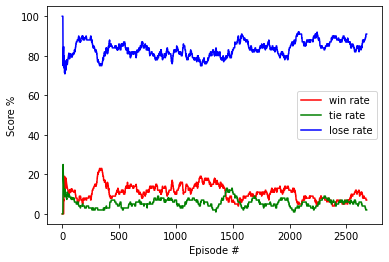

In [153]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(np_scores)), np_scores.T[0], color='r', label='win rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[1], color='g', label='tie rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[2], color='b', label='lose rate')
plt.ylabel('Score %')
plt.xlabel('Episode #')
plt.legend(loc='best')
plt.show()